# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/1014rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/1015rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/1016rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/1014rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/1015rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/1016rep_50noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.311391        0.189927  0.048388  0.295999  0.020291   
       0.25   0.288169        0.183172  0.055065  0.240864  0.070961   
       0.50   0.307756        0.194813  0.057340  0.239210  0.098771   
       0.75   0.338612        0.186509  0.064592  0.210419  0.122927   
       1.00   0.309661        0.173118  0.080808  0.177525  0.147802   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.201482  0.010319  0.040935  0.051328  0.000000  
       0.25  0.183500  0.009765  0.038369  0.049151  0.000637  
       0.50  0.199910  0.009447  0.039245  0.051988  0.001452  
       0.75  0.202789  0.007846  0.036108  0.052103  0.002424  
       1.00  0.209037  0.007173  0.038778  0.046110  0.003399

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.285361        0.203451  0.053860  0.318371  0.020249   
       0.25   0.303970        0.202768  0.054144  0.255852  0.065447   
       0.50   0.311419        0.193434  0.062980  0.218129  0.090822   
       0.75   0.300018        0.206707  0.071904  0.202362  0.128714   
       1.00   0.317564        0.163661  0.077625  0.174937  0.141294   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.202172  0.009839  0.040488  0.049874  0.000000  
       0.25  0.206021  0.010718  0.037145  0.048449  0.000589  
       0.50  0.223734  0.009240  0.037428  0.048557  0.001586  
       0.75  0.210758  0.007717  0.037750  0.045304  0.002309  
       1.00  0.208210  0.007162  0.037766  0.051536  0.003630

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.307520        0.208194  0.051695  0.316037  0.018968   
       0.25   0.318936        0.189701  0.057546  0.237189  0.071454   
       0.50   0.308453        0.169807  0.063584  0.231334  0.102456   
       0.75   0.337558        0.194610  0.069294  0.192815  0.126065   
       1.00   0.299867        0.178170  0.077289  0.165448  0.128814   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.212359  0.010137  0.040349  0.053594  0.000000  
       0.25  0.188316  0.009657  0.038033  0.051782  0.000546  
       0.50  0.207544  0.008647  0.036413  0.050315  0.001533  
       0.75  0.205349  0.008257  0.038775  0.045797  0.002493  
       1.00  0.201165  0.006842  0.037890  0.049281  0.003652

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.301424        0.200524  0.051314  0.310136  0.019836   
         0.25   0.299408        0.190985  0.058277  0.243627  0.070315   
         0.50   0.297438        0.184590  0.067947  0.228141  0.098678   
         0.75   0.304250        0.193897  0.079336  0.200724  0.127477   
         1.00   0.280318        0.169336  0.092565  0.173153  0.141149   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.205338  0.010099  0.040591  0.051599  0.000000  
         0.25  0.192610  0.010051  0.037849  0.049991  0.000389  
         0.50  0.210385  0.009133  0.037694  0.050805  0.001007  
         0.75  0.206264  0.008000  0.037534  0.048578  0.001597  
         1.00  0.206056  0.007187  0.038110  0.050238  0.002370

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.975196e+01  3.983424e+01      37.940737  5.956960e+01   
         0.25  4.701158e+06  2.310954e+06  211997.751938  1.441237e+06   
         0.50  5.502124e+06  3.575914e+06  336670.247783  2.170702e+06   
         0.75  5.623466e+06  4.247346e+06  427538.841201  2.825850e+06   
         1.00  5.955090e+06  4.539072e+06  458559.398350  2.920864e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.381417  5.593531e+01  5.601897e+01      18.963723   
         0.25  460875.044420  2.322661e+06  2.503681e+06  435277.872487   
         0.50  723179.835431  3.919590e+06  3.198510e+06  671401.032311   
         0.75  939479.688491  4.754849e+06  3.623287e+06  802939.509378   
         1.00  957828.217514  5.359746e+06  3.869362e+06  799052.975909   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         31.311180  
         0.25     174203.542252  
         0.50     283003.335320  
         0.75     360327.161466  
         1.00     412130.976782

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


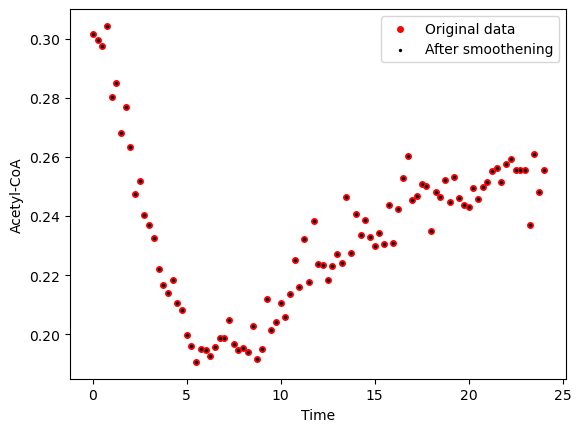

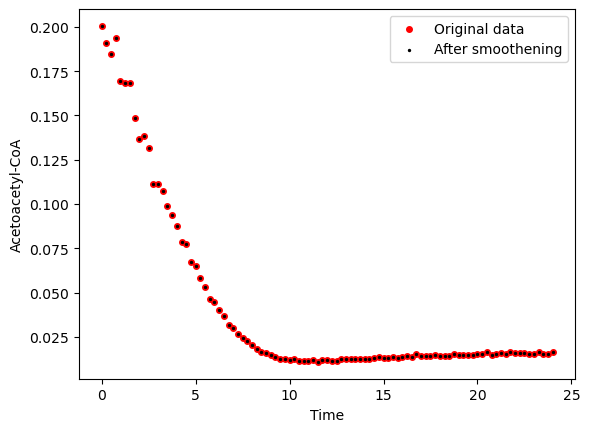

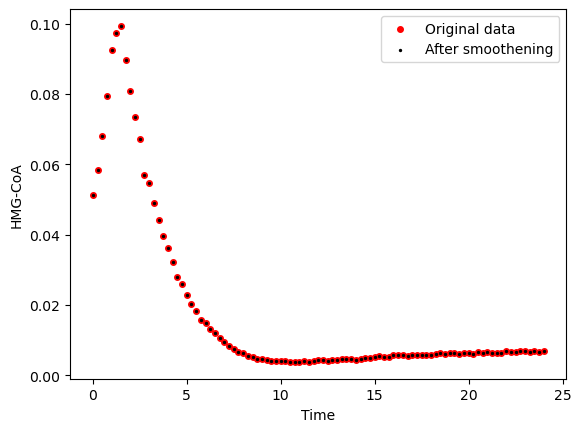

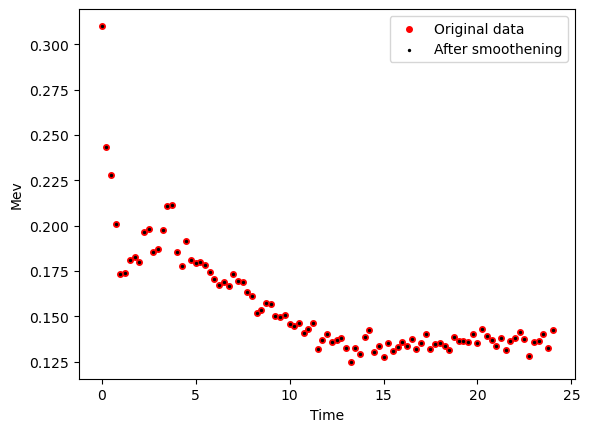

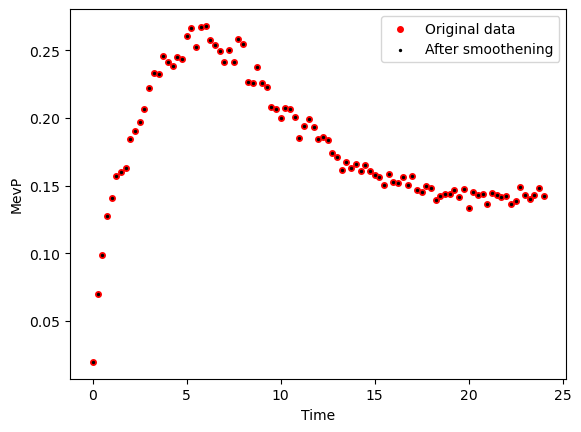

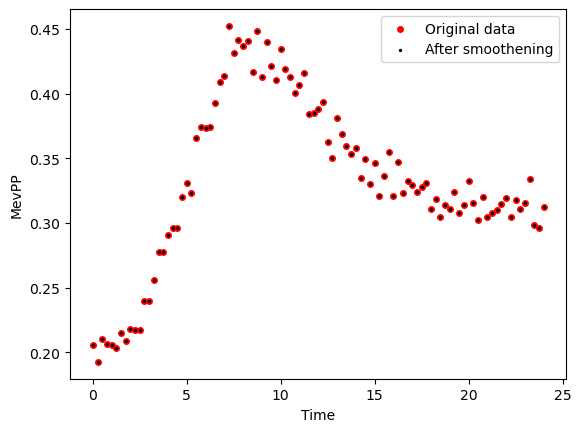

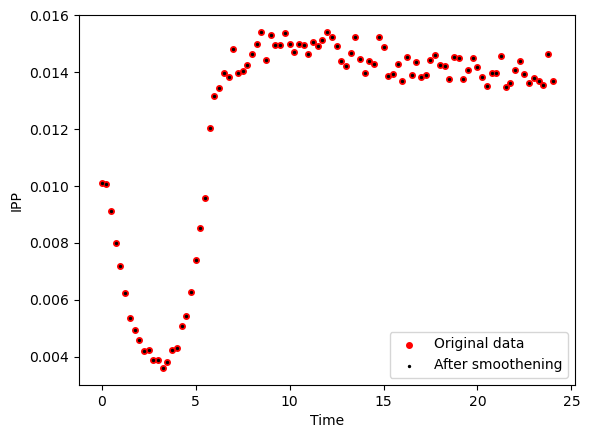

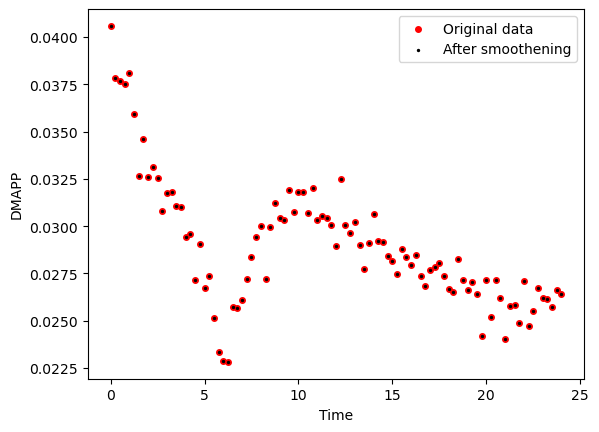

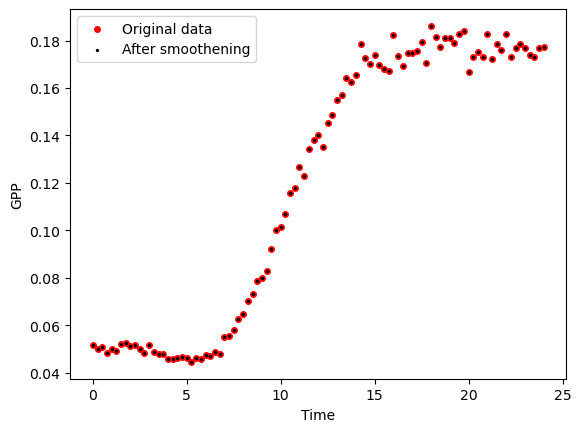

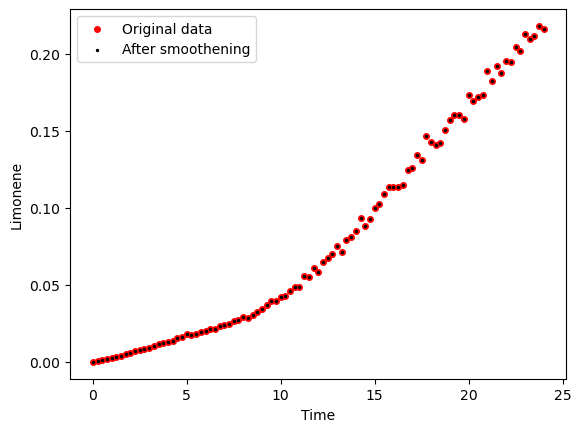

Strain Strain 2


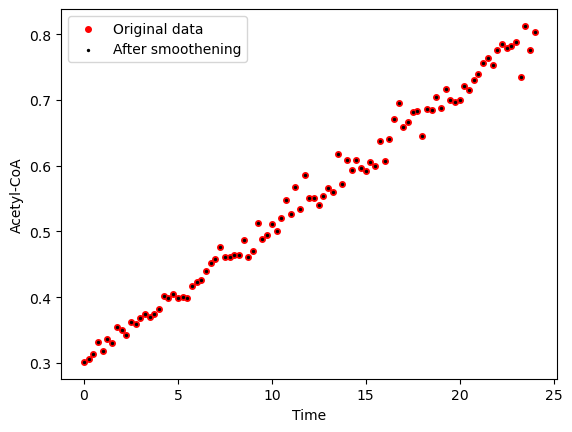

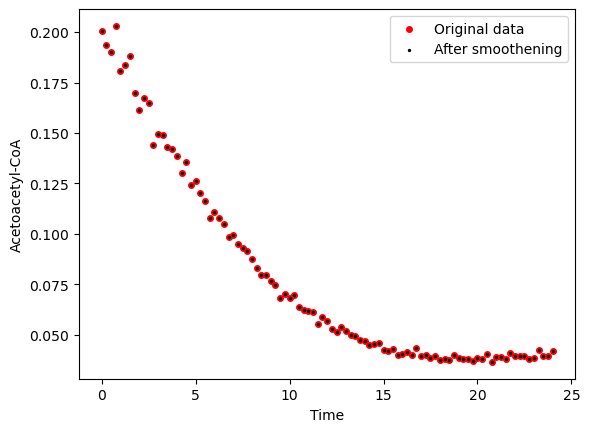

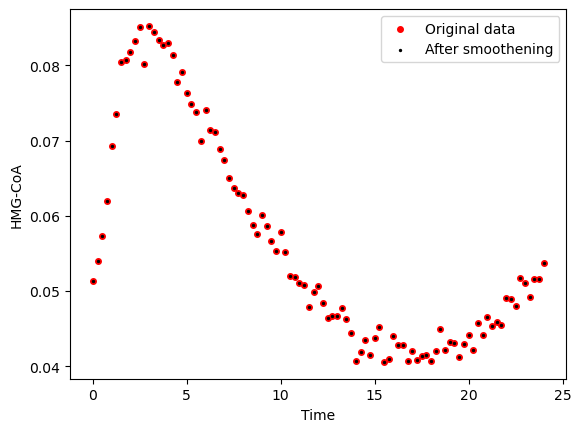

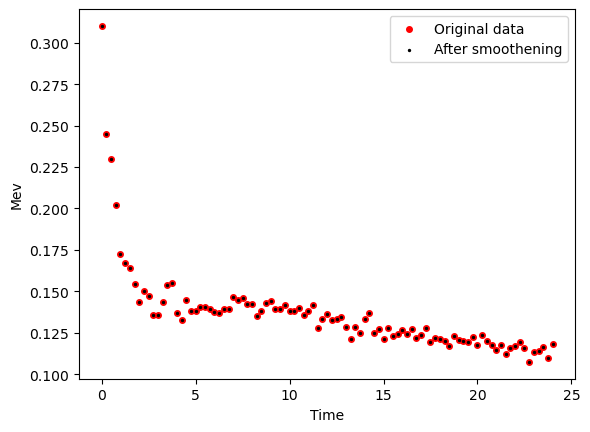

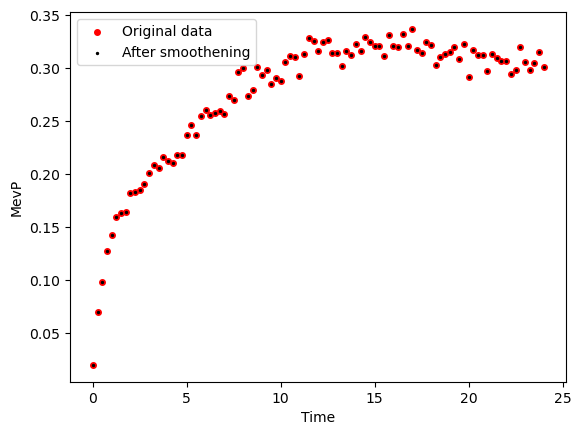

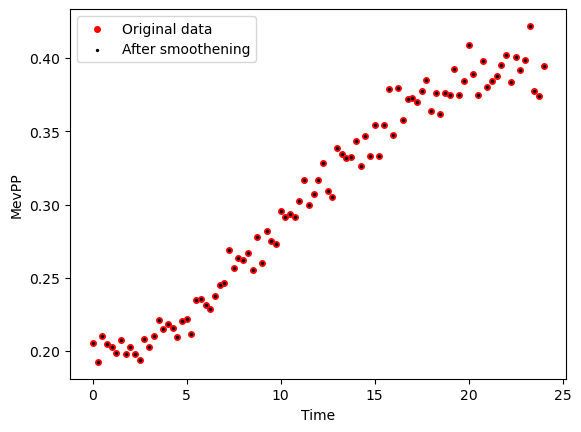

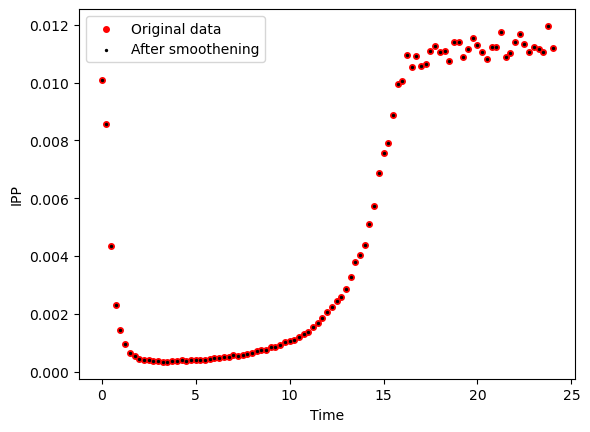

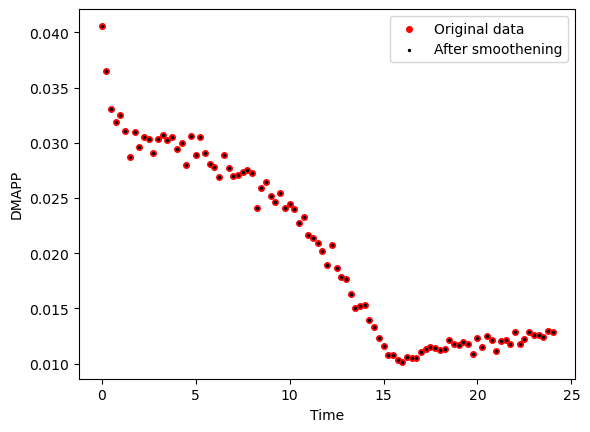

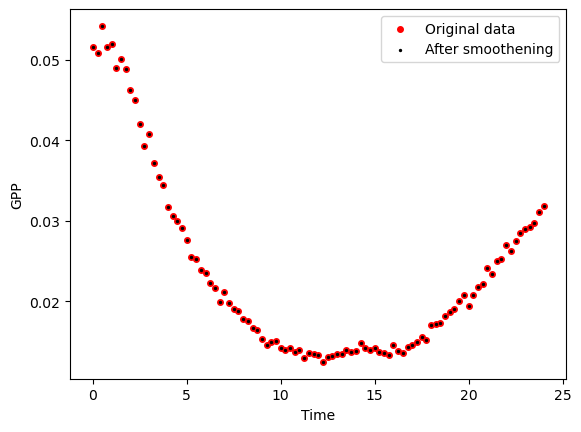

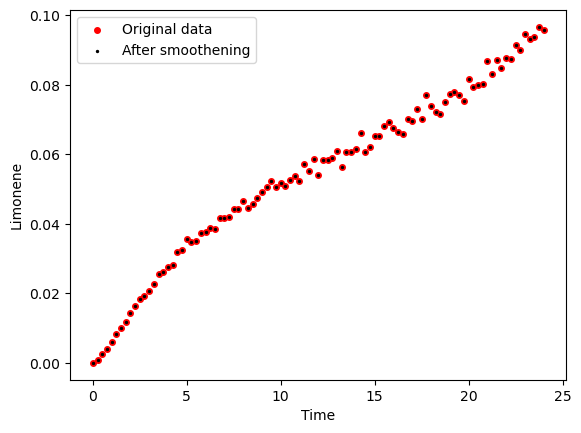

Strain Strain 3


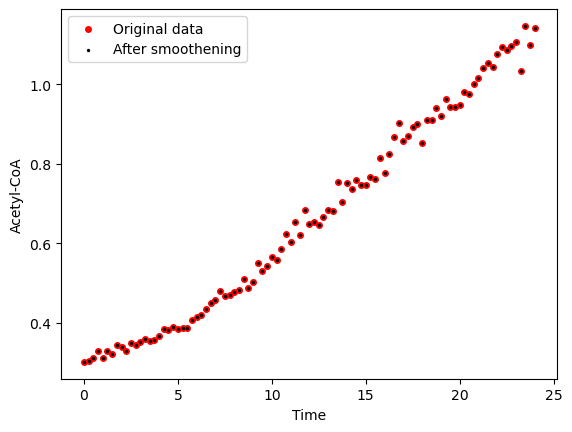

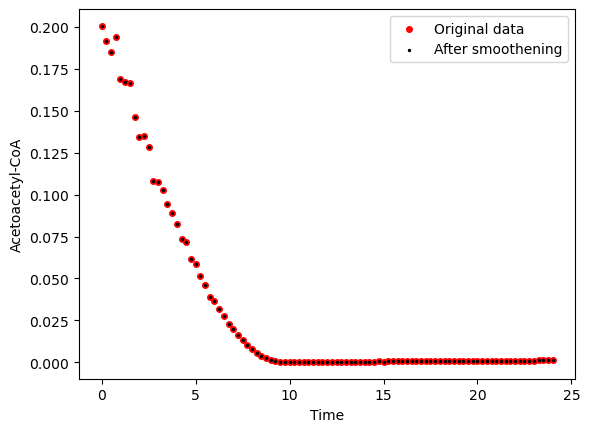

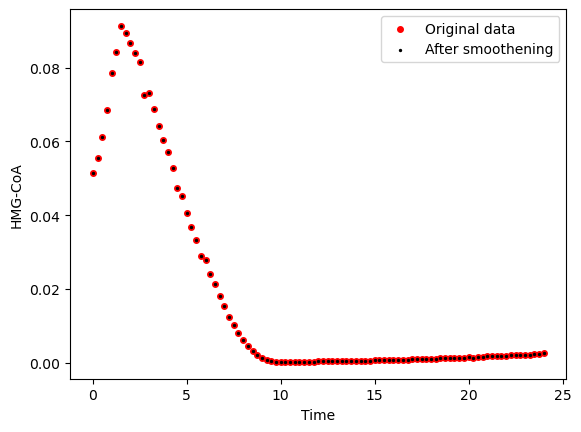

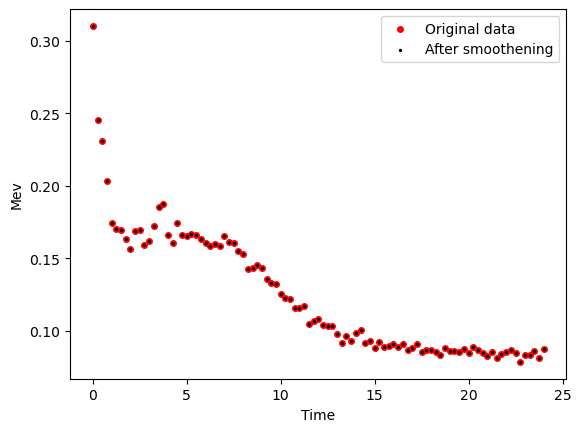

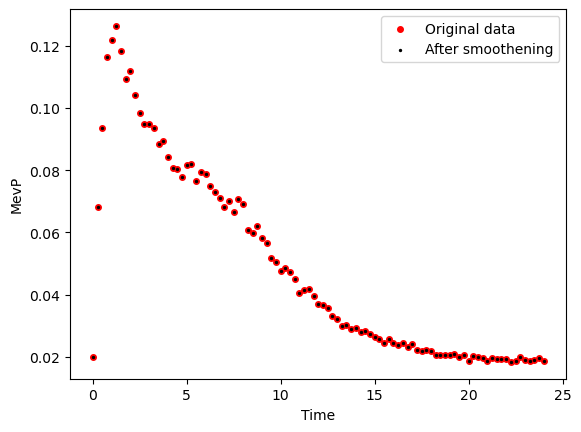

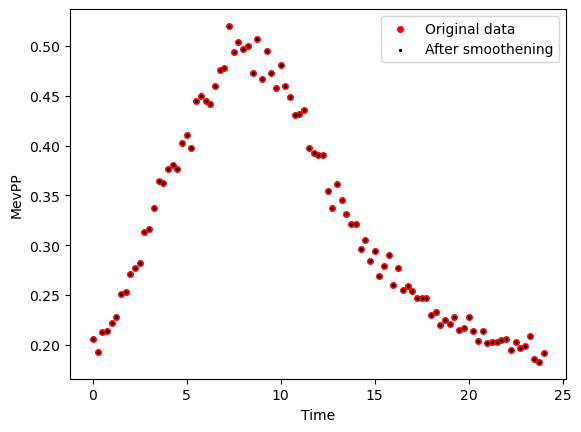

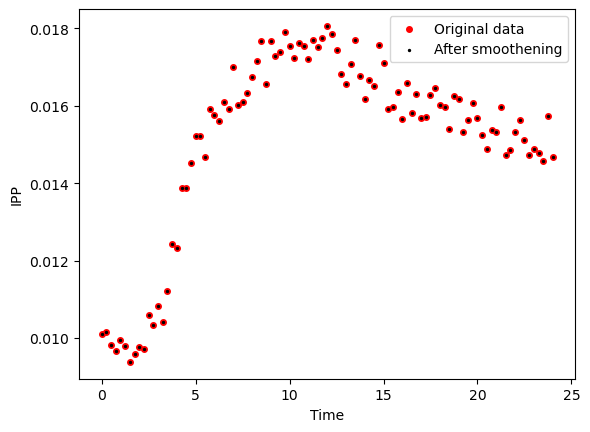

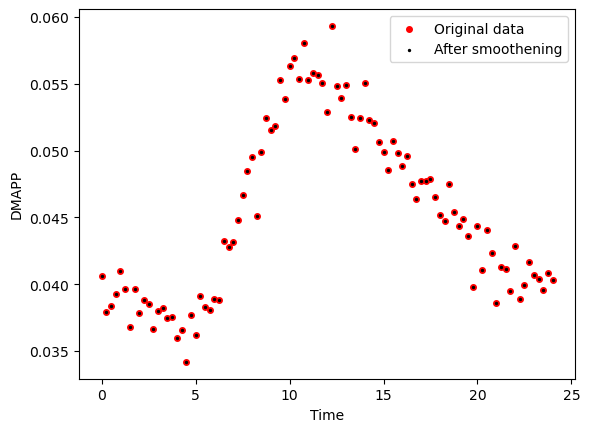

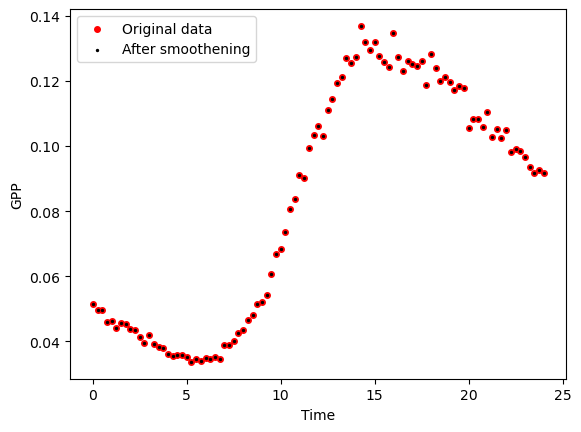

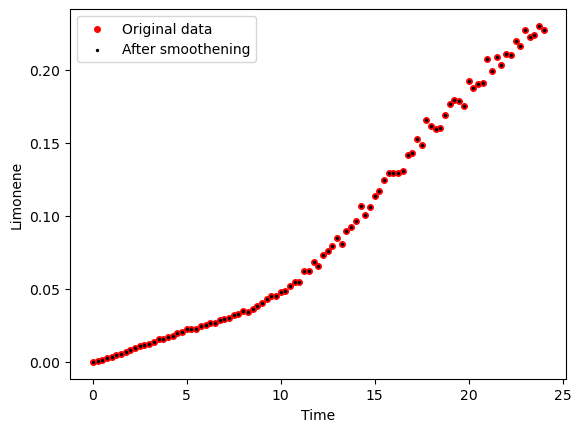

Strain WT


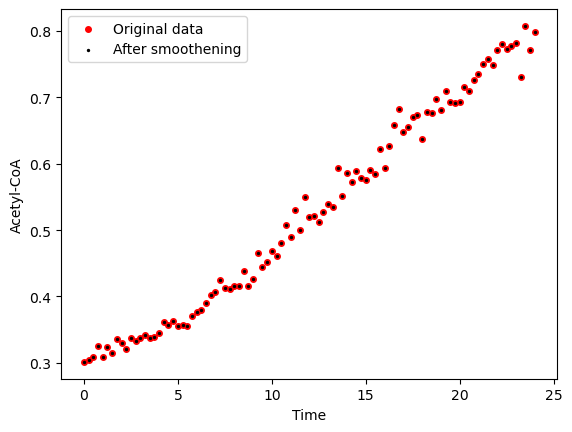

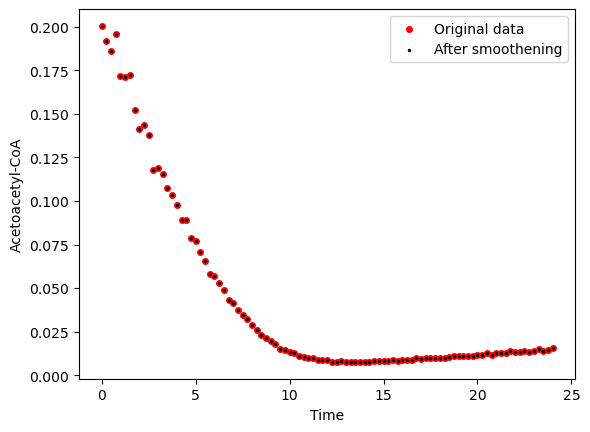

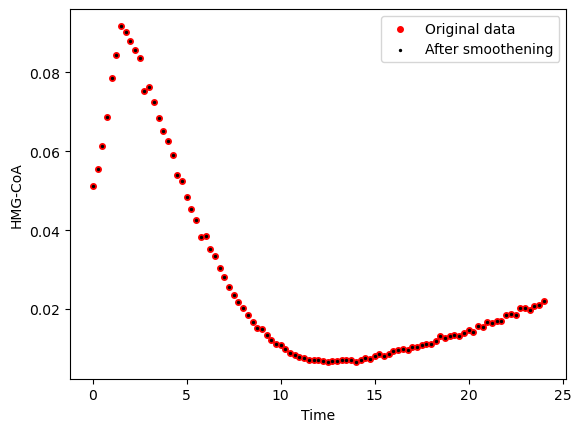

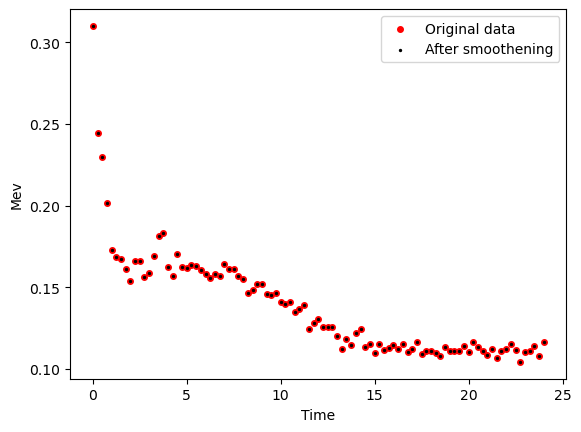

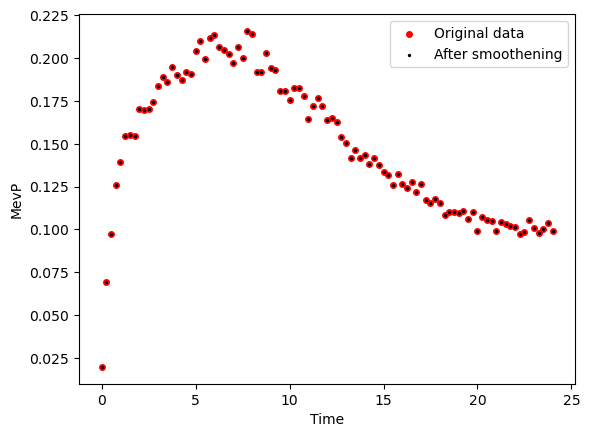

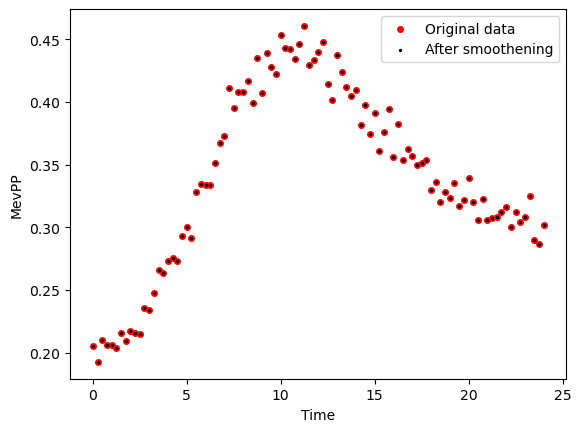

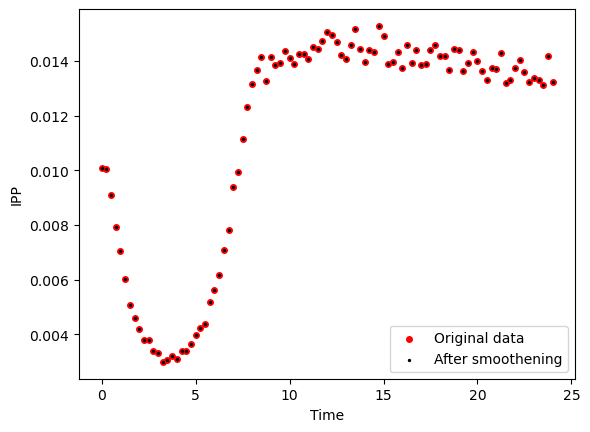

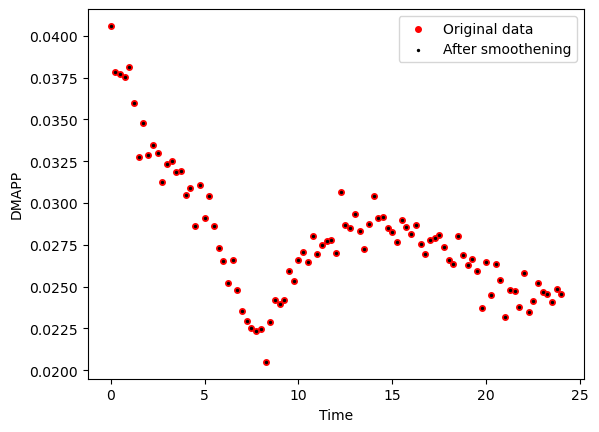

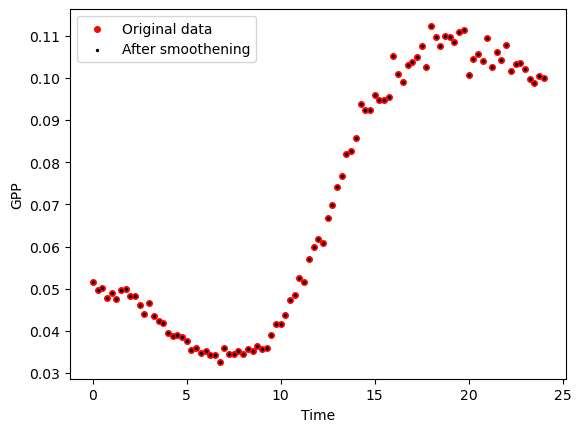

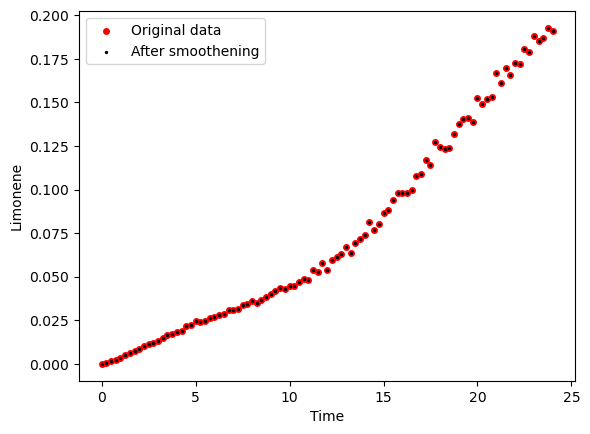

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


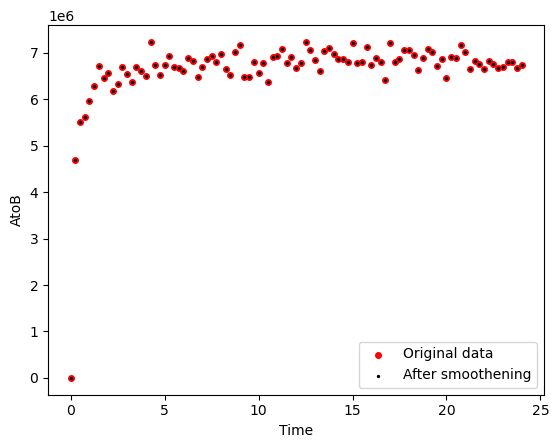

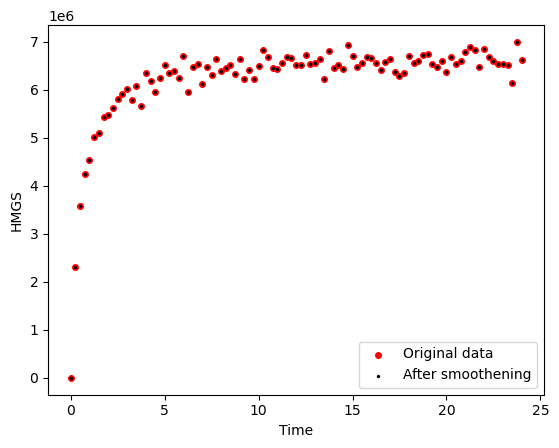

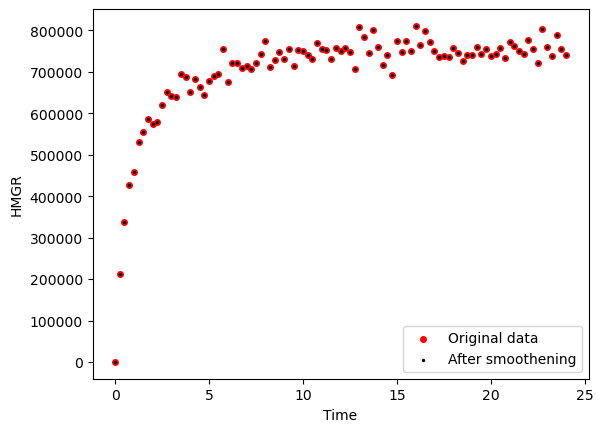

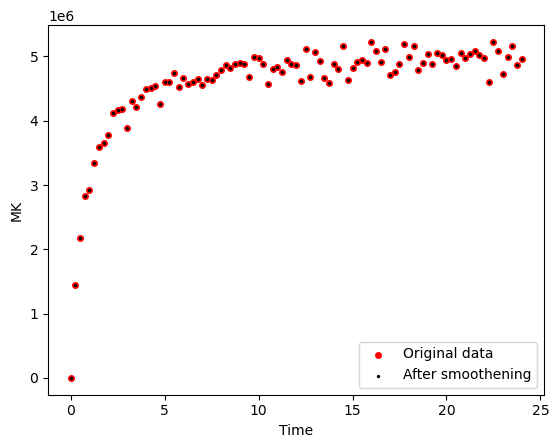

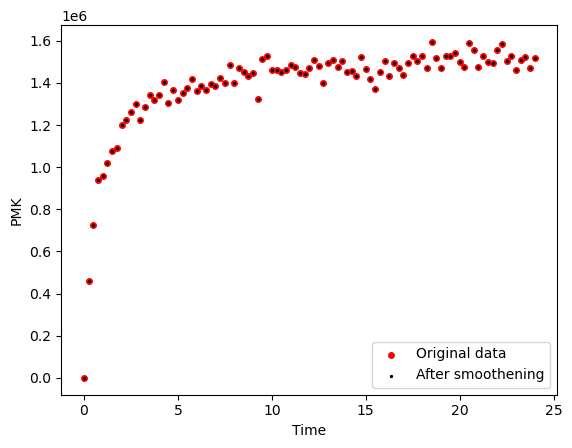

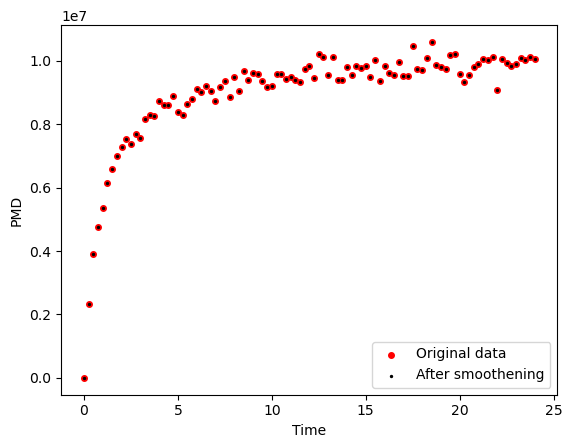

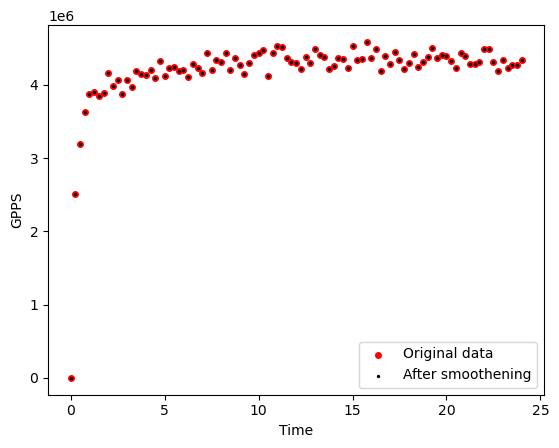

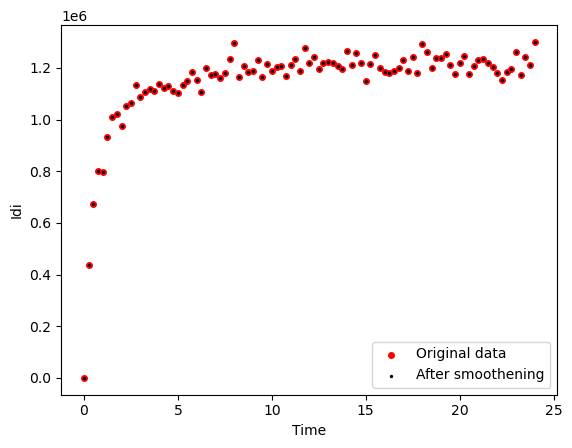

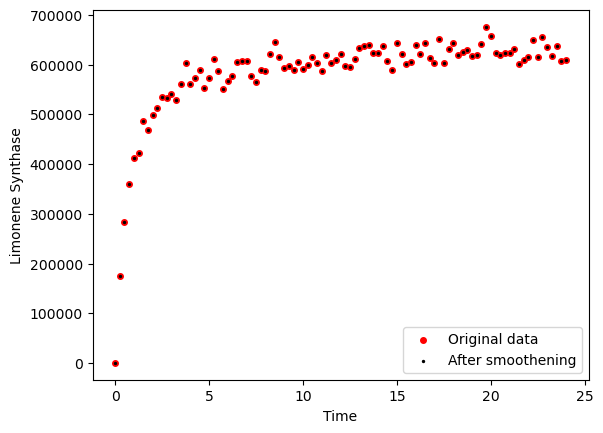

Strain Strain 2


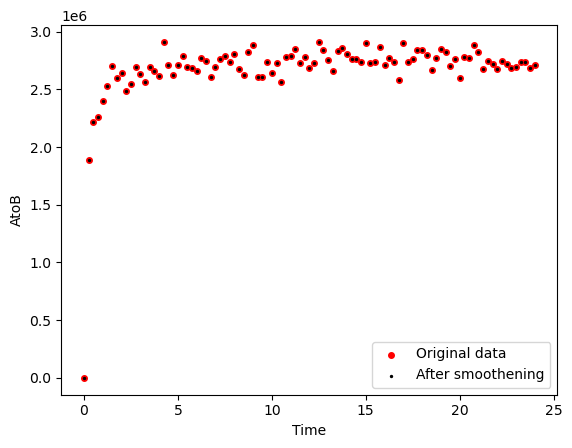

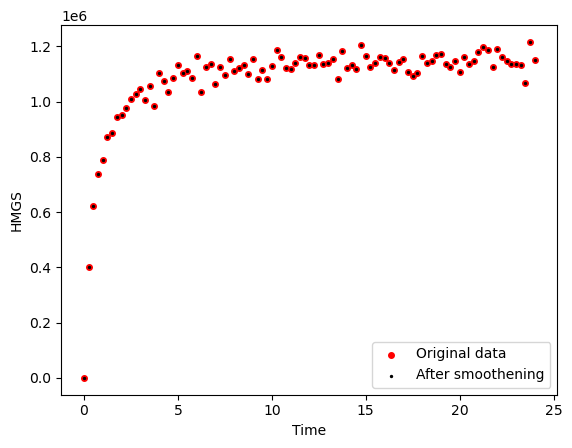

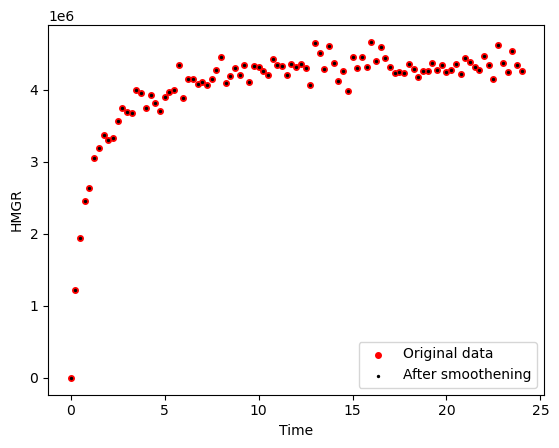

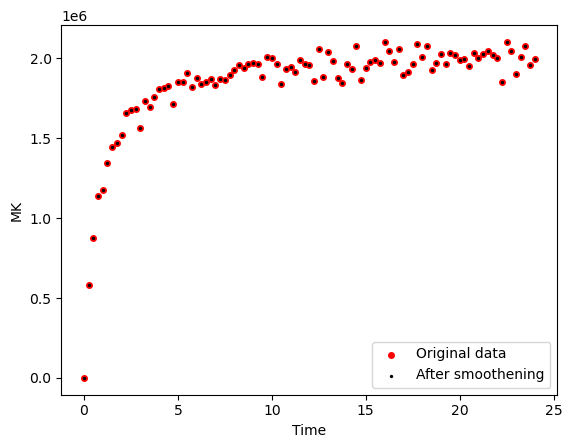

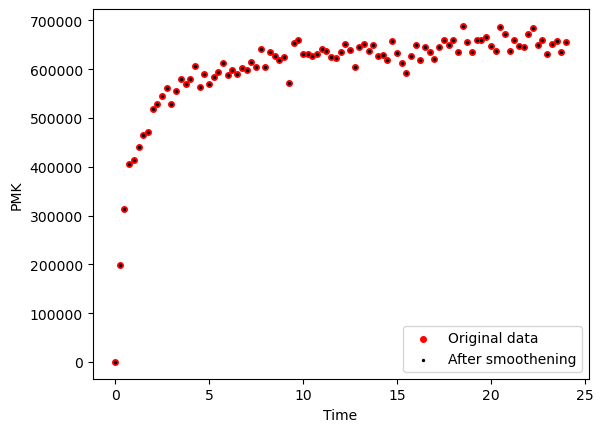

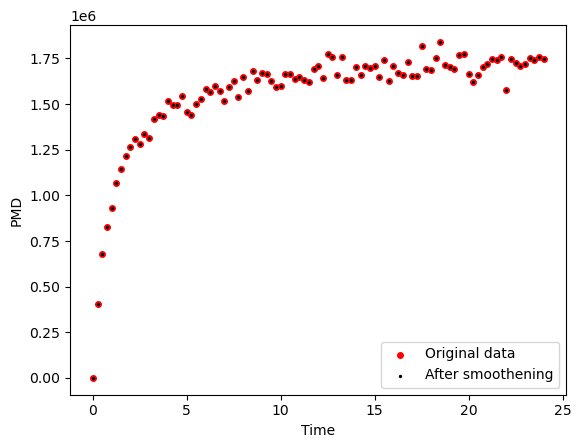

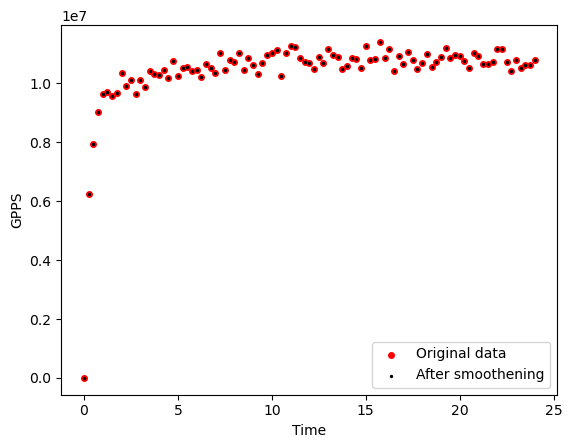

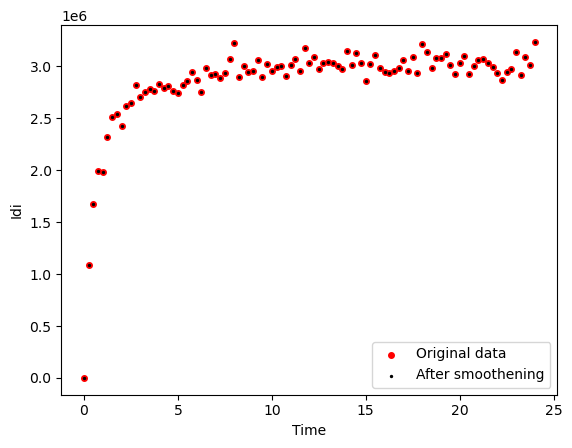

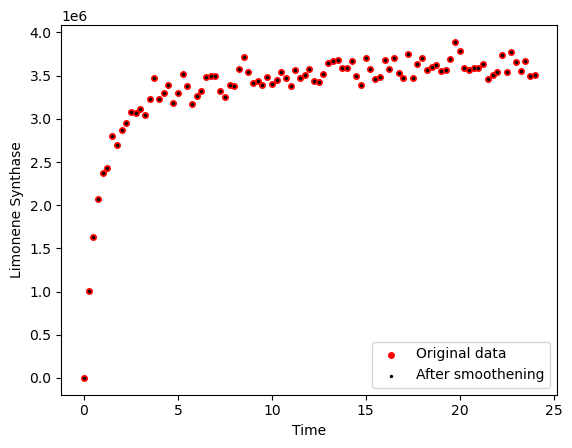

Strain Strain 3


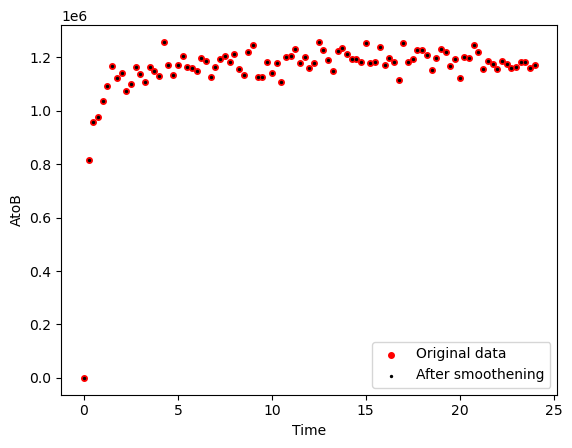

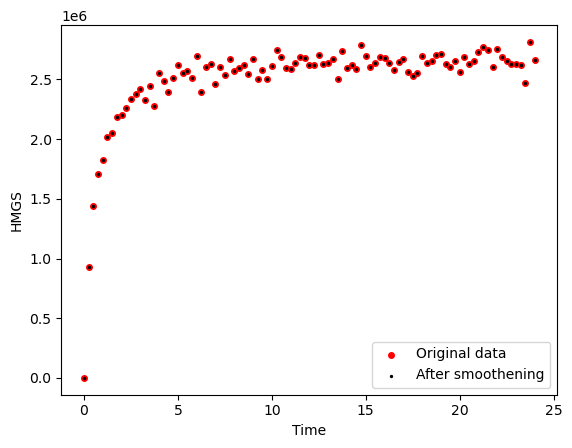

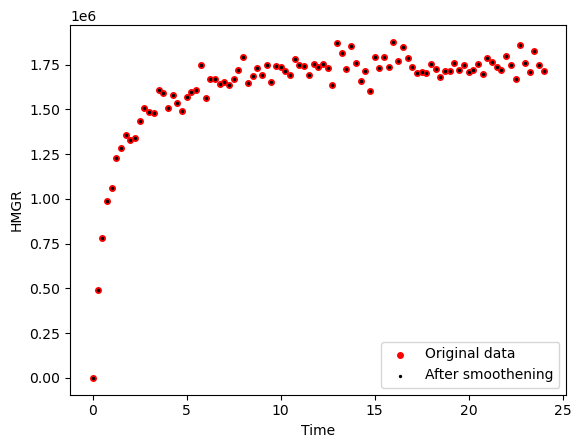

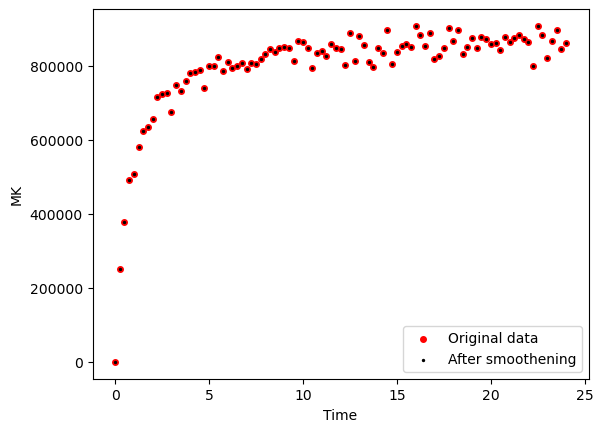

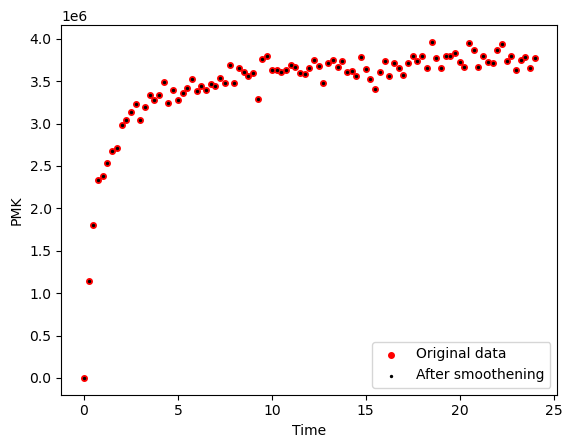

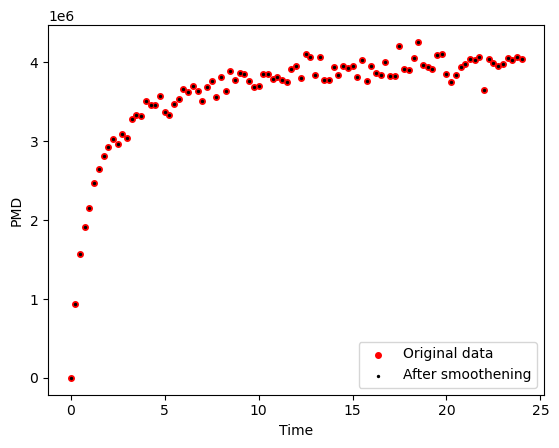

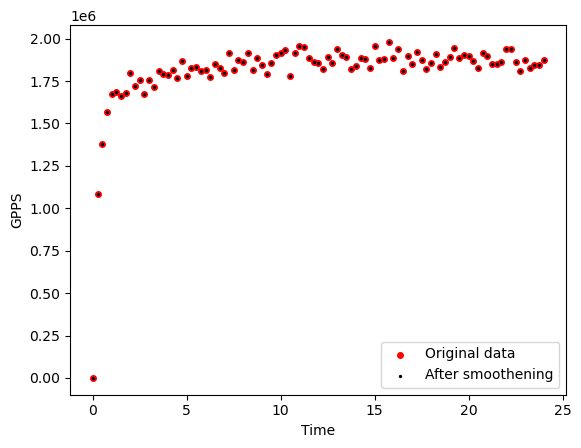

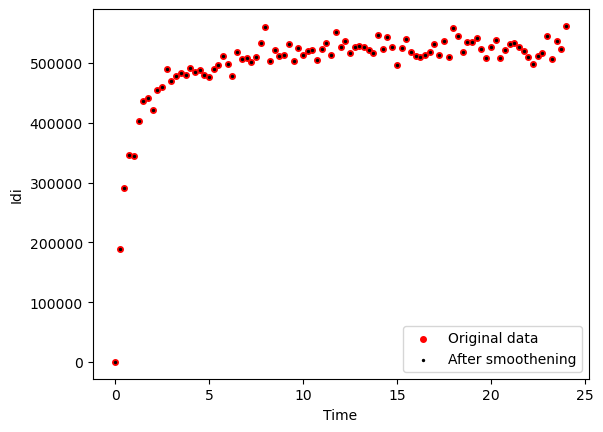

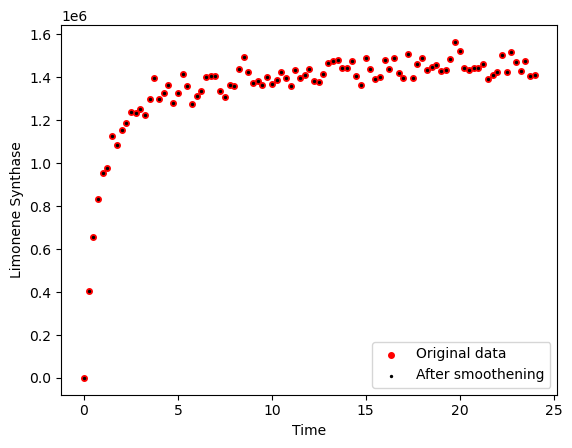

Strain WT


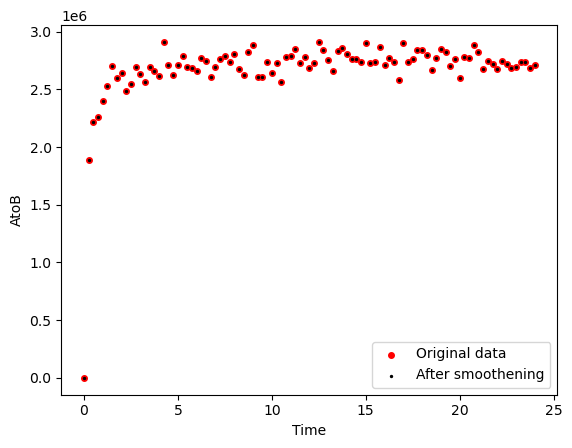

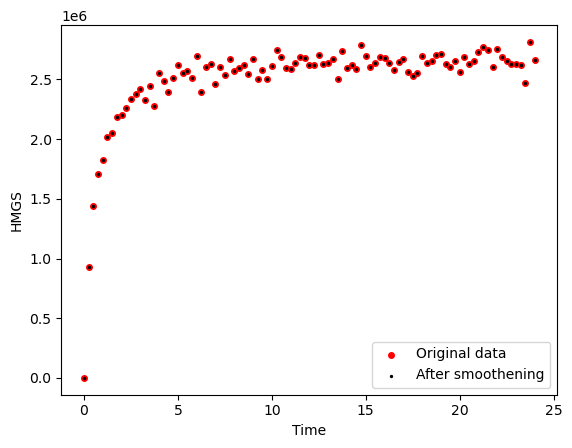

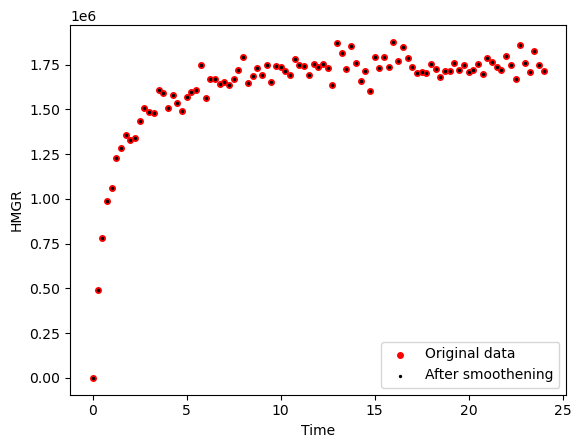

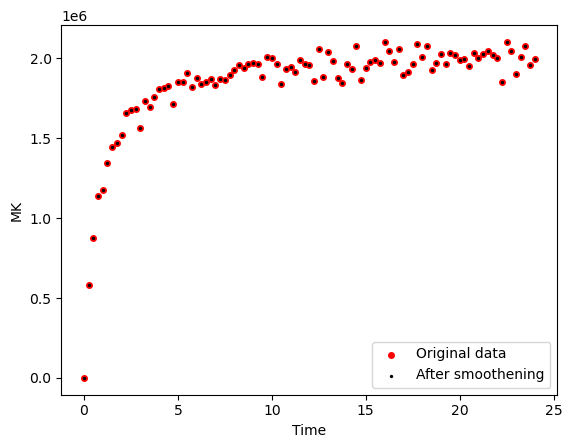

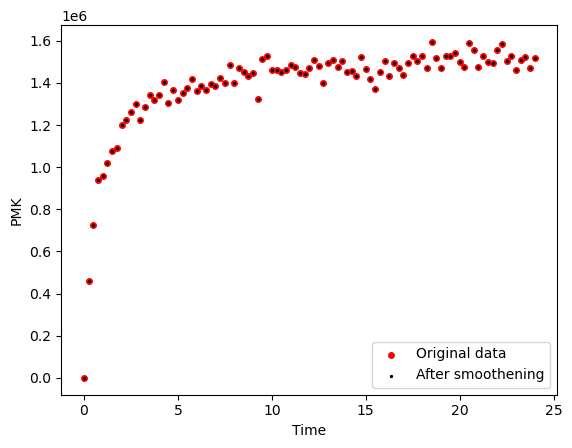

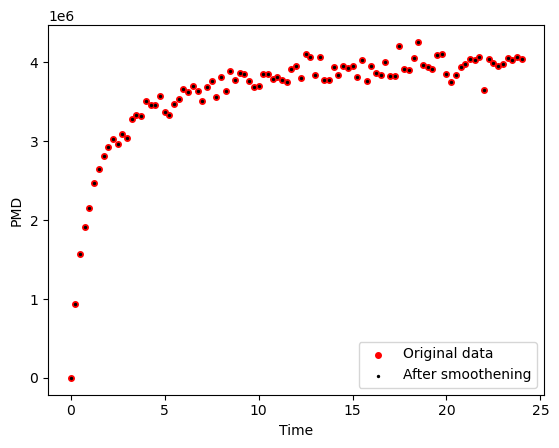

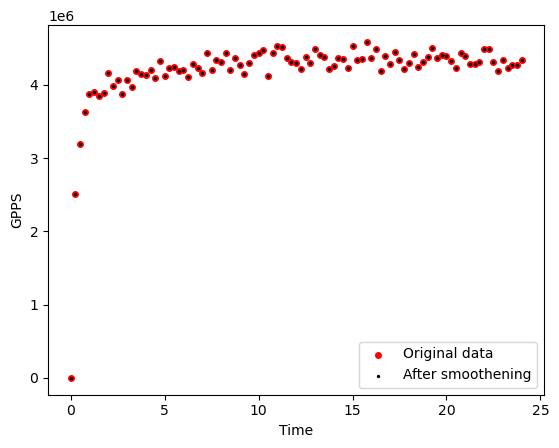

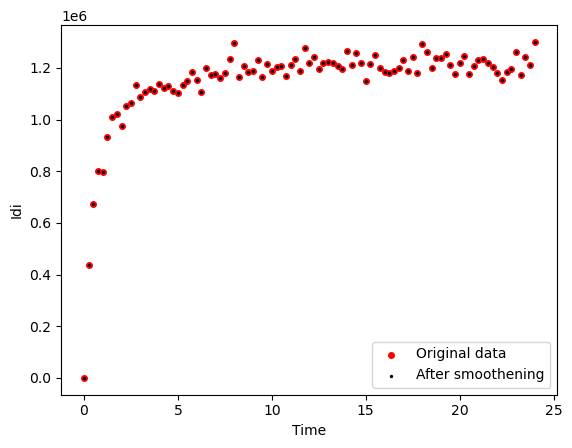

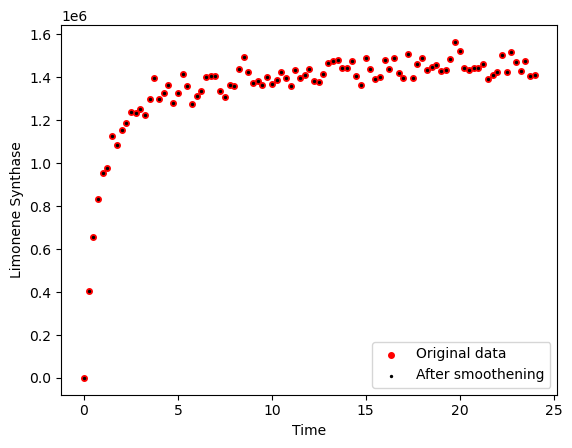

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.301424        0.200524  0.051314  0.310136  0.019836   
         0.25    0.299408        0.190985  0.058277  0.243627  0.070315   
         0.50    0.297438        0.184590  0.067947  0.228141  0.098678   
         0.75    0.304250        0.193897  0.079336  0.200724  0.127477   
         1.00    0.280318        0.169336  0.092565  0.173153  0.141149   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.782637        0.013612  0.020194  0.110700  0.100811   
         23.25   0.730114        0.015073  0.019702  0.111253  0.098169   
         23.50   0.807687        0.014126  0.020858  0.114335  0.100407   
         23.75   0.771875        0.014278  0.021028  0.108200  0.103659   
         24.00   0.799248        0.015356  0.022089  0.116762  0.099316   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.205338  0.010099  0.040591  0.051599  0.000000  ...   
         0.25   0.192610  0.010051  0.037849  0.049991  0.000389  ...   
         0.50   0.210385  0.009133  0.037694  0.050805  0.001007  ...   
         0.75   0.206264  0.008000  0.037534  0.048578  0.001597  ...   
         1.00   0.206056  0.007187  0.038110  0.050238  0.002370  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.308112  0.013389  0.024654  0.102204  0.188206  ...   
         23.25  0.325012  0.013297  0.024542  0.099855  0.185345  ...   
         23.50  0.290028  0.013134  0.024060  0.098761  0.187031  ...   
         23.75  0.286436  0.014177  0.024867  0.100346  0.192756  ...   
         24.00  0.301704  0.013241  0.024581  0.100009  0.191171  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.025109       -0.007394  0.025137 -0.202111  0.203547   
         0.25     0.005080       -0.015590  0.033281 -0.164429  0.161731   
         0.50    -0.014948       -0.023785  0.041424 -0.126748  0.119915   
         0.75    -0.018416       -0.024143  0.041067 -0.077758  0.086655   
         1.00    -0.031113       -0.023019  0.032284 -0.048345  0.061365   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.008239        0.001037  0.001574  0.004695 -0.001414   
         23.25    0.005257        0.001001  0.000873  0.004542 -0.001629   
         23.50    0.029992        0.001078  0.002047  0.003628  0.001000   
         23.75    0.056511        0.001267  0.003258  0.007514 -0.000365   
         24.00    0.083030        0.001457  0.004469  0.011400 -0.001731   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002443 -0.001154 -0.009687 -0.005647  0.001533  
         0.25   0.004240 -0.002152 -0.005899 -0.003650  0.001956  
         0.50   0.006037 -0.003150 -0.002111 -0.001654  0.002380  
         0.75   0.006957 -0.003822 -0.001367 -0.000930  0.002888  
         1.00   0.002729 -0.003729 -0.004690  0.001152  0.003104  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.009597 -0.000334 -0.000355 -0.005070  0.007537  
         23.25 -0.021485  0.000647 -0.000532 -0.004013  0.010764  
         23.50 -0.020557  0.000234  0.000072 -0.001559  0.005337  
         23.75 -0.004485 -0.000041  0.000608  0.002271  0.009103  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

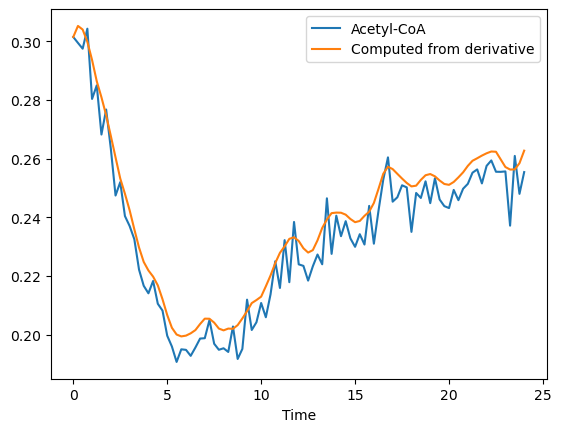

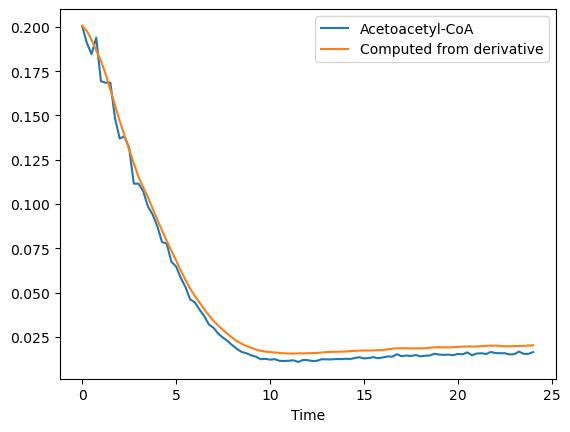

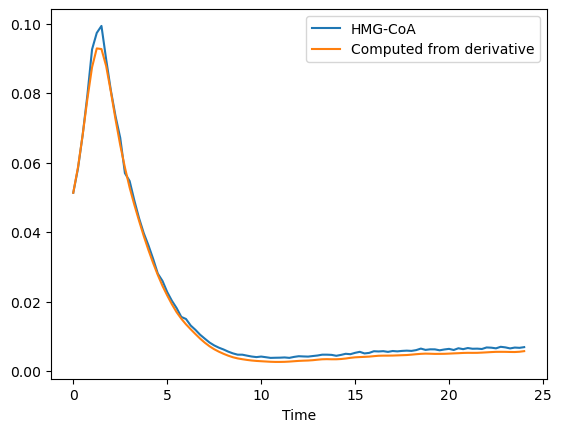

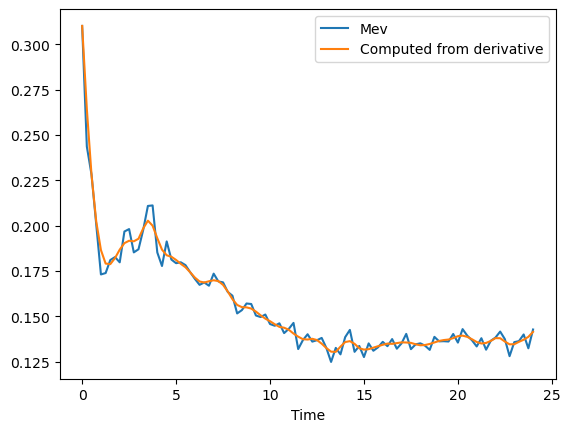

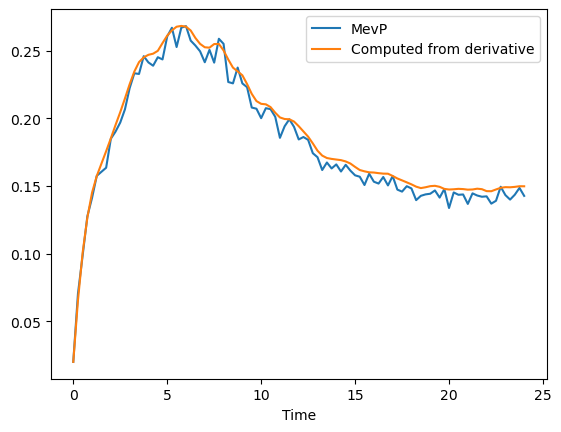

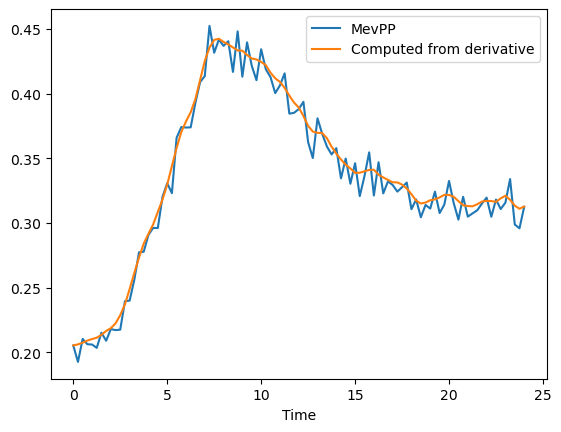

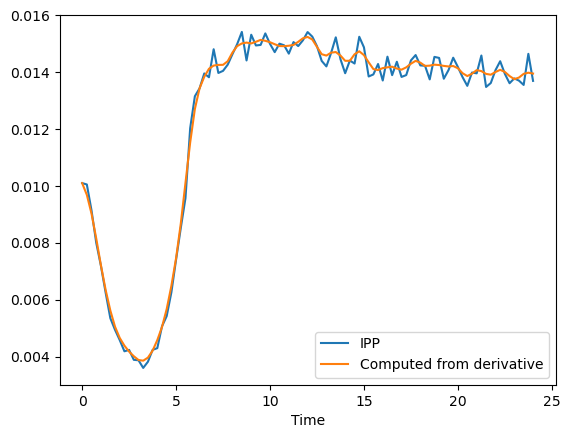

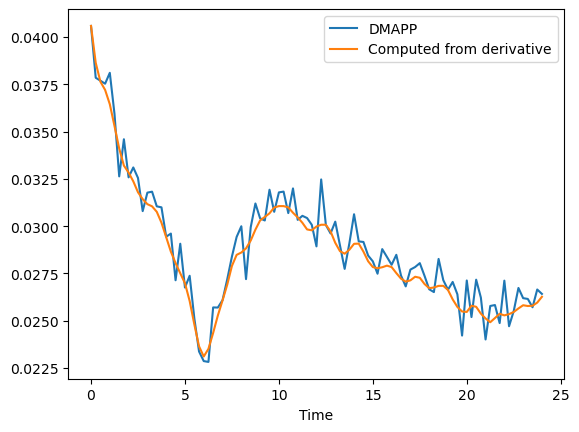

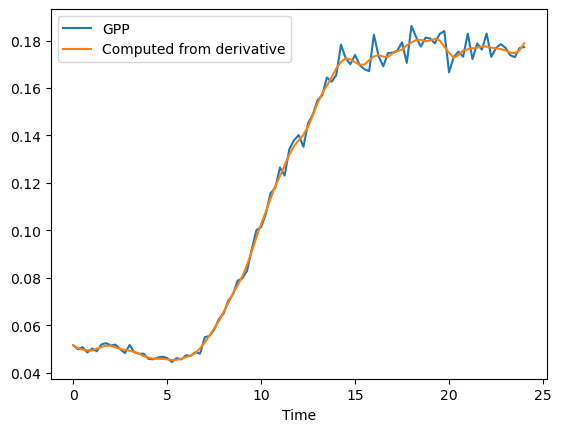

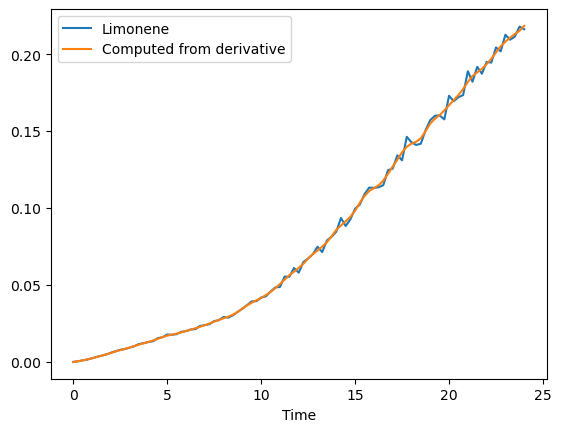

'Time profile from derivative vs. actual profile for Strain 2'

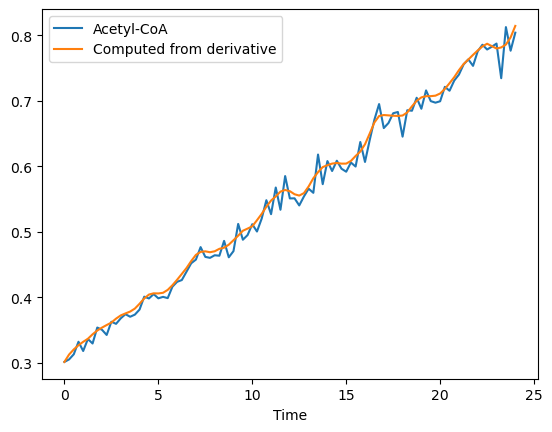

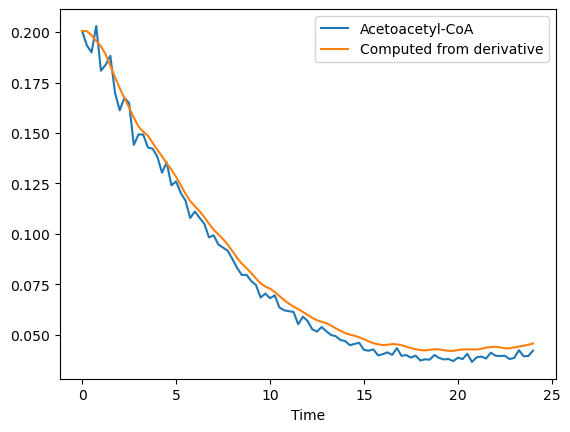

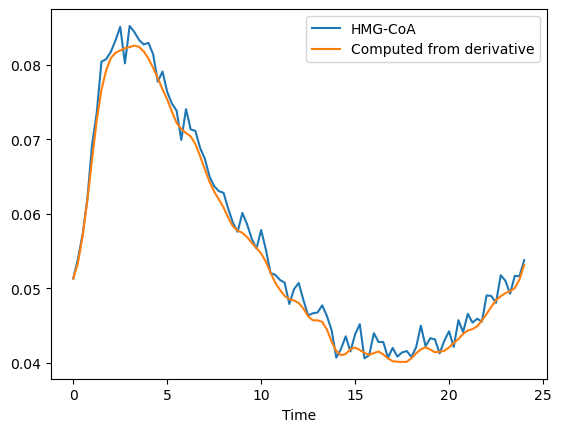

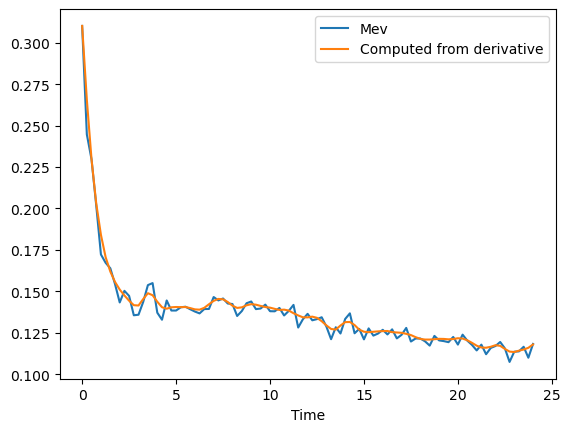

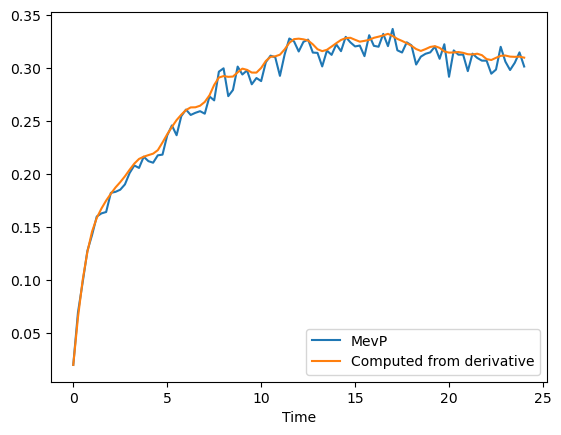

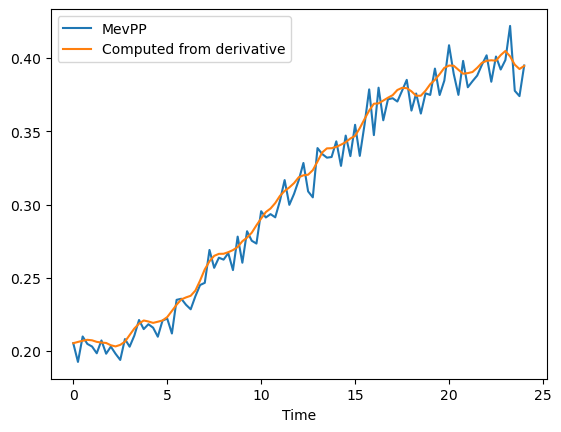

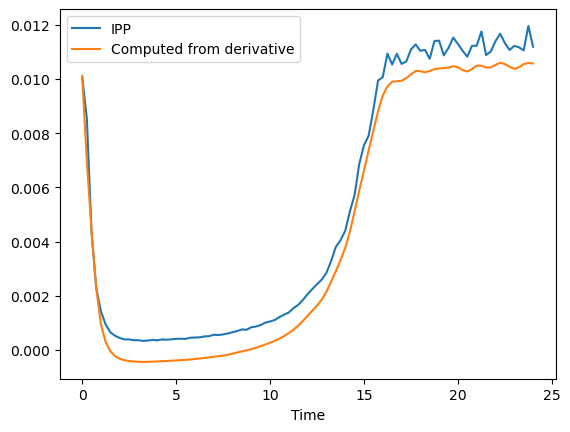

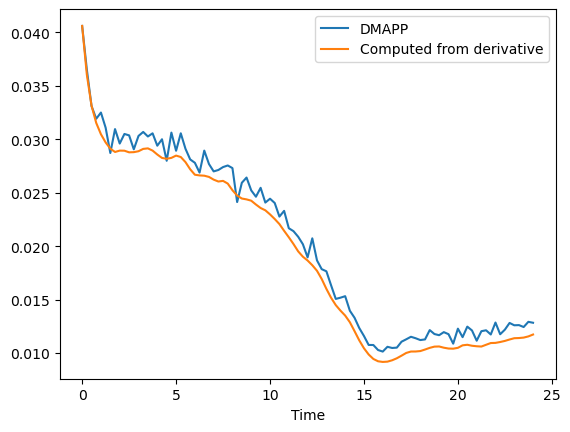

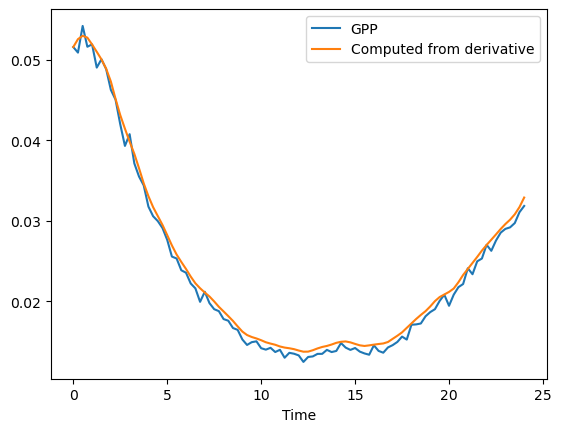

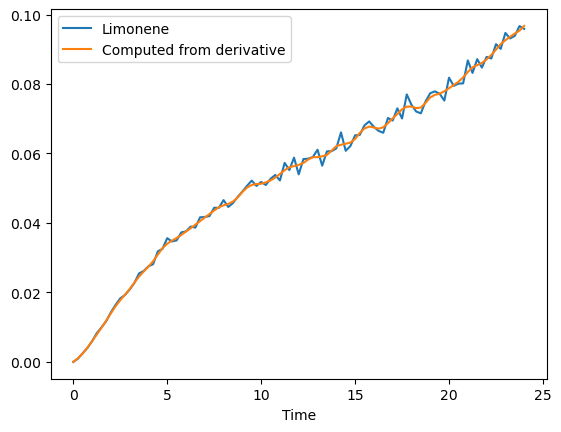

'Time profile from derivative vs. actual profile for Strain 3'

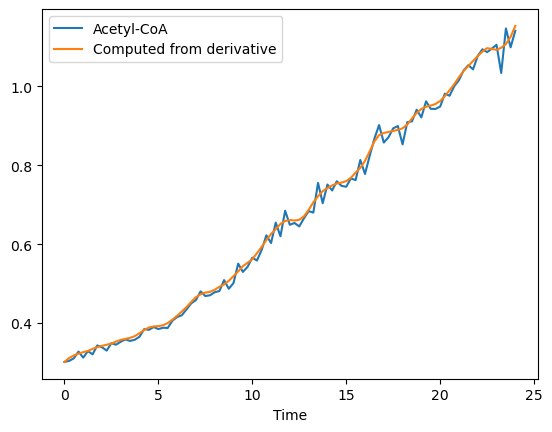

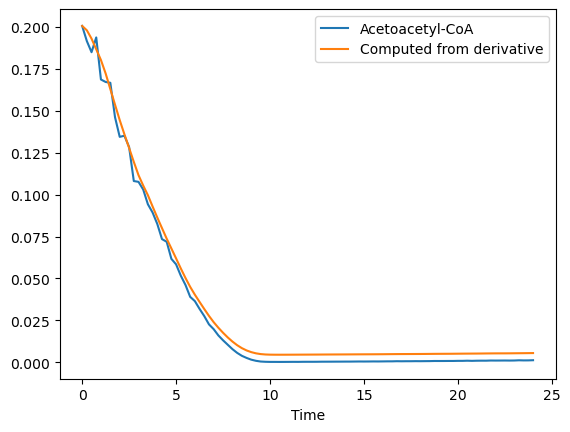

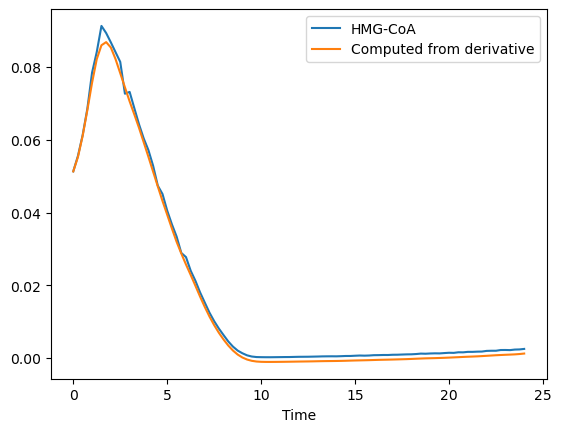

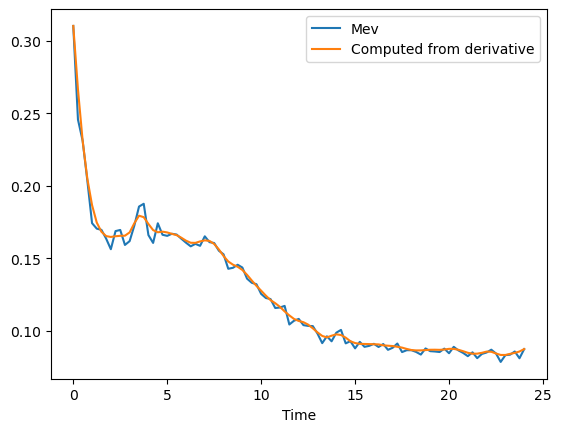

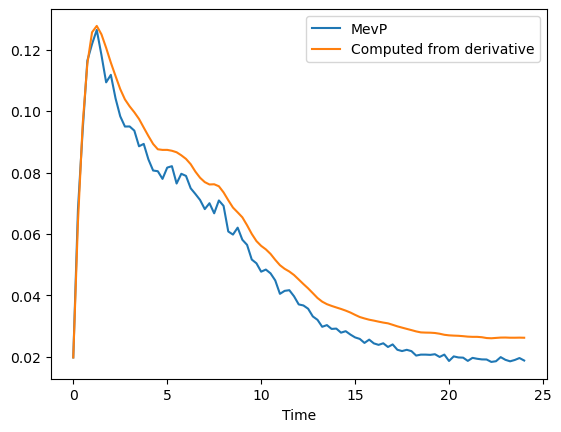

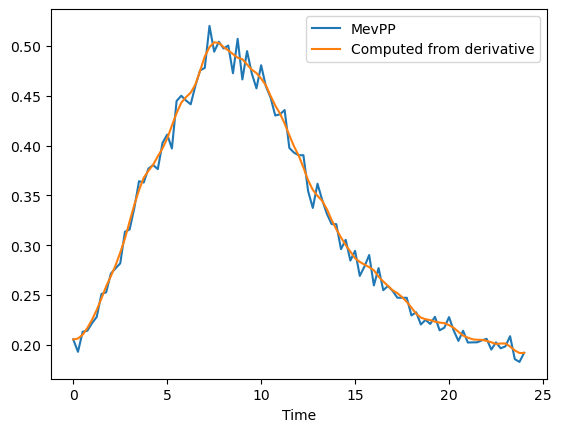

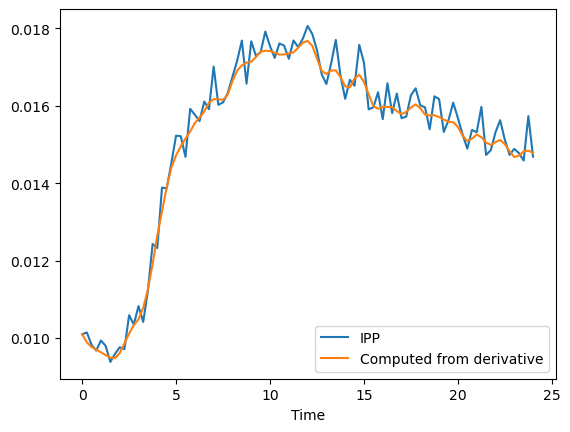

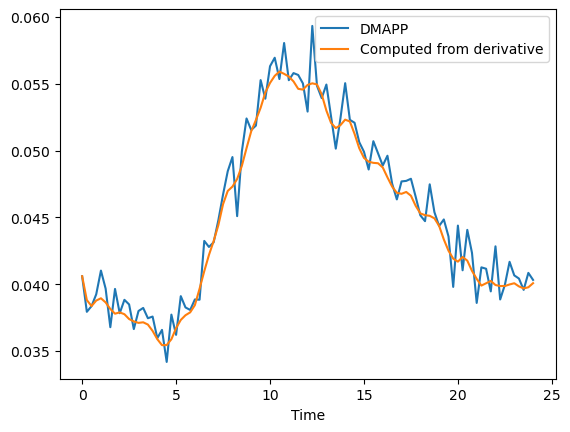

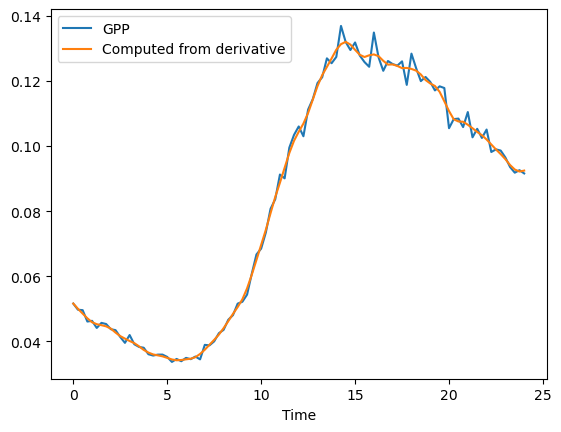

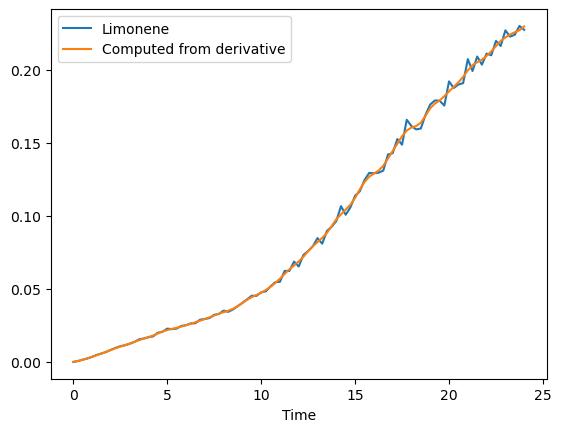

'Time profile from derivative vs. actual profile for WT'

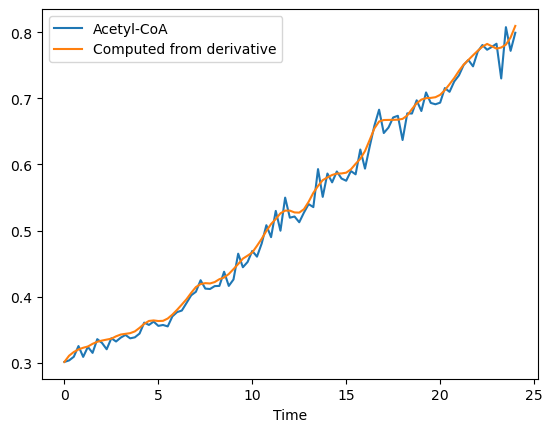

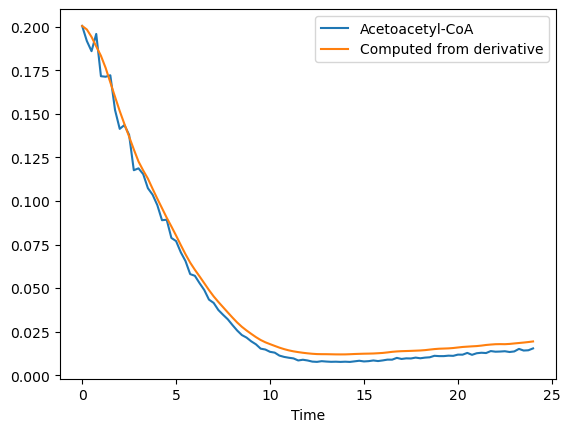

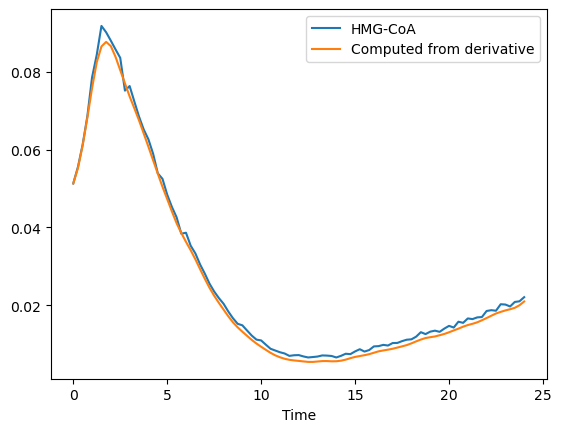

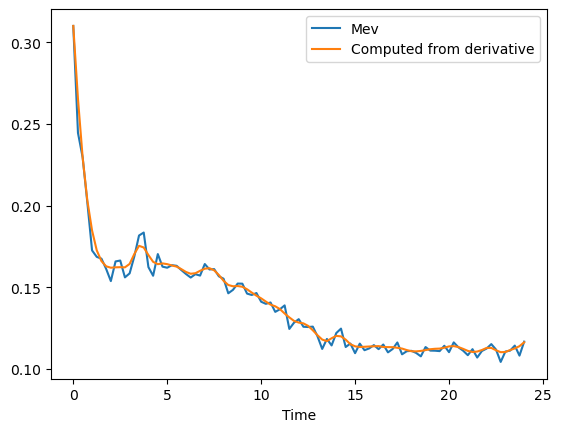

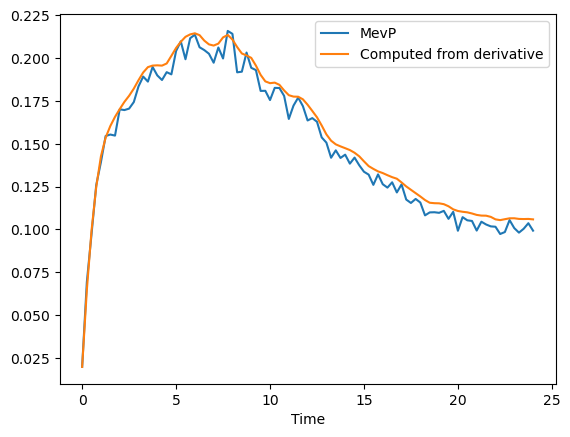

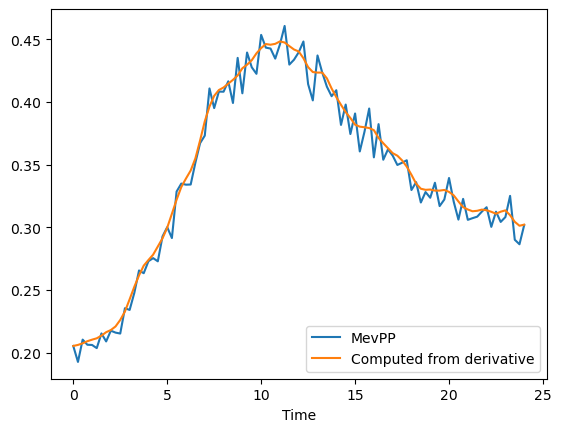

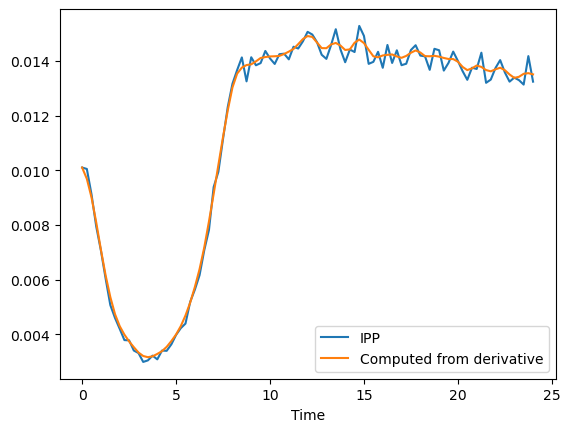

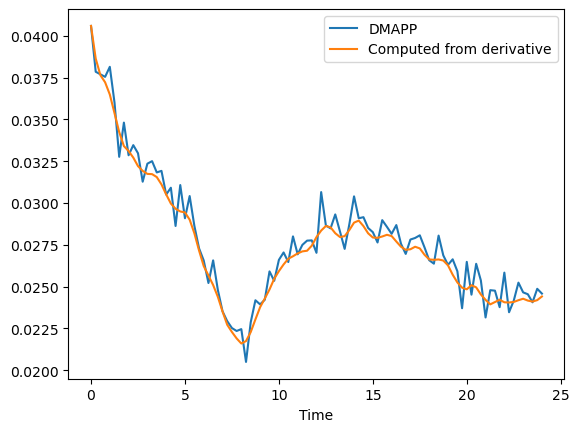

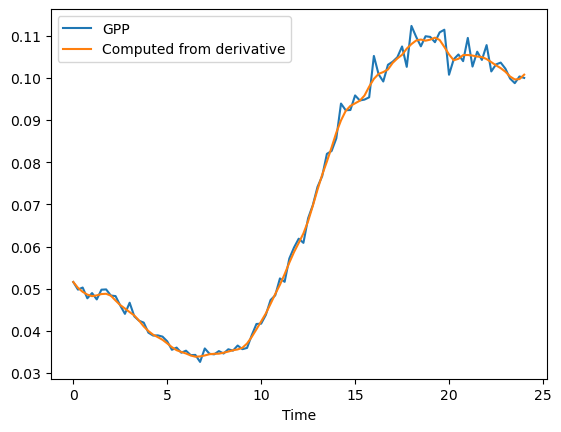

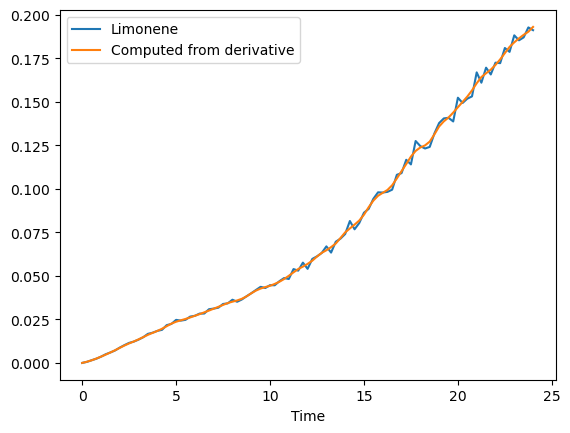

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.975196e+01  3.983424e+01  3.794074e+01  5.956960e+01   
         0.25   4.701158e+06  2.310954e+06  2.119978e+05  1.441237e+06   
         0.50   5.502124e+06  3.575914e+06  3.366702e+05  2.170702e+06   
         0.75   5.623466e+06  4.247346e+06  4.275388e+05  2.825850e+06   
         1.00   5.955090e+06  4.539072e+06  4.585594e+05  2.920864e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.689569e+06  2.630148e+06  1.757743e+06  1.904057e+06   
         23.25  2.733544e+06  2.618057e+06  1.711420e+06  2.009699e+06   
         23.50  2.734135e+06  2.467534e+06  1.824467e+06  2.078923e+06   
         23.75  2.680720e+06  2.813879e+06  1.748044e+06  1.955688e+06   
         24.00  2.711076e+06  2.661960e+06  1.713837e+06  1.994255e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.638142e+01  5.593531e+01  5.601897e+01  1.896372e+01   
         0.25   4.608750e+05  2.322661e+06  2.503681e+06  4.352779e+05   
         0.50   7.231798e+05  3.919590e+06  3.198510e+06  6.714010e+05   
         0.75   9.394797e+05  4.754849e+06  3.623287e+06  8.029395e+05   
         1.00   9.578282e+05  5.359746e+06  3.869362e+06  7.990530e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.460535e+06  3.983613e+06  4.334639e+06  1.261007e+06   
         23.25  1.508445e+06  4.058411e+06  4.235609e+06  1.171376e+06   
         23.50  1.523110e+06  4.035833e+06  4.267526e+06  1.241947e+06   
         23.75  1.469273e+06  4.064084e+06  4.274867e+06  1.211990e+06   
         24.00  1.520002e+06  4.038968e+06  4.343808e+06  1.300751e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.131118e+01   0.301424        0.200524  0.051314   
         0.25       1.742035e+05   0.299408        0.190985  0.058277   
         0.50       2.830033e+05   0.297438        0.184590  0.067947   
         0.75       3.603272e+05   0.304250        0.193897  0.079336   
         1.00       4.121310e+05   0.280318        0.169336  0.092565   
...                          ...        ...             ...       ...   
WT       23.00      1.472488e+06   0.782637        0.013612  0.020194   
         23.25      1.428807e+06   0.730114        0.015073  0.019702   
         23.50      1.473668e+06   0.807687        0.014126  0.020858   
         23.75      1.408105e+06   0.771875        0.014278  0.021028   
         24.00      1.412659e+06   0.799248        0.015356  0.022089   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.310136  0.019836  0.205338  0.010099  0.040591  0.051599   
         0.25   0.243627  0.070315  0.192610  0.010051  0.037849  0.049991   
         0.50   0.228141  0.098678  0.210385  0.009133  0.037694  0.050805   
         0.75   0.200724  0.127477  0.206264  0.008000  0.037534  0.048578   
         1.00   0.173153  0.141149  0.206056  0.007187  0.038110  0.050238   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.110700  0.100811  0.308112  0.013389  0.024654  0.102204   
         23.25  0.111253  0.098169  0.325012  0.013297  0.024542  0.099855   
         23.50  0.114335  0.100407  0.290028  0.013134  0.024060 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.025109       -0.007394  0.025137 -0.202111  0.203547   
         0.25     0.005080       -0.015590  0.033281 -0.164429  0.161731   
         0.50    -0.014948       -0.023785  0.041424 -0.126748  0.119915   
         0.75    -0.018416       -0.024143  0.041067 -0.077758  0.086655   
         1.00    -0.031113       -0.023019  0.032284 -0.048345  0.061365   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.008239        0.001037  0.001574  0.004695 -0.001414   
         23.25    0.005257        0.001001  0.000873  0.004542 -0.001629   
         23.50    0.029992        0.001078  0.002047  0.003628  0.001000   
         23.75    0.056511        0.001267  0.003258  0.007514 -0.000365   
         24.00    0.083030        0.001457  0.004469  0.011400 -0.001731   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002443 -0.001154 -0.009687 -0.005647  0.001533  
         0.25   0.004240 -0.002152 -0.005899 -0.003650  0.001956  
         0.50   0.006037 -0.003150 -0.002111 -0.001654  0.002380  
         0.75   0.006957 -0.003822 -0.001367 -0.000930  0.002888  
         1.00   0.002729 -0.003729 -0.004690  0.001152  0.003104  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.009597 -0.000334 -0.000355 -0.005070  0.007537  
         23.25 -0.021485  0.000647 -0.000532 -0.004013  0.010764  
         23.50 -0.020557  0.000234  0.000072 -0.001559  0.005337  
         23.75 -0.004485 -0.000041  0.000608  0.002271  0.009103  
         24.00  0.011588 -0.000316  0.001145  0.006101  0.012869  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 1.684017E+192 | 1.025535E+117
     2 |       74 | 9.559490E+119 |  5.721519E+97
     3 |      138 | 7.025977E+100 |  2.348191E+88
     4 |      202 |  1.624074E+88 |  5.236208E+60
     5 |      266 |  2.896926E+82 |  3.593533E+58
     6 |      330 |  2.454883E+70 |  3.593533E+58
     7 |      394 |  1.651615E+69 |  1.620208E+48
     8 |      458 |  3.389073E+57 |  1.003722E+42
     9 |      522 |  1.775515E+56 |  3.764738E+34
    10 |      586 |  7.321290E+47 |  4.872760E+26
    11 |      650 |  7.641317E+40 |  4.872760E+26
    12 |      714 |  2.528441E+38 |  4.872760E+26
    13 |      778 |  2.391526E+35 |  4.872760E+26
    14 |      842 |  2.215300E+35 |  4.872760E+26
    15 |      906 |  1.539329E+34 |  2.808705E+26
    16 |      970 |  4.972396E+34 |  2.730850E+25
    17 |     1034 |  2.730906E+34 |  1.356922E+25
    18 |     1098 |  7.090321E+33 |  1.356922E+25
    19 |     1162 |  7.55

   162 |    10314 |  2.589355E+01 |  2.344512E+01
   163 |    10378 |  2.565487E+01 |  2.344512E+01
   164 |    10442 |  2.522957E+01 |  2.344512E+01
   165 |    10506 |  2.533620E+01 |  2.344512E+01
   166 |    10570 |  2.498960E+01 |  2.344512E+01
   167 |    10634 |  2.540016E+01 |  2.344512E+01
   168 |    10698 |  2.492010E+01 |  2.344512E+01
   169 |    10762 |  2.483914E+01 |  2.305897E+01
   170 |    10826 |  2.511316E+01 |  2.305897E+01
   171 |    10890 |  2.530178E+01 |  2.305897E+01
   172 |    10954 |  2.551571E+01 |  2.305897E+01
   173 |    11018 |  2.502489E+01 |  2.305897E+01
   174 |    11082 |  2.512700E+01 |  2.305897E+01
   175 |    11146 |  2.503661E+01 |  2.305897E+01
   176 |    11210 |  2.502481E+01 |  2.305897E+01
   177 |    11274 |  2.489281E+01 |  2.305897E+01
   178 |    11338 |  2.456027E+01 |  2.305897E+01
   179 |    11402 |  2.477784E+01 |  2.305897E+01
   180 |    11466 |  2.462257E+01 |  2.305897E+01
   181 |    11530 |  2.338950E+01 |  2.209893E+01


   326 |    20810 |  1.996304E+01 |  1.982784E+01
   327 |    20874 |  1.993269E+01 |  1.982784E+01
   328 |    20938 |  1.990372E+01 |  1.982784E+01
   329 |    21002 |  1.989119E+01 |  1.982784E+01
   330 |    21066 |  1.987105E+01 |  1.982784E+01
   331 |    21130 |  1.985726E+01 |  1.981707E+01
   332 |    21194 |  1.985116E+01 |  1.981707E+01
   333 |    21258 |  1.984822E+01 |  1.981707E+01
   334 |    21322 |  1.984495E+01 |  1.980025E+01
   335 |    21386 |  1.984525E+01 |  1.980025E+01
   336 |    21450 |  1.983227E+01 |  1.980025E+01
   337 |    21514 |  1.984434E+01 |  1.980025E+01
   338 |    21578 |  1.983885E+01 |  1.980025E+01
   339 |    21642 |  1.984125E+01 |  1.980025E+01
   340 |    21706 |  1.984222E+01 |  1.980025E+01
   341 |    21770 |  1.983271E+01 |  1.980025E+01
   342 |    21834 |  1.981951E+01 |  1.980025E+01
   343 |    21898 |  1.982357E+01 |  1.980025E+01
   344 |    21962 |  1.981784E+01 |  1.979267E+01
   345 |    22026 |  1.981711E+01 |  1.979267E+01


   490 |    31306 |  1.971798E+01 |  1.971736E+01
   491 |    31370 |  1.971812E+01 |  1.971736E+01
   492 |    31434 |  1.971752E+01 |  1.971642E+01
   493 |    31498 |  1.971754E+01 |  1.971642E+01
   494 |    31562 |  1.971735E+01 |  1.971642E+01
   495 |    31626 |  1.971734E+01 |  1.971572E+01
   496 |    31690 |  1.971636E+01 |  1.971572E+01
   497 |    31754 |  1.971581E+01 |  1.971483E+01
   498 |    31818 |  1.971543E+01 |  1.971443E+01
   499 |    31882 |  1.971490E+01 |  1.971405E+01
   500 |    31946 |  1.971435E+01 |  1.971301E+01
   501 |    32010 |  1.971357E+01 |  1.971272E+01
   502 |    32074 |  1.971310E+01 |  1.971262E+01
   503 |    32138 |  1.971260E+01 |  1.971230E+01
   504 |    32202 |  1.971249E+01 |  1.971181E+01
   505 |    32266 |  1.971245E+01 |  1.971130E+01
   506 |    32330 |  1.971230E+01 |  1.971130E+01
   507 |    32394 |  1.971196E+01 |  1.971091E+01
   508 |    32458 |  1.971159E+01 |  1.971091E+01
   509 |    32522 |  1.971118E+01 |  1.971048E+01


   654 |    41802 |  1.939094E+01 |  1.935138E+01
   655 |    41866 |  1.936766E+01 |  1.935138E+01
   656 |    41930 |  1.936819E+01 |  1.934240E+01
   657 |    41994 |  1.935974E+01 |  1.933919E+01
   658 |    42058 |  1.935996E+01 |  1.933919E+01
   659 |    42122 |  1.935839E+01 |  1.933919E+01
   660 |    42186 |  1.936224E+01 |  1.933919E+01
   661 |    42250 |  1.935860E+01 |  1.933919E+01
   662 |    42314 |  1.936309E+01 |  1.933919E+01
   663 |    42378 |  1.936441E+01 |  1.933919E+01
   664 |    42442 |  1.935410E+01 |  1.933919E+01
   665 |    42506 |  1.935928E+01 |  1.933919E+01
   666 |    42570 |  1.935911E+01 |  1.933919E+01
   667 |    42634 |  1.935699E+01 |  1.933919E+01
   668 |    42698 |  1.936198E+01 |  1.933919E+01
   669 |    42762 |  1.935023E+01 |  1.933544E+01
   670 |    42826 |  1.935550E+01 |  1.933544E+01
   671 |    42890 |  1.935464E+01 |  1.933258E+01
   672 |    42954 |  1.934683E+01 |  1.933134E+01
   673 |    43018 |  1.934617E+01 |  1.933134E+01


   818 |    52298 |  1.768422E+01 |  1.767033E+01
   819 |    52362 |  1.767517E+01 |  1.766116E+01
   820 |    52426 |  1.766849E+01 |  1.765794E+01
   821 |    52490 |  1.766617E+01 |  1.764825E+01
   822 |    52554 |  1.766123E+01 |  1.764333E+01
   823 |    52618 |  1.765386E+01 |  1.762971E+01
   824 |    52682 |  1.764615E+01 |  1.762848E+01
   825 |    52746 |  1.764577E+01 |  1.762848E+01
   826 |    52810 |  1.763629E+01 |  1.762335E+01
   827 |    52874 |  1.763850E+01 |  1.762335E+01
   828 |    52938 |  1.763660E+01 |  1.761552E+01
   829 |    53002 |  1.761903E+01 |  1.760982E+01
   830 |    53066 |  1.760957E+01 |  1.758035E+01
   831 |    53130 |  1.760132E+01 |  1.758035E+01
   832 |    53194 |  1.760103E+01 |  1.758035E+01
   833 |    53258 |  1.760009E+01 |  1.758035E+01
   834 |    53322 |  1.759882E+01 |  1.758035E+01
   835 |    53386 |  1.759360E+01 |  1.758035E+01
   836 |    53450 |  1.759228E+01 |  1.758035E+01
   837 |    53514 |  1.758538E+01 |  1.757098E+01


   982 |    62794 |  1.735605E+01 |  1.735399E+01
   983 |    62858 |  1.735590E+01 |  1.735230E+01
   984 |    62922 |  1.735454E+01 |  1.735230E+01
   985 |    62986 |  1.735479E+01 |  1.735169E+01
   986 |    63050 |  1.735386E+01 |  1.735100E+01
   987 |    63114 |  1.735250E+01 |  1.735076E+01
   988 |    63178 |  1.735092E+01 |  1.734934E+01
   989 |    63242 |  1.734990E+01 |  1.734843E+01
   990 |    63306 |  1.734858E+01 |  1.734502E+01
   991 |    63370 |  1.734724E+01 |  1.734502E+01
   992 |    63434 |  1.734607E+01 |  1.734470E+01
   993 |    63498 |  1.734535E+01 |  1.734409E+01
   994 |    63562 |  1.734533E+01 |  1.734145E+01
   995 |    63626 |  1.734450E+01 |  1.734145E+01
   996 |    63690 |  1.734359E+01 |  1.734099E+01
   997 |    63754 |  1.734296E+01 |  1.734094E+01
   998 |    63818 |  1.734098E+01 |  1.733867E+01
   999 |    63882 |  1.734101E+01 |  1.733867E+01
  1000 |    63946 |  1.733983E+01 |  1.733747E+01
  1001 |    64010 |  1.733897E+01 |  1.733667E+01


  1146 |    73290 |  1.727225E+01 |  1.727151E+01
  1147 |    73354 |  1.727217E+01 |  1.727117E+01
  1148 |    73418 |  1.727161E+01 |  1.727069E+01
  1149 |    73482 |  1.727070E+01 |  1.726993E+01
  1150 |    73546 |  1.727009E+01 |  1.726881E+01
  1151 |    73610 |  1.726968E+01 |  1.726881E+01
  1152 |    73674 |  1.726935E+01 |  1.726857E+01
  1153 |    73738 |  1.726929E+01 |  1.726810E+01
  1154 |    73802 |  1.726854E+01 |  1.726771E+01
  1155 |    73866 |  1.726857E+01 |  1.726771E+01
  1156 |    73930 |  1.726867E+01 |  1.726701E+01
  1157 |    73994 |  1.726809E+01 |  1.726681E+01
  1158 |    74058 |  1.726737E+01 |  1.726640E+01
  1159 |    74122 |  1.726677E+01 |  1.726557E+01
  1160 |    74186 |  1.726581E+01 |  1.726506E+01
  1161 |    74250 |  1.726547E+01 |  1.726437E+01
  1162 |    74314 |  1.726435E+01 |  1.726359E+01
  1163 |    74378 |  1.726392E+01 |  1.726221E+01
  1164 |    74442 |  1.726333E+01 |  1.726221E+01
  1165 |    74506 |  1.726288E+01 |  1.726199E+01


  1310 |    83786 |  1.714451E+01 |  1.713773E+01
  1311 |    83850 |  1.714296E+01 |  1.713417E+01
  1312 |    83914 |  1.714077E+01 |  1.713405E+01
  1313 |    83978 |  1.713757E+01 |  1.713224E+01
  1314 |    84042 |  1.713631E+01 |  1.713140E+01
  1315 |    84106 |  1.713431E+01 |  1.713006E+01
  1316 |    84170 |  1.713335E+01 |  1.712968E+01
  1317 |    84234 |  1.713134E+01 |  1.712857E+01
  1318 |    84298 |  1.712973E+01 |  1.712746E+01
  1319 |    84362 |  1.712944E+01 |  1.712734E+01
  1320 |    84426 |  1.712861E+01 |  1.712734E+01
  1321 |    84490 |  1.712893E+01 |  1.712734E+01
  1322 |    84554 |  1.712824E+01 |  1.712629E+01
  1323 |    84618 |  1.712793E+01 |  1.712569E+01
  1324 |    84682 |  1.712708E+01 |  1.712434E+01
  1325 |    84746 |  1.712663E+01 |  1.712434E+01
  1326 |    84810 |  1.712595E+01 |  1.712353E+01
  1327 |    84874 |  1.712514E+01 |  1.712335E+01
  1328 |    84938 |  1.712447E+01 |  1.712168E+01
  1329 |    85002 |  1.712276E+01 |  1.712088E+01


  1474 |    94282 |  1.705048E+01 |  1.704721E+01
  1475 |    94346 |  1.704851E+01 |  1.704674E+01
  1476 |    94410 |  1.704680E+01 |  1.704441E+01
  1477 |    94474 |  1.704461E+01 |  1.704151E+01
  1478 |    94538 |  1.704229E+01 |  1.703915E+01
  1479 |    94602 |  1.704045E+01 |  1.703915E+01
  1480 |    94666 |  1.703906E+01 |  1.703665E+01
  1481 |    94730 |  1.703721E+01 |  1.703528E+01
  1482 |    94794 |  1.703616E+01 |  1.703507E+01
  1483 |    94858 |  1.703475E+01 |  1.703256E+01
  1484 |    94922 |  1.703341E+01 |  1.703256E+01
  1485 |    94986 |  1.703316E+01 |  1.703169E+01
  1486 |    95050 |  1.703211E+01 |  1.703037E+01
  1487 |    95114 |  1.703199E+01 |  1.703037E+01
  1488 |    95178 |  1.703025E+01 |  1.702569E+01
  1489 |    95242 |  1.702918E+01 |  1.702477E+01
  1490 |    95306 |  1.702732E+01 |  1.702477E+01
  1491 |    95370 |  1.702659E+01 |  1.702477E+01
  1492 |    95434 |  1.702596E+01 |  1.702364E+01
  1493 |    95498 |  1.702551E+01 |  1.702239E+01


  1638 |   104778 |  1.693104E+01 |  1.693043E+01
  1639 |   104842 |  1.693077E+01 |  1.692947E+01
  1640 |   104906 |  1.693056E+01 |  1.692878E+01
  1641 |   104970 |  1.693017E+01 |  1.692878E+01
  1642 |   105034 |  1.692993E+01 |  1.692857E+01
  1643 |   105098 |  1.692974E+01 |  1.692857E+01
  1644 |   105162 |  1.692979E+01 |  1.692835E+01
  1645 |   105226 |  1.692932E+01 |  1.692745E+01
  1646 |   105290 |  1.692842E+01 |  1.692745E+01
  1647 |   105354 |  1.692808E+01 |  1.692723E+01
  1648 |   105418 |  1.692786E+01 |  1.692667E+01
  1649 |   105482 |  1.692735E+01 |  1.692566E+01
  1650 |   105546 |  1.692675E+01 |  1.692513E+01
  1651 |   105610 |  1.692600E+01 |  1.692513E+01
  1652 |   105674 |  1.692592E+01 |  1.692475E+01
  1653 |   105738 |  1.692553E+01 |  1.692455E+01
  1654 |   105802 |  1.692553E+01 |  1.692455E+01
  1655 |   105866 |  1.692486E+01 |  1.692391E+01
  1656 |   105930 |  1.692457E+01 |  1.692370E+01
  1657 |   105994 |  1.692424E+01 |  1.692283E+01


  1802 |   115274 |  1.680264E+01 |  1.679964E+01
  1803 |   115338 |  1.680038E+01 |  1.679863E+01
  1804 |   115402 |  1.679999E+01 |  1.679797E+01
  1805 |   115466 |  1.679912E+01 |  1.679750E+01
  1806 |   115530 |  1.679924E+01 |  1.679750E+01
  1807 |   115594 |  1.679808E+01 |  1.679721E+01
  1808 |   115658 |  1.679761E+01 |  1.679662E+01
  1809 |   115722 |  1.679722E+01 |  1.679460E+01
  1810 |   115786 |  1.679678E+01 |  1.679460E+01
  1811 |   115850 |  1.679623E+01 |  1.679373E+01
  1812 |   115914 |  1.679535E+01 |  1.679373E+01
  1813 |   115978 |  1.679525E+01 |  1.679373E+01
  1814 |   116042 |  1.679449E+01 |  1.679259E+01
  1815 |   116106 |  1.679407E+01 |  1.679259E+01
  1816 |   116170 |  1.679328E+01 |  1.679100E+01
  1817 |   116234 |  1.679290E+01 |  1.679100E+01
  1818 |   116298 |  1.679198E+01 |  1.679052E+01
  1819 |   116362 |  1.679177E+01 |  1.679002E+01
  1820 |   116426 |  1.679109E+01 |  1.678870E+01
  1821 |   116490 |  1.679026E+01 |  1.678870E+01


  1966 |   125770 |  1.672087E+01 |  1.672027E+01
  1967 |   125834 |  1.672034E+01 |  1.671977E+01
  1968 |   125898 |  1.672005E+01 |  1.671923E+01
  1969 |   125962 |  1.671894E+01 |  1.671778E+01
  1970 |   126026 |  1.671820E+01 |  1.671678E+01
  1971 |   126090 |  1.671775E+01 |  1.671678E+01
  1972 |   126154 |  1.671726E+01 |  1.671597E+01
  1973 |   126218 |  1.671670E+01 |  1.671562E+01
  1974 |   126282 |  1.671636E+01 |  1.671543E+01
  1975 |   126346 |  1.671605E+01 |  1.671543E+01
  1976 |   126410 |  1.671588E+01 |  1.671517E+01
  1977 |   126474 |  1.671508E+01 |  1.671472E+01
  1978 |   126538 |  1.671483E+01 |  1.671445E+01
  1979 |   126602 |  1.671458E+01 |  1.671350E+01
  1980 |   126666 |  1.671391E+01 |  1.671289E+01
  1981 |   126730 |  1.671359E+01 |  1.671272E+01
  1982 |   126794 |  1.671335E+01 |  1.671250E+01
  1983 |   126858 |  1.671302E+01 |  1.671241E+01
  1984 |   126922 |  1.671258E+01 |  1.671193E+01
  1985 |   126986 |  1.671258E+01 |  1.671183E+01


  2130 |   136266 |  1.650236E+01 |  1.649153E+01
  2131 |   136330 |  1.649417E+01 |  1.647457E+01
  2132 |   136394 |  1.648946E+01 |  1.647457E+01
  2133 |   136458 |  1.648576E+01 |  1.646914E+01
  2134 |   136522 |  1.647780E+01 |  1.646914E+01
  2135 |   136586 |  1.647151E+01 |  1.646317E+01
  2136 |   136650 |  1.646433E+01 |  1.644886E+01
  2137 |   136714 |  1.645613E+01 |  1.644298E+01
  2138 |   136778 |  1.644345E+01 |  1.643305E+01
  2139 |   136842 |  1.643553E+01 |  1.641706E+01
  2140 |   136906 |  1.642403E+01 |  1.641007E+01
  2141 |   136970 |  1.640385E+01 |  1.639704E+01
  2142 |   137034 |  1.639742E+01 |  1.639208E+01
  2143 |   137098 |  1.639213E+01 |  1.637343E+01
  2144 |   137162 |  1.638235E+01 |  1.636317E+01
  2145 |   137226 |  1.636777E+01 |  1.635004E+01
  2146 |   137290 |  1.635578E+01 |  1.634948E+01
  2147 |   137354 |  1.634921E+01 |  1.633828E+01
  2148 |   137418 |  1.634132E+01 |  1.632880E+01
  2149 |   137482 |  1.633198E+01 |  1.631399E+01


  2294 |   146762 |  1.592537E+01 |  1.592433E+01
  2295 |   146826 |  1.592515E+01 |  1.592364E+01
  2296 |   146890 |  1.592489E+01 |  1.592364E+01
  2297 |   146954 |  1.592454E+01 |  1.592364E+01
  2298 |   147018 |  1.592402E+01 |  1.592324E+01
  2299 |   147082 |  1.592378E+01 |  1.592270E+01
  2300 |   147146 |  1.592345E+01 |  1.592149E+01
  2301 |   147210 |  1.592236E+01 |  1.592130E+01
  2302 |   147274 |  1.592191E+01 |  1.592099E+01
  2303 |   147338 |  1.592161E+01 |  1.592043E+01
  2304 |   147402 |  1.592080E+01 |  1.592028E+01
  2305 |   147466 |  1.592048E+01 |  1.591953E+01
  2306 |   147530 |  1.591979E+01 |  1.591930E+01
  2307 |   147594 |  1.591945E+01 |  1.591869E+01
  2308 |   147658 |  1.591935E+01 |  1.591869E+01
  2309 |   147722 |  1.591899E+01 |  1.591829E+01
  2310 |   147786 |  1.591884E+01 |  1.591829E+01
  2311 |   147850 |  1.591855E+01 |  1.591783E+01
  2312 |   147914 |  1.591798E+01 |  1.591708E+01
  2313 |   147978 |  1.591768E+01 |  1.591689E+01


  2458 |   157258 |  1.571487E+01 |  1.571111E+01
  2459 |   157322 |  1.571235E+01 |  1.570909E+01
  2460 |   157386 |  1.571014E+01 |  1.570773E+01
  2461 |   157450 |  1.571149E+01 |  1.570773E+01
  2462 |   157514 |  1.571150E+01 |  1.570773E+01
  2463 |   157578 |  1.571093E+01 |  1.570686E+01
  2464 |   157642 |  1.570960E+01 |  1.570627E+01
  2465 |   157706 |  1.570805E+01 |  1.570487E+01
  2466 |   157770 |  1.570760E+01 |  1.570420E+01
  2467 |   157834 |  1.570581E+01 |  1.570199E+01
  2468 |   157898 |  1.570455E+01 |  1.570150E+01
  2469 |   157962 |  1.570268E+01 |  1.570057E+01
  2470 |   158026 |  1.570244E+01 |  1.569626E+01
  2471 |   158090 |  1.570036E+01 |  1.569454E+01
  2472 |   158154 |  1.569507E+01 |  1.568857E+01
  2473 |   158218 |  1.569430E+01 |  1.568857E+01
  2474 |   158282 |  1.569203E+01 |  1.568837E+01
  2475 |   158346 |  1.569019E+01 |  1.568617E+01
  2476 |   158410 |  1.568843E+01 |  1.568452E+01
  2477 |   158474 |  1.568541E+01 |  1.568038E+01


  2622 |   167754 |  1.555618E+01 |  1.555436E+01
  2623 |   167818 |  1.555502E+01 |  1.555313E+01
  2624 |   167882 |  1.555516E+01 |  1.555312E+01
  2625 |   167946 |  1.555432E+01 |  1.555249E+01
  2626 |   168010 |  1.555379E+01 |  1.555249E+01
  2627 |   168074 |  1.555280E+01 |  1.555034E+01
  2628 |   168138 |  1.555180E+01 |  1.555012E+01
  2629 |   168202 |  1.555072E+01 |  1.554901E+01
  2630 |   168266 |  1.554947E+01 |  1.554757E+01
  2631 |   168330 |  1.554792E+01 |  1.554659E+01
  2632 |   168394 |  1.554708E+01 |  1.554613E+01
  2633 |   168458 |  1.554666E+01 |  1.554585E+01
  2634 |   168522 |  1.554686E+01 |  1.554432E+01
  2635 |   168586 |  1.554617E+01 |  1.554432E+01
  2636 |   168650 |  1.554501E+01 |  1.554284E+01
  2637 |   168714 |  1.554339E+01 |  1.554105E+01
  2638 |   168778 |  1.554231E+01 |  1.554052E+01
  2639 |   168842 |  1.554221E+01 |  1.554052E+01
  2640 |   168906 |  1.554182E+01 |  1.553869E+01
  2641 |   168970 |  1.554020E+01 |  1.553869E+01


  2786 |   178250 |  1.518171E+01 |  1.516819E+01
  2787 |   178314 |  1.517570E+01 |  1.516777E+01
  2788 |   178378 |  1.517287E+01 |  1.516356E+01
  2789 |   178442 |  1.516490E+01 |  1.515606E+01
  2790 |   178506 |  1.515899E+01 |  1.514338E+01
  2791 |   178570 |  1.515240E+01 |  1.514338E+01
  2792 |   178634 |  1.515100E+01 |  1.514338E+01
  2793 |   178698 |  1.514947E+01 |  1.514250E+01
  2794 |   178762 |  1.514325E+01 |  1.513314E+01
  2795 |   178826 |  1.513983E+01 |  1.512367E+01
  2796 |   178890 |  1.512933E+01 |  1.512056E+01
  2797 |   178954 |  1.512666E+01 |  1.512052E+01
  2798 |   179018 |  1.512070E+01 |  1.511351E+01
  2799 |   179082 |  1.511891E+01 |  1.511351E+01
  2800 |   179146 |  1.511750E+01 |  1.510952E+01
  2801 |   179210 |  1.511386E+01 |  1.510625E+01
  2802 |   179274 |  1.511167E+01 |  1.510625E+01
  2803 |   179338 |  1.511243E+01 |  1.510625E+01
  2804 |   179402 |  1.511044E+01 |  1.510625E+01
  2805 |   179466 |  1.510789E+01 |  1.510311E+01


  2950 |   188746 |  1.500323E+01 |  1.500299E+01
  2951 |   188810 |  1.500308E+01 |  1.500275E+01
  2952 |   188874 |  1.500293E+01 |  1.500268E+01
  2953 |   188938 |  1.500277E+01 |  1.500250E+01
  2954 |   189002 |  1.500269E+01 |  1.500215E+01
  2955 |   189066 |  1.500237E+01 |  1.500107E+01
  2956 |   189130 |  1.500157E+01 |  1.500085E+01
  2957 |   189194 |  1.500127E+01 |  1.500074E+01
  2958 |   189258 |  1.500088E+01 |  1.500063E+01
  2959 |   189322 |  1.500065E+01 |  1.500004E+01
  2960 |   189386 |  1.500044E+01 |  1.500004E+01
  2961 |   189450 |  1.500026E+01 |  1.500004E+01
  2962 |   189514 |  1.500010E+01 |  1.499974E+01
  2963 |   189578 |  1.499990E+01 |  1.499919E+01
  2964 |   189642 |  1.499956E+01 |  1.499907E+01
  2965 |   189706 |  1.499906E+01 |  1.499864E+01
  2966 |   189770 |  1.499881E+01 |  1.499823E+01
  2967 |   189834 |  1.499870E+01 |  1.499823E+01
  2968 |   189898 |  1.499854E+01 |  1.499823E+01
  2969 |   189962 |  1.499826E+01 |  1.499789E+01


  3114 |   199242 |  1.491122E+01 |  1.491078E+01
  3115 |   199306 |  1.491136E+01 |  1.491021E+01
  3116 |   199370 |  1.491079E+01 |  1.490998E+01
  3117 |   199434 |  1.491024E+01 |  1.490970E+01
  3118 |   199498 |  1.491005E+01 |  1.490962E+01
  3119 |   199562 |  1.490966E+01 |  1.490812E+01
  3120 |   199626 |  1.490901E+01 |  1.490812E+01
  3121 |   199690 |  1.490855E+01 |  1.490766E+01
  3122 |   199754 |  1.490814E+01 |  1.490736E+01
  3123 |   199818 |  1.490778E+01 |  1.490677E+01
  3124 |   199882 |  1.490714E+01 |  1.490622E+01
  3125 |   199946 |  1.490676E+01 |  1.490611E+01
  3126 |   200010 |  1.490652E+01 |  1.490570E+01
  3127 |   200074 |  1.490618E+01 |  1.490497E+01
  3128 |   200138 |  1.490575E+01 |  1.490497E+01
  3129 |   200202 |  1.490566E+01 |  1.490497E+01
  3130 |   200266 |  1.490560E+01 |  1.490469E+01
  3131 |   200330 |  1.490508E+01 |  1.490452E+01
  3132 |   200394 |  1.490479E+01 |  1.490425E+01
  3133 |   200458 |  1.490447E+01 |  1.490386E+01


  3278 |   209738 |  1.485661E+01 |  1.485623E+01
  3279 |   209802 |  1.485634E+01 |  1.485576E+01
  3280 |   209866 |  1.485621E+01 |  1.485574E+01
  3281 |   209930 |  1.485551E+01 |  1.485496E+01
  3282 |   209994 |  1.485504E+01 |  1.485425E+01
  3283 |   210058 |  1.485428E+01 |  1.485380E+01
  3284 |   210122 |  1.485373E+01 |  1.485302E+01
  3285 |   210186 |  1.485332E+01 |  1.485288E+01
  3286 |   210250 |  1.485295E+01 |  1.485210E+01
  3287 |   210314 |  1.485254E+01 |  1.485190E+01
  3288 |   210378 |  1.485258E+01 |  1.485190E+01
  3289 |   210442 |  1.485246E+01 |  1.485190E+01
  3290 |   210506 |  1.485200E+01 |  1.485146E+01
  3291 |   210570 |  1.485167E+01 |  1.485112E+01
  3292 |   210634 |  1.485118E+01 |  1.485060E+01
  3293 |   210698 |  1.485080E+01 |  1.485037E+01
  3294 |   210762 |  1.485052E+01 |  1.484987E+01
  3295 |   210826 |  1.485018E+01 |  1.484949E+01
  3296 |   210890 |  1.484968E+01 |  1.484945E+01
  3297 |   210954 |  1.484957E+01 |  1.484920E+01


  3442 |   220234 |  1.478534E+01 |  1.478491E+01
  3443 |   220298 |  1.478500E+01 |  1.478490E+01
  3444 |   220362 |  1.478452E+01 |  1.478392E+01
  3445 |   220426 |  1.478411E+01 |  1.478318E+01
  3446 |   220490 |  1.478353E+01 |  1.478309E+01
  3447 |   220554 |  1.478329E+01 |  1.478301E+01
  3448 |   220618 |  1.478307E+01 |  1.478264E+01
  3449 |   220682 |  1.478297E+01 |  1.478243E+01
  3450 |   220746 |  1.478275E+01 |  1.478236E+01
  3451 |   220810 |  1.478252E+01 |  1.478204E+01
  3452 |   220874 |  1.478245E+01 |  1.478204E+01
  3453 |   220938 |  1.478225E+01 |  1.478192E+01
  3454 |   221002 |  1.478195E+01 |  1.478156E+01
  3455 |   221066 |  1.478191E+01 |  1.478156E+01
  3456 |   221130 |  1.478174E+01 |  1.478124E+01
  3457 |   221194 |  1.478134E+01 |  1.478088E+01
  3458 |   221258 |  1.478108E+01 |  1.478076E+01
  3459 |   221322 |  1.478087E+01 |  1.478056E+01
  3460 |   221386 |  1.478078E+01 |  1.478056E+01
  3461 |   221450 |  1.478072E+01 |  1.478039E+01


  3606 |   230730 |  1.475385E+01 |  1.475369E+01
  3607 |   230794 |  1.475374E+01 |  1.475368E+01
  3608 |   230858 |  1.475373E+01 |  1.475340E+01
  3609 |   230922 |  1.475359E+01 |  1.475340E+01
  3610 |   230986 |  1.475345E+01 |  1.475336E+01
  3611 |   231050 |  1.475333E+01 |  1.475324E+01
  3612 |   231114 |  1.475329E+01 |  1.475298E+01
  3613 |   231178 |  1.475307E+01 |  1.475282E+01
  3614 |   231242 |  1.475295E+01 |  1.475259E+01
  3615 |   231306 |  1.475273E+01 |  1.475244E+01
  3616 |   231370 |  1.475252E+01 |  1.475239E+01
  3617 |   231434 |  1.475240E+01 |  1.475224E+01
  3618 |   231498 |  1.475235E+01 |  1.475223E+01
  3619 |   231562 |  1.475227E+01 |  1.475218E+01
  3620 |   231626 |  1.475215E+01 |  1.475200E+01
  3621 |   231690 |  1.475209E+01 |  1.475200E+01
  3622 |   231754 |  1.475205E+01 |  1.475195E+01
  3623 |   231818 |  1.475196E+01 |  1.475190E+01
  3624 |   231882 |  1.475189E+01 |  1.475180E+01
  3625 |   231946 |  1.475183E+01 |  1.475168E+01


  3770 |   241226 |  1.471825E+01 |  1.471767E+01
  3771 |   241290 |  1.471779E+01 |  1.471732E+01
  3772 |   241354 |  1.471748E+01 |  1.471680E+01
  3773 |   241418 |  1.471729E+01 |  1.471679E+01
  3774 |   241482 |  1.471697E+01 |  1.471624E+01
  3775 |   241546 |  1.471674E+01 |  1.471584E+01
  3776 |   241610 |  1.471642E+01 |  1.471584E+01
  3777 |   241674 |  1.471636E+01 |  1.471584E+01
  3778 |   241738 |  1.471646E+01 |  1.471531E+01
  3779 |   241802 |  1.471615E+01 |  1.471531E+01
  3780 |   241866 |  1.471609E+01 |  1.471531E+01
  3781 |   241930 |  1.471611E+01 |  1.471531E+01
  3782 |   241994 |  1.471553E+01 |  1.471476E+01
  3783 |   242058 |  1.471555E+01 |  1.471469E+01
  3784 |   242122 |  1.471508E+01 |  1.471452E+01
  3785 |   242186 |  1.471505E+01 |  1.471443E+01
  3786 |   242250 |  1.471486E+01 |  1.471427E+01
  3787 |   242314 |  1.471480E+01 |  1.471346E+01
  3788 |   242378 |  1.471434E+01 |  1.471346E+01
  3789 |   242442 |  1.471380E+01 |  1.471291E+01


  3934 |   251722 |  1.468380E+01 |  1.468346E+01
  3935 |   251786 |  1.468373E+01 |  1.468344E+01
  3936 |   251850 |  1.468361E+01 |  1.468343E+01
  3937 |   251914 |  1.468352E+01 |  1.468328E+01
  3938 |   251978 |  1.468342E+01 |  1.468318E+01
  3939 |   252042 |  1.468340E+01 |  1.468302E+01
  3940 |   252106 |  1.468332E+01 |  1.468302E+01
  3941 |   252170 |  1.468338E+01 |  1.468302E+01
  3942 |   252234 |  1.468333E+01 |  1.468302E+01
  3943 |   252298 |  1.468296E+01 |  1.468265E+01
  3944 |   252362 |  1.468290E+01 |  1.468265E+01
  3945 |   252426 |  1.468277E+01 |  1.468257E+01
  3946 |   252490 |  1.468274E+01 |  1.468257E+01
  3947 |   252554 |  1.468271E+01 |  1.468253E+01
  3948 |   252618 |  1.468269E+01 |  1.468253E+01
  3949 |   252682 |  1.468267E+01 |  1.468253E+01
  3950 |   252746 |  1.468265E+01 |  1.468248E+01
  3951 |   252810 |  1.468263E+01 |  1.468237E+01
  3952 |   252874 |  1.468262E+01 |  1.468237E+01
  3953 |   252938 |  1.468261E+01 |  1.468237E+01


  4098 |   262218 |  1.467276E+01 |  1.467248E+01
  4099 |   262282 |  1.467254E+01 |  1.467236E+01
  4100 |   262346 |  1.467240E+01 |  1.467199E+01
  4101 |   262410 |  1.467222E+01 |  1.467199E+01
  4102 |   262474 |  1.467210E+01 |  1.467168E+01
  4103 |   262538 |  1.467191E+01 |  1.467161E+01
  4104 |   262602 |  1.467170E+01 |  1.467154E+01
  4105 |   262666 |  1.467150E+01 |  1.467136E+01
  4106 |   262730 |  1.467151E+01 |  1.467136E+01
  4107 |   262794 |  1.467146E+01 |  1.467136E+01
  4108 |   262858 |  1.467138E+01 |  1.467104E+01
  4109 |   262922 |  1.467125E+01 |  1.467104E+01
  4110 |   262986 |  1.467104E+01 |  1.467072E+01
  4111 |   263050 |  1.467091E+01 |  1.467057E+01
  4112 |   263114 |  1.467079E+01 |  1.467057E+01
  4113 |   263178 |  1.467070E+01 |  1.467055E+01
  4114 |   263242 |  1.467056E+01 |  1.467037E+01
  4115 |   263306 |  1.467047E+01 |  1.467033E+01
  4116 |   263370 |  1.467036E+01 |  1.467016E+01
  4117 |   263434 |  1.467015E+01 |  1.466951E+01


  4262 |   272714 |  1.465222E+01 |  1.465210E+01
  4263 |   272778 |  1.465212E+01 |  1.465204E+01
  4264 |   272842 |  1.465204E+01 |  1.465183E+01
  4265 |   272906 |  1.465198E+01 |  1.465183E+01
  4266 |   272970 |  1.465184E+01 |  1.465172E+01
  4267 |   273034 |  1.465171E+01 |  1.465163E+01
  4268 |   273098 |  1.465169E+01 |  1.465153E+01
  4269 |   273162 |  1.465160E+01 |  1.465153E+01
  4270 |   273226 |  1.465154E+01 |  1.465114E+01
  4271 |   273290 |  1.465140E+01 |  1.465114E+01
  4272 |   273354 |  1.465123E+01 |  1.465112E+01
  4273 |   273418 |  1.465108E+01 |  1.465085E+01
  4274 |   273482 |  1.465098E+01 |  1.465085E+01
  4275 |   273546 |  1.465088E+01 |  1.465074E+01
  4276 |   273610 |  1.465085E+01 |  1.465069E+01
  4277 |   273674 |  1.465073E+01 |  1.465066E+01
  4278 |   273738 |  1.465072E+01 |  1.465057E+01
  4279 |   273802 |  1.465061E+01 |  1.465044E+01
  4280 |   273866 |  1.465056E+01 |  1.465044E+01
  4281 |   273930 |  1.465051E+01 |  1.465023E+01


  4426 |   283210 |  1.453494E+01 |  1.453478E+01
  4427 |   283274 |  1.453493E+01 |  1.453478E+01
  4428 |   283338 |  1.453489E+01 |  1.453476E+01
  4429 |   283402 |  1.453488E+01 |  1.453455E+01
  4430 |   283466 |  1.453473E+01 |  1.453450E+01
  4431 |   283530 |  1.453452E+01 |  1.453437E+01
  4432 |   283594 |  1.453445E+01 |  1.453429E+01
  4433 |   283658 |  1.453437E+01 |  1.453412E+01
  4434 |   283722 |  1.453432E+01 |  1.453410E+01
  4435 |   283786 |  1.453421E+01 |  1.453405E+01
  4436 |   283850 |  1.453401E+01 |  1.453381E+01
  4437 |   283914 |  1.453398E+01 |  1.453365E+01
  4438 |   283978 |  1.453383E+01 |  1.453360E+01
  4439 |   284042 |  1.453373E+01 |  1.453343E+01
  4440 |   284106 |  1.453352E+01 |  1.453335E+01
  4441 |   284170 |  1.453345E+01 |  1.453328E+01
  4442 |   284234 |  1.453327E+01 |  1.453319E+01
  4443 |   284298 |  1.453321E+01 |  1.453305E+01
  4444 |   284362 |  1.453312E+01 |  1.453303E+01
  4445 |   284426 |  1.453306E+01 |  1.453294E+01


  4590 |   293706 |  1.452525E+01 |  1.452518E+01
  4591 |   293770 |  1.452516E+01 |  1.452510E+01
  4592 |   293834 |  1.452513E+01 |  1.452510E+01
  4593 |   293898 |  1.452515E+01 |  1.452507E+01
  4594 |   293962 |  1.452511E+01 |  1.452500E+01
  4595 |   294026 |  1.452507E+01 |  1.452499E+01
  4596 |   294090 |  1.452501E+01 |  1.452495E+01
  4597 |   294154 |  1.452493E+01 |  1.452484E+01
  4598 |   294218 |  1.452490E+01 |  1.452484E+01
  4599 |   294282 |  1.452483E+01 |  1.452470E+01
  4600 |   294346 |  1.452476E+01 |  1.452467E+01
  4601 |   294410 |  1.452471E+01 |  1.452461E+01
  4602 |   294474 |  1.452466E+01 |  1.452453E+01
  4603 |   294538 |  1.452458E+01 |  1.452453E+01
  4604 |   294602 |  1.452453E+01 |  1.452446E+01
  4605 |   294666 |  1.452449E+01 |  1.452444E+01
  4606 |   294730 |  1.452445E+01 |  1.452438E+01
  4607 |   294794 |  1.452442E+01 |  1.452431E+01
  4608 |   294858 |  1.452435E+01 |  1.452427E+01
  4609 |   294922 |  1.452432E+01 |  1.452425E+01


  4754 |   304202 |  1.451511E+01 |  1.451490E+01
  4755 |   304266 |  1.451490E+01 |  1.451480E+01
  4756 |   304330 |  1.451482E+01 |  1.451468E+01
  4757 |   304394 |  1.451477E+01 |  1.451462E+01
  4758 |   304458 |  1.451470E+01 |  1.451452E+01
  4759 |   304522 |  1.451460E+01 |  1.451442E+01
  4760 |   304586 |  1.451455E+01 |  1.451442E+01
  4761 |   304650 |  1.451448E+01 |  1.451427E+01
  4762 |   304714 |  1.451442E+01 |  1.451424E+01
  4763 |   304778 |  1.451430E+01 |  1.451412E+01
  4764 |   304842 |  1.451425E+01 |  1.451412E+01
  4765 |   304906 |  1.451419E+01 |  1.451400E+01
  4766 |   304970 |  1.451413E+01 |  1.451397E+01
  4767 |   305034 |  1.451416E+01 |  1.451397E+01
  4768 |   305098 |  1.451414E+01 |  1.451393E+01
  4769 |   305162 |  1.451409E+01 |  1.451393E+01
  4770 |   305226 |  1.451404E+01 |  1.451393E+01
  4771 |   305290 |  1.451405E+01 |  1.451392E+01
  4772 |   305354 |  1.451408E+01 |  1.451381E+01
  4773 |   305418 |  1.451385E+01 |  1.451347E+01


  4918 |   314698 |  1.436221E+01 |  1.435600E+01
  4919 |   314762 |  1.435971E+01 |  1.435600E+01
  4920 |   314826 |  1.435442E+01 |  1.434415E+01
  4921 |   314890 |  1.434514E+01 |  1.433994E+01
  4922 |   314954 |  1.433815E+01 |  1.433363E+01
  4923 |   315018 |  1.432957E+01 |  1.432108E+01
  4924 |   315082 |  1.432683E+01 |  1.432108E+01
  4925 |   315146 |  1.432530E+01 |  1.432074E+01
  4926 |   315210 |  1.432016E+01 |  1.431147E+01
  4927 |   315274 |  1.431761E+01 |  1.431147E+01
  4928 |   315338 |  1.431534E+01 |  1.430737E+01
  4929 |   315402 |  1.431233E+01 |  1.430737E+01
  4930 |   315466 |  1.431011E+01 |  1.429988E+01
  4931 |   315530 |  1.430335E+01 |  1.429221E+01
  4932 |   315594 |  1.429784E+01 |  1.429221E+01
  4933 |   315658 |  1.429449E+01 |  1.428692E+01
  4934 |   315722 |  1.429253E+01 |  1.428692E+01
  4935 |   315786 |  1.428873E+01 |  1.427718E+01
  4936 |   315850 |  1.427832E+01 |  1.427072E+01
  4937 |   315914 |  1.427279E+01 |  1.426439E+01


  5082 |   325194 |  1.121313E+01 |  1.105528E+01
  5083 |   325258 |  1.113124E+01 |  1.093197E+01
  5084 |   325322 |  1.104469E+01 |  1.093197E+01
  5085 |   325386 |  1.096864E+01 |  1.088910E+01
  5086 |   325450 |  1.091388E+01 |  1.084616E+01
  5087 |   325514 |  1.082475E+01 |  1.065836E+01
  5088 |   325578 |  1.079423E+01 |  1.035448E+01
  5089 |   325642 |  1.057348E+01 |  1.035448E+01
  5090 |   325706 |  1.044309E+01 |  1.023445E+01
  5091 |   325770 |  1.028450E+01 |  1.008590E+01
  5092 |   325834 |  1.023314E+01 |  1.008590E+01
  5093 |   325898 |  1.016723E+01 |  1.002646E+01
  5094 |   325962 |  9.9724392713 |  9.7920071681
  5095 |   326026 |  1.003545E+01 |  9.7920071681
  5096 |   326090 |  1.000871E+01 |  9.7920071681
  5097 |   326154 |  9.9850344482 |  9.7307904350
  5098 |   326218 |  9.8675251854 |  9.7278220785
  5099 |   326282 |  9.8278127091 |  9.6443117933
  5100 |   326346 |  9.6865015455 |  9.4962564560
  5101 |   326410 |  9.6461930747 |  9.4962564560


  5246 |   335690 |  9.1817046599 |  9.1787723633
  5247 |   335754 |  9.1797345800 |  9.1782104270
  5248 |   335818 |  9.1790186810 |  9.1767099838
  5249 |   335882 |  9.1772246536 |  9.1744980996
  5250 |   335946 |  9.1760003412 |  9.1728146404
  5251 |   336010 |  9.1757785773 |  9.1728146404
  5252 |   336074 |  9.1739167431 |  9.1722049359
  5253 |   336138 |  9.1731331663 |  9.1711608001
  5254 |   336202 |  9.1723788007 |  9.1708116557
  5255 |   336266 |  9.1720140673 |  9.1701339502
  5256 |   336330 |  9.1720738546 |  9.1696457892
  5257 |   336394 |  9.1711345651 |  9.1693430584
  5258 |   336458 |  9.1690977281 |  9.1661665598
  5259 |   336522 |  9.1676846188 |  9.1658756848
  5260 |   336586 |  9.1666823712 |  9.1649550506
  5261 |   336650 |  9.1661412975 |  9.1644455373
  5262 |   336714 |  9.1649669599 |  9.1621987559
  5263 |   336778 |  9.1626422122 |  9.1597829942
  5264 |   336842 |  9.1606670413 |  9.1575687227
  5265 |   336906 |  9.1588440548 |  9.1554807977


  5410 |   346186 |  8.8177863804 |  8.8034050937
  5411 |   346250 |  8.8181899399 |  8.8034050937
  5412 |   346314 |  8.8231291657 |  8.8034050937
  5413 |   346378 |  8.8214321882 |  8.8034050937
  5414 |   346442 |  8.8175412281 |  8.8034050937
  5415 |   346506 |  8.8167492943 |  8.8034050937
  5416 |   346570 |  8.8126829864 |  8.8034050937
  5417 |   346634 |  8.8071452028 |  8.8002016332
  5418 |   346698 |  8.8061231501 |  8.8001870218
  5419 |   346762 |  8.8062112907 |  8.7969300935
  5420 |   346826 |  8.8063010276 |  8.7969300935
  5421 |   346890 |  8.8025179435 |  8.7969300935
  5422 |   346954 |  8.8023947650 |  8.7969300935
  5423 |   347018 |  8.8017771187 |  8.7907568240
  5424 |   347082 |  8.7984098506 |  8.7907568240
  5425 |   347146 |  8.7984677663 |  8.7867252444
  5426 |   347210 |  8.7906351803 |  8.7812734821
  5427 |   347274 |  8.7909536005 |  8.7812734821
  5428 |   347338 |  8.7908940069 |  8.7812734821
  5429 |   347402 |  8.7895557940 |  8.7775807474


  5574 |   356682 |  8.6692434847 |  8.6684440957
  5575 |   356746 |  8.6694776469 |  8.6684440957
  5576 |   356810 |  8.6692635277 |  8.6684440957
  5577 |   356874 |  8.6692677605 |  8.6679383952
  5578 |   356938 |  8.6690828630 |  8.6679383952
  5579 |   357002 |  8.6688906266 |  8.6679383952
  5580 |   357066 |  8.6690930878 |  8.6679383952
  5581 |   357130 |  8.6690245161 |  8.6679383952
  5582 |   357194 |  8.6693304522 |  8.6679383952
  5583 |   357258 |  8.6689814849 |  8.6679383952
  5584 |   357322 |  8.6690075904 |  8.6679383952
  5585 |   357386 |  8.6692876203 |  8.6679383952
  5586 |   357450 |  8.6690988802 |  8.6679383952
  5587 |   357514 |  8.6687078770 |  8.6678680085
  5588 |   357578 |  8.6687460716 |  8.6678590882
  5589 |   357642 |  8.6684093709 |  8.6675864932
  5590 |   357706 |  8.6681147615 |  8.6673130652
  5591 |   357770 |  8.6679757966 |  8.6673130652
  5592 |   357834 |  8.6676760047 |  8.6671951030
  5593 |   357898 |  8.6674262187 |  8.6668891797


  5738 |   367178 |  8.6505067038 |  8.6503712671
  5739 |   367242 |  8.6504668546 |  8.6501725517
  5740 |   367306 |  8.6502328360 |  8.6500218462
  5741 |   367370 |  8.6501117044 |  8.6499143519
  5742 |   367434 |  8.6499811796 |  8.6497411667
  5743 |   367498 |  8.6498907171 |  8.6496837302
  5744 |   367562 |  8.6498239067 |  8.6496837302
  5745 |   367626 |  8.6497223230 |  8.6496471571
  5746 |   367690 |  8.6496489246 |  8.6494658183
  5747 |   367754 |  8.6495579026 |  8.6494303800
  5748 |   367818 |  8.6494987072 |  8.6492194916
  5749 |   367882 |  8.6493764312 |  8.6492002141
  5750 |   367946 |  8.6492767788 |  8.6492000095
  5751 |   368010 |  8.6492128982 |  8.6490719103
  5752 |   368074 |  8.6491383109 |  8.6488479226
  5753 |   368138 |  8.6490992994 |  8.6488479226
  5754 |   368202 |  8.6489683978 |  8.6488311777
  5755 |   368266 |  8.6489739700 |  8.6487717885
  5756 |   368330 |  8.6489254127 |  8.6487255902
  5757 |   368394 |  8.6488503733 |  8.6487198715


  5902 |   377674 |  8.6444451724 |  8.6444025289
  5903 |   377738 |  8.6444148661 |  8.6443866784
  5904 |   377802 |  8.6444067216 |  8.6443866644
  5905 |   377866 |  8.6443685195 |  8.6442878658
  5906 |   377930 |  8.6443481427 |  8.6442878658
  5907 |   377994 |  8.6443429976 |  8.6442878658
  5908 |   378058 |  8.6443007263 |  8.6442686834
  5909 |   378122 |  8.6442688497 |  8.6442522860
  5910 |   378186 |  8.6442388862 |  8.6441963131
  5911 |   378250 |  8.6442076913 |  8.6441066463
  5912 |   378314 |  8.6441546802 |  8.6441066463
  5913 |   378378 |  8.6441560506 |  8.6441066463
  5914 |   378442 |  8.6441426952 |  8.6439789917
  5915 |   378506 |  8.6440833640 |  8.6439789917
  5916 |   378570 |  8.6440151530 |  8.6439282982
  5917 |   378634 |  8.6439289008 |  8.6438376473
  5918 |   378698 |  8.6438461752 |  8.6437901501
  5919 |   378762 |  8.6437914783 |  8.6437311138
  5920 |   378826 |  8.6437787683 |  8.6437311138
  5921 |   378890 |  8.6437326563 |  8.6436750250


  6066 |   388170 |  8.5974292119 |  8.5949880841
  6067 |   388234 |  8.5959300923 |  8.5947288395
  6068 |   388298 |  8.5940156439 |  8.5921573811
  6069 |   388362 |  8.5923906117 |  8.5915106317
  6070 |   388426 |  8.5913840439 |  8.5895079838
  6071 |   388490 |  8.5904364604 |  8.5890280669
  6072 |   388554 |  8.5882515864 |  8.5871778127
  6073 |   388618 |  8.5858393930 |  8.5828255243
  6074 |   388682 |  8.5841099301 |  8.5820491790
  6075 |   388746 |  8.5823185345 |  8.5795620957
  6076 |   388810 |  8.5806801093 |  8.5777267555
  6077 |   388874 |  8.5787544258 |  8.5768325981
  6078 |   388938 |  8.5776691284 |  8.5747010131
  6079 |   389002 |  8.5757095747 |  8.5734667628
  6080 |   389066 |  8.5742270498 |  8.5720942468
  6081 |   389130 |  8.5727628433 |  8.5702669369
  6082 |   389194 |  8.5711996993 |  8.5659595994
  6083 |   389258 |  8.5685188344 |  8.5636620467
  6084 |   389322 |  8.5651792478 |  8.5615261681
  6085 |   389386 |  8.5631355272 |  8.5602982070


  6230 |   398666 |  8.4677217468 |  8.4671834908
  6231 |   398730 |  8.4675731954 |  8.4669713620
  6232 |   398794 |  8.4673647851 |  8.4669713620
  6233 |   398858 |  8.4671644610 |  8.4667215432
  6234 |   398922 |  8.4671627307 |  8.4667215432
  6235 |   398986 |  8.4671461530 |  8.4667215432
  6236 |   399050 |  8.4671580611 |  8.4667215432
  6237 |   399114 |  8.4668578054 |  8.4665304472
  6238 |   399178 |  8.4666597032 |  8.4663773334
  6239 |   399242 |  8.4664986188 |  8.4662349636
  6240 |   399306 |  8.4663185121 |  8.4660361715
  6241 |   399370 |  8.4662552009 |  8.4658488554
  6242 |   399434 |  8.4663457413 |  8.4658488554
  6243 |   399498 |  8.4660423637 |  8.4657885908
  6244 |   399562 |  8.4659829705 |  8.4656709445
  6245 |   399626 |  8.4657935518 |  8.4653713576
  6246 |   399690 |  8.4656175387 |  8.4650850340
  6247 |   399754 |  8.4654743951 |  8.4650850340
  6248 |   399818 |  8.4653452541 |  8.4650623393
  6249 |   399882 |  8.4652083347 |  8.4648586960


  6394 |   409162 |  8.4385602276 |  8.4382087209
  6395 |   409226 |  8.4384221719 |  8.4378955738
  6396 |   409290 |  8.4382159449 |  8.4378093030
  6397 |   409354 |  8.4382019816 |  8.4376299086
  6398 |   409418 |  8.4379189387 |  8.4375489996
  6399 |   409482 |  8.4380024892 |  8.4375489996
  6400 |   409546 |  8.4380338744 |  8.4375489996
  6401 |   409610 |  8.4380952236 |  8.4375489996
  6402 |   409674 |  8.4377068961 |  8.4369910760
  6403 |   409738 |  8.4374263635 |  8.4369663984
  6404 |   409802 |  8.4372921394 |  8.4366198725
  6405 |   409866 |  8.4371541572 |  8.4366198725
  6406 |   409930 |  8.4370141878 |  8.4366198725
  6407 |   409994 |  8.4367931090 |  8.4363857304
  6408 |   410058 |  8.4365548726 |  8.4362618798
  6409 |   410122 |  8.4366278807 |  8.4361427115
  6410 |   410186 |  8.4363543451 |  8.4359112903
  6411 |   410250 |  8.4362370585 |  8.4359112903
  6412 |   410314 |  8.4361201070 |  8.4355159626
  6413 |   410378 |  8.4358913087 |  8.4355159626


  6558 |   419658 |  8.4151583691 |  8.4150284672
  6559 |   419722 |  8.4150754439 |  8.4149235749
  6560 |   419786 |  8.4149832433 |  8.4148851453
  6561 |   419850 |  8.4147141041 |  8.4144395491
  6562 |   419914 |  8.4145481328 |  8.4142000648
  6563 |   419978 |  8.4142700427 |  8.4140575600
  6564 |   420042 |  8.4140435856 |  8.4136892677
  6565 |   420106 |  8.4138487477 |  8.4135368370
  6566 |   420170 |  8.4136774189 |  8.4133863579
  6567 |   420234 |  8.4135190470 |  8.4132963618
  6568 |   420298 |  8.4134122930 |  8.4132436813
  6569 |   420362 |  8.4132472282 |  8.4128510893
  6570 |   420426 |  8.4130007465 |  8.4127895456
  6571 |   420490 |  8.4128296284 |  8.4121629401
  6572 |   420554 |  8.4124510868 |  8.4120333274
  6573 |   420618 |  8.4122717357 |  8.4120333274
  6574 |   420682 |  8.4121893680 |  8.4120119229
  6575 |   420746 |  8.4119112552 |  8.4111285197
  6576 |   420810 |  8.4115223370 |  8.4108906226
  6577 |   420874 |  8.4111370855 |  8.4106264687


  6722 |   430154 |  8.3639567986 |  8.3636718314
  6723 |   430218 |  8.3637804622 |  8.3634875027
  6724 |   430282 |  8.3637354078 |  8.3634875027
  6725 |   430346 |  8.3636444835 |  8.3629898935
  6726 |   430410 |  8.3632978143 |  8.3626169689
  6727 |   430474 |  8.3630612884 |  8.3624843080
  6728 |   430538 |  8.3629582440 |  8.3624843080
  6729 |   430602 |  8.3629304889 |  8.3624843080
  6730 |   430666 |  8.3628731527 |  8.3624156625
  6731 |   430730 |  8.3627201787 |  8.3623597112
  6732 |   430794 |  8.3625781223 |  8.3623527762
  6733 |   430858 |  8.3626589269 |  8.3623527762
  6734 |   430922 |  8.3625770307 |  8.3621558321
  6735 |   430986 |  8.3624123184 |  8.3621558321
  6736 |   431050 |  8.3622743058 |  8.3619021366
  6737 |   431114 |  8.3622182581 |  8.3619021366
  6738 |   431178 |  8.3621287417 |  8.3619021366
  6739 |   431242 |  8.3620661740 |  8.3618337020
  6740 |   431306 |  8.3621439044 |  8.3618337020
  6741 |   431370 |  8.3619920926 |  8.3615749246


  6886 |   440650 |  8.3540672722 |  8.3539897797
  6887 |   440714 |  8.3540053003 |  8.3539615502
  6888 |   440778 |  8.3539457024 |  8.3538956139
  6889 |   440842 |  8.3538710306 |  8.3538101128
  6890 |   440906 |  8.3538597623 |  8.3538060078
  6891 |   440970 |  8.3538297085 |  8.3537632732
  6892 |   441034 |  8.3537845122 |  8.3536858683
  6893 |   441098 |  8.3537275572 |  8.3536786480
  6894 |   441162 |  8.3536494193 |  8.3535756594
  6895 |   441226 |  8.3536239297 |  8.3535756594
  6896 |   441290 |  8.3535715830 |  8.3534802716
  6897 |   441354 |  8.3535069786 |  8.3534279745
  6898 |   441418 |  8.3534685305 |  8.3534146696
  6899 |   441482 |  8.3534521482 |  8.3533628873
  6900 |   441546 |  8.3533823535 |  8.3533142862
  6901 |   441610 |  8.3533252407 |  8.3532456323
  6902 |   441674 |  8.3533257917 |  8.3532442223
  6903 |   441738 |  8.3532494247 |  8.3532041446
  6904 |   441802 |  8.3532194958 |  8.3531452537
  6905 |   441866 |  8.3531841043 |  8.3531224599


  7050 |   451146 |  8.3198237514 |  8.3194019494
  7051 |   451210 |  8.3197943718 |  8.3191406104
  7052 |   451274 |  8.3194539188 |  8.3190904024
  7053 |   451338 |  8.3193242333 |  8.3189399067
  7054 |   451402 |  8.3191010339 |  8.3186666541
  7055 |   451466 |  8.3189612014 |  8.3186187217
  7056 |   451530 |  8.3189825368 |  8.3186187217
  7057 |   451594 |  8.3185723005 |  8.3183000596
  7058 |   451658 |  8.3182513607 |  8.3179914079
  7059 |   451722 |  8.3181343304 |  8.3177924225
  7060 |   451786 |  8.3179763815 |  8.3172094690
  7061 |   451850 |  8.3176357292 |  8.3170968166
  7062 |   451914 |  8.3173987991 |  8.3169835236
  7063 |   451978 |  8.3173320228 |  8.3169835236
  7064 |   452042 |  8.3171169768 |  8.3167982556
  7065 |   452106 |  8.3169281351 |  8.3162948947
  7066 |   452170 |  8.3166105027 |  8.3162948947
  7067 |   452234 |  8.3165314215 |  8.3161278060
  7068 |   452298 |  8.3164553819 |  8.3161278060
  7069 |   452362 |  8.3163337849 |  8.3160275422


  7214 |   461642 |  8.2924327302 |  8.2919313180
  7215 |   461706 |  8.2924257394 |  8.2919313180
  7216 |   461770 |  8.2922669787 |  8.2919313180
  7217 |   461834 |  8.2921582256 |  8.2919313180
  7218 |   461898 |  8.2920228217 |  8.2918056156
  7219 |   461962 |  8.2920818413 |  8.2918056156
  7220 |   462026 |  8.2919215090 |  8.2915641405
  7221 |   462090 |  8.2919012970 |  8.2915320706
  7222 |   462154 |  8.2917968067 |  8.2915320706
  7223 |   462218 |  8.2917490585 |  8.2915320706
  7224 |   462282 |  8.2915613701 |  8.2910582538
  7225 |   462346 |  8.2913852153 |  8.2910582538
  7226 |   462410 |  8.2910986739 |  8.2907486994
  7227 |   462474 |  8.2909251081 |  8.2906516680
  7228 |   462538 |  8.2907811973 |  8.2905943567
  7229 |   462602 |  8.2907219975 |  8.2905346513
  7230 |   462666 |  8.2906218622 |  8.2903914052
  7231 |   462730 |  8.2904556719 |  8.2903001075
  7232 |   462794 |  8.2903628816 |  8.2899117373
  7233 |   462858 |  8.2902127172 |  8.2899117373


  7378 |   472138 |  8.2793773751 |  8.2792970295
  7379 |   472202 |  8.2793872151 |  8.2792970295
  7380 |   472266 |  8.2794296038 |  8.2792897551
  7381 |   472330 |  8.2793262441 |  8.2789602540
  7382 |   472394 |  8.2792339937 |  8.2789602540
  7383 |   472458 |  8.2791797095 |  8.2789602540
  7384 |   472522 |  8.2791549560 |  8.2789602540
  7385 |   472586 |  8.2791616573 |  8.2788279335
  7386 |   472650 |  8.2790901760 |  8.2788279335
  7387 |   472714 |  8.2790917243 |  8.2787872710
  7388 |   472778 |  8.2789850802 |  8.2787872710
  7389 |   472842 |  8.2790729923 |  8.2787872710
  7390 |   472906 |  8.2789910447 |  8.2787430267
  7391 |   472970 |  8.2788349631 |  8.2784644900
  7392 |   473034 |  8.2788263816 |  8.2784644900
  7393 |   473098 |  8.2787755753 |  8.2784644900
  7394 |   473162 |  8.2787362265 |  8.2784644900
  7395 |   473226 |  8.2786308733 |  8.2782042272
  7396 |   473290 |  8.2784426607 |  8.2781894513
  7397 |   473354 |  8.2783376750 |  8.2781844800


  7542 |   482634 |  8.2726246201 |  8.2725511128
  7543 |   482698 |  8.2726341847 |  8.2725511128
  7544 |   482762 |  8.2725979373 |  8.2724874059
  7545 |   482826 |  8.2725380125 |  8.2724234300
  7546 |   482890 |  8.2725007997 |  8.2724234300
  7547 |   482954 |  8.2724573584 |  8.2723572545
  7548 |   483018 |  8.2724266203 |  8.2723435390
  7549 |   483082 |  8.2723875827 |  8.2723066903
  7550 |   483146 |  8.2723314753 |  8.2722753219
  7551 |   483210 |  8.2723040739 |  8.2722416643
  7552 |   483274 |  8.2722795385 |  8.2721997012
  7553 |   483338 |  8.2722610373 |  8.2721997012
  7554 |   483402 |  8.2722557487 |  8.2721560143
  7555 |   483466 |  8.2722614306 |  8.2721560143
  7556 |   483530 |  8.2722812985 |  8.2721560143
  7557 |   483594 |  8.2722281197 |  8.2721162460
  7558 |   483658 |  8.2721879597 |  8.2721162460
  7559 |   483722 |  8.2721427395 |  8.2720256480
  7560 |   483786 |  8.2720912024 |  8.2720207552
  7561 |   483850 |  8.2720731029 |  8.2720023211


  7706 |   493130 |  8.2670554211 |  8.2669641688
  7707 |   493194 |  8.2669972221 |  8.2669382816
  7708 |   493258 |  8.2669655725 |  8.2669277419
  7709 |   493322 |  8.2669346115 |  8.2668650865
  7710 |   493386 |  8.2668916449 |  8.2667832153
  7711 |   493450 |  8.2668237583 |  8.2667729176
  7712 |   493514 |  8.2667790344 |  8.2666616294
  7713 |   493578 |  8.2667273675 |  8.2666615215
  7714 |   493642 |  8.2666890996 |  8.2666066958
  7715 |   493706 |  8.2666501692 |  8.2665659046
  7716 |   493770 |  8.2666366340 |  8.2665185009
  7717 |   493834 |  8.2666319438 |  8.2665185009
  7718 |   493898 |  8.2665980521 |  8.2663906313
  7719 |   493962 |  8.2664738600 |  8.2663906313
  7720 |   494026 |  8.2664281764 |  8.2663688556
  7721 |   494090 |  8.2664165931 |  8.2663635709
  7722 |   494154 |  8.2664086105 |  8.2663635709
  7723 |   494218 |  8.2664320904 |  8.2663294729
  7724 |   494282 |  8.2664143746 |  8.2663294729
  7725 |   494346 |  8.2663902296 |  8.2663294729


  7870 |   503626 |  8.2624156737 |  8.2623931675
  7871 |   503690 |  8.2624024146 |  8.2623697051
  7872 |   503754 |  8.2623867725 |  8.2623513966
  7873 |   503818 |  8.2623609732 |  8.2623467637
  7874 |   503882 |  8.2623571890 |  8.2623192478
  7875 |   503946 |  8.2623480283 |  8.2623192478
  7876 |   504010 |  8.2623358881 |  8.2623192478
  7877 |   504074 |  8.2623315449 |  8.2623099432
  7878 |   504138 |  8.2623034043 |  8.2622848859
  7879 |   504202 |  8.2622908585 |  8.2622635468
  7880 |   504266 |  8.2622772150 |  8.2622563952
  7881 |   504330 |  8.2622634768 |  8.2622461519
  7882 |   504394 |  8.2622535179 |  8.2622265810
  7883 |   504458 |  8.2622390070 |  8.2622079760
  7884 |   504522 |  8.2622281962 |  8.2621850246
  7885 |   504586 |  8.2621903898 |  8.2621295424
  7886 |   504650 |  8.2621656269 |  8.2621105267
  7887 |   504714 |  8.2621331511 |  8.2620999573
  7888 |   504778 |  8.2621010055 |  8.2620230222
  7889 |   504842 |  8.2620781546 |  8.2620122775


  8034 |   514122 |  8.2593499903 |  8.2592762250
  8035 |   514186 |  8.2593341057 |  8.2592762250
  8036 |   514250 |  8.2593407020 |  8.2592348067
  8037 |   514314 |  8.2593109879 |  8.2592348067
  8038 |   514378 |  8.2593244897 |  8.2592348067
  8039 |   514442 |  8.2593037577 |  8.2592348067
  8040 |   514506 |  8.2592880755 |  8.2592348067
  8041 |   514570 |  8.2592614392 |  8.2592217843
  8042 |   514634 |  8.2592426313 |  8.2591766082
  8043 |   514698 |  8.2592235142 |  8.2591229926
  8044 |   514762 |  8.2591821803 |  8.2591127534
  8045 |   514826 |  8.2591374310 |  8.2590406349
  8046 |   514890 |  8.2591010464 |  8.2590406349
  8047 |   514954 |  8.2590916870 |  8.2590406349
  8048 |   515018 |  8.2590925518 |  8.2590097462
  8049 |   515082 |  8.2590424596 |  8.2590072531
  8050 |   515146 |  8.2590409821 |  8.2590072531
  8051 |   515210 |  8.2590161662 |  8.2589778709
  8052 |   515274 |  8.2589757049 |  8.2589382732
  8053 |   515338 |  8.2589777758 |  8.2588991304


  8198 |   524618 |  8.2557782433 |  8.2556694429
  8199 |   524682 |  8.2557313644 |  8.2556694429
  8200 |   524746 |  8.2557006182 |  8.2556347181
  8201 |   524810 |  8.2556692929 |  8.2556324451
  8202 |   524874 |  8.2556583257 |  8.2556179730
  8203 |   524938 |  8.2556632141 |  8.2556179730
  8204 |   525002 |  8.2556141075 |  8.2555488330
  8205 |   525066 |  8.2555923402 |  8.2554983969
  8206 |   525130 |  8.2555602334 |  8.2554983969
  8207 |   525194 |  8.2555359137 |  8.2554919742
  8208 |   525258 |  8.2555052865 |  8.2554450298
  8209 |   525322 |  8.2554770627 |  8.2554145008
  8210 |   525386 |  8.2554699551 |  8.2554056169
  8211 |   525450 |  8.2554142537 |  8.2552884306
  8212 |   525514 |  8.2553953570 |  8.2552884306
  8213 |   525578 |  8.2553675856 |  8.2552884306
  8214 |   525642 |  8.2553484661 |  8.2552843525
  8215 |   525706 |  8.2553280465 |  8.2552828723
  8216 |   525770 |  8.2553014050 |  8.2552699684
  8217 |   525834 |  8.2552933398 |  8.2552148176


  8362 |   535114 |  8.2515544628 |  8.2515086291
  8363 |   535178 |  8.2514984466 |  8.2514272893
  8364 |   535242 |  8.2514722802 |  8.2514272893
  8365 |   535306 |  8.2514191227 |  8.2513513591
  8366 |   535370 |  8.2513981925 |  8.2513260483
  8367 |   535434 |  8.2513246171 |  8.2512702902
  8368 |   535498 |  8.2513050811 |  8.2512702902
  8369 |   535562 |  8.2512803809 |  8.2512181875
  8370 |   535626 |  8.2512541292 |  8.2512067453
  8371 |   535690 |  8.2512054616 |  8.2511252832
  8372 |   535754 |  8.2511660524 |  8.2511252832
  8373 |   535818 |  8.2511797665 |  8.2511252832
  8374 |   535882 |  8.2511216340 |  8.2510385771
  8375 |   535946 |  8.2510733186 |  8.2510385771
  8376 |   536010 |  8.2510594193 |  8.2510110504
  8377 |   536074 |  8.2510539304 |  8.2510110504
  8378 |   536138 |  8.2510334479 |  8.2509808224
  8379 |   536202 |  8.2510099670 |  8.2509765508
  8380 |   536266 |  8.2510206514 |  8.2509601362
  8381 |   536330 |  8.2509888911 |  8.2509195055


  8526 |   545610 |  8.2439939300 |  8.2439647583
  8527 |   545674 |  8.2439768109 |  8.2439504025
  8528 |   545738 |  8.2439482917 |  8.2439195905
  8529 |   545802 |  8.2439308149 |  8.2438862295
  8530 |   545866 |  8.2439065783 |  8.2438111828
  8531 |   545930 |  8.2438740163 |  8.2437981532
  8532 |   545994 |  8.2438194400 |  8.2437615964
  8533 |   546058 |  8.2437991182 |  8.2437419347
  8534 |   546122 |  8.2437842924 |  8.2437419347
  8535 |   546186 |  8.2437694121 |  8.2437410280
  8536 |   546250 |  8.2437346010 |  8.2437078362
  8537 |   546314 |  8.2437214023 |  8.2436628963
  8538 |   546378 |  8.2436933918 |  8.2436628963
  8539 |   546442 |  8.2436773749 |  8.2436221430
  8540 |   546506 |  8.2436397605 |  8.2435930752
  8541 |   546570 |  8.2436237015 |  8.2435837208
  8542 |   546634 |  8.2435852612 |  8.2435281337
  8543 |   546698 |  8.2435630418 |  8.2434884861
  8544 |   546762 |  8.2435268762 |  8.2434728597
  8545 |   546826 |  8.2434995567 |  8.2434448664


  8690 |   556106 |  8.2306221669 |  8.2305300942
  8691 |   556170 |  8.2305861878 |  8.2304627568
  8692 |   556234 |  8.2305110991 |  8.2304177503
  8693 |   556298 |  8.2304779490 |  8.2303841887
  8694 |   556362 |  8.2303960277 |  8.2303305508
  8695 |   556426 |  8.2303583841 |  8.2302558606
  8696 |   556490 |  8.2303190928 |  8.2302558606
  8697 |   556554 |  8.2302815461 |  8.2302215994
  8698 |   556618 |  8.2302701334 |  8.2301178460
  8699 |   556682 |  8.2301659983 |  8.2300460019
  8700 |   556746 |  8.2301081060 |  8.2300128393
  8701 |   556810 |  8.2300763805 |  8.2299064443
  8702 |   556874 |  8.2300300152 |  8.2299064443
  8703 |   556938 |  8.2299648420 |  8.2295802877
  8704 |   557002 |  8.2297687059 |  8.2295310642
  8705 |   557066 |  8.2295658034 |  8.2292938109
  8706 |   557130 |  8.2293667222 |  8.2291828857
  8707 |   557194 |  8.2293019346 |  8.2290589137
  8708 |   557258 |  8.2291435036 |  8.2289029735
  8709 |   557322 |  8.2290165821 |  8.2287735227


  8854 |   566602 |  8.2130123316 |  8.2127905044
  8855 |   566666 |  8.2129977508 |  8.2126833777
  8856 |   566730 |  8.2128225218 |  8.2126305815
  8857 |   566794 |  8.2128275731 |  8.2126305815
  8858 |   566858 |  8.2127111468 |  8.2125348710
  8859 |   566922 |  8.2126697873 |  8.2124696169
  8860 |   566986 |  8.2125889789 |  8.2124471666
  8861 |   567050 |  8.2125190636 |  8.2122625335
  8862 |   567114 |  8.2124603822 |  8.2122625335
  8863 |   567178 |  8.2124652045 |  8.2122625335
  8864 |   567242 |  8.2124364061 |  8.2122625335
  8865 |   567306 |  8.2123363952 |  8.2120658914
  8866 |   567370 |  8.2122251959 |  8.2120658914
  8867 |   567434 |  8.2121835784 |  8.2119502911
  8868 |   567498 |  8.2121080468 |  8.2119404312
  8869 |   567562 |  8.2120665834 |  8.2118174408
  8870 |   567626 |  8.2119702072 |  8.2117913745
  8871 |   567690 |  8.2119574103 |  8.2117913745
  8872 |   567754 |  8.2119271587 |  8.2117913745
  8873 |   567818 |  8.2118582105 |  8.2116905084


  9018 |   577098 |  8.2059032515 |  8.2058523184
  9019 |   577162 |  8.2058883457 |  8.2058302628
  9020 |   577226 |  8.2058675672 |  8.2058302628
  9021 |   577290 |  8.2058584145 |  8.2058063461
  9022 |   577354 |  8.2058418473 |  8.2058063461
  9023 |   577418 |  8.2058331919 |  8.2057740993
  9024 |   577482 |  8.2057966920 |  8.2057241534
  9025 |   577546 |  8.2057710552 |  8.2057241534
  9026 |   577610 |  8.2057425478 |  8.2057236558
  9027 |   577674 |  8.2057126794 |  8.2056443989
  9028 |   577738 |  8.2056764208 |  8.2056443989
  9029 |   577802 |  8.2056609962 |  8.2056251183
  9030 |   577866 |  8.2056364612 |  8.2055845512
  9031 |   577930 |  8.2056111859 |  8.2055682053
  9032 |   577994 |  8.2055825962 |  8.2055501693
  9033 |   578058 |  8.2055666863 |  8.2055235901
  9034 |   578122 |  8.2055412398 |  8.2055203445
  9035 |   578186 |  8.2055302485 |  8.2054906520
  9036 |   578250 |  8.2055162402 |  8.2054906520
  9037 |   578314 |  8.2055080291 |  8.2054906520


  9182 |   587594 |  8.1937961885 |  8.1935857035
  9183 |   587658 |  8.1936051929 |  8.1932456971
  9184 |   587722 |  8.1933943888 |  8.1931833239
  9185 |   587786 |  8.1931754645 |  8.1928545180
  9186 |   587850 |  8.1929843965 |  8.1926650778
  9187 |   587914 |  8.1927731414 |  8.1926463508
  9188 |   587978 |  8.1925929262 |  8.1923185683
  9189 |   588042 |  8.1924292750 |  8.1922736084
  9190 |   588106 |  8.1922353779 |  8.1919986448
  9191 |   588170 |  8.1920564078 |  8.1919238694
  9192 |   588234 |  8.1918896293 |  8.1916771083
  9193 |   588298 |  8.1917455972 |  8.1916098166
  9194 |   588362 |  8.1915896463 |  8.1915101944
  9195 |   588426 |  8.1914743376 |  8.1911678346
  9196 |   588490 |  8.1912996976 |  8.1911517139
  9197 |   588554 |  8.1912265476 |  8.1909345911
  9198 |   588618 |  8.1910882875 |  8.1909345911
  9199 |   588682 |  8.1909607819 |  8.1907244526
  9200 |   588746 |  8.1907436790 |  8.1905943411
  9201 |   588810 |  8.1905611440 |  8.1903053709


  9346 |   598090 |  8.1420387633 |  8.1417039002
  9347 |   598154 |  8.1418758814 |  8.1415883177
  9348 |   598218 |  8.1419141933 |  8.1415883177
  9349 |   598282 |  8.1418882042 |  8.1415883177
  9350 |   598346 |  8.1418576158 |  8.1415883177
  9351 |   598410 |  8.1416674526 |  8.1412001892
  9352 |   598474 |  8.1415345942 |  8.1412001892
  9353 |   598538 |  8.1414690560 |  8.1412001892
  9354 |   598602 |  8.1413195000 |  8.1411007357
  9355 |   598666 |  8.1413271006 |  8.1411007357
  9356 |   598730 |  8.1412802042 |  8.1408630822
  9357 |   598794 |  8.1412064081 |  8.1408630822
  9358 |   598858 |  8.1408365860 |  8.1404843497
  9359 |   598922 |  8.1405951005 |  8.1403461265
  9360 |   598986 |  8.1404696998 |  8.1401278903
  9361 |   599050 |  8.1403044660 |  8.1399752182
  9362 |   599114 |  8.1400835243 |  8.1397243016
  9363 |   599178 |  8.1399562688 |  8.1396762631
  9364 |   599242 |  8.1399145028 |  8.1396762631
  9365 |   599306 |  8.1400196679 |  8.1396762631


  9510 |   608586 |  8.1161650874 |  8.1159191663
  9511 |   608650 |  8.1160849785 |  8.1158461576
  9512 |   608714 |  8.1158482158 |  8.1154870227
  9513 |   608778 |  8.1156444656 |  8.1154618259
  9514 |   608842 |  8.1155994539 |  8.1152001329
  9515 |   608906 |  8.1155088902 |  8.1152001329
  9516 |   608970 |  8.1153657814 |  8.1151827384
  9517 |   609034 |  8.1152563913 |  8.1150659707
  9518 |   609098 |  8.1151604771 |  8.1150013436
  9519 |   609162 |  8.1150120079 |  8.1147656462
  9520 |   609226 |  8.1148841392 |  8.1147484787
  9521 |   609290 |  8.1148410105 |  8.1147217362
  9522 |   609354 |  8.1146663799 |  8.1145220203
  9523 |   609418 |  8.1145864493 |  8.1143788912
  9524 |   609482 |  8.1144908494 |  8.1143607737
  9525 |   609546 |  8.1144004666 |  8.1142345273
  9526 |   609610 |  8.1142894721 |  8.1141230958
  9527 |   609674 |  8.1143142787 |  8.1141230958
  9528 |   609738 |  8.1142046084 |  8.1140786193
  9529 |   609802 |  8.1141105298 |  8.1140500799


  9674 |   619082 |  8.1079824012 |  8.1079562398
  9675 |   619146 |  8.1079758404 |  8.1079562398
  9676 |   619210 |  8.1079733001 |  8.1079562398
  9677 |   619274 |  8.1079723982 |  8.1079518045
  9678 |   619338 |  8.1079657671 |  8.1079462693
  9679 |   619402 |  8.1079550518 |  8.1079314324
  9680 |   619466 |  8.1079441457 |  8.1079215779
  9681 |   619530 |  8.1079322057 |  8.1079165642
  9682 |   619594 |  8.1079198639 |  8.1078999369
  9683 |   619658 |  8.1079049231 |  8.1078910165
  9684 |   619722 |  8.1078981293 |  8.1078783847
  9685 |   619786 |  8.1078924547 |  8.1078666167
  9686 |   619850 |  8.1078649813 |  8.1078405956
  9687 |   619914 |  8.1078393844 |  8.1077825960
  9688 |   619978 |  8.1078081317 |  8.1077669930
  9689 |   620042 |  8.1077954000 |  8.1077669930
  9690 |   620106 |  8.1077847020 |  8.1077481018
  9691 |   620170 |  8.1077604307 |  8.1077250029
  9692 |   620234 |  8.1077463147 |  8.1076905023
  9693 |   620298 |  8.1077130685 |  8.1076784755


  9838 |   629578 |  8.1000173272 |  8.0999226694
  9839 |   629642 |  8.0999421984 |  8.0998975988
  9840 |   629706 |  8.0999175239 |  8.0998713340
  9841 |   629770 |  8.0998404678 |  8.0997715205
  9842 |   629834 |  8.0997927658 |  8.0997678173
  9843 |   629898 |  8.0997297902 |  8.0996461240
  9844 |   629962 |  8.0996739211 |  8.0996079830
  9845 |   630026 |  8.0996084874 |  8.0995264502
  9846 |   630090 |  8.0995018565 |  8.0994387081
  9847 |   630154 |  8.0995054536 |  8.0994097831
  9848 |   630218 |  8.0994756192 |  8.0994097831
  9849 |   630282 |  8.0994156602 |  8.0993419061
  9850 |   630346 |  8.0993585634 |  8.0992845910
  9851 |   630410 |  8.0993220030 |  8.0991552355
  9852 |   630474 |  8.0991941150 |  8.0991209308
  9853 |   630538 |  8.0991231998 |  8.0989968695
  9854 |   630602 |  8.0990132010 |  8.0989181618
  9855 |   630666 |  8.0989272235 |  8.0988687560
  9856 |   630730 |  8.0989148818 |  8.0988280152
  9857 |   630794 |  8.0988733261 |  8.0988128501


 10002 |   640074 |  8.0915395689 |  8.0914999585
 10003 |   640138 |  8.0915202668 |  8.0914726299
 10004 |   640202 |  8.0915006517 |  8.0914589295
 10005 |   640266 |  8.0914762174 |  8.0914202686
 10006 |   640330 |  8.0914150027 |  8.0912872202
 10007 |   640394 |  8.0913521146 |  8.0912606127
 10008 |   640458 |  8.0913044684 |  8.0912606127
 10009 |   640522 |  8.0913031713 |  8.0912606127
 10010 |   640586 |  8.0912772579 |  8.0912018602
 10011 |   640650 |  8.0912688200 |  8.0911468904
 10012 |   640714 |  8.0912196575 |  8.0911186069
 10013 |   640778 |  8.0911474654 |  8.0910883972
 10014 |   640842 |  8.0910936918 |  8.0909939187
 10015 |   640906 |  8.0910511827 |  8.0909155975
 10016 |   640970 |  8.0909726033 |  8.0908964416
 10017 |   641034 |  8.0909000809 |  8.0907999862
 10018 |   641098 |  8.0908092909 |  8.0907283717
 10019 |   641162 |  8.0907868827 |  8.0907283717
 10020 |   641226 |  8.0907310503 |  8.0905723837
 10021 |   641290 |  8.0906259355 |  8.0905723837


 10166 |   650570 |  8.0846370593 |  8.0846005073
 10167 |   650634 |  8.0846247586 |  8.0845726899
 10168 |   650698 |  8.0845712695 |  8.0844725250
 10169 |   650762 |  8.0845489552 |  8.0844725250
 10170 |   650826 |  8.0845149940 |  8.0844725250
 10171 |   650890 |  8.0844862045 |  8.0843888858
 10172 |   650954 |  8.0844540835 |  8.0843888858
 10173 |   651018 |  8.0844625551 |  8.0843888858
 10174 |   651082 |  8.0844224084 |  8.0843888858
 10175 |   651146 |  8.0843774558 |  8.0843357536
 10176 |   651210 |  8.0843427432 |  8.0842912721
 10177 |   651274 |  8.0843186122 |  8.0842581803
 10178 |   651338 |  8.0842989013 |  8.0842581803
 10179 |   651402 |  8.0842983445 |  8.0842508072
 10180 |   651466 |  8.0843120924 |  8.0842508072
 10181 |   651530 |  8.0842995955 |  8.0841856164
 10182 |   651594 |  8.0842776473 |  8.0841856164
 10183 |   651658 |  8.0842277603 |  8.0841186262
 10184 |   651722 |  8.0841640875 |  8.0841116340
 10185 |   651786 |  8.0841345296 |  8.0841116340


 10330 |   661066 |  8.0799194413 |  8.0798035066
 10331 |   661130 |  8.0798093919 |  8.0797128910
 10332 |   661194 |  8.0797449489 |  8.0797128910
 10333 |   661258 |  8.0797183868 |  8.0796830492
 10334 |   661322 |  8.0797068183 |  8.0796579215
 10335 |   661386 |  8.0796756452 |  8.0796512179
 10336 |   661450 |  8.0796672582 |  8.0796260364
 10337 |   661514 |  8.0796470897 |  8.0796048105
 10338 |   661578 |  8.0796182104 |  8.0795530303
 10339 |   661642 |  8.0795852455 |  8.0795484612
 10340 |   661706 |  8.0795589646 |  8.0795382279
 10341 |   661770 |  8.0795579856 |  8.0795359547
 10342 |   661834 |  8.0795267124 |  8.0794255267
 10343 |   661898 |  8.0794969672 |  8.0794255267
 10344 |   661962 |  8.0794620468 |  8.0793102908
 10345 |   662026 |  8.0793453051 |  8.0792626774
 10346 |   662090 |  8.0793216181 |  8.0792356857
 10347 |   662154 |  8.0792734714 |  8.0792132559
 10348 |   662218 |  8.0792622533 |  8.0791464176
 10349 |   662282 |  8.0791999781 |  8.0790914029


 10494 |   671562 |  8.0756319426 |  8.0755806234
 10495 |   671626 |  8.0756035655 |  8.0755566835
 10496 |   671690 |  8.0755665854 |  8.0755446100
 10497 |   671754 |  8.0755326636 |  8.0754934980
 10498 |   671818 |  8.0755129014 |  8.0754896539
 10499 |   671882 |  8.0755008634 |  8.0754872300
 10500 |   671946 |  8.0754874944 |  8.0754740597
 10501 |   672010 |  8.0754541848 |  8.0754325925
 10502 |   672074 |  8.0754457469 |  8.0754232119
 10503 |   672138 |  8.0754439667 |  8.0754153857
 10504 |   672202 |  8.0754214384 |  8.0753867673
 10505 |   672266 |  8.0753964419 |  8.0753470149
 10506 |   672330 |  8.0753773616 |  8.0753327381
 10507 |   672394 |  8.0753537193 |  8.0753295905
 10508 |   672458 |  8.0753568562 |  8.0753256384
 10509 |   672522 |  8.0753305670 |  8.0752878812
 10510 |   672586 |  8.0753230410 |  8.0752878812
 10511 |   672650 |  8.0753009569 |  8.0752483773
 10512 |   672714 |  8.0752736235 |  8.0752466234
 10513 |   672778 |  8.0752643712 |  8.0752162899


 10658 |   682058 |  8.0724262646 |  8.0723894250
 10659 |   682122 |  8.0724139707 |  8.0723682282
 10660 |   682186 |  8.0723960803 |  8.0723609053
 10661 |   682250 |  8.0723657618 |  8.0723186357
 10662 |   682314 |  8.0723567381 |  8.0723186357
 10663 |   682378 |  8.0723410627 |  8.0722698928
 10664 |   682442 |  8.0723227052 |  8.0722698928
 10665 |   682506 |  8.0723001964 |  8.0722608965
 10666 |   682570 |  8.0722711560 |  8.0722470178
 10667 |   682634 |  8.0722581715 |  8.0722209578
 10668 |   682698 |  8.0722363549 |  8.0722021283
 10669 |   682762 |  8.0722271081 |  8.0721914827
 10670 |   682826 |  8.0722120776 |  8.0721833579
 10671 |   682890 |  8.0721953208 |  8.0721678824
 10672 |   682954 |  8.0721717937 |  8.0721320459
 10673 |   683018 |  8.0721474338 |  8.0720959506
 10674 |   683082 |  8.0721217155 |  8.0720796567
 10675 |   683146 |  8.0720923134 |  8.0720428363
 10676 |   683210 |  8.0720722515 |  8.0719814759
 10677 |   683274 |  8.0720472039 |  8.0719814759


 10822 |   692554 |  8.0678358625 |  8.0677482213
 10823 |   692618 |  8.0677830944 |  8.0676741264
 10824 |   692682 |  8.0677322488 |  8.0676741264
 10825 |   692746 |  8.0676949377 |  8.0676529097
 10826 |   692810 |  8.0676700204 |  8.0676208181
 10827 |   692874 |  8.0676347892 |  8.0675469809
 10828 |   692938 |  8.0675855487 |  8.0674858352
 10829 |   693002 |  8.0675253260 |  8.0674581544
 10830 |   693066 |  8.0674860057 |  8.0674427382
 10831 |   693130 |  8.0674422179 |  8.0673604600
 10832 |   693194 |  8.0674232704 |  8.0673483306
 10833 |   693258 |  8.0674335080 |  8.0673483306
 10834 |   693322 |  8.0673851497 |  8.0673274849
 10835 |   693386 |  8.0673666718 |  8.0672658902
 10836 |   693450 |  8.0673357106 |  8.0672658902
 10837 |   693514 |  8.0673122086 |  8.0672658902
 10838 |   693578 |  8.0673036184 |  8.0672063419
 10839 |   693642 |  8.0672556184 |  8.0671723225
 10840 |   693706 |  8.0672010205 |  8.0671436375
 10841 |   693770 |  8.0671890411 |  8.0671240526


 10986 |   703050 |  8.0627040543 |  8.0626416439
 10987 |   703114 |  8.0627095020 |  8.0626378924
 10988 |   703178 |  8.0627165600 |  8.0626124290
 10989 |   703242 |  8.0626807961 |  8.0625863580
 10990 |   703306 |  8.0626516116 |  8.0625267002
 10991 |   703370 |  8.0625753870 |  8.0624530665
 10992 |   703434 |  8.0625145625 |  8.0624365403
 10993 |   703498 |  8.0624551984 |  8.0624058559
 10994 |   703562 |  8.0624736970 |  8.0624058559
 10995 |   703626 |  8.0624706080 |  8.0623836818
 10996 |   703690 |  8.0624388200 |  8.0623413018
 10997 |   703754 |  8.0624052697 |  8.0623413018
 10998 |   703818 |  8.0623746454 |  8.0622709055
 10999 |   703882 |  8.0623665029 |  8.0622709055
 11000 |   703946 |  8.0623512973 |  8.0622709055
 11001 |   704010 |  8.0623702521 |  8.0622494485
 11002 |   704074 |  8.0623292195 |  8.0622008075
 11003 |   704138 |  8.0622585541 |  8.0621771828
 11004 |   704202 |  8.0622095637 |  8.0621195748
 11005 |   704266 |  8.0621469269 |  8.0620522680


 11150 |   713546 |  8.0587067962 |  8.0586690202
 11151 |   713610 |  8.0586828875 |  8.0586337002
 11152 |   713674 |  8.0586646375 |  8.0586080563
 11153 |   713738 |  8.0586300122 |  8.0586028910
 11154 |   713802 |  8.0586018113 |  8.0585717733
 11155 |   713866 |  8.0585712001 |  8.0584229981
 11156 |   713930 |  8.0585239069 |  8.0584229981
 11157 |   713994 |  8.0585021965 |  8.0584229981
 11158 |   714058 |  8.0584548090 |  8.0584085701
 11159 |   714122 |  8.0584520588 |  8.0583717633
 11160 |   714186 |  8.0584203589 |  8.0583612498
 11161 |   714250 |  8.0584091736 |  8.0583522575
 11162 |   714314 |  8.0583460170 |  8.0582880871
 11163 |   714378 |  8.0583218746 |  8.0582873516
 11164 |   714442 |  8.0583210465 |  8.0582862728
 11165 |   714506 |  8.0583067350 |  8.0582694010
 11166 |   714570 |  8.0582765131 |  8.0582462021
 11167 |   714634 |  8.0582915328 |  8.0582427266
 11168 |   714698 |  8.0582658192 |  8.0582300463
 11169 |   714762 |  8.0582523844 |  8.0582300463


 11314 |   724042 |  8.0547607122 |  8.0547104539
 11315 |   724106 |  8.0547226717 |  8.0546380711
 11316 |   724170 |  8.0546942298 |  8.0546060227
 11317 |   724234 |  8.0546662665 |  8.0546060227
 11318 |   724298 |  8.0546681005 |  8.0546033975
 11319 |   724362 |  8.0546174211 |  8.0545210777
 11320 |   724426 |  8.0545622499 |  8.0545169911
 11321 |   724490 |  8.0545675998 |  8.0545169911
 11322 |   724554 |  8.0545461496 |  8.0544965445
 11323 |   724618 |  8.0545505857 |  8.0544965445
 11324 |   724682 |  8.0545391632 |  8.0544803962
 11325 |   724746 |  8.0545328836 |  8.0544803962
 11326 |   724810 |  8.0545288032 |  8.0544803962
 11327 |   724874 |  8.0544871946 |  8.0544181147
 11328 |   724938 |  8.0544500598 |  8.0543240757
 11329 |   725002 |  8.0544412920 |  8.0543240757
 11330 |   725066 |  8.0544459035 |  8.0543212874
 11331 |   725130 |  8.0543684345 |  8.0542212973
 11332 |   725194 |  8.0543293381 |  8.0542212973
 11333 |   725258 |  8.0542328227 |  8.0541494966


 11478 |   734538 |  8.0508334420 |  8.0507545469
 11479 |   734602 |  8.0508446807 |  8.0507271673
 11480 |   734666 |  8.0508208202 |  8.0507271673
 11481 |   734730 |  8.0507907656 |  8.0507271673
 11482 |   734794 |  8.0507674246 |  8.0507271673
 11483 |   734858 |  8.0507232340 |  8.0506548234
 11484 |   734922 |  8.0507274951 |  8.0506487589
 11485 |   734986 |  8.0507217506 |  8.0506487589
 11486 |   735050 |  8.0507332453 |  8.0506487589
 11487 |   735114 |  8.0506855577 |  8.0505793380
 11488 |   735178 |  8.0506831109 |  8.0505793380
 11489 |   735242 |  8.0506450689 |  8.0505573268
 11490 |   735306 |  8.0506112705 |  8.0505573268
 11491 |   735370 |  8.0505986673 |  8.0505521700
 11492 |   735434 |  8.0505860753 |  8.0505281101
 11493 |   735498 |  8.0505871622 |  8.0504455597
 11494 |   735562 |  8.0505480003 |  8.0504455597
 11495 |   735626 |  8.0505149677 |  8.0504455597
 11496 |   735690 |  8.0504981271 |  8.0504455597
 11497 |   735754 |  8.0504890301 |  8.0504455597


 11642 |   745034 |  8.0485938785 |  8.0485705925
 11643 |   745098 |  8.0485949870 |  8.0485705925
 11644 |   745162 |  8.0485726781 |  8.0485521129
 11645 |   745226 |  8.0485670538 |  8.0485421321
 11646 |   745290 |  8.0485621614 |  8.0485400739
 11647 |   745354 |  8.0485534892 |  8.0485304090
 11648 |   745418 |  8.0485522228 |  8.0485224010
 11649 |   745482 |  8.0485373195 |  8.0485147607
 11650 |   745546 |  8.0485384631 |  8.0485114322
 11651 |   745610 |  8.0485272079 |  8.0485111860
 11652 |   745674 |  8.0485200458 |  8.0485040306
 11653 |   745738 |  8.0485269510 |  8.0485040306
 11654 |   745802 |  8.0485173707 |  8.0484901027
 11655 |   745866 |  8.0485041072 |  8.0484886683
 11656 |   745930 |  8.0485000232 |  8.0484774561
 11657 |   745994 |  8.0484968985 |  8.0484762685
 11658 |   746058 |  8.0484848417 |  8.0484687091
 11659 |   746122 |  8.0484727516 |  8.0484375661
 11660 |   746186 |  8.0484506813 |  8.0484033538
 11661 |   746250 |  8.0484261606 |  8.0483647839


 11806 |   755530 |  8.0462830823 |  8.0462527640
 11807 |   755594 |  8.0462831785 |  8.0462527640
 11808 |   755658 |  8.0462785290 |  8.0462329763
 11809 |   755722 |  8.0462848789 |  8.0462329763
 11810 |   755786 |  8.0462898661 |  8.0462329763
 11811 |   755850 |  8.0462772440 |  8.0462156742
 11812 |   755914 |  8.0462561584 |  8.0462038972
 11813 |   755978 |  8.0462379418 |  8.0461922339
 11814 |   756042 |  8.0462195773 |  8.0461794807
 11815 |   756106 |  8.0462232009 |  8.0461794807
 11816 |   756170 |  8.0462118182 |  8.0461794807
 11817 |   756234 |  8.0462223548 |  8.0461794807
 11818 |   756298 |  8.0462040538 |  8.0461542070
 11819 |   756362 |  8.0462013989 |  8.0461542070
 11820 |   756426 |  8.0461871353 |  8.0461421108
 11821 |   756490 |  8.0461846325 |  8.0461421108
 11822 |   756554 |  8.0461759448 |  8.0461421108
 11823 |   756618 |  8.0461734506 |  8.0461421108
 11824 |   756682 |  8.0461841033 |  8.0461421108
 11825 |   756746 |  8.0461806386 |  8.0461421108


 11970 |   766026 |  8.0427625736 |  8.0426873374
 11971 |   766090 |  8.0427243079 |  8.0426419234
 11972 |   766154 |  8.0426575218 |  8.0425625209
 11973 |   766218 |  8.0425880664 |  8.0425014262
 11974 |   766282 |  8.0425157268 |  8.0424650208
 11975 |   766346 |  8.0424768792 |  8.0424180793
 11976 |   766410 |  8.0424492887 |  8.0424162157
 11977 |   766474 |  8.0424010884 |  8.0423428195
 11978 |   766538 |  8.0423580213 |  8.0423231243
 11979 |   766602 |  8.0423277719 |  8.0422862559
 11980 |   766666 |  8.0422994522 |  8.0422529218
 11981 |   766730 |  8.0422548057 |  8.0422133654
 11982 |   766794 |  8.0422353219 |  8.0422087021
 11983 |   766858 |  8.0422190575 |  8.0421263943
 11984 |   766922 |  8.0421844945 |  8.0421263943
 11985 |   766986 |  8.0421480316 |  8.0420586688
 11986 |   767050 |  8.0421269824 |  8.0420547501
 11987 |   767114 |  8.0420965971 |  8.0419608888
 11988 |   767178 |  8.0420662982 |  8.0419608888
 11989 |   767242 |  8.0420400612 |  8.0419608888


 12134 |   776522 |  8.0381197570 |  8.0380839064
 12135 |   776586 |  8.0381021444 |  8.0380624680
 12136 |   776650 |  8.0380739068 |  8.0380414628
 12137 |   776714 |  8.0380681249 |  8.0380414628
 12138 |   776778 |  8.0380609917 |  8.0380386810
 12139 |   776842 |  8.0380606768 |  8.0380344718
 12140 |   776906 |  8.0380585453 |  8.0380236165
 12141 |   776970 |  8.0380487988 |  8.0380236165
 12142 |   777034 |  8.0380361580 |  8.0380048039
 12143 |   777098 |  8.0380052785 |  8.0379628841
 12144 |   777162 |  8.0379973829 |  8.0379553826
 12145 |   777226 |  8.0379679413 |  8.0379377628
 12146 |   777290 |  8.0379461104 |  8.0379331910
 12147 |   777354 |  8.0379357505 |  8.0379045962
 12148 |   777418 |  8.0379263279 |  8.0379045962
 12149 |   777482 |  8.0379214670 |  8.0379045962
 12150 |   777546 |  8.0379138747 |  8.0379014594
 12151 |   777610 |  8.0379062372 |  8.0378989712
 12152 |   777674 |  8.0378956273 |  8.0378872015
 12153 |   777738 |  8.0378881317 |  8.0378757943


 12298 |   787018 |  8.0361853559 |  8.0360934542
 12299 |   787082 |  8.0361549859 |  8.0360828625
 12300 |   787146 |  8.0361296949 |  8.0360743777
 12301 |   787210 |  8.0361021968 |  8.0360579438
 12302 |   787274 |  8.0360898108 |  8.0360579438
 12303 |   787338 |  8.0360707743 |  8.0360375140
 12304 |   787402 |  8.0360660615 |  8.0360203675
 12305 |   787466 |  8.0360328453 |  8.0359830006
 12306 |   787530 |  8.0360098824 |  8.0359716680
 12307 |   787594 |  8.0359840196 |  8.0359490693
 12308 |   787658 |  8.0359615120 |  8.0359315032
 12309 |   787722 |  8.0359365505 |  8.0359028754
 12310 |   787786 |  8.0359146424 |  8.0358726704
 12311 |   787850 |  8.0358784174 |  8.0358668027
 12312 |   787914 |  8.0358733985 |  8.0358547268
 12313 |   787978 |  8.0358766763 |  8.0358388019
 12314 |   788042 |  8.0358362185 |  8.0358091082
 12315 |   788106 |  8.0358355614 |  8.0358086111
 12316 |   788170 |  8.0358018186 |  8.0357746635
 12317 |   788234 |  8.0357912866 |  8.0357386749


 12462 |   797514 |  8.0314230300 |  8.0313913239
 12463 |   797578 |  8.0314175179 |  8.0313913239
 12464 |   797642 |  8.0314027309 |  8.0313456753
 12465 |   797706 |  8.0313689727 |  8.0313120843
 12466 |   797770 |  8.0313424082 |  8.0313120843
 12467 |   797834 |  8.0313412213 |  8.0312947316
 12468 |   797898 |  8.0313170038 |  8.0312804524
 12469 |   797962 |  8.0313125010 |  8.0312804524
 12470 |   798026 |  8.0312925822 |  8.0312575585
 12471 |   798090 |  8.0312976002 |  8.0312575585
 12472 |   798154 |  8.0312911718 |  8.0312519839
 12473 |   798218 |  8.0312642831 |  8.0312368805
 12474 |   798282 |  8.0312631115 |  8.0312205640
 12475 |   798346 |  8.0312451664 |  8.0312165123
 12476 |   798410 |  8.0312096995 |  8.0311577578
 12477 |   798474 |  8.0311765703 |  8.0311309672
 12478 |   798538 |  8.0311706631 |  8.0311309672
 12479 |   798602 |  8.0311591856 |  8.0311309672
 12480 |   798666 |  8.0311435570 |  8.0311127356
 12481 |   798730 |  8.0311189128 |  8.0310674770


 12626 |   808010 |  8.0273615593 |  8.0273161278
 12627 |   808074 |  8.0273310227 |  8.0272960814
 12628 |   808138 |  8.0273002851 |  8.0272201472
 12629 |   808202 |  8.0272523800 |  8.0271603000
 12630 |   808266 |  8.0272162589 |  8.0271472952
 12631 |   808330 |  8.0271969820 |  8.0271472952
 12632 |   808394 |  8.0271886358 |  8.0271472952
 12633 |   808458 |  8.0271755202 |  8.0271182856
 12634 |   808522 |  8.0271202052 |  8.0270589542
 12635 |   808586 |  8.0271041623 |  8.0270589542
 12636 |   808650 |  8.0270752854 |  8.0270344050
 12637 |   808714 |  8.0270617118 |  8.0270215454
 12638 |   808778 |  8.0270455481 |  8.0269756056
 12639 |   808842 |  8.0270321434 |  8.0269756056
 12640 |   808906 |  8.0270095649 |  8.0269754827
 12641 |   808970 |  8.0269888994 |  8.0269394898
 12642 |   809034 |  8.0269526796 |  8.0268932629
 12643 |   809098 |  8.0269346342 |  8.0268932629
 12644 |   809162 |  8.0269164749 |  8.0268932629
 12645 |   809226 |  8.0269135204 |  8.0268760095


 12790 |   818506 |  8.0237737252 |  8.0237539516
 12791 |   818570 |  8.0237349633 |  8.0237174018
 12792 |   818634 |  8.0237209168 |  8.0237000591
 12793 |   818698 |  8.0237049877 |  8.0236944771
 12794 |   818762 |  8.0236926110 |  8.0236676884
 12795 |   818826 |  8.0236772266 |  8.0236476408
 12796 |   818890 |  8.0236635724 |  8.0236349702
 12797 |   818954 |  8.0236394714 |  8.0235933047
 12798 |   819018 |  8.0236192982 |  8.0235606203
 12799 |   819082 |  8.0235991378 |  8.0235536540
 12800 |   819146 |  8.0235740700 |  8.0235536540
 12801 |   819210 |  8.0235685162 |  8.0235422870
 12802 |   819274 |  8.0235578059 |  8.0235250401
 12803 |   819338 |  8.0235477089 |  8.0235250401
 12804 |   819402 |  8.0235281756 |  8.0235039567
 12805 |   819466 |  8.0235232763 |  8.0234947175
 12806 |   819530 |  8.0235141505 |  8.0234842896
 12807 |   819594 |  8.0235040772 |  8.0234614612
 12808 |   819658 |  8.0234929016 |  8.0234502694
 12809 |   819722 |  8.0234780900 |  8.0234502694


 12954 |   829002 |  8.0215441767 |  8.0215237944
 12955 |   829066 |  8.0215426705 |  8.0215237944
 12956 |   829130 |  8.0215369131 |  8.0215182386
 12957 |   829194 |  8.0215113083 |  8.0214865975
 12958 |   829258 |  8.0215119857 |  8.0214606537
 12959 |   829322 |  8.0214971118 |  8.0214606537
 12960 |   829386 |  8.0214941392 |  8.0214606537
 12961 |   829450 |  8.0214581181 |  8.0214274344
 12962 |   829514 |  8.0214462619 |  8.0214099494
 12963 |   829578 |  8.0214331572 |  8.0213754778
 12964 |   829642 |  8.0214189452 |  8.0213754778
 12965 |   829706 |  8.0213848127 |  8.0213535609
 12966 |   829770 |  8.0213615698 |  8.0212856869
 12967 |   829834 |  8.0213560794 |  8.0212856869
 12968 |   829898 |  8.0213385344 |  8.0212856869
 12969 |   829962 |  8.0213246179 |  8.0212856869
 12970 |   830026 |  8.0212969502 |  8.0212605118
 12971 |   830090 |  8.0212729770 |  8.0212424765
 12972 |   830154 |  8.0212657491 |  8.0212416028
 12973 |   830218 |  8.0212629609 |  8.0212292286


 13118 |   839498 |  8.0183570075 |  8.0183067590
 13119 |   839562 |  8.0183145158 |  8.0182511585
 13120 |   839626 |  8.0182991824 |  8.0182511585
 13121 |   839690 |  8.0182879447 |  8.0182362222
 13122 |   839754 |  8.0182667982 |  8.0182202094
 13123 |   839818 |  8.0182552515 |  8.0182202094
 13124 |   839882 |  8.0182339610 |  8.0181729861
 13125 |   839946 |  8.0181958933 |  8.0181629914
 13126 |   840010 |  8.0181564201 |  8.0181174533
 13127 |   840074 |  8.0181243001 |  8.0180854637
 13128 |   840138 |  8.0181139509 |  8.0180854637
 13129 |   840202 |  8.0181043165 |  8.0180593259
 13130 |   840266 |  8.0180925353 |  8.0180593259
 13131 |   840330 |  8.0180751961 |  8.0180489169
 13132 |   840394 |  8.0180654941 |  8.0180489169
 13133 |   840458 |  8.0180487914 |  8.0180076968
 13134 |   840522 |  8.0180282370 |  8.0180076968
 13135 |   840586 |  8.0180159835 |  8.0179818961
 13136 |   840650 |  8.0179917890 |  8.0179675168
 13137 |   840714 |  8.0179737316 |  8.0179421077


 13282 |   849994 |  8.0160314224 |  8.0159896470
 13283 |   850058 |  8.0160119233 |  8.0159620614
 13284 |   850122 |  8.0159782249 |  8.0159506345
 13285 |   850186 |  8.0159678974 |  8.0159258288
 13286 |   850250 |  8.0159528132 |  8.0159178667
 13287 |   850314 |  8.0159269069 |  8.0159077736
 13288 |   850378 |  8.0159215129 |  8.0158927067
 13289 |   850442 |  8.0159070935 |  8.0158927067
 13290 |   850506 |  8.0158984864 |  8.0158780774
 13291 |   850570 |  8.0158928930 |  8.0158636458
 13292 |   850634 |  8.0158776258 |  8.0158636458
 13293 |   850698 |  8.0158766644 |  8.0158283824
 13294 |   850762 |  8.0158537498 |  8.0158265991
 13295 |   850826 |  8.0158452369 |  8.0158187209
 13296 |   850890 |  8.0158303226 |  8.0158098176
 13297 |   850954 |  8.0158176550 |  8.0157944494
 13298 |   851018 |  8.0158050975 |  8.0157944494
 13299 |   851082 |  8.0158019148 |  8.0157917925
 13300 |   851146 |  8.0157997181 |  8.0157816187
 13301 |   851210 |  8.0157844887 |  8.0157693640


 13446 |   860490 |  8.0128463966 |  8.0128284014
 13447 |   860554 |  8.0128421348 |  8.0128170597
 13448 |   860618 |  8.0128291059 |  8.0128081611
 13449 |   860682 |  8.0128154987 |  8.0127851044
 13450 |   860746 |  8.0128062646 |  8.0127805312
 13451 |   860810 |  8.0127908766 |  8.0127765253
 13452 |   860874 |  8.0127788527 |  8.0127502109
 13453 |   860938 |  8.0127714804 |  8.0127322451
 13454 |   861002 |  8.0127666458 |  8.0127322451
 13455 |   861066 |  8.0127456415 |  8.0126881669
 13456 |   861130 |  8.0127350538 |  8.0126856202
 13457 |   861194 |  8.0127129686 |  8.0126856202
 13458 |   861258 |  8.0127071432 |  8.0126851420
 13459 |   861322 |  8.0126939528 |  8.0126583762
 13460 |   861386 |  8.0126943417 |  8.0126583762
 13461 |   861450 |  8.0126866029 |  8.0126470862
 13462 |   861514 |  8.0126788184 |  8.0126470862
 13463 |   861578 |  8.0126707256 |  8.0126416619
 13464 |   861642 |  8.0126494508 |  8.0126131489
 13465 |   861706 |  8.0126312861 |  8.0125991097


 13610 |   870986 |  8.0110275436 |  8.0110020765
 13611 |   871050 |  8.0110244666 |  8.0110020765
 13612 |   871114 |  8.0110192194 |  8.0109998653
 13613 |   871178 |  8.0110034383 |  8.0109773633
 13614 |   871242 |  8.0109978996 |  8.0109773633
 13615 |   871306 |  8.0109882559 |  8.0109716657
 13616 |   871370 |  8.0109855777 |  8.0109530359
 13617 |   871434 |  8.0109755722 |  8.0109516796
 13618 |   871498 |  8.0109737852 |  8.0109516796
 13619 |   871562 |  8.0109646490 |  8.0109380544
 13620 |   871626 |  8.0109362781 |  8.0109204024
 13621 |   871690 |  8.0109172414 |  8.0108945244
 13622 |   871754 |  8.0109051593 |  8.0108843104
 13623 |   871818 |  8.0108912765 |  8.0108740375
 13624 |   871882 |  8.0108793304 |  8.0108622449
 13625 |   871946 |  8.0108755042 |  8.0108622449
 13626 |   872010 |  8.0108745429 |  8.0108350714
 13627 |   872074 |  8.0108557232 |  8.0108320440
 13628 |   872138 |  8.0108458975 |  8.0108320440
 13629 |   872202 |  8.0108472309 |  8.0108320440


 13774 |   881482 |  8.0087072052 |  8.0086315002
 13775 |   881546 |  8.0086960221 |  8.0086315002
 13776 |   881610 |  8.0086840625 |  8.0086315002
 13777 |   881674 |  8.0086815160 |  8.0086315002
 13778 |   881738 |  8.0086463259 |  8.0086013624
 13779 |   881802 |  8.0086408234 |  8.0085841010
 13780 |   881866 |  8.0086300045 |  8.0085841010
 13781 |   881930 |  8.0086136554 |  8.0085592570
 13782 |   881994 |  8.0085733326 |  8.0085360365
 13783 |   882058 |  8.0085747540 |  8.0085236225
 13784 |   882122 |  8.0085359467 |  8.0084578763
 13785 |   882186 |  8.0084823821 |  8.0084254423
 13786 |   882250 |  8.0084498117 |  8.0084090411
 13787 |   882314 |  8.0084360206 |  8.0083967989
 13788 |   882378 |  8.0084173875 |  8.0083780106
 13789 |   882442 |  8.0084046304 |  8.0083713654
 13790 |   882506 |  8.0084016194 |  8.0083713654
 13791 |   882570 |  8.0083888078 |  8.0083302110
 13792 |   882634 |  8.0083800743 |  8.0083302110
 13793 |   882698 |  8.0083506999 |  8.0082913736


 13938 |   891978 |  8.0067769984 |  8.0067587696
 13939 |   892042 |  8.0067714984 |  8.0067587696
 13940 |   892106 |  8.0067565368 |  8.0067176753
 13941 |   892170 |  8.0067457360 |  8.0067063840
 13942 |   892234 |  8.0067233969 |  8.0067044843
 13943 |   892298 |  8.0067077384 |  8.0066999205
 13944 |   892362 |  8.0067090316 |  8.0066993714
 13945 |   892426 |  8.0067033018 |  8.0066846177
 13946 |   892490 |  8.0066902872 |  8.0066486942
 13947 |   892554 |  8.0066687520 |  8.0066367190
 13948 |   892618 |  8.0066522631 |  8.0066255722
 13949 |   892682 |  8.0066454328 |  8.0066239128
 13950 |   892746 |  8.0066322958 |  8.0066153333
 13951 |   892810 |  8.0066241203 |  8.0065710866
 13952 |   892874 |  8.0065835835 |  8.0065350545
 13953 |   892938 |  8.0065410481 |  8.0065170593
 13954 |   893002 |  8.0065110978 |  8.0064877069
 13955 |   893066 |  8.0064984580 |  8.0064730417
 13956 |   893130 |  8.0064917718 |  8.0064628297
 13957 |   893194 |  8.0064840493 |  8.0064628297


 14102 |   902474 |  8.0056812856 |  8.0056719142
 14103 |   902538 |  8.0056748476 |  8.0056663473
 14104 |   902602 |  8.0056707202 |  8.0056611677
 14105 |   902666 |  8.0056617224 |  8.0056508022
 14106 |   902730 |  8.0056601244 |  8.0056508022
 14107 |   902794 |  8.0056542336 |  8.0056508022
 14108 |   902858 |  8.0056498189 |  8.0056448152
 14109 |   902922 |  8.0056442928 |  8.0056356099
 14110 |   902986 |  8.0056379402 |  8.0056257056
 14111 |   903050 |  8.0056319917 |  8.0056234679
 14112 |   903114 |  8.0056305685 |  8.0056234679
 14113 |   903178 |  8.0056252776 |  8.0056189751
 14114 |   903242 |  8.0056185316 |  8.0056116866
 14115 |   903306 |  8.0056176739 |  8.0056116866
 14116 |   903370 |  8.0056140539 |  8.0056114257
 14117 |   903434 |  8.0056112978 |  8.0056043107
 14118 |   903498 |  8.0056063902 |  8.0056017601
 14119 |   903562 |  8.0055999019 |  8.0055953232
 14120 |   903626 |  8.0055949096 |  8.0055864198
 14121 |   903690 |  8.0055838421 |  8.0055773362


 14266 |   912970 |  8.0042152867 |  8.0041956803
 14267 |   913034 |  8.0042002538 |  8.0041825589
 14268 |   913098 |  8.0042098010 |  8.0041825589
 14269 |   913162 |  8.0042032624 |  8.0041825589
 14270 |   913226 |  8.0041907609 |  8.0041758109
 14271 |   913290 |  8.0041870998 |  8.0041535848
 14272 |   913354 |  8.0041648253 |  8.0041365098
 14273 |   913418 |  8.0041482336 |  8.0041310089
 14274 |   913482 |  8.0041414864 |  8.0041304838
 14275 |   913546 |  8.0041363857 |  8.0041179921
 14276 |   913610 |  8.0041310595 |  8.0041116649
 14277 |   913674 |  8.0041260657 |  8.0040963530
 14278 |   913738 |  8.0041146321 |  8.0040923509
 14279 |   913802 |  8.0041022981 |  8.0040923509
 14280 |   913866 |  8.0040852510 |  8.0040649419
 14281 |   913930 |  8.0040786904 |  8.0040606241
 14282 |   913994 |  8.0040756563 |  8.0040597359
 14283 |   914058 |  8.0040708005 |  8.0040515685
 14284 |   914122 |  8.0040599470 |  8.0040467826
 14285 |   914186 |  8.0040522729 |  8.0040336483


 14430 |   923466 |  8.0026360437 |  8.0026238598
 14431 |   923530 |  8.0026309664 |  8.0026120919
 14432 |   923594 |  8.0026218595 |  8.0026020310
 14433 |   923658 |  8.0026188038 |  8.0026020310
 14434 |   923722 |  8.0026082772 |  8.0026019594
 14435 |   923786 |  8.0026064230 |  8.0025883466
 14436 |   923850 |  8.0026016429 |  8.0025883466
 14437 |   923914 |  8.0025924597 |  8.0025751844
 14438 |   923978 |  8.0025832668 |  8.0025751844
 14439 |   924042 |  8.0025856028 |  8.0025751844
 14440 |   924106 |  8.0025882981 |  8.0025751844
 14441 |   924170 |  8.0025801958 |  8.0025666818
 14442 |   924234 |  8.0025781837 |  8.0025625222
 14443 |   924298 |  8.0025710912 |  8.0025473399
 14444 |   924362 |  8.0025641557 |  8.0025423609
 14445 |   924426 |  8.0025584286 |  8.0025417722
 14446 |   924490 |  8.0025479013 |  8.0025098090
 14447 |   924554 |  8.0025416581 |  8.0025098090
 14448 |   924618 |  8.0025322103 |  8.0025033680
 14449 |   924682 |  8.0025153602 |  8.0024939662


 14594 |   933962 |  8.0013894998 |  8.0013829498
 14595 |   934026 |  8.0013904935 |  8.0013829498
 14596 |   934090 |  8.0013864858 |  8.0013783765
 14597 |   934154 |  8.0013831240 |  8.0013735785
 14598 |   934218 |  8.0013830216 |  8.0013735785
 14599 |   934282 |  8.0013834404 |  8.0013735785
 14600 |   934346 |  8.0013779143 |  8.0013672063
 14601 |   934410 |  8.0013758375 |  8.0013672063
 14602 |   934474 |  8.0013713837 |  8.0013474185
 14603 |   934538 |  8.0013564957 |  8.0013369838
 14604 |   934602 |  8.0013472188 |  8.0013342912
 14605 |   934666 |  8.0013330066 |  8.0013233362
 14606 |   934730 |  8.0013250340 |  8.0013153793
 14607 |   934794 |  8.0013189448 |  8.0013035216
 14608 |   934858 |  8.0013131651 |  8.0012980618
 14609 |   934922 |  8.0013096872 |  8.0012980618
 14610 |   934986 |  8.0013036415 |  8.0012861058
 14611 |   935050 |  8.0012976526 |  8.0012850587
 14612 |   935114 |  8.0012962902 |  8.0012848807
 14613 |   935178 |  8.0012966710 |  8.0012764501


 14758 |   944458 |  7.9997029240 |  7.9996619923
 14759 |   944522 |  7.9996993946 |  7.9996425414
 14760 |   944586 |  7.9996716802 |  7.9996413267
 14761 |   944650 |  7.9996502182 |  7.9996215217
 14762 |   944714 |  7.9996380383 |  7.9996001143
 14763 |   944778 |  7.9996093167 |  7.9995739596
 14764 |   944842 |  7.9996094249 |  7.9995739596
 14765 |   944906 |  7.9995977821 |  7.9995739596
 14766 |   944970 |  7.9995851654 |  7.9995558381
 14767 |   945034 |  7.9995820549 |  7.9995558381
 14768 |   945098 |  7.9995699473 |  7.9995224812
 14769 |   945162 |  7.9995615540 |  7.9995224812
 14770 |   945226 |  7.9995613111 |  7.9995224812
 14771 |   945290 |  7.9995622644 |  7.9995224812
 14772 |   945354 |  7.9995389935 |  7.9995206272
 14773 |   945418 |  7.9995301456 |  7.9994796576
 14774 |   945482 |  7.9994993575 |  7.9994624083
 14775 |   945546 |  7.9994810495 |  7.9994498566
 14776 |   945610 |  7.9994645013 |  7.9994464340
 14777 |   945674 |  7.9994480598 |  7.9994170826


 14922 |   954954 |  7.9975866304 |  7.9975522747
 14923 |   955018 |  7.9975854444 |  7.9975522747
 14924 |   955082 |  7.9975957213 |  7.9975522747
 14925 |   955146 |  7.9976006051 |  7.9975522747
 14926 |   955210 |  7.9975907058 |  7.9975522747
 14927 |   955274 |  7.9975663218 |  7.9975344851
 14928 |   955338 |  7.9975697910 |  7.9975344851
 14929 |   955402 |  7.9975810976 |  7.9975344851
 14930 |   955466 |  7.9975831598 |  7.9975344851
 14931 |   955530 |  7.9975774539 |  7.9975344851
 14932 |   955594 |  7.9975767164 |  7.9975344851
 14933 |   955658 |  7.9975741607 |  7.9975344851
 14934 |   955722 |  7.9975558473 |  7.9975084815
 14935 |   955786 |  7.9975390508 |  7.9975084815
 14936 |   955850 |  7.9975144053 |  7.9974781285
 14937 |   955914 |  7.9975036558 |  7.9974755110
 14938 |   955978 |  7.9975038849 |  7.9974696900
 14939 |   956042 |  7.9974936498 |  7.9974475952
 14940 |   956106 |  7.9974612105 |  7.9974073119
 14941 |   956170 |  7.9974318552 |  7.9974070917


 15086 |   965450 |  7.9951735950 |  7.9951448182
 15087 |   965514 |  7.9951558592 |  7.9951398181
 15088 |   965578 |  7.9951342627 |  7.9951054934
 15089 |   965642 |  7.9951151688 |  7.9950834810
 15090 |   965706 |  7.9950944363 |  7.9950727937
 15091 |   965770 |  7.9950728636 |  7.9950350334
 15092 |   965834 |  7.9950609501 |  7.9950350334
 15093 |   965898 |  7.9950526551 |  7.9950319859
 15094 |   965962 |  7.9950082973 |  7.9949787255
 15095 |   966026 |  7.9949792205 |  7.9949550078
 15096 |   966090 |  7.9949547900 |  7.9949006801
 15097 |   966154 |  7.9949278600 |  7.9949006801
 15098 |   966218 |  7.9949098531 |  7.9948863055
 15099 |   966282 |  7.9948978268 |  7.9948667905
 15100 |   966346 |  7.9948683152 |  7.9948392780
 15101 |   966410 |  7.9948519539 |  7.9948197730
 15102 |   966474 |  7.9948312340 |  7.9947972694
 15103 |   966538 |  7.9948138350 |  7.9947744073
 15104 |   966602 |  7.9947949570 |  7.9947602759
 15105 |   966666 |  7.9947825815 |  7.9947602759


 15250 |   975946 |  7.9903571188 |  7.9902030410
 15251 |   976010 |  7.9904171498 |  7.9902030410
 15252 |   976074 |  7.9904391341 |  7.9901832815
 15253 |   976138 |  7.9904068735 |  7.9900725183
 15254 |   976202 |  7.9903106121 |  7.9900122206
 15255 |   976266 |  7.9901951802 |  7.9899091554
 15256 |   976330 |  7.9901326202 |  7.9896756019
 15257 |   976394 |  7.9900654018 |  7.9896756019
 15258 |   976458 |  7.9898088083 |  7.9895115111
 15259 |   976522 |  7.9897277368 |  7.9895115111
 15260 |   976586 |  7.9897963304 |  7.9895115111
 15261 |   976650 |  7.9897235494 |  7.9892980417
 15262 |   976714 |  7.9896777349 |  7.9892980417
 15263 |   976778 |  7.9896195758 |  7.9892980417
 15264 |   976842 |  7.9893762015 |  7.9890363130
 15265 |   976906 |  7.9893148092 |  7.9890363130
 15266 |   976970 |  7.9893271158 |  7.9890363130
 15267 |   977034 |  7.9893057492 |  7.9890363130
 15268 |   977098 |  7.9892348319 |  7.9889335065
 15269 |   977162 |  7.9891921617 |  7.9889320886


 15414 |   986442 |  7.9858754373 |  7.9858571823
 15415 |   986506 |  7.9858856196 |  7.9858537869
 15416 |   986570 |  7.9858705955 |  7.9858499804
 15417 |   986634 |  7.9858543740 |  7.9858072255
 15418 |   986698 |  7.9858363076 |  7.9857960168
 15419 |   986762 |  7.9858322764 |  7.9857960168
 15420 |   986826 |  7.9858323211 |  7.9857960168
 15421 |   986890 |  7.9858289983 |  7.9857960168
 15422 |   986954 |  7.9858116468 |  7.9857901620
 15423 |   987018 |  7.9858012938 |  7.9857794833
 15424 |   987082 |  7.9857904430 |  7.9857700676
 15425 |   987146 |  7.9857833893 |  7.9857470784
 15426 |   987210 |  7.9857691813 |  7.9857393255
 15427 |   987274 |  7.9857701421 |  7.9857393255
 15428 |   987338 |  7.9857577026 |  7.9857369357
 15429 |   987402 |  7.9857521039 |  7.9857369357
 15430 |   987466 |  7.9857390958 |  7.9857225644
 15431 |   987530 |  7.9857389344 |  7.9857203069
 15432 |   987594 |  7.9857346904 |  7.9857027000
 15433 |   987658 |  7.9857194487 |  7.9856935065


 15578 |   996938 |  7.9846648161 |  7.9846520149
 15579 |   997002 |  7.9846641942 |  7.9846325107
 15580 |   997066 |  7.9846458962 |  7.9846233438
 15581 |   997130 |  7.9846440458 |  7.9846197673
 15582 |   997194 |  7.9846435213 |  7.9846197673
 15583 |   997258 |  7.9846331689 |  7.9846061428
 15584 |   997322 |  7.9846225471 |  7.9845890797
 15585 |   997386 |  7.9846048008 |  7.9845739003
 15586 |   997450 |  7.9845973142 |  7.9845694697
 15587 |   997514 |  7.9845867142 |  7.9845660597
 15588 |   997578 |  7.9845954264 |  7.9845660597
 15589 |   997642 |  7.9845869114 |  7.9845480603
 15590 |   997706 |  7.9845854630 |  7.9845480603
 15591 |   997770 |  7.9845826391 |  7.9845480603
 15592 |   997834 |  7.9845708332 |  7.9845466215
 15593 |   997898 |  7.9845554484 |  7.9845242461
 15594 |   997962 |  7.9845510108 |  7.9845213697
 15595 |   998026 |  7.9845387005 |  7.9845119429
 15596 |   998090 |  7.9845116310 |  7.9844431601
 15597 |   998154 |  7.9844851201 |  7.9844363615


 15742 |  1007434 |  7.9832015414 |  7.9831974625
 15743 |  1007498 |  7.9831949295 |  7.9831880950
 15744 |  1007562 |  7.9831853834 |  7.9831759152
 15745 |  1007626 |  7.9831789614 |  7.9831728749
 15746 |  1007690 |  7.9831770346 |  7.9831720493
 15747 |  1007754 |  7.9831780782 |  7.9831700523
 15748 |  1007818 |  7.9831753997 |  7.9831667118
 15749 |  1007882 |  7.9831716740 |  7.9831641077
 15750 |  1007946 |  7.9831685189 |  7.9831605090
 15751 |  1008010 |  7.9831598891 |  7.9831505092
 15752 |  1008074 |  7.9831547903 |  7.9831465820
 15753 |  1008138 |  7.9831482485 |  7.9831377097
 15754 |  1008202 |  7.9831444919 |  7.9831359330
 15755 |  1008266 |  7.9831369203 |  7.9831323890
 15756 |  1008330 |  7.9831299979 |  7.9831210519
 15757 |  1008394 |  7.9831260182 |  7.9831169465
 15758 |  1008458 |  7.9831244028 |  7.9831169465
 15759 |  1008522 |  7.9831211205 |  7.9831130737
 15760 |  1008586 |  7.9831139316 |  7.9831052954
 15761 |  1008650 |  7.9831143671 |  7.9831052954


 15906 |  1017930 |  7.9824398188 |  7.9824340920
 15907 |  1017994 |  7.9824388351 |  7.9824321212
 15908 |  1018058 |  7.9824380567 |  7.9824285498
 15909 |  1018122 |  7.9824360333 |  7.9824285498
 15910 |  1018186 |  7.9824342877 |  7.9824285498
 15911 |  1018250 |  7.9824308914 |  7.9824281482
 15912 |  1018314 |  7.9824288064 |  7.9824258750
 15913 |  1018378 |  7.9824274389 |  7.9824213122
 15914 |  1018442 |  7.9824264602 |  7.9824213122
 15915 |  1018506 |  7.9824254517 |  7.9824213122
 15916 |  1018570 |  7.9824238142 |  7.9824210675
 15917 |  1018634 |  7.9824219104 |  7.9824185499
 15918 |  1018698 |  7.9824179759 |  7.9824147714
 15919 |  1018762 |  7.9824160310 |  7.9824119752
 15920 |  1018826 |  7.9824154739 |  7.9824119752
 15921 |  1018890 |  7.9824146629 |  7.9824117627
 15922 |  1018954 |  7.9824122358 |  7.9824089063
 15923 |  1019018 |  7.9824116396 |  7.9824089063
 15924 |  1019082 |  7.9824088408 |  7.9824055804
 15925 |  1019146 |  7.9824049410 |  7.9823892605


 16070 |  1028426 |  7.9816153595 |  7.9816081967
 16071 |  1028490 |  7.9816098615 |  7.9816067611
 16072 |  1028554 |  7.9816058170 |  7.9815797261
 16073 |  1028618 |  7.9815988836 |  7.9815797261
 16074 |  1028682 |  7.9815914917 |  7.9815797261
 16075 |  1028746 |  7.9815863839 |  7.9815779212
 16076 |  1028810 |  7.9815802622 |  7.9815648510
 16077 |  1028874 |  7.9815761378 |  7.9815648510
 16078 |  1028938 |  7.9815721136 |  7.9815586774
 16079 |  1029002 |  7.9815717219 |  7.9815586774
 16080 |  1029066 |  7.9815682513 |  7.9815586774
 16081 |  1029130 |  7.9815631197 |  7.9815579300
 16082 |  1029194 |  7.9815615983 |  7.9815570931
 16083 |  1029258 |  7.9815576870 |  7.9815504777
 16084 |  1029322 |  7.9815481403 |  7.9815365256
 16085 |  1029386 |  7.9815463237 |  7.9815289360
 16086 |  1029450 |  7.9815358672 |  7.9815270402
 16087 |  1029514 |  7.9815299010 |  7.9815262645
 16088 |  1029578 |  7.9815273822 |  7.9815203938
 16089 |  1029642 |  7.9815225917 |  7.9815160500


 16234 |  1038922 |  7.9810085776 |  7.9810037629
 16235 |  1038986 |  7.9810023348 |  7.9809903543
 16236 |  1039050 |  7.9809993968 |  7.9809903543
 16237 |  1039114 |  7.9809998982 |  7.9809885399
 16238 |  1039178 |  7.9809968000 |  7.9809844735
 16239 |  1039242 |  7.9809917951 |  7.9809799108
 16240 |  1039306 |  7.9809857806 |  7.9809799108
 16241 |  1039370 |  7.9809846059 |  7.9809754303
 16242 |  1039434 |  7.9809839746 |  7.9809754303
 16243 |  1039498 |  7.9809794186 |  7.9809649702
 16244 |  1039562 |  7.9809749439 |  7.9809614651
 16245 |  1039626 |  7.9809711009 |  7.9809597637
 16246 |  1039690 |  7.9809664191 |  7.9809562352
 16247 |  1039754 |  7.9809643322 |  7.9809500270
 16248 |  1039818 |  7.9809650931 |  7.9809500270
 16249 |  1039882 |  7.9809628254 |  7.9809500270
 16250 |  1039946 |  7.9809630795 |  7.9809500270
 16251 |  1040010 |  7.9809627340 |  7.9809500270
 16252 |  1040074 |  7.9809596809 |  7.9809471801
 16253 |  1040138 |  7.9809560161 |  7.9809471801


 16398 |  1049418 |  7.9798830568 |  7.9798685719
 16399 |  1049482 |  7.9798712596 |  7.9798550513
 16400 |  1049546 |  7.9798595874 |  7.9798349690
 16401 |  1049610 |  7.9798442301 |  7.9798232148
 16402 |  1049674 |  7.9798397774 |  7.9798071260
 16403 |  1049738 |  7.9798274145 |  7.9797967127
 16404 |  1049802 |  7.9798230604 |  7.9797967127
 16405 |  1049866 |  7.9798262162 |  7.9797967127
 16406 |  1049930 |  7.9798188925 |  7.9797967127
 16407 |  1049994 |  7.9798056905 |  7.9797854121
 16408 |  1050058 |  7.9797985025 |  7.9797763620
 16409 |  1050122 |  7.9797947038 |  7.9797744619
 16410 |  1050186 |  7.9797765184 |  7.9797578129
 16411 |  1050250 |  7.9797759284 |  7.9797432332
 16412 |  1050314 |  7.9797654799 |  7.9797432332
 16413 |  1050378 |  7.9797495939 |  7.9797277564
 16414 |  1050442 |  7.9797397365 |  7.9797168043
 16415 |  1050506 |  7.9797238720 |  7.9797067871
 16416 |  1050570 |  7.9797211759 |  7.9797067871
 16417 |  1050634 |  7.9797071029 |  7.9796820777


 16562 |  1059914 |  7.9784180985 |  7.9783972679
 16563 |  1059978 |  7.9784119775 |  7.9783972679
 16564 |  1060042 |  7.9783984416 |  7.9783662833
 16565 |  1060106 |  7.9783837962 |  7.9783662833
 16566 |  1060170 |  7.9783708292 |  7.9783531235
 16567 |  1060234 |  7.9783585152 |  7.9783468956
 16568 |  1060298 |  7.9783512825 |  7.9783348862
 16569 |  1060362 |  7.9783362692 |  7.9783293546
 16570 |  1060426 |  7.9783304036 |  7.9783211513
 16571 |  1060490 |  7.9783262292 |  7.9783128148
 16572 |  1060554 |  7.9783163813 |  7.9783074473
 16573 |  1060618 |  7.9783168468 |  7.9783074473
 16574 |  1060682 |  7.9783158430 |  7.9783074405
 16575 |  1060746 |  7.9783088606 |  7.9783007032
 16576 |  1060810 |  7.9782998724 |  7.9782903350
 16577 |  1060874 |  7.9782900389 |  7.9782723820
 16578 |  1060938 |  7.9782818776 |  7.9782576971
 16579 |  1061002 |  7.9782700348 |  7.9782576971
 16580 |  1061066 |  7.9782669240 |  7.9782576971
 16581 |  1061130 |  7.9782632571 |  7.9782558304


 16726 |  1070410 |  7.9771794418 |  7.9771676148
 16727 |  1070474 |  7.9771776310 |  7.9771601366
 16728 |  1070538 |  7.9771652076 |  7.9771497925
 16729 |  1070602 |  7.9771593221 |  7.9771497925
 16730 |  1070666 |  7.9771541230 |  7.9771452788
 16731 |  1070730 |  7.9771488991 |  7.9771349878
 16732 |  1070794 |  7.9771434811 |  7.9771349878
 16733 |  1070858 |  7.9771389249 |  7.9771291393
 16734 |  1070922 |  7.9771332517 |  7.9771244510
 16735 |  1070986 |  7.9771250928 |  7.9771103794
 16736 |  1071050 |  7.9771185018 |  7.9771086977
 16737 |  1071114 |  7.9771163600 |  7.9771071066
 16738 |  1071178 |  7.9771120007 |  7.9771029766
 16739 |  1071242 |  7.9771070424 |  7.9770985512
 16740 |  1071306 |  7.9771007299 |  7.9770945062
 16741 |  1071370 |  7.9770987579 |  7.9770917598
 16742 |  1071434 |  7.9770974885 |  7.9770901278
 16743 |  1071498 |  7.9770906404 |  7.9770823614
 16744 |  1071562 |  7.9770860163 |  7.9770779216
 16745 |  1071626 |  7.9770868494 |  7.9770711960


 16890 |  1080906 |  7.9758296793 |  7.9758025419
 16891 |  1080970 |  7.9758143682 |  7.9758025419
 16892 |  1081034 |  7.9758079096 |  7.9757844372
 16893 |  1081098 |  7.9757949062 |  7.9757422679
 16894 |  1081162 |  7.9757705821 |  7.9757382458
 16895 |  1081226 |  7.9757537220 |  7.9757344137
 16896 |  1081290 |  7.9757481259 |  7.9757274486
 16897 |  1081354 |  7.9757379397 |  7.9757239708
 16898 |  1081418 |  7.9757299080 |  7.9757150348
 16899 |  1081482 |  7.9757197576 |  7.9757049161
 16900 |  1081546 |  7.9757173215 |  7.9756979406
 16901 |  1081610 |  7.9757035394 |  7.9756911062
 16902 |  1081674 |  7.9756994598 |  7.9756868293
 16903 |  1081738 |  7.9756940351 |  7.9756839306
 16904 |  1081802 |  7.9756883580 |  7.9756758818
 16905 |  1081866 |  7.9756773591 |  7.9756495046
 16906 |  1081930 |  7.9756725730 |  7.9756495046
 16907 |  1081994 |  7.9756669662 |  7.9756495046
 16908 |  1082058 |  7.9756574373 |  7.9756450288
 16909 |  1082122 |  7.9756549830 |  7.9756197801


 17054 |  1091402 |  7.9738990231 |  7.9738606466
 17055 |  1091466 |  7.9738837543 |  7.9738466515
 17056 |  1091530 |  7.9738617110 |  7.9738466515
 17057 |  1091594 |  7.9738498767 |  7.9738389402
 17058 |  1091658 |  7.9738469168 |  7.9738383005
 17059 |  1091722 |  7.9738471333 |  7.9738081836
 17060 |  1091786 |  7.9738270378 |  7.9738081836
 17061 |  1091850 |  7.9738201118 |  7.9737981177
 17062 |  1091914 |  7.9738165799 |  7.9737981177
 17063 |  1091978 |  7.9738089091 |  7.9737591608
 17064 |  1092042 |  7.9737976246 |  7.9737591608
 17065 |  1092106 |  7.9737773259 |  7.9737591608
 17066 |  1092170 |  7.9737587165 |  7.9737367958
 17067 |  1092234 |  7.9737489358 |  7.9737275486
 17068 |  1092298 |  7.9737355608 |  7.9736971134
 17069 |  1092362 |  7.9737283002 |  7.9736971134
 17070 |  1092426 |  7.9737216447 |  7.9736966842
 17071 |  1092490 |  7.9737044081 |  7.9736518223
 17072 |  1092554 |  7.9736766888 |  7.9736310727
 17073 |  1092618 |  7.9736523119 |  7.9736293343


 17218 |  1101898 |  7.9726206451 |  7.9726076208
 17219 |  1101962 |  7.9726218518 |  7.9726028701
 17220 |  1102026 |  7.9726068890 |  7.9725963835
 17221 |  1102090 |  7.9726082419 |  7.9725902541
 17222 |  1102154 |  7.9725915395 |  7.9725786755
 17223 |  1102218 |  7.9725860401 |  7.9725743791
 17224 |  1102282 |  7.9725736069 |  7.9725485808
 17225 |  1102346 |  7.9725583695 |  7.9725484339
 17226 |  1102410 |  7.9725480586 |  7.9725262612
 17227 |  1102474 |  7.9725379688 |  7.9725253071
 17228 |  1102538 |  7.9725387410 |  7.9725253071
 17229 |  1102602 |  7.9725336677 |  7.9725192420
 17230 |  1102666 |  7.9725359857 |  7.9725192420
 17231 |  1102730 |  7.9725338580 |  7.9725120347
 17232 |  1102794 |  7.9725265184 |  7.9725044144
 17233 |  1102858 |  7.9725172213 |  7.9724978392
 17234 |  1102922 |  7.9725110669 |  7.9724958795
 17235 |  1102986 |  7.9725041721 |  7.9724913260
 17236 |  1103050 |  7.9725030949 |  7.9724913260
 17237 |  1103114 |  7.9724971566 |  7.9724874074


 17382 |  1112394 |  7.9714582782 |  7.9714487456
 17383 |  1112458 |  7.9714602525 |  7.9714417439
 17384 |  1112522 |  7.9714485455 |  7.9714256556
 17385 |  1112586 |  7.9714367533 |  7.9714085104
 17386 |  1112650 |  7.9714230271 |  7.9714006221
 17387 |  1112714 |  7.9714104784 |  7.9713984668
 17388 |  1112778 |  7.9714094056 |  7.9713982297
 17389 |  1112842 |  7.9713992090 |  7.9713870182
 17390 |  1112906 |  7.9713903316 |  7.9713721555
 17391 |  1112970 |  7.9713736288 |  7.9713585910
 17392 |  1113034 |  7.9713594350 |  7.9713457067
 17393 |  1113098 |  7.9713523983 |  7.9713355608
 17394 |  1113162 |  7.9713445573 |  7.9713301205
 17395 |  1113226 |  7.9713272133 |  7.9713097615
 17396 |  1113290 |  7.9713113352 |  7.9712945764
 17397 |  1113354 |  7.9713049162 |  7.9712929268
 17398 |  1113418 |  7.9712938189 |  7.9712734832
 17399 |  1113482 |  7.9712902641 |  7.9712699829
 17400 |  1113546 |  7.9712819075 |  7.9712570492
 17401 |  1113610 |  7.9712745123 |  7.9712570492


 17546 |  1122890 |  7.9700126066 |  7.9699828826
 17547 |  1122954 |  7.9700102354 |  7.9699828826
 17548 |  1123018 |  7.9700050785 |  7.9699749387
 17549 |  1123082 |  7.9699859602 |  7.9699671034
 17550 |  1123146 |  7.9699778071 |  7.9699474596
 17551 |  1123210 |  7.9699697638 |  7.9699474596
 17552 |  1123274 |  7.9699581105 |  7.9699436462
 17553 |  1123338 |  7.9699462673 |  7.9699224989
 17554 |  1123402 |  7.9699372737 |  7.9699094825
 17555 |  1123466 |  7.9699156175 |  7.9698915412
 17556 |  1123530 |  7.9699058120 |  7.9698915412
 17557 |  1123594 |  7.9699029813 |  7.9698799229
 17558 |  1123658 |  7.9699023462 |  7.9698799229
 17559 |  1123722 |  7.9698912497 |  7.9698799229
 17560 |  1123786 |  7.9698898505 |  7.9698799229
 17561 |  1123850 |  7.9698893155 |  7.9698747528
 17562 |  1123914 |  7.9698874559 |  7.9698735939
 17563 |  1123978 |  7.9698804401 |  7.9698569866
 17564 |  1124042 |  7.9698757317 |  7.9698566775
 17565 |  1124106 |  7.9698705211 |  7.9698505909


 17710 |  1133386 |  7.9693442066 |  7.9693345517
 17711 |  1133450 |  7.9693400699 |  7.9693329279
 17712 |  1133514 |  7.9693373535 |  7.9693224778
 17713 |  1133578 |  7.9693312853 |  7.9693224778
 17714 |  1133642 |  7.9693273711 |  7.9693191650
 17715 |  1133706 |  7.9693262475 |  7.9693191650
 17716 |  1133770 |  7.9693266952 |  7.9693191650
 17717 |  1133834 |  7.9693205622 |  7.9693084712
 17718 |  1133898 |  7.9693140249 |  7.9693031434
 17719 |  1133962 |  7.9693103370 |  7.9692969455
 17720 |  1134026 |  7.9693073544 |  7.9692969455
 17721 |  1134090 |  7.9693061890 |  7.9692969455
 17722 |  1134154 |  7.9693025807 |  7.9692955359
 17723 |  1134218 |  7.9692988544 |  7.9692945434
 17724 |  1134282 |  7.9692989226 |  7.9692934047
 17725 |  1134346 |  7.9692989117 |  7.9692934047
 17726 |  1134410 |  7.9692979645 |  7.9692928540
 17727 |  1134474 |  7.9693002493 |  7.9692928540
 17728 |  1134538 |  7.9693019311 |  7.9692928540
 17729 |  1134602 |  7.9692969995 |  7.9692928540


 17874 |  1143882 |  7.9679680266 |  7.9679543250
 17875 |  1143946 |  7.9679642662 |  7.9679543250
 17876 |  1144010 |  7.9679588103 |  7.9679523767
 17877 |  1144074 |  7.9679547609 |  7.9679470248
 17878 |  1144138 |  7.9679536995 |  7.9679438423
 17879 |  1144202 |  7.9679479150 |  7.9679433423
 17880 |  1144266 |  7.9679424807 |  7.9679176820
 17881 |  1144330 |  7.9679292296 |  7.9679176820
 17882 |  1144394 |  7.9679269550 |  7.9679139382
 17883 |  1144458 |  7.9679123920 |  7.9679061711
 17884 |  1144522 |  7.9679026049 |  7.9678902589
 17885 |  1144586 |  7.9678962732 |  7.9678883736
 17886 |  1144650 |  7.9678887288 |  7.9678732250
 17887 |  1144714 |  7.9678817083 |  7.9678681297
 17888 |  1144778 |  7.9678787680 |  7.9678579524
 17889 |  1144842 |  7.9678739150 |  7.9678579524
 17890 |  1144906 |  7.9678638512 |  7.9678495716
 17891 |  1144970 |  7.9678561274 |  7.9678464624
 17892 |  1145034 |  7.9678493195 |  7.9678365116
 17893 |  1145098 |  7.9678443096 |  7.9678305700


 18038 |  1154378 |  7.9667557177 |  7.9667463215
 18039 |  1154442 |  7.9667465462 |  7.9667345163
 18040 |  1154506 |  7.9667383450 |  7.9667171099
 18041 |  1154570 |  7.9667242304 |  7.9667109900
 18042 |  1154634 |  7.9667229936 |  7.9667109900
 18043 |  1154698 |  7.9667205954 |  7.9667109900
 18044 |  1154762 |  7.9667140081 |  7.9667046884
 18045 |  1154826 |  7.9667091832 |  7.9666976773
 18046 |  1154890 |  7.9667065611 |  7.9666976773
 18047 |  1154954 |  7.9667004610 |  7.9666836865
 18048 |  1155018 |  7.9666952290 |  7.9666805063
 18049 |  1155082 |  7.9666873793 |  7.9666805063
 18050 |  1155146 |  7.9666870206 |  7.9666759159
 18051 |  1155210 |  7.9666806239 |  7.9666706674
 18052 |  1155274 |  7.9666758007 |  7.9666664228
 18053 |  1155338 |  7.9666704966 |  7.9666664228
 18054 |  1155402 |  7.9666674443 |  7.9666613660
 18055 |  1155466 |  7.9666647910 |  7.9666590209
 18056 |  1155530 |  7.9666596915 |  7.9666528039
 18057 |  1155594 |  7.9666549531 |  7.9666512167


 18202 |  1164874 |  7.9648073971 |  7.9647369346
 18203 |  1164938 |  7.9647345412 |  7.9646770240
 18204 |  1165002 |  7.9646860270 |  7.9646605341
 18205 |  1165066 |  7.9646674114 |  7.9646563182
 18206 |  1165130 |  7.9646582222 |  7.9646473037
 18207 |  1165194 |  7.9646398063 |  7.9645977160
 18208 |  1165258 |  7.9646203571 |  7.9645977160
 18209 |  1165322 |  7.9645951775 |  7.9645859834
 18210 |  1165386 |  7.9645796565 |  7.9645424259
 18211 |  1165450 |  7.9645528955 |  7.9645214349
 18212 |  1165514 |  7.9645386225 |  7.9645111015
 18213 |  1165578 |  7.9645272712 |  7.9645111015
 18214 |  1165642 |  7.9645137263 |  7.9645001594
 18215 |  1165706 |  7.9644921096 |  7.9644681314
 18216 |  1165770 |  7.9644825369 |  7.9644490313
 18217 |  1165834 |  7.9644532067 |  7.9644241928
 18218 |  1165898 |  7.9644387747 |  7.9644241928
 18219 |  1165962 |  7.9644261081 |  7.9644050946
 18220 |  1166026 |  7.9644183701 |  7.9644003483
 18221 |  1166090 |  7.9643949811 |  7.9643730692


 18366 |  1175370 |  7.9627717068 |  7.9627600326
 18367 |  1175434 |  7.9627691625 |  7.9627350945
 18368 |  1175498 |  7.9627539627 |  7.9627350945
 18369 |  1175562 |  7.9627474766 |  7.9627269370
 18370 |  1175626 |  7.9627385321 |  7.9627037732
 18371 |  1175690 |  7.9627292948 |  7.9627035165
 18372 |  1175754 |  7.9627238183 |  7.9627035165
 18373 |  1175818 |  7.9627102549 |  7.9626900510
 18374 |  1175882 |  7.9626966989 |  7.9626684364
 18375 |  1175946 |  7.9626917814 |  7.9626668561
 18376 |  1176010 |  7.9626841156 |  7.9626668561
 18377 |  1176074 |  7.9626781722 |  7.9626668561
 18378 |  1176138 |  7.9626728486 |  7.9626542175
 18379 |  1176202 |  7.9626684179 |  7.9626524106
 18380 |  1176266 |  7.9626551098 |  7.9626322237
 18381 |  1176330 |  7.9626508473 |  7.9626173028
 18382 |  1176394 |  7.9626352142 |  7.9626070611
 18383 |  1176458 |  7.9626209733 |  7.9626032070
 18384 |  1176522 |  7.9626159290 |  7.9625972338
 18385 |  1176586 |  7.9626018980 |  7.9625831390


 18530 |  1185866 |  7.9617588351 |  7.9617498338
 18531 |  1185930 |  7.9617558314 |  7.9617432792
 18532 |  1185994 |  7.9617415519 |  7.9617230174
 18533 |  1186058 |  7.9617287794 |  7.9617097166
 18534 |  1186122 |  7.9617193366 |  7.9617097166
 18535 |  1186186 |  7.9617002879 |  7.9616836583
 18536 |  1186250 |  7.9616869809 |  7.9616627819
 18537 |  1186314 |  7.9616730584 |  7.9616627819
 18538 |  1186378 |  7.9616692212 |  7.9616516813
 18539 |  1186442 |  7.9616571950 |  7.9616443148
 18540 |  1186506 |  7.9616474008 |  7.9616305304
 18541 |  1186570 |  7.9616375459 |  7.9615938951
 18542 |  1186634 |  7.9616250036 |  7.9615938951
 18543 |  1186698 |  7.9616088489 |  7.9615938951
 18544 |  1186762 |  7.9615981297 |  7.9615797663
 18545 |  1186826 |  7.9615898776 |  7.9615715947
 18546 |  1186890 |  7.9615806570 |  7.9615614071
 18547 |  1186954 |  7.9615686563 |  7.9615442179
 18548 |  1187018 |  7.9615657806 |  7.9615442179
 18549 |  1187082 |  7.9615501561 |  7.9615285735


 18694 |  1196362 |  7.9603076467 |  7.9602557350
 18695 |  1196426 |  7.9602703463 |  7.9602319969
 18696 |  1196490 |  7.9602667730 |  7.9602319969
 18697 |  1196554 |  7.9602575829 |  7.9602043226
 18698 |  1196618 |  7.9602451695 |  7.9602043226
 18699 |  1196682 |  7.9602300215 |  7.9602043226
 18700 |  1196746 |  7.9602259167 |  7.9602008877
 18701 |  1196810 |  7.9602402448 |  7.9602008877
 18702 |  1196874 |  7.9602273387 |  7.9601504241
 18703 |  1196938 |  7.9602122878 |  7.9601471157
 18704 |  1197002 |  7.9602116707 |  7.9601471157
 18705 |  1197066 |  7.9602019094 |  7.9601471157
 18706 |  1197130 |  7.9601963046 |  7.9601471157
 18707 |  1197194 |  7.9601938749 |  7.9601471157
 18708 |  1197258 |  7.9601668565 |  7.9601418621
 18709 |  1197322 |  7.9601637075 |  7.9601418621
 18710 |  1197386 |  7.9601552816 |  7.9601161671
 18711 |  1197450 |  7.9601444680 |  7.9601161671
 18712 |  1197514 |  7.9601343488 |  7.9601018275
 18713 |  1197578 |  7.9601243384 |  7.9600903777


 18858 |  1206858 |  7.9589304303 |  7.9589206475
 18859 |  1206922 |  7.9589264570 |  7.9589170433
 18860 |  1206986 |  7.9589241624 |  7.9589157064
 18861 |  1207050 |  7.9589249729 |  7.9589115168
 18862 |  1207114 |  7.9589225134 |  7.9588952412
 18863 |  1207178 |  7.9589191976 |  7.9588952412
 18864 |  1207242 |  7.9589124720 |  7.9588952412
 18865 |  1207306 |  7.9589026529 |  7.9588750470
 18866 |  1207370 |  7.9588931416 |  7.9588637968
 18867 |  1207434 |  7.9588778883 |  7.9588492197
 18868 |  1207498 |  7.9588651421 |  7.9588483475
 18869 |  1207562 |  7.9588656471 |  7.9588483475
 18870 |  1207626 |  7.9588492461 |  7.9588271740
 18871 |  1207690 |  7.9588397212 |  7.9588264270
 18872 |  1207754 |  7.9588332834 |  7.9588200733
 18873 |  1207818 |  7.9588303652 |  7.9588182581
 18874 |  1207882 |  7.9588306463 |  7.9588167848
 18875 |  1207946 |  7.9588207771 |  7.9588022473
 18876 |  1208010 |  7.9588110470 |  7.9588007719
 18877 |  1208074 |  7.9588047024 |  7.9587914162


 19022 |  1217354 |  7.9580697653 |  7.9580580806
 19023 |  1217418 |  7.9580653465 |  7.9580508206
 19024 |  1217482 |  7.9580582592 |  7.9580432640
 19025 |  1217546 |  7.9580492364 |  7.9580387911
 19026 |  1217610 |  7.9580450126 |  7.9580360491
 19027 |  1217674 |  7.9580386466 |  7.9580198977
 19028 |  1217738 |  7.9580236284 |  7.9580030296
 19029 |  1217802 |  7.9580153928 |  7.9579968982
 19030 |  1217866 |  7.9580042318 |  7.9579883092
 19031 |  1217930 |  7.9579993905 |  7.9579813417
 19032 |  1217994 |  7.9579961417 |  7.9579754758
 19033 |  1218058 |  7.9579838076 |  7.9579620993
 19034 |  1218122 |  7.9579757267 |  7.9579591801
 19035 |  1218186 |  7.9579651782 |  7.9579591801
 19036 |  1218250 |  7.9579633633 |  7.9579540422
 19037 |  1218314 |  7.9579585893 |  7.9579540422
 19038 |  1218378 |  7.9579581574 |  7.9579506815
 19039 |  1218442 |  7.9579565927 |  7.9579472474
 19040 |  1218506 |  7.9579522202 |  7.9579409582
 19041 |  1218570 |  7.9579550641 |  7.9579409582


 19186 |  1227850 |  7.9566952069 |  7.9566602692
 19187 |  1227914 |  7.9566741831 |  7.9566434274
 19188 |  1227978 |  7.9566735132 |  7.9566434274
 19189 |  1228042 |  7.9566683453 |  7.9566434274
 19190 |  1228106 |  7.9566659243 |  7.9566434274
 19191 |  1228170 |  7.9566486469 |  7.9566307064
 19192 |  1228234 |  7.9566454963 |  7.9566208807
 19193 |  1228298 |  7.9566237738 |  7.9565816485
 19194 |  1228362 |  7.9566168779 |  7.9565816485
 19195 |  1228426 |  7.9566073627 |  7.9565816485
 19196 |  1228490 |  7.9566019966 |  7.9565816485
 19197 |  1228554 |  7.9566019364 |  7.9565783666
 19198 |  1228618 |  7.9565992260 |  7.9565714185
 19199 |  1228682 |  7.9566085750 |  7.9565714185
 19200 |  1228746 |  7.9566072579 |  7.9565714185
 19201 |  1228810 |  7.9566042829 |  7.9565666047
 19202 |  1228874 |  7.9565785300 |  7.9565510169
 19203 |  1228938 |  7.9565558923 |  7.9565329733
 19204 |  1229002 |  7.9565543753 |  7.9565329733
 19205 |  1229066 |  7.9565421139 |  7.9565186005


 19350 |  1238346 |  7.9552464663 |  7.9552241409
 19351 |  1238410 |  7.9552446140 |  7.9552241409
 19352 |  1238474 |  7.9552361416 |  7.9552230704
 19353 |  1238538 |  7.9552345193 |  7.9552157719
 19354 |  1238602 |  7.9552115518 |  7.9551790071
 19355 |  1238666 |  7.9552008141 |  7.9551757879
 19356 |  1238730 |  7.9551968018 |  7.9551757879
 19357 |  1238794 |  7.9551893544 |  7.9551523567
 19358 |  1238858 |  7.9551720907 |  7.9551523567
 19359 |  1238922 |  7.9551582822 |  7.9551392446
 19360 |  1238986 |  7.9551515566 |  7.9551355283
 19361 |  1239050 |  7.9551546959 |  7.9551327419
 19362 |  1239114 |  7.9551446311 |  7.9551199521
 19363 |  1239178 |  7.9551334498 |  7.9551079632
 19364 |  1239242 |  7.9551335225 |  7.9551055267
 19365 |  1239306 |  7.9551202431 |  7.9550848608
 19366 |  1239370 |  7.9551046973 |  7.9550848608
 19367 |  1239434 |  7.9551026491 |  7.9550674213
 19368 |  1239498 |  7.9550912139 |  7.9550674213
 19369 |  1239562 |  7.9550857256 |  7.9550599400


 19514 |  1248842 |  7.9536186609 |  7.9536024019
 19515 |  1248906 |  7.9536182922 |  7.9536024019
 19516 |  1248970 |  7.9535971108 |  7.9535689203
 19517 |  1249034 |  7.9535810037 |  7.9535587908
 19518 |  1249098 |  7.9535670256 |  7.9535468389
 19519 |  1249162 |  7.9535536934 |  7.9535301164
 19520 |  1249226 |  7.9535605748 |  7.9535301164
 19521 |  1249290 |  7.9535632934 |  7.9535301164
 19522 |  1249354 |  7.9535452854 |  7.9535301164
 19523 |  1249418 |  7.9535276509 |  7.9535028638
 19524 |  1249482 |  7.9535065325 |  7.9534814938
 19525 |  1249546 |  7.9534931252 |  7.9534573739
 19526 |  1249610 |  7.9534790251 |  7.9534573739
 19527 |  1249674 |  7.9534724744 |  7.9534316529
 19528 |  1249738 |  7.9534529426 |  7.9534218293
 19529 |  1249802 |  7.9534261290 |  7.9533840583
 19530 |  1249866 |  7.9534129152 |  7.9533840583
 19531 |  1249930 |  7.9533960779 |  7.9533630878
 19532 |  1249994 |  7.9533804450 |  7.9533400005
 19533 |  1250058 |  7.9533690056 |  7.9533400005


 19678 |  1259338 |  7.9523562404 |  7.9523525338
 19679 |  1259402 |  7.9523525526 |  7.9523468510
 19680 |  1259466 |  7.9523503570 |  7.9523429969
 19681 |  1259530 |  7.9523434028 |  7.9523331120
 19682 |  1259594 |  7.9523370293 |  7.9523266868
 19683 |  1259658 |  7.9523329666 |  7.9523266868
 19684 |  1259722 |  7.9523282944 |  7.9523206968
 19685 |  1259786 |  7.9523246639 |  7.9523195626
 19686 |  1259850 |  7.9523212027 |  7.9523165570
 19687 |  1259914 |  7.9523168439 |  7.9523100227
 19688 |  1259978 |  7.9523122605 |  7.9523069007
 19689 |  1260042 |  7.9523081861 |  7.9522981639
 19690 |  1260106 |  7.9523028303 |  7.9522979760
 19691 |  1260170 |  7.9523000874 |  7.9522955861
 19692 |  1260234 |  7.9522948572 |  7.9522906682
 19693 |  1260298 |  7.9522900931 |  7.9522827108
 19694 |  1260362 |  7.9522829110 |  7.9522753481
 19695 |  1260426 |  7.9522792293 |  7.9522706600
 19696 |  1260490 |  7.9522760552 |  7.9522675817
 19697 |  1260554 |  7.9522739845 |  7.9522675460


 19842 |  1269834 |  7.9516767689 |  7.9516621396
 19843 |  1269898 |  7.9516626350 |  7.9516373200
 19844 |  1269962 |  7.9516460386 |  7.9516208191
 19845 |  1270026 |  7.9516339037 |  7.9516208191
 19846 |  1270090 |  7.9516244133 |  7.9516078621
 19847 |  1270154 |  7.9516100213 |  7.9515874987
 19848 |  1270218 |  7.9516031669 |  7.9515825814
 19849 |  1270282 |  7.9515962480 |  7.9515825814
 19850 |  1270346 |  7.9515891457 |  7.9515763888
 19851 |  1270410 |  7.9515783027 |  7.9515669721
 19852 |  1270474 |  7.9515762461 |  7.9515635162
 19853 |  1270538 |  7.9515668766 |  7.9515544895
 19854 |  1270602 |  7.9515524779 |  7.9515418987
 19855 |  1270666 |  7.9515433941 |  7.9515234084
 19856 |  1270730 |  7.9515303524 |  7.9515202972
 19857 |  1270794 |  7.9515282360 |  7.9515084399
 19858 |  1270858 |  7.9515223810 |  7.9515078656
 19859 |  1270922 |  7.9515124210 |  7.9514948846
 19860 |  1270986 |  7.9515029141 |  7.9514925170
 19861 |  1271050 |  7.9514922307 |  7.9514833367


 20006 |  1280330 |  7.9497249919 |  7.9497115412
 20007 |  1280394 |  7.9497178474 |  7.9496837684
 20008 |  1280458 |  7.9497055092 |  7.9496796761
 20009 |  1280522 |  7.9496960895 |  7.9496796761
 20010 |  1280586 |  7.9496784197 |  7.9496478658
 20011 |  1280650 |  7.9496673190 |  7.9496468094
 20012 |  1280714 |  7.9496533693 |  7.9496368744
 20013 |  1280778 |  7.9496469879 |  7.9496368744
 20014 |  1280842 |  7.9496377750 |  7.9496194675
 20015 |  1280906 |  7.9496262845 |  7.9496104239
 20016 |  1280970 |  7.9496105882 |  7.9496017506
 20017 |  1281034 |  7.9496073754 |  7.9495951692
 20018 |  1281098 |  7.9496037824 |  7.9495931595
 20019 |  1281162 |  7.9495992487 |  7.9495876811
 20020 |  1281226 |  7.9495936165 |  7.9495765851
 20021 |  1281290 |  7.9495856521 |  7.9495718804
 20022 |  1281354 |  7.9495829835 |  7.9495704872
 20023 |  1281418 |  7.9495765351 |  7.9495568466
 20024 |  1281482 |  7.9495755614 |  7.9495568466
 20025 |  1281546 |  7.9495704585 |  7.9495568466


 20170 |  1290826 |  7.9488392351 |  7.9488359504
 20171 |  1290890 |  7.9488354866 |  7.9488327069
 20172 |  1290954 |  7.9488342465 |  7.9488292076
 20173 |  1291018 |  7.9488324748 |  7.9488271877
 20174 |  1291082 |  7.9488286147 |  7.9488222049
 20175 |  1291146 |  7.9488254782 |  7.9488222049
 20176 |  1291210 |  7.9488261184 |  7.9488222049
 20177 |  1291274 |  7.9488225347 |  7.9488203575
 20178 |  1291338 |  7.9488186434 |  7.9488133006
 20179 |  1291402 |  7.9488151445 |  7.9488109549
 20180 |  1291466 |  7.9488122950 |  7.9488087171
 20181 |  1291530 |  7.9488117533 |  7.9488077020
 20182 |  1291594 |  7.9488074928 |  7.9488006641
 20183 |  1291658 |  7.9488043562 |  7.9487946864
 20184 |  1291722 |  7.9487981352 |  7.9487923009
 20185 |  1291786 |  7.9487968273 |  7.9487908308
 20186 |  1291850 |  7.9487942152 |  7.9487875726
 20187 |  1291914 |  7.9487921546 |  7.9487875726
 20188 |  1291978 |  7.9487904748 |  7.9487874000
 20189 |  1292042 |  7.9487891364 |  7.9487829994


 20334 |  1301322 |  7.9484676219 |  7.9484599262
 20335 |  1301386 |  7.9484623643 |  7.9484581816
 20336 |  1301450 |  7.9484569945 |  7.9484376390
 20337 |  1301514 |  7.9484438894 |  7.9484371128
 20338 |  1301578 |  7.9484372498 |  7.9484315984
 20339 |  1301642 |  7.9484326943 |  7.9484240565
 20340 |  1301706 |  7.9484198803 |  7.9484068454
 20341 |  1301770 |  7.9484120195 |  7.9484019149
 20342 |  1301834 |  7.9483983618 |  7.9483785542
 20343 |  1301898 |  7.9483863994 |  7.9483688781
 20344 |  1301962 |  7.9483735638 |  7.9483422946
 20345 |  1302026 |  7.9483490265 |  7.9483225261
 20346 |  1302090 |  7.9483237674 |  7.9483080501
 20347 |  1302154 |  7.9483135271 |  7.9482979952
 20348 |  1302218 |  7.9482995851 |  7.9482552405
 20349 |  1302282 |  7.9482797734 |  7.9482391033
 20350 |  1302346 |  7.9482584010 |  7.9482337984
 20351 |  1302410 |  7.9482387862 |  7.9482004513
 20352 |  1302474 |  7.9482226270 |  7.9481947148
 20353 |  1302538 |  7.9482032846 |  7.9481714504


 20498 |  1311818 |  7.9463856631 |  7.9463735219
 20499 |  1311882 |  7.9463801615 |  7.9463690883
 20500 |  1311946 |  7.9463778512 |  7.9463646482
 20501 |  1312010 |  7.9463726816 |  7.9463495797
 20502 |  1312074 |  7.9463622484 |  7.9463495797
 20503 |  1312138 |  7.9463598532 |  7.9463495797
 20504 |  1312202 |  7.9463558921 |  7.9463474243
 20505 |  1312266 |  7.9463539044 |  7.9463436938
 20506 |  1312330 |  7.9463522553 |  7.9463436938
 20507 |  1312394 |  7.9463545404 |  7.9463436324
 20508 |  1312458 |  7.9463473867 |  7.9463372489
 20509 |  1312522 |  7.9463403842 |  7.9463282666
 20510 |  1312586 |  7.9463365420 |  7.9463282666
 20511 |  1312650 |  7.9463271012 |  7.9463053671
 20512 |  1312714 |  7.9463184802 |  7.9463053671
 20513 |  1312778 |  7.9463062119 |  7.9462814070
 20514 |  1312842 |  7.9463002719 |  7.9462814070
 20515 |  1312906 |  7.9463021403 |  7.9462814070
 20516 |  1312970 |  7.9462951775 |  7.9462670669
 20517 |  1313034 |  7.9462819935 |  7.9462628238


 20662 |  1322314 |  7.9457002192 |  7.9456906548
 20663 |  1322378 |  7.9456947935 |  7.9456882317
 20664 |  1322442 |  7.9456911356 |  7.9456875462
 20665 |  1322506 |  7.9456910393 |  7.9456824459
 20666 |  1322570 |  7.9456896141 |  7.9456824459
 20667 |  1322634 |  7.9456858262 |  7.9456795017
 20668 |  1322698 |  7.9456825313 |  7.9456782802
 20669 |  1322762 |  7.9456839030 |  7.9456782802
 20670 |  1322826 |  7.9456807483 |  7.9456778764
 20671 |  1322890 |  7.9456798293 |  7.9456755862
 20672 |  1322954 |  7.9456762462 |  7.9456689554
 20673 |  1323018 |  7.9456745271 |  7.9456681405
 20674 |  1323082 |  7.9456735432 |  7.9456678174
 20675 |  1323146 |  7.9456726341 |  7.9456661631
 20676 |  1323210 |  7.9456696632 |  7.9456652978
 20677 |  1323274 |  7.9456700145 |  7.9456652978
 20678 |  1323338 |  7.9456686732 |  7.9456650998
 20679 |  1323402 |  7.9456663471 |  7.9456627651
 20680 |  1323466 |  7.9456663360 |  7.9456627651
 20681 |  1323530 |  7.9456652636 |  7.9456582315


 20826 |  1332810 |  7.9453195951 |  7.9453149292
 20827 |  1332874 |  7.9453205403 |  7.9453068553
 20828 |  1332938 |  7.9453156488 |  7.9453047050
 20829 |  1333002 |  7.9453117016 |  7.9453032585
 20830 |  1333066 |  7.9453060540 |  7.9453018773
 20831 |  1333130 |  7.9453033546 |  7.9452935268
 20832 |  1333194 |  7.9452990663 |  7.9452817174
 20833 |  1333258 |  7.9452913451 |  7.9452750271
 20834 |  1333322 |  7.9452845020 |  7.9452727641
 20835 |  1333386 |  7.9452873983 |  7.9452709860
 20836 |  1333450 |  7.9452752594 |  7.9452675826
 20837 |  1333514 |  7.9452686022 |  7.9452621494
 20838 |  1333578 |  7.9452621112 |  7.9452536256
 20839 |  1333642 |  7.9452571238 |  7.9452475821
 20840 |  1333706 |  7.9452507448 |  7.9452466723
 20841 |  1333770 |  7.9452491390 |  7.9452448960
 20842 |  1333834 |  7.9452496086 |  7.9452374086
 20843 |  1333898 |  7.9452417401 |  7.9452339467
 20844 |  1333962 |  7.9452383744 |  7.9452325557
 20845 |  1334026 |  7.9452351203 |  7.9452314472


 20990 |  1343306 |  7.9442808787 |  7.9442638917
 20991 |  1343370 |  7.9442788191 |  7.9442638917
 20992 |  1343434 |  7.9442763269 |  7.9442636640
 20993 |  1343498 |  7.9442665347 |  7.9442470973
 20994 |  1343562 |  7.9442596744 |  7.9442470973
 20995 |  1343626 |  7.9442563190 |  7.9442406275
 20996 |  1343690 |  7.9442530957 |  7.9442388678
 20997 |  1343754 |  7.9442512805 |  7.9442386759
 20998 |  1343818 |  7.9442422011 |  7.9442218239
 20999 |  1343882 |  7.9442371381 |  7.9442218239
 21000 |  1343946 |  7.9442326817 |  7.9442192528
 21001 |  1344010 |  7.9442335821 |  7.9442029688
 21002 |  1344074 |  7.9442167669 |  7.9441962629
 21003 |  1344138 |  7.9442091765 |  7.9441962629
 21004 |  1344202 |  7.9442024935 |  7.9441959374
 21005 |  1344266 |  7.9442049341 |  7.9441874701
 21006 |  1344330 |  7.9441927191 |  7.9441859402
 21007 |  1344394 |  7.9441957737 |  7.9441810922
 21008 |  1344458 |  7.9441953739 |  7.9441810922
 21009 |  1344522 |  7.9441914432 |  7.9441807149


 21154 |  1353802 |  7.9437420271 |  7.9437240073
 21155 |  1353866 |  7.9437340742 |  7.9437240073
 21156 |  1353930 |  7.9437276094 |  7.9437209030
 21157 |  1353994 |  7.9437200825 |  7.9437100469
 21158 |  1354058 |  7.9437112814 |  7.9437036879
 21159 |  1354122 |  7.9437063746 |  7.9436981475
 21160 |  1354186 |  7.9437022969 |  7.9436946043
 21161 |  1354250 |  7.9437026394 |  7.9436892226
 21162 |  1354314 |  7.9436978007 |  7.9436892226
 21163 |  1354378 |  7.9436945382 |  7.9436892033
 21164 |  1354442 |  7.9436895845 |  7.9436818447
 21165 |  1354506 |  7.9436853823 |  7.9436745188
 21166 |  1354570 |  7.9436835415 |  7.9436702624
 21167 |  1354634 |  7.9436825884 |  7.9436702624
 21168 |  1354698 |  7.9436775946 |  7.9436702624
 21169 |  1354762 |  7.9436720981 |  7.9436620601
 21170 |  1354826 |  7.9436669251 |  7.9436616961
 21171 |  1354890 |  7.9436639232 |  7.9436560467
 21172 |  1354954 |  7.9436614486 |  7.9436528041
 21173 |  1355018 |  7.9436584006 |  7.9436528041


 21318 |  1364298 |  7.9427530862 |  7.9427347011
 21319 |  1364362 |  7.9427413365 |  7.9427255861
 21320 |  1364426 |  7.9427265865 |  7.9426925746
 21321 |  1364490 |  7.9427097324 |  7.9426819564
 21322 |  1364554 |  7.9426923076 |  7.9426572939
 21323 |  1364618 |  7.9426796480 |  7.9426521052
 21324 |  1364682 |  7.9426631947 |  7.9426322439
 21325 |  1364746 |  7.9426570004 |  7.9426322439
 21326 |  1364810 |  7.9426485665 |  7.9426322439
 21327 |  1364874 |  7.9426404124 |  7.9426254865
 21328 |  1364938 |  7.9426371844 |  7.9426178210
 21329 |  1365002 |  7.9426114118 |  7.9425559630
 21330 |  1365066 |  7.9425770440 |  7.9425537456
 21331 |  1365130 |  7.9425607034 |  7.9425361684
 21332 |  1365194 |  7.9425482675 |  7.9425170400
 21333 |  1365258 |  7.9425348372 |  7.9425101316
 21334 |  1365322 |  7.9425135627 |  7.9424762680
 21335 |  1365386 |  7.9425016750 |  7.9424762680
 21336 |  1365450 |  7.9424917901 |  7.9424699200
 21337 |  1365514 |  7.9424658888 |  7.9424529053


 21482 |  1374794 |  7.9419312804 |  7.9419154686
 21483 |  1374858 |  7.9419247991 |  7.9419134170
 21484 |  1374922 |  7.9419180203 |  7.9419086718
 21485 |  1374986 |  7.9419131926 |  7.9418958805
 21486 |  1375050 |  7.9419026506 |  7.9418819350
 21487 |  1375114 |  7.9418990452 |  7.9418819350
 21488 |  1375178 |  7.9418981785 |  7.9418819350
 21489 |  1375242 |  7.9418942594 |  7.9418819350
 21490 |  1375306 |  7.9418925484 |  7.9418743796
 21491 |  1375370 |  7.9418843678 |  7.9418743796
 21492 |  1375434 |  7.9418799608 |  7.9418718812
 21493 |  1375498 |  7.9418783178 |  7.9418699778
 21494 |  1375562 |  7.9418747002 |  7.9418530213
 21495 |  1375626 |  7.9418710655 |  7.9418530213
 21496 |  1375690 |  7.9418612843 |  7.9418418628
 21497 |  1375754 |  7.9418509252 |  7.9418297630
 21498 |  1375818 |  7.9418464222 |  7.9418297630
 21499 |  1375882 |  7.9418399493 |  7.9418296125
 21500 |  1375946 |  7.9418345167 |  7.9418228934
 21501 |  1376010 |  7.9418303392 |  7.9418228934


 21646 |  1385290 |  7.9408517072 |  7.9408272662
 21647 |  1385354 |  7.9408372144 |  7.9408231264
 21648 |  1385418 |  7.9408296441 |  7.9408167995
 21649 |  1385482 |  7.9408260920 |  7.9408167995
 21650 |  1385546 |  7.9408201939 |  7.9408163408
 21651 |  1385610 |  7.9408214051 |  7.9408147146
 21652 |  1385674 |  7.9408141525 |  7.9408017137
 21653 |  1385738 |  7.9408101867 |  7.9407981843
 21654 |  1385802 |  7.9408016474 |  7.9407842105
 21655 |  1385866 |  7.9407979299 |  7.9407842105
 21656 |  1385930 |  7.9407920595 |  7.9407842105
 21657 |  1385994 |  7.9407904940 |  7.9407828188
 21658 |  1386058 |  7.9407878846 |  7.9407794472
 21659 |  1386122 |  7.9407838091 |  7.9407713510
 21660 |  1386186 |  7.9407791685 |  7.9407689434
 21661 |  1386250 |  7.9407785919 |  7.9407680272
 21662 |  1386314 |  7.9407746875 |  7.9407680272
 21663 |  1386378 |  7.9407711787 |  7.9407642707
 21664 |  1386442 |  7.9407682519 |  7.9407638180
 21665 |  1386506 |  7.9407661468 |  7.9407583386


 21810 |  1395786 |  7.9404030372 |  7.9403997685
 21811 |  1395850 |  7.9404015495 |  7.9403983840
 21812 |  1395914 |  7.9403981769 |  7.9403942866
 21813 |  1395978 |  7.9403939311 |  7.9403906548
 21814 |  1396042 |  7.9403912819 |  7.9403875357
 21815 |  1396106 |  7.9403882726 |  7.9403840224
 21816 |  1396170 |  7.9403850184 |  7.9403810378
 21817 |  1396234 |  7.9403808913 |  7.9403777769
 21818 |  1396298 |  7.9403788769 |  7.9403704142
 21819 |  1396362 |  7.9403721289 |  7.9403649598
 21820 |  1396426 |  7.9403684289 |  7.9403641580
 21821 |  1396490 |  7.9403671203 |  7.9403635197
 21822 |  1396554 |  7.9403669008 |  7.9403620844
 21823 |  1396618 |  7.9403641082 |  7.9403574083
 21824 |  1396682 |  7.9403601931 |  7.9403532670
 21825 |  1396746 |  7.9403563984 |  7.9403532670
 21826 |  1396810 |  7.9403524332 |  7.9403441439
 21827 |  1396874 |  7.9403474278 |  7.9403380715
 21828 |  1396938 |  7.9403406664 |  7.9403337061
 21829 |  1397002 |  7.9403358115 |  7.9403304022


 21974 |  1406282 |  7.9395072013 |  7.9394962283
 21975 |  1406346 |  7.9395051439 |  7.9394886570
 21976 |  1406410 |  7.9394978851 |  7.9394851062
 21977 |  1406474 |  7.9394914631 |  7.9394811778
 21978 |  1406538 |  7.9394845486 |  7.9394783721
 21979 |  1406602 |  7.9394811027 |  7.9394719377
 21980 |  1406666 |  7.9394724671 |  7.9394650917
 21981 |  1406730 |  7.9394666203 |  7.9394602057
 21982 |  1406794 |  7.9394637713 |  7.9394559490
 21983 |  1406858 |  7.9394636891 |  7.9394489353
 21984 |  1406922 |  7.9394536794 |  7.9394454672
 21985 |  1406986 |  7.9394531986 |  7.9394454672
 21986 |  1407050 |  7.9394515813 |  7.9394400038
 21987 |  1407114 |  7.9394441569 |  7.9394366515
 21988 |  1407178 |  7.9394398089 |  7.9394294624
 21989 |  1407242 |  7.9394345362 |  7.9394239517
 21990 |  1407306 |  7.9394253547 |  7.9394095168
 21991 |  1407370 |  7.9394120228 |  7.9394062852
 21992 |  1407434 |  7.9394064378 |  7.9394027286
 21993 |  1407498 |  7.9394047702 |  7.9394000388


 22138 |  1416778 |  7.9378805630 |  7.9378519797
 22139 |  1416842 |  7.9378738181 |  7.9378428065
 22140 |  1416906 |  7.9378600256 |  7.9378343694
 22141 |  1416970 |  7.9378456772 |  7.9378335852
 22142 |  1417034 |  7.9378291200 |  7.9378023892
 22143 |  1417098 |  7.9378185145 |  7.9377950214
 22144 |  1417162 |  7.9378150012 |  7.9377906081
 22145 |  1417226 |  7.9378101031 |  7.9377906081
 22146 |  1417290 |  7.9378240950 |  7.9377856548
 22147 |  1417354 |  7.9378033208 |  7.9377785815
 22148 |  1417418 |  7.9377810338 |  7.9377532848
 22149 |  1417482 |  7.9377525655 |  7.9377256405
 22150 |  1417546 |  7.9377225952 |  7.9376480863
 22151 |  1417610 |  7.9376903653 |  7.9376472474
 22152 |  1417674 |  7.9376879541 |  7.9376472474
 22153 |  1417738 |  7.9376740883 |  7.9376472474
 22154 |  1417802 |  7.9376645249 |  7.9376094040
 22155 |  1417866 |  7.9376526075 |  7.9375983815
 22156 |  1417930 |  7.9376338752 |  7.9375983815
 22157 |  1417994 |  7.9376062639 |  7.9375627686


 22302 |  1427274 |  7.9360657030 |  7.9360417051
 22303 |  1427338 |  7.9360518148 |  7.9360337092
 22304 |  1427402 |  7.9360430584 |  7.9360271950
 22305 |  1427466 |  7.9360348752 |  7.9360253639
 22306 |  1427530 |  7.9360310895 |  7.9360206787
 22307 |  1427594 |  7.9360225290 |  7.9360082542
 22308 |  1427658 |  7.9360158343 |  7.9360011267
 22309 |  1427722 |  7.9360079477 |  7.9359932807
 22310 |  1427786 |  7.9359959261 |  7.9359892023
 22311 |  1427850 |  7.9359969587 |  7.9359747589
 22312 |  1427914 |  7.9359840418 |  7.9359721870
 22313 |  1427978 |  7.9359843267 |  7.9359688203
 22314 |  1428042 |  7.9359736921 |  7.9359621694
 22315 |  1428106 |  7.9359628912 |  7.9359495287
 22316 |  1428170 |  7.9359550502 |  7.9359495287
 22317 |  1428234 |  7.9359458538 |  7.9359342232
 22318 |  1428298 |  7.9359317267 |  7.9359098306
 22319 |  1428362 |  7.9359213299 |  7.9359032581
 22320 |  1428426 |  7.9359132615 |  7.9358958492
 22321 |  1428490 |  7.9359087858 |  7.9358958492


 22466 |  1437770 |  7.9353370361 |  7.9353310708
 22467 |  1437834 |  7.9353320762 |  7.9353254808
 22468 |  1437898 |  7.9353294519 |  7.9353238099
 22469 |  1437962 |  7.9353269943 |  7.9353219729
 22470 |  1438026 |  7.9353240945 |  7.9353162052
 22471 |  1438090 |  7.9353214761 |  7.9353157657
 22472 |  1438154 |  7.9353204930 |  7.9353157657
 22473 |  1438218 |  7.9353152243 |  7.9353056428
 22474 |  1438282 |  7.9353106389 |  7.9353056428
 22475 |  1438346 |  7.9353084605 |  7.9353023325
 22476 |  1438410 |  7.9353056052 |  7.9352992927
 22477 |  1438474 |  7.9353015640 |  7.9352898514
 22478 |  1438538 |  7.9352951270 |  7.9352892630
 22479 |  1438602 |  7.9352922337 |  7.9352889552
 22480 |  1438666 |  7.9352881124 |  7.9352830770
 22481 |  1438730 |  7.9352852371 |  7.9352815495
 22482 |  1438794 |  7.9352825617 |  7.9352800212
 22483 |  1438858 |  7.9352822041 |  7.9352786588
 22484 |  1438922 |  7.9352781582 |  7.9352729120
 22485 |  1438986 |  7.9352745433 |  7.9352713881


 22630 |  1448266 |  7.9347634110 |  7.9347568377
 22631 |  1448330 |  7.9347603035 |  7.9347535529
 22632 |  1448394 |  7.9347577212 |  7.9347535529
 22633 |  1448458 |  7.9347559619 |  7.9347531720
 22634 |  1448522 |  7.9347546280 |  7.9347518850
 22635 |  1448586 |  7.9347546872 |  7.9347518850
 22636 |  1448650 |  7.9347524006 |  7.9347471660
 22637 |  1448714 |  7.9347496328 |  7.9347459392
 22638 |  1448778 |  7.9347465493 |  7.9347432723
 22639 |  1448842 |  7.9347452139 |  7.9347432723
 22640 |  1448906 |  7.9347435464 |  7.9347395392
 22641 |  1448970 |  7.9347415212 |  7.9347369382
 22642 |  1449034 |  7.9347392689 |  7.9347362466
 22643 |  1449098 |  7.9347367920 |  7.9347356752
 22644 |  1449162 |  7.9347360065 |  7.9347347548
 22645 |  1449226 |  7.9347343112 |  7.9347318399
 22646 |  1449290 |  7.9347322828 |  7.9347311442
 22647 |  1449354 |  7.9347293303 |  7.9347241002
 22648 |  1449418 |  7.9347257201 |  7.9347200610
 22649 |  1449482 |  7.9347213504 |  7.9347190214


 22794 |  1458762 |  7.9338805126 |  7.9338575892
 22795 |  1458826 |  7.9338636213 |  7.9338384588
 22796 |  1458890 |  7.9338579690 |  7.9338384588
 22797 |  1458954 |  7.9338516853 |  7.9338384588
 22798 |  1459018 |  7.9338512962 |  7.9338384588
 22799 |  1459082 |  7.9338486237 |  7.9338384588
 22800 |  1459146 |  7.9338434709 |  7.9338231132
 22801 |  1459210 |  7.9338364471 |  7.9338223204
 22802 |  1459274 |  7.9338351445 |  7.9338223204
 22803 |  1459338 |  7.9338267571 |  7.9338152624
 22804 |  1459402 |  7.9338185925 |  7.9338103428
 22805 |  1459466 |  7.9338132296 |  7.9337981728
 22806 |  1459530 |  7.9338098405 |  7.9337961875
 22807 |  1459594 |  7.9337992049 |  7.9337872932
 22808 |  1459658 |  7.9337938903 |  7.9337858880
 22809 |  1459722 |  7.9337910115 |  7.9337782090
 22810 |  1459786 |  7.9337856243 |  7.9337782090
 22811 |  1459850 |  7.9337775572 |  7.9337632669
 22812 |  1459914 |  7.9337740410 |  7.9337632669
 22813 |  1459978 |  7.9337723223 |  7.9337632669


 22958 |  1469258 |  7.9331419997 |  7.9331338003
 22959 |  1469322 |  7.9331385640 |  7.9331337187
 22960 |  1469386 |  7.9331386707 |  7.9331337187
 22961 |  1469450 |  7.9331354151 |  7.9331316864
 22962 |  1469514 |  7.9331351060 |  7.9331312391
 22963 |  1469578 |  7.9331308768 |  7.9331202692
 22964 |  1469642 |  7.9331241740 |  7.9331167407
 22965 |  1469706 |  7.9331196085 |  7.9331160148
 22966 |  1469770 |  7.9331180723 |  7.9331117491
 22967 |  1469834 |  7.9331129204 |  7.9331034723
 22968 |  1469898 |  7.9331094639 |  7.9331025453
 22969 |  1469962 |  7.9331043609 |  7.9330958475
 22970 |  1470026 |  7.9330972237 |  7.9330889315
 22971 |  1470090 |  7.9330947818 |  7.9330889315
 22972 |  1470154 |  7.9330925604 |  7.9330889315
 22973 |  1470218 |  7.9330863432 |  7.9330777089
 22974 |  1470282 |  7.9330824598 |  7.9330777089
 22975 |  1470346 |  7.9330791892 |  7.9330768738
 22976 |  1470410 |  7.9330773554 |  7.9330732158
 22977 |  1470474 |  7.9330789494 |  7.9330732158


 23122 |  1479754 |  7.9325588076 |  7.9325515173
 23123 |  1479818 |  7.9325572411 |  7.9325515173
 23124 |  1479882 |  7.9325515337 |  7.9325419676
 23125 |  1479946 |  7.9325477843 |  7.9325415406
 23126 |  1480010 |  7.9325437830 |  7.9325371563
 23127 |  1480074 |  7.9325403789 |  7.9325340810
 23128 |  1480138 |  7.9325370866 |  7.9325340810
 23129 |  1480202 |  7.9325350749 |  7.9325318806
 23130 |  1480266 |  7.9325325116 |  7.9325267598
 23131 |  1480330 |  7.9325316597 |  7.9325162100
 23132 |  1480394 |  7.9325204800 |  7.9325120267
 23133 |  1480458 |  7.9325167156 |  7.9325120267
 23134 |  1480522 |  7.9325128222 |  7.9325091455
 23135 |  1480586 |  7.9325120861 |  7.9325086250
 23136 |  1480650 |  7.9325084259 |  7.9325036236
 23137 |  1480714 |  7.9325076026 |  7.9324979795
 23138 |  1480778 |  7.9325030047 |  7.9324979795
 23139 |  1480842 |  7.9325026957 |  7.9324951473
 23140 |  1480906 |  7.9324976810 |  7.9324914732
 23141 |  1480970 |  7.9324910084 |  7.9324781419


 23286 |  1490250 |  7.9321273791 |  7.9321205262
 23287 |  1490314 |  7.9321234557 |  7.9321195125
 23288 |  1490378 |  7.9321157948 |  7.9321137175
 23289 |  1490442 |  7.9321138678 |  7.9321099117
 23290 |  1490506 |  7.9321113112 |  7.9321079145
 23291 |  1490570 |  7.9321098170 |  7.9321033831
 23292 |  1490634 |  7.9321047052 |  7.9320985072
 23293 |  1490698 |  7.9321023189 |  7.9320938275
 23294 |  1490762 |  7.9320979858 |  7.9320938275
 23295 |  1490826 |  7.9320940087 |  7.9320883997
 23296 |  1490890 |  7.9320894798 |  7.9320819750
 23297 |  1490954 |  7.9320858818 |  7.9320795884
 23298 |  1491018 |  7.9320817023 |  7.9320703612
 23299 |  1491082 |  7.9320765073 |  7.9320695263
 23300 |  1491146 |  7.9320695009 |  7.9320623560
 23301 |  1491210 |  7.9320632944 |  7.9320584150
 23302 |  1491274 |  7.9320626626 |  7.9320584150
 23303 |  1491338 |  7.9320609149 |  7.9320556664
 23304 |  1491402 |  7.9320562219 |  7.9320491356
 23305 |  1491466 |  7.9320517938 |  7.9320458893


 23450 |  1500746 |  7.9314558314 |  7.9314478647
 23451 |  1500810 |  7.9314505128 |  7.9314456746
 23452 |  1500874 |  7.9314485056 |  7.9314391537
 23453 |  1500938 |  7.9314432104 |  7.9314367065
 23454 |  1501002 |  7.9314411335 |  7.9314367065
 23455 |  1501066 |  7.9314405299 |  7.9314362738
 23456 |  1501130 |  7.9314414930 |  7.9314305753
 23457 |  1501194 |  7.9314405550 |  7.9314305753
 23458 |  1501258 |  7.9314374774 |  7.9314278973
 23459 |  1501322 |  7.9314366684 |  7.9314278973
 23460 |  1501386 |  7.9314365585 |  7.9314266800
 23461 |  1501450 |  7.9314329758 |  7.9314266800
 23462 |  1501514 |  7.9314305886 |  7.9314235708
 23463 |  1501578 |  7.9314283919 |  7.9314235708
 23464 |  1501642 |  7.9314270565 |  7.9314227432
 23465 |  1501706 |  7.9314229439 |  7.9314165140
 23466 |  1501770 |  7.9314207387 |  7.9314127022
 23467 |  1501834 |  7.9314157464 |  7.9314111475
 23468 |  1501898 |  7.9314094342 |  7.9314007392
 23469 |  1501962 |  7.9314024055 |  7.9313972099


 23614 |  1511242 |  7.9308163792 |  7.9308053539
 23615 |  1511306 |  7.9308133063 |  7.9308035854
 23616 |  1511370 |  7.9308110225 |  7.9308035854
 23617 |  1511434 |  7.9308057833 |  7.9307930464
 23618 |  1511498 |  7.9307981440 |  7.9307876850
 23619 |  1511562 |  7.9307916620 |  7.9307780667
 23620 |  1511626 |  7.9307853780 |  7.9307757384
 23621 |  1511690 |  7.9307802810 |  7.9307699787
 23622 |  1511754 |  7.9307735620 |  7.9307653433
 23623 |  1511818 |  7.9307628140 |  7.9307424829
 23624 |  1511882 |  7.9307510671 |  7.9307424829
 23625 |  1511946 |  7.9307428242 |  7.9307317991
 23626 |  1512010 |  7.9307351972 |  7.9307289749
 23627 |  1512074 |  7.9307276627 |  7.9307170119
 23628 |  1512138 |  7.9307189604 |  7.9307044282
 23629 |  1512202 |  7.9307085859 |  7.9307008569
 23630 |  1512266 |  7.9307056457 |  7.9306917919
 23631 |  1512330 |  7.9307008873 |  7.9306906938
 23632 |  1512394 |  7.9306934334 |  7.9306842726
 23633 |  1512458 |  7.9306898944 |  7.9306772757


 23778 |  1521738 |  7.9301804856 |  7.9301711274
 23779 |  1521802 |  7.9301812723 |  7.9301683877
 23780 |  1521866 |  7.9301772290 |  7.9301683877
 23781 |  1521930 |  7.9301719662 |  7.9301639250
 23782 |  1521994 |  7.9301690458 |  7.9301604326
 23783 |  1522058 |  7.9301648940 |  7.9301561748
 23784 |  1522122 |  7.9301591089 |  7.9301511027
 23785 |  1522186 |  7.9301571715 |  7.9301474935
 23786 |  1522250 |  7.9301475142 |  7.9301396473
 23787 |  1522314 |  7.9301426135 |  7.9301328867
 23788 |  1522378 |  7.9301405820 |  7.9301328867
 23789 |  1522442 |  7.9301363064 |  7.9301299700
 23790 |  1522506 |  7.9301307628 |  7.9301248131
 23791 |  1522570 |  7.9301310546 |  7.9301245680
 23792 |  1522634 |  7.9301272784 |  7.9301233252
 23793 |  1522698 |  7.9301251088 |  7.9301139163
 23794 |  1522762 |  7.9301215730 |  7.9301095325
 23795 |  1522826 |  7.9301180035 |  7.9301084329
 23796 |  1522890 |  7.9301147290 |  7.9301074219
 23797 |  1522954 |  7.9301160432 |  7.9301074219


 23942 |  1532234 |  7.9296047896 |  7.9295940809
 23943 |  1532298 |  7.9296001767 |  7.9295940809
 23944 |  1532362 |  7.9295958015 |  7.9295869766
 23945 |  1532426 |  7.9295900543 |  7.9295802309
 23946 |  1532490 |  7.9295872709 |  7.9295802309
 23947 |  1532554 |  7.9295839923 |  7.9295802309
 23948 |  1532618 |  7.9295812968 |  7.9295730395
 23949 |  1532682 |  7.9295760881 |  7.9295708241
 23950 |  1532746 |  7.9295751163 |  7.9295637745
 23951 |  1532810 |  7.9295675412 |  7.9295601284
 23952 |  1532874 |  7.9295612855 |  7.9295573551
 23953 |  1532938 |  7.9295573510 |  7.9295527999
 23954 |  1533002 |  7.9295516182 |  7.9295442702
 23955 |  1533066 |  7.9295489878 |  7.9295346626
 23956 |  1533130 |  7.9295366254 |  7.9295251696
 23957 |  1533194 |  7.9295288960 |  7.9295144114
 23958 |  1533258 |  7.9295244152 |  7.9295144114
 23959 |  1533322 |  7.9295151821 |  7.9295072253
 23960 |  1533386 |  7.9295070751 |  7.9294959315
 23961 |  1533450 |  7.9295016631 |  7.9294948469


 24106 |  1542730 |  7.9284819615 |  7.9284646270
 24107 |  1542794 |  7.9284707012 |  7.9284521925
 24108 |  1542858 |  7.9284659685 |  7.9284472415
 24109 |  1542922 |  7.9284601261 |  7.9284192317
 24110 |  1542986 |  7.9284509206 |  7.9284192317
 24111 |  1543050 |  7.9284461136 |  7.9284192317
 24112 |  1543114 |  7.9284384926 |  7.9284192317
 24113 |  1543178 |  7.9284309074 |  7.9284096490
 24114 |  1543242 |  7.9284149504 |  7.9284001452
 24115 |  1543306 |  7.9284120887 |  7.9284001452
 24116 |  1543370 |  7.9284082984 |  7.9283966992
 24117 |  1543434 |  7.9284139163 |  7.9283966992
 24118 |  1543498 |  7.9284014347 |  7.9283769626
 24119 |  1543562 |  7.9283952171 |  7.9283721970
 24120 |  1543626 |  7.9283860231 |  7.9283714107
 24121 |  1543690 |  7.9283845421 |  7.9283714107
 24122 |  1543754 |  7.9283823203 |  7.9283457296
 24123 |  1543818 |  7.9283662015 |  7.9283457296
 24124 |  1543882 |  7.9283624898 |  7.9283457296
 24125 |  1543946 |  7.9283542412 |  7.9283232843


 24270 |  1553226 |  7.9273745125 |  7.9273651097
 24271 |  1553290 |  7.9273651107 |  7.9273556812
 24272 |  1553354 |  7.9273581791 |  7.9273507931
 24273 |  1553418 |  7.9273490474 |  7.9273350130
 24274 |  1553482 |  7.9273412473 |  7.9273315914
 24275 |  1553546 |  7.9273372341 |  7.9273304961
 24276 |  1553610 |  7.9273297929 |  7.9273107413
 24277 |  1553674 |  7.9273254500 |  7.9273107413
 24278 |  1553738 |  7.9273140445 |  7.9273039410
 24279 |  1553802 |  7.9273101653 |  7.9272979701
 24280 |  1553866 |  7.9273045218 |  7.9272894120
 24281 |  1553930 |  7.9272984680 |  7.9272841323
 24282 |  1553994 |  7.9272911077 |  7.9272841323
 24283 |  1554058 |  7.9272872832 |  7.9272813300
 24284 |  1554122 |  7.9272844493 |  7.9272674125
 24285 |  1554186 |  7.9272770736 |  7.9272674125
 24286 |  1554250 |  7.9272680649 |  7.9272622506
 24287 |  1554314 |  7.9272657722 |  7.9272545938
 24288 |  1554378 |  7.9272605179 |  7.9272532127
 24289 |  1554442 |  7.9272551089 |  7.9272452598


 24434 |  1563722 |  7.9262962343 |  7.9262846739
 24435 |  1563786 |  7.9262927354 |  7.9262774519
 24436 |  1563850 |  7.9262911155 |  7.9262693848
 24437 |  1563914 |  7.9262798588 |  7.9262279253
 24438 |  1563978 |  7.9262821502 |  7.9262279253
 24439 |  1564042 |  7.9262738201 |  7.9262279253
 24440 |  1564106 |  7.9262599690 |  7.9262259506
 24441 |  1564170 |  7.9262424583 |  7.9262172559
 24442 |  1564234 |  7.9262282946 |  7.9262131888
 24443 |  1564298 |  7.9262281495 |  7.9262131888
 24444 |  1564362 |  7.9262205691 |  7.9262083851
 24445 |  1564426 |  7.9262146298 |  7.9262055308
 24446 |  1564490 |  7.9262048582 |  7.9261911775
 24447 |  1564554 |  7.9261979447 |  7.9261829803
 24448 |  1564618 |  7.9261906771 |  7.9261817812
 24449 |  1564682 |  7.9261877538 |  7.9261769416
 24450 |  1564746 |  7.9261802198 |  7.9261533096
 24451 |  1564810 |  7.9261694861 |  7.9261412546
 24452 |  1564874 |  7.9261592085 |  7.9261412546
 24453 |  1564938 |  7.9261481585 |  7.9261412546


 24598 |  1574218 |  7.9256067438 |  7.9256010605
 24599 |  1574282 |  7.9256034941 |  7.9255990739
 24600 |  1574346 |  7.9255970356 |  7.9255924880
 24601 |  1574410 |  7.9255949391 |  7.9255909445
 24602 |  1574474 |  7.9255944791 |  7.9255845854
 24603 |  1574538 |  7.9255911408 |  7.9255845854
 24604 |  1574602 |  7.9255887838 |  7.9255845854
 24605 |  1574666 |  7.9255864800 |  7.9255845854
 24606 |  1574730 |  7.9255852424 |  7.9255826075
 24607 |  1574794 |  7.9255844817 |  7.9255822502
 24608 |  1574858 |  7.9255821219 |  7.9255789233
 24609 |  1574922 |  7.9255791499 |  7.9255772428
 24610 |  1574986 |  7.9255777846 |  7.9255765430
 24611 |  1575050 |  7.9255762986 |  7.9255752906
 24612 |  1575114 |  7.9255732804 |  7.9255711646
 24613 |  1575178 |  7.9255726877 |  7.9255698536
 24614 |  1575242 |  7.9255719863 |  7.9255698536
 24615 |  1575306 |  7.9255689340 |  7.9255661764
 24616 |  1575370 |  7.9255663859 |  7.9255635842
 24617 |  1575434 |  7.9255642451 |  7.9255613187


 24762 |  1584714 |  7.9248730437 |  7.9248603793
 24763 |  1584778 |  7.9248676463 |  7.9248443168
 24764 |  1584842 |  7.9248599697 |  7.9248443168
 24765 |  1584906 |  7.9248540298 |  7.9248443168
 24766 |  1584970 |  7.9248470225 |  7.9248382740
 24767 |  1585034 |  7.9248458493 |  7.9248295141
 24768 |  1585098 |  7.9248304379 |  7.9248182726
 24769 |  1585162 |  7.9248275893 |  7.9248117027
 24770 |  1585226 |  7.9248276806 |  7.9248117027
 24771 |  1585290 |  7.9248239616 |  7.9248117027
 24772 |  1585354 |  7.9248173859 |  7.9248077534
 24773 |  1585418 |  7.9248073631 |  7.9248011926
 24774 |  1585482 |  7.9248048289 |  7.9247971189
 24775 |  1585546 |  7.9248031161 |  7.9247942184
 24776 |  1585610 |  7.9247987014 |  7.9247937291
 24777 |  1585674 |  7.9247933783 |  7.9247806517
 24778 |  1585738 |  7.9247925538 |  7.9247769553
 24779 |  1585802 |  7.9247847856 |  7.9247769553
 24780 |  1585866 |  7.9247799918 |  7.9247754822
 24781 |  1585930 |  7.9247762132 |  7.9247717704


 24926 |  1595210 |  7.9224042681 |  7.9223582755
 24927 |  1595274 |  7.9224012347 |  7.9223582755
 24928 |  1595338 |  7.9223760577 |  7.9223321538
 24929 |  1595402 |  7.9223389650 |  7.9223090187
 24930 |  1595466 |  7.9223195954 |  7.9222693767
 24931 |  1595530 |  7.9222957860 |  7.9222693767
 24932 |  1595594 |  7.9222899665 |  7.9222628741
 24933 |  1595658 |  7.9222638309 |  7.9222054855
 24934 |  1595722 |  7.9222277684 |  7.9221710682
 24935 |  1595786 |  7.9222044505 |  7.9221473637
 24936 |  1595850 |  7.9221610568 |  7.9221141998
 24937 |  1595914 |  7.9221347831 |  7.9220473162
 24938 |  1595978 |  7.9221001485 |  7.9220268879
 24939 |  1596042 |  7.9220407870 |  7.9219894509
 24940 |  1596106 |  7.9220077054 |  7.9219781023
 24941 |  1596170 |  7.9220080477 |  7.9219781023
 24942 |  1596234 |  7.9219970091 |  7.9219449298
 24943 |  1596298 |  7.9219700989 |  7.9219354636
 24944 |  1596362 |  7.9219709291 |  7.9218914304
 24945 |  1596426 |  7.9219710145 |  7.9218914304


 25090 |  1605706 |  7.9206826006 |  7.9206738304
 25091 |  1605770 |  7.9206795871 |  7.9206686344
 25092 |  1605834 |  7.9206759221 |  7.9206640196
 25093 |  1605898 |  7.9206702017 |  7.9206630050
 25094 |  1605962 |  7.9206638604 |  7.9206551079
 25095 |  1606026 |  7.9206604805 |  7.9206547996
 25096 |  1606090 |  7.9206571691 |  7.9206474753
 25097 |  1606154 |  7.9206521533 |  7.9206409027
 25098 |  1606218 |  7.9206467498 |  7.9206398804
 25099 |  1606282 |  7.9206437691 |  7.9206363623
 25100 |  1606346 |  7.9206425730 |  7.9206306831
 25101 |  1606410 |  7.9206313151 |  7.9206194346
 25102 |  1606474 |  7.9206230560 |  7.9206145362
 25103 |  1606538 |  7.9206204672 |  7.9206145362
 25104 |  1606602 |  7.9206194963 |  7.9206080284
 25105 |  1606666 |  7.9206151779 |  7.9206026399
 25106 |  1606730 |  7.9206063197 |  7.9205931210
 25107 |  1606794 |  7.9205986988 |  7.9205923760
 25108 |  1606858 |  7.9205943837 |  7.9205910442
 25109 |  1606922 |  7.9205927395 |  7.9205863156


 25254 |  1616202 |  7.9193413432 |  7.9193199229
 25255 |  1616266 |  7.9193306335 |  7.9193157010
 25256 |  1616330 |  7.9193264876 |  7.9193061601
 25257 |  1616394 |  7.9193287384 |  7.9193061601
 25258 |  1616458 |  7.9193066391 |  7.9192643709
 25259 |  1616522 |  7.9192779087 |  7.9192377348
 25260 |  1616586 |  7.9192538692 |  7.9191939014
 25261 |  1616650 |  7.9192306458 |  7.9191939014
 25262 |  1616714 |  7.9192098656 |  7.9191939014
 25263 |  1616778 |  7.9192105195 |  7.9191928028
 25264 |  1616842 |  7.9192160514 |  7.9191928028
 25265 |  1616906 |  7.9192133207 |  7.9191928028
 25266 |  1616970 |  7.9192081892 |  7.9191928028
 25267 |  1617034 |  7.9192111963 |  7.9191928028
 25268 |  1617098 |  7.9192035937 |  7.9191839712
 25269 |  1617162 |  7.9191929547 |  7.9191670362
 25270 |  1617226 |  7.9191768576 |  7.9191530252
 25271 |  1617290 |  7.9191737630 |  7.9191416600
 25272 |  1617354 |  7.9191621392 |  7.9191309373
 25273 |  1617418 |  7.9191537536 |  7.9191309373


 25418 |  1626698 |  7.9186437808 |  7.9186396080
 25419 |  1626762 |  7.9186400585 |  7.9186291265
 25420 |  1626826 |  7.9186346426 |  7.9186275170
 25421 |  1626890 |  7.9186324045 |  7.9186258747
 25422 |  1626954 |  7.9186337069 |  7.9186254858
 25423 |  1627018 |  7.9186334584 |  7.9186254858
 25424 |  1627082 |  7.9186338374 |  7.9186243692
 25425 |  1627146 |  7.9186280523 |  7.9186208505
 25426 |  1627210 |  7.9186266280 |  7.9186208505
 25427 |  1627274 |  7.9186251482 |  7.9186181065
 25428 |  1627338 |  7.9186246618 |  7.9186178094
 25429 |  1627402 |  7.9186210780 |  7.9186169458
 25430 |  1627466 |  7.9186175423 |  7.9186113536
 25431 |  1627530 |  7.9186155515 |  7.9186113536
 25432 |  1627594 |  7.9186154548 |  7.9186099550
 25433 |  1627658 |  7.9186154941 |  7.9186099550
 25434 |  1627722 |  7.9186129035 |  7.9186078516
 25435 |  1627786 |  7.9186112767 |  7.9186078516
 25436 |  1627850 |  7.9186133490 |  7.9186078516
 25437 |  1627914 |  7.9186111922 |  7.9186054793


 25582 |  1637194 |  7.9181664768 |  7.9181614793
 25583 |  1637258 |  7.9181636108 |  7.9181605907
 25584 |  1637322 |  7.9181613705 |  7.9181584906
 25585 |  1637386 |  7.9181590921 |  7.9181565215
 25586 |  1637450 |  7.9181590194 |  7.9181540782
 25587 |  1637514 |  7.9181554837 |  7.9181533778
 25588 |  1637578 |  7.9181536036 |  7.9181508683
 25589 |  1637642 |  7.9181517733 |  7.9181484012
 25590 |  1637706 |  7.9181506174 |  7.9181478263
 25591 |  1637770 |  7.9181488602 |  7.9181457903
 25592 |  1637834 |  7.9181472895 |  7.9181421687
 25593 |  1637898 |  7.9181447035 |  7.9181384562
 25594 |  1637962 |  7.9181440591 |  7.9181384562
 25595 |  1638026 |  7.9181418563 |  7.9181380158
 25596 |  1638090 |  7.9181412362 |  7.9181379849
 25597 |  1638154 |  7.9181398613 |  7.9181352203
 25598 |  1638218 |  7.9181384549 |  7.9181352203
 25599 |  1638282 |  7.9181378736 |  7.9181327733
 25600 |  1638346 |  7.9181348274 |  7.9181323315
 25601 |  1638410 |  7.9181337500 |  7.9181319263


 25746 |  1647690 |  7.9177737645 |  7.9177587734
 25747 |  1647754 |  7.9177656431 |  7.9177586195
 25748 |  1647818 |  7.9177577817 |  7.9177505335
 25749 |  1647882 |  7.9177543092 |  7.9177495701
 25750 |  1647946 |  7.9177474867 |  7.9177414285
 25751 |  1648010 |  7.9177409491 |  7.9177323002
 25752 |  1648074 |  7.9177320779 |  7.9177236970
 25753 |  1648138 |  7.9177267129 |  7.9177184676
 25754 |  1648202 |  7.9177231419 |  7.9177184676
 25755 |  1648266 |  7.9177208559 |  7.9177145614
 25756 |  1648330 |  7.9177182834 |  7.9177106842
 25757 |  1648394 |  7.9177124305 |  7.9177034873
 25758 |  1648458 |  7.9177088473 |  7.9177034873
 25759 |  1648522 |  7.9177040747 |  7.9176989368
 25760 |  1648586 |  7.9176976048 |  7.9176876380
 25761 |  1648650 |  7.9176923414 |  7.9176848954
 25762 |  1648714 |  7.9176848763 |  7.9176764728
 25763 |  1648778 |  7.9176775486 |  7.9176586719
 25764 |  1648842 |  7.9176627399 |  7.9176484557
 25765 |  1648906 |  7.9176505435 |  7.9176410838


 25910 |  1658186 |  7.9171108397 |  7.9171005142
 25911 |  1658250 |  7.9171085928 |  7.9171005142
 25912 |  1658314 |  7.9171093039 |  7.9170964687
 25913 |  1658378 |  7.9171088743 |  7.9170964687
 25914 |  1658442 |  7.9171057750 |  7.9170964687
 25915 |  1658506 |  7.9171019519 |  7.9170868730
 25916 |  1658570 |  7.9170949317 |  7.9170850131
 25917 |  1658634 |  7.9170925335 |  7.9170850131
 25918 |  1658698 |  7.9170880389 |  7.9170732026
 25919 |  1658762 |  7.9170790473 |  7.9170688963
 25920 |  1658826 |  7.9170746465 |  7.9170664837
 25921 |  1658890 |  7.9170706966 |  7.9170566827
 25922 |  1658954 |  7.9170630766 |  7.9170496445
 25923 |  1659018 |  7.9170548902 |  7.9170467366
 25924 |  1659082 |  7.9170555277 |  7.9170462724
 25925 |  1659146 |  7.9170477423 |  7.9170390410
 25926 |  1659210 |  7.9170396979 |  7.9170293437
 25927 |  1659274 |  7.9170340595 |  7.9170223908
 25928 |  1659338 |  7.9170236231 |  7.9170145960
 25929 |  1659402 |  7.9170144324 |  7.9170067892


 26074 |  1668682 |  7.9163814195 |  7.9163727465
 26075 |  1668746 |  7.9163781748 |  7.9163684679
 26076 |  1668810 |  7.9163681306 |  7.9163587932
 26077 |  1668874 |  7.9163626207 |  7.9163453082
 26078 |  1668938 |  7.9163613876 |  7.9163453082
 26079 |  1669002 |  7.9163513744 |  7.9163438306
 26080 |  1669066 |  7.9163527494 |  7.9163438306
 26081 |  1669130 |  7.9163476565 |  7.9163373084
 26082 |  1669194 |  7.9163360977 |  7.9163222965
 26083 |  1669258 |  7.9163293726 |  7.9163135284
 26084 |  1669322 |  7.9163179740 |  7.9163100613
 26085 |  1669386 |  7.9163155383 |  7.9163047526
 26086 |  1669450 |  7.9163113078 |  7.9163044754
 26087 |  1669514 |  7.9163048423 |  7.9162943544
 26088 |  1669578 |  7.9163030189 |  7.9162932286
 26089 |  1669642 |  7.9162965524 |  7.9162922676
 26090 |  1669706 |  7.9162970679 |  7.9162856378
 26091 |  1669770 |  7.9162931236 |  7.9162856378
 26092 |  1669834 |  7.9162880428 |  7.9162820996
 26093 |  1669898 |  7.9162853322 |  7.9162797709


 26238 |  1679178 |  7.9156283225 |  7.9156218207
 26239 |  1679242 |  7.9156248890 |  7.9156200443
 26240 |  1679306 |  7.9156222915 |  7.9156161545
 26241 |  1679370 |  7.9156176313 |  7.9156150214
 26242 |  1679434 |  7.9156173679 |  7.9156145136
 26243 |  1679498 |  7.9156152345 |  7.9156132045
 26244 |  1679562 |  7.9156133759 |  7.9156106192
 26245 |  1679626 |  7.9156106175 |  7.9156078075
 26246 |  1679690 |  7.9156114588 |  7.9156078075
 26247 |  1679754 |  7.9156103341 |  7.9156030349
 26248 |  1679818 |  7.9156067548 |  7.9155988046
 26249 |  1679882 |  7.9156011226 |  7.9155988046
 26250 |  1679946 |  7.9155986512 |  7.9155958557
 26251 |  1680010 |  7.9155980561 |  7.9155958557
 26252 |  1680074 |  7.9155956808 |  7.9155838153
 26253 |  1680138 |  7.9155886404 |  7.9155838153
 26254 |  1680202 |  7.9155849644 |  7.9155802314
 26255 |  1680266 |  7.9155798886 |  7.9155712466
 26256 |  1680330 |  7.9155770628 |  7.9155698865
 26257 |  1680394 |  7.9155744898 |  7.9155698865


 26402 |  1689674 |  7.9149926605 |  7.9149840590
 26403 |  1689738 |  7.9149915249 |  7.9149840590
 26404 |  1689802 |  7.9149888070 |  7.9149840590
 26405 |  1689866 |  7.9149846458 |  7.9149822555
 26406 |  1689930 |  7.9149831406 |  7.9149759205
 26407 |  1689994 |  7.9149807398 |  7.9149718712
 26408 |  1690058 |  7.9149765409 |  7.9149642223
 26409 |  1690122 |  7.9149735149 |  7.9149632245
 26410 |  1690186 |  7.9149711543 |  7.9149632245
 26411 |  1690250 |  7.9149694348 |  7.9149588276
 26412 |  1690314 |  7.9149635031 |  7.9149515762
 26413 |  1690378 |  7.9149553533 |  7.9149430797
 26414 |  1690442 |  7.9149512419 |  7.9149411312
 26415 |  1690506 |  7.9149471459 |  7.9149250418
 26416 |  1690570 |  7.9149381873 |  7.9149250418
 26417 |  1690634 |  7.9149296509 |  7.9149093967
 26418 |  1690698 |  7.9149233866 |  7.9149093967
 26419 |  1690762 |  7.9149176467 |  7.9149081767
 26420 |  1690826 |  7.9149114962 |  7.9148922612
 26421 |  1690890 |  7.9149040415 |  7.9148849215


 26566 |  1700170 |  7.9143860409 |  7.9143820223
 26567 |  1700234 |  7.9143836593 |  7.9143772245
 26568 |  1700298 |  7.9143809944 |  7.9143687140
 26569 |  1700362 |  7.9143745111 |  7.9143665292
 26570 |  1700426 |  7.9143710295 |  7.9143665292
 26571 |  1700490 |  7.9143720689 |  7.9143639087
 26572 |  1700554 |  7.9143689572 |  7.9143599010
 26573 |  1700618 |  7.9143656243 |  7.9143591105
 26574 |  1700682 |  7.9143630275 |  7.9143591105
 26575 |  1700746 |  7.9143597862 |  7.9143549389
 26576 |  1700810 |  7.9143559539 |  7.9143519621
 26577 |  1700874 |  7.9143555330 |  7.9143457850
 26578 |  1700938 |  7.9143492373 |  7.9143428444
 26579 |  1701002 |  7.9143478429 |  7.9143408193
 26580 |  1701066 |  7.9143440234 |  7.9143374983
 26581 |  1701130 |  7.9143413365 |  7.9143374983
 26582 |  1701194 |  7.9143402065 |  7.9143374983
 26583 |  1701258 |  7.9143396076 |  7.9143374983
 26584 |  1701322 |  7.9143386307 |  7.9143353735
 26585 |  1701386 |  7.9143362354 |  7.9143334203


 26730 |  1710666 |  7.9139489030 |  7.9139397353
 26731 |  1710730 |  7.9139455693 |  7.9139356867
 26732 |  1710794 |  7.9139418469 |  7.9139334820
 26733 |  1710858 |  7.9139411178 |  7.9139334820
 26734 |  1710922 |  7.9139411008 |  7.9139334820
 26735 |  1710986 |  7.9139378321 |  7.9139315880
 26736 |  1711050 |  7.9139363129 |  7.9139315880
 26737 |  1711114 |  7.9139410043 |  7.9139315880
 26738 |  1711178 |  7.9139405874 |  7.9139246768
 26739 |  1711242 |  7.9139404061 |  7.9139246768
 26740 |  1711306 |  7.9139368232 |  7.9139246768
 26741 |  1711370 |  7.9139379584 |  7.9139170374
 26742 |  1711434 |  7.9139330860 |  7.9139170374
 26743 |  1711498 |  7.9139284009 |  7.9139170374
 26744 |  1711562 |  7.9139260429 |  7.9139170374
 26745 |  1711626 |  7.9139255095 |  7.9139104017
 26746 |  1711690 |  7.9139255378 |  7.9139104017
 26747 |  1711754 |  7.9139185860 |  7.9139075318
 26748 |  1711818 |  7.9139142173 |  7.9138974767
 26749 |  1711882 |  7.9139147072 |  7.9138974767


 26894 |  1721162 |  7.9135312273 |  7.9135294041
 26895 |  1721226 |  7.9135291867 |  7.9135264335
 26896 |  1721290 |  7.9135273901 |  7.9135239302
 26897 |  1721354 |  7.9135253337 |  7.9135226425
 26898 |  1721418 |  7.9135234246 |  7.9135205241
 26899 |  1721482 |  7.9135206176 |  7.9135176370
 26900 |  1721546 |  7.9135157455 |  7.9135112856
 26901 |  1721610 |  7.9135134600 |  7.9135085774
 26902 |  1721674 |  7.9135096024 |  7.9135059469
 26903 |  1721738 |  7.9135072082 |  7.9135035433
 26904 |  1721802 |  7.9135044386 |  7.9135019668
 26905 |  1721866 |  7.9135024282 |  7.9134988892
 26906 |  1721930 |  7.9135006480 |  7.9134943325
 26907 |  1721994 |  7.9134945940 |  7.9134900536
 26908 |  1722058 |  7.9134882961 |  7.9134841816
 26909 |  1722122 |  7.9134841751 |  7.9134806372
 26910 |  1722186 |  7.9134824033 |  7.9134738169
 26911 |  1722250 |  7.9134780945 |  7.9134724588
 26912 |  1722314 |  7.9134765267 |  7.9134719007
 26913 |  1722378 |  7.9134738237 |  7.9134719007


 27058 |  1731658 |  7.9125675149 |  7.9125600913
 27059 |  1731722 |  7.9125634175 |  7.9125556377
 27060 |  1731786 |  7.9125589296 |  7.9125525661
 27061 |  1731850 |  7.9125518531 |  7.9125423656
 27062 |  1731914 |  7.9125445006 |  7.9125354507
 27063 |  1731978 |  7.9125375321 |  7.9125142133
 27064 |  1732042 |  7.9125276340 |  7.9125142133
 27065 |  1732106 |  7.9125145422 |  7.9124966329
 27066 |  1732170 |  7.9125037343 |  7.9124837994
 27067 |  1732234 |  7.9124977393 |  7.9124464841
 27068 |  1732298 |  7.9124791285 |  7.9124464841
 27069 |  1732362 |  7.9124527679 |  7.9124339457
 27070 |  1732426 |  7.9124428324 |  7.9124267859
 27071 |  1732490 |  7.9124353914 |  7.9124090934
 27072 |  1732554 |  7.9124296790 |  7.9124090934
 27073 |  1732618 |  7.9124177651 |  7.9123867183
 27074 |  1732682 |  7.9124064073 |  7.9123833987
 27075 |  1732746 |  7.9123884850 |  7.9123748495
 27076 |  1732810 |  7.9123807782 |  7.9123721460
 27077 |  1732874 |  7.9123740571 |  7.9123700154


 27222 |  1742154 |  7.9113671806 |  7.9113538033
 27223 |  1742218 |  7.9113570874 |  7.9113497629
 27224 |  1742282 |  7.9113540824 |  7.9113419844
 27225 |  1742346 |  7.9113469791 |  7.9113314848
 27226 |  1742410 |  7.9113381302 |  7.9113313259
 27227 |  1742474 |  7.9113335675 |  7.9113213902
 27228 |  1742538 |  7.9113312336 |  7.9113150997
 27229 |  1742602 |  7.9113240604 |  7.9113132191
 27230 |  1742666 |  7.9113199802 |  7.9113076133
 27231 |  1742730 |  7.9113125599 |  7.9113016508
 27232 |  1742794 |  7.9113085011 |  7.9112978329
 27233 |  1742858 |  7.9113047215 |  7.9112961808
 27234 |  1742922 |  7.9112995574 |  7.9112911802
 27235 |  1742986 |  7.9112942003 |  7.9112807870
 27236 |  1743050 |  7.9112875216 |  7.9112750483
 27237 |  1743114 |  7.9112804383 |  7.9112677489
 27238 |  1743178 |  7.9112786460 |  7.9112619154
 27239 |  1743242 |  7.9112606915 |  7.9112059658
 27240 |  1743306 |  7.9112330301 |  7.9111878646
 27241 |  1743370 |  7.9111966939 |  7.9111726448


 27386 |  1752650 |  7.9100341731 |  7.9100162122
 27387 |  1752714 |  7.9100261397 |  7.9100123678
 27388 |  1752778 |  7.9100111247 |  7.9100006727
 27389 |  1752842 |  7.9100059239 |  7.9100006727
 27390 |  1752906 |  7.9099956127 |  7.9099745678
 27391 |  1752970 |  7.9099882928 |  7.9099387875
 27392 |  1753034 |  7.9099540248 |  7.9099033423
 27393 |  1753098 |  7.9099151599 |  7.9098763450
 27394 |  1753162 |  7.9098900761 |  7.9098433476
 27395 |  1753226 |  7.9098383287 |  7.9098073841
 27396 |  1753290 |  7.9098138777 |  7.9097964001
 27397 |  1753354 |  7.9097995851 |  7.9097785327
 27398 |  1753418 |  7.9097900209 |  7.9097785327
 27399 |  1753482 |  7.9097858014 |  7.9097579496
 27400 |  1753546 |  7.9097734253 |  7.9097579496
 27401 |  1753610 |  7.9097671478 |  7.9097579496
 27402 |  1753674 |  7.9097593017 |  7.9097428763
 27403 |  1753738 |  7.9097501066 |  7.9097391796
 27404 |  1753802 |  7.9097435567 |  7.9097331413
 27405 |  1753866 |  7.9097337261 |  7.9097154204


 27550 |  1763146 |  7.9088539265 |  7.9088460593
 27551 |  1763210 |  7.9088491961 |  7.9088389550
 27552 |  1763274 |  7.9088443508 |  7.9088362991
 27553 |  1763338 |  7.9088415639 |  7.9088343721
 27554 |  1763402 |  7.9088367722 |  7.9088273905
 27555 |  1763466 |  7.9088282789 |  7.9088205501
 27556 |  1763530 |  7.9088264398 |  7.9088109575
 27557 |  1763594 |  7.9088142289 |  7.9087952058
 27558 |  1763658 |  7.9088016713 |  7.9087804972
 27559 |  1763722 |  7.9087900438 |  7.9087768691
 27560 |  1763786 |  7.9087793666 |  7.9087668728
 27561 |  1763850 |  7.9087697949 |  7.9087462303
 27562 |  1763914 |  7.9087502152 |  7.9087366448
 27563 |  1763978 |  7.9087419253 |  7.9087279609
 27564 |  1764042 |  7.9087350239 |  7.9087187078
 27565 |  1764106 |  7.9087196765 |  7.9086978615
 27566 |  1764170 |  7.9087074757 |  7.9086963860
 27567 |  1764234 |  7.9086868425 |  7.9086427930
 27568 |  1764298 |  7.9086611956 |  7.9086386875
 27569 |  1764362 |  7.9086447129 |  7.9086288195


 27714 |  1773642 |  7.9073423711 |  7.9073306651
 27715 |  1773706 |  7.9073373844 |  7.9073180530
 27716 |  1773770 |  7.9073247026 |  7.9073066305
 27717 |  1773834 |  7.9073232059 |  7.9073066305
 27718 |  1773898 |  7.9073093270 |  7.9072904094
 27719 |  1773962 |  7.9073041260 |  7.9072904094
 27720 |  1774026 |  7.9073071310 |  7.9072904094
 27721 |  1774090 |  7.9073009304 |  7.9072803291
 27722 |  1774154 |  7.9072911342 |  7.9072754164
 27723 |  1774218 |  7.9072877811 |  7.9072593120
 27724 |  1774282 |  7.9072773658 |  7.9072593120
 27725 |  1774346 |  7.9072701498 |  7.9072586447
 27726 |  1774410 |  7.9072620569 |  7.9072540717
 27727 |  1774474 |  7.9072450629 |  7.9072316731
 27728 |  1774538 |  7.9072433320 |  7.9072253136
 27729 |  1774602 |  7.9072371803 |  7.9072078925
 27730 |  1774666 |  7.9072275854 |  7.9072078925
 27731 |  1774730 |  7.9072064579 |  7.9071869194
 27732 |  1774794 |  7.9072056142 |  7.9071869194
 27733 |  1774858 |  7.9072092416 |  7.9071869194


 27878 |  1784138 |  7.9063126846 |  7.9063086903
 27879 |  1784202 |  7.9063081880 |  7.9063013135
 27880 |  1784266 |  7.9063017112 |  7.9062936564
 27881 |  1784330 |  7.9062936732 |  7.9062860285
 27882 |  1784394 |  7.9062848194 |  7.9062674006
 27883 |  1784458 |  7.9062800709 |  7.9062673543
 27884 |  1784522 |  7.9062700020 |  7.9062638842
 27885 |  1784586 |  7.9062628939 |  7.9062483518
 27886 |  1784650 |  7.9062562027 |  7.9062483518
 27887 |  1784714 |  7.9062522037 |  7.9062483518
 27888 |  1784778 |  7.9062472487 |  7.9062320304
 27889 |  1784842 |  7.9062283742 |  7.9062132487
 27890 |  1784906 |  7.9062143425 |  7.9062043273
 27891 |  1784970 |  7.9062046862 |  7.9061968787
 27892 |  1785034 |  7.9061992168 |  7.9061910028
 27893 |  1785098 |  7.9061849603 |  7.9061706603
 27894 |  1785162 |  7.9061752700 |  7.9061649305
 27895 |  1785226 |  7.9061662669 |  7.9061496957
 27896 |  1785290 |  7.9061535834 |  7.9061282686
 27897 |  1785354 |  7.9061396087 |  7.9061275577


 28042 |  1794634 |  7.9046708008 |  7.9046579412
 28043 |  1794698 |  7.9046671358 |  7.9046578434
 28044 |  1794762 |  7.9046749663 |  7.9046578434
 28045 |  1794826 |  7.9046678310 |  7.9046578434
 28046 |  1794890 |  7.9046605011 |  7.9046504703
 28047 |  1794954 |  7.9046585908 |  7.9046481745
 28048 |  1795018 |  7.9046426678 |  7.9045895837
 28049 |  1795082 |  7.9046114091 |  7.9045795211
 28050 |  1795146 |  7.9046022902 |  7.9045795211
 28051 |  1795210 |  7.9045930485 |  7.9045739069
 28052 |  1795274 |  7.9045754564 |  7.9045639917
 28053 |  1795338 |  7.9045688237 |  7.9045445344
 28054 |  1795402 |  7.9045558909 |  7.9045414505
 28055 |  1795466 |  7.9045401100 |  7.9045130663
 28056 |  1795530 |  7.9045257464 |  7.9045094938
 28057 |  1795594 |  7.9045094115 |  7.9044934469
 28058 |  1795658 |  7.9044932801 |  7.9044801025
 28059 |  1795722 |  7.9044827397 |  7.9044689651
 28060 |  1795786 |  7.9044785695 |  7.9044683844
 28061 |  1795850 |  7.9044681537 |  7.9044447834


 28206 |  1805130 |  7.9034714927 |  7.9034600935
 28207 |  1805194 |  7.9034665944 |  7.9034586282
 28208 |  1805258 |  7.9034608464 |  7.9034535184
 28209 |  1805322 |  7.9034592572 |  7.9034521040
 28210 |  1805386 |  7.9034565854 |  7.9034482401
 28211 |  1805450 |  7.9034544442 |  7.9034482401
 28212 |  1805514 |  7.9034516654 |  7.9034437634
 28213 |  1805578 |  7.9034502427 |  7.9034437634
 28214 |  1805642 |  7.9034484231 |  7.9034396868
 28215 |  1805706 |  7.9034465848 |  7.9034396868
 28216 |  1805770 |  7.9034454588 |  7.9034396868
 28217 |  1805834 |  7.9034451241 |  7.9034396868
 28218 |  1805898 |  7.9034408243 |  7.9034368954
 28219 |  1805962 |  7.9034376855 |  7.9034347495
 28220 |  1806026 |  7.9034367543 |  7.9034326109
 28221 |  1806090 |  7.9034370723 |  7.9034309424
 28222 |  1806154 |  7.9034290827 |  7.9034163479
 28223 |  1806218 |  7.9034201328 |  7.9034129661
 28224 |  1806282 |  7.9034158588 |  7.9034119769
 28225 |  1806346 |  7.9034116771 |  7.9034085071


 28370 |  1815626 |  7.9030011573 |  7.9029948619
 28371 |  1815690 |  7.9029973720 |  7.9029941715
 28372 |  1815754 |  7.9029951462 |  7.9029909493
 28373 |  1815818 |  7.9029933271 |  7.9029894145
 28374 |  1815882 |  7.9029918325 |  7.9029882562
 28375 |  1815946 |  7.9029881985 |  7.9029821236
 28376 |  1816010 |  7.9029827751 |  7.9029793369
 28377 |  1816074 |  7.9029818665 |  7.9029780106
 28378 |  1816138 |  7.9029808074 |  7.9029780106
 28379 |  1816202 |  7.9029787038 |  7.9029761622
 28380 |  1816266 |  7.9029781809 |  7.9029710248
 28381 |  1816330 |  7.9029748397 |  7.9029697640
 28382 |  1816394 |  7.9029734586 |  7.9029697640
 28383 |  1816458 |  7.9029733257 |  7.9029680401
 28384 |  1816522 |  7.9029712861 |  7.9029664613
 28385 |  1816586 |  7.9029682600 |  7.9029643062
 28386 |  1816650 |  7.9029673288 |  7.9029643062
 28387 |  1816714 |  7.9029650909 |  7.9029628624
 28388 |  1816778 |  7.9029633736 |  7.9029590221
 28389 |  1816842 |  7.9029605921 |  7.9029544972


 28534 |  1826122 |  7.9020455877 |  7.9020301004
 28535 |  1826186 |  7.9020437028 |  7.9020301004
 28536 |  1826250 |  7.9020329724 |  7.9020161211
 28537 |  1826314 |  7.9020235827 |  7.9020119518
 28538 |  1826378 |  7.9020217419 |  7.9020119518
 28539 |  1826442 |  7.9020139388 |  7.9020011222
 28540 |  1826506 |  7.9020098912 |  7.9020011222
 28541 |  1826570 |  7.9020068880 |  7.9019990087
 28542 |  1826634 |  7.9020021714 |  7.9019946290
 28543 |  1826698 |  7.9019933677 |  7.9019702832
 28544 |  1826762 |  7.9019737503 |  7.9019551402
 28545 |  1826826 |  7.9019643487 |  7.9019298246
 28546 |  1826890 |  7.9019376840 |  7.9019163548
 28547 |  1826954 |  7.9019285085 |  7.9019163548
 28548 |  1827018 |  7.9019249439 |  7.9019069640
 28549 |  1827082 |  7.9019144478 |  7.9018920798
 28550 |  1827146 |  7.9019058336 |  7.9018920798
 28551 |  1827210 |  7.9019037459 |  7.9018862004
 28552 |  1827274 |  7.9018959468 |  7.9018850096
 28553 |  1827338 |  7.9018897644 |  7.9018773075


 28698 |  1836618 |  7.9009041495 |  7.9008851168
 28699 |  1836682 |  7.9008809498 |  7.9008585492
 28700 |  1836746 |  7.9008648465 |  7.9008542818
 28701 |  1836810 |  7.9008573036 |  7.9008466501
 28702 |  1836874 |  7.9008491469 |  7.9008408000
 28703 |  1836938 |  7.9008408426 |  7.9008270233
 28704 |  1837002 |  7.9008346688 |  7.9008270233
 28705 |  1837066 |  7.9008276677 |  7.9008101710
 28706 |  1837130 |  7.9008214909 |  7.9008037973
 28707 |  1837194 |  7.9008123830 |  7.9008007659
 28708 |  1837258 |  7.9008060321 |  7.9007926675
 28709 |  1837322 |  7.9008005137 |  7.9007859297
 28710 |  1837386 |  7.9007959401 |  7.9007790054
 28711 |  1837450 |  7.9007841188 |  7.9007756007
 28712 |  1837514 |  7.9007795957 |  7.9007630115
 28713 |  1837578 |  7.9007717370 |  7.9007599564
 28714 |  1837642 |  7.9007621846 |  7.9007484207
 28715 |  1837706 |  7.9007568051 |  7.9007321670
 28716 |  1837770 |  7.9007259507 |  7.9006899704
 28717 |  1837834 |  7.9006791370 |  7.9006419882


 28862 |  1847114 |  7.8991984363 |  7.8991741841
 28863 |  1847178 |  7.8992023494 |  7.8991741841
 28864 |  1847242 |  7.8992016888 |  7.8991741841
 28865 |  1847306 |  7.8991937171 |  7.8991682022
 28866 |  1847370 |  7.8991914492 |  7.8991682022
 28867 |  1847434 |  7.8991820738 |  7.8991653090
 28868 |  1847498 |  7.8991638930 |  7.8991369112
 28869 |  1847562 |  7.8991595690 |  7.8991309680
 28870 |  1847626 |  7.8991317142 |  7.8990943477
 28871 |  1847690 |  7.8991217243 |  7.8990813582
 28872 |  1847754 |  7.8991243948 |  7.8990813582
 28873 |  1847818 |  7.8991121285 |  7.8990800119
 28874 |  1847882 |  7.8990951484 |  7.8990585112
 28875 |  1847946 |  7.8990677651 |  7.8989875745
 28876 |  1848010 |  7.8990351982 |  7.8989875745
 28877 |  1848074 |  7.8990221741 |  7.8989875745
 28878 |  1848138 |  7.8990144748 |  7.8989875745
 28879 |  1848202 |  7.8989980430 |  7.8989734488
 28880 |  1848266 |  7.8990177433 |  7.8989734488
 28881 |  1848330 |  7.8990103503 |  7.8989734488


 29026 |  1857610 |  7.8979037446 |  7.8978858843
 29027 |  1857674 |  7.8978934057 |  7.8978837685
 29028 |  1857738 |  7.8978906571 |  7.8978811468
 29029 |  1857802 |  7.8978917613 |  7.8978811468
 29030 |  1857866 |  7.8978893747 |  7.8978811468
 29031 |  1857930 |  7.8978896283 |  7.8978811468
 29032 |  1857994 |  7.8978827529 |  7.8978695082
 29033 |  1858058 |  7.8978802218 |  7.8978695082
 29034 |  1858122 |  7.8978803159 |  7.8978695082
 29035 |  1858186 |  7.8978743985 |  7.8978665473
 29036 |  1858250 |  7.8978729049 |  7.8978633930
 29037 |  1858314 |  7.8978697226 |  7.8978633930
 29038 |  1858378 |  7.8978690089 |  7.8978633930
 29039 |  1858442 |  7.8978638501 |  7.8978567172
 29040 |  1858506 |  7.8978604680 |  7.8978559908
 29041 |  1858570 |  7.8978588881 |  7.8978529344
 29042 |  1858634 |  7.8978539651 |  7.8978443815
 29043 |  1858698 |  7.8978498139 |  7.8978398058
 29044 |  1858762 |  7.8978447882 |  7.8978343925
 29045 |  1858826 |  7.8978397855 |  7.8978316728


 29190 |  1868106 |  7.8973758122 |  7.8973687396
 29191 |  1868170 |  7.8973728226 |  7.8973667944
 29192 |  1868234 |  7.8973747173 |  7.8973647456
 29193 |  1868298 |  7.8973714548 |  7.8973647456
 29194 |  1868362 |  7.8973656783 |  7.8973554111
 29195 |  1868426 |  7.8973612282 |  7.8973554111
 29196 |  1868490 |  7.8973629531 |  7.8973538287
 29197 |  1868554 |  7.8973624757 |  7.8973538287
 29198 |  1868618 |  7.8973608810 |  7.8973538287
 29199 |  1868682 |  7.8973583810 |  7.8973527997
 29200 |  1868746 |  7.8973563781 |  7.8973503360
 29201 |  1868810 |  7.8973530667 |  7.8973437201
 29202 |  1868874 |  7.8973489214 |  7.8973429025
 29203 |  1868938 |  7.8973520028 |  7.8973429025
 29204 |  1869002 |  7.8973510218 |  7.8973405384
 29205 |  1869066 |  7.8973466261 |  7.8973405384
 29206 |  1869130 |  7.8973423580 |  7.8973339779
 29207 |  1869194 |  7.8973336760 |  7.8973220936
 29208 |  1869258 |  7.8973324647 |  7.8973218885
 29209 |  1869322 |  7.8973303577 |  7.8973215908


 29354 |  1878602 |  7.8969845759 |  7.8969778837
 29355 |  1878666 |  7.8969806678 |  7.8969771467
 29356 |  1878730 |  7.8969804033 |  7.8969771467
 29357 |  1878794 |  7.8969794627 |  7.8969725342
 29358 |  1878858 |  7.8969741013 |  7.8969666656
 29359 |  1878922 |  7.8969702373 |  7.8969666656
 29360 |  1878986 |  7.8969681432 |  7.8969654016
 29361 |  1879050 |  7.8969668934 |  7.8969628035
 29362 |  1879114 |  7.8969654473 |  7.8969601712
 29363 |  1879178 |  7.8969623923 |  7.8969554772
 29364 |  1879242 |  7.8969597057 |  7.8969554772
 29365 |  1879306 |  7.8969590500 |  7.8969554772
 29366 |  1879370 |  7.8969580925 |  7.8969554772
 29367 |  1879434 |  7.8969564963 |  7.8969526472
 29368 |  1879498 |  7.8969557785 |  7.8969526472
 29369 |  1879562 |  7.8969554149 |  7.8969525684
 29370 |  1879626 |  7.8969536524 |  7.8969438508
 29371 |  1879690 |  7.8969493706 |  7.8969438508
 29372 |  1879754 |  7.8969483239 |  7.8969438508
 29373 |  1879818 |  7.8969479842 |  7.8969438508


 29518 |  1889098 |  7.8964393658 |  7.8964362395
 29519 |  1889162 |  7.8964381203 |  7.8964357767
 29520 |  1889226 |  7.8964344948 |  7.8964261068
 29521 |  1889290 |  7.8964307452 |  7.8964261068
 29522 |  1889354 |  7.8964276796 |  7.8964163467
 29523 |  1889418 |  7.8964219590 |  7.8964163467
 29524 |  1889482 |  7.8964171309 |  7.8964059054
 29525 |  1889546 |  7.8964123310 |  7.8964059054
 29526 |  1889610 |  7.8964055239 |  7.8963922541
 29527 |  1889674 |  7.8963957374 |  7.8963871582
 29528 |  1889738 |  7.8963894215 |  7.8963762836
 29529 |  1889802 |  7.8963821257 |  7.8963762836
 29530 |  1889866 |  7.8963793330 |  7.8963743975
 29531 |  1889930 |  7.8963780925 |  7.8963733696
 29532 |  1889994 |  7.8963767348 |  7.8963730515
 29533 |  1890058 |  7.8963735193 |  7.8963697139
 29534 |  1890122 |  7.8963678900 |  7.8963620509
 29535 |  1890186 |  7.8963690664 |  7.8963620509
 29536 |  1890250 |  7.8963615597 |  7.8963544218
 29537 |  1890314 |  7.8963590931 |  7.8963544005


 29682 |  1899594 |  7.8959554812 |  7.8959448018
 29683 |  1899658 |  7.8959507959 |  7.8959448018
 29684 |  1899722 |  7.8959464932 |  7.8959246064
 29685 |  1899786 |  7.8959339979 |  7.8959246064
 29686 |  1899850 |  7.8959280537 |  7.8959192120
 29687 |  1899914 |  7.8959258701 |  7.8959086595
 29688 |  1899978 |  7.8959192949 |  7.8959082878
 29689 |  1900042 |  7.8959136500 |  7.8959026208
 29690 |  1900106 |  7.8959060147 |  7.8958908349
 29691 |  1900170 |  7.8959013182 |  7.8958908211
 29692 |  1900234 |  7.8958914339 |  7.8958729262
 29693 |  1900298 |  7.8958802762 |  7.8958626714
 29694 |  1900362 |  7.8958725828 |  7.8958626714
 29695 |  1900426 |  7.8958705989 |  7.8958616895
 29696 |  1900490 |  7.8958672403 |  7.8958548181
 29697 |  1900554 |  7.8958658270 |  7.8958548181
 29698 |  1900618 |  7.8958572129 |  7.8958399850
 29699 |  1900682 |  7.8958559570 |  7.8958399850
 29700 |  1900746 |  7.8958465558 |  7.8958316348
 29701 |  1900810 |  7.8958437527 |  7.8958302050


 29846 |  1910090 |  7.8951200300 |  7.8951140043
 29847 |  1910154 |  7.8951205462 |  7.8951140043
 29848 |  1910218 |  7.8951175656 |  7.8951063866
 29849 |  1910282 |  7.8951148844 |  7.8951063866
 29850 |  1910346 |  7.8951121285 |  7.8951063866
 29851 |  1910410 |  7.8951090263 |  7.8951006070
 29852 |  1910474 |  7.8951078355 |  7.8951006070
 29853 |  1910538 |  7.8951071567 |  7.8951006070
 29854 |  1910602 |  7.8951031666 |  7.8950978047
 29855 |  1910666 |  7.8951002971 |  7.8950951932
 29856 |  1910730 |  7.8950984693 |  7.8950939593
 29857 |  1910794 |  7.8950967044 |  7.8950938861
 29858 |  1910858 |  7.8950947815 |  7.8950883026
 29859 |  1910922 |  7.8950913410 |  7.8950839650
 29860 |  1910986 |  7.8950893850 |  7.8950839650
 29861 |  1911050 |  7.8950886126 |  7.8950839650
 29862 |  1911114 |  7.8950847281 |  7.8950822055
 29863 |  1911178 |  7.8950837088 |  7.8950811146
 29864 |  1911242 |  7.8950829062 |  7.8950800574
 29865 |  1911306 |  7.8950814579 |  7.8950785448


 30010 |  1920586 |  7.8947925334 |  7.8947878724
 30011 |  1920650 |  7.8947881277 |  7.8947811669
 30012 |  1920714 |  7.8947840668 |  7.8947796106
 30013 |  1920778 |  7.8947810104 |  7.8947770910
 30014 |  1920842 |  7.8947776160 |  7.8947713377
 30015 |  1920906 |  7.8947772711 |  7.8947713377
 30016 |  1920970 |  7.8947745402 |  7.8947670980
 30017 |  1921034 |  7.8947696420 |  7.8947651828
 30018 |  1921098 |  7.8947658019 |  7.8947553094
 30019 |  1921162 |  7.8947575241 |  7.8947523016
 30020 |  1921226 |  7.8947543048 |  7.8947510899
 30021 |  1921290 |  7.8947529937 |  7.8947507667
 30022 |  1921354 |  7.8947502982 |  7.8947471132
 30023 |  1921418 |  7.8947475513 |  7.8947436392
 30024 |  1921482 |  7.8947465839 |  7.8947428059
 30025 |  1921546 |  7.8947442818 |  7.8947418148
 30026 |  1921610 |  7.8947411699 |  7.8947355018
 30027 |  1921674 |  7.8947389534 |  7.8947353337
 30028 |  1921738 |  7.8947363537 |  7.8947326230
 30029 |  1921802 |  7.8947303535 |  7.8947274883


 30174 |  1931082 |  7.8942793716 |  7.8942748750
 30175 |  1931146 |  7.8942748834 |  7.8942624158
 30176 |  1931210 |  7.8942724788 |  7.8942624158
 30177 |  1931274 |  7.8942699350 |  7.8942552509
 30178 |  1931338 |  7.8942640709 |  7.8942552509
 30179 |  1931402 |  7.8942616569 |  7.8942552509
 30180 |  1931466 |  7.8942597189 |  7.8942497988
 30181 |  1931530 |  7.8942586758 |  7.8942497988
 30182 |  1931594 |  7.8942599438 |  7.8942494046
 30183 |  1931658 |  7.8942573646 |  7.8942447283
 30184 |  1931722 |  7.8942520465 |  7.8942443807
 30185 |  1931786 |  7.8942519872 |  7.8942373280
 30186 |  1931850 |  7.8942423727 |  7.8942338509
 30187 |  1931914 |  7.8942388228 |  7.8942335663
 30188 |  1931978 |  7.8942356789 |  7.8942233376
 30189 |  1932042 |  7.8942287707 |  7.8942161388
 30190 |  1932106 |  7.8942239095 |  7.8942103910
 30191 |  1932170 |  7.8942172604 |  7.8941986292
 30192 |  1932234 |  7.8942079418 |  7.8941853817
 30193 |  1932298 |  7.8942082597 |  7.8941853817


 30338 |  1941578 |  7.8936551956 |  7.8936489353
 30339 |  1941642 |  7.8936505624 |  7.8936474260
 30340 |  1941706 |  7.8936465496 |  7.8936408148
 30341 |  1941770 |  7.8936423995 |  7.8936384796
 30342 |  1941834 |  7.8936405344 |  7.8936289545
 30343 |  1941898 |  7.8936319797 |  7.8936266493
 30344 |  1941962 |  7.8936265923 |  7.8936216299
 30345 |  1942026 |  7.8936232993 |  7.8936162370
 30346 |  1942090 |  7.8936185144 |  7.8936135428
 30347 |  1942154 |  7.8936180015 |  7.8936135428
 30348 |  1942218 |  7.8936130736 |  7.8936059021
 30349 |  1942282 |  7.8936054481 |  7.8935821267
 30350 |  1942346 |  7.8935933440 |  7.8935821267
 30351 |  1942410 |  7.8935873247 |  7.8935821267
 30352 |  1942474 |  7.8935805774 |  7.8935755371
 30353 |  1942538 |  7.8935802652 |  7.8935725764
 30354 |  1942602 |  7.8935751357 |  7.8935645370
 30355 |  1942666 |  7.8935737955 |  7.8935645370
 30356 |  1942730 |  7.8935720864 |  7.8935645370
 30357 |  1942794 |  7.8935662575 |  7.8935547896


 30502 |  1952074 |  7.8928364949 |  7.8928252665
 30503 |  1952138 |  7.8928309297 |  7.8928252665
 30504 |  1952202 |  7.8928269881 |  7.8928234425
 30505 |  1952266 |  7.8928225245 |  7.8928158902
 30506 |  1952330 |  7.8928203453 |  7.8928137387
 30507 |  1952394 |  7.8928184989 |  7.8928119280
 30508 |  1952458 |  7.8928157701 |  7.8928107296
 30509 |  1952522 |  7.8928144803 |  7.8928088205
 30510 |  1952586 |  7.8928081747 |  7.8928037416
 30511 |  1952650 |  7.8928074053 |  7.8928037416
 30512 |  1952714 |  7.8928048381 |  7.8927960068
 30513 |  1952778 |  7.8928018692 |  7.8927960068
 30514 |  1952842 |  7.8927995615 |  7.8927960068
 30515 |  1952906 |  7.8927957745 |  7.8927878240
 30516 |  1952970 |  7.8927941550 |  7.8927878240
 30517 |  1953034 |  7.8927941628 |  7.8927878240
 30518 |  1953098 |  7.8927921671 |  7.8927850440
 30519 |  1953162 |  7.8927913053 |  7.8927850440
 30520 |  1953226 |  7.8927893489 |  7.8927850440
 30521 |  1953290 |  7.8927871312 |  7.8927775425


 30666 |  1962570 |  7.8922221360 |  7.8922048815
 30667 |  1962634 |  7.8922135489 |  7.8921953769
 30668 |  1962698 |  7.8922101633 |  7.8921953769
 30669 |  1962762 |  7.8922023521 |  7.8921890653
 30670 |  1962826 |  7.8922046504 |  7.8921884684
 30671 |  1962890 |  7.8921992056 |  7.8921863137
 30672 |  1962954 |  7.8921969484 |  7.8921863137
 30673 |  1963018 |  7.8921875419 |  7.8921769321
 30674 |  1963082 |  7.8921854838 |  7.8921753898
 30675 |  1963146 |  7.8921840436 |  7.8921724069
 30676 |  1963210 |  7.8921780510 |  7.8921688280
 30677 |  1963274 |  7.8921727603 |  7.8921640074
 30678 |  1963338 |  7.8921645141 |  7.8921412782
 30679 |  1963402 |  7.8921534884 |  7.8921394455
 30680 |  1963466 |  7.8921488034 |  7.8921394455
 30681 |  1963530 |  7.8921458130 |  7.8921394455
 30682 |  1963594 |  7.8921375204 |  7.8921265539
 30683 |  1963658 |  7.8921364729 |  7.8921256722
 30684 |  1963722 |  7.8921337176 |  7.8921256722
 30685 |  1963786 |  7.8921380234 |  7.8921254917


 30830 |  1973066 |  7.8911586126 |  7.8911397905
 30831 |  1973130 |  7.8911574823 |  7.8911397905
 30832 |  1973194 |  7.8911476989 |  7.8911323804
 30833 |  1973258 |  7.8911296882 |  7.8911042428
 30834 |  1973322 |  7.8911301381 |  7.8911042428
 30835 |  1973386 |  7.8911405964 |  7.8911042428
 30836 |  1973450 |  7.8911152665 |  7.8910859726
 30837 |  1973514 |  7.8911059130 |  7.8910778285
 30838 |  1973578 |  7.8911008562 |  7.8910694657
 30839 |  1973642 |  7.8910821812 |  7.8910649108
 30840 |  1973706 |  7.8910784594 |  7.8910573647
 30841 |  1973770 |  7.8910734779 |  7.8910521979
 30842 |  1973834 |  7.8910645945 |  7.8910451092
 30843 |  1973898 |  7.8910527708 |  7.8910234931
 30844 |  1973962 |  7.8910483738 |  7.8910234931
 30845 |  1974026 |  7.8910413633 |  7.8910048664
 30846 |  1974090 |  7.8910338252 |  7.8910048664
 30847 |  1974154 |  7.8910316446 |  7.8910048664
 30848 |  1974218 |  7.8910240434 |  7.8910048664
 30849 |  1974282 |  7.8910163909 |  7.8909942589


 30994 |  1983562 |  7.8902578756 |  7.8902318391
 30995 |  1983626 |  7.8902515130 |  7.8902318391
 30996 |  1983690 |  7.8902503786 |  7.8902318391
 30997 |  1983754 |  7.8902452736 |  7.8902226031
 30998 |  1983818 |  7.8902395480 |  7.8902180491
 30999 |  1983882 |  7.8902253192 |  7.8902140962
 31000 |  1983946 |  7.8902158254 |  7.8902011534
 31001 |  1984010 |  7.8902091697 |  7.8902011534
 31002 |  1984074 |  7.8902074477 |  7.8902008008
 31003 |  1984138 |  7.8901982787 |  7.8901833479
 31004 |  1984202 |  7.8901945212 |  7.8901833479
 31005 |  1984266 |  7.8901905858 |  7.8901829763
 31006 |  1984330 |  7.8901871139 |  7.8901736601
 31007 |  1984394 |  7.8901856084 |  7.8901713511
 31008 |  1984458 |  7.8901797014 |  7.8901680350
 31009 |  1984522 |  7.8901773342 |  7.8901672537
 31010 |  1984586 |  7.8901709914 |  7.8901554121
 31011 |  1984650 |  7.8901605393 |  7.8901347645
 31012 |  1984714 |  7.8901471103 |  7.8901347645
 31013 |  1984778 |  7.8901418636 |  7.8901239294


 31158 |  1994058 |  7.8895693292 |  7.8895651516
 31159 |  1994122 |  7.8895689308 |  7.8895567688
 31160 |  1994186 |  7.8895639582 |  7.8895565455
 31161 |  1994250 |  7.8895593688 |  7.8895549411
 31162 |  1994314 |  7.8895548198 |  7.8895501182
 31163 |  1994378 |  7.8895508058 |  7.8895439586
 31164 |  1994442 |  7.8895457054 |  7.8895418091
 31165 |  1994506 |  7.8895437195 |  7.8895398814
 31166 |  1994570 |  7.8895406984 |  7.8895355224
 31167 |  1994634 |  7.8895372500 |  7.8895290683
 31168 |  1994698 |  7.8895301537 |  7.8895204430
 31169 |  1994762 |  7.8895247752 |  7.8895179634
 31170 |  1994826 |  7.8895178095 |  7.8895097955
 31171 |  1994890 |  7.8895139231 |  7.8895093109
 31172 |  1994954 |  7.8895075344 |  7.8895014590
 31173 |  1995018 |  7.8895017894 |  7.8894880395
 31174 |  1995082 |  7.8894956070 |  7.8894829746
 31175 |  1995146 |  7.8894854855 |  7.8894781904
 31176 |  1995210 |  7.8894870501 |  7.8894781904
 31177 |  1995274 |  7.8894795410 |  7.8894678221


 31322 |  2004554 |  7.8883596404 |  7.8883386422
 31323 |  2004618 |  7.8883476707 |  7.8883386422
 31324 |  2004682 |  7.8883416753 |  7.8883322045
 31325 |  2004746 |  7.8883429770 |  7.8883296434
 31326 |  2004810 |  7.8883343418 |  7.8883137849
 31327 |  2004874 |  7.8883290012 |  7.8883137849
 31328 |  2004938 |  7.8883229012 |  7.8883137849
 31329 |  2005002 |  7.8883188015 |  7.8883120058
 31330 |  2005066 |  7.8883141574 |  7.8883041027
 31331 |  2005130 |  7.8883091613 |  7.8882990114
 31332 |  2005194 |  7.8883078074 |  7.8882990114
 31333 |  2005258 |  7.8883041557 |  7.8882912726
 31334 |  2005322 |  7.8882959588 |  7.8882828906
 31335 |  2005386 |  7.8882836577 |  7.8882671944
 31336 |  2005450 |  7.8882798388 |  7.8882671944
 31337 |  2005514 |  7.8882785119 |  7.8882671944
 31338 |  2005578 |  7.8882735956 |  7.8882573574
 31339 |  2005642 |  7.8882649311 |  7.8882550766
 31340 |  2005706 |  7.8882650514 |  7.8882502424
 31341 |  2005770 |  7.8882593195 |  7.8882367213


 31486 |  2015050 |  7.8877363361 |  7.8877349095
 31487 |  2015114 |  7.8877340200 |  7.8877307488
 31488 |  2015178 |  7.8877328138 |  7.8877302484
 31489 |  2015242 |  7.8877314694 |  7.8877279236
 31490 |  2015306 |  7.8877285635 |  7.8877234524
 31491 |  2015370 |  7.8877236047 |  7.8877169339
 31492 |  2015434 |  7.8877200448 |  7.8877147228
 31493 |  2015498 |  7.8877152801 |  7.8877053280
 31494 |  2015562 |  7.8877082286 |  7.8877009800
 31495 |  2015626 |  7.8877054375 |  7.8877009800
 31496 |  2015690 |  7.8877023305 |  7.8876990057
 31497 |  2015754 |  7.8877000704 |  7.8876952197
 31498 |  2015818 |  7.8876964237 |  7.8876948817
 31499 |  2015882 |  7.8876935752 |  7.8876912466
 31500 |  2015946 |  7.8876911179 |  7.8876867593
 31501 |  2016010 |  7.8876854270 |  7.8876790577
 31502 |  2016074 |  7.8876786205 |  7.8876726257
 31503 |  2016138 |  7.8876742402 |  7.8876712942
 31504 |  2016202 |  7.8876709586 |  7.8876685118
 31505 |  2016266 |  7.8876678273 |  7.8876644665


 31650 |  2025546 |  7.8869280251 |  7.8869037841
 31651 |  2025610 |  7.8869164693 |  7.8868993727
 31652 |  2025674 |  7.8869052718 |  7.8868976514
 31653 |  2025738 |  7.8869023803 |  7.8868942829
 31654 |  2025802 |  7.8869001693 |  7.8868823565
 31655 |  2025866 |  7.8868952754 |  7.8868594219
 31656 |  2025930 |  7.8868770065 |  7.8868594219
 31657 |  2025994 |  7.8868642389 |  7.8868527799
 31658 |  2026058 |  7.8868599897 |  7.8868524097
 31659 |  2026122 |  7.8868535943 |  7.8868413345
 31660 |  2026186 |  7.8868477882 |  7.8868413345
 31661 |  2026250 |  7.8868458385 |  7.8868390404
 31662 |  2026314 |  7.8868447972 |  7.8868353636
 31663 |  2026378 |  7.8868362494 |  7.8868278547
 31664 |  2026442 |  7.8868314125 |  7.8868216211
 31665 |  2026506 |  7.8868239070 |  7.8868167286
 31666 |  2026570 |  7.8868189482 |  7.8868131278
 31667 |  2026634 |  7.8868167951 |  7.8868119551
 31668 |  2026698 |  7.8868143994 |  7.8868009189
 31669 |  2026762 |  7.8868091001 |  7.8867990047


 31814 |  2036042 |  7.8865074948 |  7.8865047807
 31815 |  2036106 |  7.8865057168 |  7.8865033808
 31816 |  2036170 |  7.8865049465 |  7.8865032764
 31817 |  2036234 |  7.8865039815 |  7.8865028755
 31818 |  2036298 |  7.8865034711 |  7.8865003428
 31819 |  2036362 |  7.8865022373 |  7.8865003428
 31820 |  2036426 |  7.8865015063 |  7.8865000107
 31821 |  2036490 |  7.8865015829 |  7.8865000107
 31822 |  2036554 |  7.8865013009 |  7.8864994503
 31823 |  2036618 |  7.8865002530 |  7.8864982702
 31824 |  2036682 |  7.8864995310 |  7.8864976167
 31825 |  2036746 |  7.8864992057 |  7.8864969280
 31826 |  2036810 |  7.8864986973 |  7.8864960629
 31827 |  2036874 |  7.8864979692 |  7.8864960629
 31828 |  2036938 |  7.8864975045 |  7.8864959367
 31829 |  2037002 |  7.8864967515 |  7.8864953530
 31830 |  2037066 |  7.8864958942 |  7.8864941078
 31831 |  2037130 |  7.8864953085 |  7.8864930628
 31832 |  2037194 |  7.8864948535 |  7.8864928143
 31833 |  2037258 |  7.8864943152 |  7.8864928143


 31978 |  2046538 |  7.8863120467 |  7.8863053528
 31979 |  2046602 |  7.8863103105 |  7.8863029767
 31980 |  2046666 |  7.8863051273 |  7.8863006224
 31981 |  2046730 |  7.8863031589 |  7.8862996570
 31982 |  2046794 |  7.8863013785 |  7.8862958593
 31983 |  2046858 |  7.8863010545 |  7.8862932778
 31984 |  2046922 |  7.8862957004 |  7.8862914656
 31985 |  2046986 |  7.8862941884 |  7.8862868436
 31986 |  2047050 |  7.8862901219 |  7.8862823462
 31987 |  2047114 |  7.8862830544 |  7.8862774264
 31988 |  2047178 |  7.8862757006 |  7.8862711483
 31989 |  2047242 |  7.8862729715 |  7.8862616130
 31990 |  2047306 |  7.8862687551 |  7.8862590868
 31991 |  2047370 |  7.8862651293 |  7.8862590868
 31992 |  2047434 |  7.8862591723 |  7.8862462783
 31993 |  2047498 |  7.8862465901 |  7.8862408970
 31994 |  2047562 |  7.8862429151 |  7.8862280993
 31995 |  2047626 |  7.8862352933 |  7.8862221654
 31996 |  2047690 |  7.8862267907 |  7.8862190332
 31997 |  2047754 |  7.8862188741 |  7.8862098039


 32142 |  2057034 |  7.8857597352 |  7.8857553523
 32143 |  2057098 |  7.8857580884 |  7.8857553523
 32144 |  2057162 |  7.8857563880 |  7.8857537873
 32145 |  2057226 |  7.8857541606 |  7.8857524794
 32146 |  2057290 |  7.8857524288 |  7.8857481719
 32147 |  2057354 |  7.8857496245 |  7.8857447510
 32148 |  2057418 |  7.8857469991 |  7.8857447510
 32149 |  2057482 |  7.8857454689 |  7.8857429535
 32150 |  2057546 |  7.8857439302 |  7.8857422994
 32151 |  2057610 |  7.8857417422 |  7.8857382631
 32152 |  2057674 |  7.8857376234 |  7.8857332674
 32153 |  2057738 |  7.8857362734 |  7.8857291407
 32154 |  2057802 |  7.8857329058 |  7.8857278822
 32155 |  2057866 |  7.8857309001 |  7.8857276067
 32156 |  2057930 |  7.8857286436 |  7.8857252045
 32157 |  2057994 |  7.8857258870 |  7.8857224850
 32158 |  2058058 |  7.8857249821 |  7.8857224715
 32159 |  2058122 |  7.8857242536 |  7.8857215839
 32160 |  2058186 |  7.8857233882 |  7.8857215839
 32161 |  2058250 |  7.8857201833 |  7.8857170413


 32306 |  2067530 |  7.8851986954 |  7.8851826170
 32307 |  2067594 |  7.8851909878 |  7.8851793069
 32308 |  2067658 |  7.8851777097 |  7.8851386699
 32309 |  2067722 |  7.8851655131 |  7.8851386699
 32310 |  2067786 |  7.8851493200 |  7.8851225306
 32311 |  2067850 |  7.8851330243 |  7.8851225306
 32312 |  2067914 |  7.8851322445 |  7.8851113200
 32313 |  2067978 |  7.8851206601 |  7.8851089766
 32314 |  2068042 |  7.8851137328 |  7.8851040595
 32315 |  2068106 |  7.8851124108 |  7.8850980502
 32316 |  2068170 |  7.8851029787 |  7.8850941864
 32317 |  2068234 |  7.8850998207 |  7.8850841923
 32318 |  2068298 |  7.8850912496 |  7.8850723705
 32319 |  2068362 |  7.8850878761 |  7.8850716098
 32320 |  2068426 |  7.8850843552 |  7.8850649969
 32321 |  2068490 |  7.8850780764 |  7.8850612547
 32322 |  2068554 |  7.8850789784 |  7.8850612547
 32323 |  2068618 |  7.8850779284 |  7.8850612547
 32324 |  2068682 |  7.8850777792 |  7.8850612547
 32325 |  2068746 |  7.8850789046 |  7.8850612547


 32470 |  2078026 |  7.8845143720 |  7.8845038655
 32471 |  2078090 |  7.8845129668 |  7.8845038655
 32472 |  2078154 |  7.8845082017 |  7.8844962926
 32473 |  2078218 |  7.8845014680 |  7.8844853714
 32474 |  2078282 |  7.8844962429 |  7.8844844073
 32475 |  2078346 |  7.8844958870 |  7.8844844073
 32476 |  2078410 |  7.8844922261 |  7.8844809879
 32477 |  2078474 |  7.8844901207 |  7.8844809879
 32478 |  2078538 |  7.8844890897 |  7.8844809879
 32479 |  2078602 |  7.8844855140 |  7.8844763514
 32480 |  2078666 |  7.8844832847 |  7.8844736616
 32481 |  2078730 |  7.8844807153 |  7.8844656323
 32482 |  2078794 |  7.8844771529 |  7.8844656323
 32483 |  2078858 |  7.8844721068 |  7.8844590625
 32484 |  2078922 |  7.8844748209 |  7.8844590625
 32485 |  2078986 |  7.8844686222 |  7.8844590625
 32486 |  2079050 |  7.8844610189 |  7.8844468964
 32487 |  2079114 |  7.8844574865 |  7.8844468964
 32488 |  2079178 |  7.8844561092 |  7.8844468964
 32489 |  2079242 |  7.8844567470 |  7.8844427825


 32634 |  2088522 |  7.8840271264 |  7.8840216756
 32635 |  2088586 |  7.8840258225 |  7.8840187490
 32636 |  2088650 |  7.8840227719 |  7.8840167659
 32637 |  2088714 |  7.8840231563 |  7.8840167659
 32638 |  2088778 |  7.8840215377 |  7.8840134215
 32639 |  2088842 |  7.8840196542 |  7.8840116602
 32640 |  2088906 |  7.8840180298 |  7.8840042299
 32641 |  2088970 |  7.8840127304 |  7.8839974618
 32642 |  2089034 |  7.8840056109 |  7.8839974618
 32643 |  2089098 |  7.8839988471 |  7.8839883908
 32644 |  2089162 |  7.8839940636 |  7.8839883908
 32645 |  2089226 |  7.8839935778 |  7.8839880271
 32646 |  2089290 |  7.8839959114 |  7.8839880271
 32647 |  2089354 |  7.8839942044 |  7.8839830061
 32648 |  2089418 |  7.8839959488 |  7.8839830061
 32649 |  2089482 |  7.8839893055 |  7.8839830061
 32650 |  2089546 |  7.8839839944 |  7.8839753967
 32651 |  2089610 |  7.8839761864 |  7.8839647838
 32652 |  2089674 |  7.8839756548 |  7.8839647838
 32653 |  2089738 |  7.8839748512 |  7.8839647838


 32798 |  2099018 |  7.8834350405 |  7.8834314404
 32799 |  2099082 |  7.8834320827 |  7.8834288806
 32800 |  2099146 |  7.8834314764 |  7.8834271658
 32801 |  2099210 |  7.8834271010 |  7.8834202533
 32802 |  2099274 |  7.8834225984 |  7.8834130471
 32803 |  2099338 |  7.8834199351 |  7.8834130471
 32804 |  2099402 |  7.8834182470 |  7.8834130471
 32805 |  2099466 |  7.8834146403 |  7.8834098334
 32806 |  2099530 |  7.8834123421 |  7.8834098334
 32807 |  2099594 |  7.8834087495 |  7.8834017732
 32808 |  2099658 |  7.8834067329 |  7.8834017732
 32809 |  2099722 |  7.8834042069 |  7.8834010427
 32810 |  2099786 |  7.8834020698 |  7.8833982524
 32811 |  2099850 |  7.8833960247 |  7.8833884937
 32812 |  2099914 |  7.8833895649 |  7.8833855333
 32813 |  2099978 |  7.8833826205 |  7.8833791131
 32814 |  2100042 |  7.8833814028 |  7.8833757468
 32815 |  2100106 |  7.8833748538 |  7.8833692429
 32816 |  2100170 |  7.8833715398 |  7.8833664239
 32817 |  2100234 |  7.8833699937 |  7.8833659431


 32962 |  2109514 |  7.8823178175 |  7.8822955001
 32963 |  2109578 |  7.8823139977 |  7.8822955001
 32964 |  2109642 |  7.8823125626 |  7.8822955001
 32965 |  2109706 |  7.8823134495 |  7.8822955001
 32966 |  2109770 |  7.8823081713 |  7.8822955001
 32967 |  2109834 |  7.8822991926 |  7.8822896922
 32968 |  2109898 |  7.8822918634 |  7.8822793115
 32969 |  2109962 |  7.8822918746 |  7.8822722369
 32970 |  2110026 |  7.8822879164 |  7.8822700846
 32971 |  2110090 |  7.8822728137 |  7.8822476755
 32972 |  2110154 |  7.8822640369 |  7.8822476755
 32973 |  2110218 |  7.8822545496 |  7.8822476755
 32974 |  2110282 |  7.8822425162 |  7.8822240998
 32975 |  2110346 |  7.8822439600 |  7.8822240998
 32976 |  2110410 |  7.8822439486 |  7.8822240998
 32977 |  2110474 |  7.8822405048 |  7.8822218984
 32978 |  2110538 |  7.8822308190 |  7.8822003335
 32979 |  2110602 |  7.8822211594 |  7.8822003335
 32980 |  2110666 |  7.8822194374 |  7.8821915000
 32981 |  2110730 |  7.8822104592 |  7.8821915000


 33126 |  2120010 |  7.8815022504 |  7.8814997217
 33127 |  2120074 |  7.8815019704 |  7.8814988323
 33128 |  2120138 |  7.8815013497 |  7.8814984313
 33129 |  2120202 |  7.8814996028 |  7.8814970046
 33130 |  2120266 |  7.8814988725 |  7.8814958463
 33131 |  2120330 |  7.8814976147 |  7.8814956798
 33132 |  2120394 |  7.8814972390 |  7.8814946438
 33133 |  2120458 |  7.8814970393 |  7.8814931619
 33134 |  2120522 |  7.8814954736 |  7.8814929328
 33135 |  2120586 |  7.8814929555 |  7.8814890454
 33136 |  2120650 |  7.8814907220 |  7.8814890133
 33137 |  2120714 |  7.8814883719 |  7.8814850254
 33138 |  2120778 |  7.8814872097 |  7.8814850254
 33139 |  2120842 |  7.8814864041 |  7.8814847055
 33140 |  2120906 |  7.8814849169 |  7.8814837374
 33141 |  2120970 |  7.8814838808 |  7.8814811157
 33142 |  2121034 |  7.8814832820 |  7.8814810705
 33143 |  2121098 |  7.8814821604 |  7.8814790629
 33144 |  2121162 |  7.8814806713 |  7.8814787396
 33145 |  2121226 |  7.8814790223 |  7.8814770502


 33290 |  2130506 |  7.8812234565 |  7.8812188571
 33291 |  2130570 |  7.8812220444 |  7.8812165047
 33292 |  2130634 |  7.8812190806 |  7.8812095538
 33293 |  2130698 |  7.8812164220 |  7.8812095538
 33294 |  2130762 |  7.8812118271 |  7.8812066192
 33295 |  2130826 |  7.8812064207 |  7.8812012638
 33296 |  2130890 |  7.8812026274 |  7.8811985275
 33297 |  2130954 |  7.8812001885 |  7.8811966577
 33298 |  2131018 |  7.8811983977 |  7.8811952660
 33299 |  2131082 |  7.8811961020 |  7.8811917120
 33300 |  2131146 |  7.8811935665 |  7.8811917120
 33301 |  2131210 |  7.8811933241 |  7.8811896635
 33302 |  2131274 |  7.8811919339 |  7.8811867032
 33303 |  2131338 |  7.8811882884 |  7.8811806116
 33304 |  2131402 |  7.8811825537 |  7.8811790346
 33305 |  2131466 |  7.8811790757 |  7.8811726901
 33306 |  2131530 |  7.8811764110 |  7.8811655938
 33307 |  2131594 |  7.8811691263 |  7.8811607899
 33308 |  2131658 |  7.8811651956 |  7.8811571059
 33309 |  2131722 |  7.8811631346 |  7.8811562139


 33454 |  2141002 |  7.8803145248 |  7.8802918444
 33455 |  2141066 |  7.8803055850 |  7.8802908003
 33456 |  2141130 |  7.8802986472 |  7.8802843808
 33457 |  2141194 |  7.8802933270 |  7.8802839228
 33458 |  2141258 |  7.8802873846 |  7.8802791212
 33459 |  2141322 |  7.8802890651 |  7.8802739424
 33460 |  2141386 |  7.8802893047 |  7.8802739424
 33461 |  2141450 |  7.8802837570 |  7.8802739424
 33462 |  2141514 |  7.8802756354 |  7.8802587495
 33463 |  2141578 |  7.8802724025 |  7.8802587495
 33464 |  2141642 |  7.8802722841 |  7.8802587495
 33465 |  2141706 |  7.8802720279 |  7.8802587495
 33466 |  2141770 |  7.8802640777 |  7.8802368187
 33467 |  2141834 |  7.8802559467 |  7.8802368187
 33468 |  2141898 |  7.8802455803 |  7.8802357265
 33469 |  2141962 |  7.8802387046 |  7.8802288988
 33470 |  2142026 |  7.8802323112 |  7.8802256599
 33471 |  2142090 |  7.8802287993 |  7.8802191170
 33472 |  2142154 |  7.8802274087 |  7.8802149301
 33473 |  2142218 |  7.8802218994 |  7.8802131005


 33618 |  2151498 |  7.8795776249 |  7.8795635515
 33619 |  2151562 |  7.8795702726 |  7.8795545031
 33620 |  2151626 |  7.8795582291 |  7.8795516491
 33621 |  2151690 |  7.8795548934 |  7.8795498621
 33622 |  2151754 |  7.8795523099 |  7.8795492165
 33623 |  2151818 |  7.8795486896 |  7.8795391197
 33624 |  2151882 |  7.8795442751 |  7.8795357321
 33625 |  2151946 |  7.8795377484 |  7.8795254461
 33626 |  2152010 |  7.8795319910 |  7.8795230759
 33627 |  2152074 |  7.8795282547 |  7.8795221459
 33628 |  2152138 |  7.8795240768 |  7.8795178239
 33629 |  2152202 |  7.8795219390 |  7.8795159207
 33630 |  2152266 |  7.8795175793 |  7.8795159207
 33631 |  2152330 |  7.8795137575 |  7.8795062282
 33632 |  2152394 |  7.8795129298 |  7.8795062282
 33633 |  2152458 |  7.8795063040 |  7.8795025637
 33634 |  2152522 |  7.8795016017 |  7.8794954165
 33635 |  2152586 |  7.8794994414 |  7.8794878782
 33636 |  2152650 |  7.8794952581 |  7.8794878782
 33637 |  2152714 |  7.8794889421 |  7.8794819157


 33782 |  2161994 |  7.8789353792 |  7.8789269610
 33783 |  2162058 |  7.8789296039 |  7.8789183077
 33784 |  2162122 |  7.8789233988 |  7.8789176499
 33785 |  2162186 |  7.8789224217 |  7.8789176499
 33786 |  2162250 |  7.8789198091 |  7.8789144012
 33787 |  2162314 |  7.8789164205 |  7.8789078496
 33788 |  2162378 |  7.8789111446 |  7.8789009102
 33789 |  2162442 |  7.8789067371 |  7.8789009102
 33790 |  2162506 |  7.8789052536 |  7.8788986414
 33791 |  2162570 |  7.8789050129 |  7.8788905360
 33792 |  2162634 |  7.8789019064 |  7.8788905360
 33793 |  2162698 |  7.8789019544 |  7.8788905360
 33794 |  2162762 |  7.8789007573 |  7.8788905360
 33795 |  2162826 |  7.8788959012 |  7.8788807698
 33796 |  2162890 |  7.8788841752 |  7.8788648215
 33797 |  2162954 |  7.8788729884 |  7.8788637954
 33798 |  2163018 |  7.8788671826 |  7.8788575029
 33799 |  2163082 |  7.8788568157 |  7.8788488593
 33800 |  2163146 |  7.8788533951 |  7.8788486522
 33801 |  2163210 |  7.8788521398 |  7.8788483490


 33946 |  2172490 |  7.8782014590 |  7.8781964614
 33947 |  2172554 |  7.8781982407 |  7.8781949425
 33948 |  2172618 |  7.8781958801 |  7.8781907895
 33949 |  2172682 |  7.8781932749 |  7.8781877243
 33950 |  2172746 |  7.8781899783 |  7.8781846313
 33951 |  2172810 |  7.8781877615 |  7.8781843699
 33952 |  2172874 |  7.8781871446 |  7.8781828167
 33953 |  2172938 |  7.8781822134 |  7.8781713081
 33954 |  2173002 |  7.8781769924 |  7.8781703638
 33955 |  2173066 |  7.8781742988 |  7.8781703638
 33956 |  2173130 |  7.8781716444 |  7.8781699897
 33957 |  2173194 |  7.8781673177 |  7.8781581513
 33958 |  2173258 |  7.8781618223 |  7.8781535614
 33959 |  2173322 |  7.8781548369 |  7.8781489758
 33960 |  2173386 |  7.8781515461 |  7.8781478175
 33961 |  2173450 |  7.8781501013 |  7.8781465298
 33962 |  2173514 |  7.8781497835 |  7.8781459394
 33963 |  2173578 |  7.8781477528 |  7.8781420618
 33964 |  2173642 |  7.8781499870 |  7.8781420618
 33965 |  2173706 |  7.8781478340 |  7.8781375324


 34110 |  2182986 |  7.8774160574 |  7.8774076001
 34111 |  2183050 |  7.8774094873 |  7.8773871994
 34112 |  2183114 |  7.8773927348 |  7.8773871994
 34113 |  2183178 |  7.8773874556 |  7.8773794344
 34114 |  2183242 |  7.8773846922 |  7.8773742335
 34115 |  2183306 |  7.8773839179 |  7.8773742335
 34116 |  2183370 |  7.8773776496 |  7.8773672059
 34117 |  2183434 |  7.8773737984 |  7.8773614559
 34118 |  2183498 |  7.8773674791 |  7.8773614559
 34119 |  2183562 |  7.8773672985 |  7.8773614559
 34120 |  2183626 |  7.8773668815 |  7.8773600021
 34121 |  2183690 |  7.8773666475 |  7.8773600021
 34122 |  2183754 |  7.8773644886 |  7.8773578937
 34123 |  2183818 |  7.8773633847 |  7.8773578937
 34124 |  2183882 |  7.8773601208 |  7.8773546866
 34125 |  2183946 |  7.8773593211 |  7.8773545233
 34126 |  2184010 |  7.8773554325 |  7.8773476752
 34127 |  2184074 |  7.8773521266 |  7.8773476752
 34128 |  2184138 |  7.8773507042 |  7.8773460263
 34129 |  2184202 |  7.8773503955 |  7.8773438735


 34274 |  2193482 |  7.8763705611 |  7.8763587333
 34275 |  2193546 |  7.8763664378 |  7.8763587333
 34276 |  2193610 |  7.8763634774 |  7.8763472069
 34277 |  2193674 |  7.8763557658 |  7.8763328184
 34278 |  2193738 |  7.8763487401 |  7.8763308288
 34279 |  2193802 |  7.8763497131 |  7.8763308288
 34280 |  2193866 |  7.8763423826 |  7.8763199806
 34281 |  2193930 |  7.8763343283 |  7.8763157752
 34282 |  2193994 |  7.8763254659 |  7.8763024359
 34283 |  2194058 |  7.8763122387 |  7.8763024359
 34284 |  2194122 |  7.8763052360 |  7.8762893576
 34285 |  2194186 |  7.8762941057 |  7.8762757876
 34286 |  2194250 |  7.8762919522 |  7.8762712904
 34287 |  2194314 |  7.8762893742 |  7.8762712904
 34288 |  2194378 |  7.8762883662 |  7.8762712904
 34289 |  2194442 |  7.8762828175 |  7.8762702257
 34290 |  2194506 |  7.8762674006 |  7.8762523237
 34291 |  2194570 |  7.8762579796 |  7.8762351086
 34292 |  2194634 |  7.8762465863 |  7.8762302932
 34293 |  2194698 |  7.8762464978 |  7.8762302932


 34438 |  2203978 |  7.8757113862 |  7.8757088874
 34439 |  2204042 |  7.8757101770 |  7.8757075273
 34440 |  2204106 |  7.8757084548 |  7.8757054306
 34441 |  2204170 |  7.8757041388 |  7.8756963679
 34442 |  2204234 |  7.8756994282 |  7.8756963679
 34443 |  2204298 |  7.8756980791 |  7.8756960243
 34444 |  2204362 |  7.8756969607 |  7.8756946762
 34445 |  2204426 |  7.8756940313 |  7.8756886137
 34446 |  2204490 |  7.8756909231 |  7.8756871165
 34447 |  2204554 |  7.8756861832 |  7.8756826146
 34448 |  2204618 |  7.8756824666 |  7.8756783661
 34449 |  2204682 |  7.8756790963 |  7.8756772932
 34450 |  2204746 |  7.8756776519 |  7.8756752793
 34451 |  2204810 |  7.8756741000 |  7.8756672887
 34452 |  2204874 |  7.8756689730 |  7.8756648646
 34453 |  2204938 |  7.8756649815 |  7.8756625328
 34454 |  2205002 |  7.8756580242 |  7.8756517485
 34455 |  2205066 |  7.8756520586 |  7.8756436158
 34456 |  2205130 |  7.8756455038 |  7.8756400554
 34457 |  2205194 |  7.8756419531 |  7.8756362322


 34602 |  2214474 |  7.8749734979 |  7.8749537820
 34603 |  2214538 |  7.8749671158 |  7.8749537820
 34604 |  2214602 |  7.8749587930 |  7.8749376863
 34605 |  2214666 |  7.8749477079 |  7.8749346024
 34606 |  2214730 |  7.8749423972 |  7.8749278055
 34607 |  2214794 |  7.8749354869 |  7.8749167336
 34608 |  2214858 |  7.8749291683 |  7.8749167336
 34609 |  2214922 |  7.8749283456 |  7.8749149674
 34610 |  2214986 |  7.8749264264 |  7.8749149674
 34611 |  2215050 |  7.8749220612 |  7.8749096103
 34612 |  2215114 |  7.8749183332 |  7.8749079003
 34613 |  2215178 |  7.8749174739 |  7.8749033789
 34614 |  2215242 |  7.8749194085 |  7.8749033789
 34615 |  2215306 |  7.8749170514 |  7.8749033789
 34616 |  2215370 |  7.8749157722 |  7.8749033789
 34617 |  2215434 |  7.8749078321 |  7.8748972929
 34618 |  2215498 |  7.8749056710 |  7.8748903001
 34619 |  2215562 |  7.8748985208 |  7.8748812346
 34620 |  2215626 |  7.8748883252 |  7.8748763827
 34621 |  2215690 |  7.8748835592 |  7.8748744417


 34766 |  2224970 |  7.8743344772 |  7.8743283855
 34767 |  2225034 |  7.8743314736 |  7.8743272102
 34768 |  2225098 |  7.8743282522 |  7.8743229664
 34769 |  2225162 |  7.8743234381 |  7.8743180381
 34770 |  2225226 |  7.8743213908 |  7.8743162435
 34771 |  2225290 |  7.8743178196 |  7.8743134846
 34772 |  2225354 |  7.8743163364 |  7.8743107212
 34773 |  2225418 |  7.8743135638 |  7.8743075068
 34774 |  2225482 |  7.8743115798 |  7.8743040466
 34775 |  2225546 |  7.8743081949 |  7.8743040109
 34776 |  2225610 |  7.8743051228 |  7.8743007010
 34777 |  2225674 |  7.8743037769 |  7.8742956753
 34778 |  2225738 |  7.8742949050 |  7.8742869275
 34779 |  2225802 |  7.8742905287 |  7.8742839680
 34780 |  2225866 |  7.8742889366 |  7.8742836093
 34781 |  2225930 |  7.8742857002 |  7.8742817106
 34782 |  2225994 |  7.8742820574 |  7.8742753581
 34783 |  2226058 |  7.8742788204 |  7.8742731485
 34784 |  2226122 |  7.8742776763 |  7.8742720966
 34785 |  2226186 |  7.8742774306 |  7.8742720966


 34930 |  2235466 |  7.8732044511 |  7.8731950095
 34931 |  2235530 |  7.8732001903 |  7.8731894792
 34932 |  2235594 |  7.8731989489 |  7.8731894792
 34933 |  2235658 |  7.8731905223 |  7.8731784497
 34934 |  2235722 |  7.8731931061 |  7.8731784497
 34935 |  2235786 |  7.8731931413 |  7.8731784497
 34936 |  2235850 |  7.8731842647 |  7.8731734686
 34937 |  2235914 |  7.8731809743 |  7.8731734686
 34938 |  2235978 |  7.8731826887 |  7.8731642634
 34939 |  2236042 |  7.8731736139 |  7.8731617011
 34940 |  2236106 |  7.8731706619 |  7.8731617011
 34941 |  2236170 |  7.8731681901 |  7.8731566722
 34942 |  2236234 |  7.8731652199 |  7.8731545630
 34943 |  2236298 |  7.8731622131 |  7.8731539352
 34944 |  2236362 |  7.8731582013 |  7.8731491586
 34945 |  2236426 |  7.8731575468 |  7.8731491586
 34946 |  2236490 |  7.8731552811 |  7.8731491586
 34947 |  2236554 |  7.8731542791 |  7.8731349938
 34948 |  2236618 |  7.8731490359 |  7.8731349938
 34949 |  2236682 |  7.8731420711 |  7.8731296553


 35094 |  2245962 |  7.8726509210 |  7.8726460100
 35095 |  2246026 |  7.8726470026 |  7.8726421891
 35096 |  2246090 |  7.8726467977 |  7.8726282777
 35097 |  2246154 |  7.8726390794 |  7.8726278046
 35098 |  2246218 |  7.8726389873 |  7.8726278046
 35099 |  2246282 |  7.8726310663 |  7.8726184969
 35100 |  2246346 |  7.8726287586 |  7.8726184969
 35101 |  2246410 |  7.8726231033 |  7.8726184460
 35102 |  2246474 |  7.8726213204 |  7.8726146478
 35103 |  2246538 |  7.8726201701 |  7.8726049393
 35104 |  2246602 |  7.8726223423 |  7.8726049393
 35105 |  2246666 |  7.8726219417 |  7.8726049393
 35106 |  2246730 |  7.8726204778 |  7.8726049393
 35107 |  2246794 |  7.8726215997 |  7.8726049393
 35108 |  2246858 |  7.8726176122 |  7.8726049393
 35109 |  2246922 |  7.8726109436 |  7.8726028512
 35110 |  2246986 |  7.8726121285 |  7.8725996202
 35111 |  2247050 |  7.8726064028 |  7.8725898113
 35112 |  2247114 |  7.8725988718 |  7.8725897956
 35113 |  2247178 |  7.8725888149 |  7.8725781019


 35258 |  2256458 |  7.8721433738 |  7.8721309883
 35259 |  2256522 |  7.8721357480 |  7.8721219304
 35260 |  2256586 |  7.8721268281 |  7.8721123881
 35261 |  2256650 |  7.8721214534 |  7.8721123881
 35262 |  2256714 |  7.8721153913 |  7.8721103240
 35263 |  2256778 |  7.8721127738 |  7.8721011889
 35264 |  2256842 |  7.8721077289 |  7.8720987357
 35265 |  2256906 |  7.8721033463 |  7.8720964006
 35266 |  2256970 |  7.8721023079 |  7.8720953816
 35267 |  2257034 |  7.8720943816 |  7.8720826474
 35268 |  2257098 |  7.8720882590 |  7.8720786639
 35269 |  2257162 |  7.8720795880 |  7.8720759505
 35270 |  2257226 |  7.8720799016 |  7.8720758687
 35271 |  2257290 |  7.8720768182 |  7.8720669314
 35272 |  2257354 |  7.8720729426 |  7.8720643183
 35273 |  2257418 |  7.8720635542 |  7.8720561250
 35274 |  2257482 |  7.8720602696 |  7.8720519542
 35275 |  2257546 |  7.8720591562 |  7.8720519542
 35276 |  2257610 |  7.8720544417 |  7.8720501466
 35277 |  2257674 |  7.8720495058 |  7.8720400908


 35422 |  2266954 |  7.8714977499 |  7.8714917294
 35423 |  2267018 |  7.8714900103 |  7.8714750858
 35424 |  2267082 |  7.8714835204 |  7.8714750858
 35425 |  2267146 |  7.8714848765 |  7.8714750858
 35426 |  2267210 |  7.8714791869 |  7.8714733008
 35427 |  2267274 |  7.8714778952 |  7.8714713156
 35428 |  2267338 |  7.8714767014 |  7.8714687410
 35429 |  2267402 |  7.8714755191 |  7.8714687410
 35430 |  2267466 |  7.8714707285 |  7.8714563049
 35431 |  2267530 |  7.8714611793 |  7.8714518995
 35432 |  2267594 |  7.8714572951 |  7.8714475317
 35433 |  2267658 |  7.8714527249 |  7.8714475317
 35434 |  2267722 |  7.8714455830 |  7.8714349914
 35435 |  2267786 |  7.8714396158 |  7.8714293951
 35436 |  2267850 |  7.8714323130 |  7.8714264031
 35437 |  2267914 |  7.8714273068 |  7.8714233009
 35438 |  2267978 |  7.8714226539 |  7.8714134827
 35439 |  2268042 |  7.8714155144 |  7.8714088447
 35440 |  2268106 |  7.8714080230 |  7.8713926411
 35441 |  2268170 |  7.8714032851 |  7.8713926411


 35586 |  2277450 |  7.8705395756 |  7.8705349024
 35587 |  2277514 |  7.8705369405 |  7.8705342992
 35588 |  2277578 |  7.8705350098 |  7.8705263481
 35589 |  2277642 |  7.8705304139 |  7.8705253576
 35590 |  2277706 |  7.8705278936 |  7.8705182242
 35591 |  2277770 |  7.8705252533 |  7.8705166720
 35592 |  2277834 |  7.8705208405 |  7.8705162250
 35593 |  2277898 |  7.8705181437 |  7.8705128545
 35594 |  2277962 |  7.8705187441 |  7.8705128545
 35595 |  2278026 |  7.8705179402 |  7.8705128545
 35596 |  2278090 |  7.8705155010 |  7.8705116856
 35597 |  2278154 |  7.8705122670 |  7.8704986863
 35598 |  2278218 |  7.8705081987 |  7.8704986863
 35599 |  2278282 |  7.8705031811 |  7.8704951838
 35600 |  2278346 |  7.8704996598 |  7.8704941982
 35601 |  2278410 |  7.8704979153 |  7.8704901499
 35602 |  2278474 |  7.8704938251 |  7.8704876241
 35603 |  2278538 |  7.8704883106 |  7.8704840659
 35604 |  2278602 |  7.8704855687 |  7.8704817492
 35605 |  2278666 |  7.8704846823 |  7.8704766960


 35750 |  2287946 |  7.8701729071 |  7.8701600009
 35751 |  2288010 |  7.8701671758 |  7.8701562046
 35752 |  2288074 |  7.8701625016 |  7.8701466431
 35753 |  2288138 |  7.8701569627 |  7.8701466431
 35754 |  2288202 |  7.8701535048 |  7.8701466431
 35755 |  2288266 |  7.8701496990 |  7.8701428525
 35756 |  2288330 |  7.8701461217 |  7.8701428346
 35757 |  2288394 |  7.8701451886 |  7.8701415964
 35758 |  2288458 |  7.8701447253 |  7.8701412176
 35759 |  2288522 |  7.8701394255 |  7.8701283796
 35760 |  2288586 |  7.8701350870 |  7.8701283796
 35761 |  2288650 |  7.8701312171 |  7.8701260351
 35762 |  2288714 |  7.8701293194 |  7.8701219277
 35763 |  2288778 |  7.8701245534 |  7.8701182908
 35764 |  2288842 |  7.8701208789 |  7.8701167795
 35765 |  2288906 |  7.8701170289 |  7.8701136442
 35766 |  2288970 |  7.8701140976 |  7.8701103703
 35767 |  2289034 |  7.8701134598 |  7.8701052039
 35768 |  2289098 |  7.8701084780 |  7.8701007879
 35769 |  2289162 |  7.8701072245 |  7.8701007879


 35914 |  2298442 |  7.8697995310 |  7.8697940701
 35915 |  2298506 |  7.8697991135 |  7.8697933799
 35916 |  2298570 |  7.8697979755 |  7.8697926959
 35917 |  2298634 |  7.8697942571 |  7.8697881919
 35918 |  2298698 |  7.8697915515 |  7.8697881816
 35919 |  2298762 |  7.8697894693 |  7.8697851005
 35920 |  2298826 |  7.8697857477 |  7.8697826625
 35921 |  2298890 |  7.8697833778 |  7.8697786701
 35922 |  2298954 |  7.8697823226 |  7.8697786701
 35923 |  2299018 |  7.8697801478 |  7.8697726963
 35924 |  2299082 |  7.8697763436 |  7.8697726963
 35925 |  2299146 |  7.8697719484 |  7.8697658053
 35926 |  2299210 |  7.8697686779 |  7.8697640089
 35927 |  2299274 |  7.8697665791 |  7.8697628983
 35928 |  2299338 |  7.8697642263 |  7.8697586546
 35929 |  2299402 |  7.8697612109 |  7.8697549913
 35930 |  2299466 |  7.8697565801 |  7.8697518309
 35931 |  2299530 |  7.8697505447 |  7.8697428752
 35932 |  2299594 |  7.8697476256 |  7.8697428752
 35933 |  2299658 |  7.8697455856 |  7.8697370455


 36078 |  2308938 |  7.8693969587 |  7.8693912561
 36079 |  2309002 |  7.8693937623 |  7.8693903242
 36080 |  2309066 |  7.8693902911 |  7.8693853494
 36081 |  2309130 |  7.8693872975 |  7.8693785126
 36082 |  2309194 |  7.8693842575 |  7.8693785126
 36083 |  2309258 |  7.8693809557 |  7.8693755493
 36084 |  2309322 |  7.8693800206 |  7.8693720974
 36085 |  2309386 |  7.8693769518 |  7.8693720974
 36086 |  2309450 |  7.8693693234 |  7.8693573963
 36087 |  2309514 |  7.8693648363 |  7.8693573789
 36088 |  2309578 |  7.8693597867 |  7.8693522515
 36089 |  2309642 |  7.8693526831 |  7.8693502915
 36090 |  2309706 |  7.8693533635 |  7.8693490783
 36091 |  2309770 |  7.8693517727 |  7.8693454543
 36092 |  2309834 |  7.8693506827 |  7.8693454543
 36093 |  2309898 |  7.8693479265 |  7.8693452834
 36094 |  2309962 |  7.8693424168 |  7.8693379257
 36095 |  2310026 |  7.8693407616 |  7.8693375006
 36096 |  2310090 |  7.8693379864 |  7.8693328649
 36097 |  2310154 |  7.8693378598 |  7.8693328649


 36242 |  2319434 |  7.8689502819 |  7.8689471729
 36243 |  2319498 |  7.8689487732 |  7.8689471729
 36244 |  2319562 |  7.8689471848 |  7.8689444118
 36245 |  2319626 |  7.8689462750 |  7.8689444118
 36246 |  2319690 |  7.8689441864 |  7.8689379590
 36247 |  2319754 |  7.8689429355 |  7.8689364236
 36248 |  2319818 |  7.8689402725 |  7.8689330188
 36249 |  2319882 |  7.8689387721 |  7.8689329170
 36250 |  2319946 |  7.8689356639 |  7.8689305801
 36251 |  2320010 |  7.8689339510 |  7.8689302561
 36252 |  2320074 |  7.8689335079 |  7.8689270284
 36253 |  2320138 |  7.8689331467 |  7.8689270284
 36254 |  2320202 |  7.8689293088 |  7.8689248228
 36255 |  2320266 |  7.8689283566 |  7.8689245721
 36256 |  2320330 |  7.8689252092 |  7.8689218189
 36257 |  2320394 |  7.8689241262 |  7.8689197279
 36258 |  2320458 |  7.8689212780 |  7.8689187521
 36259 |  2320522 |  7.8689185888 |  7.8689112288
 36260 |  2320586 |  7.8689152134 |  7.8689112288
 36261 |  2320650 |  7.8689127747 |  7.8689099618


 36406 |  2329930 |  7.8684034254 |  7.8684002220
 36407 |  2329994 |  7.8684012447 |  7.8683974018
 36408 |  2330058 |  7.8683995111 |  7.8683943661
 36409 |  2330122 |  7.8683985270 |  7.8683943661
 36410 |  2330186 |  7.8683963696 |  7.8683932250
 36411 |  2330250 |  7.8683963925 |  7.8683922999
 36412 |  2330314 |  7.8683919277 |  7.8683881102
 36413 |  2330378 |  7.8683904983 |  7.8683846165
 36414 |  2330442 |  7.8683869002 |  7.8683824482
 36415 |  2330506 |  7.8683834077 |  7.8683798183
 36416 |  2330570 |  7.8683809589 |  7.8683766545
 36417 |  2330634 |  7.8683786652 |  7.8683745944
 36418 |  2330698 |  7.8683777357 |  7.8683726922
 36419 |  2330762 |  7.8683750369 |  7.8683713203
 36420 |  2330826 |  7.8683733020 |  7.8683674851
 36421 |  2330890 |  7.8683695498 |  7.8683606340
 36422 |  2330954 |  7.8683645052 |  7.8683571138
 36423 |  2331018 |  7.8683618855 |  7.8683571138
 36424 |  2331082 |  7.8683606755 |  7.8683571138
 36425 |  2331146 |  7.8683577545 |  7.8683547741


 36570 |  2340426 |  7.8678928392 |  7.8678773496
 36571 |  2340490 |  7.8678813590 |  7.8678678101
 36572 |  2340554 |  7.8678772106 |  7.8678666173
 36573 |  2340618 |  7.8678730920 |  7.8678647281
 36574 |  2340682 |  7.8678669784 |  7.8678471892
 36575 |  2340746 |  7.8678610409 |  7.8678471892
 36576 |  2340810 |  7.8678558441 |  7.8678446835
 36577 |  2340874 |  7.8678536116 |  7.8678406749
 36578 |  2340938 |  7.8678536680 |  7.8678406749
 36579 |  2341002 |  7.8678532771 |  7.8678406749
 36580 |  2341066 |  7.8678507081 |  7.8678389093
 36581 |  2341130 |  7.8678496842 |  7.8678389093
 36582 |  2341194 |  7.8678457152 |  7.8678377934
 36583 |  2341258 |  7.8678407458 |  7.8678330592
 36584 |  2341322 |  7.8678348140 |  7.8678177398
 36585 |  2341386 |  7.8678256522 |  7.8678086981
 36586 |  2341450 |  7.8678123578 |  7.8677966963
 36587 |  2341514 |  7.8678040860 |  7.8677891634
 36588 |  2341578 |  7.8677917321 |  7.8677785035
 36589 |  2341642 |  7.8677857710 |  7.8677777653


 36734 |  2350922 |  7.8667735300 |  7.8667625288
 36735 |  2350986 |  7.8667696788 |  7.8667586108
 36736 |  2351050 |  7.8667599417 |  7.8667522582
 36737 |  2351114 |  7.8667580486 |  7.8667505241
 36738 |  2351178 |  7.8667554678 |  7.8667444337
 36739 |  2351242 |  7.8667513728 |  7.8667421945
 36740 |  2351306 |  7.8667485442 |  7.8667400888
 36741 |  2351370 |  7.8667465041 |  7.8667400888
 36742 |  2351434 |  7.8667427640 |  7.8667379445
 36743 |  2351498 |  7.8667355626 |  7.8667256322
 36744 |  2351562 |  7.8667287883 |  7.8667152941
 36745 |  2351626 |  7.8667239990 |  7.8667152941
 36746 |  2351690 |  7.8667226456 |  7.8667152941
 36747 |  2351754 |  7.8667152947 |  7.8667076428
 36748 |  2351818 |  7.8667145652 |  7.8667076428
 36749 |  2351882 |  7.8667113042 |  7.8667029204
 36750 |  2351946 |  7.8667062584 |  7.8666968262
 36751 |  2352010 |  7.8666986797 |  7.8666853464
 36752 |  2352074 |  7.8666919176 |  7.8666853464
 36753 |  2352138 |  7.8666904822 |  7.8666831643


 36898 |  2361418 |  7.8663273263 |  7.8663236676
 36899 |  2361482 |  7.8663238237 |  7.8663184984
 36900 |  2361546 |  7.8663224512 |  7.8663184984
 36901 |  2361610 |  7.8663198959 |  7.8663166891
 36902 |  2361674 |  7.8663185312 |  7.8663153066
 36903 |  2361738 |  7.8663146333 |  7.8663078175
 36904 |  2361802 |  7.8663111443 |  7.8663030348
 36905 |  2361866 |  7.8663066643 |  7.8663013473
 36906 |  2361930 |  7.8663039388 |  7.8663006531
 36907 |  2361994 |  7.8663004026 |  7.8662949876
 36908 |  2362058 |  7.8662989255 |  7.8662926843
 36909 |  2362122 |  7.8662966769 |  7.8662907724
 36910 |  2362186 |  7.8662951398 |  7.8662907724
 36911 |  2362250 |  7.8662936449 |  7.8662844094
 36912 |  2362314 |  7.8662915426 |  7.8662844094
 36913 |  2362378 |  7.8662833366 |  7.8662719089
 36914 |  2362442 |  7.8662727807 |  7.8662616869
 36915 |  2362506 |  7.8662648846 |  7.8662584731
 36916 |  2362570 |  7.8662618299 |  7.8662584731
 36917 |  2362634 |  7.8662599758 |  7.8662551240


 37062 |  2371914 |  7.8657559531 |  7.8657431221
 37063 |  2371978 |  7.8657523125 |  7.8657388024
 37064 |  2372042 |  7.8657520302 |  7.8657388024
 37065 |  2372106 |  7.8657536198 |  7.8657388024
 37066 |  2372170 |  7.8657523190 |  7.8657318303
 37067 |  2372234 |  7.8657495560 |  7.8657318303
 37068 |  2372298 |  7.8657446022 |  7.8657317660
 37069 |  2372362 |  7.8657407283 |  7.8657304406
 37070 |  2372426 |  7.8657353406 |  7.8657132773
 37071 |  2372490 |  7.8657298816 |  7.8657132773
 37072 |  2372554 |  7.8657262745 |  7.8657132773
 37073 |  2372618 |  7.8657220684 |  7.8656956384
 37074 |  2372682 |  7.8657169489 |  7.8656956384
 37075 |  2372746 |  7.8657130159 |  7.8656956384
 37076 |  2372810 |  7.8656964292 |  7.8656696442
 37077 |  2372874 |  7.8656864053 |  7.8656696442
 37078 |  2372938 |  7.8656739861 |  7.8656630808
 37079 |  2373002 |  7.8656690804 |  7.8656570167
 37080 |  2373066 |  7.8656639815 |  7.8656558376
 37081 |  2373130 |  7.8656649155 |  7.8656558376


 37226 |  2382410 |  7.8652576736 |  7.8652522040
 37227 |  2382474 |  7.8652545722 |  7.8652506788
 37228 |  2382538 |  7.8652540911 |  7.8652506788
 37229 |  2382602 |  7.8652519916 |  7.8652489913
 37230 |  2382666 |  7.8652522383 |  7.8652489808
 37231 |  2382730 |  7.8652513231 |  7.8652470674
 37232 |  2382794 |  7.8652519841 |  7.8652468650
 37233 |  2382858 |  7.8652521719 |  7.8652452545
 37234 |  2382922 |  7.8652486146 |  7.8652452545
 37235 |  2382986 |  7.8652490743 |  7.8652452545
 37236 |  2383050 |  7.8652472666 |  7.8652430430
 37237 |  2383114 |  7.8652460347 |  7.8652418083
 37238 |  2383178 |  7.8652445247 |  7.8652370185
 37239 |  2383242 |  7.8652401032 |  7.8652338076
 37240 |  2383306 |  7.8652394719 |  7.8652338076
 37241 |  2383370 |  7.8652382125 |  7.8652338076
 37242 |  2383434 |  7.8652360638 |  7.8652294994
 37243 |  2383498 |  7.8652344008 |  7.8652294994
 37244 |  2383562 |  7.8652331994 |  7.8652294994
 37245 |  2383626 |  7.8652339246 |  7.8652294994


 37390 |  2392906 |  7.8647115115 |  7.8647064976
 37391 |  2392970 |  7.8647062025 |  7.8647014811
 37392 |  2393034 |  7.8647036391 |  7.8646869079
 37393 |  2393098 |  7.8646985209 |  7.8646868232
 37394 |  2393162 |  7.8646865656 |  7.8646782434
 37395 |  2393226 |  7.8646824360 |  7.8646782434
 37396 |  2393290 |  7.8646815829 |  7.8646769421
 37397 |  2393354 |  7.8646808232 |  7.8646762332
 37398 |  2393418 |  7.8646783107 |  7.8646727472
 37399 |  2393482 |  7.8646748636 |  7.8646697471
 37400 |  2393546 |  7.8646722973 |  7.8646681263
 37401 |  2393610 |  7.8646675024 |  7.8646597200
 37402 |  2393674 |  7.8646611188 |  7.8646565816
 37403 |  2393738 |  7.8646596073 |  7.8646522025
 37404 |  2393802 |  7.8646568176 |  7.8646522025
 37405 |  2393866 |  7.8646560049 |  7.8646522025
 37406 |  2393930 |  7.8646542434 |  7.8646514740
 37407 |  2393994 |  7.8646520669 |  7.8646477846
 37408 |  2394058 |  7.8646505812 |  7.8646471111
 37409 |  2394122 |  7.8646469206 |  7.8646407316


 37554 |  2403402 |  7.8639254493 |  7.8639067731
 37555 |  2403466 |  7.8639194718 |  7.8639067731
 37556 |  2403530 |  7.8639142678 |  7.8639067731
 37557 |  2403594 |  7.8639170990 |  7.8639025567
 37558 |  2403658 |  7.8639058526 |  7.8638876436
 37559 |  2403722 |  7.8639016049 |  7.8638876436
 37560 |  2403786 |  7.8639003803 |  7.8638853517
 37561 |  2403850 |  7.8638967056 |  7.8638848965
 37562 |  2403914 |  7.8638942706 |  7.8638808559
 37563 |  2403978 |  7.8638900865 |  7.8638800756
 37564 |  2404042 |  7.8638845846 |  7.8638799557
 37565 |  2404106 |  7.8638883799 |  7.8638774107
 37566 |  2404170 |  7.8638886343 |  7.8638774107
 37567 |  2404234 |  7.8638768827 |  7.8638641144
 37568 |  2404298 |  7.8638727080 |  7.8638622531
 37569 |  2404362 |  7.8638671233 |  7.8638590861
 37570 |  2404426 |  7.8638618780 |  7.8638514537
 37571 |  2404490 |  7.8638614359 |  7.8638514537
 37572 |  2404554 |  7.8638608578 |  7.8638514537
 37573 |  2404618 |  7.8638566018 |  7.8638409860


 37718 |  2413898 |  7.8630126549 |  7.8629917555
 37719 |  2413962 |  7.8630074054 |  7.8629917555
 37720 |  2414026 |  7.8630003879 |  7.8629899287
 37721 |  2414090 |  7.8629938291 |  7.8629726735
 37722 |  2414154 |  7.8629841443 |  7.8629655614
 37723 |  2414218 |  7.8629765351 |  7.8629555271
 37724 |  2414282 |  7.8629690386 |  7.8629518918
 37725 |  2414346 |  7.8629684875 |  7.8629518918
 37726 |  2414410 |  7.8629643476 |  7.8629518918
 37727 |  2414474 |  7.8629607139 |  7.8629505902
 37728 |  2414538 |  7.8629557929 |  7.8629459244
 37729 |  2414602 |  7.8629510876 |  7.8629420031
 37730 |  2414666 |  7.8629473271 |  7.8629418032
 37731 |  2414730 |  7.8629446788 |  7.8629348116
 37732 |  2414794 |  7.8629373624 |  7.8629268327
 37733 |  2414858 |  7.8629348417 |  7.8629265594
 37734 |  2414922 |  7.8629349098 |  7.8629265594
 37735 |  2414986 |  7.8629305346 |  7.8629203246
 37736 |  2415050 |  7.8629304128 |  7.8629203246
 37737 |  2415114 |  7.8629244476 |  7.8629175601


 37882 |  2424394 |  7.8625167598 |  7.8625115676
 37883 |  2424458 |  7.8625144900 |  7.8625109025
 37884 |  2424522 |  7.8625135745 |  7.8625077417
 37885 |  2424586 |  7.8625094126 |  7.8625002057
 37886 |  2424650 |  7.8625053843 |  7.8624989308
 37887 |  2424714 |  7.8625050934 |  7.8624977683
 37888 |  2424778 |  7.8625042584 |  7.8624977683
 37889 |  2424842 |  7.8625023396 |  7.8624977683
 37890 |  2424906 |  7.8624964184 |  7.8624905765
 37891 |  2424970 |  7.8624930884 |  7.8624880421
 37892 |  2425034 |  7.8624902459 |  7.8624869918
 37893 |  2425098 |  7.8624886022 |  7.8624848535
 37894 |  2425162 |  7.8624881439 |  7.8624848535
 37895 |  2425226 |  7.8624861387 |  7.8624847806
 37896 |  2425290 |  7.8624841834 |  7.8624785867
 37897 |  2425354 |  7.8624814676 |  7.8624769309
 37898 |  2425418 |  7.8624770315 |  7.8624712361
 37899 |  2425482 |  7.8624733059 |  7.8624708349
 37900 |  2425546 |  7.8624725370 |  7.8624706122
 37901 |  2425610 |  7.8624688418 |  7.8624607196


 38046 |  2434890 |  7.8620829853 |  7.8620796410
 38047 |  2434954 |  7.8620834274 |  7.8620796410
 38048 |  2435018 |  7.8620830160 |  7.8620796410
 38049 |  2435082 |  7.8620815668 |  7.8620782315
 38050 |  2435146 |  7.8620808856 |  7.8620779668
 38051 |  2435210 |  7.8620782759 |  7.8620738725
 38052 |  2435274 |  7.8620766479 |  7.8620700872
 38053 |  2435338 |  7.8620705573 |  7.8620633250
 38054 |  2435402 |  7.8620660929 |  7.8620633250
 38055 |  2435466 |  7.8620658589 |  7.8620623891
 38056 |  2435530 |  7.8620646837 |  7.8620587585
 38057 |  2435594 |  7.8620619283 |  7.8620587585
 38058 |  2435658 |  7.8620630753 |  7.8620581682
 38059 |  2435722 |  7.8620609542 |  7.8620581682
 38060 |  2435786 |  7.8620603697 |  7.8620575751
 38061 |  2435850 |  7.8620603149 |  7.8620561763
 38062 |  2435914 |  7.8620582311 |  7.8620540096
 38063 |  2435978 |  7.8620579098 |  7.8620526843
 38064 |  2436042 |  7.8620565300 |  7.8620523461
 38065 |  2436106 |  7.8620554528 |  7.8620523461


 38210 |  2445386 |  7.8618504088 |  7.8618486705
 38211 |  2445450 |  7.8618501519 |  7.8618476323
 38212 |  2445514 |  7.8618482102 |  7.8618449481
 38213 |  2445578 |  7.8618463752 |  7.8618420139
 38214 |  2445642 |  7.8618455168 |  7.8618420139
 38215 |  2445706 |  7.8618443730 |  7.8618394663
 38216 |  2445770 |  7.8618422450 |  7.8618392825
 38217 |  2445834 |  7.8618414221 |  7.8618352437
 38218 |  2445898 |  7.8618378016 |  7.8618351614
 38219 |  2445962 |  7.8618350381 |  7.8618305210
 38220 |  2446026 |  7.8618320788 |  7.8618269723
 38221 |  2446090 |  7.8618282625 |  7.8618201525
 38222 |  2446154 |  7.8618245919 |  7.8618201525
 38223 |  2446218 |  7.8618243650 |  7.8618201525
 38224 |  2446282 |  7.8618200961 |  7.8618148760
 38225 |  2446346 |  7.8618142900 |  7.8618065948
 38226 |  2446410 |  7.8618102511 |  7.8618044198
 38227 |  2446474 |  7.8618077409 |  7.8618040711
 38228 |  2446538 |  7.8618058570 |  7.8618015191
 38229 |  2446602 |  7.8618048802 |  7.8618006789


 38374 |  2455882 |  7.8612645889 |  7.8612585699
 38375 |  2455946 |  7.8612596649 |  7.8612576098
 38376 |  2456010 |  7.8612592396 |  7.8612538781
 38377 |  2456074 |  7.8612571645 |  7.8612538566
 38378 |  2456138 |  7.8612560282 |  7.8612464691
 38379 |  2456202 |  7.8612544784 |  7.8612453374
 38380 |  2456266 |  7.8612520756 |  7.8612453374
 38381 |  2456330 |  7.8612499270 |  7.8612452177
 38382 |  2456394 |  7.8612503553 |  7.8612452177
 38383 |  2456458 |  7.8612498616 |  7.8612452177
 38384 |  2456522 |  7.8612494695 |  7.8612443557
 38385 |  2456586 |  7.8612486650 |  7.8612423019
 38386 |  2456650 |  7.8612441747 |  7.8612372344
 38387 |  2456714 |  7.8612382517 |  7.8612288877
 38388 |  2456778 |  7.8612361759 |  7.8612288877
 38389 |  2456842 |  7.8612364252 |  7.8612288877
 38390 |  2456906 |  7.8612324829 |  7.8612288877
 38391 |  2456970 |  7.8612325070 |  7.8612288877
 38392 |  2457034 |  7.8612295966 |  7.8612245725
 38393 |  2457098 |  7.8612290034 |  7.8612230553


 38538 |  2466378 |  7.8609016712 |  7.8608975213
 38539 |  2466442 |  7.8609002857 |  7.8608956501
 38540 |  2466506 |  7.8608999114 |  7.8608929169
 38541 |  2466570 |  7.8608990533 |  7.8608929169
 38542 |  2466634 |  7.8608972649 |  7.8608929169
 38543 |  2466698 |  7.8608963991 |  7.8608929169
 38544 |  2466762 |  7.8608952478 |  7.8608879734
 38545 |  2466826 |  7.8608928693 |  7.8608879734
 38546 |  2466890 |  7.8608914103 |  7.8608874456
 38547 |  2466954 |  7.8608891000 |  7.8608864964
 38548 |  2467018 |  7.8608879717 |  7.8608862492
 38549 |  2467082 |  7.8608869160 |  7.8608859381
 38550 |  2467146 |  7.8608857432 |  7.8608813561
 38551 |  2467210 |  7.8608835439 |  7.8608808836
 38552 |  2467274 |  7.8608843201 |  7.8608808836
 38553 |  2467338 |  7.8608827916 |  7.8608799290
 38554 |  2467402 |  7.8608822083 |  7.8608773521
 38555 |  2467466 |  7.8608786536 |  7.8608730748
 38556 |  2467530 |  7.8608761937 |  7.8608705738
 38557 |  2467594 |  7.8608736036 |  7.8608693173


 38702 |  2476874 |  7.8604379284 |  7.8604306390
 38703 |  2476938 |  7.8604401777 |  7.8604272320
 38704 |  2477002 |  7.8604307618 |  7.8604006349
 38705 |  2477066 |  7.8604166447 |  7.8604006349
 38706 |  2477130 |  7.8604095389 |  7.8603965677
 38707 |  2477194 |  7.8604011313 |  7.8603940233
 38708 |  2477258 |  7.8603899428 |  7.8603805049
 38709 |  2477322 |  7.8603789401 |  7.8603653319
 38710 |  2477386 |  7.8603714105 |  7.8603605474
 38711 |  2477450 |  7.8603705528 |  7.8603603921
 38712 |  2477514 |  7.8603587031 |  7.8603509490
 38713 |  2477578 |  7.8603547126 |  7.8603449076
 38714 |  2477642 |  7.8603413009 |  7.8603320887
 38715 |  2477706 |  7.8603390013 |  7.8603308492
 38716 |  2477770 |  7.8603387931 |  7.8603308492
 38717 |  2477834 |  7.8603320562 |  7.8603196167
 38718 |  2477898 |  7.8603239118 |  7.8603099899
 38719 |  2477962 |  7.8603211609 |  7.8603099899
 38720 |  2478026 |  7.8603162409 |  7.8603099899
 38721 |  2478090 |  7.8603137739 |  7.8603057809


 38866 |  2487370 |  7.8600058770 |  7.8600024091
 38867 |  2487434 |  7.8600031684 |  7.8599988320
 38868 |  2487498 |  7.8600009876 |  7.8599988320
 38869 |  2487562 |  7.8599992532 |  7.8599949801
 38870 |  2487626 |  7.8599979597 |  7.8599910590
 38871 |  2487690 |  7.8599959515 |  7.8599895515
 38872 |  2487754 |  7.8599920173 |  7.8599849484
 38873 |  2487818 |  7.8599862903 |  7.8599775565
 38874 |  2487882 |  7.8599819625 |  7.8599741081
 38875 |  2487946 |  7.8599784318 |  7.8599701552
 38876 |  2488010 |  7.8599743675 |  7.8599688354
 38877 |  2488074 |  7.8599715998 |  7.8599669831
 38878 |  2488138 |  7.8599701794 |  7.8599664988
 38879 |  2488202 |  7.8599683985 |  7.8599661774
 38880 |  2488266 |  7.8599663834 |  7.8599625047
 38881 |  2488330 |  7.8599650290 |  7.8599617225
 38882 |  2488394 |  7.8599598327 |  7.8599515421
 38883 |  2488458 |  7.8599557371 |  7.8599467384
 38884 |  2488522 |  7.8599505309 |  7.8599464018
 38885 |  2488586 |  7.8599468359 |  7.8599368577


 39030 |  2497866 |  7.8596095983 |  7.8596068016
 39031 |  2497930 |  7.8596090600 |  7.8596055248
 39032 |  2497994 |  7.8596079517 |  7.8596055103
 39033 |  2498058 |  7.8596082082 |  7.8596051142
 39034 |  2498122 |  7.8596068517 |  7.8596045052
 39035 |  2498186 |  7.8596081451 |  7.8596045052
 39036 |  2498250 |  7.8596061507 |  7.8596017546
 39037 |  2498314 |  7.8596051475 |  7.8596017546
 39038 |  2498378 |  7.8596039269 |  7.8596007161
 39039 |  2498442 |  7.8596034225 |  7.8596007161
 39040 |  2498506 |  7.8596030250 |  7.8596007161
 39041 |  2498570 |  7.8596029644 |  7.8596007161
 39042 |  2498634 |  7.8596028950 |  7.8596004772
 39043 |  2498698 |  7.8596016649 |  7.8595991224
 39044 |  2498762 |  7.8596004583 |  7.8595958424
 39045 |  2498826 |  7.8595978298 |  7.8595947825
 39046 |  2498890 |  7.8595971583 |  7.8595947825
 39047 |  2498954 |  7.8595970401 |  7.8595943898
 39048 |  2499018 |  7.8595959674 |  7.8595927642
 39049 |  2499082 |  7.8595949625 |  7.8595922049


 39194 |  2508362 |  7.8593361527 |  7.8593315054
 39195 |  2508426 |  7.8593341784 |  7.8593310416
 39196 |  2508490 |  7.8593322826 |  7.8593302616
 39197 |  2508554 |  7.8593316194 |  7.8593285760
 39198 |  2508618 |  7.8593289786 |  7.8593253911
 39199 |  2508682 |  7.8593279925 |  7.8593238258
 39200 |  2508746 |  7.8593261771 |  7.8593238258
 39201 |  2508810 |  7.8593241868 |  7.8593170887
 39202 |  2508874 |  7.8593207628 |  7.8593146392
 39203 |  2508938 |  7.8593176668 |  7.8593144792
 39204 |  2509002 |  7.8593145080 |  7.8593124544
 39205 |  2509066 |  7.8593135400 |  7.8593095884
 39206 |  2509130 |  7.8593115116 |  7.8593090213
 39207 |  2509194 |  7.8593096581 |  7.8593073846
 39208 |  2509258 |  7.8593085043 |  7.8593052854
 39209 |  2509322 |  7.8593051314 |  7.8593002077
 39210 |  2509386 |  7.8593007705 |  7.8592977398
 39211 |  2509450 |  7.8592994820 |  7.8592969304
 39212 |  2509514 |  7.8592976995 |  7.8592906995
 39213 |  2509578 |  7.8592921140 |  7.8592835611


 39358 |  2518858 |  7.8588281187 |  7.8588195631
 39359 |  2518922 |  7.8588239949 |  7.8588175773
 39360 |  2518986 |  7.8588209696 |  7.8588137274
 39361 |  2519050 |  7.8588184704 |  7.8588137051
 39362 |  2519114 |  7.8588121298 |  7.8588062369
 39363 |  2519178 |  7.8588094935 |  7.8587985076
 39364 |  2519242 |  7.8588046692 |  7.8587931289
 39365 |  2519306 |  7.8588010111 |  7.8587928526
 39366 |  2519370 |  7.8587972847 |  7.8587928526
 39367 |  2519434 |  7.8587940748 |  7.8587875404
 39368 |  2519498 |  7.8587905422 |  7.8587875404
 39369 |  2519562 |  7.8587906618 |  7.8587865437
 39370 |  2519626 |  7.8587897327 |  7.8587865437
 39371 |  2519690 |  7.8587876278 |  7.8587833639
 39372 |  2519754 |  7.8587861731 |  7.8587832396
 39373 |  2519818 |  7.8587846999 |  7.8587801636
 39374 |  2519882 |  7.8587813048 |  7.8587781923
 39375 |  2519946 |  7.8587804644 |  7.8587768405
 39376 |  2520010 |  7.8587784788 |  7.8587731406
 39377 |  2520074 |  7.8587750525 |  7.8587717400


 39522 |  2529354 |  7.8580478851 |  7.8580424235
 39523 |  2529418 |  7.8580460051 |  7.8580393305
 39524 |  2529482 |  7.8580400867 |  7.8580228220
 39525 |  2529546 |  7.8580259511 |  7.8580163508
 39526 |  2529610 |  7.8580227467 |  7.8580125164
 39527 |  2529674 |  7.8580148088 |  7.8580040307
 39528 |  2529738 |  7.8580078603 |  7.8579965787
 39529 |  2529802 |  7.8580016493 |  7.8579936057
 39530 |  2529866 |  7.8579983117 |  7.8579808195
 39531 |  2529930 |  7.8579938301 |  7.8579808195
 39532 |  2529994 |  7.8579887263 |  7.8579715522
 39533 |  2530058 |  7.8579784585 |  7.8579645846
 39534 |  2530122 |  7.8579712021 |  7.8579639301
 39535 |  2530186 |  7.8579704979 |  7.8579595939
 39536 |  2530250 |  7.8579661165 |  7.8579571823
 39537 |  2530314 |  7.8579636053 |  7.8579504569
 39538 |  2530378 |  7.8579605988 |  7.8579504569
 39539 |  2530442 |  7.8579582460 |  7.8579504569
 39540 |  2530506 |  7.8579570437 |  7.8579423732
 39541 |  2530570 |  7.8579526130 |  7.8579397974


 39686 |  2539850 |  7.8572208367 |  7.8571990751
 39687 |  2539914 |  7.8572111232 |  7.8571932897
 39688 |  2539978 |  7.8572035067 |  7.8571819976
 39689 |  2540042 |  7.8571925563 |  7.8571767546
 39690 |  2540106 |  7.8571855204 |  7.8571761276
 39691 |  2540170 |  7.8571811787 |  7.8571645334
 39692 |  2540234 |  7.8571743295 |  7.8571630884
 39693 |  2540298 |  7.8571709943 |  7.8571533338
 39694 |  2540362 |  7.8571648095 |  7.8571533338
 39695 |  2540426 |  7.8571598142 |  7.8571533338
 39696 |  2540490 |  7.8571561023 |  7.8571512756
 39697 |  2540554 |  7.8571528003 |  7.8571486603
 39698 |  2540618 |  7.8571491400 |  7.8571428382
 39699 |  2540682 |  7.8571425006 |  7.8571276083
 39700 |  2540746 |  7.8571376303 |  7.8571273918
 39701 |  2540810 |  7.8571348671 |  7.8571198715
 39702 |  2540874 |  7.8571278255 |  7.8571174732
 39703 |  2540938 |  7.8571233103 |  7.8571167604
 39704 |  2541002 |  7.8571198614 |  7.8571135375
 39705 |  2541066 |  7.8571156655 |  7.8571100379


 39850 |  2550346 |  7.8566555671 |  7.8566442288
 39851 |  2550410 |  7.8566468034 |  7.8566385189
 39852 |  2550474 |  7.8566441353 |  7.8566274722
 39853 |  2550538 |  7.8566362345 |  7.8566228269
 39854 |  2550602 |  7.8566339220 |  7.8566201556
 39855 |  2550666 |  7.8566310888 |  7.8566201556
 39856 |  2550730 |  7.8566270037 |  7.8566139468
 39857 |  2550794 |  7.8566243902 |  7.8566139468
 39858 |  2550858 |  7.8566229772 |  7.8566139468
 39859 |  2550922 |  7.8566222264 |  7.8566103371
 39860 |  2550986 |  7.8566163482 |  7.8566053919
 39861 |  2551050 |  7.8566108431 |  7.8566053919
 39862 |  2551114 |  7.8566044467 |  7.8565947536
 39863 |  2551178 |  7.8565926504 |  7.8565820998
 39864 |  2551242 |  7.8565869207 |  7.8565760289
 39865 |  2551306 |  7.8565804466 |  7.8565743563
 39866 |  2551370 |  7.8565775486 |  7.8565701917
 39867 |  2551434 |  7.8565758854 |  7.8565686976
 39868 |  2551498 |  7.8565727061 |  7.8565619007
 39869 |  2551562 |  7.8565694285 |  7.8565619007


 40014 |  2560842 |  7.8561237221 |  7.8561203840
 40015 |  2560906 |  7.8561211109 |  7.8561171430
 40016 |  2560970 |  7.8561172794 |  7.8561149061
 40017 |  2561034 |  7.8561152379 |  7.8561093679
 40018 |  2561098 |  7.8561128117 |  7.8561093679
 40019 |  2561162 |  7.8561112036 |  7.8561041264
 40020 |  2561226 |  7.8561066825 |  7.8561010392
 40021 |  2561290 |  7.8561003384 |  7.8560934707
 40022 |  2561354 |  7.8560950739 |  7.8560883123
 40023 |  2561418 |  7.8560902621 |  7.8560762816
 40024 |  2561482 |  7.8560843639 |  7.8560678219
 40025 |  2561546 |  7.8560756952 |  7.8560662028
 40026 |  2561610 |  7.8560739663 |  7.8560606547
 40027 |  2561674 |  7.8560693243 |  7.8560606547
 40028 |  2561738 |  7.8560689015 |  7.8560606547
 40029 |  2561802 |  7.8560670116 |  7.8560606547
 40030 |  2561866 |  7.8560655071 |  7.8560579562
 40031 |  2561930 |  7.8560587418 |  7.8560526006
 40032 |  2561994 |  7.8560554821 |  7.8560513903
 40033 |  2562058 |  7.8560522303 |  7.8560441286


 40178 |  2571338 |  7.8554413624 |  7.8554326811
 40179 |  2571402 |  7.8554412139 |  7.8554326811
 40180 |  2571466 |  7.8554415345 |  7.8554322756
 40181 |  2571530 |  7.8554368162 |  7.8554169565
 40182 |  2571594 |  7.8554286428 |  7.8554169565
 40183 |  2571658 |  7.8554257702 |  7.8554169565
 40184 |  2571722 |  7.8554216248 |  7.8554156345
 40185 |  2571786 |  7.8554197651 |  7.8554108275
 40186 |  2571850 |  7.8554168108 |  7.8554058822
 40187 |  2571914 |  7.8554135855 |  7.8554049453
 40188 |  2571978 |  7.8554119740 |  7.8554049453
 40189 |  2572042 |  7.8554087904 |  7.8553999248
 40190 |  2572106 |  7.8554080573 |  7.8553999248
 40191 |  2572170 |  7.8554069955 |  7.8553986018
 40192 |  2572234 |  7.8554011880 |  7.8553883672
 40193 |  2572298 |  7.8553976203 |  7.8553883672
 40194 |  2572362 |  7.8553956572 |  7.8553883672
 40195 |  2572426 |  7.8553939279 |  7.8553878781
 40196 |  2572490 |  7.8553941793 |  7.8553878781
 40197 |  2572554 |  7.8553894890 |  7.8553786188


 40342 |  2581834 |  7.8550062704 |  7.8549944647
 40343 |  2581898 |  7.8549985555 |  7.8549941211
 40344 |  2581962 |  7.8549989444 |  7.8549934202
 40345 |  2582026 |  7.8549950524 |  7.8549876572
 40346 |  2582090 |  7.8549901494 |  7.8549826943
 40347 |  2582154 |  7.8549884310 |  7.8549826943
 40348 |  2582218 |  7.8549868031 |  7.8549826943
 40349 |  2582282 |  7.8549795544 |  7.8549636484
 40350 |  2582346 |  7.8549729614 |  7.8549604608
 40351 |  2582410 |  7.8549654614 |  7.8549531688
 40352 |  2582474 |  7.8549633231 |  7.8549531688
 40353 |  2582538 |  7.8549572654 |  7.8549448931
 40354 |  2582602 |  7.8549499895 |  7.8549332211
 40355 |  2582666 |  7.8549478861 |  7.8549332211
 40356 |  2582730 |  7.8549409414 |  7.8549332211
 40357 |  2582794 |  7.8549368678 |  7.8549305126
 40358 |  2582858 |  7.8549300975 |  7.8549111473
 40359 |  2582922 |  7.8549190913 |  7.8549089188
 40360 |  2582986 |  7.8549124161 |  7.8549089188
 40361 |  2583050 |  7.8549112804 |  7.8549063287


 40506 |  2592330 |  7.8546070031 |  7.8546051207
 40507 |  2592394 |  7.8546051836 |  7.8546025488
 40508 |  2592458 |  7.8546022128 |  7.8545953921
 40509 |  2592522 |  7.8545986385 |  7.8545935548
 40510 |  2592586 |  7.8545941075 |  7.8545878162
 40511 |  2592650 |  7.8545920038 |  7.8545867413
 40512 |  2592714 |  7.8545910972 |  7.8545867413
 40513 |  2592778 |  7.8545885968 |  7.8545834947
 40514 |  2592842 |  7.8545861925 |  7.8545812443
 40515 |  2592906 |  7.8545855094 |  7.8545812443
 40516 |  2592970 |  7.8545832124 |  7.8545781424
 40517 |  2593034 |  7.8545816352 |  7.8545781424
 40518 |  2593098 |  7.8545796722 |  7.8545770961
 40519 |  2593162 |  7.8545755906 |  7.8545715923
 40520 |  2593226 |  7.8545726271 |  7.8545682422
 40521 |  2593290 |  7.8545708309 |  7.8545670824
 40522 |  2593354 |  7.8545686407 |  7.8545663679
 40523 |  2593418 |  7.8545687583 |  7.8545654905
 40524 |  2593482 |  7.8545669820 |  7.8545549343
 40525 |  2593546 |  7.8545618595 |  7.8545549343


 40670 |  2602826 |  7.8542831883 |  7.8542789796
 40671 |  2602890 |  7.8542808150 |  7.8542781095
 40672 |  2602954 |  7.8542787748 |  7.8542723400
 40673 |  2603018 |  7.8542748549 |  7.8542691704
 40674 |  2603082 |  7.8542723613 |  7.8542672428
 40675 |  2603146 |  7.8542698223 |  7.8542632223
 40676 |  2603210 |  7.8542671033 |  7.8542629744
 40677 |  2603274 |  7.8542645638 |  7.8542615257
 40678 |  2603338 |  7.8542622564 |  7.8542583786
 40679 |  2603402 |  7.8542601942 |  7.8542497638
 40680 |  2603466 |  7.8542556099 |  7.8542497638
 40681 |  2603530 |  7.8542529619 |  7.8542497638
 40682 |  2603594 |  7.8542513516 |  7.8542488513
 40683 |  2603658 |  7.8542488011 |  7.8542422503
 40684 |  2603722 |  7.8542460165 |  7.8542410859
 40685 |  2603786 |  7.8542431000 |  7.8542369392
 40686 |  2603850 |  7.8542437985 |  7.8542369392
 40687 |  2603914 |  7.8542428145 |  7.8542362006
 40688 |  2603978 |  7.8542411013 |  7.8542356153
 40689 |  2604042 |  7.8542345503 |  7.8542270177


 40834 |  2613322 |  7.8538877184 |  7.8538833101
 40835 |  2613386 |  7.8538872106 |  7.8538833101
 40836 |  2613450 |  7.8538847928 |  7.8538794157
 40837 |  2613514 |  7.8538812777 |  7.8538763581
 40838 |  2613578 |  7.8538796725 |  7.8538760871
 40839 |  2613642 |  7.8538778113 |  7.8538731827
 40840 |  2613706 |  7.8538755254 |  7.8538721166
 40841 |  2613770 |  7.8538736872 |  7.8538702724
 40842 |  2613834 |  7.8538727030 |  7.8538679275
 40843 |  2613898 |  7.8538705412 |  7.8538664204
 40844 |  2613962 |  7.8538700325 |  7.8538664204
 40845 |  2614026 |  7.8538687454 |  7.8538654439
 40846 |  2614090 |  7.8538665599 |  7.8538636308
 40847 |  2614154 |  7.8538656739 |  7.8538623896
 40848 |  2614218 |  7.8538656441 |  7.8538623896
 40849 |  2614282 |  7.8538654897 |  7.8538623896
 40850 |  2614346 |  7.8538657423 |  7.8538587082
 40851 |  2614410 |  7.8538617562 |  7.8538574458
 40852 |  2614474 |  7.8538586791 |  7.8538506486
 40853 |  2614538 |  7.8538566503 |  7.8538495790


 40998 |  2623818 |  7.8536603181 |  7.8536561624
 40999 |  2623882 |  7.8536572802 |  7.8536537188
 41000 |  2623946 |  7.8536558134 |  7.8536533410
 41001 |  2624010 |  7.8536544037 |  7.8536524165
 41002 |  2624074 |  7.8536526754 |  7.8536484199
 41003 |  2624138 |  7.8536507194 |  7.8536484199
 41004 |  2624202 |  7.8536491988 |  7.8536473873
 41005 |  2624266 |  7.8536474120 |  7.8536446462
 41006 |  2624330 |  7.8536468941 |  7.8536443458
 41007 |  2624394 |  7.8536457960 |  7.8536439250
 41008 |  2624458 |  7.8536444837 |  7.8536428177
 41009 |  2624522 |  7.8536439065 |  7.8536398711
 41010 |  2624586 |  7.8536431602 |  7.8536398711
 41011 |  2624650 |  7.8536424074 |  7.8536398711
 41012 |  2624714 |  7.8536397332 |  7.8536335197
 41013 |  2624778 |  7.8536376321 |  7.8536318755
 41014 |  2624842 |  7.8536374678 |  7.8536318755
 41015 |  2624906 |  7.8536370160 |  7.8536318755
 41016 |  2624970 |  7.8536344548 |  7.8536296370
 41017 |  2625034 |  7.8536315228 |  7.8536291149


 41162 |  2634314 |  7.8534427821 |  7.8534374328
 41163 |  2634378 |  7.8534396141 |  7.8534367400
 41164 |  2634442 |  7.8534385954 |  7.8534366811
 41165 |  2634506 |  7.8534380160 |  7.8534350543
 41166 |  2634570 |  7.8534378532 |  7.8534350543
 41167 |  2634634 |  7.8534370817 |  7.8534346818
 41168 |  2634698 |  7.8534370269 |  7.8534346818
 41169 |  2634762 |  7.8534369225 |  7.8534345831
 41170 |  2634826 |  7.8534369764 |  7.8534345831
 41171 |  2634890 |  7.8534371915 |  7.8534339264
 41172 |  2634954 |  7.8534359222 |  7.8534339264
 41173 |  2635018 |  7.8534346759 |  7.8534333359
 41174 |  2635082 |  7.8534347259 |  7.8534327046
 41175 |  2635146 |  7.8534339303 |  7.8534327046
 41176 |  2635210 |  7.8534339583 |  7.8534314432
 41177 |  2635274 |  7.8534337912 |  7.8534308859
 41178 |  2635338 |  7.8534334073 |  7.8534308859
 41179 |  2635402 |  7.8534321966 |  7.8534308758
 41180 |  2635466 |  7.8534321221 |  7.8534295701
 41181 |  2635530 |  7.8534304688 |  7.8534289621


 41326 |  2644810 |  7.8532857870 |  7.8532843690
 41327 |  2644874 |  7.8532856492 |  7.8532833924
 41328 |  2644938 |  7.8532843080 |  7.8532796292
 41329 |  2645002 |  7.8532821350 |  7.8532780727
 41330 |  2645066 |  7.8532805414 |  7.8532780727
 41331 |  2645130 |  7.8532786107 |  7.8532758417
 41332 |  2645194 |  7.8532771747 |  7.8532743353
 41333 |  2645258 |  7.8532768853 |  7.8532743353
 41334 |  2645322 |  7.8532757099 |  7.8532738499
 41335 |  2645386 |  7.8532747177 |  7.8532721009
 41336 |  2645450 |  7.8532729303 |  7.8532697031
 41337 |  2645514 |  7.8532716200 |  7.8532673958
 41338 |  2645578 |  7.8532696509 |  7.8532668759
 41339 |  2645642 |  7.8532683442 |  7.8532668009
 41340 |  2645706 |  7.8532671250 |  7.8532644478
 41341 |  2645770 |  7.8532660360 |  7.8532643226
 41342 |  2645834 |  7.8532653477 |  7.8532635517
 41343 |  2645898 |  7.8532635199 |  7.8532623354
 41344 |  2645962 |  7.8532625692 |  7.8532606577
 41345 |  2646026 |  7.8532612219 |  7.8532582285


 41490 |  2655306 |  7.8529864429 |  7.8529830013
 41491 |  2655370 |  7.8529853865 |  7.8529830013
 41492 |  2655434 |  7.8529859955 |  7.8529830013
 41493 |  2655498 |  7.8529847800 |  7.8529808463
 41494 |  2655562 |  7.8529833707 |  7.8529808463
 41495 |  2655626 |  7.8529833705 |  7.8529806229
 41496 |  2655690 |  7.8529824859 |  7.8529806229
 41497 |  2655754 |  7.8529818513 |  7.8529794070
 41498 |  2655818 |  7.8529813323 |  7.8529794070
 41499 |  2655882 |  7.8529817087 |  7.8529794070
 41500 |  2655946 |  7.8529808585 |  7.8529787010
 41501 |  2656010 |  7.8529807828 |  7.8529787010
 41502 |  2656074 |  7.8529796666 |  7.8529771114
 41503 |  2656138 |  7.8529787067 |  7.8529766514
 41504 |  2656202 |  7.8529780549 |  7.8529727447
 41505 |  2656266 |  7.8529755820 |  7.8529719066
 41506 |  2656330 |  7.8529732155 |  7.8529708455
 41507 |  2656394 |  7.8529728617 |  7.8529708455
 41508 |  2656458 |  7.8529714410 |  7.8529687250
 41509 |  2656522 |  7.8529709540 |  7.8529687250


 41654 |  2665802 |  7.8528244381 |  7.8528210168
 41655 |  2665866 |  7.8528239476 |  7.8528210168
 41656 |  2665930 |  7.8528249213 |  7.8528210168
 41657 |  2665994 |  7.8528239073 |  7.8528210168
 41658 |  2666058 |  7.8528228964 |  7.8528185324
 41659 |  2666122 |  7.8528218209 |  7.8528185324
 41660 |  2666186 |  7.8528213225 |  7.8528185324
 41661 |  2666250 |  7.8528201607 |  7.8528184582
 41662 |  2666314 |  7.8528198513 |  7.8528140230
 41663 |  2666378 |  7.8528177861 |  7.8528140230
 41664 |  2666442 |  7.8528165690 |  7.8528117892
 41665 |  2666506 |  7.8528156056 |  7.8528100489
 41666 |  2666570 |  7.8528132935 |  7.8528100489
 41667 |  2666634 |  7.8528124420 |  7.8528099612
 41668 |  2666698 |  7.8528105007 |  7.8528082682
 41669 |  2666762 |  7.8528097667 |  7.8528075966
 41670 |  2666826 |  7.8528098991 |  7.8528075966
 41671 |  2666890 |  7.8528084834 |  7.8528045576
 41672 |  2666954 |  7.8528066079 |  7.8528033188
 41673 |  2667018 |  7.8528057974 |  7.8528033188


 41818 |  2676298 |  7.8525592038 |  7.8525546498
 41819 |  2676362 |  7.8525561750 |  7.8525526492
 41820 |  2676426 |  7.8525525423 |  7.8525464383
 41821 |  2676490 |  7.8525512421 |  7.8525464383
 41822 |  2676554 |  7.8525517837 |  7.8525423797
 41823 |  2676618 |  7.8525476361 |  7.8525420411
 41824 |  2676682 |  7.8525437028 |  7.8525325402
 41825 |  2676746 |  7.8525394602 |  7.8525324626
 41826 |  2676810 |  7.8525341254 |  7.8525300257
 41827 |  2676874 |  7.8525328369 |  7.8525239314
 41828 |  2676938 |  7.8525331154 |  7.8525239314
 41829 |  2677002 |  7.8525292051 |  7.8525232286
 41830 |  2677066 |  7.8525255648 |  7.8525227129
 41831 |  2677130 |  7.8525256629 |  7.8525189609
 41832 |  2677194 |  7.8525229122 |  7.8525181618
 41833 |  2677258 |  7.8525202074 |  7.8525040990
 41834 |  2677322 |  7.8525145454 |  7.8525008306
 41835 |  2677386 |  7.8525096803 |  7.8524995379
 41836 |  2677450 |  7.8525023744 |  7.8524959150
 41837 |  2677514 |  7.8525036557 |  7.8524959150


 41982 |  2686794 |  7.8521420207 |  7.8521390911
 41983 |  2686858 |  7.8521422215 |  7.8521390911
 41984 |  2686922 |  7.8521411978 |  7.8521368818
 41985 |  2686986 |  7.8521392146 |  7.8521357244
 41986 |  2687050 |  7.8521374393 |  7.8521357244
 41987 |  2687114 |  7.8521371230 |  7.8521350206
 41988 |  2687178 |  7.8521355741 |  7.8521343457
 41989 |  2687242 |  7.8521347684 |  7.8521329773
 41990 |  2687306 |  7.8521343872 |  7.8521318450
 41991 |  2687370 |  7.8521332217 |  7.8521318055
 41992 |  2687434 |  7.8521322914 |  7.8521306136
 41993 |  2687498 |  7.8521304889 |  7.8521288933
 41994 |  2687562 |  7.8521305423 |  7.8521288933
 41995 |  2687626 |  7.8521303525 |  7.8521279384
 41996 |  2687690 |  7.8521296854 |  7.8521279384
 41997 |  2687754 |  7.8521294127 |  7.8521279384
 41998 |  2687818 |  7.8521288739 |  7.8521277214
 41999 |  2687882 |  7.8521283916 |  7.8521274603
 42000 |  2687946 |  7.8521273014 |  7.8521261833
 42001 |  2688010 |  7.8521266999 |  7.8521252874


 42146 |  2697290 |  7.8517300070 |  7.8517258404
 42147 |  2697354 |  7.8517308533 |  7.8517255969
 42148 |  2697418 |  7.8517260086 |  7.8517223374
 42149 |  2697482 |  7.8517216632 |  7.8517012644
 42150 |  2697546 |  7.8517139804 |  7.8517012644
 42151 |  2697610 |  7.8517108820 |  7.8517012644
 42152 |  2697674 |  7.8517070615 |  7.8517007423
 42153 |  2697738 |  7.8517046776 |  7.8516985605
 42154 |  2697802 |  7.8517056145 |  7.8516948184
 42155 |  2697866 |  7.8516988941 |  7.8516899094
 42156 |  2697930 |  7.8516967242 |  7.8516899094
 42157 |  2697994 |  7.8516909744 |  7.8516801979
 42158 |  2698058 |  7.8516808150 |  7.8516630938
 42159 |  2698122 |  7.8516720786 |  7.8516630938
 42160 |  2698186 |  7.8516654257 |  7.8516604076
 42161 |  2698250 |  7.8516589778 |  7.8516516604
 42162 |  2698314 |  7.8516556242 |  7.8516512636
 42163 |  2698378 |  7.8516536917 |  7.8516476254
 42164 |  2698442 |  7.8516510812 |  7.8516476254
 42165 |  2698506 |  7.8516474209 |  7.8516423322


 42310 |  2707786 |  7.8511483410 |  7.8511428847
 42311 |  2707850 |  7.8511448346 |  7.8511405087
 42312 |  2707914 |  7.8511409468 |  7.8511342328
 42313 |  2707978 |  7.8511389421 |  7.8511342328
 42314 |  2708042 |  7.8511372269 |  7.8511342328
 42315 |  2708106 |  7.8511360061 |  7.8511337194
 42316 |  2708170 |  7.8511352171 |  7.8511308232
 42317 |  2708234 |  7.8511351844 |  7.8511308232
 42318 |  2708298 |  7.8511327050 |  7.8511299506
 42319 |  2708362 |  7.8511336931 |  7.8511296463
 42320 |  2708426 |  7.8511313866 |  7.8511277812
 42321 |  2708490 |  7.8511304326 |  7.8511262985
 42322 |  2708554 |  7.8511292335 |  7.8511262985
 42323 |  2708618 |  7.8511286951 |  7.8511262985
 42324 |  2708682 |  7.8511282808 |  7.8511262985
 42325 |  2708746 |  7.8511274980 |  7.8511245216
 42326 |  2708810 |  7.8511261602 |  7.8511234256
 42327 |  2708874 |  7.8511243469 |  7.8511214488
 42328 |  2708938 |  7.8511233856 |  7.8511200617
 42329 |  2709002 |  7.8511230550 |  7.8511200617


 42474 |  2718282 |  7.8509183737 |  7.8509157572
 42475 |  2718346 |  7.8509167598 |  7.8509142634
 42476 |  2718410 |  7.8509156016 |  7.8509137941
 42477 |  2718474 |  7.8509137299 |  7.8509109147
 42478 |  2718538 |  7.8509117603 |  7.8509086308
 42479 |  2718602 |  7.8509094474 |  7.8509039470
 42480 |  2718666 |  7.8509065160 |  7.8509021243
 42481 |  2718730 |  7.8509048534 |  7.8509005676
 42482 |  2718794 |  7.8509016804 |  7.8509000350
 42483 |  2718858 |  7.8508993297 |  7.8508973607
 42484 |  2718922 |  7.8508957266 |  7.8508885121
 42485 |  2718986 |  7.8508928380 |  7.8508866209
 42486 |  2719050 |  7.8508905059 |  7.8508852963
 42487 |  2719114 |  7.8508881542 |  7.8508807791
 42488 |  2719178 |  7.8508842514 |  7.8508807791
 42489 |  2719242 |  7.8508834801 |  7.8508807791
 42490 |  2719306 |  7.8508826641 |  7.8508794067
 42491 |  2719370 |  7.8508814021 |  7.8508794067
 42492 |  2719434 |  7.8508806583 |  7.8508775248
 42493 |  2719498 |  7.8508804958 |  7.8508775248


 42638 |  2728778 |  7.8507032103 |  7.8507017062
 42639 |  2728842 |  7.8507024809 |  7.8507004293
 42640 |  2728906 |  7.8507014126 |  7.8506989599
 42641 |  2728970 |  7.8507015435 |  7.8506989599
 42642 |  2729034 |  7.8507003419 |  7.8506982947
 42643 |  2729098 |  7.8506983501 |  7.8506971623
 42644 |  2729162 |  7.8506971809 |  7.8506963219
 42645 |  2729226 |  7.8506966729 |  7.8506931980
 42646 |  2729290 |  7.8506947360 |  7.8506931980
 42647 |  2729354 |  7.8506926571 |  7.8506900644
 42648 |  2729418 |  7.8506918592 |  7.8506899656
 42649 |  2729482 |  7.8506915442 |  7.8506899656
 42650 |  2729546 |  7.8506907386 |  7.8506885235
 42651 |  2729610 |  7.8506903404 |  7.8506881875
 42652 |  2729674 |  7.8506894277 |  7.8506881875
 42653 |  2729738 |  7.8506893288 |  7.8506879658
 42654 |  2729802 |  7.8506892842 |  7.8506879658
 42655 |  2729866 |  7.8506894304 |  7.8506879658
 42656 |  2729930 |  7.8506885588 |  7.8506864825
 42657 |  2729994 |  7.8506874991 |  7.8506850049


 42802 |  2739274 |  7.8505730844 |  7.8505718506
 42803 |  2739338 |  7.8505722996 |  7.8505711592
 42804 |  2739402 |  7.8505719731 |  7.8505711592
 42805 |  2739466 |  7.8505713841 |  7.8505708139
 42806 |  2739530 |  7.8505706474 |  7.8505699515
 42807 |  2739594 |  7.8505706513 |  7.8505696933
 42808 |  2739658 |  7.8505698827 |  7.8505687170
 42809 |  2739722 |  7.8505693545 |  7.8505687170
 42810 |  2739786 |  7.8505689999 |  7.8505674321
 42811 |  2739850 |  7.8505681106 |  7.8505668243
 42812 |  2739914 |  7.8505679723 |  7.8505668243
 42813 |  2739978 |  7.8505676959 |  7.8505665546
 42814 |  2740042 |  7.8505666981 |  7.8505639077
 42815 |  2740106 |  7.8505653280 |  7.8505633878
 42816 |  2740170 |  7.8505642355 |  7.8505622438
 42817 |  2740234 |  7.8505627155 |  7.8505618364
 42818 |  2740298 |  7.8505618559 |  7.8505607468
 42819 |  2740362 |  7.8505610588 |  7.8505597072
 42820 |  2740426 |  7.8505606873 |  7.8505588503
 42821 |  2740490 |  7.8505594921 |  7.8505579308


 42966 |  2749770 |  7.8503534111 |  7.8503510753
 42967 |  2749834 |  7.8503529814 |  7.8503489321
 42968 |  2749898 |  7.8503514903 |  7.8503471516
 42969 |  2749962 |  7.8503493499 |  7.8503457047
 42970 |  2750026 |  7.8503482026 |  7.8503439126
 42971 |  2750090 |  7.8503429906 |  7.8503392859
 42972 |  2750154 |  7.8503409861 |  7.8503332549
 42973 |  2750218 |  7.8503381621 |  7.8503325893
 42974 |  2750282 |  7.8503356461 |  7.8503320903
 42975 |  2750346 |  7.8503326887 |  7.8503251531
 42976 |  2750410 |  7.8503304662 |  7.8503251147
 42977 |  2750474 |  7.8503311978 |  7.8503251147
 42978 |  2750538 |  7.8503311223 |  7.8503251147
 42979 |  2750602 |  7.8503287453 |  7.8503238428
 42980 |  2750666 |  7.8503236576 |  7.8503193232
 42981 |  2750730 |  7.8503212554 |  7.8503188918
 42982 |  2750794 |  7.8503201967 |  7.8503168318
 42983 |  2750858 |  7.8503183369 |  7.8503120943
 42984 |  2750922 |  7.8503151602 |  7.8503109075
 42985 |  2750986 |  7.8503106465 |  7.8503042997


 43130 |  2760266 |  7.8500327771 |  7.8500318751
 43131 |  2760330 |  7.8500316743 |  7.8500301538
 43132 |  2760394 |  7.8500316637 |  7.8500301538
 43133 |  2760458 |  7.8500307879 |  7.8500295244
 43134 |  2760522 |  7.8500301957 |  7.8500293936
 43135 |  2760586 |  7.8500298968 |  7.8500284882
 43136 |  2760650 |  7.8500290527 |  7.8500276412
 43137 |  2760714 |  7.8500281467 |  7.8500260050
 43138 |  2760778 |  7.8500274734 |  7.8500243346
 43139 |  2760842 |  7.8500258799 |  7.8500243346
 43140 |  2760906 |  7.8500247829 |  7.8500225116
 43141 |  2760970 |  7.8500241544 |  7.8500225116
 43142 |  2761034 |  7.8500225093 |  7.8500197040
 43143 |  2761098 |  7.8500205856 |  7.8500179306
 43144 |  2761162 |  7.8500197850 |  7.8500179306
 43145 |  2761226 |  7.8500189052 |  7.8500170294
 43146 |  2761290 |  7.8500179886 |  7.8500168517
 43147 |  2761354 |  7.8500169932 |  7.8500159229
 43148 |  2761418 |  7.8500164343 |  7.8500147338
 43149 |  2761482 |  7.8500157846 |  7.8500127793


 43294 |  2770762 |  7.8498414037 |  7.8498357324
 43295 |  2770826 |  7.8498375177 |  7.8498310267
 43296 |  2770890 |  7.8498353216 |  7.8498292579
 43297 |  2770954 |  7.8498337482 |  7.8498275202
 43298 |  2771018 |  7.8498290987 |  7.8498212875
 43299 |  2771082 |  7.8498263027 |  7.8498212875
 43300 |  2771146 |  7.8498233918 |  7.8498175884
 43301 |  2771210 |  7.8498200294 |  7.8498044933
 43302 |  2771274 |  7.8498167613 |  7.8497998979
 43303 |  2771338 |  7.8498098770 |  7.8497991848
 43304 |  2771402 |  7.8498051657 |  7.8497944425
 43305 |  2771466 |  7.8497974556 |  7.8497857962
 43306 |  2771530 |  7.8497969866 |  7.8497857962
 43307 |  2771594 |  7.8497955379 |  7.8497857962
 43308 |  2771658 |  7.8497924529 |  7.8497833653
 43309 |  2771722 |  7.8497902794 |  7.8497819180
 43310 |  2771786 |  7.8497860630 |  7.8497814515
 43311 |  2771850 |  7.8497827025 |  7.8497790858
 43312 |  2771914 |  7.8497792643 |  7.8497685527
 43313 |  2771978 |  7.8497753221 |  7.8497685527


 43458 |  2781258 |  7.8493969611 |  7.8493925563
 43459 |  2781322 |  7.8493944098 |  7.8493882942
 43460 |  2781386 |  7.8493940438 |  7.8493869810
 43461 |  2781450 |  7.8493921728 |  7.8493835422
 43462 |  2781514 |  7.8493920925 |  7.8493835422
 43463 |  2781578 |  7.8493896185 |  7.8493835422
 43464 |  2781642 |  7.8493898521 |  7.8493811174
 43465 |  2781706 |  7.8493877719 |  7.8493811174
 43466 |  2781770 |  7.8493831984 |  7.8493801182
 43467 |  2781834 |  7.8493812546 |  7.8493797156
 43468 |  2781898 |  7.8493822013 |  7.8493786536
 43469 |  2781962 |  7.8493782246 |  7.8493751230
 43470 |  2782026 |  7.8493773738 |  7.8493699518
 43471 |  2782090 |  7.8493751379 |  7.8493647412
 43472 |  2782154 |  7.8493692474 |  7.8493630970
 43473 |  2782218 |  7.8493658843 |  7.8493578098
 43474 |  2782282 |  7.8493604547 |  7.8493497504
 43475 |  2782346 |  7.8493581984 |  7.8493497504
 43476 |  2782410 |  7.8493583004 |  7.8493497504
 43477 |  2782474 |  7.8493552999 |  7.8493481610


 43622 |  2791754 |  7.8490496040 |  7.8490469312
 43623 |  2791818 |  7.8490485381 |  7.8490463201
 43624 |  2791882 |  7.8490486081 |  7.8490463201
 43625 |  2791946 |  7.8490476761 |  7.8490441155
 43626 |  2792010 |  7.8490462918 |  7.8490441155
 43627 |  2792074 |  7.8490459929 |  7.8490441155
 43628 |  2792138 |  7.8490448871 |  7.8490433103
 43629 |  2792202 |  7.8490441497 |  7.8490419861
 43630 |  2792266 |  7.8490423816 |  7.8490399437
 43631 |  2792330 |  7.8490410057 |  7.8490375974
 43632 |  2792394 |  7.8490393335 |  7.8490375974
 43633 |  2792458 |  7.8490382048 |  7.8490348099
 43634 |  2792522 |  7.8490365896 |  7.8490336221
 43635 |  2792586 |  7.8490345683 |  7.8490294464
 43636 |  2792650 |  7.8490305862 |  7.8490269914
 43637 |  2792714 |  7.8490272856 |  7.8490251161
 43638 |  2792778 |  7.8490261973 |  7.8490242421
 43639 |  2792842 |  7.8490255001 |  7.8490216684
 43640 |  2792906 |  7.8490245689 |  7.8490216684
 43641 |  2792970 |  7.8490241677 |  7.8490201873


 43786 |  2802250 |  7.8486694650 |  7.8486576280
 43787 |  2802314 |  7.8486699513 |  7.8486564824
 43788 |  2802378 |  7.8486641414 |  7.8486496896
 43789 |  2802442 |  7.8486563231 |  7.8486449242
 43790 |  2802506 |  7.8486461973 |  7.8486380479
 43791 |  2802570 |  7.8486374020 |  7.8486342656
 43792 |  2802634 |  7.8486370202 |  7.8486309754
 43793 |  2802698 |  7.8486364815 |  7.8486276431
 43794 |  2802762 |  7.8486337877 |  7.8486214861
 43795 |  2802826 |  7.8486329994 |  7.8486177137
 43796 |  2802890 |  7.8486280917 |  7.8486177137
 43797 |  2802954 |  7.8486243477 |  7.8486177137
 43798 |  2803018 |  7.8486234493 |  7.8486058027
 43799 |  2803082 |  7.8486182544 |  7.8486058027
 43800 |  2803146 |  7.8486074174 |  7.8486022086
 43801 |  2803210 |  7.8486035847 |  7.8485927898
 43802 |  2803274 |  7.8486055912 |  7.8485927898
 43803 |  2803338 |  7.8485985914 |  7.8485819810
 43804 |  2803402 |  7.8485930533 |  7.8485819810
 43805 |  2803466 |  7.8485888796 |  7.8485811552


 43950 |  2812746 |  7.8477371793 |  7.8477286211
 43951 |  2812810 |  7.8477343610 |  7.8477286211
 43952 |  2812874 |  7.8477332899 |  7.8477244978
 43953 |  2812938 |  7.8477332348 |  7.8477244978
 43954 |  2813002 |  7.8477306952 |  7.8477244978
 43955 |  2813066 |  7.8477266866 |  7.8477169861
 43956 |  2813130 |  7.8477236849 |  7.8477169861
 43957 |  2813194 |  7.8477177745 |  7.8477129313
 43958 |  2813258 |  7.8477145519 |  7.8477121529
 43959 |  2813322 |  7.8477129117 |  7.8477088569
 43960 |  2813386 |  7.8477092808 |  7.8477055876
 43961 |  2813450 |  7.8477049863 |  7.8476994330
 43962 |  2813514 |  7.8476980880 |  7.8476888788
 43963 |  2813578 |  7.8476921567 |  7.8476875250
 43964 |  2813642 |  7.8476849005 |  7.8476810576
 43965 |  2813706 |  7.8476812483 |  7.8476768233
 43966 |  2813770 |  7.8476774654 |  7.8476725990
 43967 |  2813834 |  7.8476765541 |  7.8476724439
 43968 |  2813898 |  7.8476763004 |  7.8476709334
 43969 |  2813962 |  7.8476761509 |  7.8476606526


 44114 |  2823242 |  7.8470507664 |  7.8470407257
 44115 |  2823306 |  7.8470423526 |  7.8470351291
 44116 |  2823370 |  7.8470421974 |  7.8470303565
 44117 |  2823434 |  7.8470322195 |  7.8469940983
 44118 |  2823498 |  7.8470073202 |  7.8469917697
 44119 |  2823562 |  7.8469987495 |  7.8469865095
 44120 |  2823626 |  7.8469900266 |  7.8469778548
 44121 |  2823690 |  7.8469787482 |  7.8469510818
 44122 |  2823754 |  7.8469617906 |  7.8469494941
 44123 |  2823818 |  7.8469521009 |  7.8469449152
 44124 |  2823882 |  7.8469458044 |  7.8469330767
 44125 |  2823946 |  7.8469339241 |  7.8469216530
 44126 |  2824010 |  7.8469202277 |  7.8469081143
 44127 |  2824074 |  7.8469051975 |  7.8468949078
 44128 |  2824138 |  7.8468961658 |  7.8468774082
 44129 |  2824202 |  7.8468816226 |  7.8468615231
 44130 |  2824266 |  7.8468741703 |  7.8468597991
 44131 |  2824330 |  7.8468684174 |  7.8468466872
 44132 |  2824394 |  7.8468623026 |  7.8468466872
 44133 |  2824458 |  7.8468592508 |  7.8468464444


 44278 |  2833738 |  7.8463590450 |  7.8463543361
 44279 |  2833802 |  7.8463577026 |  7.8463543361
 44280 |  2833866 |  7.8463571440 |  7.8463539291
 44281 |  2833930 |  7.8463604103 |  7.8463498373
 44282 |  2833994 |  7.8463554324 |  7.8463472986
 44283 |  2834058 |  7.8463539157 |  7.8463472986
 44284 |  2834122 |  7.8463516471 |  7.8463454639
 44285 |  2834186 |  7.8463497758 |  7.8463422155
 44286 |  2834250 |  7.8463478431 |  7.8463398846
 44287 |  2834314 |  7.8463453853 |  7.8463398846
 44288 |  2834378 |  7.8463477923 |  7.8463398846
 44289 |  2834442 |  7.8463435132 |  7.8463332393
 44290 |  2834506 |  7.8463419016 |  7.8463332393
 44291 |  2834570 |  7.8463414641 |  7.8463332393
 44292 |  2834634 |  7.8463398843 |  7.8463332393
 44293 |  2834698 |  7.8463352520 |  7.8463261358
 44294 |  2834762 |  7.8463328748 |  7.8463261358
 44295 |  2834826 |  7.8463276819 |  7.8463161061
 44296 |  2834890 |  7.8463278622 |  7.8463161061
 44297 |  2834954 |  7.8463268384 |  7.8463161061


 44442 |  2844234 |  7.8461231185 |  7.8461186923
 44443 |  2844298 |  7.8461223711 |  7.8461186923
 44444 |  2844362 |  7.8461211646 |  7.8461182057
 44445 |  2844426 |  7.8461211668 |  7.8461179689
 44446 |  2844490 |  7.8461195500 |  7.8461153367
 44447 |  2844554 |  7.8461186601 |  7.8461153367
 44448 |  2844618 |  7.8461144880 |  7.8461110688
 44449 |  2844682 |  7.8461144184 |  7.8461110688
 44450 |  2844746 |  7.8461127128 |  7.8461101034
 44451 |  2844810 |  7.8461130930 |  7.8461101034
 44452 |  2844874 |  7.8461117998 |  7.8461086376
 44453 |  2844938 |  7.8461108948 |  7.8461086376
 44454 |  2845002 |  7.8461101511 |  7.8461083828
 44455 |  2845066 |  7.8461093577 |  7.8461082465
 44456 |  2845130 |  7.8461096209 |  7.8461080235
 44457 |  2845194 |  7.8461079504 |  7.8461063317
 44458 |  2845258 |  7.8461077773 |  7.8461048782
 44459 |  2845322 |  7.8461070335 |  7.8461048782
 44460 |  2845386 |  7.8461064330 |  7.8461048782
 44461 |  2845450 |  7.8461064100 |  7.8461039854


 44606 |  2854730 |  7.8459583507 |  7.8459566662
 44607 |  2854794 |  7.8459572633 |  7.8459556261
 44608 |  2854858 |  7.8459563822 |  7.8459556261
 44609 |  2854922 |  7.8459542287 |  7.8459509787
 44610 |  2854986 |  7.8459523408 |  7.8459499503
 44611 |  2855050 |  7.8459514274 |  7.8459499503
 44612 |  2855114 |  7.8459505113 |  7.8459473795
 44613 |  2855178 |  7.8459499142 |  7.8459473795
 44614 |  2855242 |  7.8459485380 |  7.8459469050
 44615 |  2855306 |  7.8459474359 |  7.8459458453
 44616 |  2855370 |  7.8459458065 |  7.8459414842
 44617 |  2855434 |  7.8459444988 |  7.8459406721
 44618 |  2855498 |  7.8459427418 |  7.8459394699
 44619 |  2855562 |  7.8459403176 |  7.8459351954
 44620 |  2855626 |  7.8459392440 |  7.8459350822
 44621 |  2855690 |  7.8459372956 |  7.8459319497
 44622 |  2855754 |  7.8459366048 |  7.8459319497
 44623 |  2855818 |  7.8459343062 |  7.8459307846
 44624 |  2855882 |  7.8459321607 |  7.8459307846
 44625 |  2855946 |  7.8459323192 |  7.8459307846


 44770 |  2865226 |  7.8456584379 |  7.8456502751
 44771 |  2865290 |  7.8456543843 |  7.8456502751
 44772 |  2865354 |  7.8456519432 |  7.8456440252
 44773 |  2865418 |  7.8456485282 |  7.8456440252
 44774 |  2865482 |  7.8456465283 |  7.8456440252
 44775 |  2865546 |  7.8456438448 |  7.8456381026
 44776 |  2865610 |  7.8456396866 |  7.8456330713
 44777 |  2865674 |  7.8456349016 |  7.8456306529
 44778 |  2865738 |  7.8456319927 |  7.8456284482
 44779 |  2865802 |  7.8456265617 |  7.8456200878
 44780 |  2865866 |  7.8456249384 |  7.8456134240
 44781 |  2865930 |  7.8456192219 |  7.8456131385
 44782 |  2865994 |  7.8456138236 |  7.8456078725
 44783 |  2866058 |  7.8456092209 |  7.8456026082
 44784 |  2866122 |  7.8456032986 |  7.8455986778
 44785 |  2866186 |  7.8455985865 |  7.8455881978
 44786 |  2866250 |  7.8455961144 |  7.8455870433
 44787 |  2866314 |  7.8455916874 |  7.8455870433
 44788 |  2866378 |  7.8455866818 |  7.8455817018
 44789 |  2866442 |  7.8455857168 |  7.8455816822


 44934 |  2875722 |  7.8453005731 |  7.8452896476
 44935 |  2875786 |  7.8453001673 |  7.8452896476
 44936 |  2875850 |  7.8453034215 |  7.8452896476
 44937 |  2875914 |  7.8452976622 |  7.8452803292
 44938 |  2875978 |  7.8452944081 |  7.8452803292
 44939 |  2876042 |  7.8452948587 |  7.8452786474
 44940 |  2876106 |  7.8452904671 |  7.8452786474
 44941 |  2876170 |  7.8452873012 |  7.8452780505
 44942 |  2876234 |  7.8452900089 |  7.8452780505
 44943 |  2876298 |  7.8452864359 |  7.8452770066
 44944 |  2876362 |  7.8452840229 |  7.8452770066
 44945 |  2876426 |  7.8452845997 |  7.8452770066
 44946 |  2876490 |  7.8452841614 |  7.8452770066
 44947 |  2876554 |  7.8452842535 |  7.8452759323
 44948 |  2876618 |  7.8452846160 |  7.8452759323
 44949 |  2876682 |  7.8452882805 |  7.8452759323
 44950 |  2876746 |  7.8452886522 |  7.8452758440
 44951 |  2876810 |  7.8452829688 |  7.8452758440
 44952 |  2876874 |  7.8452795619 |  7.8452614706
 44953 |  2876938 |  7.8452675816 |  7.8452603264


 45098 |  2886218 |  7.8451003008 |  7.8450979494
 45099 |  2886282 |  7.8450989345 |  7.8450978400
 45100 |  2886346 |  7.8450982535 |  7.8450969748
 45101 |  2886410 |  7.8450978964 |  7.8450969748
 45102 |  2886474 |  7.8450976838 |  7.8450968820
 45103 |  2886538 |  7.8450971641 |  7.8450954566
 45104 |  2886602 |  7.8450963010 |  7.8450951253
 45105 |  2886666 |  7.8450962338 |  7.8450951253
 45106 |  2886730 |  7.8450959191 |  7.8450945978
 45107 |  2886794 |  7.8450953507 |  7.8450945978
 45108 |  2886858 |  7.8450953713 |  7.8450945978
 45109 |  2886922 |  7.8450952810 |  7.8450945801
 45110 |  2886986 |  7.8450946891 |  7.8450928340
 45111 |  2887050 |  7.8450940247 |  7.8450927025
 45112 |  2887114 |  7.8450930902 |  7.8450920528
 45113 |  2887178 |  7.8450934946 |  7.8450920528
 45114 |  2887242 |  7.8450930991 |  7.8450920528
 45115 |  2887306 |  7.8450926768 |  7.8450920528
 45116 |  2887370 |  7.8450923892 |  7.8450907276
 45117 |  2887434 |  7.8450922123 |  7.8450907276


 45262 |  2896714 |  7.8443886117 |  7.8443686980
 45263 |  2896778 |  7.8443853276 |  7.8443686980
 45264 |  2896842 |  7.8443819152 |  7.8443686980
 45265 |  2896906 |  7.8443712458 |  7.8443485515
 45266 |  2896970 |  7.8443657548 |  7.8443485515
 45267 |  2897034 |  7.8443708812 |  7.8443485515
 45268 |  2897098 |  7.8443622893 |  7.8443485515
 45269 |  2897162 |  7.8443568378 |  7.8443381444
 45270 |  2897226 |  7.8443560458 |  7.8443381444
 45271 |  2897290 |  7.8443446832 |  7.8442956200
 45272 |  2897354 |  7.8443199960 |  7.8442956200
 45273 |  2897418 |  7.8443193106 |  7.8442868113
 45274 |  2897482 |  7.8442972491 |  7.8442811019
 45275 |  2897546 |  7.8442888944 |  7.8442728152
 45276 |  2897610 |  7.8442853399 |  7.8442641835
 45277 |  2897674 |  7.8442895582 |  7.8442641835
 45278 |  2897738 |  7.8442817554 |  7.8442593635
 45279 |  2897802 |  7.8442651055 |  7.8442511092
 45280 |  2897866 |  7.8442508162 |  7.8442291523
 45281 |  2897930 |  7.8442403138 |  7.8442242222


 45426 |  2907210 |  7.8433877507 |  7.8433830016
 45427 |  2907274 |  7.8433866842 |  7.8433784686
 45428 |  2907338 |  7.8433835034 |  7.8433755109
 45429 |  2907402 |  7.8433820696 |  7.8433755109
 45430 |  2907466 |  7.8433819126 |  7.8433755109
 45431 |  2907530 |  7.8433786789 |  7.8433727911
 45432 |  2907594 |  7.8433701097 |  7.8433612810
 45433 |  2907658 |  7.8433647631 |  7.8433572552
 45434 |  2907722 |  7.8433635401 |  7.8433547802
 45435 |  2907786 |  7.8433616303 |  7.8433511564
 45436 |  2907850 |  7.8433604497 |  7.8433470695
 45437 |  2907914 |  7.8433570718 |  7.8433465547
 45438 |  2907978 |  7.8433532366 |  7.8433453534
 45439 |  2908042 |  7.8433541933 |  7.8433434887
 45440 |  2908106 |  7.8433476896 |  7.8433387675
 45441 |  2908170 |  7.8433452977 |  7.8433387675
 45442 |  2908234 |  7.8433414957 |  7.8433382438
 45443 |  2908298 |  7.8433386050 |  7.8433349988
 45444 |  2908362 |  7.8433380788 |  7.8433338108
 45445 |  2908426 |  7.8433374232 |  7.8433318568


 45590 |  2917706 |  7.8430469462 |  7.8430432140
 45591 |  2917770 |  7.8430441859 |  7.8430416766
 45592 |  2917834 |  7.8430429113 |  7.8430403596
 45593 |  2917898 |  7.8430404398 |  7.8430334489
 45594 |  2917962 |  7.8430377676 |  7.8430323766
 45595 |  2918026 |  7.8430346133 |  7.8430306572
 45596 |  2918090 |  7.8430315897 |  7.8430269380
 45597 |  2918154 |  7.8430299348 |  7.8430266574
 45598 |  2918218 |  7.8430276597 |  7.8430231845
 45599 |  2918282 |  7.8430261002 |  7.8430223875
 45600 |  2918346 |  7.8430243044 |  7.8430201012
 45601 |  2918410 |  7.8430225118 |  7.8430144663
 45602 |  2918474 |  7.8430173983 |  7.8430130592
 45603 |  2918538 |  7.8430157235 |  7.8430111238
 45604 |  2918602 |  7.8430142588 |  7.8430099887
 45605 |  2918666 |  7.8430121144 |  7.8430035601
 45606 |  2918730 |  7.8430072472 |  7.8430017293
 45607 |  2918794 |  7.8430038089 |  7.8429971795
 45608 |  2918858 |  7.8430013690 |  7.8429950419
 45609 |  2918922 |  7.8429975431 |  7.8429925743


 45754 |  2928202 |  7.8427105072 |  7.8427013076
 45755 |  2928266 |  7.8427072297 |  7.8427013076
 45756 |  2928330 |  7.8427040350 |  7.8426964525
 45757 |  2928394 |  7.8427021689 |  7.8426955009
 45758 |  2928458 |  7.8426950780 |  7.8426884873
 45759 |  2928522 |  7.8426914841 |  7.8426850929
 45760 |  2928586 |  7.8426856998 |  7.8426790756
 45761 |  2928650 |  7.8426800333 |  7.8426735919
 45762 |  2928714 |  7.8426768224 |  7.8426678351
 45763 |  2928778 |  7.8426716839 |  7.8426599519
 45764 |  2928842 |  7.8426681698 |  7.8426599519
 45765 |  2928906 |  7.8426674384 |  7.8426531286
 45766 |  2928970 |  7.8426570373 |  7.8426494984
 45767 |  2929034 |  7.8426554389 |  7.8426478948
 45768 |  2929098 |  7.8426502389 |  7.8426451110
 45769 |  2929162 |  7.8426449516 |  7.8426401102
 45770 |  2929226 |  7.8426444424 |  7.8426401102
 45771 |  2929290 |  7.8426406993 |  7.8426336058
 45772 |  2929354 |  7.8426369328 |  7.8426327835
 45773 |  2929418 |  7.8426367845 |  7.8426298317


 45918 |  2938698 |  7.8422972048 |  7.8422946148
 45919 |  2938762 |  7.8422954868 |  7.8422936992
 45920 |  2938826 |  7.8422940280 |  7.8422899370
 45921 |  2938890 |  7.8422914391 |  7.8422888607
 45922 |  2938954 |  7.8422906116 |  7.8422876893
 45923 |  2939018 |  7.8422902489 |  7.8422876893
 45924 |  2939082 |  7.8422892247 |  7.8422868597
 45925 |  2939146 |  7.8422894905 |  7.8422868597
 45926 |  2939210 |  7.8422860558 |  7.8422830940
 45927 |  2939274 |  7.8422849764 |  7.8422824175
 45928 |  2939338 |  7.8422839997 |  7.8422802588
 45929 |  2939402 |  7.8422818443 |  7.8422795273
 45930 |  2939466 |  7.8422806857 |  7.8422783335
 45931 |  2939530 |  7.8422787471 |  7.8422774043
 45932 |  2939594 |  7.8422765211 |  7.8422731591
 45933 |  2939658 |  7.8422755418 |  7.8422707300
 45934 |  2939722 |  7.8422711534 |  7.8422651809
 45935 |  2939786 |  7.8422692447 |  7.8422648710
 45936 |  2939850 |  7.8422650863 |  7.8422580200
 45937 |  2939914 |  7.8422609481 |  7.8422567391


 46082 |  2949194 |  7.8419433181 |  7.8419397820
 46083 |  2949258 |  7.8419415855 |  7.8419367651
 46084 |  2949322 |  7.8419428598 |  7.8419337516
 46085 |  2949386 |  7.8419400834 |  7.8419337516
 46086 |  2949450 |  7.8419388598 |  7.8419328767
 46087 |  2949514 |  7.8419377931 |  7.8419297384
 46088 |  2949578 |  7.8419358819 |  7.8419297384
 46089 |  2949642 |  7.8419339340 |  7.8419288668
 46090 |  2949706 |  7.8419293569 |  7.8419245867
 46091 |  2949770 |  7.8419259670 |  7.8419215894
 46092 |  2949834 |  7.8419241236 |  7.8419169779
 46093 |  2949898 |  7.8419174437 |  7.8419116090
 46094 |  2949962 |  7.8419144967 |  7.8419082934
 46095 |  2950026 |  7.8419132012 |  7.8419082934
 46096 |  2950090 |  7.8419143477 |  7.8419082934
 46097 |  2950154 |  7.8419155298 |  7.8419082934
 46098 |  2950218 |  7.8419114635 |  7.8419042330
 46099 |  2950282 |  7.8419079018 |  7.8419028310
 46100 |  2950346 |  7.8419101672 |  7.8419028310
 46101 |  2950410 |  7.8419070682 |  7.8419010018


 46246 |  2959690 |  7.8416186854 |  7.8416175712
 46247 |  2959754 |  7.8416180705 |  7.8416161871
 46248 |  2959818 |  7.8416167877 |  7.8416149168
 46249 |  2959882 |  7.8416158849 |  7.8416140664
 46250 |  2959946 |  7.8416144681 |  7.8416108558
 46251 |  2960010 |  7.8416132277 |  7.8416108558
 46252 |  2960074 |  7.8416121527 |  7.8416106440
 46253 |  2960138 |  7.8416108852 |  7.8416092678
 46254 |  2960202 |  7.8416096001 |  7.8416081127
 46255 |  2960266 |  7.8416089507 |  7.8416077768
 46256 |  2960330 |  7.8416076425 |  7.8416067499
 46257 |  2960394 |  7.8416066032 |  7.8416049879
 46258 |  2960458 |  7.8416056550 |  7.8416043087
 46259 |  2960522 |  7.8416044031 |  7.8416031069
 46260 |  2960586 |  7.8416034702 |  7.8416024236
 46261 |  2960650 |  7.8416021743 |  7.8416002552
 46262 |  2960714 |  7.8416014541 |  7.8416002552
 46263 |  2960778 |  7.8415997009 |  7.8415983963
 46264 |  2960842 |  7.8415983183 |  7.8415962555
 46265 |  2960906 |  7.8415960997 |  7.8415943215


 46410 |  2970186 |  7.8411672107 |  7.8411547819
 46411 |  2970250 |  7.8411590454 |  7.8411517177
 46412 |  2970314 |  7.8411545207 |  7.8411509706
 46413 |  2970378 |  7.8411523842 |  7.8411470182
 46414 |  2970442 |  7.8411490531 |  7.8411413558
 46415 |  2970506 |  7.8411456233 |  7.8411389826
 46416 |  2970570 |  7.8411402662 |  7.8411322015
 46417 |  2970634 |  7.8411364453 |  7.8411322015
 46418 |  2970698 |  7.8411324938 |  7.8411245997
 46419 |  2970762 |  7.8411268372 |  7.8411215583
 46420 |  2970826 |  7.8411233163 |  7.8411202232
 46421 |  2970890 |  7.8411215373 |  7.8411190157
 46422 |  2970954 |  7.8411188879 |  7.8411164962
 46423 |  2971018 |  7.8411165681 |  7.8411144446
 46424 |  2971082 |  7.8411151216 |  7.8411123881
 46425 |  2971146 |  7.8411126860 |  7.8411088733
 46426 |  2971210 |  7.8411098945 |  7.8411044514
 46427 |  2971274 |  7.8411073744 |  7.8411040149
 46428 |  2971338 |  7.8411048445 |  7.8410983958
 46429 |  2971402 |  7.8411012117 |  7.8410983958


 46574 |  2980682 |  7.8408991027 |  7.8408979520
 46575 |  2980746 |  7.8408991819 |  7.8408974626
 46576 |  2980810 |  7.8408963328 |  7.8408927791
 46577 |  2980874 |  7.8408944433 |  7.8408927791
 46578 |  2980938 |  7.8408939090 |  7.8408927791
 46579 |  2981002 |  7.8408936922 |  7.8408922758
 46580 |  2981066 |  7.8408921093 |  7.8408894349
 46581 |  2981130 |  7.8408910474 |  7.8408884175
 46582 |  2981194 |  7.8408890887 |  7.8408869108
 46583 |  2981258 |  7.8408875726 |  7.8408848072
 46584 |  2981322 |  7.8408858791 |  7.8408820415
 46585 |  2981386 |  7.8408832540 |  7.8408805074
 46586 |  2981450 |  7.8408804858 |  7.8408780267
 46587 |  2981514 |  7.8408791454 |  7.8408772140
 46588 |  2981578 |  7.8408775758 |  7.8408743296
 46589 |  2981642 |  7.8408753078 |  7.8408725226
 46590 |  2981706 |  7.8408736243 |  7.8408690137
 46591 |  2981770 |  7.8408726836 |  7.8408690137
 46592 |  2981834 |  7.8408721706 |  7.8408690137
 46593 |  2981898 |  7.8408698587 |  7.8408668867


 46738 |  2991178 |  7.8405926552 |  7.8405915165
 46739 |  2991242 |  7.8405915944 |  7.8405872183
 46740 |  2991306 |  7.8405899496 |  7.8405851976
 46741 |  2991370 |  7.8405870091 |  7.8405839811
 46742 |  2991434 |  7.8405865878 |  7.8405811794
 46743 |  2991498 |  7.8405851572 |  7.8405811794
 46744 |  2991562 |  7.8405825216 |  7.8405751071
 46745 |  2991626 |  7.8405747074 |  7.8405703324
 46746 |  2991690 |  7.8405725893 |  7.8405656142
 46747 |  2991754 |  7.8405687517 |  7.8405618321
 46748 |  2991818 |  7.8405664190 |  7.8405618321
 46749 |  2991882 |  7.8405637805 |  7.8405575319
 46750 |  2991946 |  7.8405609146 |  7.8405572343
 46751 |  2992010 |  7.8405595747 |  7.8405563384
 46752 |  2992074 |  7.8405582419 |  7.8405563238
 46753 |  2992138 |  7.8405572167 |  7.8405494151
 46754 |  2992202 |  7.8405544049 |  7.8405494151
 46755 |  2992266 |  7.8405536633 |  7.8405477817
 46756 |  2992330 |  7.8405499233 |  7.8405444186
 46757 |  2992394 |  7.8405488601 |  7.8405419766


 46902 |  3001674 |  7.8402664109 |  7.8402646435
 46903 |  3001738 |  7.8402657775 |  7.8402645705
 46904 |  3001802 |  7.8402659793 |  7.8402629540
 46905 |  3001866 |  7.8402655404 |  7.8402629540
 46906 |  3001930 |  7.8402642913 |  7.8402571599
 46907 |  3001994 |  7.8402609500 |  7.8402555603
 46908 |  3002058 |  7.8402580421 |  7.8402534684
 46909 |  3002122 |  7.8402554853 |  7.8402500863
 46910 |  3002186 |  7.8402518794 |  7.8402500759
 46911 |  3002250 |  7.8402498700 |  7.8402473003
 46912 |  3002314 |  7.8402504433 |  7.8402473003
 46913 |  3002378 |  7.8402481991 |  7.8402428689
 46914 |  3002442 |  7.8402459079 |  7.8402428689
 46915 |  3002506 |  7.8402452189 |  7.8402412097
 46916 |  3002570 |  7.8402435940 |  7.8402399254
 46917 |  3002634 |  7.8402410825 |  7.8402372101
 46918 |  3002698 |  7.8402370466 |  7.8402322599
 46919 |  3002762 |  7.8402357871 |  7.8402322599
 46920 |  3002826 |  7.8402355071 |  7.8402316368
 46921 |  3002890 |  7.8402358530 |  7.8402316368


 47066 |  3012170 |  7.8400046382 |  7.8400030734
 47067 |  3012234 |  7.8400047283 |  7.8400027610
 47068 |  3012298 |  7.8400026612 |  7.8400012308
 47069 |  3012362 |  7.8400006837 |  7.8399990859
 47070 |  3012426 |  7.8400005186 |  7.8399990859
 47071 |  3012490 |  7.8399989529 |  7.8399970526
 47072 |  3012554 |  7.8399980660 |  7.8399956146
 47073 |  3012618 |  7.8399971227 |  7.8399944314
 47074 |  3012682 |  7.8399963248 |  7.8399939044
 47075 |  3012746 |  7.8399946067 |  7.8399920038
 47076 |  3012810 |  7.8399938383 |  7.8399912835
 47077 |  3012874 |  7.8399925361 |  7.8399910467
 47078 |  3012938 |  7.8399917029 |  7.8399896727
 47079 |  3013002 |  7.8399920807 |  7.8399896727
 47080 |  3013066 |  7.8399917732 |  7.8399896727
 47081 |  3013130 |  7.8399917567 |  7.8399896727
 47082 |  3013194 |  7.8399905170 |  7.8399881596
 47083 |  3013258 |  7.8399892820 |  7.8399871424
 47084 |  3013322 |  7.8399886982 |  7.8399871424
 47085 |  3013386 |  7.8399889071 |  7.8399870371


 47230 |  3022666 |  7.8397402816 |  7.8397338076
 47231 |  3022730 |  7.8397346614 |  7.8397296033
 47232 |  3022794 |  7.8397319348 |  7.8397267008
 47233 |  3022858 |  7.8397284880 |  7.8397190977
 47234 |  3022922 |  7.8397246630 |  7.8397190977
 47235 |  3022986 |  7.8397189922 |  7.8397134060
 47236 |  3023050 |  7.8397148143 |  7.8397100810
 47237 |  3023114 |  7.8397115017 |  7.8397071207
 47238 |  3023178 |  7.8397096501 |  7.8397046643
 47239 |  3023242 |  7.8397064143 |  7.8396970713
 47240 |  3023306 |  7.8397012234 |  7.8396917161
 47241 |  3023370 |  7.8396970501 |  7.8396880713
 47242 |  3023434 |  7.8396930336 |  7.8396828225
 47243 |  3023498 |  7.8396849341 |  7.8396806178
 47244 |  3023562 |  7.8396805365 |  7.8396753301
 47245 |  3023626 |  7.8396774337 |  7.8396717577
 47246 |  3023690 |  7.8396747859 |  7.8396677045
 47247 |  3023754 |  7.8396744309 |  7.8396677045
 47248 |  3023818 |  7.8396693253 |  7.8396646631
 47249 |  3023882 |  7.8396632736 |  7.8396543770


 47394 |  3033162 |  7.8392475108 |  7.8392448813
 47395 |  3033226 |  7.8392464003 |  7.8392428047
 47396 |  3033290 |  7.8392441753 |  7.8392424709
 47397 |  3033354 |  7.8392398219 |  7.8392317136
 47398 |  3033418 |  7.8392360995 |  7.8392317136
 47399 |  3033482 |  7.8392334718 |  7.8392297201
 47400 |  3033546 |  7.8392315495 |  7.8392266077
 47401 |  3033610 |  7.8392291509 |  7.8392248680
 47402 |  3033674 |  7.8392202823 |  7.8392092214
 47403 |  3033738 |  7.8392126842 |  7.8392085959
 47404 |  3033802 |  7.8392093809 |  7.8392019729
 47405 |  3033866 |  7.8392071780 |  7.8391982164
 47406 |  3033930 |  7.8392046742 |  7.8391982164
 47407 |  3033994 |  7.8392033342 |  7.8391975451
 47408 |  3034058 |  7.8392008299 |  7.8391948854
 47409 |  3034122 |  7.8391980424 |  7.8391930403
 47410 |  3034186 |  7.8391946647 |  7.8391885232
 47411 |  3034250 |  7.8391909692 |  7.8391840105
 47412 |  3034314 |  7.8391893757 |  7.8391840105
 47413 |  3034378 |  7.8391875945 |  7.8391823425


 47558 |  3043658 |  7.8389596769 |  7.8389566917
 47559 |  3043722 |  7.8389586308 |  7.8389555590
 47560 |  3043786 |  7.8389573183 |  7.8389555590
 47561 |  3043850 |  7.8389555981 |  7.8389531578
 47562 |  3043914 |  7.8389547555 |  7.8389527812
 47563 |  3043978 |  7.8389545058 |  7.8389527812
 47564 |  3044042 |  7.8389539355 |  7.8389518559
 47565 |  3044106 |  7.8389534331 |  7.8389515763
 47566 |  3044170 |  7.8389528589 |  7.8389515763
 47567 |  3044234 |  7.8389530673 |  7.8389507689
 47568 |  3044298 |  7.8389524902 |  7.8389504705
 47569 |  3044362 |  7.8389528286 |  7.8389504705
 47570 |  3044426 |  7.8389523004 |  7.8389501788
 47571 |  3044490 |  7.8389511086 |  7.8389490469
 47572 |  3044554 |  7.8389497995 |  7.8389476255
 47573 |  3044618 |  7.8389484500 |  7.8389467670
 47574 |  3044682 |  7.8389473498 |  7.8389459049
 47575 |  3044746 |  7.8389465004 |  7.8389443094
 47576 |  3044810 |  7.8389452862 |  7.8389432642
 47577 |  3044874 |  7.8389444133 |  7.8389432642


 47722 |  3054154 |  7.8387235283 |  7.8387206974
 47723 |  3054218 |  7.8387215352 |  7.8387185132
 47724 |  3054282 |  7.8387189972 |  7.8387178853
 47725 |  3054346 |  7.8387186314 |  7.8387169904
 47726 |  3054410 |  7.8387165264 |  7.8387143094
 47727 |  3054474 |  7.8387155754 |  7.8387141514
 47728 |  3054538 |  7.8387139777 |  7.8387108118
 47729 |  3054602 |  7.8387119384 |  7.8387087510
 47730 |  3054666 |  7.8387096394 |  7.8387063835
 47731 |  3054730 |  7.8387077962 |  7.8387052247
 47732 |  3054794 |  7.8387063673 |  7.8387036414
 47733 |  3054858 |  7.8387046392 |  7.8387030279
 47734 |  3054922 |  7.8387015329 |  7.8386990485
 47735 |  3054986 |  7.8387004148 |  7.8386988048
 47736 |  3055050 |  7.8386998906 |  7.8386982457
 47737 |  3055114 |  7.8386987409 |  7.8386956670
 47738 |  3055178 |  7.8386962948 |  7.8386934289
 47739 |  3055242 |  7.8386941869 |  7.8386927985
 47740 |  3055306 |  7.8386920546 |  7.8386900009
 47741 |  3055370 |  7.8386899293 |  7.8386879658


 47886 |  3064650 |  7.8383520148 |  7.8383489043
 47887 |  3064714 |  7.8383514930 |  7.8383489043
 47888 |  3064778 |  7.8383518978 |  7.8383489043
 47889 |  3064842 |  7.8383500127 |  7.8383457981
 47890 |  3064906 |  7.8383481287 |  7.8383457981
 47891 |  3064970 |  7.8383449860 |  7.8383399567
 47892 |  3065034 |  7.8383423567 |  7.8383382871
 47893 |  3065098 |  7.8383394346 |  7.8383352946
 47894 |  3065162 |  7.8383391401 |  7.8383344420
 47895 |  3065226 |  7.8383358265 |  7.8383313034
 47896 |  3065290 |  7.8383352322 |  7.8383313034
 47897 |  3065354 |  7.8383333997 |  7.8383312939
 47898 |  3065418 |  7.8383322597 |  7.8383302210
 47899 |  3065482 |  7.8383328508 |  7.8383302210
 47900 |  3065546 |  7.8383323079 |  7.8383302210
 47901 |  3065610 |  7.8383310243 |  7.8383274552
 47902 |  3065674 |  7.8383294030 |  7.8383265000
 47903 |  3065738 |  7.8383283720 |  7.8383228256
 47904 |  3065802 |  7.8383273667 |  7.8383228256
 47905 |  3065866 |  7.8383257416 |  7.8383225948


 48050 |  3075146 |  7.8380177112 |  7.8380095771
 48051 |  3075210 |  7.8380159872 |  7.8380095771
 48052 |  3075274 |  7.8380148926 |  7.8380095771
 48053 |  3075338 |  7.8380131223 |  7.8380064625
 48054 |  3075402 |  7.8380078462 |  7.8380001187
 48055 |  3075466 |  7.8380047965 |  7.8379966942
 48056 |  3075530 |  7.8380002685 |  7.8379966942
 48057 |  3075594 |  7.8379997354 |  7.8379946065
 48058 |  3075658 |  7.8379963755 |  7.8379936761
 48059 |  3075722 |  7.8379942555 |  7.8379900424
 48060 |  3075786 |  7.8379923989 |  7.8379867186
 48061 |  3075850 |  7.8379893190 |  7.8379867120
 48062 |  3075914 |  7.8379889752 |  7.8379858769
 48063 |  3075978 |  7.8379885695 |  7.8379858769
 48064 |  3076042 |  7.8379882883 |  7.8379858769
 48065 |  3076106 |  7.8379877718 |  7.8379858769
 48066 |  3076170 |  7.8379869748 |  7.8379851876
 48067 |  3076234 |  7.8379869227 |  7.8379851876
 48068 |  3076298 |  7.8379868835 |  7.8379848451
 48069 |  3076362 |  7.8379844407 |  7.8379803337


 48214 |  3085642 |  7.8377638030 |  7.8377610249
 48215 |  3085706 |  7.8377619321 |  7.8377598677
 48216 |  3085770 |  7.8377600924 |  7.8377560081
 48217 |  3085834 |  7.8377576098 |  7.8377543484
 48218 |  3085898 |  7.8377514678 |  7.8377460890
 48219 |  3085962 |  7.8377490497 |  7.8377452915
 48220 |  3086026 |  7.8377470094 |  7.8377399280
 48221 |  3086090 |  7.8377451855 |  7.8377387720
 48222 |  3086154 |  7.8377398875 |  7.8377371453
 48223 |  3086218 |  7.8377377041 |  7.8377323779
 48224 |  3086282 |  7.8377355032 |  7.8377301226
 48225 |  3086346 |  7.8377334088 |  7.8377261411
 48226 |  3086410 |  7.8377297463 |  7.8377261411
 48227 |  3086474 |  7.8377276832 |  7.8377258937
 48228 |  3086538 |  7.8377265379 |  7.8377241066
 48229 |  3086602 |  7.8377259615 |  7.8377226689
 48230 |  3086666 |  7.8377223208 |  7.8377188883
 48231 |  3086730 |  7.8377208434 |  7.8377188883
 48232 |  3086794 |  7.8377200416 |  7.8377170376
 48233 |  3086858 |  7.8377186792 |  7.8377167275


 48378 |  3096138 |  7.8374763797 |  7.8374729328
 48379 |  3096202 |  7.8374749480 |  7.8374729328
 48380 |  3096266 |  7.8374741828 |  7.8374715798
 48381 |  3096330 |  7.8374720997 |  7.8374711482
 48382 |  3096394 |  7.8374714727 |  7.8374685962
 48383 |  3096458 |  7.8374705977 |  7.8374685168
 48384 |  3096522 |  7.8374697957 |  7.8374681347
 48385 |  3096586 |  7.8374677398 |  7.8374660440
 48386 |  3096650 |  7.8374675971 |  7.8374652463
 48387 |  3096714 |  7.8374661407 |  7.8374642619
 48388 |  3096778 |  7.8374646097 |  7.8374617136
 48389 |  3096842 |  7.8374626368 |  7.8374588309
 48390 |  3096906 |  7.8374609742 |  7.8374578654
 48391 |  3096970 |  7.8374590451 |  7.8374567243
 48392 |  3097034 |  7.8374572456 |  7.8374545779
 48393 |  3097098 |  7.8374567653 |  7.8374545779
 48394 |  3097162 |  7.8374566398 |  7.8374519456
 48395 |  3097226 |  7.8374547067 |  7.8374504341
 48396 |  3097290 |  7.8374534596 |  7.8374504341
 48397 |  3097354 |  7.8374526637 |  7.8374486517


 48542 |  3106634 |  7.8373614669 |  7.8373604716
 48543 |  3106698 |  7.8373615054 |  7.8373604716
 48544 |  3106762 |  7.8373615113 |  7.8373604716
 48545 |  3106826 |  7.8373614792 |  7.8373604716
 48546 |  3106890 |  7.8373610554 |  7.8373601156
 48547 |  3106954 |  7.8373604760 |  7.8373596719
 48548 |  3107018 |  7.8373607387 |  7.8373596719
 48549 |  3107082 |  7.8373607370 |  7.8373596719
 48550 |  3107146 |  7.8373604083 |  7.8373596719
 48551 |  3107210 |  7.8373599349 |  7.8373591478
 48552 |  3107274 |  7.8373597993 |  7.8373589151
 48553 |  3107338 |  7.8373591641 |  7.8373586340
 48554 |  3107402 |  7.8373589446 |  7.8373572098
 48555 |  3107466 |  7.8373585239 |  7.8373572098
 48556 |  3107530 |  7.8373585680 |  7.8373572098
 48557 |  3107594 |  7.8373581380 |  7.8373572098
 48558 |  3107658 |  7.8373578898 |  7.8373572098
 48559 |  3107722 |  7.8373575071 |  7.8373566615
 48560 |  3107786 |  7.8373571997 |  7.8373557622
 48561 |  3107850 |  7.8373569583 |  7.8373557622


 48706 |  3117130 |  7.8370954138 |  7.8370806752
 48707 |  3117194 |  7.8370857104 |  7.8370802775
 48708 |  3117258 |  7.8370811763 |  7.8370735121
 48709 |  3117322 |  7.8370776784 |  7.8370698637
 48710 |  3117386 |  7.8370747439 |  7.8370698637
 48711 |  3117450 |  7.8370705163 |  7.8370653342
 48712 |  3117514 |  7.8370675142 |  7.8370602097
 48713 |  3117578 |  7.8370623765 |  7.8370533301
 48714 |  3117642 |  7.8370580012 |  7.8370525951
 48715 |  3117706 |  7.8370540801 |  7.8370500348
 48716 |  3117770 |  7.8370474085 |  7.8370402373
 48717 |  3117834 |  7.8370361122 |  7.8370204156
 48718 |  3117898 |  7.8370286521 |  7.8370186535
 48719 |  3117962 |  7.8370212267 |  7.8370147192
 48720 |  3118026 |  7.8370132660 |  7.8370069086
 48721 |  3118090 |  7.8370107514 |  7.8370069086
 48722 |  3118154 |  7.8370049268 |  7.8370001656
 48723 |  3118218 |  7.8369981173 |  7.8369897208
 48724 |  3118282 |  7.8369948529 |  7.8369895737
 48725 |  3118346 |  7.8369888225 |  7.8369829979


 48870 |  3127626 |  7.8359948602 |  7.8359782104
 48871 |  3127690 |  7.8359906260 |  7.8359782104
 48872 |  3127754 |  7.8359936402 |  7.8359782104
 48873 |  3127818 |  7.8359974720 |  7.8359782104
 48874 |  3127882 |  7.8359926330 |  7.8359782104
 48875 |  3127946 |  7.8359883420 |  7.8359703060
 48876 |  3128010 |  7.8359832218 |  7.8359615532
 48877 |  3128074 |  7.8359733991 |  7.8359602153
 48878 |  3128138 |  7.8359772439 |  7.8359591241
 48879 |  3128202 |  7.8359716892 |  7.8359494619
 48880 |  3128266 |  7.8359675783 |  7.8359494619
 48881 |  3128330 |  7.8359680249 |  7.8359494619
 48882 |  3128394 |  7.8359658969 |  7.8359469795
 48883 |  3128458 |  7.8359583604 |  7.8359469795
 48884 |  3128522 |  7.8359545659 |  7.8359469795
 48885 |  3128586 |  7.8359505176 |  7.8359386219
 48886 |  3128650 |  7.8359502403 |  7.8359386219
 48887 |  3128714 |  7.8359448161 |  7.8359386219
 48888 |  3128778 |  7.8359476566 |  7.8359358487
 48889 |  3128842 |  7.8359418244 |  7.8359330073


 49034 |  3138122 |  7.8354996813 |  7.8354902794
 49035 |  3138186 |  7.8354949328 |  7.8354856315
 49036 |  3138250 |  7.8354903140 |  7.8354832278
 49037 |  3138314 |  7.8354931648 |  7.8354832278
 49038 |  3138378 |  7.8354934896 |  7.8354832278
 49039 |  3138442 |  7.8354931338 |  7.8354832278
 49040 |  3138506 |  7.8354913675 |  7.8354832278
 49041 |  3138570 |  7.8354885101 |  7.8354832278
 49042 |  3138634 |  7.8354864087 |  7.8354761954
 49043 |  3138698 |  7.8354867594 |  7.8354750709
 49044 |  3138762 |  7.8354843267 |  7.8354750709
 49045 |  3138826 |  7.8354846179 |  7.8354750709
 49046 |  3138890 |  7.8354800088 |  7.8354667989
 49047 |  3138954 |  7.8354748655 |  7.8354618506
 49048 |  3139018 |  7.8354710278 |  7.8354618506
 49049 |  3139082 |  7.8354701548 |  7.8354618506
 49050 |  3139146 |  7.8354659479 |  7.8354548509
 49051 |  3139210 |  7.8354611925 |  7.8354490097
 49052 |  3139274 |  7.8354566857 |  7.8354459001
 49053 |  3139338 |  7.8354563112 |  7.8354459001


 49198 |  3148618 |  7.8351824588 |  7.8351797273
 49199 |  3148682 |  7.8351801558 |  7.8351773037
 49200 |  3148746 |  7.8351789296 |  7.8351762409
 49201 |  3148810 |  7.8351773979 |  7.8351755417
 49202 |  3148874 |  7.8351765836 |  7.8351729620
 49203 |  3148938 |  7.8351757767 |  7.8351729620
 49204 |  3149002 |  7.8351741754 |  7.8351712019
 49205 |  3149066 |  7.8351723574 |  7.8351676200
 49206 |  3149130 |  7.8351682762 |  7.8351657985
 49207 |  3149194 |  7.8351666723 |  7.8351632406
 49208 |  3149258 |  7.8351652811 |  7.8351632406
 49209 |  3149322 |  7.8351641269 |  7.8351618911
 49210 |  3149386 |  7.8351635429 |  7.8351597494
 49211 |  3149450 |  7.8351627778 |  7.8351593781
 49212 |  3149514 |  7.8351620337 |  7.8351593781
 49213 |  3149578 |  7.8351621258 |  7.8351576322
 49214 |  3149642 |  7.8351608371 |  7.8351559678
 49215 |  3149706 |  7.8351584144 |  7.8351556103
 49216 |  3149770 |  7.8351567675 |  7.8351548757
 49217 |  3149834 |  7.8351561379 |  7.8351514412


 49362 |  3159114 |  7.8348781515 |  7.8348746102
 49363 |  3159178 |  7.8348770182 |  7.8348738376
 49364 |  3159242 |  7.8348746474 |  7.8348707077
 49365 |  3159306 |  7.8348720794 |  7.8348666762
 49366 |  3159370 |  7.8348716559 |  7.8348666762
 49367 |  3159434 |  7.8348712180 |  7.8348666762
 49368 |  3159498 |  7.8348708547 |  7.8348666762
 49369 |  3159562 |  7.8348706646 |  7.8348666762
 49370 |  3159626 |  7.8348687704 |  7.8348651724
 49371 |  3159690 |  7.8348688584 |  7.8348643752
 49372 |  3159754 |  7.8348675167 |  7.8348606290
 49373 |  3159818 |  7.8348622317 |  7.8348594445
 49374 |  3159882 |  7.8348600210 |  7.8348573088
 49375 |  3159946 |  7.8348562016 |  7.8348515896
 49376 |  3160010 |  7.8348553097 |  7.8348510301
 49377 |  3160074 |  7.8348524538 |  7.8348463666
 49378 |  3160138 |  7.8348510676 |  7.8348438930
 49379 |  3160202 |  7.8348458687 |  7.8348415624
 49380 |  3160266 |  7.8348443750 |  7.8348396151
 49381 |  3160330 |  7.8348430403 |  7.8348385290


 49526 |  3169610 |  7.8343805810 |  7.8343768032
 49527 |  3169674 |  7.8343778139 |  7.8343760820
 49528 |  3169738 |  7.8343769867 |  7.8343745970
 49529 |  3169802 |  7.8343759466 |  7.8343744119
 49530 |  3169866 |  7.8343749925 |  7.8343726023
 49531 |  3169930 |  7.8343759510 |  7.8343725021
 49532 |  3169994 |  7.8343727507 |  7.8343705629
 49533 |  3170058 |  7.8343719399 |  7.8343680466
 49534 |  3170122 |  7.8343695225 |  7.8343669058
 49535 |  3170186 |  7.8343681652 |  7.8343652458
 49536 |  3170250 |  7.8343670439 |  7.8343652458
 49537 |  3170314 |  7.8343662224 |  7.8343651765
 49538 |  3170378 |  7.8343645635 |  7.8343612241
 49539 |  3170442 |  7.8343631936 |  7.8343584674
 49540 |  3170506 |  7.8343619478 |  7.8343569637
 49541 |  3170570 |  7.8343598813 |  7.8343558009
 49542 |  3170634 |  7.8343580532 |  7.8343544011
 49543 |  3170698 |  7.8343554884 |  7.8343528342
 49544 |  3170762 |  7.8343556267 |  7.8343508955
 49545 |  3170826 |  7.8343536829 |  7.8343498513


 49690 |  3180106 |  7.8341854866 |  7.8341813940
 49691 |  3180170 |  7.8341822724 |  7.8341785494
 49692 |  3180234 |  7.8341812604 |  7.8341778209
 49693 |  3180298 |  7.8341809480 |  7.8341778209
 49694 |  3180362 |  7.8341787585 |  7.8341723224
 49695 |  3180426 |  7.8341768027 |  7.8341702148
 49696 |  3180490 |  7.8341720439 |  7.8341693782
 49697 |  3180554 |  7.8341706833 |  7.8341685792
 49698 |  3180618 |  7.8341713559 |  7.8341672779
 49699 |  3180682 |  7.8341696605 |  7.8341671333
 49700 |  3180746 |  7.8341692649 |  7.8341651939
 49701 |  3180810 |  7.8341671478 |  7.8341638204
 49702 |  3180874 |  7.8341646414 |  7.8341631132
 49703 |  3180938 |  7.8341619913 |  7.8341600231
 49704 |  3181002 |  7.8341609232 |  7.8341574807
 49705 |  3181066 |  7.8341587499 |  7.8341564233
 49706 |  3181130 |  7.8341571311 |  7.8341557057
 49707 |  3181194 |  7.8341559316 |  7.8341535907
 49708 |  3181258 |  7.8341563430 |  7.8341525235
 49709 |  3181322 |  7.8341535821 |  7.8341520425


 49854 |  3190602 |  7.8339707372 |  7.8339668095
 49855 |  3190666 |  7.8339703755 |  7.8339659144
 49856 |  3190730 |  7.8339693057 |  7.8339640479
 49857 |  3190794 |  7.8339683179 |  7.8339633126
 49858 |  3190858 |  7.8339663131 |  7.8339601109
 49859 |  3190922 |  7.8339647326 |  7.8339601109
 49860 |  3190986 |  7.8339646418 |  7.8339601109
 49861 |  3191050 |  7.8339642426 |  7.8339585100
 49862 |  3191114 |  7.8339628255 |  7.8339585100
 49863 |  3191178 |  7.8339613073 |  7.8339568620
 49864 |  3191242 |  7.8339603507 |  7.8339562563
 49865 |  3191306 |  7.8339598879 |  7.8339556548
 49866 |  3191370 |  7.8339596804 |  7.8339544844
 49867 |  3191434 |  7.8339589396 |  7.8339538970
 49868 |  3191498 |  7.8339568766 |  7.8339538774
 49869 |  3191562 |  7.8339564076 |  7.8339507190
 49870 |  3191626 |  7.8339550802 |  7.8339507190
 49871 |  3191690 |  7.8339542895 |  7.8339507190
 49872 |  3191754 |  7.8339538643 |  7.8339491668
 49873 |  3191818 |  7.8339528553 |  7.8339491668


 50018 |  3201098 |  7.8338492537 |  7.8338474810
 50019 |  3201162 |  7.8338491437 |  7.8338474293
 50020 |  3201226 |  7.8338490415 |  7.8338471419
 50021 |  3201290 |  7.8338495874 |  7.8338469974
 50022 |  3201354 |  7.8338481511 |  7.8338458309
 50023 |  3201418 |  7.8338458261 |  7.8338440384
 50024 |  3201482 |  7.8338457163 |  7.8338428257
 50025 |  3201546 |  7.8338433877 |  7.8338399170
 50026 |  3201610 |  7.8338419119 |  7.8338389463
 50027 |  3201674 |  7.8338408951 |  7.8338389463
 50028 |  3201738 |  7.8338397673 |  7.8338383773
 50029 |  3201802 |  7.8338386227 |  7.8338370258
 50030 |  3201866 |  7.8338370083 |  7.8338348877
 50031 |  3201930 |  7.8338360926 |  7.8338331609
 50032 |  3201994 |  7.8338342306 |  7.8338314509
 50033 |  3202058 |  7.8338317843 |  7.8338256988
 50034 |  3202122 |  7.8338291031 |  7.8338256988
 50035 |  3202186 |  7.8338272145 |  7.8338227328
 50036 |  3202250 |  7.8338248568 |  7.8338222124
 50037 |  3202314 |  7.8338240045 |  7.8338217948


 50182 |  3211594 |  7.8336562278 |  7.8336536346
 50183 |  3211658 |  7.8336554953 |  7.8336520816
 50184 |  3211722 |  7.8336555082 |  7.8336520816
 50185 |  3211786 |  7.8336545935 |  7.8336520816
 50186 |  3211850 |  7.8336537389 |  7.8336520816
 50187 |  3211914 |  7.8336536164 |  7.8336520570
 50188 |  3211978 |  7.8336536176 |  7.8336518596
 50189 |  3212042 |  7.8336527451 |  7.8336511156
 50190 |  3212106 |  7.8336525619 |  7.8336496602
 50191 |  3212170 |  7.8336519410 |  7.8336496602
 50192 |  3212234 |  7.8336497475 |  7.8336467750
 50193 |  3212298 |  7.8336479799 |  7.8336446413
 50194 |  3212362 |  7.8336464950 |  7.8336441755
 50195 |  3212426 |  7.8336453315 |  7.8336430264
 50196 |  3212490 |  7.8336434484 |  7.8336404607
 50197 |  3212554 |  7.8336432593 |  7.8336404607
 50198 |  3212618 |  7.8336429786 |  7.8336404607
 50199 |  3212682 |  7.8336428880 |  7.8336404607
 50200 |  3212746 |  7.8336431745 |  7.8336404607
 50201 |  3212810 |  7.8336424805 |  7.8336404607


 50346 |  3222090 |  7.8335095267 |  7.8335025608
 50347 |  3222154 |  7.8335056592 |  7.8335019711
 50348 |  3222218 |  7.8335034648 |  7.8334997247
 50349 |  3222282 |  7.8335026964 |  7.8334949792
 50350 |  3222346 |  7.8334978182 |  7.8334949792
 50351 |  3222410 |  7.8334966201 |  7.8334946928
 50352 |  3222474 |  7.8334938557 |  7.8334892478
 50353 |  3222538 |  7.8334899890 |  7.8334857939
 50354 |  3222602 |  7.8334902443 |  7.8334857939
 50355 |  3222666 |  7.8334879494 |  7.8334784596
 50356 |  3222730 |  7.8334863039 |  7.8334784596
 50357 |  3222794 |  7.8334831747 |  7.8334772450
 50358 |  3222858 |  7.8334827134 |  7.8334772450
 50359 |  3222922 |  7.8334812983 |  7.8334759513
 50360 |  3222986 |  7.8334800051 |  7.8334749761
 50361 |  3223050 |  7.8334759125 |  7.8334687741
 50362 |  3223114 |  7.8334722076 |  7.8334668761
 50363 |  3223178 |  7.8334694482 |  7.8334638760
 50364 |  3223242 |  7.8334670122 |  7.8334638760
 50365 |  3223306 |  7.8334683337 |  7.8334638760


 50510 |  3232586 |  7.8333450243 |  7.8333441527
 50511 |  3232650 |  7.8333447752 |  7.8333440223
 50512 |  3232714 |  7.8333440700 |  7.8333432597
 50513 |  3232778 |  7.8333435711 |  7.8333427809
 50514 |  3232842 |  7.8333428460 |  7.8333424730
 50515 |  3232906 |  7.8333423429 |  7.8333418583
 50516 |  3232970 |  7.8333418341 |  7.8333411788
 50517 |  3233034 |  7.8333411632 |  7.8333404154
 50518 |  3233098 |  7.8333407114 |  7.8333396236
 50519 |  3233162 |  7.8333400970 |  7.8333387210
 50520 |  3233226 |  7.8333393162 |  7.8333383956
 50521 |  3233290 |  7.8333390065 |  7.8333381884
 50522 |  3233354 |  7.8333387450 |  7.8333379531
 50523 |  3233418 |  7.8333381504 |  7.8333372932
 50524 |  3233482 |  7.8333375215 |  7.8333367558
 50525 |  3233546 |  7.8333367633 |  7.8333341746
 50526 |  3233610 |  7.8333353387 |  7.8333335605
 50527 |  3233674 |  7.8333338060 |  7.8333324325
 50528 |  3233738 |  7.8333325947 |  7.8333310803
 50529 |  3233802 |  7.8333304239 |  7.8333285080


 50674 |  3243082 |  7.8332003331 |  7.8331992405
 50675 |  3243146 |  7.8331993192 |  7.8331982735
 50676 |  3243210 |  7.8331989450 |  7.8331980158
 50677 |  3243274 |  7.8331981439 |  7.8331969553
 50678 |  3243338 |  7.8331984466 |  7.8331969553
 50679 |  3243402 |  7.8331973118 |  7.8331965368
 50680 |  3243466 |  7.8331962990 |  7.8331952567
 50681 |  3243530 |  7.8331964235 |  7.8331952567
 50682 |  3243594 |  7.8331953298 |  7.8331939560
 50683 |  3243658 |  7.8331933245 |  7.8331918728
 50684 |  3243722 |  7.8331924011 |  7.8331909760
 50685 |  3243786 |  7.8331918463 |  7.8331898822
 50686 |  3243850 |  7.8331910779 |  7.8331889981
 50687 |  3243914 |  7.8331900414 |  7.8331889981
 50688 |  3243978 |  7.8331893789 |  7.8331879099
 50689 |  3244042 |  7.8331883384 |  7.8331875615
 50690 |  3244106 |  7.8331876109 |  7.8331861417
 50691 |  3244170 |  7.8331865896 |  7.8331856402
 50692 |  3244234 |  7.8331853036 |  7.8331837037
 50693 |  3244298 |  7.8331844007 |  7.8331828133


 50838 |  3253578 |  7.8330670475 |  7.8330658571
 50839 |  3253642 |  7.8330668673 |  7.8330651664
 50840 |  3253706 |  7.8330665685 |  7.8330651664
 50841 |  3253770 |  7.8330663959 |  7.8330645142
 50842 |  3253834 |  7.8330640602 |  7.8330622168
 50843 |  3253898 |  7.8330625015 |  7.8330596000
 50844 |  3253962 |  7.8330611715 |  7.8330596000
 50845 |  3254026 |  7.8330601449 |  7.8330587874
 50846 |  3254090 |  7.8330596193 |  7.8330583045
 50847 |  3254154 |  7.8330590052 |  7.8330575511
 50848 |  3254218 |  7.8330582630 |  7.8330564492
 50849 |  3254282 |  7.8330577987 |  7.8330564492
 50850 |  3254346 |  7.8330570532 |  7.8330556116
 50851 |  3254410 |  7.8330553359 |  7.8330541092
 50852 |  3254474 |  7.8330552110 |  7.8330538621
 50853 |  3254538 |  7.8330543962 |  7.8330519148
 50854 |  3254602 |  7.8330529265 |  7.8330506026
 50855 |  3254666 |  7.8330512063 |  7.8330483305
 50856 |  3254730 |  7.8330493284 |  7.8330479671
 50857 |  3254794 |  7.8330476038 |  7.8330443293


 51002 |  3264074 |  7.8328463567 |  7.8328441112
 51003 |  3264138 |  7.8328435965 |  7.8328385987
 51004 |  3264202 |  7.8328411272 |  7.8328385987
 51005 |  3264266 |  7.8328393127 |  7.8328336484
 51006 |  3264330 |  7.8328371844 |  7.8328303829
 51007 |  3264394 |  7.8328323067 |  7.8328279601
 51008 |  3264458 |  7.8328293431 |  7.8328242882
 51009 |  3264522 |  7.8328269497 |  7.8328242882
 51010 |  3264586 |  7.8328259087 |  7.8328234184
 51011 |  3264650 |  7.8328248758 |  7.8328219259
 51012 |  3264714 |  7.8328222540 |  7.8328209541
 51013 |  3264778 |  7.8328216545 |  7.8328184247
 51014 |  3264842 |  7.8328198365 |  7.8328184183
 51015 |  3264906 |  7.8328172235 |  7.8328150882
 51016 |  3264970 |  7.8328156041 |  7.8328115558
 51017 |  3265034 |  7.8328138474 |  7.8328101290
 51018 |  3265098 |  7.8328119741 |  7.8328087108
 51019 |  3265162 |  7.8328102257 |  7.8328034266
 51020 |  3265226 |  7.8328062586 |  7.8328033675
 51021 |  3265290 |  7.8328050348 |  7.8328013647


 51166 |  3274570 |  7.8326103264 |  7.8326084732
 51167 |  3274634 |  7.8326097090 |  7.8326084732
 51168 |  3274698 |  7.8326095899 |  7.8326084732
 51169 |  3274762 |  7.8326087517 |  7.8326073845
 51170 |  3274826 |  7.8326079945 |  7.8326073845
 51171 |  3274890 |  7.8326079188 |  7.8326073845
 51172 |  3274954 |  7.8326070516 |  7.8326055344
 51173 |  3275018 |  7.8326063325 |  7.8326053019
 51174 |  3275082 |  7.8326048590 |  7.8326027570
 51175 |  3275146 |  7.8326037081 |  7.8326019217
 51176 |  3275210 |  7.8326030838 |  7.8326017022
 51177 |  3275274 |  7.8326028101 |  7.8326017022
 51178 |  3275338 |  7.8326019197 |  7.8325997197
 51179 |  3275402 |  7.8326021961 |  7.8325997197
 51180 |  3275466 |  7.8326009479 |  7.8325994874
 51181 |  3275530 |  7.8326002748 |  7.8325990834
 51182 |  3275594 |  7.8325994985 |  7.8325972479
 51183 |  3275658 |  7.8325980413 |  7.8325943957
 51184 |  3275722 |  7.8325970536 |  7.8325943957
 51185 |  3275786 |  7.8325955619 |  7.8325943957


 51330 |  3285066 |  7.8324290689 |  7.8324270241
 51331 |  3285130 |  7.8324284041 |  7.8324262991
 51332 |  3285194 |  7.8324267894 |  7.8324249997
 51333 |  3285258 |  7.8324267952 |  7.8324249196
 51334 |  3285322 |  7.8324259365 |  7.8324241889
 51335 |  3285386 |  7.8324256007 |  7.8324229469
 51336 |  3285450 |  7.8324242805 |  7.8324210751
 51337 |  3285514 |  7.8324232211 |  7.8324209337
 51338 |  3285578 |  7.8324211721 |  7.8324176968
 51339 |  3285642 |  7.8324185067 |  7.8324168027
 51340 |  3285706 |  7.8324176732 |  7.8324131271
 51341 |  3285770 |  7.8324156860 |  7.8324131271
 51342 |  3285834 |  7.8324145101 |  7.8324123191
 51343 |  3285898 |  7.8324135903 |  7.8324123191
 51344 |  3285962 |  7.8324106971 |  7.8324085488
 51345 |  3286026 |  7.8324097342 |  7.8324079960
 51346 |  3286090 |  7.8324091527 |  7.8324079960
 51347 |  3286154 |  7.8324086066 |  7.8324073817
 51348 |  3286218 |  7.8324078510 |  7.8324060976
 51349 |  3286282 |  7.8324067337 |  7.8324056709


 51494 |  3295562 |  7.8321397878 |  7.8321352921
 51495 |  3295626 |  7.8321399065 |  7.8321352921
 51496 |  3295690 |  7.8321380395 |  7.8321352921
 51497 |  3295754 |  7.8321377303 |  7.8321341499
 51498 |  3295818 |  7.8321350570 |  7.8321326888
 51499 |  3295882 |  7.8321337614 |  7.8321323415
 51500 |  3295946 |  7.8321338793 |  7.8321292883
 51501 |  3296010 |  7.8321308959 |  7.8321286972
 51502 |  3296074 |  7.8321297390 |  7.8321266062
 51503 |  3296138 |  7.8321282558 |  7.8321265644
 51504 |  3296202 |  7.8321273081 |  7.8321242177
 51505 |  3296266 |  7.8321255197 |  7.8321218058
 51506 |  3296330 |  7.8321251796 |  7.8321218058
 51507 |  3296394 |  7.8321236447 |  7.8321214824
 51508 |  3296458 |  7.8321243009 |  7.8321195194
 51509 |  3296522 |  7.8321226930 |  7.8321192096
 51510 |  3296586 |  7.8321207482 |  7.8321168432
 51511 |  3296650 |  7.8321190511 |  7.8321168432
 51512 |  3296714 |  7.8321181822 |  7.8321142562
 51513 |  3296778 |  7.8321151314 |  7.8321133315


 51658 |  3306058 |  7.8319138435 |  7.8319116523
 51659 |  3306122 |  7.8319133106 |  7.8319116523
 51660 |  3306186 |  7.8319118892 |  7.8319095465
 51661 |  3306250 |  7.8319107545 |  7.8319085501
 51662 |  3306314 |  7.8319098110 |  7.8319085501
 51663 |  3306378 |  7.8319079753 |  7.8319063680
 51664 |  3306442 |  7.8319074028 |  7.8319054637
 51665 |  3306506 |  7.8319059036 |  7.8319018023
 51666 |  3306570 |  7.8319040956 |  7.8319017480
 51667 |  3306634 |  7.8319040370 |  7.8319017480
 51668 |  3306698 |  7.8319034633 |  7.8319017124
 51669 |  3306762 |  7.8319013125 |  7.8318965434
 51670 |  3306826 |  7.8318990723 |  7.8318962602
 51671 |  3306890 |  7.8318964921 |  7.8318931812
 51672 |  3306954 |  7.8318938079 |  7.8318922596
 51673 |  3307018 |  7.8318924917 |  7.8318910095
 51674 |  3307082 |  7.8318917929 |  7.8318897683
 51675 |  3307146 |  7.8318889242 |  7.8318851421
 51676 |  3307210 |  7.8318869554 |  7.8318831586
 51677 |  3307274 |  7.8318843297 |  7.8318828477


 51822 |  3316554 |  7.8317000523 |  7.8316946788
 51823 |  3316618 |  7.8316969708 |  7.8316919271
 51824 |  3316682 |  7.8316942998 |  7.8316906554
 51825 |  3316746 |  7.8316917876 |  7.8316874529
 51826 |  3316810 |  7.8316895033 |  7.8316874529
 51827 |  3316874 |  7.8316867731 |  7.8316847856
 51828 |  3316938 |  7.8316864454 |  7.8316839883
 51829 |  3317002 |  7.8316860172 |  7.8316824927
 51830 |  3317066 |  7.8316840918 |  7.8316824927
 51831 |  3317130 |  7.8316832792 |  7.8316804803
 51832 |  3317194 |  7.8316833026 |  7.8316804803
 51833 |  3317258 |  7.8316806377 |  7.8316783866
 51834 |  3317322 |  7.8316798801 |  7.8316770236
 51835 |  3317386 |  7.8316766354 |  7.8316742033
 51836 |  3317450 |  7.8316757838 |  7.8316733538
 51837 |  3317514 |  7.8316752897 |  7.8316733538
 51838 |  3317578 |  7.8316743737 |  7.8316703310
 51839 |  3317642 |  7.8316717669 |  7.8316687997
 51840 |  3317706 |  7.8316716636 |  7.8316683857
 51841 |  3317770 |  7.8316701218 |  7.8316666642


 51986 |  3327050 |  7.8314443846 |  7.8314403425
 51987 |  3327114 |  7.8314430594 |  7.8314390952
 51988 |  3327178 |  7.8314413441 |  7.8314390952
 51989 |  3327242 |  7.8314412526 |  7.8314385267
 51990 |  3327306 |  7.8314387681 |  7.8314369907
 51991 |  3327370 |  7.8314375842 |  7.8314367243
 51992 |  3327434 |  7.8314367479 |  7.8314349132
 51993 |  3327498 |  7.8314357604 |  7.8314334503
 51994 |  3327562 |  7.8314346761 |  7.8314328874
 51995 |  3327626 |  7.8314349450 |  7.8314328874
 51996 |  3327690 |  7.8314343560 |  7.8314319067
 51997 |  3327754 |  7.8314332538 |  7.8314310895
 51998 |  3327818 |  7.8314327962 |  7.8314288268
 51999 |  3327882 |  7.8314324824 |  7.8314288268
 52000 |  3327946 |  7.8314314980 |  7.8314273822
 52001 |  3328010 |  7.8314290245 |  7.8314257439
 52002 |  3328074 |  7.8314281788 |  7.8314254519
 52003 |  3328138 |  7.8314267644 |  7.8314223579
 52004 |  3328202 |  7.8314249398 |  7.8314212683
 52005 |  3328266 |  7.8314238630 |  7.8314212683


 52150 |  3337546 |  7.8312783572 |  7.8312750481
 52151 |  3337610 |  7.8312767485 |  7.8312750481
 52152 |  3337674 |  7.8312768409 |  7.8312750481
 52153 |  3337738 |  7.8312746672 |  7.8312699660
 52154 |  3337802 |  7.8312722841 |  7.8312692657
 52155 |  3337866 |  7.8312715743 |  7.8312687423
 52156 |  3337930 |  7.8312711711 |  7.8312686039
 52157 |  3337994 |  7.8312702596 |  7.8312675460
 52158 |  3338058 |  7.8312701968 |  7.8312675460
 52159 |  3338122 |  7.8312684006 |  7.8312668317
 52160 |  3338186 |  7.8312680356 |  7.8312656624
 52161 |  3338250 |  7.8312659148 |  7.8312631746
 52162 |  3338314 |  7.8312648537 |  7.8312620339
 52163 |  3338378 |  7.8312636747 |  7.8312613159
 52164 |  3338442 |  7.8312623038 |  7.8312606429
 52165 |  3338506 |  7.8312606480 |  7.8312586536
 52166 |  3338570 |  7.8312599799 |  7.8312571794
 52167 |  3338634 |  7.8312600819 |  7.8312571794
 52168 |  3338698 |  7.8312599642 |  7.8312558278
 52169 |  3338762 |  7.8312600204 |  7.8312558278


 52314 |  3348042 |  7.8310895923 |  7.8310871910
 52315 |  3348106 |  7.8310878583 |  7.8310840040
 52316 |  3348170 |  7.8310849361 |  7.8310805988
 52317 |  3348234 |  7.8310839993 |  7.8310805988
 52318 |  3348298 |  7.8310813318 |  7.8310768372
 52319 |  3348362 |  7.8310796009 |  7.8310760282
 52320 |  3348426 |  7.8310762652 |  7.8310743826
 52321 |  3348490 |  7.8310726134 |  7.8310674710
 52322 |  3348554 |  7.8310706613 |  7.8310672347
 52323 |  3348618 |  7.8310697598 |  7.8310636897
 52324 |  3348682 |  7.8310673342 |  7.8310627976
 52325 |  3348746 |  7.8310650723 |  7.8310627976
 52326 |  3348810 |  7.8310647653 |  7.8310627976
 52327 |  3348874 |  7.8310641440 |  7.8310585574
 52328 |  3348938 |  7.8310631183 |  7.8310585574
 52329 |  3349002 |  7.8310613930 |  7.8310585574
 52330 |  3349066 |  7.8310605553 |  7.8310563236
 52331 |  3349130 |  7.8310593273 |  7.8310563236
 52332 |  3349194 |  7.8310562722 |  7.8310522753
 52333 |  3349258 |  7.8310516164 |  7.8310495449


 52478 |  3358538 |  7.8306563037 |  7.8306520744
 52479 |  3358602 |  7.8306523760 |  7.8306397940
 52480 |  3358666 |  7.8306432472 |  7.8306260486
 52481 |  3358730 |  7.8306368623 |  7.8306189200
 52482 |  3358794 |  7.8306275819 |  7.8306184570
 52483 |  3358858 |  7.8306169312 |  7.8306071031
 52484 |  3358922 |  7.8306191382 |  7.8306071031
 52485 |  3358986 |  7.8306116997 |  7.8306023022
 52486 |  3359050 |  7.8306062268 |  7.8305994623
 52487 |  3359114 |  7.8306021096 |  7.8305946391
 52488 |  3359178 |  7.8305978290 |  7.8305817548
 52489 |  3359242 |  7.8305894608 |  7.8305752625
 52490 |  3359306 |  7.8305822762 |  7.8305732104
 52491 |  3359370 |  7.8305872058 |  7.8305639270
 52492 |  3359434 |  7.8305794470 |  7.8305639270
 52493 |  3359498 |  7.8305755447 |  7.8305630805
 52494 |  3359562 |  7.8305742102 |  7.8305570472
 52495 |  3359626 |  7.8305692918 |  7.8305546325
 52496 |  3359690 |  7.8305697747 |  7.8305546325
 52497 |  3359754 |  7.8305658888 |  7.8305459225


 52642 |  3369034 |  7.8302338722 |  7.8302281795
 52643 |  3369098 |  7.8302302281 |  7.8302218871
 52644 |  3369162 |  7.8302305891 |  7.8302218871
 52645 |  3369226 |  7.8302295968 |  7.8302209755
 52646 |  3369290 |  7.8302249848 |  7.8302129717
 52647 |  3369354 |  7.8302243334 |  7.8302129717
 52648 |  3369418 |  7.8302215220 |  7.8302129717
 52649 |  3369482 |  7.8302195535 |  7.8302113624
 52650 |  3369546 |  7.8302168593 |  7.8302105290
 52651 |  3369610 |  7.8302144298 |  7.8302105290
 52652 |  3369674 |  7.8302102553 |  7.8302029227
 52653 |  3369738 |  7.8302093357 |  7.8302029227
 52654 |  3369802 |  7.8302091885 |  7.8302028075
 52655 |  3369866 |  7.8302074480 |  7.8301986862
 52656 |  3369930 |  7.8302049708 |  7.8301986862
 52657 |  3369994 |  7.8302047919 |  7.8301986862
 52658 |  3370058 |  7.8302000158 |  7.8301973653
 52659 |  3370122 |  7.8301999588 |  7.8301955561
 52660 |  3370186 |  7.8302035749 |  7.8301955561
 52661 |  3370250 |  7.8302021462 |  7.8301953312


 52806 |  3379530 |  7.8300410026 |  7.8300393097
 52807 |  3379594 |  7.8300403432 |  7.8300370483
 52808 |  3379658 |  7.8300398575 |  7.8300365176
 52809 |  3379722 |  7.8300386807 |  7.8300365176
 52810 |  3379786 |  7.8300382404 |  7.8300362136
 52811 |  3379850 |  7.8300365383 |  7.8300311182
 52812 |  3379914 |  7.8300308794 |  7.8300282319
 52813 |  3379978 |  7.8300293955 |  7.8300271448
 52814 |  3380042 |  7.8300280780 |  7.8300249680
 52815 |  3380106 |  7.8300262034 |  7.8300244701
 52816 |  3380170 |  7.8300253565 |  7.8300220923
 52817 |  3380234 |  7.8300233080 |  7.8300217688
 52818 |  3380298 |  7.8300228444 |  7.8300211996
 52819 |  3380362 |  7.8300222103 |  7.8300204802
 52820 |  3380426 |  7.8300209970 |  7.8300184922
 52821 |  3380490 |  7.8300198980 |  7.8300184922
 52822 |  3380554 |  7.8300197764 |  7.8300175931
 52823 |  3380618 |  7.8300185434 |  7.8300166437
 52824 |  3380682 |  7.8300184569 |  7.8300166437
 52825 |  3380746 |  7.8300186425 |  7.8300165920


 52970 |  3390026 |  7.8298110723 |  7.8297905951
 52971 |  3390090 |  7.8298040966 |  7.8297905951
 52972 |  3390154 |  7.8298018630 |  7.8297891789
 52973 |  3390218 |  7.8298004352 |  7.8297877612
 52974 |  3390282 |  7.8297963551 |  7.8297868035
 52975 |  3390346 |  7.8297922990 |  7.8297865646
 52976 |  3390410 |  7.8297870620 |  7.8297822534
 52977 |  3390474 |  7.8297847212 |  7.8297802243
 52978 |  3390538 |  7.8297832294 |  7.8297753840
 52979 |  3390602 |  7.8297791324 |  7.8297729483
 52980 |  3390666 |  7.8297769701 |  7.8297728621
 52981 |  3390730 |  7.8297744108 |  7.8297701903
 52982 |  3390794 |  7.8297737471 |  7.8297687341
 52983 |  3390858 |  7.8297702702 |  7.8297625886
 52984 |  3390922 |  7.8297683499 |  7.8297625886
 52985 |  3390986 |  7.8297679054 |  7.8297625886
 52986 |  3391050 |  7.8297635777 |  7.8297497826
 52987 |  3391114 |  7.8297583891 |  7.8297497826
 52988 |  3391178 |  7.8297518652 |  7.8297455567
 52989 |  3391242 |  7.8297468291 |  7.8297372550


 53134 |  3400522 |  7.8294476695 |  7.8294448413
 53135 |  3400586 |  7.8294451256 |  7.8294430627
 53136 |  3400650 |  7.8294434287 |  7.8294418767
 53137 |  3400714 |  7.8294434958 |  7.8294417086
 53138 |  3400778 |  7.8294421312 |  7.8294397442
 53139 |  3400842 |  7.8294397695 |  7.8294338174
 53140 |  3400906 |  7.8294365711 |  7.8294337154
 53141 |  3400970 |  7.8294342192 |  7.8294313425
 53142 |  3401034 |  7.8294338051 |  7.8294313425
 53143 |  3401098 |  7.8294318380 |  7.8294297699
 53144 |  3401162 |  7.8294307847 |  7.8294262092
 53145 |  3401226 |  7.8294297605 |  7.8294262092
 53146 |  3401290 |  7.8294289213 |  7.8294253640
 53147 |  3401354 |  7.8294280827 |  7.8294240678
 53148 |  3401418 |  7.8294280116 |  7.8294240678
 53149 |  3401482 |  7.8294261119 |  7.8294228996
 53150 |  3401546 |  7.8294238971 |  7.8294210170
 53151 |  3401610 |  7.8294225165 |  7.8294193055
 53152 |  3401674 |  7.8294211785 |  7.8294188343
 53153 |  3401738 |  7.8294197075 |  7.8294184000


 53298 |  3411018 |  7.8292707790 |  7.8292685743
 53299 |  3411082 |  7.8292696884 |  7.8292649804
 53300 |  3411146 |  7.8292678942 |  7.8292646326
 53301 |  3411210 |  7.8292674119 |  7.8292646326
 53302 |  3411274 |  7.8292671225 |  7.8292623759
 53303 |  3411338 |  7.8292653547 |  7.8292607125
 53304 |  3411402 |  7.8292633885 |  7.8292604160
 53305 |  3411466 |  7.8292619979 |  7.8292595872
 53306 |  3411530 |  7.8292616450 |  7.8292595872
 53307 |  3411594 |  7.8292609505 |  7.8292593824
 53308 |  3411658 |  7.8292605115 |  7.8292564696
 53309 |  3411722 |  7.8292588253 |  7.8292563761
 53310 |  3411786 |  7.8292575660 |  7.8292563761
 53311 |  3411850 |  7.8292569488 |  7.8292546494
 53312 |  3411914 |  7.8292564194 |  7.8292546494
 53313 |  3411978 |  7.8292560894 |  7.8292546494
 53314 |  3412042 |  7.8292552705 |  7.8292541644
 53315 |  3412106 |  7.8292553493 |  7.8292541644
 53316 |  3412170 |  7.8292554971 |  7.8292536547
 53317 |  3412234 |  7.8292555310 |  7.8292536547


 53462 |  3421514 |  7.8291527523 |  7.8291500613
 53463 |  3421578 |  7.8291522573 |  7.8291493118
 53464 |  3421642 |  7.8291515005 |  7.8291493118
 53465 |  3421706 |  7.8291505930 |  7.8291482294
 53466 |  3421770 |  7.8291499470 |  7.8291473084
 53467 |  3421834 |  7.8291478801 |  7.8291458612
 53468 |  3421898 |  7.8291476064 |  7.8291458612
 53469 |  3421962 |  7.8291469172 |  7.8291446866
 53470 |  3422026 |  7.8291451422 |  7.8291422392
 53471 |  3422090 |  7.8291437376 |  7.8291422392
 53472 |  3422154 |  7.8291421763 |  7.8291391177
 53473 |  3422218 |  7.8291410208 |  7.8291370612
 53474 |  3422282 |  7.8291396939 |  7.8291370612
 53475 |  3422346 |  7.8291388187 |  7.8291353108
 53476 |  3422410 |  7.8291392872 |  7.8291353108
 53477 |  3422474 |  7.8291387955 |  7.8291353108
 53478 |  3422538 |  7.8291370938 |  7.8291328666
 53479 |  3422602 |  7.8291361974 |  7.8291319301
 53480 |  3422666 |  7.8291343093 |  7.8291317772
 53481 |  3422730 |  7.8291324473 |  7.8291290636


 53626 |  3432010 |  7.8289312560 |  7.8289278090
 53627 |  3432074 |  7.8289292065 |  7.8289261891
 53628 |  3432138 |  7.8289277816 |  7.8289252937
 53629 |  3432202 |  7.8289264150 |  7.8289252937
 53630 |  3432266 |  7.8289244888 |  7.8289229584
 53631 |  3432330 |  7.8289228566 |  7.8289201430
 53632 |  3432394 |  7.8289204706 |  7.8289179784
 53633 |  3432458 |  7.8289191913 |  7.8289177518
 53634 |  3432522 |  7.8289177233 |  7.8289151108
 53635 |  3432586 |  7.8289156349 |  7.8289134478
 53636 |  3432650 |  7.8289152357 |  7.8289133292
 53637 |  3432714 |  7.8289146819 |  7.8289125331
 53638 |  3432778 |  7.8289129720 |  7.8289113727
 53639 |  3432842 |  7.8289114579 |  7.8289079472
 53640 |  3432906 |  7.8289100639 |  7.8289077093
 53641 |  3432970 |  7.8289075688 |  7.8289051399
 53642 |  3433034 |  7.8289062670 |  7.8289034566
 53643 |  3433098 |  7.8289044456 |  7.8289029921
 53644 |  3433162 |  7.8289045433 |  7.8289016275
 53645 |  3433226 |  7.8289031656 |  7.8289007577


 53790 |  3442506 |  7.8287181634 |  7.8287168388
 53791 |  3442570 |  7.8287170608 |  7.8287157203
 53792 |  3442634 |  7.8287163505 |  7.8287138968
 53793 |  3442698 |  7.8287147983 |  7.8287121695
 53794 |  3442762 |  7.8287135331 |  7.8287116430
 53795 |  3442826 |  7.8287114110 |  7.8287076838
 53796 |  3442890 |  7.8287096281 |  7.8287075923
 53797 |  3442954 |  7.8287088659 |  7.8287072667
 53798 |  3443018 |  7.8287079070 |  7.8287051454
 53799 |  3443082 |  7.8287064203 |  7.8287051423
 53800 |  3443146 |  7.8287057802 |  7.8287040499
 53801 |  3443210 |  7.8287046017 |  7.8287036557
 53802 |  3443274 |  7.8287038667 |  7.8286995262
 53803 |  3443338 |  7.8287013049 |  7.8286981017
 53804 |  3443402 |  7.8287002703 |  7.8286981017
 53805 |  3443466 |  7.8286998794 |  7.8286975319
 53806 |  3443530 |  7.8286985405 |  7.8286952040
 53807 |  3443594 |  7.8286984761 |  7.8286952040
 53808 |  3443658 |  7.8286968929 |  7.8286941366
 53809 |  3443722 |  7.8286937356 |  7.8286912678


 53954 |  3453002 |  7.8285133325 |  7.8285108113
 53955 |  3453066 |  7.8285123046 |  7.8285068969
 53956 |  3453130 |  7.8285107233 |  7.8285068969
 53957 |  3453194 |  7.8285102487 |  7.8285068969
 53958 |  3453258 |  7.8285086560 |  7.8285059766
 53959 |  3453322 |  7.8285083039 |  7.8285047459
 53960 |  3453386 |  7.8285068666 |  7.8285047459
 53961 |  3453450 |  7.8285063624 |  7.8285043269
 53962 |  3453514 |  7.8285054488 |  7.8285029419
 53963 |  3453578 |  7.8285050105 |  7.8285017841
 53964 |  3453642 |  7.8285028801 |  7.8284986052
 53965 |  3453706 |  7.8285007744 |  7.8284985360
 53966 |  3453770 |  7.8285000168 |  7.8284974580
 53967 |  3453834 |  7.8284986286 |  7.8284965283
 53968 |  3453898 |  7.8284986715 |  7.8284954506
 53969 |  3453962 |  7.8284981873 |  7.8284954506
 53970 |  3454026 |  7.8284970014 |  7.8284926643
 53971 |  3454090 |  7.8284965391 |  7.8284926643
 53972 |  3454154 |  7.8284963829 |  7.8284926643
 53973 |  3454218 |  7.8284960748 |  7.8284908985


 54118 |  3463498 |  7.8283402146 |  7.8283391046
 54119 |  3463562 |  7.8283399870 |  7.8283384217
 54120 |  3463626 |  7.8283394269 |  7.8283384217
 54121 |  3463690 |  7.8283390208 |  7.8283378435
 54122 |  3463754 |  7.8283385646 |  7.8283363614
 54123 |  3463818 |  7.8283375781 |  7.8283363614
 54124 |  3463882 |  7.8283375649 |  7.8283363614
 54125 |  3463946 |  7.8283376637 |  7.8283363614
 54126 |  3464010 |  7.8283376132 |  7.8283359767
 54127 |  3464074 |  7.8283366237 |  7.8283348131
 54128 |  3464138 |  7.8283366373 |  7.8283343762
 54129 |  3464202 |  7.8283356840 |  7.8283339349
 54130 |  3464266 |  7.8283346017 |  7.8283329994
 54131 |  3464330 |  7.8283339905 |  7.8283329715
 54132 |  3464394 |  7.8283337055 |  7.8283321988
 54133 |  3464458 |  7.8283343513 |  7.8283321988
 54134 |  3464522 |  7.8283334322 |  7.8283315945
 54135 |  3464586 |  7.8283326328 |  7.8283314934
 54136 |  3464650 |  7.8283318166 |  7.8283299286
 54137 |  3464714 |  7.8283311573 |  7.8283299286


 54282 |  3473994 |  7.8281794916 |  7.8281786009
 54283 |  3474058 |  7.8281784827 |  7.8281769541
 54284 |  3474122 |  7.8281778041 |  7.8281756472
 54285 |  3474186 |  7.8281767061 |  7.8281756472
 54286 |  3474250 |  7.8281759088 |  7.8281743151
 54287 |  3474314 |  7.8281745868 |  7.8281731823
 54288 |  3474378 |  7.8281736634 |  7.8281728349
 54289 |  3474442 |  7.8281731921 |  7.8281728349
 54290 |  3474506 |  7.8281725929 |  7.8281715177
 54291 |  3474570 |  7.8281718447 |  7.8281708974
 54292 |  3474634 |  7.8281710232 |  7.8281701167
 54293 |  3474698 |  7.8281702949 |  7.8281695069
 54294 |  3474762 |  7.8281702173 |  7.8281694006
 54295 |  3474826 |  7.8281699608 |  7.8281691406
 54296 |  3474890 |  7.8281690293 |  7.8281673428
 54297 |  3474954 |  7.8281682446 |  7.8281673428
 54298 |  3475018 |  7.8281679295 |  7.8281665803
 54299 |  3475082 |  7.8281671539 |  7.8281662491
 54300 |  3475146 |  7.8281663769 |  7.8281658633
 54301 |  3475210 |  7.8281657736 |  7.8281640969


 54446 |  3484490 |  7.8280219414 |  7.8280196502
 54447 |  3484554 |  7.8280211525 |  7.8280196502
 54448 |  3484618 |  7.8280202494 |  7.8280181844
 54449 |  3484682 |  7.8280189264 |  7.8280179457
 54450 |  3484746 |  7.8280190423 |  7.8280173185
 54451 |  3484810 |  7.8280182810 |  7.8280161774
 54452 |  3484874 |  7.8280176311 |  7.8280142302
 54453 |  3484938 |  7.8280160650 |  7.8280123081
 54454 |  3485002 |  7.8280139106 |  7.8280116670
 54455 |  3485066 |  7.8280119995 |  7.8280095130
 54456 |  3485130 |  7.8280101997 |  7.8280075459
 54457 |  3485194 |  7.8280104618 |  7.8280075459
 54458 |  3485258 |  7.8280102389 |  7.8280075459
 54459 |  3485322 |  7.8280092807 |  7.8280075190
 54460 |  3485386 |  7.8280089488 |  7.8280064631
 54461 |  3485450 |  7.8280089444 |  7.8280051164
 54462 |  3485514 |  7.8280056134 |  7.8280043768
 54463 |  3485578 |  7.8280059974 |  7.8280043768
 54464 |  3485642 |  7.8280055210 |  7.8280038538
 54465 |  3485706 |  7.8280042261 |  7.8280028131


 54610 |  3494986 |  7.8278419684 |  7.8278388810
 54611 |  3495050 |  7.8278410842 |  7.8278382500
 54612 |  3495114 |  7.8278400649 |  7.8278381107
 54613 |  3495178 |  7.8278400993 |  7.8278381107
 54614 |  3495242 |  7.8278396874 |  7.8278364245
 54615 |  3495306 |  7.8278395604 |  7.8278361050
 54616 |  3495370 |  7.8278412100 |  7.8278361050
 54617 |  3495434 |  7.8278399777 |  7.8278361050
 54618 |  3495498 |  7.8278397439 |  7.8278361050
 54619 |  3495562 |  7.8278380933 |  7.8278350489
 54620 |  3495626 |  7.8278368628 |  7.8278350489
 54621 |  3495690 |  7.8278363642 |  7.8278349970
 54622 |  3495754 |  7.8278349451 |  7.8278323394
 54623 |  3495818 |  7.8278331810 |  7.8278315421
 54624 |  3495882 |  7.8278321057 |  7.8278309268
 54625 |  3495946 |  7.8278319062 |  7.8278305596
 54626 |  3496010 |  7.8278321117 |  7.8278305596
 54627 |  3496074 |  7.8278317857 |  7.8278295807
 54628 |  3496138 |  7.8278305282 |  7.8278284140
 54629 |  3496202 |  7.8278298179 |  7.8278284140


 54774 |  3505482 |  7.8277457244 |  7.8277442203
 54775 |  3505546 |  7.8277459393 |  7.8277434887
 54776 |  3505610 |  7.8277448682 |  7.8277432930
 54777 |  3505674 |  7.8277440167 |  7.8277389396
 54778 |  3505738 |  7.8277417236 |  7.8277374780
 54779 |  3505802 |  7.8277405093 |  7.8277374780
 54780 |  3505866 |  7.8277392205 |  7.8277369436
 54781 |  3505930 |  7.8277379529 |  7.8277366584
 54782 |  3505994 |  7.8277375464 |  7.8277347311
 54783 |  3506058 |  7.8277370908 |  7.8277347311
 54784 |  3506122 |  7.8277363197 |  7.8277347311
 54785 |  3506186 |  7.8277366227 |  7.8277347311
 54786 |  3506250 |  7.8277358610 |  7.8277347311
 54787 |  3506314 |  7.8277354328 |  7.8277335204
 54788 |  3506378 |  7.8277342433 |  7.8277323785
 54789 |  3506442 |  7.8277338638 |  7.8277323785
 54790 |  3506506 |  7.8277338358 |  7.8277323785
 54791 |  3506570 |  7.8277337879 |  7.8277323785
 54792 |  3506634 |  7.8277340452 |  7.8277323530
 54793 |  3506698 |  7.8277330872 |  7.8277312245


 54938 |  3515978 |  7.8276039299 |  7.8276033177
 54939 |  3516042 |  7.8276035265 |  7.8276031395
 54940 |  3516106 |  7.8276028607 |  7.8276021552
 54941 |  3516170 |  7.8276023819 |  7.8276016892
 54942 |  3516234 |  7.8276016894 |  7.8276004285
 54943 |  3516298 |  7.8276006547 |  7.8275996724
 54944 |  3516362 |  7.8275997826 |  7.8275989522
 54945 |  3516426 |  7.8275993731 |  7.8275988790
 54946 |  3516490 |  7.8275990409 |  7.8275986320
 54947 |  3516554 |  7.8275984993 |  7.8275980185
 54948 |  3516618 |  7.8275978508 |  7.8275973902
 54949 |  3516682 |  7.8275973221 |  7.8275964353
 54950 |  3516746 |  7.8275968085 |  7.8275961389
 54951 |  3516810 |  7.8275960609 |  7.8275955209
 54952 |  3516874 |  7.8275954295 |  7.8275950729
 54953 |  3516938 |  7.8275953198 |  7.8275949011
 54954 |  3517002 |  7.8275949987 |  7.8275942805
 54955 |  3517066 |  7.8275946389 |  7.8275933491
 54956 |  3517130 |  7.8275936612 |  7.8275930917
 54957 |  3517194 |  7.8275931377 |  7.8275927308


 55102 |  3526474 |  7.8274206401 |  7.8274194407
 55103 |  3526538 |  7.8274200374 |  7.8274191051
 55104 |  3526602 |  7.8274190986 |  7.8274185167
 55105 |  3526666 |  7.8274182080 |  7.8274171395
 55106 |  3526730 |  7.8274180805 |  7.8274160531
 55107 |  3526794 |  7.8274169651 |  7.8274156863
 55108 |  3526858 |  7.8274162445 |  7.8274145932
 55109 |  3526922 |  7.8274163497 |  7.8274145932
 55110 |  3526986 |  7.8274154369 |  7.8274127429
 55111 |  3527050 |  7.8274145711 |  7.8274127429
 55112 |  3527114 |  7.8274135457 |  7.8274119068
 55113 |  3527178 |  7.8274127234 |  7.8274108220
 55114 |  3527242 |  7.8274116937 |  7.8274105479
 55115 |  3527306 |  7.8274109642 |  7.8274093315
 55116 |  3527370 |  7.8274100509 |  7.8274089393
 55117 |  3527434 |  7.8274100271 |  7.8274089393
 55118 |  3527498 |  7.8274093286 |  7.8274081571
 55119 |  3527562 |  7.8274083246 |  7.8274074340
 55120 |  3527626 |  7.8274081991 |  7.8274074178
 55121 |  3527690 |  7.8274075873 |  7.8274066813


 55266 |  3536970 |  7.8272882064 |  7.8272858214
 55267 |  3537034 |  7.8272865592 |  7.8272837411
 55268 |  3537098 |  7.8272854205 |  7.8272831842
 55269 |  3537162 |  7.8272847926 |  7.8272815375
 55270 |  3537226 |  7.8272839763 |  7.8272815375
 55271 |  3537290 |  7.8272832780 |  7.8272815375
 55272 |  3537354 |  7.8272808713 |  7.8272763265
 55273 |  3537418 |  7.8272763002 |  7.8272738528
 55274 |  3537482 |  7.8272735054 |  7.8272686521
 55275 |  3537546 |  7.8272704047 |  7.8272686521
 55276 |  3537610 |  7.8272683911 |  7.8272655273
 55277 |  3537674 |  7.8272668972 |  7.8272649529
 55278 |  3537738 |  7.8272640875 |  7.8272563821
 55279 |  3537802 |  7.8272623300 |  7.8272563821
 55280 |  3537866 |  7.8272607395 |  7.8272555664
 55281 |  3537930 |  7.8272579548 |  7.8272533412
 55282 |  3537994 |  7.8272558234 |  7.8272523511
 55283 |  3538058 |  7.8272534160 |  7.8272492812
 55284 |  3538122 |  7.8272509374 |  7.8272441807
 55285 |  3538186 |  7.8272463707 |  7.8272439425


 55430 |  3547466 |  7.8270197691 |  7.8270187664
 55431 |  3547530 |  7.8270185548 |  7.8270164302
 55432 |  3547594 |  7.8270172764 |  7.8270129468
 55433 |  3547658 |  7.8270158705 |  7.8270123338
 55434 |  3547722 |  7.8270163659 |  7.8270123338
 55435 |  3547786 |  7.8270136883 |  7.8270122717
 55436 |  3547850 |  7.8270133743 |  7.8270113194
 55437 |  3547914 |  7.8270123822 |  7.8270097993
 55438 |  3547978 |  7.8270118101 |  7.8270095486
 55439 |  3548042 |  7.8270114514 |  7.8270084350
 55440 |  3548106 |  7.8270097465 |  7.8270059419
 55441 |  3548170 |  7.8270074835 |  7.8270032197
 55442 |  3548234 |  7.8270049635 |  7.8270009193
 55443 |  3548298 |  7.8270028285 |  7.8269980637
 55444 |  3548362 |  7.8269996797 |  7.8269953798
 55445 |  3548426 |  7.8269990087 |  7.8269953798
 55446 |  3548490 |  7.8269960698 |  7.8269910794
 55447 |  3548554 |  7.8269963290 |  7.8269910794
 55448 |  3548618 |  7.8269956480 |  7.8269910794
 55449 |  3548682 |  7.8269951598 |  7.8269910794


 55594 |  3557962 |  7.8268744594 |  7.8268715620
 55595 |  3558026 |  7.8268730496 |  7.8268709825
 55596 |  3558090 |  7.8268716145 |  7.8268700183
 55597 |  3558154 |  7.8268709573 |  7.8268693042
 55598 |  3558218 |  7.8268706119 |  7.8268689518
 55599 |  3558282 |  7.8268702667 |  7.8268687681
 55600 |  3558346 |  7.8268706032 |  7.8268681521
 55601 |  3558410 |  7.8268699696 |  7.8268675913
 55602 |  3558474 |  7.8268696249 |  7.8268675913
 55603 |  3558538 |  7.8268706604 |  7.8268675913
 55604 |  3558602 |  7.8268693035 |  7.8268651828
 55605 |  3558666 |  7.8268680392 |  7.8268638577
 55606 |  3558730 |  7.8268660638 |  7.8268638577
 55607 |  3558794 |  7.8268657725 |  7.8268638577
 55608 |  3558858 |  7.8268648232 |  7.8268636195
 55609 |  3558922 |  7.8268648350 |  7.8268635182
 55610 |  3558986 |  7.8268637345 |  7.8268621763
 55611 |  3559050 |  7.8268626584 |  7.8268617557
 55612 |  3559114 |  7.8268623797 |  7.8268617256
 55613 |  3559178 |  7.8268623399 |  7.8268613433


 55758 |  3568458 |  7.8268053194 |  7.8268047578
 55759 |  3568522 |  7.8268046726 |  7.8268029126
 55760 |  3568586 |  7.8268040979 |  7.8268029126
 55761 |  3568650 |  7.8268038437 |  7.8268028062
 55762 |  3568714 |  7.8268035248 |  7.8268025846
 55763 |  3568778 |  7.8268027383 |  7.8268018039
 55764 |  3568842 |  7.8268028811 |  7.8268010282
 55765 |  3568906 |  7.8268019645 |  7.8268001327
 55766 |  3568970 |  7.8268007318 |  7.8267997588
 55767 |  3569034 |  7.8268006528 |  7.8267997588
 55768 |  3569098 |  7.8267998362 |  7.8267986151
 55769 |  3569162 |  7.8267991003 |  7.8267976163
 55770 |  3569226 |  7.8267982341 |  7.8267970270
 55771 |  3569290 |  7.8267977485 |  7.8267970270
 55772 |  3569354 |  7.8267972885 |  7.8267960141
 55773 |  3569418 |  7.8267970615 |  7.8267953193
 55774 |  3569482 |  7.8267969277 |  7.8267953193
 55775 |  3569546 |  7.8267969486 |  7.8267953193
 55776 |  3569610 |  7.8267961676 |  7.8267943963
 55777 |  3569674 |  7.8267949002 |  7.8267943963


 55922 |  3578954 |  7.8265550861 |  7.8265498072
 55923 |  3579018 |  7.8265528747 |  7.8265435491
 55924 |  3579082 |  7.8265476229 |  7.8265435491
 55925 |  3579146 |  7.8265464477 |  7.8265435180
 55926 |  3579210 |  7.8265433518 |  7.8265366077
 55927 |  3579274 |  7.8265410715 |  7.8265348681
 55928 |  3579338 |  7.8265394360 |  7.8265331089
 55929 |  3579402 |  7.8265372016 |  7.8265324013
 55930 |  3579466 |  7.8265346688 |  7.8265232509
 55931 |  3579530 |  7.8265287629 |  7.8265232509
 55932 |  3579594 |  7.8265253848 |  7.8265217453
 55933 |  3579658 |  7.8265246104 |  7.8265173848
 55934 |  3579722 |  7.8265231465 |  7.8265173848
 55935 |  3579786 |  7.8265205350 |  7.8265106981
 55936 |  3579850 |  7.8265166478 |  7.8265106742
 55937 |  3579914 |  7.8265139044 |  7.8265106742
 55938 |  3579978 |  7.8265111800 |  7.8265084069
 55939 |  3580042 |  7.8265102109 |  7.8265027977
 55940 |  3580106 |  7.8265064675 |  7.8264969295
 55941 |  3580170 |  7.8265072344 |  7.8264969295


 56086 |  3589450 |  7.8262970943 |  7.8262951188
 56087 |  3589514 |  7.8262967541 |  7.8262951188
 56088 |  3589578 |  7.8262964366 |  7.8262951188
 56089 |  3589642 |  7.8262961264 |  7.8262935661
 56090 |  3589706 |  7.8262947179 |  7.8262935661
 56091 |  3589770 |  7.8262940916 |  7.8262935661
 56092 |  3589834 |  7.8262938866 |  7.8262932370
 56093 |  3589898 |  7.8262937054 |  7.8262931646
 56094 |  3589962 |  7.8262933824 |  7.8262926517
 56095 |  3590026 |  7.8262933933 |  7.8262926517
 56096 |  3590090 |  7.8262932108 |  7.8262922060
 56097 |  3590154 |  7.8262930739 |  7.8262922060
 56098 |  3590218 |  7.8262928345 |  7.8262922060
 56099 |  3590282 |  7.8262927280 |  7.8262920910
 56100 |  3590346 |  7.8262926337 |  7.8262920910
 56101 |  3590410 |  7.8262926090 |  7.8262920910
 56102 |  3590474 |  7.8262924674 |  7.8262919546
 56103 |  3590538 |  7.8262923681 |  7.8262917438
 56104 |  3590602 |  7.8262921581 |  7.8262916966
 56105 |  3590666 |  7.8262922194 |  7.8262916966


 56250 |  3599946 |  7.8261943012 |  7.8261925177
 56251 |  3600010 |  7.8261934286 |  7.8261912199
 56252 |  3600074 |  7.8261920617 |  7.8261895770
 56253 |  3600138 |  7.8261915618 |  7.8261895206
 56254 |  3600202 |  7.8261907270 |  7.8261889566
 56255 |  3600266 |  7.8261892727 |  7.8261871828
 56256 |  3600330 |  7.8261882222 |  7.8261867574
 56257 |  3600394 |  7.8261866315 |  7.8261847668
 56258 |  3600458 |  7.8261864724 |  7.8261847668
 56259 |  3600522 |  7.8261866697 |  7.8261847668
 56260 |  3600586 |  7.8261859709 |  7.8261841968
 56261 |  3600650 |  7.8261847166 |  7.8261819759
 56262 |  3600714 |  7.8261837451 |  7.8261806151
 56263 |  3600778 |  7.8261835447 |  7.8261806151
 56264 |  3600842 |  7.8261825859 |  7.8261804997
 56265 |  3600906 |  7.8261802325 |  7.8261764647
 56266 |  3600970 |  7.8261777677 |  7.8261752466
 56267 |  3601034 |  7.8261767209 |  7.8261737699
 56268 |  3601098 |  7.8261752649 |  7.8261718708
 56269 |  3601162 |  7.8261734352 |  7.8261697661


 56414 |  3610442 |  7.8260530597 |  7.8260504852
 56415 |  3610506 |  7.8260519286 |  7.8260504351
 56416 |  3610570 |  7.8260512890 |  7.8260504351
 56417 |  3610634 |  7.8260500297 |  7.8260492862
 56418 |  3610698 |  7.8260496218 |  7.8260489973
 56419 |  3610762 |  7.8260486745 |  7.8260474941
 56420 |  3610826 |  7.8260488319 |  7.8260474941
 56421 |  3610890 |  7.8260488055 |  7.8260474941
 56422 |  3610954 |  7.8260476078 |  7.8260456508
 56423 |  3611018 |  7.8260469975 |  7.8260456508
 56424 |  3611082 |  7.8260466388 |  7.8260450308
 56425 |  3611146 |  7.8260463979 |  7.8260450308
 56426 |  3611210 |  7.8260457282 |  7.8260443568
 56427 |  3611274 |  7.8260455186 |  7.8260426228
 56428 |  3611338 |  7.8260442733 |  7.8260426228
 56429 |  3611402 |  7.8260436591 |  7.8260418811
 56430 |  3611466 |  7.8260423059 |  7.8260384756
 56431 |  3611530 |  7.8260400970 |  7.8260382167
 56432 |  3611594 |  7.8260387781 |  7.8260372330
 56433 |  3611658 |  7.8260378115 |  7.8260361564


 56578 |  3620938 |  7.8259435809 |  7.8259430720
 56579 |  3621002 |  7.8259432156 |  7.8259420877
 56580 |  3621066 |  7.8259423596 |  7.8259410044
 56581 |  3621130 |  7.8259410965 |  7.8259390924
 56582 |  3621194 |  7.8259392499 |  7.8259377145
 56583 |  3621258 |  7.8259380871 |  7.8259374295
 56584 |  3621322 |  7.8259374210 |  7.8259368193
 56585 |  3621386 |  7.8259369335 |  7.8259361723
 56586 |  3621450 |  7.8259364047 |  7.8259358365
 56587 |  3621514 |  7.8259360600 |  7.8259347371
 56588 |  3621578 |  7.8259348144 |  7.8259328257
 56589 |  3621642 |  7.8259339736 |  7.8259328257
 56590 |  3621706 |  7.8259336282 |  7.8259321408
 56591 |  3621770 |  7.8259321736 |  7.8259300873
 56592 |  3621834 |  7.8259310809 |  7.8259300873
 56593 |  3621898 |  7.8259307581 |  7.8259300602
 56594 |  3621962 |  7.8259303085 |  7.8259294691
 56595 |  3622026 |  7.8259294924 |  7.8259290231
 56596 |  3622090 |  7.8259287341 |  7.8259276033
 56597 |  3622154 |  7.8259284033 |  7.8259265520


 56742 |  3631434 |  7.8258064286 |  7.8258040935
 56743 |  3631498 |  7.8258068535 |  7.8258040935
 56744 |  3631562 |  7.8258057445 |  7.8258040935
 56745 |  3631626 |  7.8258040979 |  7.8258004369
 56746 |  3631690 |  7.8258019826 |  7.8257993989
 56747 |  3631754 |  7.8258016617 |  7.8257993989
 56748 |  3631818 |  7.8258004076 |  7.8257968316
 56749 |  3631882 |  7.8257990773 |  7.8257968316
 56750 |  3631946 |  7.8257996067 |  7.8257968316
 56751 |  3632010 |  7.8257989321 |  7.8257968316
 56752 |  3632074 |  7.8257997464 |  7.8257936927
 56753 |  3632138 |  7.8257977469 |  7.8257936927
 56754 |  3632202 |  7.8257975868 |  7.8257912386
 56755 |  3632266 |  7.8257944353 |  7.8257912386
 56756 |  3632330 |  7.8257912484 |  7.8257871079
 56757 |  3632394 |  7.8257906917 |  7.8257871079
 56758 |  3632458 |  7.8257902339 |  7.8257861709
 56759 |  3632522 |  7.8257878349 |  7.8257838828
 56760 |  3632586 |  7.8257873584 |  7.8257838828
 56761 |  3632650 |  7.8257869744 |  7.8257838828


 56906 |  3641930 |  7.8256609963 |  7.8256598825
 56907 |  3641994 |  7.8256606020 |  7.8256596923
 56908 |  3642058 |  7.8256601379 |  7.8256584763
 56909 |  3642122 |  7.8256597869 |  7.8256584763
 56910 |  3642186 |  7.8256594100 |  7.8256576634
 56911 |  3642250 |  7.8256584670 |  7.8256568992
 56912 |  3642314 |  7.8256580254 |  7.8256568992
 56913 |  3642378 |  7.8256570644 |  7.8256552373
 56914 |  3642442 |  7.8256565521 |  7.8256543552
 56915 |  3642506 |  7.8256551618 |  7.8256539235
 56916 |  3642570 |  7.8256551863 |  7.8256528561
 56917 |  3642634 |  7.8256546004 |  7.8256528561
 56918 |  3642698 |  7.8256535304 |  7.8256521228
 56919 |  3642762 |  7.8256530456 |  7.8256500395
 56920 |  3642826 |  7.8256520730 |  7.8256500395
 56921 |  3642890 |  7.8256514658 |  7.8256500395
 56922 |  3642954 |  7.8256503592 |  7.8256492659
 56923 |  3643018 |  7.8256502231 |  7.8256492659
 56924 |  3643082 |  7.8256503392 |  7.8256491098
 56925 |  3643146 |  7.8256505829 |  7.8256481684


 57070 |  3652426 |  7.8255637983 |  7.8255625496
 57071 |  3652490 |  7.8255634936 |  7.8255617640
 57072 |  3652554 |  7.8255619103 |  7.8255605533
 57073 |  3652618 |  7.8255620997 |  7.8255605533
 57074 |  3652682 |  7.8255622275 |  7.8255605533
 57075 |  3652746 |  7.8255609418 |  7.8255597759
 57076 |  3652810 |  7.8255603463 |  7.8255584697
 57077 |  3652874 |  7.8255601561 |  7.8255579690
 57078 |  3652938 |  7.8255589809 |  7.8255565036
 57079 |  3653002 |  7.8255583900 |  7.8255555296
 57080 |  3653066 |  7.8255571021 |  7.8255555296
 57081 |  3653130 |  7.8255562764 |  7.8255544837
 57082 |  3653194 |  7.8255550149 |  7.8255536569
 57083 |  3653258 |  7.8255541423 |  7.8255531558
 57084 |  3653322 |  7.8255540311 |  7.8255523608
 57085 |  3653386 |  7.8255532033 |  7.8255523608
 57086 |  3653450 |  7.8255528909 |  7.8255517458
 57087 |  3653514 |  7.8255530808 |  7.8255514508
 57088 |  3653578 |  7.8255520865 |  7.8255506445
 57089 |  3653642 |  7.8255510943 |  7.8255501971


 57234 |  3662922 |  7.8254726938 |  7.8254713132
 57235 |  3662986 |  7.8254715278 |  7.8254688719
 57236 |  3663050 |  7.8254701093 |  7.8254674193
 57237 |  3663114 |  7.8254690775 |  7.8254674193
 57238 |  3663178 |  7.8254662546 |  7.8254623335
 57239 |  3663242 |  7.8254656805 |  7.8254611623
 57240 |  3663306 |  7.8254636488 |  7.8254611623
 57241 |  3663370 |  7.8254627746 |  7.8254609139
 57242 |  3663434 |  7.8254608732 |  7.8254580586
 57243 |  3663498 |  7.8254594385 |  7.8254575961
 57244 |  3663562 |  7.8254581010 |  7.8254528890
 57245 |  3663626 |  7.8254564103 |  7.8254528890
 57246 |  3663690 |  7.8254548256 |  7.8254518265
 57247 |  3663754 |  7.8254528404 |  7.8254497411
 57248 |  3663818 |  7.8254518532 |  7.8254494799
 57249 |  3663882 |  7.8254503585 |  7.8254479053
 57250 |  3663946 |  7.8254480605 |  7.8254452581
 57251 |  3664010 |  7.8254459892 |  7.8254439389
 57252 |  3664074 |  7.8254446998 |  7.8254431506
 57253 |  3664138 |  7.8254441187 |  7.8254408204


 57398 |  3673418 |  7.8253301070 |  7.8253285652
 57399 |  3673482 |  7.8253290125 |  7.8253276788
 57400 |  3673546 |  7.8253282612 |  7.8253265323
 57401 |  3673610 |  7.8253278187 |  7.8253265323
 57402 |  3673674 |  7.8253270456 |  7.8253247628
 57403 |  3673738 |  7.8253268959 |  7.8253245935
 57404 |  3673802 |  7.8253253687 |  7.8253236767
 57405 |  3673866 |  7.8253242949 |  7.8253217905
 57406 |  3673930 |  7.8253235859 |  7.8253215345
 57407 |  3673994 |  7.8253225011 |  7.8253178522
 57408 |  3674058 |  7.8253205313 |  7.8253169020
 57409 |  3674122 |  7.8253187757 |  7.8253169020
 57410 |  3674186 |  7.8253181055 |  7.8253165050
 57411 |  3674250 |  7.8253187906 |  7.8253165050
 57412 |  3674314 |  7.8253178431 |  7.8253143093
 57413 |  3674378 |  7.8253173742 |  7.8253143093
 57414 |  3674442 |  7.8253167753 |  7.8253143093
 57415 |  3674506 |  7.8253152192 |  7.8253124933
 57416 |  3674570 |  7.8253139198 |  7.8253117990
 57417 |  3674634 |  7.8253132885 |  7.8253099649


 57562 |  3683914 |  7.8252441364 |  7.8252435459
 57563 |  3683978 |  7.8252439334 |  7.8252435090
 57564 |  3684042 |  7.8252437122 |  7.8252432881
 57565 |  3684106 |  7.8252434594 |  7.8252430455
 57566 |  3684170 |  7.8252433380 |  7.8252428274
 57567 |  3684234 |  7.8252427939 |  7.8252423860
 57568 |  3684298 |  7.8252424202 |  7.8252417538
 57569 |  3684362 |  7.8252424288 |  7.8252417538
 57570 |  3684426 |  7.8252418684 |  7.8252412445
 57571 |  3684490 |  7.8252416802 |  7.8252412445
 57572 |  3684554 |  7.8252416671 |  7.8252410749
 57573 |  3684618 |  7.8252412982 |  7.8252406612
 57574 |  3684682 |  7.8252410530 |  7.8252401624
 57575 |  3684746 |  7.8252407571 |  7.8252401624
 57576 |  3684810 |  7.8252406001 |  7.8252398934
 57577 |  3684874 |  7.8252403074 |  7.8252398220
 57578 |  3684938 |  7.8252397987 |  7.8252392616
 57579 |  3685002 |  7.8252396183 |  7.8252391526
 57580 |  3685066 |  7.8252393554 |  7.8252391378
 57581 |  3685130 |  7.8252392857 |  7.8252390440


 57726 |  3694410 |  7.8251220092 |  7.8251204622
 57727 |  3694474 |  7.8251213323 |  7.8251204622
 57728 |  3694538 |  7.8251210386 |  7.8251188194
 57729 |  3694602 |  7.8251200727 |  7.8251186393
 57730 |  3694666 |  7.8251191851 |  7.8251182959
 57731 |  3694730 |  7.8251185548 |  7.8251177398
 57732 |  3694794 |  7.8251182861 |  7.8251172854
 57733 |  3694858 |  7.8251168644 |  7.8251149977
 57734 |  3694922 |  7.8251153125 |  7.8251141538
 57735 |  3694986 |  7.8251151078 |  7.8251139441
 57736 |  3695050 |  7.8251146534 |  7.8251129380
 57737 |  3695114 |  7.8251139072 |  7.8251109400
 57738 |  3695178 |  7.8251130996 |  7.8251109400
 57739 |  3695242 |  7.8251117217 |  7.8251063605
 57740 |  3695306 |  7.8251084487 |  7.8251063605
 57741 |  3695370 |  7.8251074818 |  7.8251063605
 57742 |  3695434 |  7.8251077837 |  7.8251063605
 57743 |  3695498 |  7.8251060874 |  7.8251042848
 57744 |  3695562 |  7.8251040356 |  7.8251022090
 57745 |  3695626 |  7.8251037667 |  7.8251022090


 57890 |  3704906 |  7.8249550999 |  7.8249541089
 57891 |  3704970 |  7.8249551555 |  7.8249536561
 57892 |  3705034 |  7.8249546009 |  7.8249528479
 57893 |  3705098 |  7.8249538603 |  7.8249528153
 57894 |  3705162 |  7.8249537053 |  7.8249524670
 57895 |  3705226 |  7.8249533157 |  7.8249521748
 57896 |  3705290 |  7.8249526255 |  7.8249516750
 57897 |  3705354 |  7.8249520004 |  7.8249502269
 57898 |  3705418 |  7.8249505454 |  7.8249487713
 57899 |  3705482 |  7.8249491930 |  7.8249467630
 57900 |  3705546 |  7.8249481253 |  7.8249462173
 57901 |  3705610 |  7.8249466474 |  7.8249445135
 57902 |  3705674 |  7.8249454060 |  7.8249438986
 57903 |  3705738 |  7.8249449321 |  7.8249429061
 57904 |  3705802 |  7.8249443221 |  7.8249429061
 57905 |  3705866 |  7.8249433551 |  7.8249426005
 57906 |  3705930 |  7.8249432928 |  7.8249426005
 57907 |  3705994 |  7.8249431168 |  7.8249415680
 57908 |  3706058 |  7.8249424888 |  7.8249408463
 57909 |  3706122 |  7.8249417339 |  7.8249407349


 58054 |  3715402 |  7.8248630466 |  7.8248622418
 58055 |  3715466 |  7.8248628528 |  7.8248611366
 58056 |  3715530 |  7.8248615603 |  7.8248601208
 58057 |  3715594 |  7.8248606860 |  7.8248598114
 58058 |  3715658 |  7.8248605729 |  7.8248589463
 58059 |  3715722 |  7.8248599127 |  7.8248581497
 58060 |  3715786 |  7.8248587966 |  7.8248576006
 58061 |  3715850 |  7.8248583486 |  7.8248568399
 58062 |  3715914 |  7.8248581788 |  7.8248568399
 58063 |  3715978 |  7.8248576259 |  7.8248564027
 58064 |  3716042 |  7.8248571937 |  7.8248564027
 58065 |  3716106 |  7.8248567178 |  7.8248551703
 58066 |  3716170 |  7.8248563093 |  7.8248551703
 58067 |  3716234 |  7.8248554271 |  7.8248541695
 58068 |  3716298 |  7.8248550369 |  7.8248541695
 58069 |  3716362 |  7.8248545786 |  7.8248535429
 58070 |  3716426 |  7.8248538221 |  7.8248520313
 58071 |  3716490 |  7.8248532725 |  7.8248520313
 58072 |  3716554 |  7.8248528789 |  7.8248518192
 58073 |  3716618 |  7.8248522418 |  7.8248515024


 58218 |  3725898 |  7.8247762503 |  7.8247721261
 58219 |  3725962 |  7.8247732978 |  7.8247706758
 58220 |  3726026 |  7.8247714934 |  7.8247704057
 58221 |  3726090 |  7.8247701077 |  7.8247667533
 58222 |  3726154 |  7.8247681480 |  7.8247662175
 58223 |  3726218 |  7.8247673455 |  7.8247655501
 58224 |  3726282 |  7.8247676447 |  7.8247655501
 58225 |  3726346 |  7.8247670642 |  7.8247636708
 58226 |  3726410 |  7.8247660001 |  7.8247636708
 58227 |  3726474 |  7.8247658290 |  7.8247636708
 58228 |  3726538 |  7.8247657590 |  7.8247636708
 58229 |  3726602 |  7.8247657882 |  7.8247636708
 58230 |  3726666 |  7.8247653690 |  7.8247636708
 58231 |  3726730 |  7.8247645575 |  7.8247633931
 58232 |  3726794 |  7.8247641343 |  7.8247629537
 58233 |  3726858 |  7.8247638246 |  7.8247623952
 58234 |  3726922 |  7.8247628543 |  7.8247619687
 58235 |  3726986 |  7.8247624611 |  7.8247617571
 58236 |  3727050 |  7.8247623682 |  7.8247616373
 58237 |  3727114 |  7.8247624213 |  7.8247616373


 58382 |  3736394 |  7.8246402832 |  7.8246391118
 58383 |  3736458 |  7.8246402807 |  7.8246391118
 58384 |  3736522 |  7.8246395276 |  7.8246387869
 58385 |  3736586 |  7.8246391021 |  7.8246380856
 58386 |  3736650 |  7.8246375160 |  7.8246341562
 58387 |  3736714 |  7.8246362203 |  7.8246341562
 58388 |  3736778 |  7.8246341841 |  7.8246326987
 58389 |  3736842 |  7.8246336488 |  7.8246322508
 58390 |  3736906 |  7.8246325954 |  7.8246314287
 58391 |  3736970 |  7.8246319444 |  7.8246311668
 58392 |  3737034 |  7.8246315814 |  7.8246311668
 58393 |  3737098 |  7.8246312702 |  7.8246308944
 58394 |  3737162 |  7.8246307748 |  7.8246298637
 58395 |  3737226 |  7.8246303886 |  7.8246297516
 58396 |  3737290 |  7.8246302583 |  7.8246293289
 58397 |  3737354 |  7.8246296567 |  7.8246292672
 58398 |  3737418 |  7.8246290061 |  7.8246282521
 58399 |  3737482 |  7.8246289362 |  7.8246279008
 58400 |  3737546 |  7.8246279111 |  7.8246267365
 58401 |  3737610 |  7.8246273157 |  7.8246266757


 58546 |  3746890 |  7.8245659289 |  7.8245654880
 58547 |  3746954 |  7.8245656695 |  7.8245653553
 58548 |  3747018 |  7.8245654715 |  7.8245649432
 58549 |  3747082 |  7.8245651802 |  7.8245648615
 58550 |  3747146 |  7.8245649248 |  7.8245642346
 58551 |  3747210 |  7.8245646297 |  7.8245642342
 58552 |  3747274 |  7.8245646732 |  7.8245641424
 58553 |  3747338 |  7.8245644309 |  7.8245640719
 58554 |  3747402 |  7.8245641374 |  7.8245636775
 58555 |  3747466 |  7.8245638242 |  7.8245634920
 58556 |  3747530 |  7.8245633638 |  7.8245626780
 58557 |  3747594 |  7.8245629702 |  7.8245626780
 58558 |  3747658 |  7.8245628038 |  7.8245623769
 58559 |  3747722 |  7.8245625837 |  7.8245616327
 58560 |  3747786 |  7.8245621354 |  7.8245614989
 58561 |  3747850 |  7.8245619522 |  7.8245614989
 58562 |  3747914 |  7.8245616344 |  7.8245606768
 58563 |  3747978 |  7.8245614853 |  7.8245601715
 58564 |  3748042 |  7.8245611317 |  7.8245601715
 58565 |  3748106 |  7.8245610482 |  7.8245601715


 58710 |  3757386 |  7.8244536346 |  7.8244507454
 58711 |  3757450 |  7.8244524343 |  7.8244495324
 58712 |  3757514 |  7.8244509448 |  7.8244481212
 58713 |  3757578 |  7.8244515504 |  7.8244481212
 58714 |  3757642 |  7.8244482172 |  7.8244462860
 58715 |  3757706 |  7.8244456177 |  7.8244422673
 58716 |  3757770 |  7.8244428317 |  7.8244401371
 58717 |  3757834 |  7.8244402912 |  7.8244354337
 58718 |  3757898 |  7.8244367314 |  7.8244324416
 58719 |  3757962 |  7.8244332907 |  7.8244300915
 58720 |  3758026 |  7.8244324802 |  7.8244296694
 58721 |  3758090 |  7.8244313834 |  7.8244259761
 58722 |  3758154 |  7.8244284313 |  7.8244222031
 58723 |  3758218 |  7.8244255743 |  7.8244191321
 58724 |  3758282 |  7.8244252427 |  7.8244191321
 58725 |  3758346 |  7.8244220889 |  7.8244183193
 58726 |  3758410 |  7.8244186571 |  7.8244108796
 58727 |  3758474 |  7.8244135806 |  7.8244038969
 58728 |  3758538 |  7.8244103816 |  7.8244024898
 58729 |  3758602 |  7.8244054531 |  7.8243923190


 58874 |  3767882 |  7.8242018414 |  7.8242000954
 58875 |  3767946 |  7.8242011230 |  7.8241987515
 58876 |  3768010 |  7.8242008325 |  7.8241973726
 58877 |  3768074 |  7.8242000886 |  7.8241970693
 58878 |  3768138 |  7.8242000509 |  7.8241964983
 58879 |  3768202 |  7.8241997725 |  7.8241964983
 58880 |  3768266 |  7.8241977832 |  7.8241955405
 58881 |  3768330 |  7.8241969099 |  7.8241955405
 58882 |  3768394 |  7.8241966321 |  7.8241950325
 58883 |  3768458 |  7.8241958954 |  7.8241950325
 58884 |  3768522 |  7.8241954357 |  7.8241942503
 58885 |  3768586 |  7.8241951416 |  7.8241932246
 58886 |  3768650 |  7.8241947722 |  7.8241932246
 58887 |  3768714 |  7.8241947437 |  7.8241932246
 58888 |  3768778 |  7.8241942065 |  7.8241928087
 58889 |  3768842 |  7.8241938475 |  7.8241927090
 58890 |  3768906 |  7.8241931405 |  7.8241923537
 58891 |  3768970 |  7.8241927389 |  7.8241921549
 58892 |  3769034 |  7.8241922858 |  7.8241915353
 58893 |  3769098 |  7.8241924747 |  7.8241913908


 59038 |  3778378 |  7.8240281817 |  7.8240249038
 59039 |  3778442 |  7.8240275879 |  7.8240249038
 59040 |  3778506 |  7.8240261687 |  7.8240242818
 59041 |  3778570 |  7.8240248034 |  7.8240210589
 59042 |  3778634 |  7.8240238347 |  7.8240201828
 59043 |  3778698 |  7.8240236298 |  7.8240198954
 59044 |  3778762 |  7.8240226004 |  7.8240193988
 59045 |  3778826 |  7.8240217548 |  7.8240193209
 59046 |  3778890 |  7.8240215406 |  7.8240193209
 59047 |  3778954 |  7.8240212912 |  7.8240193209
 59048 |  3779018 |  7.8240197842 |  7.8240168833
 59049 |  3779082 |  7.8240194221 |  7.8240168833
 59050 |  3779146 |  7.8240191565 |  7.8240168833
 59051 |  3779210 |  7.8240180376 |  7.8240116070
 59052 |  3779274 |  7.8240154692 |  7.8240116070
 59053 |  3779338 |  7.8240136151 |  7.8240102248
 59054 |  3779402 |  7.8240123960 |  7.8240102248
 59055 |  3779466 |  7.8240125055 |  7.8240087198
 59056 |  3779530 |  7.8240113773 |  7.8240084571
 59057 |  3779594 |  7.8240089364 |  7.8240057569


 59202 |  3788874 |  7.8239179123 |  7.8239167622
 59203 |  3788938 |  7.8239167144 |  7.8239158309
 59204 |  3789002 |  7.8239165018 |  7.8239158181
 59205 |  3789066 |  7.8239160563 |  7.8239150981
 59206 |  3789130 |  7.8239153698 |  7.8239132468
 59207 |  3789194 |  7.8239146716 |  7.8239130990
 59208 |  3789258 |  7.8239133028 |  7.8239122279
 59209 |  3789322 |  7.8239122354 |  7.8239112946
 59210 |  3789386 |  7.8239115125 |  7.8239108597
 59211 |  3789450 |  7.8239107928 |  7.8239087716
 59212 |  3789514 |  7.8239094333 |  7.8239076627
 59213 |  3789578 |  7.8239086722 |  7.8239076627
 59214 |  3789642 |  7.8239079914 |  7.8239070125
 59215 |  3789706 |  7.8239068888 |  7.8239061800
 59216 |  3789770 |  7.8239063173 |  7.8239043261
 59217 |  3789834 |  7.8239045818 |  7.8239006995
 59218 |  3789898 |  7.8239017888 |  7.8239006995
 59219 |  3789962 |  7.8239006273 |  7.8238986331
 59220 |  3790026 |  7.8239002110 |  7.8238982161
 59221 |  3790090 |  7.8238986617 |  7.8238938152


 59366 |  3799370 |  7.8237629251 |  7.8237604733
 59367 |  3799434 |  7.8237601340 |  7.8237554648
 59368 |  3799498 |  7.8237578916 |  7.8237540742
 59369 |  3799562 |  7.8237556852 |  7.8237529485
 59370 |  3799626 |  7.8237551498 |  7.8237526642
 59371 |  3799690 |  7.8237542903 |  7.8237526642
 59372 |  3799754 |  7.8237532183 |  7.8237504782
 59373 |  3799818 |  7.8237524227 |  7.8237504782
 59374 |  3799882 |  7.8237525590 |  7.8237501580
 59375 |  3799946 |  7.8237506516 |  7.8237470432
 59376 |  3800010 |  7.8237489171 |  7.8237463298
 59377 |  3800074 |  7.8237476350 |  7.8237449881
 59378 |  3800138 |  7.8237474276 |  7.8237449881
 59379 |  3800202 |  7.8237455960 |  7.8237438163
 59380 |  3800266 |  7.8237440924 |  7.8237413196
 59381 |  3800330 |  7.8237427359 |  7.8237413196
 59382 |  3800394 |  7.8237418311 |  7.8237397617
 59383 |  3800458 |  7.8237411229 |  7.8237388462
 59384 |  3800522 |  7.8237392783 |  7.8237366727
 59385 |  3800586 |  7.8237382325 |  7.8237363538


 59530 |  3809866 |  7.8236569894 |  7.8236564539
 59531 |  3809930 |  7.8236567132 |  7.8236561547
 59532 |  3809994 |  7.8236561732 |  7.8236551972
 59533 |  3810058 |  7.8236557557 |  7.8236551752
 59534 |  3810122 |  7.8236556344 |  7.8236551752
 59535 |  3810186 |  7.8236554269 |  7.8236547808
 59536 |  3810250 |  7.8236549486 |  7.8236545986
 59537 |  3810314 |  7.8236547631 |  7.8236538684
 59538 |  3810378 |  7.8236542613 |  7.8236536396
 59539 |  3810442 |  7.8236538131 |  7.8236531845
 59540 |  3810506 |  7.8236534211 |  7.8236527746
 59541 |  3810570 |  7.8236532189 |  7.8236526844
 59542 |  3810634 |  7.8236528511 |  7.8236519788
 59543 |  3810698 |  7.8236523985 |  7.8236513779
 59544 |  3810762 |  7.8236517583 |  7.8236512564
 59545 |  3810826 |  7.8236518802 |  7.8236507548
 59546 |  3810890 |  7.8236515026 |  7.8236507548
 59547 |  3810954 |  7.8236514376 |  7.8236507548
 59548 |  3811018 |  7.8236510987 |  7.8236490480
 59549 |  3811082 |  7.8236506730 |  7.8236490480


 59694 |  3820362 |  7.8235970872 |  7.8235963052
 59695 |  3820426 |  7.8235959933 |  7.8235951156
 59696 |  3820490 |  7.8235954967 |  7.8235946938
 59697 |  3820554 |  7.8235949733 |  7.8235939938
 59698 |  3820618 |  7.8235946083 |  7.8235937724
 59699 |  3820682 |  7.8235943450 |  7.8235930989
 59700 |  3820746 |  7.8235937312 |  7.8235926301
 59701 |  3820810 |  7.8235927469 |  7.8235901308
 59702 |  3820874 |  7.8235914436 |  7.8235896677
 59703 |  3820938 |  7.8235907783 |  7.8235881206
 59704 |  3821002 |  7.8235896922 |  7.8235869645
 59705 |  3821066 |  7.8235886428 |  7.8235869645
 59706 |  3821130 |  7.8235879821 |  7.8235863994
 59707 |  3821194 |  7.8235869817 |  7.8235857074
 59708 |  3821258 |  7.8235862464 |  7.8235848781
 59709 |  3821322 |  7.8235855410 |  7.8235843904
 59710 |  3821386 |  7.8235853126 |  7.8235843904
 59711 |  3821450 |  7.8235841556 |  7.8235825870
 59712 |  3821514 |  7.8235829966 |  7.8235814880
 59713 |  3821578 |  7.8235821353 |  7.8235812273


 59858 |  3830858 |  7.8235117493 |  7.8235101861
 59859 |  3830922 |  7.8235112361 |  7.8235083082
 59860 |  3830986 |  7.8235096089 |  7.8235077085
 59861 |  3831050 |  7.8235082283 |  7.8235070266
 59862 |  3831114 |  7.8235068578 |  7.8235056859
 59863 |  3831178 |  7.8235061213 |  7.8235048952
 59864 |  3831242 |  7.8235056367 |  7.8235048467
 59865 |  3831306 |  7.8235055347 |  7.8235048467
 59866 |  3831370 |  7.8235051819 |  7.8235035309
 59867 |  3831434 |  7.8235045210 |  7.8235035309
 59868 |  3831498 |  7.8235035641 |  7.8235021976
 59869 |  3831562 |  7.8235027576 |  7.8235020058
 59870 |  3831626 |  7.8235024869 |  7.8235020058
 59871 |  3831690 |  7.8235022570 |  7.8235014900
 59872 |  3831754 |  7.8235019170 |  7.8235013537
 59873 |  3831818 |  7.8235016631 |  7.8235008466
 59874 |  3831882 |  7.8235011250 |  7.8235005778
 59875 |  3831946 |  7.8235007001 |  7.8234999149
 59876 |  3832010 |  7.8235002279 |  7.8234996198
 59877 |  3832074 |  7.8234996310 |  7.8234991401


 60022 |  3841354 |  7.8234307063 |  7.8234297257
 60023 |  3841418 |  7.8234301558 |  7.8234297257
 60024 |  3841482 |  7.8234299555 |  7.8234293734
 60025 |  3841546 |  7.8234294982 |  7.8234291634
 60026 |  3841610 |  7.8234291942 |  7.8234287356
 60027 |  3841674 |  7.8234289373 |  7.8234285323
 60028 |  3841738 |  7.8234286723 |  7.8234278229
 60029 |  3841802 |  7.8234281594 |  7.8234271599
 60030 |  3841866 |  7.8234278344 |  7.8234265810
 60031 |  3841930 |  7.8234270641 |  7.8234259026
 60032 |  3841994 |  7.8234261938 |  7.8234253953
 60033 |  3842058 |  7.8234256054 |  7.8234253509
 60034 |  3842122 |  7.8234249155 |  7.8234236849
 60035 |  3842186 |  7.8234242504 |  7.8234236485
 60036 |  3842250 |  7.8234238221 |  7.8234223699
 60037 |  3842314 |  7.8234236463 |  7.8234223699
 60038 |  3842378 |  7.8234234553 |  7.8234223699
 60039 |  3842442 |  7.8234235575 |  7.8234223699
 60040 |  3842506 |  7.8234228860 |  7.8234207306
 60041 |  3842570 |  7.8234212478 |  7.8234193107


 60186 |  3851850 |  7.8233190109 |  7.8233166636
 60187 |  3851914 |  7.8233175025 |  7.8233148373
 60188 |  3851978 |  7.8233156608 |  7.8233137471
 60189 |  3852042 |  7.8233146328 |  7.8233137394
 60190 |  3852106 |  7.8233133029 |  7.8233122081
 60191 |  3852170 |  7.8233133736 |  7.8233112812
 60192 |  3852234 |  7.8233125659 |  7.8233112812
 60193 |  3852298 |  7.8233120322 |  7.8233112812
 60194 |  3852362 |  7.8233114264 |  7.8233100956
 60195 |  3852426 |  7.8233109099 |  7.8233100808
 60196 |  3852490 |  7.8233098512 |  7.8233081172
 60197 |  3852554 |  7.8233089039 |  7.8233076541
 60198 |  3852618 |  7.8233078565 |  7.8233068642
 60199 |  3852682 |  7.8233069647 |  7.8233056868
 60200 |  3852746 |  7.8233062866 |  7.8233046112
 60201 |  3852810 |  7.8233053203 |  7.8233040757
 60202 |  3852874 |  7.8233049869 |  7.8233037266
 60203 |  3852938 |  7.8233046098 |  7.8233037266
 60204 |  3853002 |  7.8233040779 |  7.8233032547
 60205 |  3853066 |  7.8233037663 |  7.8233025348


 60350 |  3862346 |  7.8231708427 |  7.8231698189
 60351 |  3862410 |  7.8231703663 |  7.8231698189
 60352 |  3862474 |  7.8231695958 |  7.8231684344
 60353 |  3862538 |  7.8231687670 |  7.8231666020
 60354 |  3862602 |  7.8231671962 |  7.8231665246
 60355 |  3862666 |  7.8231667717 |  7.8231646925
 60356 |  3862730 |  7.8231662762 |  7.8231646925
 60357 |  3862794 |  7.8231652883 |  7.8231641333
 60358 |  3862858 |  7.8231644550 |  7.8231634001
 60359 |  3862922 |  7.8231638344 |  7.8231626848
 60360 |  3862986 |  7.8231628341 |  7.8231605402
 60361 |  3863050 |  7.8231611944 |  7.8231593057
 60362 |  3863114 |  7.8231591886 |  7.8231573638
 60363 |  3863178 |  7.8231582387 |  7.8231566729
 60364 |  3863242 |  7.8231568400 |  7.8231540845
 60365 |  3863306 |  7.8231560784 |  7.8231538723
 60366 |  3863370 |  7.8231554794 |  7.8231538723
 60367 |  3863434 |  7.8231542542 |  7.8231517276
 60368 |  3863498 |  7.8231539913 |  7.8231517276
 60369 |  3863562 |  7.8231541892 |  7.8231517276


 60514 |  3872842 |  7.8230867940 |  7.8230859283
 60515 |  3872906 |  7.8230860389 |  7.8230853196
 60516 |  3872970 |  7.8230854545 |  7.8230850621
 60517 |  3873034 |  7.8230853378 |  7.8230849994
 60518 |  3873098 |  7.8230850900 |  7.8230842061
 60519 |  3873162 |  7.8230847812 |  7.8230841948
 60520 |  3873226 |  7.8230846936 |  7.8230841699
 60521 |  3873290 |  7.8230843146 |  7.8230837042
 60522 |  3873354 |  7.8230835958 |  7.8230821729
 60523 |  3873418 |  7.8230829655 |  7.8230818843
 60524 |  3873482 |  7.8230824077 |  7.8230818843
 60525 |  3873546 |  7.8230820165 |  7.8230813080
 60526 |  3873610 |  7.8230811530 |  7.8230801628
 60527 |  3873674 |  7.8230808385 |  7.8230801520
 60528 |  3873738 |  7.8230805749 |  7.8230799103
 60529 |  3873802 |  7.8230804881 |  7.8230799103
 60530 |  3873866 |  7.8230806329 |  7.8230795156
 60531 |  3873930 |  7.8230799869 |  7.8230794398
 60532 |  3873994 |  7.8230794262 |  7.8230788649
 60533 |  3874058 |  7.8230787403 |  7.8230777364


 60678 |  3883338 |  7.8229792282 |  7.8229779344
 60679 |  3883402 |  7.8229776047 |  7.8229771028
 60680 |  3883466 |  7.8229767445 |  7.8229757643
 60681 |  3883530 |  7.8229759342 |  7.8229747614
 60682 |  3883594 |  7.8229753048 |  7.8229733203
 60683 |  3883658 |  7.8229750210 |  7.8229732832
 60684 |  3883722 |  7.8229739775 |  7.8229729780
 60685 |  3883786 |  7.8229733873 |  7.8229719139
 60686 |  3883850 |  7.8229718998 |  7.8229702181
 60687 |  3883914 |  7.8229712963 |  7.8229695726
 60688 |  3883978 |  7.8229708309 |  7.8229695726
 60689 |  3884042 |  7.8229706703 |  7.8229684333
 60690 |  3884106 |  7.8229693267 |  7.8229674628
 60691 |  3884170 |  7.8229683979 |  7.8229674628
 60692 |  3884234 |  7.8229678136 |  7.8229653013
 60693 |  3884298 |  7.8229657446 |  7.8229648817
 60694 |  3884362 |  7.8229657955 |  7.8229648817
 60695 |  3884426 |  7.8229654451 |  7.8229637805
 60696 |  3884490 |  7.8229646178 |  7.8229634689
 60697 |  3884554 |  7.8229634969 |  7.8229605080


 60842 |  3893834 |  7.8228451363 |  7.8228415651
 60843 |  3893898 |  7.8228455331 |  7.8228415651
 60844 |  3893962 |  7.8228435741 |  7.8228410625
 60845 |  3894026 |  7.8228404235 |  7.8228366723
 60846 |  3894090 |  7.8228384731 |  7.8228345018
 60847 |  3894154 |  7.8228381025 |  7.8228343131
 60848 |  3894218 |  7.8228362195 |  7.8228327642
 60849 |  3894282 |  7.8228340908 |  7.8228274609
 60850 |  3894346 |  7.8228301808 |  7.8228242270
 60851 |  3894410 |  7.8228266647 |  7.8228236502
 60852 |  3894474 |  7.8228264190 |  7.8228236502
 60853 |  3894538 |  7.8228257474 |  7.8228229632
 60854 |  3894602 |  7.8228241199 |  7.8228217816
 60855 |  3894666 |  7.8228239724 |  7.8228182708
 60856 |  3894730 |  7.8228226183 |  7.8228182708
 60857 |  3894794 |  7.8228206464 |  7.8228169804
 60858 |  3894858 |  7.8228174927 |  7.8228103830
 60859 |  3894922 |  7.8228125401 |  7.8228085660
 60860 |  3894986 |  7.8228112002 |  7.8228077772
 60861 |  3895050 |  7.8228095472 |  7.8228065538


 61006 |  3904330 |  7.8226804582 |  7.8226799903
 61007 |  3904394 |  7.8226803222 |  7.8226793360
 61008 |  3904458 |  7.8226800703 |  7.8226792409
 61009 |  3904522 |  7.8226794696 |  7.8226788013
 61010 |  3904586 |  7.8226793978 |  7.8226787706
 61011 |  3904650 |  7.8226793337 |  7.8226787706
 61012 |  3904714 |  7.8226792047 |  7.8226782974
 61013 |  3904778 |  7.8226788169 |  7.8226782974
 61014 |  3904842 |  7.8226786186 |  7.8226777786
 61015 |  3904906 |  7.8226781805 |  7.8226772610
 61016 |  3904970 |  7.8226776562 |  7.8226770278
 61017 |  3905034 |  7.8226775123 |  7.8226768081
 61018 |  3905098 |  7.8226771942 |  7.8226766487
 61019 |  3905162 |  7.8226769479 |  7.8226765675
 61020 |  3905226 |  7.8226767991 |  7.8226764039
 61021 |  3905290 |  7.8226764740 |  7.8226761129
 61022 |  3905354 |  7.8226762178 |  7.8226753956
 61023 |  3905418 |  7.8226759069 |  7.8226747724
 61024 |  3905482 |  7.8226755081 |  7.8226745691
 61025 |  3905546 |  7.8226749738 |  7.8226744454


 61170 |  3914826 |  7.8226266191 |  7.8226257923
 61171 |  3914890 |  7.8226262993 |  7.8226256567
 61172 |  3914954 |  7.8226264926 |  7.8226256567
 61173 |  3915018 |  7.8226263115 |  7.8226256567
 61174 |  3915082 |  7.8226262878 |  7.8226256567
 61175 |  3915146 |  7.8226261837 |  7.8226254994
 61176 |  3915210 |  7.8226258358 |  7.8226254676
 61177 |  3915274 |  7.8226261585 |  7.8226254676
 61178 |  3915338 |  7.8226257770 |  7.8226251212
 61179 |  3915402 |  7.8226252974 |  7.8226249959
 61180 |  3915466 |  7.8226251097 |  7.8226246777
 61181 |  3915530 |  7.8226248859 |  7.8226244138
 61182 |  3915594 |  7.8226246969 |  7.8226240616
 61183 |  3915658 |  7.8226245846 |  7.8226240429
 61184 |  3915722 |  7.8226239389 |  7.8226232645
 61185 |  3915786 |  7.8226237734 |  7.8226230118
 61186 |  3915850 |  7.8226238369 |  7.8226230118
 61187 |  3915914 |  7.8226233416 |  7.8226221817
 61188 |  3915978 |  7.8226234269 |  7.8226221817
 61189 |  3916042 |  7.8226234080 |  7.8226221817


 61334 |  3925322 |  7.8225360391 |  7.8225358367
 61335 |  3925386 |  7.8225358476 |  7.8225356797
 61336 |  3925450 |  7.8225357035 |  7.8225354667
 61337 |  3925514 |  7.8225356044 |  7.8225354134
 61338 |  3925578 |  7.8225356240 |  7.8225354134
 61339 |  3925642 |  7.8225356481 |  7.8225353533
 61340 |  3925706 |  7.8225356588 |  7.8225353533
 61341 |  3925770 |  7.8225354730 |  7.8225351195
 61342 |  3925834 |  7.8225351730 |  7.8225349827
 61343 |  3925898 |  7.8225349227 |  7.8225344624
 61344 |  3925962 |  7.8225348920 |  7.8225344624
 61345 |  3926026 |  7.8225346969 |  7.8225343162
 61346 |  3926090 |  7.8225346213 |  7.8225342520
 61347 |  3926154 |  7.8225345749 |  7.8225342520
 61348 |  3926218 |  7.8225344755 |  7.8225341111
 61349 |  3926282 |  7.8225345155 |  7.8225339952
 61350 |  3926346 |  7.8225343066 |  7.8225339952
 61351 |  3926410 |  7.8225341881 |  7.8225338790
 61352 |  3926474 |  7.8225341994 |  7.8225338790
 61353 |  3926538 |  7.8225339837 |  7.8225334661


 61498 |  3935818 |  7.8224847896 |  7.8224832812
 61499 |  3935882 |  7.8224833959 |  7.8224818898
 61500 |  3935946 |  7.8224821695 |  7.8224814727
 61501 |  3936010 |  7.8224814196 |  7.8224806728
 61502 |  3936074 |  7.8224807027 |  7.8224801611
 61503 |  3936138 |  7.8224805123 |  7.8224797352
 61504 |  3936202 |  7.8224799831 |  7.8224789885
 61505 |  3936266 |  7.8224792906 |  7.8224785981
 61506 |  3936330 |  7.8224789135 |  7.8224784607
 61507 |  3936394 |  7.8224783231 |  7.8224772055
 61508 |  3936458 |  7.8224777444 |  7.8224762507
 61509 |  3936522 |  7.8224764898 |  7.8224755298
 61510 |  3936586 |  7.8224752488 |  7.8224737169
 61511 |  3936650 |  7.8224747568 |  7.8224737169
 61512 |  3936714 |  7.8224739891 |  7.8224735073
 61513 |  3936778 |  7.8224732625 |  7.8224715747
 61514 |  3936842 |  7.8224728025 |  7.8224715404
 61515 |  3936906 |  7.8224716973 |  7.8224698557
 61516 |  3936970 |  7.8224702570 |  7.8224674199
 61517 |  3937034 |  7.8224682815 |  7.8224669435


 61662 |  3946314 |  7.8223018149 |  7.8223009675
 61663 |  3946378 |  7.8223009397 |  7.8222995542
 61664 |  3946442 |  7.8223000747 |  7.8222990970
 61665 |  3946506 |  7.8222988554 |  7.8222968012
 61666 |  3946570 |  7.8222986667 |  7.8222968012
 61667 |  3946634 |  7.8222987138 |  7.8222968012
 61668 |  3946698 |  7.8222978294 |  7.8222957449
 61669 |  3946762 |  7.8222971008 |  7.8222957449
 61670 |  3946826 |  7.8222965966 |  7.8222950945
 61671 |  3946890 |  7.8222966980 |  7.8222950945
 61672 |  3946954 |  7.8222962684 |  7.8222950945
 61673 |  3947018 |  7.8222956513 |  7.8222950945
 61674 |  3947082 |  7.8222950994 |  7.8222943117
 61675 |  3947146 |  7.8222948426 |  7.8222924329
 61676 |  3947210 |  7.8222936876 |  7.8222924329
 61677 |  3947274 |  7.8222928233 |  7.8222917686
 61678 |  3947338 |  7.8222922121 |  7.8222908360
 61679 |  3947402 |  7.8222915675 |  7.8222905189
 61680 |  3947466 |  7.8222914229 |  7.8222905189
 61681 |  3947530 |  7.8222911140 |  7.8222896718


 61826 |  3956810 |  7.8222394158 |  7.8222391087
 61827 |  3956874 |  7.8222391533 |  7.8222378469
 61828 |  3956938 |  7.8222383769 |  7.8222378469
 61829 |  3957002 |  7.8222380459 |  7.8222376385
 61830 |  3957066 |  7.8222376623 |  7.8222371581
 61831 |  3957130 |  7.8222373634 |  7.8222369746
 61832 |  3957194 |  7.8222370925 |  7.8222368258
 61833 |  3957258 |  7.8222369470 |  7.8222366221
 61834 |  3957322 |  7.8222367285 |  7.8222364423
 61835 |  3957386 |  7.8222366357 |  7.8222362659
 61836 |  3957450 |  7.8222364166 |  7.8222360566
 61837 |  3957514 |  7.8222362352 |  7.8222355948
 61838 |  3957578 |  7.8222360257 |  7.8222355948
 61839 |  3957642 |  7.8222358330 |  7.8222352902
 61840 |  3957706 |  7.8222355705 |  7.8222348987
 61841 |  3957770 |  7.8222353325 |  7.8222348987
 61842 |  3957834 |  7.8222351251 |  7.8222348576
 61843 |  3957898 |  7.8222351093 |  7.8222348576
 61844 |  3957962 |  7.8222351121 |  7.8222348576
 61845 |  3958026 |  7.8222348959 |  7.8222347771


 61990 |  3967306 |  7.8221969039 |  7.8221951603
 61991 |  3967370 |  7.8221968454 |  7.8221951603
 61992 |  3967434 |  7.8221963057 |  7.8221951603
 61993 |  3967498 |  7.8221956702 |  7.8221943138
 61994 |  3967562 |  7.8221948095 |  7.8221937658
 61995 |  3967626 |  7.8221946282 |  7.8221937658
 61996 |  3967690 |  7.8221947366 |  7.8221935629
 61997 |  3967754 |  7.8221941931 |  7.8221934747
 61998 |  3967818 |  7.8221942022 |  7.8221931520
 61999 |  3967882 |  7.8221936256 |  7.8221925696
 62000 |  3967946 |  7.8221928709 |  7.8221922931
 62001 |  3968010 |  7.8221927044 |  7.8221919560
 62002 |  3968074 |  7.8221922897 |  7.8221903032
 62003 |  3968138 |  7.8221918594 |  7.8221903032
 62004 |  3968202 |  7.8221919349 |  7.8221903032
 62005 |  3968266 |  7.8221916387 |  7.8221902094
 62006 |  3968330 |  7.8221918202 |  7.8221902094
 62007 |  3968394 |  7.8221906988 |  7.8221892730
 62008 |  3968458 |  7.8221899207 |  7.8221874287
 62009 |  3968522 |  7.8221885597 |  7.8221874287


 62154 |  3977802 |  7.8221168685 |  7.8221157482
 62155 |  3977866 |  7.8221163154 |  7.8221152565
 62156 |  3977930 |  7.8221155374 |  7.8221151617
 62157 |  3977994 |  7.8221153684 |  7.8221147513
 62158 |  3978058 |  7.8221148253 |  7.8221120869
 62159 |  3978122 |  7.8221137323 |  7.8221120869
 62160 |  3978186 |  7.8221135315 |  7.8221120662
 62161 |  3978250 |  7.8221129916 |  7.8221117998
 62162 |  3978314 |  7.8221129769 |  7.8221117449
 62163 |  3978378 |  7.8221122487 |  7.8221109026
 62164 |  3978442 |  7.8221121763 |  7.8221106570
 62165 |  3978506 |  7.8221117988 |  7.8221094679
 62166 |  3978570 |  7.8221105287 |  7.8221092363
 62167 |  3978634 |  7.8221095406 |  7.8221087776
 62168 |  3978698 |  7.8221091455 |  7.8221073566
 62169 |  3978762 |  7.8221096445 |  7.8221073566
 62170 |  3978826 |  7.8221087270 |  7.8221070819
 62171 |  3978890 |  7.8221083002 |  7.8221062976
 62172 |  3978954 |  7.8221071536 |  7.8221045012
 62173 |  3979018 |  7.8221067691 |  7.8221045012


 62318 |  3988298 |  7.8220477245 |  7.8220467898
 62319 |  3988362 |  7.8220475671 |  7.8220467898
 62320 |  3988426 |  7.8220474849 |  7.8220464430
 62321 |  3988490 |  7.8220474380 |  7.8220464430
 62322 |  3988554 |  7.8220471269 |  7.8220464430
 62323 |  3988618 |  7.8220472522 |  7.8220464430
 62324 |  3988682 |  7.8220469642 |  7.8220464430
 62325 |  3988746 |  7.8220469050 |  7.8220464430
 62326 |  3988810 |  7.8220467713 |  7.8220460409
 62327 |  3988874 |  7.8220465510 |  7.8220458485
 62328 |  3988938 |  7.8220463738 |  7.8220458485
 62329 |  3989002 |  7.8220462871 |  7.8220458485
 62330 |  3989066 |  7.8220462293 |  7.8220458485
 62331 |  3989130 |  7.8220457552 |  7.8220454065
 62332 |  3989194 |  7.8220454897 |  7.8220448073
 62333 |  3989258 |  7.8220449936 |  7.8220442596
 62334 |  3989322 |  7.8220448994 |  7.8220439711
 62335 |  3989386 |  7.8220445746 |  7.8220437257
 62336 |  3989450 |  7.8220444470 |  7.8220437257
 62337 |  3989514 |  7.8220442176 |  7.8220434988


 62482 |  3998794 |  7.8219666856 |  7.8219644895
 62483 |  3998858 |  7.8219659289 |  7.8219640742
 62484 |  3998922 |  7.8219653274 |  7.8219621646
 62485 |  3998986 |  7.8219646552 |  7.8219621646
 62486 |  3999050 |  7.8219629372 |  7.8219596262
 62487 |  3999114 |  7.8219620783 |  7.8219596262
 62488 |  3999178 |  7.8219614827 |  7.8219590108
 62489 |  3999242 |  7.8219602901 |  7.8219583973
 62490 |  3999306 |  7.8219594372 |  7.8219574170
 62491 |  3999370 |  7.8219583675 |  7.8219574170
 62492 |  3999434 |  7.8219579014 |  7.8219570532
 62493 |  3999498 |  7.8219573949 |  7.8219549663
 62494 |  3999562 |  7.8219558259 |  7.8219538380
 62495 |  3999626 |  7.8219549532 |  7.8219533393
 62496 |  3999690 |  7.8219542831 |  7.8219516809
 62497 |  3999754 |  7.8219528058 |  7.8219503253
 62498 |  3999818 |  7.8219509888 |  7.8219488753
 62499 |  3999882 |  7.8219500198 |  7.8219482353
 62500 |  3999946 |  7.8219493307 |  7.8219478127
 62501 |  4000010 |  7.8219484606 |  7.8219472191


 62646 |  4009290 |  7.8218879914 |  7.8218864956
 62647 |  4009354 |  7.8218874004 |  7.8218857801
 62648 |  4009418 |  7.8218866072 |  7.8218852503
 62649 |  4009482 |  7.8218863869 |  7.8218852503
 62650 |  4009546 |  7.8218864946 |  7.8218852503
 62651 |  4009610 |  7.8218860850 |  7.8218846231
 62652 |  4009674 |  7.8218854415 |  7.8218844124
 62653 |  4009738 |  7.8218850003 |  7.8218835410
 62654 |  4009802 |  7.8218846188 |  7.8218835410
 62655 |  4009866 |  7.8218845238 |  7.8218832965
 62656 |  4009930 |  7.8218842293 |  7.8218832851
 62657 |  4009994 |  7.8218838146 |  7.8218829637
 62658 |  4010058 |  7.8218832946 |  7.8218823347
 62659 |  4010122 |  7.8218833940 |  7.8218823347
 62660 |  4010186 |  7.8218831895 |  7.8218823347
 62661 |  4010250 |  7.8218826993 |  7.8218820163
 62662 |  4010314 |  7.8218826073 |  7.8218820163
 62663 |  4010378 |  7.8218822359 |  7.8218816024
 62664 |  4010442 |  7.8218820377 |  7.8218814773
 62665 |  4010506 |  7.8218819691 |  7.8218814504


 62810 |  4019786 |  7.8218201296 |  7.8218189562
 62811 |  4019850 |  7.8218194536 |  7.8218171216
 62812 |  4019914 |  7.8218187506 |  7.8218171216
 62813 |  4019978 |  7.8218170738 |  7.8218160247
 62814 |  4020042 |  7.8218165830 |  7.8218152640
 62815 |  4020106 |  7.8218154205 |  7.8218144301
 62816 |  4020170 |  7.8218152419 |  7.8218144191
 62817 |  4020234 |  7.8218147395 |  7.8218138880
 62818 |  4020298 |  7.8218142697 |  7.8218134084
 62819 |  4020362 |  7.8218136391 |  7.8218127153
 62820 |  4020426 |  7.8218131517 |  7.8218121621
 62821 |  4020490 |  7.8218131628 |  7.8218121621
 62822 |  4020554 |  7.8218128902 |  7.8218121034
 62823 |  4020618 |  7.8218130407 |  7.8218121034
 62824 |  4020682 |  7.8218127561 |  7.8218121034
 62825 |  4020746 |  7.8218128645 |  7.8218113688
 62826 |  4020810 |  7.8218122484 |  7.8218109827
 62827 |  4020874 |  7.8218116019 |  7.8218107844
 62828 |  4020938 |  7.8218110201 |  7.8218099218
 62829 |  4021002 |  7.8218107196 |  7.8218098930


 62974 |  4030282 |  7.8217616027 |  7.8217605587
 62975 |  4030346 |  7.8217612523 |  7.8217605587
 62976 |  4030410 |  7.8217607417 |  7.8217597649
 62977 |  4030474 |  7.8217601342 |  7.8217589677
 62978 |  4030538 |  7.8217596740 |  7.8217587498
 62979 |  4030602 |  7.8217588617 |  7.8217576492
 62980 |  4030666 |  7.8217582268 |  7.8217574749
 62981 |  4030730 |  7.8217577523 |  7.8217572617
 62982 |  4030794 |  7.8217573891 |  7.8217561619
 62983 |  4030858 |  7.8217568591 |  7.8217561619
 62984 |  4030922 |  7.8217566440 |  7.8217557690
 62985 |  4030986 |  7.8217563098 |  7.8217557690
 62986 |  4031050 |  7.8217561710 |  7.8217553093
 62987 |  4031114 |  7.8217558046 |  7.8217544779
 62988 |  4031178 |  7.8217553498 |  7.8217543153
 62989 |  4031242 |  7.8217546586 |  7.8217541667
 62990 |  4031306 |  7.8217547550 |  7.8217541667
 62991 |  4031370 |  7.8217549030 |  7.8217541667
 62992 |  4031434 |  7.8217543917 |  7.8217534121
 62993 |  4031498 |  7.8217537663 |  7.8217525241


 63138 |  4040778 |  7.8216842120 |  7.8216833565
 63139 |  4040842 |  7.8216840820 |  7.8216831891
 63140 |  4040906 |  7.8216842377 |  7.8216831891
 63141 |  4040970 |  7.8216841102 |  7.8216827492
 63142 |  4041034 |  7.8216835422 |  7.8216826639
 63143 |  4041098 |  7.8216833041 |  7.8216813569
 63144 |  4041162 |  7.8216824201 |  7.8216810343
 63145 |  4041226 |  7.8216819166 |  7.8216809084
 63146 |  4041290 |  7.8216816252 |  7.8216805553
 63147 |  4041354 |  7.8216810778 |  7.8216800786
 63148 |  4041418 |  7.8216799115 |  7.8216793397
 63149 |  4041482 |  7.8216799166 |  7.8216788572
 63150 |  4041546 |  7.8216781865 |  7.8216752916
 63151 |  4041610 |  7.8216768223 |  7.8216752916
 63152 |  4041674 |  7.8216763272 |  7.8216751242
 63153 |  4041738 |  7.8216754584 |  7.8216725386
 63154 |  4041802 |  7.8216733870 |  7.8216719940
 63155 |  4041866 |  7.8216730770 |  7.8216713005
 63156 |  4041930 |  7.8216715266 |  7.8216695235
 63157 |  4041994 |  7.8216705800 |  7.8216690958


 63302 |  4051274 |  7.8215367140 |  7.8215351697
 63303 |  4051338 |  7.8215359084 |  7.8215351647
 63304 |  4051402 |  7.8215352256 |  7.8215330840
 63305 |  4051466 |  7.8215340161 |  7.8215324886
 63306 |  4051530 |  7.8215334192 |  7.8215322000
 63307 |  4051594 |  7.8215332608 |  7.8215322000
 63308 |  4051658 |  7.8215325415 |  7.8215299311
 63309 |  4051722 |  7.8215310099 |  7.8215291465
 63310 |  4051786 |  7.8215302930 |  7.8215290178
 63311 |  4051850 |  7.8215290837 |  7.8215277305
 63312 |  4051914 |  7.8215285365 |  7.8215266019
 63313 |  4051978 |  7.8215278921 |  7.8215265089
 63314 |  4052042 |  7.8215277635 |  7.8215264554
 63315 |  4052106 |  7.8215269525 |  7.8215257099
 63316 |  4052170 |  7.8215264574 |  7.8215250386
 63317 |  4052234 |  7.8215260566 |  7.8215246655
 63318 |  4052298 |  7.8215252719 |  7.8215241472
 63319 |  4052362 |  7.8215249736 |  7.8215232752
 63320 |  4052426 |  7.8215238322 |  7.8215231992
 63321 |  4052490 |  7.8215236399 |  7.8215219406


 63466 |  4061770 |  7.8214718852 |  7.8214716810
 63467 |  4061834 |  7.8214715542 |  7.8214712553
 63468 |  4061898 |  7.8214713191 |  7.8214708980
 63469 |  4061962 |  7.8214709641 |  7.8214704945
 63470 |  4062026 |  7.8214707252 |  7.8214704904
 63471 |  4062090 |  7.8214704733 |  7.8214700063
 63472 |  4062154 |  7.8214701145 |  7.8214697833
 63473 |  4062218 |  7.8214699167 |  7.8214696427
 63474 |  4062282 |  7.8214696858 |  7.8214692313
 63475 |  4062346 |  7.8214693747 |  7.8214686017
 63476 |  4062410 |  7.8214690888 |  7.8214685647
 63477 |  4062474 |  7.8214688732 |  7.8214681765
 63478 |  4062538 |  7.8214683646 |  7.8214679098
 63479 |  4062602 |  7.8214679599 |  7.8214675685
 63480 |  4062666 |  7.8214678034 |  7.8214674113
 63481 |  4062730 |  7.8214675451 |  7.8214672402
 63482 |  4062794 |  7.8214669940 |  7.8214664219
 63483 |  4062858 |  7.8214669562 |  7.8214664219
 63484 |  4062922 |  7.8214667616 |  7.8214663977
 63485 |  4062986 |  7.8214666037 |  7.8214663102


 63630 |  4072266 |  7.8213640195 |  7.8213631294
 63631 |  4072330 |  7.8213639047 |  7.8213627747
 63632 |  4072394 |  7.8213627622 |  7.8213609626
 63633 |  4072458 |  7.8213625383 |  7.8213609626
 63634 |  4072522 |  7.8213620573 |  7.8213596881
 63635 |  4072586 |  7.8213619986 |  7.8213596881
 63636 |  4072650 |  7.8213622074 |  7.8213596881
 63637 |  4072714 |  7.8213614166 |  7.8213596881
 63638 |  4072778 |  7.8213594013 |  7.8213563465
 63639 |  4072842 |  7.8213574102 |  7.8213553944
 63640 |  4072906 |  7.8213569784 |  7.8213553944
 63641 |  4072970 |  7.8213565592 |  7.8213542646
 63642 |  4073034 |  7.8213560279 |  7.8213541235
 63643 |  4073098 |  7.8213552291 |  7.8213533936
 63644 |  4073162 |  7.8213557435 |  7.8213524961
 63645 |  4073226 |  7.8213556018 |  7.8213524961
 63646 |  4073290 |  7.8213546576 |  7.8213524955
 63647 |  4073354 |  7.8213533361 |  7.8213520768
 63648 |  4073418 |  7.8213524342 |  7.8213508696
 63649 |  4073482 |  7.8213513850 |  7.8213505005


 63794 |  4082762 |  7.8212621985 |  7.8212610911
 63795 |  4082826 |  7.8212616633 |  7.8212607086
 63796 |  4082890 |  7.8212606182 |  7.8212593426
 63797 |  4082954 |  7.8212600242 |  7.8212593426
 63798 |  4083018 |  7.8212598169 |  7.8212590335
 63799 |  4083082 |  7.8212595541 |  7.8212585410
 63800 |  4083146 |  7.8212586947 |  7.8212556711
 63801 |  4083210 |  7.8212570103 |  7.8212545598
 63802 |  4083274 |  7.8212555699 |  7.8212543603
 63803 |  4083338 |  7.8212547404 |  7.8212543603
 63804 |  4083402 |  7.8212541253 |  7.8212532400
 63805 |  4083466 |  7.8212535194 |  7.8212526628
 63806 |  4083530 |  7.8212533524 |  7.8212526628
 63807 |  4083594 |  7.8212527068 |  7.8212520476
 63808 |  4083658 |  7.8212523392 |  7.8212517541
 63809 |  4083722 |  7.8212518632 |  7.8212506023
 63810 |  4083786 |  7.8212514300 |  7.8212506023
 63811 |  4083850 |  7.8212510712 |  7.8212494700
 63812 |  4083914 |  7.8212502613 |  7.8212487002
 63813 |  4083978 |  7.8212496534 |  7.8212479779


 63958 |  4093258 |  7.8211476501 |  7.8211466244
 63959 |  4093322 |  7.8211471886 |  7.8211460582
 63960 |  4093386 |  7.8211462164 |  7.8211442364
 63961 |  4093450 |  7.8211450521 |  7.8211435428
 63962 |  4093514 |  7.8211444606 |  7.8211419475
 63963 |  4093578 |  7.8211443352 |  7.8211419475
 63964 |  4093642 |  7.8211437458 |  7.8211412185
 63965 |  4093706 |  7.8211420443 |  7.8211403085
 63966 |  4093770 |  7.8211410331 |  7.8211385260
 63967 |  4093834 |  7.8211387540 |  7.8211375047
 63968 |  4093898 |  7.8211388415 |  7.8211375047
 63969 |  4093962 |  7.8211384908 |  7.8211359683
 63970 |  4094026 |  7.8211368672 |  7.8211343315
 63971 |  4094090 |  7.8211356533 |  7.8211337309
 63972 |  4094154 |  7.8211341497 |  7.8211318257
 63973 |  4094218 |  7.8211342221 |  7.8211318257
 63974 |  4094282 |  7.8211332891 |  7.8211316297
 63975 |  4094346 |  7.8211327335 |  7.8211312246
 63976 |  4094410 |  7.8211327136 |  7.8211303215
 63977 |  4094474 |  7.8211312638 |  7.8211298000


 64122 |  4103754 |  7.8210222226 |  7.8210197911
 64123 |  4103818 |  7.8210210553 |  7.8210191985
 64124 |  4103882 |  7.8210200889 |  7.8210190159
 64125 |  4103946 |  7.8210192010 |  7.8210183094
 64126 |  4104010 |  7.8210189553 |  7.8210183094
 64127 |  4104074 |  7.8210188073 |  7.8210172859
 64128 |  4104138 |  7.8210183522 |  7.8210167946
 64129 |  4104202 |  7.8210178259 |  7.8210166839
 64130 |  4104266 |  7.8210173961 |  7.8210158850
 64131 |  4104330 |  7.8210171215 |  7.8210158850
 64132 |  4104394 |  7.8210158774 |  7.8210130744
 64133 |  4104458 |  7.8210142793 |  7.8210126115
 64134 |  4104522 |  7.8210129364 |  7.8210118421
 64135 |  4104586 |  7.8210123684 |  7.8210106890
 64136 |  4104650 |  7.8210118817 |  7.8210106890
 64137 |  4104714 |  7.8210109992 |  7.8210096686
 64138 |  4104778 |  7.8210102908 |  7.8210096211
 64139 |  4104842 |  7.8210100948 |  7.8210090133
 64140 |  4104906 |  7.8210092643 |  7.8210070157
 64141 |  4104970 |  7.8210075942 |  7.8210060680


 64286 |  4114250 |  7.8208789257 |  7.8208770955
 64287 |  4114314 |  7.8208778247 |  7.8208754444
 64288 |  4114378 |  7.8208764086 |  7.8208754444
 64289 |  4114442 |  7.8208772271 |  7.8208754444
 64290 |  4114506 |  7.8208763845 |  7.8208741685
 64291 |  4114570 |  7.8208767563 |  7.8208741685
 64292 |  4114634 |  7.8208769332 |  7.8208741685
 64293 |  4114698 |  7.8208750707 |  7.8208741685
 64294 |  4114762 |  7.8208752200 |  7.8208724802
 64295 |  4114826 |  7.8208741521 |  7.8208694300
 64296 |  4114890 |  7.8208726141 |  7.8208694300
 64297 |  4114954 |  7.8208718757 |  7.8208694300
 64298 |  4115018 |  7.8208720132 |  7.8208694300
 64299 |  4115082 |  7.8208714854 |  7.8208693256
 64300 |  4115146 |  7.8208700321 |  7.8208679340
 64301 |  4115210 |  7.8208694745 |  7.8208663257
 64302 |  4115274 |  7.8208696178 |  7.8208663257
 64303 |  4115338 |  7.8208685369 |  7.8208657399
 64304 |  4115402 |  7.8208672922 |  7.8208652661
 64305 |  4115466 |  7.8208654730 |  7.8208636702


 64450 |  4124746 |  7.8207451737 |  7.8207434541
 64451 |  4124810 |  7.8207438665 |  7.8207417458
 64452 |  4124874 |  7.8207431642 |  7.8207410054
 64453 |  4124938 |  7.8207432779 |  7.8207406375
 64454 |  4125002 |  7.8207431280 |  7.8207404987
 64455 |  4125066 |  7.8207424381 |  7.8207402166
 64456 |  4125130 |  7.8207416988 |  7.8207397209
 64457 |  4125194 |  7.8207418006 |  7.8207376111
 64458 |  4125258 |  7.8207397211 |  7.8207375370
 64459 |  4125322 |  7.8207394339 |  7.8207375370
 64460 |  4125386 |  7.8207391286 |  7.8207370762
 64461 |  4125450 |  7.8207393441 |  7.8207370762
 64462 |  4125514 |  7.8207385838 |  7.8207366521
 64463 |  4125578 |  7.8207377532 |  7.8207350192
 64464 |  4125642 |  7.8207359084 |  7.8207334300
 64465 |  4125706 |  7.8207340801 |  7.8207308421
 64466 |  4125770 |  7.8207317395 |  7.8207288202
 64467 |  4125834 |  7.8207306103 |  7.8207263382
 64468 |  4125898 |  7.8207306743 |  7.8207263382
 64469 |  4125962 |  7.8207292615 |  7.8207249203


 64614 |  4135242 |  7.8205992659 |  7.8205982230
 64615 |  4135306 |  7.8205984432 |  7.8205976594
 64616 |  4135370 |  7.8205980841 |  7.8205976594
 64617 |  4135434 |  7.8205983201 |  7.8205970307
 64618 |  4135498 |  7.8205979225 |  7.8205969591
 64619 |  4135562 |  7.8205970148 |  7.8205964184
 64620 |  4135626 |  7.8205967244 |  7.8205954779
 64621 |  4135690 |  7.8205962396 |  7.8205954299
 64622 |  4135754 |  7.8205957195 |  7.8205942423
 64623 |  4135818 |  7.8205950022 |  7.8205936821
 64624 |  4135882 |  7.8205954085 |  7.8205936821
 64625 |  4135946 |  7.8205947641 |  7.8205934643
 64626 |  4136010 |  7.8205942283 |  7.8205934154
 64627 |  4136074 |  7.8205936960 |  7.8205931381
 64628 |  4136138 |  7.8205927402 |  7.8205919557
 64629 |  4136202 |  7.8205921666 |  7.8205914383
 64630 |  4136266 |  7.8205918872 |  7.8205913218
 64631 |  4136330 |  7.8205916304 |  7.8205910551
 64632 |  4136394 |  7.8205912351 |  7.8205905605
 64633 |  4136458 |  7.8205911131 |  7.8205899925


 64778 |  4145738 |  7.8205137901 |  7.8205114538
 64779 |  4145802 |  7.8205126129 |  7.8205095851
 64780 |  4145866 |  7.8205120149 |  7.8205095851
 64781 |  4145930 |  7.8205101688 |  7.8205077055
 64782 |  4145994 |  7.8205091302 |  7.8205077055
 64783 |  4146058 |  7.8205091736 |  7.8205064771
 64784 |  4146122 |  7.8205083883 |  7.8205064771
 64785 |  4146186 |  7.8205085151 |  7.8205064771
 64786 |  4146250 |  7.8205077464 |  7.8205062698
 64787 |  4146314 |  7.8205073124 |  7.8205054686
 64788 |  4146378 |  7.8205074036 |  7.8205054686
 64789 |  4146442 |  7.8205070278 |  7.8205048514
 64790 |  4146506 |  7.8205063431 |  7.8205048514
 64791 |  4146570 |  7.8205065334 |  7.8205044718
 64792 |  4146634 |  7.8205056731 |  7.8205044718
 64793 |  4146698 |  7.8205053340 |  7.8205041142
 64794 |  4146762 |  7.8205051313 |  7.8205041142
 64795 |  4146826 |  7.8205051622 |  7.8205040500
 64796 |  4146890 |  7.8205046591 |  7.8205035943
 64797 |  4146954 |  7.8205047679 |  7.8205035943


 64942 |  4156234 |  7.8204317868 |  7.8204301983
 64943 |  4156298 |  7.8204308231 |  7.8204292509
 64944 |  4156362 |  7.8204305363 |  7.8204279790
 64945 |  4156426 |  7.8204302305 |  7.8204274597
 64946 |  4156490 |  7.8204288730 |  7.8204274597
 64947 |  4156554 |  7.8204281234 |  7.8204268592
 64948 |  4156618 |  7.8204277104 |  7.8204263773
 64949 |  4156682 |  7.8204276869 |  7.8204263773
 64950 |  4156746 |  7.8204274280 |  7.8204263771
 64951 |  4156810 |  7.8204270317 |  7.8204242310
 64952 |  4156874 |  7.8204264930 |  7.8204242310
 64953 |  4156938 |  7.8204257515 |  7.8204242310
 64954 |  4157002 |  7.8204254047 |  7.8204242310
 64955 |  4157066 |  7.8204252481 |  7.8204242310
 64956 |  4157130 |  7.8204251220 |  7.8204241338
 64957 |  4157194 |  7.8204252490 |  7.8204241338
 64958 |  4157258 |  7.8204247722 |  7.8204221452
 64959 |  4157322 |  7.8204243276 |  7.8204221452
 64960 |  4157386 |  7.8204243284 |  7.8204221452
 64961 |  4157450 |  7.8204237828 |  7.8204221452


 65106 |  4166730 |  7.8203670053 |  7.8203665744
 65107 |  4166794 |  7.8203668074 |  7.8203660914
 65108 |  4166858 |  7.8203667817 |  7.8203660914
 65109 |  4166922 |  7.8203662481 |  7.8203658612
 65110 |  4166986 |  7.8203661446 |  7.8203655667
 65111 |  4167050 |  7.8203657372 |  7.8203650257
 65112 |  4167114 |  7.8203657448 |  7.8203650257
 65113 |  4167178 |  7.8203658896 |  7.8203650257
 65114 |  4167242 |  7.8203654871 |  7.8203648265
 65115 |  4167306 |  7.8203653537 |  7.8203648265
 65116 |  4167370 |  7.8203654032 |  7.8203646890
 65117 |  4167434 |  7.8203650992 |  7.8203637505
 65118 |  4167498 |  7.8203646693 |  7.8203636583
 65119 |  4167562 |  7.8203639561 |  7.8203632488
 65120 |  4167626 |  7.8203631840 |  7.8203622837
 65121 |  4167690 |  7.8203624352 |  7.8203609601
 65122 |  4167754 |  7.8203622741 |  7.8203609601
 65123 |  4167818 |  7.8203620737 |  7.8203608594
 65124 |  4167882 |  7.8203618670 |  7.8203608594
 65125 |  4167946 |  7.8203613689 |  7.8203608594


 65270 |  4177226 |  7.8203058416 |  7.8203046159
 65271 |  4177290 |  7.8203051727 |  7.8203039553
 65272 |  4177354 |  7.8203041317 |  7.8203027324
 65273 |  4177418 |  7.8203035726 |  7.8203020898
 65274 |  4177482 |  7.8203027701 |  7.8203017003
 65275 |  4177546 |  7.8203020372 |  7.8203008034
 65276 |  4177610 |  7.8203013497 |  7.8203002172
 65277 |  4177674 |  7.8203005649 |  7.8202997780
 65278 |  4177738 |  7.8203001348 |  7.8202996098
 65279 |  4177802 |  7.8202994793 |  7.8202985225
 65280 |  4177866 |  7.8202992497 |  7.8202985225
 65281 |  4177930 |  7.8202987424 |  7.8202978025
 65282 |  4177994 |  7.8202980634 |  7.8202977094
 65283 |  4178058 |  7.8202976573 |  7.8202969475
 65284 |  4178122 |  7.8202970547 |  7.8202958839
 65285 |  4178186 |  7.8202969013 |  7.8202958839
 65286 |  4178250 |  7.8202965200 |  7.8202957191
 65287 |  4178314 |  7.8202960920 |  7.8202951626
 65288 |  4178378 |  7.8202957058 |  7.8202951626
 65289 |  4178442 |  7.8202953455 |  7.8202939884


 65434 |  4187722 |  7.8202549455 |  7.8202544987
 65435 |  4187786 |  7.8202548341 |  7.8202540602
 65436 |  4187850 |  7.8202545056 |  7.8202539094
 65437 |  4187914 |  7.8202541260 |  7.8202536522
 65438 |  4187978 |  7.8202535597 |  7.8202532618
 65439 |  4188042 |  7.8202534032 |  7.8202532618
 65440 |  4188106 |  7.8202534229 |  7.8202530751
 65441 |  4188170 |  7.8202532741 |  7.8202529478
 65442 |  4188234 |  7.8202530512 |  7.8202525548
 65443 |  4188298 |  7.8202528396 |  7.8202525548
 65444 |  4188362 |  7.8202528352 |  7.8202525548
 65445 |  4188426 |  7.8202523086 |  7.8202518464
 65446 |  4188490 |  7.8202521363 |  7.8202518408
 65447 |  4188554 |  7.8202517726 |  7.8202513008
 65448 |  4188618 |  7.8202514697 |  7.8202511655
 65449 |  4188682 |  7.8202511203 |  7.8202499213
 65450 |  4188746 |  7.8202503521 |  7.8202497691
 65451 |  4188810 |  7.8202501769 |  7.8202497691
 65452 |  4188874 |  7.8202497441 |  7.8202493396
 65453 |  4188938 |  7.8202493744 |  7.8202491086


 65598 |  4198218 |  7.8201279137 |  7.8201271646
 65599 |  4198282 |  7.8201276244 |  7.8201265577
 65600 |  4198346 |  7.8201270346 |  7.8201262401
 65601 |  4198410 |  7.8201271779 |  7.8201262401
 65602 |  4198474 |  7.8201267374 |  7.8201251517
 65603 |  4198538 |  7.8201265358 |  7.8201251517
 65604 |  4198602 |  7.8201262705 |  7.8201251517
 65605 |  4198666 |  7.8201260461 |  7.8201251517
 65606 |  4198730 |  7.8201258546 |  7.8201249789
 65607 |  4198794 |  7.8201255240 |  7.8201249789
 65608 |  4198858 |  7.8201253949 |  7.8201246881
 65609 |  4198922 |  7.8201252176 |  7.8201244493
 65610 |  4198986 |  7.8201250386 |  7.8201240080
 65611 |  4199050 |  7.8201249288 |  7.8201239317
 65612 |  4199114 |  7.8201246274 |  7.8201236522
 65613 |  4199178 |  7.8201241871 |  7.8201233203
 65614 |  4199242 |  7.8201237007 |  7.8201226632
 65615 |  4199306 |  7.8201236223 |  7.8201226632
 65616 |  4199370 |  7.8201230726 |  7.8201223441
 65617 |  4199434 |  7.8201231285 |  7.8201223441


 65762 |  4208714 |  7.8200881943 |  7.8200875162
 65763 |  4208778 |  7.8200875696 |  7.8200870073
 65764 |  4208842 |  7.8200872988 |  7.8200866951
 65765 |  4208906 |  7.8200872265 |  7.8200866951
 65766 |  4208970 |  7.8200868830 |  7.8200861380
 65767 |  4209034 |  7.8200863300 |  7.8200851034
 65768 |  4209098 |  7.8200856672 |  7.8200849693
 65769 |  4209162 |  7.8200854947 |  7.8200849693
 65770 |  4209226 |  7.8200854644 |  7.8200849456
 65771 |  4209290 |  7.8200850384 |  7.8200842378
 65772 |  4209354 |  7.8200846043 |  7.8200839302
 65773 |  4209418 |  7.8200844888 |  7.8200839302
 65774 |  4209482 |  7.8200843149 |  7.8200838591
 65775 |  4209546 |  7.8200843228 |  7.8200838278
 65776 |  4209610 |  7.8200840562 |  7.8200834327
 65777 |  4209674 |  7.8200836112 |  7.8200832479
 65778 |  4209738 |  7.8200831614 |  7.8200828983
 65779 |  4209802 |  7.8200830438 |  7.8200825512
 65780 |  4209866 |  7.8200827558 |  7.8200819771
 65781 |  4209930 |  7.8200823391 |  7.8200818324


 65926 |  4219210 |  7.8200294628 |  7.8200288620
 65927 |  4219274 |  7.8200292661 |  7.8200286714
 65928 |  4219338 |  7.8200290415 |  7.8200282988
 65929 |  4219402 |  7.8200286135 |  7.8200281599
 65930 |  4219466 |  7.8200284139 |  7.8200280048
 65931 |  4219530 |  7.8200287003 |  7.8200279478
 65932 |  4219594 |  7.8200287963 |  7.8200274815
 65933 |  4219658 |  7.8200285231 |  7.8200274815
 65934 |  4219722 |  7.8200284517 |  7.8200272825
 65935 |  4219786 |  7.8200281654 |  7.8200267756
 65936 |  4219850 |  7.8200274808 |  7.8200263025
 65937 |  4219914 |  7.8200269563 |  7.8200261706
 65938 |  4219978 |  7.8200263337 |  7.8200255282
 65939 |  4220042 |  7.8200261067 |  7.8200254642
 65940 |  4220106 |  7.8200256773 |  7.8200250785
 65941 |  4220170 |  7.8200255514 |  7.8200250785
 65942 |  4220234 |  7.8200255108 |  7.8200250785
 65943 |  4220298 |  7.8200250596 |  7.8200245305
 65944 |  4220362 |  7.8200245942 |  7.8200239960
 65945 |  4220426 |  7.8200242988 |  7.8200239960


 66090 |  4229706 |  7.8199756651 |  7.8199753307
 66091 |  4229770 |  7.8199756984 |  7.8199753307
 66092 |  4229834 |  7.8199754522 |  7.8199752272
 66093 |  4229898 |  7.8199752706 |  7.8199748776
 66094 |  4229962 |  7.8199750548 |  7.8199747854
 66095 |  4230026 |  7.8199749000 |  7.8199742638
 66096 |  4230090 |  7.8199747107 |  7.8199739851
 66097 |  4230154 |  7.8199742014 |  7.8199731850
 66098 |  4230218 |  7.8199738382 |  7.8199731372
 66099 |  4230282 |  7.8199735468 |  7.8199730233
 66100 |  4230346 |  7.8199731775 |  7.8199724549
 66101 |  4230410 |  7.8199723986 |  7.8199714912
 66102 |  4230474 |  7.8199719398 |  7.8199704893
 66103 |  4230538 |  7.8199711020 |  7.8199699057
 66104 |  4230602 |  7.8199705633 |  7.8199698383
 66105 |  4230666 |  7.8199701140 |  7.8199698068
 66106 |  4230730 |  7.8199698272 |  7.8199691192
 66107 |  4230794 |  7.8199694150 |  7.8199689837
 66108 |  4230858 |  7.8199691053 |  7.8199682119
 66109 |  4230922 |  7.8199686925 |  7.8199680447


 66254 |  4240202 |  7.8198860965 |  7.8198847648
 66255 |  4240266 |  7.8198847668 |  7.8198836186
 66256 |  4240330 |  7.8198842632 |  7.8198830741
 66257 |  4240394 |  7.8198839533 |  7.8198830741
 66258 |  4240458 |  7.8198839273 |  7.8198830264
 66259 |  4240522 |  7.8198837285 |  7.8198814894
 66260 |  4240586 |  7.8198836924 |  7.8198814894
 66261 |  4240650 |  7.8198824276 |  7.8198809118
 66262 |  4240714 |  7.8198813585 |  7.8198802335
 66263 |  4240778 |  7.8198807191 |  7.8198786988
 66264 |  4240842 |  7.8198807367 |  7.8198786988
 66265 |  4240906 |  7.8198804114 |  7.8198780625
 66266 |  4240970 |  7.8198803317 |  7.8198780625
 66267 |  4241034 |  7.8198799942 |  7.8198780625
 66268 |  4241098 |  7.8198795643 |  7.8198777437
 66269 |  4241162 |  7.8198791708 |  7.8198777437
 66270 |  4241226 |  7.8198789543 |  7.8198770625
 66271 |  4241290 |  7.8198793504 |  7.8198757848
 66272 |  4241354 |  7.8198781237 |  7.8198757848
 66273 |  4241418 |  7.8198770520 |  7.8198751857


 66418 |  4250698 |  7.8197910746 |  7.8197899113
 66419 |  4250762 |  7.8197905668 |  7.8197899113
 66420 |  4250826 |  7.8197901426 |  7.8197892032
 66421 |  4250890 |  7.8197899717 |  7.8197891766
 66422 |  4250954 |  7.8197896720 |  7.8197889298
 66423 |  4251018 |  7.8197894138 |  7.8197876883
 66424 |  4251082 |  7.8197887194 |  7.8197876883
 66425 |  4251146 |  7.8197880819 |  7.8197871428
 66426 |  4251210 |  7.8197877802 |  7.8197865709
 66427 |  4251274 |  7.8197873412 |  7.8197860183
 66428 |  4251338 |  7.8197869469 |  7.8197860183
 66429 |  4251402 |  7.8197865556 |  7.8197857113
 66430 |  4251466 |  7.8197859035 |  7.8197849379
 66431 |  4251530 |  7.8197858642 |  7.8197849379
 66432 |  4251594 |  7.8197857780 |  7.8197849379
 66433 |  4251658 |  7.8197859478 |  7.8197843611
 66434 |  4251722 |  7.8197854055 |  7.8197843611
 66435 |  4251786 |  7.8197848359 |  7.8197842676
 66436 |  4251850 |  7.8197843636 |  7.8197834717
 66437 |  4251914 |  7.8197834819 |  7.8197812027


 66582 |  4261194 |  7.8197187837 |  7.8197175484
 66583 |  4261258 |  7.8197186042 |  7.8197175484
 66584 |  4261322 |  7.8197184551 |  7.8197175484
 66585 |  4261386 |  7.8197177715 |  7.8197173307
 66586 |  4261450 |  7.8197172653 |  7.8197163819
 66587 |  4261514 |  7.8197164867 |  7.8197153357
 66588 |  4261578 |  7.8197156445 |  7.8197146726
 66589 |  4261642 |  7.8197152921 |  7.8197142145
 66590 |  4261706 |  7.8197150290 |  7.8197130815
 66591 |  4261770 |  7.8197144152 |  7.8197130815
 66592 |  4261834 |  7.8197144360 |  7.8197130815
 66593 |  4261898 |  7.8197141285 |  7.8197130815
 66594 |  4261962 |  7.8197135920 |  7.8197123865
 66595 |  4262026 |  7.8197130295 |  7.8197117360
 66596 |  4262090 |  7.8197126174 |  7.8197113851
 66597 |  4262154 |  7.8197116042 |  7.8197106293
 66598 |  4262218 |  7.8197113733 |  7.8197103609
 66599 |  4262282 |  7.8197105762 |  7.8197068415
 66600 |  4262346 |  7.8197091845 |  7.8197068415
 66601 |  4262410 |  7.8197082937 |  7.8197068415


 66746 |  4271690 |  7.8196347561 |  7.8196337189
 66747 |  4271754 |  7.8196342876 |  7.8196337189
 66748 |  4271818 |  7.8196339219 |  7.8196325040
 66749 |  4271882 |  7.8196337181 |  7.8196325040
 66750 |  4271946 |  7.8196334943 |  7.8196325040
 66751 |  4272010 |  7.8196329252 |  7.8196318447
 66752 |  4272074 |  7.8196320562 |  7.8196311983
 66753 |  4272138 |  7.8196315515 |  7.8196310062
 66754 |  4272202 |  7.8196313364 |  7.8196308063
 66755 |  4272266 |  7.8196308790 |  7.8196301540
 66756 |  4272330 |  7.8196304743 |  7.8196301540
 66757 |  4272394 |  7.8196300501 |  7.8196292094
 66758 |  4272458 |  7.8196299555 |  7.8196292094
 66759 |  4272522 |  7.8196297829 |  7.8196292094
 66760 |  4272586 |  7.8196294813 |  7.8196283625
 66761 |  4272650 |  7.8196293745 |  7.8196274396
 66762 |  4272714 |  7.8196280671 |  7.8196266065
 66763 |  4272778 |  7.8196274296 |  7.8196265228
 66764 |  4272842 |  7.8196268833 |  7.8196258196
 66765 |  4272906 |  7.8196263836 |  7.8196254946


 66910 |  4282186 |  7.8195760321 |  7.8195751297
 66911 |  4282250 |  7.8195757594 |  7.8195751297
 66912 |  4282314 |  7.8195756943 |  7.8195745422
 66913 |  4282378 |  7.8195751945 |  7.8195739704
 66914 |  4282442 |  7.8195749295 |  7.8195731049
 66915 |  4282506 |  7.8195741041 |  7.8195731049
 66916 |  4282570 |  7.8195736617 |  7.8195723339
 66917 |  4282634 |  7.8195726462 |  7.8195713749
 66918 |  4282698 |  7.8195728036 |  7.8195713749
 66919 |  4282762 |  7.8195722514 |  7.8195710464
 66920 |  4282826 |  7.8195719656 |  7.8195701416
 66921 |  4282890 |  7.8195717497 |  7.8195698902
 66922 |  4282954 |  7.8195709580 |  7.8195698902
 66923 |  4283018 |  7.8195707661 |  7.8195698902
 66924 |  4283082 |  7.8195702114 |  7.8195681859
 66925 |  4283146 |  7.8195698709 |  7.8195678173
 66926 |  4283210 |  7.8195698164 |  7.8195678173
 66927 |  4283274 |  7.8195689391 |  7.8195672335
 66928 |  4283338 |  7.8195681702 |  7.8195653985
 66929 |  4283402 |  7.8195668923 |  7.8195653985


 67074 |  4292682 |  7.8194905106 |  7.8194893123
 67075 |  4292746 |  7.8194906027 |  7.8194893123
 67076 |  4292810 |  7.8194895488 |  7.8194885652
 67077 |  4292874 |  7.8194887898 |  7.8194875888
 67078 |  4292938 |  7.8194881730 |  7.8194873816
 67079 |  4293002 |  7.8194880621 |  7.8194873816
 67080 |  4293066 |  7.8194874525 |  7.8194869251
 67081 |  4293130 |  7.8194870564 |  7.8194864868
 67082 |  4293194 |  7.8194865972 |  7.8194857675
 67083 |  4293258 |  7.8194864456 |  7.8194856140
 67084 |  4293322 |  7.8194862082 |  7.8194852782
 67085 |  4293386 |  7.8194857454 |  7.8194852028
 67086 |  4293450 |  7.8194855324 |  7.8194843006
 67087 |  4293514 |  7.8194849572 |  7.8194839696
 67088 |  4293578 |  7.8194846887 |  7.8194839696
 67089 |  4293642 |  7.8194844046 |  7.8194834523
 67090 |  4293706 |  7.8194842423 |  7.8194831955
 67091 |  4293770 |  7.8194841601 |  7.8194831955
 67092 |  4293834 |  7.8194835120 |  7.8194827618
 67093 |  4293898 |  7.8194834245 |  7.8194816187


 67238 |  4303178 |  7.8194224371 |  7.8194218368
 67239 |  4303242 |  7.8194220930 |  7.8194212577
 67240 |  4303306 |  7.8194219296 |  7.8194210979
 67241 |  4303370 |  7.8194208300 |  7.8194189963
 67242 |  4303434 |  7.8194200316 |  7.8194189753
 67243 |  4303498 |  7.8194195946 |  7.8194189753
 67244 |  4303562 |  7.8194192554 |  7.8194184932
 67245 |  4303626 |  7.8194182001 |  7.8194166573
 67246 |  4303690 |  7.8194171430 |  7.8194162679
 67247 |  4303754 |  7.8194168048 |  7.8194160220
 67248 |  4303818 |  7.8194166510 |  7.8194155592
 67249 |  4303882 |  7.8194160060 |  7.8194149613
 67250 |  4303946 |  7.8194155703 |  7.8194149613
 67251 |  4304010 |  7.8194155796 |  7.8194149613
 67252 |  4304074 |  7.8194155184 |  7.8194142682
 67253 |  4304138 |  7.8194150562 |  7.8194139653
 67254 |  4304202 |  7.8194146801 |  7.8194138555
 67255 |  4304266 |  7.8194141663 |  7.8194136779
 67256 |  4304330 |  7.8194139230 |  7.8194134944
 67257 |  4304394 |  7.8194139738 |  7.8194133004


 67402 |  4313674 |  7.8193782351 |  7.8193773575
 67403 |  4313738 |  7.8193779664 |  7.8193773444
 67404 |  4313802 |  7.8193772192 |  7.8193764091
 67405 |  4313866 |  7.8193766576 |  7.8193758115
 67406 |  4313930 |  7.8193760872 |  7.8193754186
 67407 |  4313994 |  7.8193758520 |  7.8193754068
 67408 |  4314058 |  7.8193755621 |  7.8193747818
 67409 |  4314122 |  7.8193751757 |  7.8193743040
 67410 |  4314186 |  7.8193746657 |  7.8193733753
 67411 |  4314250 |  7.8193743101 |  7.8193733753
 67412 |  4314314 |  7.8193740122 |  7.8193729427
 67413 |  4314378 |  7.8193734446 |  7.8193726452
 67414 |  4314442 |  7.8193732347 |  7.8193726452
 67415 |  4314506 |  7.8193732759 |  7.8193725905
 67416 |  4314570 |  7.8193729031 |  7.8193721552
 67417 |  4314634 |  7.8193727695 |  7.8193714359
 67418 |  4314698 |  7.8193722038 |  7.8193711191
 67419 |  4314762 |  7.8193719272 |  7.8193704107
 67420 |  4314826 |  7.8193711635 |  7.8193702207
 67421 |  4314890 |  7.8193703854 |  7.8193694903


 67566 |  4324170 |  7.8193081444 |  7.8193078280
 67567 |  4324234 |  7.8193079958 |  7.8193073558
 67568 |  4324298 |  7.8193078293 |  7.8193073558
 67569 |  4324362 |  7.8193074590 |  7.8193070977
 67570 |  4324426 |  7.8193071694 |  7.8193064338
 67571 |  4324490 |  7.8193065422 |  7.8193060499
 67572 |  4324554 |  7.8193063024 |  7.8193058786
 67573 |  4324618 |  7.8193057020 |  7.8193047762
 67574 |  4324682 |  7.8193049596 |  7.8193040469
 67575 |  4324746 |  7.8193043759 |  7.8193037348
 67576 |  4324810 |  7.8193037366 |  7.8193031314
 67577 |  4324874 |  7.8193034751 |  7.8193027338
 67578 |  4324938 |  7.8193029209 |  7.8193026347
 67579 |  4325002 |  7.8193026959 |  7.8193022291
 67580 |  4325066 |  7.8193022879 |  7.8193017549
 67581 |  4325130 |  7.8193018006 |  7.8193012746
 67582 |  4325194 |  7.8193014357 |  7.8193011065
 67583 |  4325258 |  7.8193012968 |  7.8193008069
 67584 |  4325322 |  7.8193008027 |  7.8193003696
 67585 |  4325386 |  7.8193006180 |  7.8193003024


 67730 |  4334666 |  7.8192272384 |  7.8192266299
 67731 |  4334730 |  7.8192270501 |  7.8192264672
 67732 |  4334794 |  7.8192267165 |  7.8192262946
 67733 |  4334858 |  7.8192265092 |  7.8192259936
 67734 |  4334922 |  7.8192259097 |  7.8192257061
 67735 |  4334986 |  7.8192259836 |  7.8192255468
 67736 |  4335050 |  7.8192254811 |  7.8192242715
 67737 |  4335114 |  7.8192249767 |  7.8192242715
 67738 |  4335178 |  7.8192247779 |  7.8192240393
 67739 |  4335242 |  7.8192242816 |  7.8192228817
 67740 |  4335306 |  7.8192237259 |  7.8192224558
 67741 |  4335370 |  7.8192228046 |  7.8192223437
 67742 |  4335434 |  7.8192227335 |  7.8192222634
 67743 |  4335498 |  7.8192224430 |  7.8192216336
 67744 |  4335562 |  7.8192225088 |  7.8192215291
 67745 |  4335626 |  7.8192219602 |  7.8192212398
 67746 |  4335690 |  7.8192216426 |  7.8192212398
 67747 |  4335754 |  7.8192213832 |  7.8192210815
 67748 |  4335818 |  7.8192212781 |  7.8192208952
 67749 |  4335882 |  7.8192210947 |  7.8192206931


 67894 |  4345162 |  7.8191461830 |  7.8191447043
 67895 |  4345226 |  7.8191471783 |  7.8191447043
 67896 |  4345290 |  7.8191455805 |  7.8191440532
 67897 |  4345354 |  7.8191445856 |  7.8191417330
 67898 |  4345418 |  7.8191440682 |  7.8191415036
 67899 |  4345482 |  7.8191422217 |  7.8191414356
 67900 |  4345546 |  7.8191413252 |  7.8191395671
 67901 |  4345610 |  7.8191404845 |  7.8191393287
 67902 |  4345674 |  7.8191407514 |  7.8191393287
 67903 |  4345738 |  7.8191394365 |  7.8191386271
 67904 |  4345802 |  7.8191384940 |  7.8191373994
 67905 |  4345866 |  7.8191375459 |  7.8191352751
 67906 |  4345930 |  7.8191365411 |  7.8191346046
 67907 |  4345994 |  7.8191361736 |  7.8191340790
 67908 |  4346058 |  7.8191355840 |  7.8191315179
 67909 |  4346122 |  7.8191342298 |  7.8191315179
 67910 |  4346186 |  7.8191332449 |  7.8191299155
 67911 |  4346250 |  7.8191306797 |  7.8191282639
 67912 |  4346314 |  7.8191296010 |  7.8191282639
 67913 |  4346378 |  7.8191294250 |  7.8191282639


 68058 |  4355658 |  7.8190636113 |  7.8190631703
 68059 |  4355722 |  7.8190634026 |  7.8190626047
 68060 |  4355786 |  7.8190632028 |  7.8190626047
 68061 |  4355850 |  7.8190628554 |  7.8190618118
 68062 |  4355914 |  7.8190624364 |  7.8190613641
 68063 |  4355978 |  7.8190620153 |  7.8190613641
 68064 |  4356042 |  7.8190617469 |  7.8190613302
 68065 |  4356106 |  7.8190617558 |  7.8190613302
 68066 |  4356170 |  7.8190616304 |  7.8190612479
 68067 |  4356234 |  7.8190612469 |  7.8190607760
 68068 |  4356298 |  7.8190611069 |  7.8190606528
 68069 |  4356362 |  7.8190610028 |  7.8190606528
 68070 |  4356426 |  7.8190607211 |  7.8190604706
 68071 |  4356490 |  7.8190605108 |  7.8190599802
 68072 |  4356554 |  7.8190599667 |  7.8190592144
 68073 |  4356618 |  7.8190600385 |  7.8190592144
 68074 |  4356682 |  7.8190596692 |  7.8190592144
 68075 |  4356746 |  7.8190592874 |  7.8190588393
 68076 |  4356810 |  7.8190592307 |  7.8190584167
 68077 |  4356874 |  7.8190588199 |  7.8190583027


 68222 |  4366154 |  7.8190154553 |  7.8190145995
 68223 |  4366218 |  7.8190150790 |  7.8190143719
 68224 |  4366282 |  7.8190148007 |  7.8190143719
 68225 |  4366346 |  7.8190142512 |  7.8190131961
 68226 |  4366410 |  7.8190135309 |  7.8190131661
 68227 |  4366474 |  7.8190134706 |  7.8190130525
 68228 |  4366538 |  7.8190131894 |  7.8190118135
 68229 |  4366602 |  7.8190125712 |  7.8190118135
 68230 |  4366666 |  7.8190123823 |  7.8190111041
 68231 |  4366730 |  7.8190114669 |  7.8190105063
 68232 |  4366794 |  7.8190112411 |  7.8190104562
 68233 |  4366858 |  7.8190114088 |  7.8190104562
 68234 |  4366922 |  7.8190108628 |  7.8190102439
 68235 |  4366986 |  7.8190101822 |  7.8190091398
 68236 |  4367050 |  7.8190097681 |  7.8190084430
 68237 |  4367114 |  7.8190090811 |  7.8190073571
 68238 |  4367178 |  7.8190080278 |  7.8190066884
 68239 |  4367242 |  7.8190074550 |  7.8190063948
 68240 |  4367306 |  7.8190069666 |  7.8190063948
 68241 |  4367370 |  7.8190065155 |  7.8190054445


 68386 |  4376650 |  7.8189756497 |  7.8189752788
 68387 |  4376714 |  7.8189755717 |  7.8189751012
 68388 |  4376778 |  7.8189755871 |  7.8189751012
 68389 |  4376842 |  7.8189755008 |  7.8189749834
 68390 |  4376906 |  7.8189753105 |  7.8189749834
 68391 |  4376970 |  7.8189752712 |  7.8189748535
 68392 |  4377034 |  7.8189749923 |  7.8189743529
 68393 |  4377098 |  7.8189746356 |  7.8189742599
 68394 |  4377162 |  7.8189745670 |  7.8189741636
 68395 |  4377226 |  7.8189743677 |  7.8189739726
 68396 |  4377290 |  7.8189740522 |  7.8189729097
 68397 |  4377354 |  7.8189736428 |  7.8189729097
 68398 |  4377418 |  7.8189733782 |  7.8189729097
 68399 |  4377482 |  7.8189731337 |  7.8189724872
 68400 |  4377546 |  7.8189728657 |  7.8189723648
 68401 |  4377610 |  7.8189727218 |  7.8189720357
 68402 |  4377674 |  7.8189723084 |  7.8189716489
 68403 |  4377738 |  7.8189719546 |  7.8189712113
 68404 |  4377802 |  7.8189717371 |  7.8189712113
 68405 |  4377866 |  7.8189714226 |  7.8189711779


 68550 |  4387146 |  7.8189388983 |  7.8189385458
 68551 |  4387210 |  7.8189386721 |  7.8189384443
 68552 |  4387274 |  7.8189383921 |  7.8189379618
 68553 |  4387338 |  7.8189383753 |  7.8189379618
 68554 |  4387402 |  7.8189384080 |  7.8189378398
 68555 |  4387466 |  7.8189382239 |  7.8189376569
 68556 |  4387530 |  7.8189382476 |  7.8189376569
 68557 |  4387594 |  7.8189380753 |  7.8189376250
 68558 |  4387658 |  7.8189378254 |  7.8189371772
 68559 |  4387722 |  7.8189376167 |  7.8189371772
 68560 |  4387786 |  7.8189373975 |  7.8189371772
 68561 |  4387850 |  7.8189372724 |  7.8189366939
 68562 |  4387914 |  7.8189369597 |  7.8189365669
 68563 |  4387978 |  7.8189368100 |  7.8189364785
 68564 |  4388042 |  7.8189367459 |  7.8189364623
 68565 |  4388106 |  7.8189366585 |  7.8189363320
 68566 |  4388170 |  7.8189364780 |  7.8189359071
 68567 |  4388234 |  7.8189361191 |  7.8189359071
 68568 |  4388298 |  7.8189360828 |  7.8189357918
 68569 |  4388362 |  7.8189359150 |  7.8189357315


 68714 |  4397642 |  7.8189130403 |  7.8189126468
 68715 |  4397706 |  7.8189128342 |  7.8189124122
 68716 |  4397770 |  7.8189126729 |  7.8189122334
 68717 |  4397834 |  7.8189125278 |  7.8189122334
 68718 |  4397898 |  7.8189124547 |  7.8189122334
 68719 |  4397962 |  7.8189124063 |  7.8189122334
 68720 |  4398026 |  7.8189122760 |  7.8189121328
 68721 |  4398090 |  7.8189122050 |  7.8189120046
 68722 |  4398154 |  7.8189120768 |  7.8189119483
 68723 |  4398218 |  7.8189119996 |  7.8189117909
 68724 |  4398282 |  7.8189118849 |  7.8189116281
 68725 |  4398346 |  7.8189117386 |  7.8189114542
 68726 |  4398410 |  7.8189114810 |  7.8189111274
 68727 |  4398474 |  7.8189113016 |  7.8189110157
 68728 |  4398538 |  7.8189111679 |  7.8189106256
 68729 |  4398602 |  7.8189111621 |  7.8189106256
 68730 |  4398666 |  7.8189111536 |  7.8189106256
 68731 |  4398730 |  7.8189109855 |  7.8189106256
 68732 |  4398794 |  7.8189108201 |  7.8189104611
 68733 |  4398858 |  7.8189106861 |  7.8189104403


 68878 |  4408138 |  7.8188951165 |  7.8188948275
 68879 |  4408202 |  7.8188949935 |  7.8188948275
 68880 |  4408266 |  7.8188949257 |  7.8188948275
 68881 |  4408330 |  7.8188948958 |  7.8188947399
 68882 |  4408394 |  7.8188948467 |  7.8188947216
 68883 |  4408458 |  7.8188948391 |  7.8188947017
 68884 |  4408522 |  7.8188948190 |  7.8188946957
 68885 |  4408586 |  7.8188947980 |  7.8188946957
 68886 |  4408650 |  7.8188947855 |  7.8188945547
 68887 |  4408714 |  7.8188946458 |  7.8188943815
 68888 |  4408778 |  7.8188945646 |  7.8188943733
 68889 |  4408842 |  7.8188944623 |  7.8188942613
 68890 |  4408906 |  7.8188943726 |  7.8188942270
 68891 |  4408970 |  7.8188942464 |  7.8188941385
 68892 |  4409034 |  7.8188942567 |  7.8188941175
 68893 |  4409098 |  7.8188941883 |  7.8188940130
 68894 |  4409162 |  7.8188941934 |  7.8188938445
 68895 |  4409226 |  7.8188941179 |  7.8188938445
 68896 |  4409290 |  7.8188940763 |  7.8188938445
 68897 |  4409354 |  7.8188940815 |  7.8188938445


 69042 |  4418634 |  7.8188680016 |  7.8188676692
 69043 |  4418698 |  7.8188677506 |  7.8188671351
 69044 |  4418762 |  7.8188674241 |  7.8188671351
 69045 |  4418826 |  7.8188672564 |  7.8188670219
 69046 |  4418890 |  7.8188669899 |  7.8188664779
 69047 |  4418954 |  7.8188667463 |  7.8188664779
 69048 |  4419018 |  7.8188665529 |  7.8188660826
 69049 |  4419082 |  7.8188661069 |  7.8188652820
 69050 |  4419146 |  7.8188656037 |  7.8188650309
 69051 |  4419210 |  7.8188651911 |  7.8188646659
 69052 |  4419274 |  7.8188646820 |  7.8188640032
 69053 |  4419338 |  7.8188643057 |  7.8188633351
 69054 |  4419402 |  7.8188637838 |  7.8188623501
 69055 |  4419466 |  7.8188631115 |  7.8188622806
 69056 |  4419530 |  7.8188625681 |  7.8188619853
 69057 |  4419594 |  7.8188623361 |  7.8188616791
 69058 |  4419658 |  7.8188621751 |  7.8188613239
 69059 |  4419722 |  7.8188615650 |  7.8188607562
 69060 |  4419786 |  7.8188611794 |  7.8188607447
 69061 |  4419850 |  7.8188608869 |  7.8188605745


 69206 |  4429130 |  7.8188096118 |  7.8188089338
 69207 |  4429194 |  7.8188093290 |  7.8188088647
 69208 |  4429258 |  7.8188091153 |  7.8188086323
 69209 |  4429322 |  7.8188088186 |  7.8188082553
 69210 |  4429386 |  7.8188085790 |  7.8188077809
 69211 |  4429450 |  7.8188082959 |  7.8188077809
 69212 |  4429514 |  7.8188081750 |  7.8188072328
 69213 |  4429578 |  7.8188078262 |  7.8188071262
 69214 |  4429642 |  7.8188077561 |  7.8188071262
 69215 |  4429706 |  7.8188074898 |  7.8188071023
 69216 |  4429770 |  7.8188073326 |  7.8188068380
 69217 |  4429834 |  7.8188074082 |  7.8188065523
 69218 |  4429898 |  7.8188071507 |  7.8188065523
 69219 |  4429962 |  7.8188070815 |  7.8188065523
 69220 |  4430026 |  7.8188066025 |  7.8188055131
 69221 |  4430090 |  7.8188062920 |  7.8188055131
 69222 |  4430154 |  7.8188059514 |  7.8188055131
 69223 |  4430218 |  7.8188055445 |  7.8188050508
 69224 |  4430282 |  7.8188054179 |  7.8188046878
 69225 |  4430346 |  7.8188052734 |  7.8188046651


 69370 |  4439626 |  7.8187778213 |  7.8187776137
 69371 |  4439690 |  7.8187776675 |  7.8187771294
 69372 |  4439754 |  7.8187775571 |  7.8187771294
 69373 |  4439818 |  7.8187773416 |  7.8187768183
 69374 |  4439882 |  7.8187771142 |  7.8187767794
 69375 |  4439946 |  7.8187769200 |  7.8187764117
 69376 |  4440010 |  7.8187765981 |  7.8187763260
 69377 |  4440074 |  7.8187761341 |  7.8187757768
 69378 |  4440138 |  7.8187760272 |  7.8187757357
 69379 |  4440202 |  7.8187756863 |  7.8187751658
 69380 |  4440266 |  7.8187755584 |  7.8187751038
 69381 |  4440330 |  7.8187752248 |  7.8187746569
 69382 |  4440394 |  7.8187750106 |  7.8187745861
 69383 |  4440458 |  7.8187746967 |  7.8187743056
 69384 |  4440522 |  7.8187745440 |  7.8187738689
 69385 |  4440586 |  7.8187742692 |  7.8187738689
 69386 |  4440650 |  7.8187737423 |  7.8187731287
 69387 |  4440714 |  7.8187735700 |  7.8187731287
 69388 |  4440778 |  7.8187732897 |  7.8187730214
 69389 |  4440842 |  7.8187730076 |  7.8187724580


 69534 |  4450122 |  7.8187409873 |  7.8187405024
 69535 |  4450186 |  7.8187407443 |  7.8187401643
 69536 |  4450250 |  7.8187401699 |  7.8187395470
 69537 |  4450314 |  7.8187398897 |  7.8187389680
 69538 |  4450378 |  7.8187397563 |  7.8187388547
 69539 |  4450442 |  7.8187395442 |  7.8187388547
 69540 |  4450506 |  7.8187396783 |  7.8187388547
 69541 |  4450570 |  7.8187396951 |  7.8187388547
 69542 |  4450634 |  7.8187396849 |  7.8187388547
 69543 |  4450698 |  7.8187393508 |  7.8187385965
 69544 |  4450762 |  7.8187389015 |  7.8187381035
 69545 |  4450826 |  7.8187388097 |  7.8187379024
 69546 |  4450890 |  7.8187381627 |  7.8187373160
 69547 |  4450954 |  7.8187376050 |  7.8187360086
 69548 |  4451018 |  7.8187371545 |  7.8187360086
 69549 |  4451082 |  7.8187369187 |  7.8187355278
 69550 |  4451146 |  7.8187361353 |  7.8187351646
 69551 |  4451210 |  7.8187358793 |  7.8187351646
 69552 |  4451274 |  7.8187357648 |  7.8187351646
 69553 |  4451338 |  7.8187358362 |  7.8187351367


 69698 |  4460618 |  7.8186915064 |  7.8186910353
 69699 |  4460682 |  7.8186910557 |  7.8186902997
 69700 |  4460746 |  7.8186906727 |  7.8186900412
 69701 |  4460810 |  7.8186904351 |  7.8186900412
 69702 |  4460874 |  7.8186906136 |  7.8186900070
 69703 |  4460938 |  7.8186903451 |  7.8186898991
 69704 |  4461002 |  7.8186901028 |  7.8186896926
 69705 |  4461066 |  7.8186900012 |  7.8186896926
 69706 |  4461130 |  7.8186900304 |  7.8186895861
 69707 |  4461194 |  7.8186898802 |  7.8186893637
 69708 |  4461258 |  7.8186897788 |  7.8186890367
 69709 |  4461322 |  7.8186895861 |  7.8186890186
 69710 |  4461386 |  7.8186893955 |  7.8186890186
 69711 |  4461450 |  7.8186890755 |  7.8186887911
 69712 |  4461514 |  7.8186887528 |  7.8186883547
 69713 |  4461578 |  7.8186887635 |  7.8186883547
 69714 |  4461642 |  7.8186888932 |  7.8186881964
 69715 |  4461706 |  7.8186883843 |  7.8186874892
 69716 |  4461770 |  7.8186877546 |  7.8186871317
 69717 |  4461834 |  7.8186874015 |  7.8186870150


 69862 |  4471114 |  7.8185969901 |  7.8185954522
 69863 |  4471178 |  7.8185960332 |  7.8185940846
 69864 |  4471242 |  7.8185947622 |  7.8185932595
 69865 |  4471306 |  7.8185945646 |  7.8185932595
 69866 |  4471370 |  7.8185933720 |  7.8185920374
 69867 |  4471434 |  7.8185929621 |  7.8185913830
 69868 |  4471498 |  7.8185926778 |  7.8185904958
 69869 |  4471562 |  7.8185916559 |  7.8185900329
 69870 |  4471626 |  7.8185909680 |  7.8185896295
 69871 |  4471690 |  7.8185899205 |  7.8185882595
 69872 |  4471754 |  7.8185895901 |  7.8185871577
 69873 |  4471818 |  7.8185885151 |  7.8185870695
 69874 |  4471882 |  7.8185881403 |  7.8185860464
 69875 |  4471946 |  7.8185872133 |  7.8185860464
 69876 |  4472010 |  7.8185869984 |  7.8185857812
 69877 |  4472074 |  7.8185868272 |  7.8185854967
 69878 |  4472138 |  7.8185857958 |  7.8185836224
 69879 |  4472202 |  7.8185844568 |  7.8185829020
 69880 |  4472266 |  7.8185837178 |  7.8185827213
 69881 |  4472330 |  7.8185831719 |  7.8185823158


 70026 |  4481610 |  7.8184803403 |  7.8184780808
 70027 |  4481674 |  7.8184792986 |  7.8184777464
 70028 |  4481738 |  7.8184788295 |  7.8184772170
 70029 |  4481802 |  7.8184782038 |  7.8184758447
 70030 |  4481866 |  7.8184773450 |  7.8184758246
 70031 |  4481930 |  7.8184762265 |  7.8184747653
 70032 |  4481994 |  7.8184758243 |  7.8184738356
 70033 |  4482058 |  7.8184740700 |  7.8184711152
 70034 |  4482122 |  7.8184728758 |  7.8184707594
 70035 |  4482186 |  7.8184721437 |  7.8184707594
 70036 |  4482250 |  7.8184718182 |  7.8184700041
 70037 |  4482314 |  7.8184705083 |  7.8184685407
 70038 |  4482378 |  7.8184696243 |  7.8184670767
 70039 |  4482442 |  7.8184684715 |  7.8184661156
 70040 |  4482506 |  7.8184670351 |  7.8184641672
 70041 |  4482570 |  7.8184659072 |  7.8184637027
 70042 |  4482634 |  7.8184636000 |  7.8184618507
 70043 |  4482698 |  7.8184614876 |  7.8184605346
 70044 |  4482762 |  7.8184611504 |  7.8184594494
 70045 |  4482826 |  7.8184602038 |  7.8184589697


 70190 |  4492106 |  7.8183506127 |  7.8183498463
 70191 |  4492170 |  7.8183499127 |  7.8183492763
 70192 |  4492234 |  7.8183494855 |  7.8183486067
 70193 |  4492298 |  7.8183493959 |  7.8183486067
 70194 |  4492362 |  7.8183488076 |  7.8183481376
 70195 |  4492426 |  7.8183486257 |  7.8183477085
 70196 |  4492490 |  7.8183479995 |  7.8183473374
 70197 |  4492554 |  7.8183472992 |  7.8183468731
 70198 |  4492618 |  7.8183470790 |  7.8183464813
 70199 |  4492682 |  7.8183467897 |  7.8183458845
 70200 |  4492746 |  7.8183465291 |  7.8183458845
 70201 |  4492810 |  7.8183463877 |  7.8183458845
 70202 |  4492874 |  7.8183462038 |  7.8183455182
 70203 |  4492938 |  7.8183459873 |  7.8183455182
 70204 |  4493002 |  7.8183458105 |  7.8183450218
 70205 |  4493066 |  7.8183455602 |  7.8183450218
 70206 |  4493130 |  7.8183455460 |  7.8183449017
 70207 |  4493194 |  7.8183454193 |  7.8183449017
 70208 |  4493258 |  7.8183453107 |  7.8183446715
 70209 |  4493322 |  7.8183452075 |  7.8183446715


 70354 |  4502602 |  7.8182979937 |  7.8182974365
 70355 |  4502666 |  7.8182976662 |  7.8182973424
 70356 |  4502730 |  7.8182974647 |  7.8182972198
 70357 |  4502794 |  7.8182971129 |  7.8182965472
 70358 |  4502858 |  7.8182968014 |  7.8182961187
 70359 |  4502922 |  7.8182963838 |  7.8182959301
 70360 |  4502986 |  7.8182960511 |  7.8182949227
 70361 |  4503050 |  7.8182952107 |  7.8182943683
 70362 |  4503114 |  7.8182941487 |  7.8182931240
 70363 |  4503178 |  7.8182937844 |  7.8182929517
 70364 |  4503242 |  7.8182933333 |  7.8182928884
 70365 |  4503306 |  7.8182927125 |  7.8182921257
 70366 |  4503370 |  7.8182924625 |  7.8182921257
 70367 |  4503434 |  7.8182921551 |  7.8182919967
 70368 |  4503498 |  7.8182918795 |  7.8182915339
 70369 |  4503562 |  7.8182918967 |  7.8182914969
 70370 |  4503626 |  7.8182915237 |  7.8182912345
 70371 |  4503690 |  7.8182912936 |  7.8182907862
 70372 |  4503754 |  7.8182908652 |  7.8182904824
 70373 |  4503818 |  7.8182906748 |  7.8182902851


 70518 |  4513098 |  7.8182388153 |  7.8182373761
 70519 |  4513162 |  7.8182386725 |  7.8182365655
 70520 |  4513226 |  7.8182374227 |  7.8182358488
 70521 |  4513290 |  7.8182368400 |  7.8182348038
 70522 |  4513354 |  7.8182363036 |  7.8182348038
 70523 |  4513418 |  7.8182358931 |  7.8182348038
 70524 |  4513482 |  7.8182349124 |  7.8182341512
 70525 |  4513546 |  7.8182346128 |  7.8182335188
 70526 |  4513610 |  7.8182344262 |  7.8182335154
 70527 |  4513674 |  7.8182341670 |  7.8182332089
 70528 |  4513738 |  7.8182338810 |  7.8182326370
 70529 |  4513802 |  7.8182329614 |  7.8182318679
 70530 |  4513866 |  7.8182328250 |  7.8182310778
 70531 |  4513930 |  7.8182328860 |  7.8182310778
 70532 |  4513994 |  7.8182329943 |  7.8182310778
 70533 |  4514058 |  7.8182325335 |  7.8182310778
 70534 |  4514122 |  7.8182321884 |  7.8182310778
 70535 |  4514186 |  7.8182321118 |  7.8182305783
 70536 |  4514250 |  7.8182316264 |  7.8182291687
 70537 |  4514314 |  7.8182303923 |  7.8182291687


 70682 |  4523594 |  7.8181959919 |  7.8181956918
 70683 |  4523658 |  7.8181958891 |  7.8181954741
 70684 |  4523722 |  7.8181956748 |  7.8181953219
 70685 |  4523786 |  7.8181955170 |  7.8181950994
 70686 |  4523850 |  7.8181953432 |  7.8181939656
 70687 |  4523914 |  7.8181945880 |  7.8181939656
 70688 |  4523978 |  7.8181946421 |  7.8181938988
 70689 |  4524042 |  7.8181944335 |  7.8181937648
 70690 |  4524106 |  7.8181942324 |  7.8181933117
 70691 |  4524170 |  7.8181939166 |  7.8181933117
 70692 |  4524234 |  7.8181938154 |  7.8181933117
 70693 |  4524298 |  7.8181933796 |  7.8181927469
 70694 |  4524362 |  7.8181934934 |  7.8181927469
 70695 |  4524426 |  7.8181933966 |  7.8181927031
 70696 |  4524490 |  7.8181929467 |  7.8181920989
 70697 |  4524554 |  7.8181926893 |  7.8181920989
 70698 |  4524618 |  7.8181924566 |  7.8181914622
 70699 |  4524682 |  7.8181920920 |  7.8181914622
 70700 |  4524746 |  7.8181919890 |  7.8181914622
 70701 |  4524810 |  7.8181913358 |  7.8181903284


 70846 |  4534090 |  7.8181581705 |  7.8181574425
 70847 |  4534154 |  7.8181579752 |  7.8181571646
 70848 |  4534218 |  7.8181573779 |  7.8181569630
 70849 |  4534282 |  7.8181568311 |  7.8181560906
 70850 |  4534346 |  7.8181567165 |  7.8181560906
 70851 |  4534410 |  7.8181564460 |  7.8181559292
 70852 |  4534474 |  7.8181560438 |  7.8181542724
 70853 |  4534538 |  7.8181554663 |  7.8181542439
 70854 |  4534602 |  7.8181544454 |  7.8181539658
 70855 |  4534666 |  7.8181542496 |  7.8181537598
 70856 |  4534730 |  7.8181539163 |  7.8181536311
 70857 |  4534794 |  7.8181540164 |  7.8181533695
 70858 |  4534858 |  7.8181538839 |  7.8181533695
 70859 |  4534922 |  7.8181537985 |  7.8181531410
 70860 |  4534986 |  7.8181536575 |  7.8181525686
 70861 |  4535050 |  7.8181531583 |  7.8181523681
 70862 |  4535114 |  7.8181528019 |  7.8181523681
 70863 |  4535178 |  7.8181525049 |  7.8181519164
 70864 |  4535242 |  7.8181519447 |  7.8181501747
 70865 |  4535306 |  7.8181509662 |  7.8181499321


 71010 |  4544586 |  7.8180950800 |  7.8180941193
 71011 |  4544650 |  7.8180950071 |  7.8180941193
 71012 |  4544714 |  7.8180948750 |  7.8180939846
 71013 |  4544778 |  7.8180947151 |  7.8180935956
 71014 |  4544842 |  7.8180946131 |  7.8180935184
 71015 |  4544906 |  7.8180944498 |  7.8180935184
 71016 |  4544970 |  7.8180938781 |  7.8180932896
 71017 |  4545034 |  7.8180942363 |  7.8180932896
 71018 |  4545098 |  7.8180939959 |  7.8180932896
 71019 |  4545162 |  7.8180936856 |  7.8180929795
 71020 |  4545226 |  7.8180931269 |  7.8180920112
 71021 |  4545290 |  7.8180923292 |  7.8180909645
 71022 |  4545354 |  7.8180917678 |  7.8180909645
 71023 |  4545418 |  7.8180916579 |  7.8180909645
 71024 |  4545482 |  7.8180914715 |  7.8180909521
 71025 |  4545546 |  7.8180909420 |  7.8180901875
 71026 |  4545610 |  7.8180899780 |  7.8180883264
 71027 |  4545674 |  7.8180889706 |  7.8180883264
 71028 |  4545738 |  7.8180883859 |  7.8180873554
 71029 |  4545802 |  7.8180877712 |  7.8180866721


 71174 |  4555082 |  7.8180204094 |  7.8180195785
 71175 |  4555146 |  7.8180201524 |  7.8180195785
 71176 |  4555210 |  7.8180198731 |  7.8180191523
 71177 |  4555274 |  7.8180194517 |  7.8180191315
 71178 |  4555338 |  7.8180193384 |  7.8180191315
 71179 |  4555402 |  7.8180190454 |  7.8180185243
 71180 |  4555466 |  7.8180186902 |  7.8180180445
 71181 |  4555530 |  7.8180187556 |  7.8180180445
 71182 |  4555594 |  7.8180183931 |  7.8180177297
 71183 |  4555658 |  7.8180181986 |  7.8180174388
 71184 |  4555722 |  7.8180178585 |  7.8180173829
 71185 |  4555786 |  7.8180175658 |  7.8180170907
 71186 |  4555850 |  7.8180174219 |  7.8180168538
 71187 |  4555914 |  7.8180170631 |  7.8180162657
 71188 |  4555978 |  7.8180168105 |  7.8180162657
 71189 |  4556042 |  7.8180167484 |  7.8180162657
 71190 |  4556106 |  7.8180165891 |  7.8180162657
 71191 |  4556170 |  7.8180161184 |  7.8180154378
 71192 |  4556234 |  7.8180158598 |  7.8180150031
 71193 |  4556298 |  7.8180154909 |  7.8180150031


 71338 |  4565578 |  7.8179578945 |  7.8179575919
 71339 |  4565642 |  7.8179577471 |  7.8179575048
 71340 |  4565706 |  7.8179576068 |  7.8179574171
 71341 |  4565770 |  7.8179574709 |  7.8179569778
 71342 |  4565834 |  7.8179571357 |  7.8179567093
 71343 |  4565898 |  7.8179569020 |  7.8179567093
 71344 |  4565962 |  7.8179568009 |  7.8179566398
 71345 |  4566026 |  7.8179566533 |  7.8179563645
 71346 |  4566090 |  7.8179564847 |  7.8179562941
 71347 |  4566154 |  7.8179563380 |  7.8179562453
 71348 |  4566218 |  7.8179561760 |  7.8179559122
 71349 |  4566282 |  7.8179559808 |  7.8179557248
 71350 |  4566346 |  7.8179557937 |  7.8179555461
 71351 |  4566410 |  7.8179556029 |  7.8179554496
 71352 |  4566474 |  7.8179554797 |  7.8179554021
 71353 |  4566538 |  7.8179553758 |  7.8179551647
 71354 |  4566602 |  7.8179552810 |  7.8179548068
 71355 |  4566666 |  7.8179550336 |  7.8179547043
 71356 |  4566730 |  7.8179547717 |  7.8179545436
 71357 |  4566794 |  7.8179546685 |  7.8179545436


 71502 |  4576074 |  7.8179134156 |  7.8179125733
 71503 |  4576138 |  7.8179128129 |  7.8179125386
 71504 |  4576202 |  7.8179126757 |  7.8179122016
 71505 |  4576266 |  7.8179124462 |  7.8179120150
 71506 |  4576330 |  7.8179121448 |  7.8179116430
 71507 |  4576394 |  7.8179117953 |  7.8179112934
 71508 |  4576458 |  7.8179114870 |  7.8179109616
 71509 |  4576522 |  7.8179109048 |  7.8179105266
 71510 |  4576586 |  7.8179106334 |  7.8179099080
 71511 |  4576650 |  7.8179104419 |  7.8179099080
 71512 |  4576714 |  7.8179102244 |  7.8179099080
 71513 |  4576778 |  7.8179100651 |  7.8179093759
 71514 |  4576842 |  7.8179098353 |  7.8179091784
 71515 |  4576906 |  7.8179095399 |  7.8179090614
 71516 |  4576970 |  7.8179094292 |  7.8179084676
 71517 |  4577034 |  7.8179087687 |  7.8179083132
 71518 |  4577098 |  7.8179082275 |  7.8179069789
 71519 |  4577162 |  7.8179071255 |  7.8179067123
 71520 |  4577226 |  7.8179066687 |  7.8179064020
 71521 |  4577290 |  7.8179066253 |  7.8179061195


 71666 |  4586570 |  7.8178580600 |  7.8178574486
 71667 |  4586634 |  7.8178572985 |  7.8178568323
 71668 |  4586698 |  7.8178568231 |  7.8178561218
 71669 |  4586762 |  7.8178560550 |  7.8178549953
 71670 |  4586826 |  7.8178553790 |  7.8178549258
 71671 |  4586890 |  7.8178550873 |  7.8178544738
 71672 |  4586954 |  7.8178548381 |  7.8178544028
 71673 |  4587018 |  7.8178543483 |  7.8178537517
 71674 |  4587082 |  7.8178545111 |  7.8178536293
 71675 |  4587146 |  7.8178544711 |  7.8178536260
 71676 |  4587210 |  7.8178543697 |  7.8178536260
 71677 |  4587274 |  7.8178538374 |  7.8178532001
 71678 |  4587338 |  7.8178537360 |  7.8178532001
 71679 |  4587402 |  7.8178535270 |  7.8178531048
 71680 |  4587466 |  7.8178531909 |  7.8178523978
 71681 |  4587530 |  7.8178527086 |  7.8178519165
 71682 |  4587594 |  7.8178524154 |  7.8178510794
 71683 |  4587658 |  7.8178515719 |  7.8178506938
 71684 |  4587722 |  7.8178513811 |  7.8178496221
 71685 |  4587786 |  7.8178508784 |  7.8178496143


 71830 |  4597066 |  7.8177749144 |  7.8177741802
 71831 |  4597130 |  7.8177743996 |  7.8177739535
 71832 |  4597194 |  7.8177738134 |  7.8177735535
 71833 |  4597258 |  7.8177734779 |  7.8177727067
 71834 |  4597322 |  7.8177728135 |  7.8177716450
 71835 |  4597386 |  7.8177717389 |  7.8177705311
 71836 |  4597450 |  7.8177712168 |  7.8177704487
 71837 |  4597514 |  7.8177711767 |  7.8177704012
 71838 |  4597578 |  7.8177711369 |  7.8177704012
 71839 |  4597642 |  7.8177707146 |  7.8177702983
 71840 |  4597706 |  7.8177702493 |  7.8177698698
 71841 |  4597770 |  7.8177699803 |  7.8177693988
 71842 |  4597834 |  7.8177700482 |  7.8177692093
 71843 |  4597898 |  7.8177694998 |  7.8177683746
 71844 |  4597962 |  7.8177690555 |  7.8177683746
 71845 |  4598026 |  7.8177687931 |  7.8177683283
 71846 |  4598090 |  7.8177686082 |  7.8177676879
 71847 |  4598154 |  7.8177680165 |  7.8177673821
 71848 |  4598218 |  7.8177679100 |  7.8177661580
 71849 |  4598282 |  7.8177672047 |  7.8177660333


 71994 |  4607562 |  7.8177081466 |  7.8177071334
 71995 |  4607626 |  7.8177078006 |  7.8177068971
 71996 |  4607690 |  7.8177073634 |  7.8177068971
 71997 |  4607754 |  7.8177071251 |  7.8177062110
 71998 |  4607818 |  7.8177067058 |  7.8177057340
 71999 |  4607882 |  7.8177064368 |  7.8177057340
 72000 |  4607946 |  7.8177063511 |  7.8177057340
 72001 |  4608010 |  7.8177061729 |  7.8177054670
 72002 |  4608074 |  7.8177063443 |  7.8177054670
 72003 |  4608138 |  7.8177059745 |  7.8177054342
 72004 |  4608202 |  7.8177060768 |  7.8177046263
 72005 |  4608266 |  7.8177055196 |  7.8177046263
 72006 |  4608330 |  7.8177055082 |  7.8177042972
 72007 |  4608394 |  7.8177049435 |  7.8177042972
 72008 |  4608458 |  7.8177044990 |  7.8177040658
 72009 |  4608522 |  7.8177040095 |  7.8177030660
 72010 |  4608586 |  7.8177035710 |  7.8177029524
 72011 |  4608650 |  7.8177032660 |  7.8177027865
 72012 |  4608714 |  7.8177031255 |  7.8177026641
 72013 |  4608778 |  7.8177031083 |  7.8177026641


 72158 |  4618058 |  7.8176726911 |  7.8176724205
 72159 |  4618122 |  7.8176724189 |  7.8176722395
 72160 |  4618186 |  7.8176723299 |  7.8176721580
 72161 |  4618250 |  7.8176721904 |  7.8176717817
 72162 |  4618314 |  7.8176720498 |  7.8176715087
 72163 |  4618378 |  7.8176717430 |  7.8176711329
 72164 |  4618442 |  7.8176713951 |  7.8176710731
 72165 |  4618506 |  7.8176711241 |  7.8176708690
 72166 |  4618570 |  7.8176708070 |  7.8176706026
 72167 |  4618634 |  7.8176705905 |  7.8176700099
 72168 |  4618698 |  7.8176702616 |  7.8176699760
 72169 |  4618762 |  7.8176700730 |  7.8176698296
 72170 |  4618826 |  7.8176698093 |  7.8176694015
 72171 |  4618890 |  7.8176696664 |  7.8176694015
 72172 |  4618954 |  7.8176695559 |  7.8176691635
 72173 |  4619018 |  7.8176693239 |  7.8176689429
 72174 |  4619082 |  7.8176691334 |  7.8176687760
 72175 |  4619146 |  7.8176688871 |  7.8176686428
 72176 |  4619210 |  7.8176685758 |  7.8176681668
 72177 |  4619274 |  7.8176683027 |  7.8176681668


 72322 |  4628554 |  7.8176329881 |  7.8176326163
 72323 |  4628618 |  7.8176323990 |  7.8176319521
 72324 |  4628682 |  7.8176320704 |  7.8176314067
 72325 |  4628746 |  7.8176319461 |  7.8176314067
 72326 |  4628810 |  7.8176315761 |  7.8176310843
 72327 |  4628874 |  7.8176315047 |  7.8176308601
 72328 |  4628938 |  7.8176313355 |  7.8176307968
 72329 |  4629002 |  7.8176309822 |  7.8176306249
 72330 |  4629066 |  7.8176307482 |  7.8176303114
 72331 |  4629130 |  7.8176305111 |  7.8176302081
 72332 |  4629194 |  7.8176303326 |  7.8176298041
 72333 |  4629258 |  7.8176299809 |  7.8176296395
 72334 |  4629322 |  7.8176297630 |  7.8176294035
 72335 |  4629386 |  7.8176295856 |  7.8176290653
 72336 |  4629450 |  7.8176292332 |  7.8176288973
 72337 |  4629514 |  7.8176290673 |  7.8176287205
 72338 |  4629578 |  7.8176287811 |  7.8176283882
 72339 |  4629642 |  7.8176285921 |  7.8176282184
 72340 |  4629706 |  7.8176281187 |  7.8176270921
 72341 |  4629770 |  7.8176276355 |  7.8176270921


 72486 |  4639050 |  7.8175403678 |  7.8175393023
 72487 |  4639114 |  7.8175403288 |  7.8175393023
 72488 |  4639178 |  7.8175395979 |  7.8175383125
 72489 |  4639242 |  7.8175387733 |  7.8175377251
 72490 |  4639306 |  7.8175388294 |  7.8175377251
 72491 |  4639370 |  7.8175384327 |  7.8175375880
 72492 |  4639434 |  7.8175381766 |  7.8175372179
 72493 |  4639498 |  7.8175381068 |  7.8175371362
 72494 |  4639562 |  7.8175372907 |  7.8175362885
 72495 |  4639626 |  7.8175369875 |  7.8175358617
 72496 |  4639690 |  7.8175362511 |  7.8175353361
 72497 |  4639754 |  7.8175356732 |  7.8175340974
 72498 |  4639818 |  7.8175346986 |  7.8175339117
 72499 |  4639882 |  7.8175345839 |  7.8175337991
 72500 |  4639946 |  7.8175345163 |  7.8175335912
 72501 |  4640010 |  7.8175344226 |  7.8175335912
 72502 |  4640074 |  7.8175341898 |  7.8175332713
 72503 |  4640138 |  7.8175335117 |  7.8175324356
 72504 |  4640202 |  7.8175330488 |  7.8175324356
 72505 |  4640266 |  7.8175329424 |  7.8175322601


 72650 |  4649546 |  7.8174755094 |  7.8174749937
 72651 |  4649610 |  7.8174749354 |  7.8174743193
 72652 |  4649674 |  7.8174743690 |  7.8174738374
 72653 |  4649738 |  7.8174741571 |  7.8174736541
 72654 |  4649802 |  7.8174735998 |  7.8174731287
 72655 |  4649866 |  7.8174731342 |  7.8174726403
 72656 |  4649930 |  7.8174726816 |  7.8174723037
 72657 |  4649994 |  7.8174721941 |  7.8174709675
 72658 |  4650058 |  7.8174715376 |  7.8174708534
 72659 |  4650122 |  7.8174712141 |  7.8174705251
 72660 |  4650186 |  7.8174704830 |  7.8174689959
 72661 |  4650250 |  7.8174698673 |  7.8174689959
 72662 |  4650314 |  7.8174695099 |  7.8174688528
 72663 |  4650378 |  7.8174687254 |  7.8174678748
 72664 |  4650442 |  7.8174674402 |  7.8174661599
 72665 |  4650506 |  7.8174667674 |  7.8174661215
 72666 |  4650570 |  7.8174660011 |  7.8174648640
 72667 |  4650634 |  7.8174646501 |  7.8174632746
 72668 |  4650698 |  7.8174644117 |  7.8174632746
 72669 |  4650762 |  7.8174643543 |  7.8174632746


 72814 |  4660042 |  7.8174020144 |  7.8174016210
 72815 |  4660106 |  7.8174016906 |  7.8174008033
 72816 |  4660170 |  7.8174012133 |  7.8174002923
 72817 |  4660234 |  7.8174010349 |  7.8173998958
 72818 |  4660298 |  7.8174006043 |  7.8173996349
 72819 |  4660362 |  7.8174003594 |  7.8173996349
 72820 |  4660426 |  7.8174002661 |  7.8173996349
 72821 |  4660490 |  7.8174001333 |  7.8173994292
 72822 |  4660554 |  7.8173998099 |  7.8173990758
 72823 |  4660618 |  7.8173994665 |  7.8173986896
 72824 |  4660682 |  7.8173992402 |  7.8173986896
 72825 |  4660746 |  7.8173987192 |  7.8173982856
 72826 |  4660810 |  7.8173985953 |  7.8173982856
 72827 |  4660874 |  7.8173984615 |  7.8173982190
 72828 |  4660938 |  7.8173983423 |  7.8173981661
 72829 |  4661002 |  7.8173982118 |  7.8173977525
 72830 |  4661066 |  7.8173979019 |  7.8173976500
 72831 |  4661130 |  7.8173976972 |  7.8173974138
 72832 |  4661194 |  7.8173975378 |  7.8173973759
 72833 |  4661258 |  7.8173975412 |  7.8173973572


 72978 |  4670538 |  7.8173461373 |  7.8173440067
 72979 |  4670602 |  7.8173447177 |  7.8173436963
 72980 |  4670666 |  7.8173441330 |  7.8173434454
 72981 |  4670730 |  7.8173438520 |  7.8173426954
 72982 |  4670794 |  7.8173436085 |  7.8173426954
 72983 |  4670858 |  7.8173434244 |  7.8173426954
 72984 |  4670922 |  7.8173430562 |  7.8173424188
 72985 |  4670986 |  7.8173425030 |  7.8173407665
 72986 |  4671050 |  7.8173415756 |  7.8173407665
 72987 |  4671114 |  7.8173409054 |  7.8173404085
 72988 |  4671178 |  7.8173406278 |  7.8173398131
 72989 |  4671242 |  7.8173402765 |  7.8173396238
 72990 |  4671306 |  7.8173399822 |  7.8173392987
 72991 |  4671370 |  7.8173399493 |  7.8173392987
 72992 |  4671434 |  7.8173396873 |  7.8173392352
 72993 |  4671498 |  7.8173393994 |  7.8173387895
 72994 |  4671562 |  7.8173390239 |  7.8173385215
 72995 |  4671626 |  7.8173383757 |  7.8173377773
 72996 |  4671690 |  7.8173381077 |  7.8173376326
 72997 |  4671754 |  7.8173383961 |  7.8173376326


 73142 |  4681034 |  7.8172809460 |  7.8172801059
 73143 |  4681098 |  7.8172802222 |  7.8172789692
 73144 |  4681162 |  7.8172796652 |  7.8172787327
 73145 |  4681226 |  7.8172792605 |  7.8172777387
 73146 |  4681290 |  7.8172785842 |  7.8172777387
 73147 |  4681354 |  7.8172779527 |  7.8172766512
 73148 |  4681418 |  7.8172769999 |  7.8172759570
 73149 |  4681482 |  7.8172762105 |  7.8172756816
 73150 |  4681546 |  7.8172762921 |  7.8172756816
 73151 |  4681610 |  7.8172760272 |  7.8172743484
 73152 |  4681674 |  7.8172747569 |  7.8172739529
 73153 |  4681738 |  7.8172746929 |  7.8172733556
 73154 |  4681802 |  7.8172738803 |  7.8172728069
 73155 |  4681866 |  7.8172732937 |  7.8172719255
 73156 |  4681930 |  7.8172731416 |  7.8172715981
 73157 |  4681994 |  7.8172726718 |  7.8172709060
 73158 |  4682058 |  7.8172719149 |  7.8172705080
 73159 |  4682122 |  7.8172716785 |  7.8172705080
 73160 |  4682186 |  7.8172711533 |  7.8172698193
 73161 |  4682250 |  7.8172702626 |  7.8172691585


 73306 |  4691530 |  7.8172095740 |  7.8172087532
 73307 |  4691594 |  7.8172093031 |  7.8172086629
 73308 |  4691658 |  7.8172088771 |  7.8172078329
 73309 |  4691722 |  7.8172085907 |  7.8172078329
 73310 |  4691786 |  7.8172082587 |  7.8172073477
 73311 |  4691850 |  7.8172079539 |  7.8172072142
 73312 |  4691914 |  7.8172076612 |  7.8172072142
 73313 |  4691978 |  7.8172069039 |  7.8172064099
 73314 |  4692042 |  7.8172066996 |  7.8172061264
 73315 |  4692106 |  7.8172066661 |  7.8172061264
 73316 |  4692170 |  7.8172062921 |  7.8172059794
 73317 |  4692234 |  7.8172062481 |  7.8172058921
 73318 |  4692298 |  7.8172060416 |  7.8172053146
 73319 |  4692362 |  7.8172055684 |  7.8172046764
 73320 |  4692426 |  7.8172056357 |  7.8172046764
 73321 |  4692490 |  7.8172054188 |  7.8172046764
 73322 |  4692554 |  7.8172054212 |  7.8172046764
 73323 |  4692618 |  7.8172050484 |  7.8172041696
 73324 |  4692682 |  7.8172046028 |  7.8172036835
 73325 |  4692746 |  7.8172038835 |  7.8172027024


 73470 |  4702026 |  7.8171639692 |  7.8171636564
 73471 |  4702090 |  7.8171637240 |  7.8171633884
 73472 |  4702154 |  7.8171637157 |  7.8171633884
 73473 |  4702218 |  7.8171634410 |  7.8171630088
 73474 |  4702282 |  7.8171631487 |  7.8171628894
 73475 |  4702346 |  7.8171629931 |  7.8171624212
 73476 |  4702410 |  7.8171625023 |  7.8171620046
 73477 |  4702474 |  7.8171621390 |  7.8171619421
 73478 |  4702538 |  7.8171618376 |  7.8171614767
 73479 |  4702602 |  7.8171616883 |  7.8171612939
 73480 |  4702666 |  7.8171614465 |  7.8171612217
 73481 |  4702730 |  7.8171612634 |  7.8171611189
 73482 |  4702794 |  7.8171611082 |  7.8171607480
 73483 |  4702858 |  7.8171607488 |  7.8171605659
 73484 |  4702922 |  7.8171604966 |  7.8171603627
 73485 |  4702986 |  7.8171603508 |  7.8171600448
 73486 |  4703050 |  7.8171601176 |  7.8171595847
 73487 |  4703114 |  7.8171598732 |  7.8171591931
 73488 |  4703178 |  7.8171595610 |  7.8171588293
 73489 |  4703242 |  7.8171592906 |  7.8171584883


 73634 |  4712522 |  7.8171082491 |  7.8171072595
 73635 |  4712586 |  7.8171075602 |  7.8171068788
 73636 |  4712650 |  7.8171069558 |  7.8171064039
 73637 |  4712714 |  7.8171066116 |  7.8171061231
 73638 |  4712778 |  7.8171063829 |  7.8171058469
 73639 |  4712842 |  7.8171062173 |  7.8171057526
 73640 |  4712906 |  7.8171060423 |  7.8171055399
 73641 |  4712970 |  7.8171060379 |  7.8171055399
 73642 |  4713034 |  7.8171052737 |  7.8171039502
 73643 |  4713098 |  7.8171045811 |  7.8171035779
 73644 |  4713162 |  7.8171039379 |  7.8171032006
 73645 |  4713226 |  7.8171036597 |  7.8171030000
 73646 |  4713290 |  7.8171031355 |  7.8171024363
 73647 |  4713354 |  7.8171028308 |  7.8171020755
 73648 |  4713418 |  7.8171024509 |  7.8171013124
 73649 |  4713482 |  7.8171018185 |  7.8171007706
 73650 |  4713546 |  7.8171010878 |  7.8171003100
 73651 |  4713610 |  7.8171007729 |  7.8171002142
 73652 |  4713674 |  7.8171002493 |  7.8170996471
 73653 |  4713738 |  7.8171000796 |  7.8170994655


 73798 |  4723018 |  7.8170471883 |  7.8170462715
 73799 |  4723082 |  7.8170467992 |  7.8170461901
 73800 |  4723146 |  7.8170457012 |  7.8170446888
 73801 |  4723210 |  7.8170451831 |  7.8170443961
 73802 |  4723274 |  7.8170450553 |  7.8170443961
 73803 |  4723338 |  7.8170445660 |  7.8170436587
 73804 |  4723402 |  7.8170446583 |  7.8170436587
 73805 |  4723466 |  7.8170443986 |  7.8170436279
 73806 |  4723530 |  7.8170436461 |  7.8170418177
 73807 |  4723594 |  7.8170426306 |  7.8170410506
 73808 |  4723658 |  7.8170423904 |  7.8170408373
 73809 |  4723722 |  7.8170419126 |  7.8170406786
 73810 |  4723786 |  7.8170414828 |  7.8170406786
 73811 |  4723850 |  7.8170406482 |  7.8170399704
 73812 |  4723914 |  7.8170404712 |  7.8170399704
 73813 |  4723978 |  7.8170402559 |  7.8170388640
 73814 |  4724042 |  7.8170396357 |  7.8170386390
 73815 |  4724106 |  7.8170392528 |  7.8170375396
 73816 |  4724170 |  7.8170382819 |  7.8170371685
 73817 |  4724234 |  7.8170376098 |  7.8170355135


 73962 |  4733514 |  7.8169334940 |  7.8169324120
 73963 |  4733578 |  7.8169335162 |  7.8169321592
 73964 |  4733642 |  7.8169334293 |  7.8169316359
 73965 |  4733706 |  7.8169336333 |  7.8169296601
 73966 |  4733770 |  7.8169308982 |  7.8169280662
 73967 |  4733834 |  7.8169299846 |  7.8169274189
 73968 |  4733898 |  7.8169295607 |  7.8169274024
 73969 |  4733962 |  7.8169288266 |  7.8169274024
 73970 |  4734026 |  7.8169290571 |  7.8169274024
 73971 |  4734090 |  7.8169274524 |  7.8169260638
 73972 |  4734154 |  7.8169271837 |  7.8169246787
 73973 |  4734218 |  7.8169261145 |  7.8169246787
 73974 |  4734282 |  7.8169254563 |  7.8169246787
 73975 |  4734346 |  7.8169243384 |  7.8169231181
 73976 |  4734410 |  7.8169243336 |  7.8169231181
 73977 |  4734474 |  7.8169236950 |  7.8169226717
 73978 |  4734538 |  7.8169232727 |  7.8169222248
 73979 |  4734602 |  7.8169228883 |  7.8169219956
 73980 |  4734666 |  7.8169225313 |  7.8169217820
 73981 |  4734730 |  7.8169221944 |  7.8169214382


 74126 |  4744010 |  7.8168676286 |  7.8168673186
 74127 |  4744074 |  7.8168674839 |  7.8168672674
 74128 |  4744138 |  7.8168671096 |  7.8168668225
 74129 |  4744202 |  7.8168668372 |  7.8168667179
 74130 |  4744266 |  7.8168666314 |  7.8168663735
 74131 |  4744330 |  7.8168662326 |  7.8168659619
 74132 |  4744394 |  7.8168662007 |  7.8168659088
 74133 |  4744458 |  7.8168659357 |  7.8168657601
 74134 |  4744522 |  7.8168655318 |  7.8168652836
 74135 |  4744586 |  7.8168654715 |  7.8168650917
 74136 |  4744650 |  7.8168653590 |  7.8168648767
 74137 |  4744714 |  7.8168651392 |  7.8168648004
 74138 |  4744778 |  7.8168650902 |  7.8168648004
 74139 |  4744842 |  7.8168649988 |  7.8168645081
 74140 |  4744906 |  7.8168646963 |  7.8168644409
 74141 |  4744970 |  7.8168645750 |  7.8168642535
 74142 |  4745034 |  7.8168644493 |  7.8168642175
 74143 |  4745098 |  7.8168643657 |  7.8168642175
 74144 |  4745162 |  7.8168643838 |  7.8168641659
 74145 |  4745226 |  7.8168643041 |  7.8168641361


 74290 |  4754506 |  7.8168338938 |  7.8168334995
 74291 |  4754570 |  7.8168337264 |  7.8168332885
 74292 |  4754634 |  7.8168334919 |  7.8168329350
 74293 |  4754698 |  7.8168328391 |  7.8168320333
 74294 |  4754762 |  7.8168323882 |  7.8168319822
 74295 |  4754826 |  7.8168319543 |  7.8168310428
 74296 |  4754890 |  7.8168318209 |  7.8168307634
 74297 |  4754954 |  7.8168312641 |  7.8168306039
 74298 |  4755018 |  7.8168307682 |  7.8168301871
 74299 |  4755082 |  7.8168301759 |  7.8168297202
 74300 |  4755146 |  7.8168299772 |  7.8168292070
 74301 |  4755210 |  7.8168295643 |  7.8168292070
 74302 |  4755274 |  7.8168291066 |  7.8168285857
 74303 |  4755338 |  7.8168290336 |  7.8168285857
 74304 |  4755402 |  7.8168289302 |  7.8168279460
 74305 |  4755466 |  7.8168286973 |  7.8168279460
 74306 |  4755530 |  7.8168283058 |  7.8168273429
 74307 |  4755594 |  7.8168278084 |  7.8168273429
 74308 |  4755658 |  7.8168279175 |  7.8168273429
 74309 |  4755722 |  7.8168276157 |  7.8168272203


 74454 |  4765002 |  7.8168064580 |  7.8168059243
 74455 |  4765066 |  7.8168063208 |  7.8168058839
 74456 |  4765130 |  7.8168061156 |  7.8168058839
 74457 |  4765194 |  7.8168060255 |  7.8168057361
 74458 |  4765258 |  7.8168059475 |  7.8168057361
 74459 |  4765322 |  7.8168058399 |  7.8168055413
 74460 |  4765386 |  7.8168056317 |  7.8168054738
 74461 |  4765450 |  7.8168055060 |  7.8168053069
 74462 |  4765514 |  7.8168054238 |  7.8168052891
 74463 |  4765578 |  7.8168052100 |  7.8168048844
 74464 |  4765642 |  7.8168051305 |  7.8168048844
 74465 |  4765706 |  7.8168049974 |  7.8168046560
 74466 |  4765770 |  7.8168048017 |  7.8168045125
 74467 |  4765834 |  7.8168047060 |  7.8168045125
 74468 |  4765898 |  7.8168045283 |  7.8168041526
 74469 |  4765962 |  7.8168043397 |  7.8168040303
 74470 |  4766026 |  7.8168042084 |  7.8168036975
 74471 |  4766090 |  7.8168039483 |  7.8168035340
 74472 |  4766154 |  7.8168036440 |  7.8168032060
 74473 |  4766218 |  7.8168035674 |  7.8168032060


 74618 |  4775498 |  7.8167666709 |  7.8167664016
 74619 |  4775562 |  7.8167664571 |  7.8167661547
 74620 |  4775626 |  7.8167662194 |  7.8167659285
 74621 |  4775690 |  7.8167659542 |  7.8167655907
 74622 |  4775754 |  7.8167657086 |  7.8167654542
 74623 |  4775818 |  7.8167656005 |  7.8167654542
 74624 |  4775882 |  7.8167654998 |  7.8167653316
 74625 |  4775946 |  7.8167652597 |  7.8167651050
 74626 |  4776010 |  7.8167651482 |  7.8167647097
 74627 |  4776074 |  7.8167648498 |  7.8167643028
 74628 |  4776138 |  7.8167646480 |  7.8167640000
 74629 |  4776202 |  7.8167643823 |  7.8167638539
 74630 |  4776266 |  7.8167639586 |  7.8167637456
 74631 |  4776330 |  7.8167636814 |  7.8167633679
 74632 |  4776394 |  7.8167635267 |  7.8167633120
 74633 |  4776458 |  7.8167632498 |  7.8167627528
 74634 |  4776522 |  7.8167630537 |  7.8167626785
 74635 |  4776586 |  7.8167629012 |  7.8167625051
 74636 |  4776650 |  7.8167626374 |  7.8167622752
 74637 |  4776714 |  7.8167624794 |  7.8167620332


 74782 |  4785994 |  7.8167292091 |  7.8167289706
 74783 |  4786058 |  7.8167290491 |  7.8167286213
 74784 |  4786122 |  7.8167289206 |  7.8167285036
 74785 |  4786186 |  7.8167287648 |  7.8167285036
 74786 |  4786250 |  7.8167285579 |  7.8167282796
 74787 |  4786314 |  7.8167282284 |  7.8167280306
 74788 |  4786378 |  7.8167281006 |  7.8167278897
 74789 |  4786442 |  7.8167281510 |  7.8167278865
 74790 |  4786506 |  7.8167280488 |  7.8167277498
 74791 |  4786570 |  7.8167278508 |  7.8167276677
 74792 |  4786634 |  7.8167275976 |  7.8167272619
 74793 |  4786698 |  7.8167274022 |  7.8167271592
 74794 |  4786762 |  7.8167272688 |  7.8167271336
 74795 |  4786826 |  7.8167271917 |  7.8167269552
 74796 |  4786890 |  7.8167270926 |  7.8167267545
 74797 |  4786954 |  7.8167269448 |  7.8167267468
 74798 |  4787018 |  7.8167268439 |  7.8167265227
 74799 |  4787082 |  7.8167268501 |  7.8167265227
 74800 |  4787146 |  7.8167266380 |  7.8167263707
 74801 |  4787210 |  7.8167265513 |  7.8167261737


 74946 |  4796490 |  7.8167054750 |  7.8167050285
 74947 |  4796554 |  7.8167052963 |  7.8167050285
 74948 |  4796618 |  7.8167051034 |  7.8167045480
 74949 |  4796682 |  7.8167048161 |  7.8167043223
 74950 |  4796746 |  7.8167044530 |  7.8167040647
 74951 |  4796810 |  7.8167042389 |  7.8167036824
 74952 |  4796874 |  7.8167040357 |  7.8167035653
 74953 |  4796938 |  7.8167036232 |  7.8167033883
 74954 |  4797002 |  7.8167035820 |  7.8167032070
 74955 |  4797066 |  7.8167035393 |  7.8167031935
 74956 |  4797130 |  7.8167032120 |  7.8167029785
 74957 |  4797194 |  7.8167029131 |  7.8167025924
 74958 |  4797258 |  7.8167025590 |  7.8167022809
 74959 |  4797322 |  7.8167024206 |  7.8167022077
 74960 |  4797386 |  7.8167023046 |  7.8167021517
 74961 |  4797450 |  7.8167021409 |  7.8167019654
 74962 |  4797514 |  7.8167020730 |  7.8167018475
 74963 |  4797578 |  7.8167017256 |  7.8167008987
 74964 |  4797642 |  7.8167012781 |  7.8167007256
 74965 |  4797706 |  7.8167010806 |  7.8167006011


 75110 |  4806986 |  7.8166589060 |  7.8166576946
 75111 |  4807050 |  7.8166583696 |  7.8166575676
 75112 |  4807114 |  7.8166576557 |  7.8166559320
 75113 |  4807178 |  7.8166570267 |  7.8166557615
 75114 |  4807242 |  7.8166565691 |  7.8166557615
 75115 |  4807306 |  7.8166558793 |  7.8166543222
 75116 |  4807370 |  7.8166546809 |  7.8166538839
 75117 |  4807434 |  7.8166545672 |  7.8166533674
 75118 |  4807498 |  7.8166549184 |  7.8166533674
 75119 |  4807562 |  7.8166547025 |  7.8166533674
 75120 |  4807626 |  7.8166540988 |  7.8166528149
 75121 |  4807690 |  7.8166543410 |  7.8166528149
 75122 |  4807754 |  7.8166536399 |  7.8166528149
 75123 |  4807818 |  7.8166537054 |  7.8166528149
 75124 |  4807882 |  7.8166530420 |  7.8166523116
 75125 |  4807946 |  7.8166528459 |  7.8166517029
 75126 |  4808010 |  7.8166523961 |  7.8166513838
 75127 |  4808074 |  7.8166524392 |  7.8166509062
 75128 |  4808138 |  7.8166523042 |  7.8166509062
 75129 |  4808202 |  7.8166519684 |  7.8166503276


 75274 |  4817482 |  7.8165972333 |  7.8165958358
 75275 |  4817546 |  7.8165969899 |  7.8165958358
 75276 |  4817610 |  7.8165963694 |  7.8165957588
 75277 |  4817674 |  7.8165963054 |  7.8165957588
 75278 |  4817738 |  7.8165959998 |  7.8165953016
 75279 |  4817802 |  7.8165957380 |  7.8165950681
 75280 |  4817866 |  7.8165953912 |  7.8165948259
 75281 |  4817930 |  7.8165952701 |  7.8165948259
 75282 |  4817994 |  7.8165950632 |  7.8165941358
 75283 |  4818058 |  7.8165946942 |  7.8165941333
 75284 |  4818122 |  7.8165945919 |  7.8165939876
 75285 |  4818186 |  7.8165944607 |  7.8165939876
 75286 |  4818250 |  7.8165943433 |  7.8165939593
 75287 |  4818314 |  7.8165942131 |  7.8165937073
 75288 |  4818378 |  7.8165941096 |  7.8165933456
 75289 |  4818442 |  7.8165936199 |  7.8165930403
 75290 |  4818506 |  7.8165931033 |  7.8165920371
 75291 |  4818570 |  7.8165924379 |  7.8165916199
 75292 |  4818634 |  7.8165919466 |  7.8165911817
 75293 |  4818698 |  7.8165917618 |  7.8165911226


 75438 |  4827978 |  7.8165575510 |  7.8165569599
 75439 |  4828042 |  7.8165572095 |  7.8165569175
 75440 |  4828106 |  7.8165570365 |  7.8165566488
 75441 |  4828170 |  7.8165566680 |  7.8165563306
 75442 |  4828234 |  7.8165564547 |  7.8165560838
 75443 |  4828298 |  7.8165561678 |  7.8165558114
 75444 |  4828362 |  7.8165558619 |  7.8165552089
 75445 |  4828426 |  7.8165556573 |  7.8165552022
 75446 |  4828490 |  7.8165552770 |  7.8165549906
 75447 |  4828554 |  7.8165552821 |  7.8165545252
 75448 |  4828618 |  7.8165551247 |  7.8165545252
 75449 |  4828682 |  7.8165546776 |  7.8165542665
 75450 |  4828746 |  7.8165541849 |  7.8165531852
 75451 |  4828810 |  7.8165533305 |  7.8165524717
 75452 |  4828874 |  7.8165527601 |  7.8165521057
 75453 |  4828938 |  7.8165524185 |  7.8165518058
 75454 |  4829002 |  7.8165521335 |  7.8165518058
 75455 |  4829066 |  7.8165519101 |  7.8165513783
 75456 |  4829130 |  7.8165517938 |  7.8165513783
 75457 |  4829194 |  7.8165512772 |  7.8165509674


 75602 |  4838474 |  7.8165032553 |  7.8165027167
 75603 |  4838538 |  7.8165028458 |  7.8165023209
 75604 |  4838602 |  7.8165025430 |  7.8165018156
 75605 |  4838666 |  7.8165026772 |  7.8165018156
 75606 |  4838730 |  7.8165022272 |  7.8165017989
 75607 |  4838794 |  7.8165019804 |  7.8165012182
 75608 |  4838858 |  7.8165013784 |  7.8165009942
 75609 |  4838922 |  7.8165009255 |  7.8165006355
 75610 |  4838986 |  7.8165005962 |  7.8164996759
 75611 |  4839050 |  7.8165002346 |  7.8164992471
 75612 |  4839114 |  7.8165000699 |  7.8164992471
 75613 |  4839178 |  7.8164999786 |  7.8164992471
 75614 |  4839242 |  7.8164995211 |  7.8164991866
 75615 |  4839306 |  7.8164995249 |  7.8164984540
 75616 |  4839370 |  7.8164990987 |  7.8164981535
 75617 |  4839434 |  7.8164987060 |  7.8164980158
 75618 |  4839498 |  7.8164985122 |  7.8164980158
 75619 |  4839562 |  7.8164982514 |  7.8164978201
 75620 |  4839626 |  7.8164981875 |  7.8164977073
 75621 |  4839690 |  7.8164978189 |  7.8164975684


 75766 |  4848970 |  7.8164393903 |  7.8164386375
 75767 |  4849034 |  7.8164391296 |  7.8164380104
 75768 |  4849098 |  7.8164387462 |  7.8164379869
 75769 |  4849162 |  7.8164381324 |  7.8164362541
 75770 |  4849226 |  7.8164377362 |  7.8164360851
 75771 |  4849290 |  7.8164371478 |  7.8164360073
 75772 |  4849354 |  7.8164362509 |  7.8164349174
 75773 |  4849418 |  7.8164354785 |  7.8164347245
 75774 |  4849482 |  7.8164354559 |  7.8164347245
 75775 |  4849546 |  7.8164348391 |  7.8164337339
 75776 |  4849610 |  7.8164341958 |  7.8164326843
 75777 |  4849674 |  7.8164337295 |  7.8164326843
 75778 |  4849738 |  7.8164333404 |  7.8164326498
 75779 |  4849802 |  7.8164326485 |  7.8164307133
 75780 |  4849866 |  7.8164313514 |  7.8164302156
 75781 |  4849930 |  7.8164307152 |  7.8164298263
 75782 |  4849994 |  7.8164301433 |  7.8164282983
 75783 |  4850058 |  7.8164295282 |  7.8164282648
 75784 |  4850122 |  7.8164286403 |  7.8164275055
 75785 |  4850186 |  7.8164280365 |  7.8164274847


 75930 |  4859466 |  7.8163948464 |  7.8163945956
 75931 |  4859530 |  7.8163943444 |  7.8163932724
 75932 |  4859594 |  7.8163941393 |  7.8163932724
 75933 |  4859658 |  7.8163936125 |  7.8163924364
 75934 |  4859722 |  7.8163932772 |  7.8163911956
 75935 |  4859786 |  7.8163923896 |  7.8163909490
 75936 |  4859850 |  7.8163917229 |  7.8163906743
 75937 |  4859914 |  7.8163911151 |  7.8163903633
 75938 |  4859978 |  7.8163908879 |  7.8163903633
 75939 |  4860042 |  7.8163909901 |  7.8163903633
 75940 |  4860106 |  7.8163905873 |  7.8163898232
 75941 |  4860170 |  7.8163907330 |  7.8163894143
 75942 |  4860234 |  7.8163903357 |  7.8163894143
 75943 |  4860298 |  7.8163897859 |  7.8163894047
 75944 |  4860362 |  7.8163894407 |  7.8163888118
 75945 |  4860426 |  7.8163891350 |  7.8163887568
 75946 |  4860490 |  7.8163890932 |  7.8163885120
 75947 |  4860554 |  7.8163892584 |  7.8163882903
 75948 |  4860618 |  7.8163887288 |  7.8163877956
 75949 |  4860682 |  7.8163884082 |  7.8163877956


 76094 |  4869962 |  7.8163441332 |  7.8163438196
 76095 |  4870026 |  7.8163439769 |  7.8163437132
 76096 |  4870090 |  7.8163437754 |  7.8163436491
 76097 |  4870154 |  7.8163436796 |  7.8163433723
 76098 |  4870218 |  7.8163436689 |  7.8163433723
 76099 |  4870282 |  7.8163436032 |  7.8163431706
 76100 |  4870346 |  7.8163435006 |  7.8163431706
 76101 |  4870410 |  7.8163435406 |  7.8163431706
 76102 |  4870474 |  7.8163432734 |  7.8163428290
 76103 |  4870538 |  7.8163430102 |  7.8163425763
 76104 |  4870602 |  7.8163427822 |  7.8163425572
 76105 |  4870666 |  7.8163428036 |  7.8163425572
 76106 |  4870730 |  7.8163428076 |  7.8163423183
 76107 |  4870794 |  7.8163426108 |  7.8163423033
 76108 |  4870858 |  7.8163424650 |  7.8163422752
 76109 |  4870922 |  7.8163423663 |  7.8163421959
 76110 |  4870986 |  7.8163422137 |  7.8163418577
 76111 |  4871050 |  7.8163421120 |  7.8163416077
 76112 |  4871114 |  7.8163419005 |  7.8163416077
 76113 |  4871178 |  7.8163415910 |  7.8163413521


 76258 |  4880458 |  7.8163164646 |  7.8163156990
 76259 |  4880522 |  7.8163163372 |  7.8163155881
 76260 |  4880586 |  7.8163158902 |  7.8163153000
 76261 |  4880650 |  7.8163155072 |  7.8163143724
 76262 |  4880714 |  7.8163151587 |  7.8163142476
 76263 |  4880778 |  7.8163145734 |  7.8163140086
 76264 |  4880842 |  7.8163146503 |  7.8163140086
 76265 |  4880906 |  7.8163140362 |  7.8163135506
 76266 |  4880970 |  7.8163137415 |  7.8163130249
 76267 |  4881034 |  7.8163136118 |  7.8163129552
 76268 |  4881098 |  7.8163134293 |  7.8163129552
 76269 |  4881162 |  7.8163131394 |  7.8163126039
 76270 |  4881226 |  7.8163128866 |  7.8163123481
 76271 |  4881290 |  7.8163125442 |  7.8163122116
 76272 |  4881354 |  7.8163122516 |  7.8163119009
 76273 |  4881418 |  7.8163121462 |  7.8163117101
 76274 |  4881482 |  7.8163119671 |  7.8163113996
 76275 |  4881546 |  7.8163117092 |  7.8163112564
 76276 |  4881610 |  7.8163115811 |  7.8163110214
 76277 |  4881674 |  7.8163111056 |  7.8163105123


 76422 |  4890954 |  7.8162822866 |  7.8162818614
 76423 |  4891018 |  7.8162821010 |  7.8162817400
 76424 |  4891082 |  7.8162822197 |  7.8162817249
 76425 |  4891146 |  7.8162818313 |  7.8162813942
 76426 |  4891210 |  7.8162815404 |  7.8162808413
 76427 |  4891274 |  7.8162812794 |  7.8162808121
 76428 |  4891338 |  7.8162811456 |  7.8162808121
 76429 |  4891402 |  7.8162810433 |  7.8162805624
 76430 |  4891466 |  7.8162808045 |  7.8162803077
 76431 |  4891530 |  7.8162802490 |  7.8162797162
 76432 |  4891594 |  7.8162799492 |  7.8162796939
 76433 |  4891658 |  7.8162799212 |  7.8162796381
 76434 |  4891722 |  7.8162798468 |  7.8162796381
 76435 |  4891786 |  7.8162796386 |  7.8162793908
 76436 |  4891850 |  7.8162796351 |  7.8162793143
 76437 |  4891914 |  7.8162793673 |  7.8162792374
 76438 |  4891978 |  7.8162792501 |  7.8162791105
 76439 |  4892042 |  7.8162791850 |  7.8162789572
 76440 |  4892106 |  7.8162790735 |  7.8162787860
 76441 |  4892170 |  7.8162787571 |  7.8162785852


 76586 |  4901450 |  7.8162549882 |  7.8162548249
 76587 |  4901514 |  7.8162549114 |  7.8162546248
 76588 |  4901578 |  7.8162549164 |  7.8162546248
 76589 |  4901642 |  7.8162547979 |  7.8162545864
 76590 |  4901706 |  7.8162547886 |  7.8162545864
 76591 |  4901770 |  7.8162547371 |  7.8162545864
 76592 |  4901834 |  7.8162547767 |  7.8162545864
 76593 |  4901898 |  7.8162547958 |  7.8162545145
 76594 |  4901962 |  7.8162546529 |  7.8162542274
 76595 |  4902026 |  7.8162544438 |  7.8162541564
 76596 |  4902090 |  7.8162543162 |  7.8162541564
 76597 |  4902154 |  7.8162542940 |  7.8162540734
 76598 |  4902218 |  7.8162542190 |  7.8162539517
 76599 |  4902282 |  7.8162540859 |  7.8162538198
 76600 |  4902346 |  7.8162539922 |  7.8162538198
 76601 |  4902410 |  7.8162539997 |  7.8162538198
 76602 |  4902474 |  7.8162539470 |  7.8162537366
 76603 |  4902538 |  7.8162538420 |  7.8162536083
 76604 |  4902602 |  7.8162537122 |  7.8162535047
 76605 |  4902666 |  7.8162536588 |  7.8162534690


 76750 |  4911946 |  7.8162453126 |  7.8162451727
 76751 |  4912010 |  7.8162452511 |  7.8162450438
 76752 |  4912074 |  7.8162451900 |  7.8162449071
 76753 |  4912138 |  7.8162451836 |  7.8162449071
 76754 |  4912202 |  7.8162450990 |  7.8162446189
 76755 |  4912266 |  7.8162448359 |  7.8162446005
 76756 |  4912330 |  7.8162445367 |  7.8162442820
 76757 |  4912394 |  7.8162442541 |  7.8162441600
 76758 |  4912458 |  7.8162442197 |  7.8162440472
 76759 |  4912522 |  7.8162441565 |  7.8162440472
 76760 |  4912586 |  7.8162440250 |  7.8162439296
 76761 |  4912650 |  7.8162440141 |  7.8162438298
 76762 |  4912714 |  7.8162439168 |  7.8162436476
 76763 |  4912778 |  7.8162438734 |  7.8162436476
 76764 |  4912842 |  7.8162437961 |  7.8162436476
 76765 |  4912906 |  7.8162438087 |  7.8162436476
 76766 |  4912970 |  7.8162437712 |  7.8162436476
 76767 |  4913034 |  7.8162436579 |  7.8162435026
 76768 |  4913098 |  7.8162435698 |  7.8162434487
 76769 |  4913162 |  7.8162435466 |  7.8162434299


 76914 |  4922442 |  7.8162368809 |  7.8162367862
 76915 |  4922506 |  7.8162368191 |  7.8162367420
 76916 |  4922570 |  7.8162367905 |  7.8162367195
 76917 |  4922634 |  7.8162366933 |  7.8162366226
 76918 |  4922698 |  7.8162366339 |  7.8162365349
 76919 |  4922762 |  7.8162365286 |  7.8162363487
 76920 |  4922826 |  7.8162364119 |  7.8162362745
 76921 |  4922890 |  7.8162363468 |  7.8162362745
 76922 |  4922954 |  7.8162362853 |  7.8162361563
 76923 |  4923018 |  7.8162362170 |  7.8162361068
 76924 |  4923082 |  7.8162361597 |  7.8162360970
 76925 |  4923146 |  7.8162360445 |  7.8162359055
 76926 |  4923210 |  7.8162359710 |  7.8162358551
 76927 |  4923274 |  7.8162359175 |  7.8162358233
 76928 |  4923338 |  7.8162358725 |  7.8162358233
 76929 |  4923402 |  7.8162357737 |  7.8162355630
 76930 |  4923466 |  7.8162356598 |  7.8162355630
 76931 |  4923530 |  7.8162356188 |  7.8162355154
 76932 |  4923594 |  7.8162355758 |  7.8162353979
 76933 |  4923658 |  7.8162354171 |  7.8162352010


 77078 |  4932938 |  7.8162068832 |  7.8162067377
 77079 |  4933002 |  7.8162068404 |  7.8162066521
 77080 |  4933066 |  7.8162067709 |  7.8162066103
 77081 |  4933130 |  7.8162067539 |  7.8162065708
 77082 |  4933194 |  7.8162067484 |  7.8162065708
 77083 |  4933258 |  7.8162067190 |  7.8162065708
 77084 |  4933322 |  7.8162066067 |  7.8162063852
 77085 |  4933386 |  7.8162065504 |  7.8162063584
 77086 |  4933450 |  7.8162065651 |  7.8162063584
 77087 |  4933514 |  7.8162065708 |  7.8162060651
 77088 |  4933578 |  7.8162063590 |  7.8162060651
 77089 |  4933642 |  7.8162059975 |  7.8162056122
 77090 |  4933706 |  7.8162057739 |  7.8162054931
 77091 |  4933770 |  7.8162056117 |  7.8162054393
 77092 |  4933834 |  7.8162055728 |  7.8162054127
 77093 |  4933898 |  7.8162054755 |  7.8162053127
 77094 |  4933962 |  7.8162054346 |  7.8162050011
 77095 |  4934026 |  7.8162051149 |  7.8162049849
 77096 |  4934090 |  7.8162050292 |  7.8162048537
 77097 |  4934154 |  7.8162048924 |  7.8162047284


 77242 |  4943434 |  7.8161875159 |  7.8161872638
 77243 |  4943498 |  7.8161875434 |  7.8161872361
 77244 |  4943562 |  7.8161872492 |  7.8161869681
 77245 |  4943626 |  7.8161871310 |  7.8161867034
 77246 |  4943690 |  7.8161869355 |  7.8161864722
 77247 |  4943754 |  7.8161866785 |  7.8161861431
 77248 |  4943818 |  7.8161863713 |  7.8161858974
 77249 |  4943882 |  7.8161860881 |  7.8161857178
 77250 |  4943946 |  7.8161860192 |  7.8161857178
 77251 |  4944010 |  7.8161859803 |  7.8161857178
 77252 |  4944074 |  7.8161858883 |  7.8161856489
 77253 |  4944138 |  7.8161855522 |  7.8161854032
 77254 |  4944202 |  7.8161854219 |  7.8161851064
 77255 |  4944266 |  7.8161852567 |  7.8161850749
 77256 |  4944330 |  7.8161851152 |  7.8161846084
 77257 |  4944394 |  7.8161847799 |  7.8161845142
 77258 |  4944458 |  7.8161846365 |  7.8161842249
 77259 |  4944522 |  7.8161845158 |  7.8161842249
 77260 |  4944586 |  7.8161844299 |  7.8161842072
 77261 |  4944650 |  7.8161842441 |  7.8161839849


 77406 |  4953930 |  7.8161628012 |  7.8161626072
 77407 |  4953994 |  7.8161627591 |  7.8161623173
 77408 |  4954058 |  7.8161625022 |  7.8161622448
 77409 |  4954122 |  7.8161622686 |  7.8161618849
 77410 |  4954186 |  7.8161620440 |  7.8161617890
 77411 |  4954250 |  7.8161618247 |  7.8161615151
 77412 |  4954314 |  7.8161617421 |  7.8161615151
 77413 |  4954378 |  7.8161616335 |  7.8161614008
 77414 |  4954442 |  7.8161614995 |  7.8161614008
 77415 |  4954506 |  7.8161613273 |  7.8161612246
 77416 |  4954570 |  7.8161612625 |  7.8161609927
 77417 |  4954634 |  7.8161611223 |  7.8161607950
 77418 |  4954698 |  7.8161608831 |  7.8161606718
 77419 |  4954762 |  7.8161608040 |  7.8161605020
 77420 |  4954826 |  7.8161606843 |  7.8161605020
 77421 |  4954890 |  7.8161606525 |  7.8161605020
 77422 |  4954954 |  7.8161605614 |  7.8161604306
 77423 |  4955018 |  7.8161605155 |  7.8161603255
 77424 |  4955082 |  7.8161604361 |  7.8161602291
 77425 |  4955146 |  7.8161602681 |  7.8161598376


 77570 |  4964426 |  7.8161122684 |  7.8161111491
 77571 |  4964490 |  7.8161114971 |  7.8161096072
 77572 |  4964554 |  7.8161106478 |  7.8161096072
 77573 |  4964618 |  7.8161104185 |  7.8161093378
 77574 |  4964682 |  7.8161098083 |  7.8161082420
 77575 |  4964746 |  7.8161091352 |  7.8161082420
 77576 |  4964810 |  7.8161090915 |  7.8161082420
 77577 |  4964874 |  7.8161090080 |  7.8161080913
 77578 |  4964938 |  7.8161085555 |  7.8161075164
 77579 |  4965002 |  7.8161081226 |  7.8161073629
 77580 |  4965066 |  7.8161076390 |  7.8161067376
 77581 |  4965130 |  7.8161074581 |  7.8161061185
 77582 |  4965194 |  7.8161068037 |  7.8161055594
 77583 |  4965258 |  7.8161061011 |  7.8161053167
 77584 |  4965322 |  7.8161056284 |  7.8161049938
 77585 |  4965386 |  7.8161054152 |  7.8161046428
 77586 |  4965450 |  7.8161048671 |  7.8161034711
 77587 |  4965514 |  7.8161035875 |  7.8161025995
 77588 |  4965578 |  7.8161033226 |  7.8161025995
 77589 |  4965642 |  7.8161028571 |  7.8161011113


 77734 |  4974922 |  7.8160594549 |  7.8160580761
 77735 |  4974986 |  7.8160585514 |  7.8160574299
 77736 |  4975050 |  7.8160580988 |  7.8160572045
 77737 |  4975114 |  7.8160577208 |  7.8160567178
 77738 |  4975178 |  7.8160570582 |  7.8160562797
 77739 |  4975242 |  7.8160566907 |  7.8160556236
 77740 |  4975306 |  7.8160560888 |  7.8160555349
 77741 |  4975370 |  7.8160556290 |  7.8160553833
 77742 |  4975434 |  7.8160552616 |  7.8160546768
 77743 |  4975498 |  7.8160548088 |  7.8160542819
 77744 |  4975562 |  7.8160543749 |  7.8160535089
 77745 |  4975626 |  7.8160537402 |  7.8160529167
 77746 |  4975690 |  7.8160532871 |  7.8160521362
 77747 |  4975754 |  7.8160524265 |  7.8160513981
 77748 |  4975818 |  7.8160520041 |  7.8160507202
 77749 |  4975882 |  7.8160514454 |  7.8160505767
 77750 |  4975946 |  7.8160508565 |  7.8160501522
 77751 |  4976010 |  7.8160501634 |  7.8160491133
 77752 |  4976074 |  7.8160494826 |  7.8160488201
 77753 |  4976138 |  7.8160492157 |  7.8160486508


 77898 |  4985418 |  7.8159868907 |  7.8159857573
 77899 |  4985482 |  7.8159866025 |  7.8159855898
 77900 |  4985546 |  7.8159859597 |  7.8159852609
 77901 |  4985610 |  7.8159857225 |  7.8159852609
 77902 |  4985674 |  7.8159854920 |  7.8159852334
 77903 |  4985738 |  7.8159852931 |  7.8159843222
 77904 |  4985802 |  7.8159848768 |  7.8159835284
 77905 |  4985866 |  7.8159840609 |  7.8159833998
 77906 |  4985930 |  7.8159835056 |  7.8159824655
 77907 |  4985994 |  7.8159833380 |  7.8159824655
 77908 |  4986058 |  7.8159830176 |  7.8159824655
 77909 |  4986122 |  7.8159829889 |  7.8159824655
 77910 |  4986186 |  7.8159828911 |  7.8159820768
 77911 |  4986250 |  7.8159824925 |  7.8159814949
 77912 |  4986314 |  7.8159819191 |  7.8159811582
 77913 |  4986378 |  7.8159814351 |  7.8159809867
 77914 |  4986442 |  7.8159813992 |  7.8159802032
 77915 |  4986506 |  7.8159811161 |  7.8159800701
 77916 |  4986570 |  7.8159805889 |  7.8159799158
 77917 |  4986634 |  7.8159802527 |  7.8159798107


 78062 |  4995914 |  7.8159137377 |  7.8159126647
 78063 |  4995978 |  7.8159134233 |  7.8159118859
 78064 |  4996042 |  7.8159131608 |  7.8159118859
 78065 |  4996106 |  7.8159130458 |  7.8159110192
 78066 |  4996170 |  7.8159123926 |  7.8159106133
 78067 |  4996234 |  7.8159120624 |  7.8159105248
 78068 |  4996298 |  7.8159113130 |  7.8159105248
 78069 |  4996362 |  7.8159106385 |  7.8159093792
 78070 |  4996426 |  7.8159105898 |  7.8159091791
 78071 |  4996490 |  7.8159099812 |  7.8159090754
 78072 |  4996554 |  7.8159098971 |  7.8159088541
 78073 |  4996618 |  7.8159101095 |  7.8159088541
 78074 |  4996682 |  7.8159096360 |  7.8159086031
 78075 |  4996746 |  7.8159087877 |  7.8159079663
 78076 |  4996810 |  7.8159081991 |  7.8159068933
 78077 |  4996874 |  7.8159082360 |  7.8159068933
 78078 |  4996938 |  7.8159077516 |  7.8159068933
 78079 |  4997002 |  7.8159067289 |  7.8159061476
 78080 |  4997066 |  7.8159066357 |  7.8159060232
 78081 |  4997130 |  7.8159063342 |  7.8159056425


 78226 |  5006410 |  7.8158683227 |  7.8158678456
 78227 |  5006474 |  7.8158681443 |  7.8158677676
 78228 |  5006538 |  7.8158680260 |  7.8158677035
 78229 |  5006602 |  7.8158679692 |  7.8158676478
 78230 |  5006666 |  7.8158677933 |  7.8158676478
 78231 |  5006730 |  7.8158676970 |  7.8158674399
 78232 |  5006794 |  7.8158675936 |  7.8158674186
 78233 |  5006858 |  7.8158673153 |  7.8158667993
 78234 |  5006922 |  7.8158670964 |  7.8158667940
 78235 |  5006986 |  7.8158670116 |  7.8158667940
 78236 |  5007050 |  7.8158668174 |  7.8158665209
 78237 |  5007114 |  7.8158666100 |  7.8158664170
 78238 |  5007178 |  7.8158664470 |  7.8158662364
 78239 |  5007242 |  7.8158663110 |  7.8158660259
 78240 |  5007306 |  7.8158662826 |  7.8158660259
 78241 |  5007370 |  7.8158660709 |  7.8158657169
 78242 |  5007434 |  7.8158657634 |  7.8158654857
 78243 |  5007498 |  7.8158655943 |  7.8158654225
 78244 |  5007562 |  7.8158653591 |  7.8158649822
 78245 |  5007626 |  7.8158651528 |  7.8158649494


 78390 |  5016906 |  7.8158250999 |  7.8158245746
 78391 |  5016970 |  7.8158250042 |  7.8158243585
 78392 |  5017034 |  7.8158249640 |  7.8158242194
 78393 |  5017098 |  7.8158247073 |  7.8158242194
 78394 |  5017162 |  7.8158247675 |  7.8158242194
 78395 |  5017226 |  7.8158246693 |  7.8158242194
 78396 |  5017290 |  7.8158243768 |  7.8158239460
 78397 |  5017354 |  7.8158240890 |  7.8158235790
 78398 |  5017418 |  7.8158241784 |  7.8158235790
 78399 |  5017482 |  7.8158237996 |  7.8158231667
 78400 |  5017546 |  7.8158239022 |  7.8158231667
 78401 |  5017610 |  7.8158236000 |  7.8158231667
 78402 |  5017674 |  7.8158237003 |  7.8158231667
 78403 |  5017738 |  7.8158237523 |  7.8158228893
 78404 |  5017802 |  7.8158235374 |  7.8158228402
 78405 |  5017866 |  7.8158232700 |  7.8158217761
 78406 |  5017930 |  7.8158226153 |  7.8158215908
 78407 |  5017994 |  7.8158219885 |  7.8158210145
 78408 |  5018058 |  7.8158217280 |  7.8158210145
 78409 |  5018122 |  7.8158215080 |  7.8158209528


 78554 |  5027402 |  7.8158029682 |  7.8158027384
 78555 |  5027466 |  7.8158029131 |  7.8158026641
 78556 |  5027530 |  7.8158028513 |  7.8158026286
 78557 |  5027594 |  7.8158027421 |  7.8158022546
 78558 |  5027658 |  7.8158025497 |  7.8158022546
 78559 |  5027722 |  7.8158023663 |  7.8158021446
 78560 |  5027786 |  7.8158022483 |  7.8158020778
 78561 |  5027850 |  7.8158021456 |  7.8158018574
 78562 |  5027914 |  7.8158019898 |  7.8158018574
 78563 |  5027978 |  7.8158018783 |  7.8158015561
 78564 |  5028042 |  7.8158017326 |  7.8158013482
 78565 |  5028106 |  7.8158015549 |  7.8158013482
 78566 |  5028170 |  7.8158014657 |  7.8158013093
 78567 |  5028234 |  7.8158013258 |  7.8158012278
 78568 |  5028298 |  7.8158013004 |  7.8158010243
 78569 |  5028362 |  7.8158012407 |  7.8158010243
 78570 |  5028426 |  7.8158009676 |  7.8158004223
 78571 |  5028490 |  7.8158006828 |  7.8158003671
 78572 |  5028554 |  7.8158005011 |  7.8158002523
 78573 |  5028618 |  7.8158003909 |  7.8158001990


 78718 |  5037898 |  7.8157831531 |  7.8157830917
 78719 |  5037962 |  7.8157830493 |  7.8157829031
 78720 |  5038026 |  7.8157829898 |  7.8157828479
 78721 |  5038090 |  7.8157828954 |  7.8157827900
 78722 |  5038154 |  7.8157827722 |  7.8157827416
 78723 |  5038218 |  7.8157826667 |  7.8157825841
 78724 |  5038282 |  7.8157825571 |  7.8157823644
 78725 |  5038346 |  7.8157824331 |  7.8157823377
 78726 |  5038410 |  7.8157823345 |  7.8157822241
 78727 |  5038474 |  7.8157822503 |  7.8157820643
 78728 |  5038538 |  7.8157821207 |  7.8157820364
 78729 |  5038602 |  7.8157820167 |  7.8157819393
 78730 |  5038666 |  7.8157819002 |  7.8157818371
 78731 |  5038730 |  7.8157818307 |  7.8157817190
 78732 |  5038794 |  7.8157817559 |  7.8157813664
 78733 |  5038858 |  7.8157815473 |  7.8157813664
 78734 |  5038922 |  7.8157815292 |  7.8157813664
 78735 |  5038986 |  7.8157814410 |  7.8157813549
 78736 |  5039050 |  7.8157813985 |  7.8157812867
 78737 |  5039114 |  7.8157812875 |  7.8157811470


 78882 |  5048394 |  7.8157081805 |  7.8157060713
 78883 |  5048458 |  7.8157080735 |  7.8157060713
 78884 |  5048522 |  7.8157086424 |  7.8157060713
 78885 |  5048586 |  7.8157080157 |  7.8157060713
 78886 |  5048650 |  7.8157075779 |  7.8157060713
 78887 |  5048714 |  7.8157070380 |  7.8157059881
 78888 |  5048778 |  7.8157068277 |  7.8157057259
 78889 |  5048842 |  7.8157063308 |  7.8157043103
 78890 |  5048906 |  7.8157054778 |  7.8157043103
 78891 |  5048970 |  7.8157049471 |  7.8157036663
 78892 |  5049034 |  7.8157045426 |  7.8157034366
 78893 |  5049098 |  7.8157039911 |  7.8157033780
 78894 |  5049162 |  7.8157040990 |  7.8157033780
 78895 |  5049226 |  7.8157042709 |  7.8157033780
 78896 |  5049290 |  7.8157041225 |  7.8157029827
 78897 |  5049354 |  7.8157034084 |  7.8157018358
 78898 |  5049418 |  7.8157028427 |  7.8157018358
 78899 |  5049482 |  7.8157025149 |  7.8157017381
 78900 |  5049546 |  7.8157020380 |  7.8157014650
 78901 |  5049610 |  7.8157018120 |  7.8157010773


 79046 |  5058890 |  7.8156845577 |  7.8156844787
 79047 |  5058954 |  7.8156845184 |  7.8156844067
 79048 |  5059018 |  7.8156844439 |  7.8156842710
 79049 |  5059082 |  7.8156843970 |  7.8156841978
 79050 |  5059146 |  7.8156843027 |  7.8156841773
 79051 |  5059210 |  7.8156842585 |  7.8156840389
 79052 |  5059274 |  7.8156841710 |  7.8156840389
 79053 |  5059338 |  7.8156840946 |  7.8156839598
 79054 |  5059402 |  7.8156840337 |  7.8156839567
 79055 |  5059466 |  7.8156840639 |  7.8156839567
 79056 |  5059530 |  7.8156840670 |  7.8156839421
 79057 |  5059594 |  7.8156839632 |  7.8156837357
 79058 |  5059658 |  7.8156838925 |  7.8156837357
 79059 |  5059722 |  7.8156838643 |  7.8156837357
 79060 |  5059786 |  7.8156838734 |  7.8156837357
 79061 |  5059850 |  7.8156837828 |  7.8156836760
 79062 |  5059914 |  7.8156837225 |  7.8156836446
 79063 |  5059978 |  7.8156836914 |  7.8156836335
 79064 |  5060042 |  7.8156837250 |  7.8156836335
 79065 |  5060106 |  7.8156836599 |  7.8156835103


 79210 |  5069386 |  7.8156705712 |  7.8156704808
 79211 |  5069450 |  7.8156704132 |  7.8156702305
 79212 |  5069514 |  7.8156702369 |  7.8156701311
 79213 |  5069578 |  7.8156701759 |  7.8156700357
 79214 |  5069642 |  7.8156701172 |  7.8156699760
 79215 |  5069706 |  7.8156700555 |  7.8156699520
 79216 |  5069770 |  7.8156699675 |  7.8156698950
 79217 |  5069834 |  7.8156699308 |  7.8156698445
 79218 |  5069898 |  7.8156699227 |  7.8156698270
 79219 |  5069962 |  7.8156699188 |  7.8156698204
 79220 |  5070026 |  7.8156698407 |  7.8156697597
 79221 |  5070090 |  7.8156698264 |  7.8156696508
 79222 |  5070154 |  7.8156697361 |  7.8156696288
 79223 |  5070218 |  7.8156696909 |  7.8156695524
 79224 |  5070282 |  7.8156695938 |  7.8156694737
 79225 |  5070346 |  7.8156694610 |  7.8156693005
 79226 |  5070410 |  7.8156694131 |  7.8156693005
 79227 |  5070474 |  7.8156693659 |  7.8156692043
 79228 |  5070538 |  7.8156692703 |  7.8156690949
 79229 |  5070602 |  7.8156691679 |  7.8156689572


 79374 |  5079882 |  7.8156566991 |  7.8156565580
 79375 |  5079946 |  7.8156566614 |  7.8156565580
 79376 |  5080010 |  7.8156565500 |  7.8156562825
 79377 |  5080074 |  7.8156564126 |  7.8156561922
 79378 |  5080138 |  7.8156563235 |  7.8156561922
 79379 |  5080202 |  7.8156562874 |  7.8156561814
 79380 |  5080266 |  7.8156562196 |  7.8156559757
 79381 |  5080330 |  7.8156561007 |  7.8156558676
 79382 |  5080394 |  7.8156558148 |  7.8156555065
 79383 |  5080458 |  7.8156555970 |  7.8156551874
 79384 |  5080522 |  7.8156553288 |  7.8156549361
 79385 |  5080586 |  7.8156550776 |  7.8156546848
 79386 |  5080650 |  7.8156548141 |  7.8156546230
 79387 |  5080714 |  7.8156547545 |  7.8156544176
 79388 |  5080778 |  7.8156545492 |  7.8156543276
 79389 |  5080842 |  7.8156544677 |  7.8156542385
 79390 |  5080906 |  7.8156543273 |  7.8156542376
 79391 |  5080970 |  7.8156543035 |  7.8156541688
 79392 |  5081034 |  7.8156541632 |  7.8156538288
 79393 |  5081098 |  7.8156540326 |  7.8156538288


 79538 |  5090378 |  7.8156412148 |  7.8156408985
 79539 |  5090442 |  7.8156409847 |  7.8156407898
 79540 |  5090506 |  7.8156409401 |  7.8156407261
 79541 |  5090570 |  7.8156407938 |  7.8156405256
 79542 |  5090634 |  7.8156406305 |  7.8156403000
 79543 |  5090698 |  7.8156405449 |  7.8156400610
 79544 |  5090762 |  7.8156403034 |  7.8156399653
 79545 |  5090826 |  7.8156400568 |  7.8156394178
 79546 |  5090890 |  7.8156396648 |  7.8156393448
 79547 |  5090954 |  7.8156394774 |  7.8156392997
 79548 |  5091018 |  7.8156394526 |  7.8156388452
 79549 |  5091082 |  7.8156392324 |  7.8156388452
 79550 |  5091146 |  7.8156392193 |  7.8156388452
 79551 |  5091210 |  7.8156392044 |  7.8156386074
 79552 |  5091274 |  7.8156387819 |  7.8156383520
 79553 |  5091338 |  7.8156387043 |  7.8156383520
 79554 |  5091402 |  7.8156385403 |  7.8156383316
 79555 |  5091466 |  7.8156384062 |  7.8156381029
 79556 |  5091530 |  7.8156382394 |  7.8156378569
 79557 |  5091594 |  7.8156381201 |  7.8156378569


 79702 |  5100874 |  7.8156240097 |  7.8156237244
 79703 |  5100938 |  7.8156238336 |  7.8156237205
 79704 |  5101002 |  7.8156237047 |  7.8156235672
 79705 |  5101066 |  7.8156235463 |  7.8156233833
 79706 |  5101130 |  7.8156234838 |  7.8156232882
 79707 |  5101194 |  7.8156234423 |  7.8156231658
 79708 |  5101258 |  7.8156233844 |  7.8156231589
 79709 |  5101322 |  7.8156233589 |  7.8156231364
 79710 |  5101386 |  7.8156232162 |  7.8156228763
 79711 |  5101450 |  7.8156230927 |  7.8156228261
 79712 |  5101514 |  7.8156229071 |  7.8156226739
 79713 |  5101578 |  7.8156228610 |  7.8156226739
 79714 |  5101642 |  7.8156228692 |  7.8156226739
 79715 |  5101706 |  7.8156228041 |  7.8156226739
 79716 |  5101770 |  7.8156227249 |  7.8156223739
 79717 |  5101834 |  7.8156225544 |  7.8156223739
 79718 |  5101898 |  7.8156224094 |  7.8156222931
 79719 |  5101962 |  7.8156223476 |  7.8156220700
 79720 |  5102026 |  7.8156223603 |  7.8156220700
 79721 |  5102090 |  7.8156222102 |  7.8156220557


 79866 |  5111370 |  7.8156002042 |  7.8155996760
 79867 |  5111434 |  7.8155999564 |  7.8155996760
 79868 |  5111498 |  7.8155999481 |  7.8155995896
 79869 |  5111562 |  7.8155998132 |  7.8155991463
 79870 |  5111626 |  7.8155994325 |  7.8155991463
 79871 |  5111690 |  7.8155992208 |  7.8155989669
 79872 |  5111754 |  7.8155990820 |  7.8155986760
 79873 |  5111818 |  7.8155989426 |  7.8155986231
 79874 |  5111882 |  7.8155986708 |  7.8155985095
 79875 |  5111946 |  7.8155986934 |  7.8155983526
 79876 |  5112010 |  7.8155984317 |  7.8155981088
 79877 |  5112074 |  7.8155981566 |  7.8155978183
 79878 |  5112138 |  7.8155980861 |  7.8155978183
 79879 |  5112202 |  7.8155979340 |  7.8155977757
 79880 |  5112266 |  7.8155978794 |  7.8155975111
 79881 |  5112330 |  7.8155977725 |  7.8155975111
 79882 |  5112394 |  7.8155977073 |  7.8155972177
 79883 |  5112458 |  7.8155974879 |  7.8155970760
 79884 |  5112522 |  7.8155972090 |  7.8155966771
 79885 |  5112586 |  7.8155967996 |  7.8155964169


 80030 |  5121866 |  7.8155739759 |  7.8155737435
 80031 |  5121930 |  7.8155738794 |  7.8155736330
 80032 |  5121994 |  7.8155736317 |  7.8155733786
 80033 |  5122058 |  7.8155735397 |  7.8155732798
 80034 |  5122122 |  7.8155733321 |  7.8155730140
 80035 |  5122186 |  7.8155732058 |  7.8155727395
 80036 |  5122250 |  7.8155730085 |  7.8155727395
 80037 |  5122314 |  7.8155729135 |  7.8155726642
 80038 |  5122378 |  7.8155729330 |  7.8155725870
 80039 |  5122442 |  7.8155727722 |  7.8155725870
 80040 |  5122506 |  7.8155726979 |  7.8155724809
 80041 |  5122570 |  7.8155724896 |  7.8155720620
 80042 |  5122634 |  7.8155721717 |  7.8155718732
 80043 |  5122698 |  7.8155718735 |  7.8155715682
 80044 |  5122762 |  7.8155716783 |  7.8155709938
 80045 |  5122826 |  7.8155711575 |  7.8155706388
 80046 |  5122890 |  7.8155708379 |  7.8155705554
 80047 |  5122954 |  7.8155707079 |  7.8155705554
 80048 |  5123018 |  7.8155705959 |  7.8155700595
 80049 |  5123082 |  7.8155705809 |  7.8155700595


 80194 |  5132362 |  7.8155356356 |  7.8155354636
 80195 |  5132426 |  7.8155355277 |  7.8155353131
 80196 |  5132490 |  7.8155354429 |  7.8155352102
 80197 |  5132554 |  7.8155352736 |  7.8155349124
 80198 |  5132618 |  7.8155348956 |  7.8155346009
 80199 |  5132682 |  7.8155346635 |  7.8155339857
 80200 |  5132746 |  7.8155342808 |  7.8155337489
 80201 |  5132810 |  7.8155339132 |  7.8155336989
 80202 |  5132874 |  7.8155337461 |  7.8155333350
 80203 |  5132938 |  7.8155336229 |  7.8155333350
 80204 |  5133002 |  7.8155334366 |  7.8155330547
 80205 |  5133066 |  7.8155333417 |  7.8155330547
 80206 |  5133130 |  7.8155333059 |  7.8155330287
 80207 |  5133194 |  7.8155332479 |  7.8155330287
 80208 |  5133258 |  7.8155331686 |  7.8155329798
 80209 |  5133322 |  7.8155331571 |  7.8155329266
 80210 |  5133386 |  7.8155330773 |  7.8155326679
 80211 |  5133450 |  7.8155329479 |  7.8155326679
 80212 |  5133514 |  7.8155329569 |  7.8155325138
 80213 |  5133578 |  7.8155328912 |  7.8155324461


 80358 |  5142858 |  7.8155169285 |  7.8155167636
 80359 |  5142922 |  7.8155167904 |  7.8155164617
 80360 |  5142986 |  7.8155166212 |  7.8155163967
 80361 |  5143050 |  7.8155165447 |  7.8155162153
 80362 |  5143114 |  7.8155164049 |  7.8155160387
 80363 |  5143178 |  7.8155160993 |  7.8155159877
 80364 |  5143242 |  7.8155160294 |  7.8155157899
 80365 |  5143306 |  7.8155158526 |  7.8155155656
 80366 |  5143370 |  7.8155156703 |  7.8155153827
 80367 |  5143434 |  7.8155155022 |  7.8155151914
 80368 |  5143498 |  7.8155153319 |  7.8155150702
 80369 |  5143562 |  7.8155152188 |  7.8155149977
 80370 |  5143626 |  7.8155150408 |  7.8155146456
 80371 |  5143690 |  7.8155148866 |  7.8155145736
 80372 |  5143754 |  7.8155148044 |  7.8155145736
 80373 |  5143818 |  7.8155147819 |  7.8155145736
 80374 |  5143882 |  7.8155147339 |  7.8155145020
 80375 |  5143946 |  7.8155144997 |  7.8155139695
 80376 |  5144010 |  7.8155143125 |  7.8155139695
 80377 |  5144074 |  7.8155141832 |  7.8155139695


 80522 |  5153354 |  7.8154939585 |  7.8154932812
 80523 |  5153418 |  7.8154934070 |  7.8154927135
 80524 |  5153482 |  7.8154930805 |  7.8154927135
 80525 |  5153546 |  7.8154932300 |  7.8154927135
 80526 |  5153610 |  7.8154927888 |  7.8154924071
 80527 |  5153674 |  7.8154925319 |  7.8154919952
 80528 |  5153738 |  7.8154923123 |  7.8154918682
 80529 |  5153802 |  7.8154921596 |  7.8154918682
 80530 |  5153866 |  7.8154919913 |  7.8154913552
 80531 |  5153930 |  7.8154919399 |  7.8154913552
 80532 |  5153994 |  7.8154916322 |  7.8154911989
 80533 |  5154058 |  7.8154915872 |  7.8154911813
 80534 |  5154122 |  7.8154914483 |  7.8154911813
 80535 |  5154186 |  7.8154913177 |  7.8154907083
 80536 |  5154250 |  7.8154908926 |  7.8154903140
 80537 |  5154314 |  7.8154904348 |  7.8154899834
 80538 |  5154378 |  7.8154901702 |  7.8154897577
 80539 |  5154442 |  7.8154899055 |  7.8154895799
 80540 |  5154506 |  7.8154896913 |  7.8154890288
 80541 |  5154570 |  7.8154897562 |  7.8154890288


 80686 |  5163850 |  7.8154536715 |  7.8154533873
 80687 |  5163914 |  7.8154534114 |  7.8154531102
 80688 |  5163978 |  7.8154529371 |  7.8154517439
 80689 |  5164042 |  7.8154523228 |  7.8154511505
 80690 |  5164106 |  7.8154518582 |  7.8154511505
 80691 |  5164170 |  7.8154516453 |  7.8154510296
 80692 |  5164234 |  7.8154512757 |  7.8154509792
 80693 |  5164298 |  7.8154510646 |  7.8154502706
 80694 |  5164362 |  7.8154505213 |  7.8154498948
 80695 |  5164426 |  7.8154500624 |  7.8154496725
 80696 |  5164490 |  7.8154496061 |  7.8154490184
 80697 |  5164554 |  7.8154495613 |  7.8154489434
 80698 |  5164618 |  7.8154492627 |  7.8154484227
 80699 |  5164682 |  7.8154490682 |  7.8154484227
 80700 |  5164746 |  7.8154489491 |  7.8154484227
 80701 |  5164810 |  7.8154489317 |  7.8154484227
 80702 |  5164874 |  7.8154486792 |  7.8154483301
 80703 |  5164938 |  7.8154484891 |  7.8154480909
 80704 |  5165002 |  7.8154481637 |  7.8154472931
 80705 |  5165066 |  7.8154479180 |  7.8154472931


 80850 |  5174346 |  7.8154180589 |  7.8154174731
 80851 |  5174410 |  7.8154175720 |  7.8154170126
 80852 |  5174474 |  7.8154174266 |  7.8154170126
 80853 |  5174538 |  7.8154174396 |  7.8154165367
 80854 |  5174602 |  7.8154169597 |  7.8154163024
 80855 |  5174666 |  7.8154168998 |  7.8154163024
 80856 |  5174730 |  7.8154168447 |  7.8154162629
 80857 |  5174794 |  7.8154164745 |  7.8154159883
 80858 |  5174858 |  7.8154161818 |  7.8154159121
 80859 |  5174922 |  7.8154159405 |  7.8154158170
 80860 |  5174986 |  7.8154158708 |  7.8154155686
 80861 |  5175050 |  7.8154159038 |  7.8154155686
 80862 |  5175114 |  7.8154158396 |  7.8154153880
 80863 |  5175178 |  7.8154157452 |  7.8154153821
 80864 |  5175242 |  7.8154155455 |  7.8154153500
 80865 |  5175306 |  7.8154153016 |  7.8154150295
 80866 |  5175370 |  7.8154151255 |  7.8154147299
 80867 |  5175434 |  7.8154148848 |  7.8154145796
 80868 |  5175498 |  7.8154146467 |  7.8154140678
 80869 |  5175562 |  7.8154144944 |  7.8154140511


 81014 |  5184842 |  7.8153853302 |  7.8153844269
 81015 |  5184906 |  7.8153845543 |  7.8153843301
 81016 |  5184970 |  7.8153842330 |  7.8153838413
 81017 |  5185034 |  7.8153841600 |  7.8153836768
 81018 |  5185098 |  7.8153838495 |  7.8153835371
 81019 |  5185162 |  7.8153838127 |  7.8153833486
 81020 |  5185226 |  7.8153835544 |  7.8153832130
 81021 |  5185290 |  7.8153832662 |  7.8153829459
 81022 |  5185354 |  7.8153831307 |  7.8153829459
 81023 |  5185418 |  7.8153829129 |  7.8153825186
 81024 |  5185482 |  7.8153827617 |  7.8153824260
 81025 |  5185546 |  7.8153825484 |  7.8153822989
 81026 |  5185610 |  7.8153824201 |  7.8153817641
 81027 |  5185674 |  7.8153821712 |  7.8153816852
 81028 |  5185738 |  7.8153821679 |  7.8153816852
 81029 |  5185802 |  7.8153817486 |  7.8153809599
 81030 |  5185866 |  7.8153812506 |  7.8153807925
 81031 |  5185930 |  7.8153809227 |  7.8153800405
 81032 |  5185994 |  7.8153803832 |  7.8153795252
 81033 |  5186058 |  7.8153797536 |  7.8153792798


 81178 |  5195338 |  7.8153549091 |  7.8153545696
 81179 |  5195402 |  7.8153546628 |  7.8153544349
 81180 |  5195466 |  7.8153545785 |  7.8153544349
 81181 |  5195530 |  7.8153544823 |  7.8153542246
 81182 |  5195594 |  7.8153543320 |  7.8153539930
 81183 |  5195658 |  7.8153541284 |  7.8153537178
 81184 |  5195722 |  7.8153539780 |  7.8153537178
 81185 |  5195786 |  7.8153537832 |  7.8153536846
 81186 |  5195850 |  7.8153536747 |  7.8153535059
 81187 |  5195914 |  7.8153535868 |  7.8153535039
 81188 |  5195978 |  7.8153535239 |  7.8153534185
 81189 |  5196042 |  7.8153534850 |  7.8153534158
 81190 |  5196106 |  7.8153533776 |  7.8153532602
 81191 |  5196170 |  7.8153533006 |  7.8153532199
 81192 |  5196234 |  7.8153532752 |  7.8153531437
 81193 |  5196298 |  7.8153531964 |  7.8153531437
 81194 |  5196362 |  7.8153531910 |  7.8153530869
 81195 |  5196426 |  7.8153531456 |  7.8153530869
 81196 |  5196490 |  7.8153530569 |  7.8153529067
 81197 |  5196554 |  7.8153529901 |  7.8153528522


 81342 |  5205834 |  7.8153350829 |  7.8153347057
 81343 |  5205898 |  7.8153349438 |  7.8153347057
 81344 |  5205962 |  7.8153347329 |  7.8153345557
 81345 |  5206026 |  7.8153345519 |  7.8153342703
 81346 |  5206090 |  7.8153343255 |  7.8153340873
 81347 |  5206154 |  7.8153341138 |  7.8153337977
 81348 |  5206218 |  7.8153339131 |  7.8153336010
 81349 |  5206282 |  7.8153337046 |  7.8153335852
 81350 |  5206346 |  7.8153336933 |  7.8153335852
 81351 |  5206410 |  7.8153335619 |  7.8153331145
 81352 |  5206474 |  7.8153335289 |  7.8153330893
 81353 |  5206538 |  7.8153331085 |  7.8153323978
 81354 |  5206602 |  7.8153328624 |  7.8153322185
 81355 |  5206666 |  7.8153324499 |  7.8153322185
 81356 |  5206730 |  7.8153322863 |  7.8153321475
 81357 |  5206794 |  7.8153321340 |  7.8153318281
 81358 |  5206858 |  7.8153319658 |  7.8153316481
 81359 |  5206922 |  7.8153318208 |  7.8153316481
 81360 |  5206986 |  7.8153316588 |  7.8153313799
 81361 |  5207050 |  7.8153314854 |  7.8153313394


 81506 |  5216330 |  7.8153003787 |  7.8152998972
 81507 |  5216394 |  7.8152999570 |  7.8152989026
 81508 |  5216458 |  7.8152994863 |  7.8152987622
 81509 |  5216522 |  7.8152990201 |  7.8152986022
 81510 |  5216586 |  7.8152991434 |  7.8152985430
 81511 |  5216650 |  7.8152988339 |  7.8152984904
 81512 |  5216714 |  7.8152987238 |  7.8152980168
 81513 |  5216778 |  7.8152986143 |  7.8152980168
 81514 |  5216842 |  7.8152985343 |  7.8152980168
 81515 |  5216906 |  7.8152983938 |  7.8152978860
 81516 |  5216970 |  7.8152982193 |  7.8152977627
 81517 |  5217034 |  7.8152981200 |  7.8152974427
 81518 |  5217098 |  7.8152979030 |  7.8152974427
 81519 |  5217162 |  7.8152974134 |  7.8152970074
 81520 |  5217226 |  7.8152973954 |  7.8152970074
 81521 |  5217290 |  7.8152975912 |  7.8152970074
 81522 |  5217354 |  7.8152971633 |  7.8152970054
 81523 |  5217418 |  7.8152970920 |  7.8152963013
 81524 |  5217482 |  7.8152968064 |  7.8152960326
 81525 |  5217546 |  7.8152964835 |  7.8152958708


 81670 |  5226826 |  7.8152725760 |  7.8152722649
 81671 |  5226890 |  7.8152722339 |  7.8152716402
 81672 |  5226954 |  7.8152718699 |  7.8152713448
 81673 |  5227018 |  7.8152716819 |  7.8152713448
 81674 |  5227082 |  7.8152714154 |  7.8152712583
 81675 |  5227146 |  7.8152711960 |  7.8152708121
 81676 |  5227210 |  7.8152711083 |  7.8152705024
 81677 |  5227274 |  7.8152708594 |  7.8152704136
 81678 |  5227338 |  7.8152705193 |  7.8152702682
 81679 |  5227402 |  7.8152703677 |  7.8152700440
 81680 |  5227466 |  7.8152702188 |  7.8152699114
 81681 |  5227530 |  7.8152700028 |  7.8152697254
 81682 |  5227594 |  7.8152697955 |  7.8152695285
 81683 |  5227658 |  7.8152696627 |  7.8152695084
 81684 |  5227722 |  7.8152695972 |  7.8152694961
 81685 |  5227786 |  7.8152695960 |  7.8152694203
 81686 |  5227850 |  7.8152693870 |  7.8152691769
 81687 |  5227914 |  7.8152692595 |  7.8152689154
 81688 |  5227978 |  7.8152691220 |  7.8152689053
 81689 |  5228042 |  7.8152690392 |  7.8152687111


 81834 |  5237322 |  7.8152415927 |  7.8152410243
 81835 |  5237386 |  7.8152412427 |  7.8152409064
 81836 |  5237450 |  7.8152412114 |  7.8152408381
 81837 |  5237514 |  7.8152412032 |  7.8152408381
 81838 |  5237578 |  7.8152408954 |  7.8152402303
 81839 |  5237642 |  7.8152405683 |  7.8152401599
 81840 |  5237706 |  7.8152404785 |  7.8152401599
 81841 |  5237770 |  7.8152404507 |  7.8152401599
 81842 |  5237834 |  7.8152402906 |  7.8152398833
 81843 |  5237898 |  7.8152401062 |  7.8152398448
 81844 |  5237962 |  7.8152400202 |  7.8152397626
 81845 |  5238026 |  7.8152399246 |  7.8152395494
 81846 |  5238090 |  7.8152398420 |  7.8152394968
 81847 |  5238154 |  7.8152396890 |  7.8152389419
 81848 |  5238218 |  7.8152393536 |  7.8152387930
 81849 |  5238282 |  7.8152391027 |  7.8152385997
 81850 |  5238346 |  7.8152390424 |  7.8152385997
 81851 |  5238410 |  7.8152390167 |  7.8152385997
 81852 |  5238474 |  7.8152387964 |  7.8152383884
 81853 |  5238538 |  7.8152385643 |  7.8152383486


 81998 |  5247818 |  7.8151990613 |  7.8151986967
 81999 |  5247882 |  7.8151990612 |  7.8151986967
 82000 |  5247946 |  7.8151989519 |  7.8151983685
 82001 |  5248010 |  7.8151989581 |  7.8151983685
 82002 |  5248074 |  7.8151985506 |  7.8151974798
 82003 |  5248138 |  7.8151979707 |  7.8151972257
 82004 |  5248202 |  7.8151973551 |  7.8151964907
 82005 |  5248266 |  7.8151966598 |  7.8151961344
 82006 |  5248330 |  7.8151964841 |  7.8151958968
 82007 |  5248394 |  7.8151961400 |  7.8151952922
 82008 |  5248458 |  7.8151949808 |  7.8151940084
 82009 |  5248522 |  7.8151949641 |  7.8151940084
 82010 |  5248586 |  7.8151941666 |  7.8151930074
 82011 |  5248650 |  7.8151939956 |  7.8151930074
 82012 |  5248714 |  7.8151938124 |  7.8151918997
 82013 |  5248778 |  7.8151930909 |  7.8151914384
 82014 |  5248842 |  7.8151928877 |  7.8151914384
 82015 |  5248906 |  7.8151927610 |  7.8151909735
 82016 |  5248970 |  7.8151925860 |  7.8151909735
 82017 |  5249034 |  7.8151921858 |  7.8151908681


 82162 |  5258314 |  7.8151607306 |  7.8151598556
 82163 |  5258378 |  7.8151602643 |  7.8151597578
 82164 |  5258442 |  7.8151600868 |  7.8151597578
 82165 |  5258506 |  7.8151598523 |  7.8151594548
 82166 |  5258570 |  7.8151596405 |  7.8151594081
 82167 |  5258634 |  7.8151594332 |  7.8151592162
 82168 |  5258698 |  7.8151593796 |  7.8151592162
 82169 |  5258762 |  7.8151593840 |  7.8151590905
 82170 |  5258826 |  7.8151592176 |  7.8151589116
 82171 |  5258890 |  7.8151590773 |  7.8151586302
 82172 |  5258954 |  7.8151589063 |  7.8151586302
 82173 |  5259018 |  7.8151587694 |  7.8151585408
 82174 |  5259082 |  7.8151587792 |  7.8151585329
 82175 |  5259146 |  7.8151586774 |  7.8151583393
 82176 |  5259210 |  7.8151585379 |  7.8151583337
 82177 |  5259274 |  7.8151584074 |  7.8151581282
 82178 |  5259338 |  7.8151583282 |  7.8151581186
 82179 |  5259402 |  7.8151582736 |  7.8151580828
 82180 |  5259466 |  7.8151581971 |  7.8151580466
 82181 |  5259530 |  7.8151581560 |  7.8151579223


 82326 |  5268810 |  7.8151332327 |  7.8151325074
 82327 |  5268874 |  7.8151332016 |  7.8151325074
 82328 |  5268938 |  7.8151330479 |  7.8151323213
 82329 |  5269002 |  7.8151327526 |  7.8151321845
 82330 |  5269066 |  7.8151324316 |  7.8151316762
 82331 |  5269130 |  7.8151319750 |  7.8151314981
 82332 |  5269194 |  7.8151317385 |  7.8151313781
 82333 |  5269258 |  7.8151317178 |  7.8151312486
 82334 |  5269322 |  7.8151315677 |  7.8151310509
 82335 |  5269386 |  7.8151315367 |  7.8151310509
 82336 |  5269450 |  7.8151313006 |  7.8151308003
 82337 |  5269514 |  7.8151312176 |  7.8151305014
 82338 |  5269578 |  7.8151308512 |  7.8151304162
 82339 |  5269642 |  7.8151309225 |  7.8151304162
 82340 |  5269706 |  7.8151307302 |  7.8151300281
 82341 |  5269770 |  7.8151307736 |  7.8151300281
 82342 |  5269834 |  7.8151308203 |  7.8151300281
 82343 |  5269898 |  7.8151306758 |  7.8151300281
 82344 |  5269962 |  7.8151303935 |  7.8151297944
 82345 |  5270026 |  7.8151301815 |  7.8151296963


 82490 |  5279306 |  7.8150942241 |  7.8150937322
 82491 |  5279370 |  7.8150940112 |  7.8150935889
 82492 |  5279434 |  7.8150936490 |  7.8150934170
 82493 |  5279498 |  7.8150938190 |  7.8150930740
 82494 |  5279562 |  7.8150935403 |  7.8150929688
 82495 |  5279626 |  7.8150933285 |  7.8150925903
 82496 |  5279690 |  7.8150929792 |  7.8150925903
 82497 |  5279754 |  7.8150924648 |  7.8150919333
 82498 |  5279818 |  7.8150918390 |  7.8150914475
 82499 |  5279882 |  7.8150916479 |  7.8150913794
 82500 |  5279946 |  7.8150915865 |  7.8150911464
 82501 |  5280010 |  7.8150915769 |  7.8150911464
 82502 |  5280074 |  7.8150916308 |  7.8150911222
 82503 |  5280138 |  7.8150913096 |  7.8150908880
 82504 |  5280202 |  7.8150908825 |  7.8150906457
 82505 |  5280266 |  7.8150908828 |  7.8150904491
 82506 |  5280330 |  7.8150906795 |  7.8150896454
 82507 |  5280394 |  7.8150902286 |  7.8150896454
 82508 |  5280458 |  7.8150900534 |  7.8150896454
 82509 |  5280522 |  7.8150898939 |  7.8150890909


 82654 |  5289802 |  7.8150464617 |  7.8150451227
 82655 |  5289866 |  7.8150455898 |  7.8150442454
 82656 |  5289930 |  7.8150454588 |  7.8150442454
 82657 |  5289994 |  7.8150451755 |  7.8150440470
 82658 |  5290058 |  7.8150448339 |  7.8150440470
 82659 |  5290122 |  7.8150448202 |  7.8150438756
 82660 |  5290186 |  7.8150443700 |  7.8150437628
 82661 |  5290250 |  7.8150442072 |  7.8150431316
 82662 |  5290314 |  7.8150439320 |  7.8150431316
 82663 |  5290378 |  7.8150439888 |  7.8150429265
 82664 |  5290442 |  7.8150441192 |  7.8150429265
 82665 |  5290506 |  7.8150434875 |  7.8150428006
 82666 |  5290570 |  7.8150431945 |  7.8150421257
 82667 |  5290634 |  7.8150431197 |  7.8150421257
 82668 |  5290698 |  7.8150432976 |  7.8150421257
 82669 |  5290762 |  7.8150434114 |  7.8150421257
 82670 |  5290826 |  7.8150428165 |  7.8150420472
 82671 |  5290890 |  7.8150425533 |  7.8150417647
 82672 |  5290954 |  7.8150425203 |  7.8150417647
 82673 |  5291018 |  7.8150424771 |  7.8150417309


 82818 |  5300298 |  7.8150027887 |  7.8150025018
 82819 |  5300362 |  7.8150027472 |  7.8150022157
 82820 |  5300426 |  7.8150025393 |  7.8150022157
 82821 |  5300490 |  7.8150023693 |  7.8150019143
 82822 |  5300554 |  7.8150021803 |  7.8150013357
 82823 |  5300618 |  7.8150016852 |  7.8150013357
 82824 |  5300682 |  7.8150014525 |  7.8150004627
 82825 |  5300746 |  7.8150010754 |  7.8150004145
 82826 |  5300810 |  7.8150005368 |  7.8149999217
 82827 |  5300874 |  7.8150001067 |  7.8149997549
 82828 |  5300938 |  7.8149996097 |  7.8149987032
 82829 |  5301002 |  7.8149991689 |  7.8149987032
 82830 |  5301066 |  7.8149988003 |  7.8149985553
 82831 |  5301130 |  7.8149984935 |  7.8149981758
 82832 |  5301194 |  7.8149983066 |  7.8149979414
 82833 |  5301258 |  7.8149981707 |  7.8149975574
 82834 |  5301322 |  7.8149979618 |  7.8149974994
 82835 |  5301386 |  7.8149974517 |  7.8149968689
 82836 |  5301450 |  7.8149967737 |  7.8149958430
 82837 |  5301514 |  7.8149965140 |  7.8149958430


 82982 |  5310794 |  7.8149478793 |  7.8149470681
 82983 |  5310858 |  7.8149475638 |  7.8149464627
 82984 |  5310922 |  7.8149472082 |  7.8149464627
 82985 |  5310986 |  7.8149469154 |  7.8149462699
 82986 |  5311050 |  7.8149465335 |  7.8149459737
 82987 |  5311114 |  7.8149462312 |  7.8149455893
 82988 |  5311178 |  7.8149459256 |  7.8149455893
 82989 |  5311242 |  7.8149460754 |  7.8149455695
 82990 |  5311306 |  7.8149458039 |  7.8149453867
 82991 |  5311370 |  7.8149454869 |  7.8149451807
 82992 |  5311434 |  7.8149453547 |  7.8149450984
 82993 |  5311498 |  7.8149452319 |  7.8149447816
 82994 |  5311562 |  7.8149451542 |  7.8149447014
 82995 |  5311626 |  7.8149449159 |  7.8149446253
 82996 |  5311690 |  7.8149448009 |  7.8149443949
 82997 |  5311754 |  7.8149447311 |  7.8149441845
 82998 |  5311818 |  7.8149444043 |  7.8149436375
 82999 |  5311882 |  7.8149441770 |  7.8149436375
 83000 |  5311946 |  7.8149440120 |  7.8149435458
 83001 |  5312010 |  7.8149442285 |  7.8149435458


 83146 |  5321290 |  7.8149195214 |  7.8149191191
 83147 |  5321354 |  7.8149193278 |  7.8149187084
 83148 |  5321418 |  7.8149191426 |  7.8149186436
 83149 |  5321482 |  7.8149189257 |  7.8149183955
 83150 |  5321546 |  7.8149188239 |  7.8149183955
 83151 |  5321610 |  7.8149186702 |  7.8149182488
 83152 |  5321674 |  7.8149186676 |  7.8149182488
 83153 |  5321738 |  7.8149184583 |  7.8149179673
 83154 |  5321802 |  7.8149182693 |  7.8149178853
 83155 |  5321866 |  7.8149182329 |  7.8149178853
 83156 |  5321930 |  7.8149180612 |  7.8149176070
 83157 |  5321994 |  7.8149178138 |  7.8149174717
 83158 |  5322058 |  7.8149175827 |  7.8149174129
 83159 |  5322122 |  7.8149173108 |  7.8149168359
 83160 |  5322186 |  7.8149171149 |  7.8149165049
 83161 |  5322250 |  7.8149167162 |  7.8149163398
 83162 |  5322314 |  7.8149163918 |  7.8149156007
 83163 |  5322378 |  7.8149161817 |  7.8149155337
 83164 |  5322442 |  7.8149157121 |  7.8149151173
 83165 |  5322506 |  7.8149155340 |  7.8149151173


 83310 |  5331786 |  7.8148326425 |  7.8148318128
 83311 |  5331850 |  7.8148321590 |  7.8148314247
 83312 |  5331914 |  7.8148315984 |  7.8148307666
 83313 |  5331978 |  7.8148313186 |  7.8148306383
 83314 |  5332042 |  7.8148310175 |  7.8148302613
 83315 |  5332106 |  7.8148308088 |  7.8148302613
 83316 |  5332170 |  7.8148303955 |  7.8148299715
 83317 |  5332234 |  7.8148301509 |  7.8148293513
 83318 |  5332298 |  7.8148299211 |  7.8148293513
 83319 |  5332362 |  7.8148298682 |  7.8148281685
 83320 |  5332426 |  7.8148294655 |  7.8148281685
 83321 |  5332490 |  7.8148291403 |  7.8148281685
 83322 |  5332554 |  7.8148287785 |  7.8148280993
 83323 |  5332618 |  7.8148282553 |  7.8148276487
 83324 |  5332682 |  7.8148282345 |  7.8148276487
 83325 |  5332746 |  7.8148278286 |  7.8148274151
 83326 |  5332810 |  7.8148276485 |  7.8148271931
 83327 |  5332874 |  7.8148273351 |  7.8148267807
 83328 |  5332938 |  7.8148268654 |  7.8148262125
 83329 |  5333002 |  7.8148266401 |  7.8148258917


 83474 |  5342282 |  7.8147978788 |  7.8147976585
 83475 |  5342346 |  7.8147978740 |  7.8147976585
 83476 |  5342410 |  7.8147978300 |  7.8147975841
 83477 |  5342474 |  7.8147977317 |  7.8147974588
 83478 |  5342538 |  7.8147976220 |  7.8147973704
 83479 |  5342602 |  7.8147975155 |  7.8147971996
 83480 |  5342666 |  7.8147973972 |  7.8147971996
 83481 |  5342730 |  7.8147972906 |  7.8147970420
 83482 |  5342794 |  7.8147971058 |  7.8147970015
 83483 |  5342858 |  7.8147969865 |  7.8147966978
 83484 |  5342922 |  7.8147969362 |  7.8147966978
 83485 |  5342986 |  7.8147967725 |  7.8147964952
 83486 |  5343050 |  7.8147966850 |  7.8147964388
 83487 |  5343114 |  7.8147965585 |  7.8147964178
 83488 |  5343178 |  7.8147965970 |  7.8147962664
 83489 |  5343242 |  7.8147965325 |  7.8147962106
 83490 |  5343306 |  7.8147964509 |  7.8147962106
 83491 |  5343370 |  7.8147963873 |  7.8147960790
 83492 |  5343434 |  7.8147961482 |  7.8147952833
 83493 |  5343498 |  7.8147957706 |  7.8147952833


 83638 |  5352778 |  7.8147777047 |  7.8147774753
 83639 |  5352842 |  7.8147775020 |  7.8147769770
 83640 |  5352906 |  7.8147772465 |  7.8147769770
 83641 |  5352970 |  7.8147771525 |  7.8147769770
 83642 |  5353034 |  7.8147769698 |  7.8147767651
 83643 |  5353098 |  7.8147766482 |  7.8147765010
 83644 |  5353162 |  7.8147764196 |  7.8147761477
 83645 |  5353226 |  7.8147762333 |  7.8147758640
 83646 |  5353290 |  7.8147759971 |  7.8147756682
 83647 |  5353354 |  7.8147758422 |  7.8147756682
 83648 |  5353418 |  7.8147757907 |  7.8147753880
 83649 |  5353482 |  7.8147755732 |  7.8147753218
 83650 |  5353546 |  7.8147754373 |  7.8147751570
 83651 |  5353610 |  7.8147753526 |  7.8147751570
 83652 |  5353674 |  7.8147752831 |  7.8147750997
 83653 |  5353738 |  7.8147752762 |  7.8147750997
 83654 |  5353802 |  7.8147752123 |  7.8147749299
 83655 |  5353866 |  7.8147750464 |  7.8147746031
 83656 |  5353930 |  7.8147748931 |  7.8147744978
 83657 |  5353994 |  7.8147746658 |  7.8147744044


 83802 |  5363274 |  7.8147600127 |  7.8147597201
 83803 |  5363338 |  7.8147599201 |  7.8147595370
 83804 |  5363402 |  7.8147597848 |  7.8147595370
 83805 |  5363466 |  7.8147597304 |  7.8147593944
 83806 |  5363530 |  7.8147597453 |  7.8147593944
 83807 |  5363594 |  7.8147596463 |  7.8147593801
 83808 |  5363658 |  7.8147594972 |  7.8147593253
 83809 |  5363722 |  7.8147594130 |  7.8147589029
 83810 |  5363786 |  7.8147591629 |  7.8147589029
 83811 |  5363850 |  7.8147590697 |  7.8147588149
 83812 |  5363914 |  7.8147589470 |  7.8147586941
 83813 |  5363978 |  7.8147588626 |  7.8147583718
 83814 |  5364042 |  7.8147587230 |  7.8147582033
 83815 |  5364106 |  7.8147584270 |  7.8147579040
 83816 |  5364170 |  7.8147581639 |  7.8147577430
 83817 |  5364234 |  7.8147580322 |  7.8147574899
 83818 |  5364298 |  7.8147578178 |  7.8147574368
 83819 |  5364362 |  7.8147576757 |  7.8147574047
 83820 |  5364426 |  7.8147574351 |  7.8147572264
 83821 |  5364490 |  7.8147573593 |  7.8147572264


 83966 |  5373770 |  7.8147405758 |  7.8147398184
 83967 |  5373834 |  7.8147402155 |  7.8147398172
 83968 |  5373898 |  7.8147400336 |  7.8147393506
 83969 |  5373962 |  7.8147399069 |  7.8147393506
 83970 |  5374026 |  7.8147396819 |  7.8147386665
 83971 |  5374090 |  7.8147391751 |  7.8147385637
 83972 |  5374154 |  7.8147390976 |  7.8147385637
 83973 |  5374218 |  7.8147391013 |  7.8147383514
 83974 |  5374282 |  7.8147390433 |  7.8147383514
 83975 |  5374346 |  7.8147385643 |  7.8147380094
 83976 |  5374410 |  7.8147382482 |  7.8147378177
 83977 |  5374474 |  7.8147380923 |  7.8147372384
 83978 |  5374538 |  7.8147376847 |  7.8147372384
 83979 |  5374602 |  7.8147375813 |  7.8147370723
 83980 |  5374666 |  7.8147375930 |  7.8147369793
 83981 |  5374730 |  7.8147369069 |  7.8147360387
 83982 |  5374794 |  7.8147367428 |  7.8147357548
 83983 |  5374858 |  7.8147362314 |  7.8147357548
 83984 |  5374922 |  7.8147357524 |  7.8147350799
 83985 |  5374986 |  7.8147355826 |  7.8147350799


 84130 |  5384266 |  7.8147101557 |  7.8147099927
 84131 |  5384330 |  7.8147100146 |  7.8147097998
 84132 |  5384394 |  7.8147099602 |  7.8147097954
 84133 |  5384458 |  7.8147098464 |  7.8147096710
 84134 |  5384522 |  7.8147096653 |  7.8147095137
 84135 |  5384586 |  7.8147095912 |  7.8147094176
 84136 |  5384650 |  7.8147095156 |  7.8147093112
 84137 |  5384714 |  7.8147093845 |  7.8147091558
 84138 |  5384778 |  7.8147092403 |  7.8147091127
 84139 |  5384842 |  7.8147091830 |  7.8147088789
 84140 |  5384906 |  7.8147089806 |  7.8147088504
 84141 |  5384970 |  7.8147088415 |  7.8147087616
 84142 |  5385034 |  7.8147087704 |  7.8147085694
 84143 |  5385098 |  7.8147086468 |  7.8147084046
 84144 |  5385162 |  7.8147084191 |  7.8147082596
 84145 |  5385226 |  7.8147082861 |  7.8147081310
 84146 |  5385290 |  7.8147082065 |  7.8147080437
 84147 |  5385354 |  7.8147081184 |  7.8147080264
 84148 |  5385418 |  7.8147080342 |  7.8147078231
 84149 |  5385482 |  7.8147079527 |  7.8147078231


 84294 |  5394762 |  7.8146752342 |  7.8146750161
 84295 |  5394826 |  7.8146750955 |  7.8146747283
 84296 |  5394890 |  7.8146747030 |  7.8146743863
 84297 |  5394954 |  7.8146746460 |  7.8146743438
 84298 |  5395018 |  7.8146745193 |  7.8146743438
 84299 |  5395082 |  7.8146745650 |  7.8146742053
 84300 |  5395146 |  7.8146745143 |  7.8146742053
 84301 |  5395210 |  7.8146744309 |  7.8146741765
 84302 |  5395274 |  7.8146742728 |  7.8146740559
 84303 |  5395338 |  7.8146742529 |  7.8146739257
 84304 |  5395402 |  7.8146741623 |  7.8146738559
 84305 |  5395466 |  7.8146740908 |  7.8146737493
 84306 |  5395530 |  7.8146739543 |  7.8146737493
 84307 |  5395594 |  7.8146738541 |  7.8146736413
 84308 |  5395658 |  7.8146739083 |  7.8146736413
 84309 |  5395722 |  7.8146738179 |  7.8146735225
 84310 |  5395786 |  7.8146735335 |  7.8146733016
 84311 |  5395850 |  7.8146734973 |  7.8146732621
 84312 |  5395914 |  7.8146734736 |  7.8146732621
 84313 |  5395978 |  7.8146731633 |  7.8146727576


 84458 |  5405258 |  7.8146521511 |  7.8146519360
 84459 |  5405322 |  7.8146520320 |  7.8146519184
 84460 |  5405386 |  7.8146519601 |  7.8146518408
 84461 |  5405450 |  7.8146518411 |  7.8146516773
 84462 |  5405514 |  7.8146516956 |  7.8146515048
 84463 |  5405578 |  7.8146516339 |  7.8146514188
 84464 |  5405642 |  7.8146515507 |  7.8146513815
 84465 |  5405706 |  7.8146515549 |  7.8146513815
 84466 |  5405770 |  7.8146515550 |  7.8146513815
 84467 |  5405834 |  7.8146513998 |  7.8146511619
 84468 |  5405898 |  7.8146512987 |  7.8146509381
 84469 |  5405962 |  7.8146510579 |  7.8146506745
 84470 |  5406026 |  7.8146509367 |  7.8146506745
 84471 |  5406090 |  7.8146509045 |  7.8146506745
 84472 |  5406154 |  7.8146507896 |  7.8146506745
 84473 |  5406218 |  7.8146506531 |  7.8146504548
 84474 |  5406282 |  7.8146504958 |  7.8146501805
 84475 |  5406346 |  7.8146502127 |  7.8146499895
 84476 |  5406410 |  7.8146499769 |  7.8146497805
 84477 |  5406474 |  7.8146497169 |  7.8146495556


 84622 |  5415754 |  7.8146313329 |  7.8146311678
 84623 |  5415818 |  7.8146312028 |  7.8146310165
 84624 |  5415882 |  7.8146310621 |  7.8146306919
 84625 |  5415946 |  7.8146309019 |  7.8146305206
 84626 |  5416010 |  7.8146307011 |  7.8146303500
 84627 |  5416074 |  7.8146305713 |  7.8146303500
 84628 |  5416138 |  7.8146303941 |  7.8146301914
 84629 |  5416202 |  7.8146301496 |  7.8146299904
 84630 |  5416266 |  7.8146300410 |  7.8146298767
 84631 |  5416330 |  7.8146299118 |  7.8146296765
 84632 |  5416394 |  7.8146297921 |  7.8146296482
 84633 |  5416458 |  7.8146296982 |  7.8146296170
 84634 |  5416522 |  7.8146295813 |  7.8146294139
 84635 |  5416586 |  7.8146294132 |  7.8146290020
 84636 |  5416650 |  7.8146291425 |  7.8146287358
 84637 |  5416714 |  7.8146288422 |  7.8146286138
 84638 |  5416778 |  7.8146288070 |  7.8146286138
 84639 |  5416842 |  7.8146286669 |  7.8146283225
 84640 |  5416906 |  7.8146284357 |  7.8146282784
 84641 |  5416970 |  7.8146282870 |  7.8146280638


 84786 |  5426250 |  7.8146102731 |  7.8146101608
 84787 |  5426314 |  7.8146101061 |  7.8146100111
 84788 |  5426378 |  7.8146100105 |  7.8146099285
 84789 |  5426442 |  7.8146099032 |  7.8146097687
 84790 |  5426506 |  7.8146098422 |  7.8146096892
 84791 |  5426570 |  7.8146097723 |  7.8146096892
 84792 |  5426634 |  7.8146096342 |  7.8146094708
 84793 |  5426698 |  7.8146094937 |  7.8146093338
 84794 |  5426762 |  7.8146093316 |  7.8146091796
 84795 |  5426826 |  7.8146092303 |  7.8146090629
 84796 |  5426890 |  7.8146091441 |  7.8146089115
 84797 |  5426954 |  7.8146090418 |  7.8146088162
 84798 |  5427018 |  7.8146089110 |  7.8146088093
 84799 |  5427082 |  7.8146088405 |  7.8146086092
 84800 |  5427146 |  7.8146087314 |  7.8146085182
 84801 |  5427210 |  7.8146086081 |  7.8146084973
 84802 |  5427274 |  7.8146085998 |  7.8146084141
 84803 |  5427338 |  7.8146085204 |  7.8146083856
 84804 |  5427402 |  7.8146083927 |  7.8146081094
 84805 |  5427466 |  7.8146082938 |  7.8146081094


 84950 |  5436746 |  7.8145932857 |  7.8145929822
 84951 |  5436810 |  7.8145931255 |  7.8145927479
 84952 |  5436874 |  7.8145931643 |  7.8145927479
 84953 |  5436938 |  7.8145929881 |  7.8145927479
 84954 |  5437002 |  7.8145929840 |  7.8145926429
 84955 |  5437066 |  7.8145929180 |  7.8145926429
 84956 |  5437130 |  7.8145928200 |  7.8145926429
 84957 |  5437194 |  7.8145927825 |  7.8145926429
 84958 |  5437258 |  7.8145927648 |  7.8145926347
 84959 |  5437322 |  7.8145926535 |  7.8145924428
 84960 |  5437386 |  7.8145925706 |  7.8145924008
 84961 |  5437450 |  7.8145925128 |  7.8145922284
 84962 |  5437514 |  7.8145924140 |  7.8145921951
 84963 |  5437578 |  7.8145924212 |  7.8145921951
 84964 |  5437642 |  7.8145923672 |  7.8145921459
 84965 |  5437706 |  7.8145921435 |  7.8145919997
 84966 |  5437770 |  7.8145920729 |  7.8145919892
 84967 |  5437834 |  7.8145919672 |  7.8145918905
 84968 |  5437898 |  7.8145919567 |  7.8145918251
 84969 |  5437962 |  7.8145919816 |  7.8145917673


 85114 |  5447242 |  7.8145762277 |  7.8145760265
 85115 |  5447306 |  7.8145762976 |  7.8145760265
 85116 |  5447370 |  7.8145762595 |  7.8145760265
 85117 |  5447434 |  7.8145762129 |  7.8145760265
 85118 |  5447498 |  7.8145761754 |  7.8145760265
 85119 |  5447562 |  7.8145760356 |  7.8145757754
 85120 |  5447626 |  7.8145759209 |  7.8145756801
 85121 |  5447690 |  7.8145757632 |  7.8145755043
 85122 |  5447754 |  7.8145756735 |  7.8145755043
 85123 |  5447818 |  7.8145757496 |  7.8145755043
 85124 |  5447882 |  7.8145757130 |  7.8145755043
 85125 |  5447946 |  7.8145755785 |  7.8145753103
 85126 |  5448010 |  7.8145754299 |  7.8145751154
 85127 |  5448074 |  7.8145752885 |  7.8145749494
 85128 |  5448138 |  7.8145751033 |  7.8145748635
 85129 |  5448202 |  7.8145750634 |  7.8145748635
 85130 |  5448266 |  7.8145748523 |  7.8145746993
 85131 |  5448330 |  7.8145747319 |  7.8145744778
 85132 |  5448394 |  7.8145746416 |  7.8145744347
 85133 |  5448458 |  7.8145744808 |  7.8145741528


 85278 |  5457738 |  7.8145641771 |  7.8145640119
 85279 |  5457802 |  7.8145641228 |  7.8145639109
 85280 |  5457866 |  7.8145640772 |  7.8145639109
 85281 |  5457930 |  7.8145640162 |  7.8145638538
 85282 |  5457994 |  7.8145639257 |  7.8145637768
 85283 |  5458058 |  7.8145639255 |  7.8145637422
 85284 |  5458122 |  7.8145638194 |  7.8145636802
 85285 |  5458186 |  7.8145637544 |  7.8145635626
 85286 |  5458250 |  7.8145637031 |  7.8145635626
 85287 |  5458314 |  7.8145636135 |  7.8145634737
 85288 |  5458378 |  7.8145635640 |  7.8145633861
 85289 |  5458442 |  7.8145635130 |  7.8145633137
 85290 |  5458506 |  7.8145634383 |  7.8145633137
 85291 |  5458570 |  7.8145634562 |  7.8145632894
 85292 |  5458634 |  7.8145633066 |  7.8145632088
 85293 |  5458698 |  7.8145632751 |  7.8145631745
 85294 |  5458762 |  7.8145632820 |  7.8145630006
 85295 |  5458826 |  7.8145631821 |  7.8145629250
 85296 |  5458890 |  7.8145631116 |  7.8145629250
 85297 |  5458954 |  7.8145630266 |  7.8145629107


 85442 |  5468234 |  7.8145521993 |  7.8145519007
 85443 |  5468298 |  7.8145520763 |  7.8145519007
 85444 |  5468362 |  7.8145519479 |  7.8145518147
 85445 |  5468426 |  7.8145518883 |  7.8145516997
 85446 |  5468490 |  7.8145517466 |  7.8145516170
 85447 |  5468554 |  7.8145516490 |  7.8145515367
 85448 |  5468618 |  7.8145515552 |  7.8145514575
 85449 |  5468682 |  7.8145515185 |  7.8145514271
 85450 |  5468746 |  7.8145515268 |  7.8145514271
 85451 |  5468810 |  7.8145514980 |  7.8145513945
 85452 |  5468874 |  7.8145514729 |  7.8145513349
 85453 |  5468938 |  7.8145513645 |  7.8145512360
 85454 |  5469002 |  7.8145513302 |  7.8145512035
 85455 |  5469066 |  7.8145512517 |  7.8145510636
 85456 |  5469130 |  7.8145511572 |  7.8145510636
 85457 |  5469194 |  7.8145511105 |  7.8145509339
 85458 |  5469258 |  7.8145510189 |  7.8145509339
 85459 |  5469322 |  7.8145509641 |  7.8145508794
 85460 |  5469386 |  7.8145509556 |  7.8145508794
 85461 |  5469450 |  7.8145508800 |  7.8145507909


 85606 |  5478730 |  7.8145355460 |  7.8145353855
 85607 |  5478794 |  7.8145354339 |  7.8145352604
 85608 |  5478858 |  7.8145351927 |  7.8145347480
 85609 |  5478922 |  7.8145350645 |  7.8145344470
 85610 |  5478986 |  7.8145349123 |  7.8145344470
 85611 |  5479050 |  7.8145346174 |  7.8145342810
 85612 |  5479114 |  7.8145344871 |  7.8145342507
 85613 |  5479178 |  7.8145343011 |  7.8145340609
 85614 |  5479242 |  7.8145342551 |  7.8145338922
 85615 |  5479306 |  7.8145341609 |  7.8145338922
 85616 |  5479370 |  7.8145339320 |  7.8145337505
 85617 |  5479434 |  7.8145338322 |  7.8145335774
 85618 |  5479498 |  7.8145338573 |  7.8145335774
 85619 |  5479562 |  7.8145338047 |  7.8145335476
 85620 |  5479626 |  7.8145336688 |  7.8145335469
 85621 |  5479690 |  7.8145335546 |  7.8145332957
 85622 |  5479754 |  7.8145334421 |  7.8145331478
 85623 |  5479818 |  7.8145333863 |  7.8145331478
 85624 |  5479882 |  7.8145331666 |  7.8145329846
 85625 |  5479946 |  7.8145330401 |  7.8145328177


 85770 |  5489226 |  7.8145223918 |  7.8145223088
 85771 |  5489290 |  7.8145223454 |  7.8145222901
 85772 |  5489354 |  7.8145223148 |  7.8145222178
 85773 |  5489418 |  7.8145222750 |  7.8145222112
 85774 |  5489482 |  7.8145222276 |  7.8145221212
 85775 |  5489546 |  7.8145221825 |  7.8145221063
 85776 |  5489610 |  7.8145221334 |  7.8145220796
 85777 |  5489674 |  7.8145220953 |  7.8145219588
 85778 |  5489738 |  7.8145220115 |  7.8145218826
 85779 |  5489802 |  7.8145219143 |  7.8145217964
 85780 |  5489866 |  7.8145219103 |  7.8145217498
 85781 |  5489930 |  7.8145218587 |  7.8145217402
 85782 |  5489994 |  7.8145218430 |  7.8145216813
 85783 |  5490058 |  7.8145218714 |  7.8145216813
 85784 |  5490122 |  7.8145218406 |  7.8145216813
 85785 |  5490186 |  7.8145218030 |  7.8145216813
 85786 |  5490250 |  7.8145217689 |  7.8145216813
 85787 |  5490314 |  7.8145217533 |  7.8145216565
 85788 |  5490378 |  7.8145216510 |  7.8145215879
 85789 |  5490442 |  7.8145216221 |  7.8145215227


 85934 |  5499722 |  7.8145128750 |  7.8145128252
 85935 |  5499786 |  7.8145128588 |  7.8145126897
 85936 |  5499850 |  7.8145127955 |  7.8145126320
 85937 |  5499914 |  7.8145127228 |  7.8145125092
 85938 |  5499978 |  7.8145126334 |  7.8145124594
 85939 |  5500042 |  7.8145125104 |  7.8145121855
 85940 |  5500106 |  7.8145123906 |  7.8145121855
 85941 |  5500170 |  7.8145123179 |  7.8145121461
 85942 |  5500234 |  7.8145122910 |  7.8145121461
 85943 |  5500298 |  7.8145121664 |  7.8145119428
 85944 |  5500362 |  7.8145121173 |  7.8145119303
 85945 |  5500426 |  7.8145119744 |  7.8145116254
 85946 |  5500490 |  7.8145117479 |  7.8145115865
 85947 |  5500554 |  7.8145116066 |  7.8145110652
 85948 |  5500618 |  7.8145114065 |  7.8145110652
 85949 |  5500682 |  7.8145112352 |  7.8145110274
 85950 |  5500746 |  7.8145112017 |  7.8145110274
 85951 |  5500810 |  7.8145110635 |  7.8145108388
 85952 |  5500874 |  7.8145109321 |  7.8145107673
 85953 |  5500938 |  7.8145108808 |  7.8145107673


 86098 |  5510218 |  7.8144972268 |  7.8144970880
 86099 |  5510282 |  7.8144972058 |  7.8144970880
 86100 |  5510346 |  7.8144971368 |  7.8144970421
 86101 |  5510410 |  7.8144971135 |  7.8144970421
 86102 |  5510474 |  7.8144971353 |  7.8144970421
 86103 |  5510538 |  7.8144971178 |  7.8144969324
 86104 |  5510602 |  7.8144969949 |  7.8144968502
 86105 |  5510666 |  7.8144969926 |  7.8144968502
 86106 |  5510730 |  7.8144969083 |  7.8144968011
 86107 |  5510794 |  7.8144968087 |  7.8144966332
 86108 |  5510858 |  7.8144967412 |  7.8144964857
 86109 |  5510922 |  7.8144966006 |  7.8144964722
 86110 |  5510986 |  7.8144966182 |  7.8144963482
 86111 |  5511050 |  7.8144965896 |  7.8144963482
 86112 |  5511114 |  7.8144965260 |  7.8144963328
 86113 |  5511178 |  7.8144963832 |  7.8144960911
 86114 |  5511242 |  7.8144962177 |  7.8144960235
 86115 |  5511306 |  7.8144961592 |  7.8144960235
 86116 |  5511370 |  7.8144960457 |  7.8144958710
 86117 |  5511434 |  7.8144960221 |  7.8144958674


 86262 |  5520714 |  7.8144848723 |  7.8144847551
 86263 |  5520778 |  7.8144848394 |  7.8144847269
 86264 |  5520842 |  7.8144848099 |  7.8144846560
 86265 |  5520906 |  7.8144847670 |  7.8144846448
 86266 |  5520970 |  7.8144847148 |  7.8144845346
 86267 |  5521034 |  7.8144846673 |  7.8144845181
 86268 |  5521098 |  7.8144845572 |  7.8144844439
 86269 |  5521162 |  7.8144845117 |  7.8144843558
 86270 |  5521226 |  7.8144844571 |  7.8144843238
 86271 |  5521290 |  7.8144843822 |  7.8144841902
 86272 |  5521354 |  7.8144842955 |  7.8144841902
 86273 |  5521418 |  7.8144842605 |  7.8144841581
 86274 |  5521482 |  7.8144841838 |  7.8144839938
 86275 |  5521546 |  7.8144840966 |  7.8144839487
 86276 |  5521610 |  7.8144839488 |  7.8144838344
 86277 |  5521674 |  7.8144838893 |  7.8144837863
 86278 |  5521738 |  7.8144838427 |  7.8144837811
 86279 |  5521802 |  7.8144837656 |  7.8144836767
 86280 |  5521866 |  7.8144837729 |  7.8144836738
 86281 |  5521930 |  7.8144836862 |  7.8144835876


 86426 |  5531210 |  7.8144694084 |  7.8144689856
 86427 |  5531274 |  7.8144692601 |  7.8144689371
 86428 |  5531338 |  7.8144690183 |  7.8144682947
 86429 |  5531402 |  7.8144686061 |  7.8144681696
 86430 |  5531466 |  7.8144684913 |  7.8144681696
 86431 |  5531530 |  7.8144684410 |  7.8144680753
 86432 |  5531594 |  7.8144683145 |  7.8144679038
 86433 |  5531658 |  7.8144681805 |  7.8144678556
 86434 |  5531722 |  7.8144681833 |  7.8144676778
 86435 |  5531786 |  7.8144682177 |  7.8144676778
 86436 |  5531850 |  7.8144681389 |  7.8144676778
 86437 |  5531914 |  7.8144678587 |  7.8144675537
 86438 |  5531978 |  7.8144678688 |  7.8144675525
 86439 |  5532042 |  7.8144678717 |  7.8144675525
 86440 |  5532106 |  7.8144678398 |  7.8144674296
 86441 |  5532170 |  7.8144677264 |  7.8144674296
 86442 |  5532234 |  7.8144675928 |  7.8144672797
 86443 |  5532298 |  7.8144675417 |  7.8144672667
 86444 |  5532362 |  7.8144674663 |  7.8144672667
 86445 |  5532426 |  7.8144672409 |  7.8144669406


 86590 |  5541706 |  7.8144436337 |  7.8144428511
 86591 |  5541770 |  7.8144436610 |  7.8144428511
 86592 |  5541834 |  7.8144435600 |  7.8144427334
 86593 |  5541898 |  7.8144431801 |  7.8144424267
 86594 |  5541962 |  7.8144429634 |  7.8144418517
 86595 |  5542026 |  7.8144427893 |  7.8144418517
 86596 |  5542090 |  7.8144425267 |  7.8144415466
 86597 |  5542154 |  7.8144417014 |  7.8144406595
 86598 |  5542218 |  7.8144416411 |  7.8144406595
 86599 |  5542282 |  7.8144414802 |  7.8144406595
 86600 |  5542346 |  7.8144413969 |  7.8144406595
 86601 |  5542410 |  7.8144412182 |  7.8144406279
 86602 |  5542474 |  7.8144407557 |  7.8144401586
 86603 |  5542538 |  7.8144408341 |  7.8144401586
 86604 |  5542602 |  7.8144404261 |  7.8144398367
 86605 |  5542666 |  7.8144402697 |  7.8144396887
 86606 |  5542730 |  7.8144399051 |  7.8144395624
 86607 |  5542794 |  7.8144400287 |  7.8144393542
 86608 |  5542858 |  7.8144398724 |  7.8144393542
 86609 |  5542922 |  7.8144398507 |  7.8144392257


 86754 |  5552202 |  7.8144167123 |  7.8144163838
 86755 |  5552266 |  7.8144165483 |  7.8144162202
 86756 |  5552330 |  7.8144164063 |  7.8144160995
 86757 |  5552394 |  7.8144162445 |  7.8144160478
 86758 |  5552458 |  7.8144161747 |  7.8144157337
 86759 |  5552522 |  7.8144160118 |  7.8144156670
 86760 |  5552586 |  7.8144157813 |  7.8144151875
 86761 |  5552650 |  7.8144156382 |  7.8144151875
 86762 |  5552714 |  7.8144156595 |  7.8144151875
 86763 |  5552778 |  7.8144153932 |  7.8144149862
 86764 |  5552842 |  7.8144153268 |  7.8144149862
 86765 |  5552906 |  7.8144151407 |  7.8144148130
 86766 |  5552970 |  7.8144148890 |  7.8144146997
 86767 |  5553034 |  7.8144147965 |  7.8144144976
 86768 |  5553098 |  7.8144148431 |  7.8144144976
 86769 |  5553162 |  7.8144145691 |  7.8144139605
 86770 |  5553226 |  7.8144144382 |  7.8144139605
 86771 |  5553290 |  7.8144143970 |  7.8144139605
 86772 |  5553354 |  7.8144143867 |  7.8144139605
 86773 |  5553418 |  7.8144142190 |  7.8144139605


 86918 |  5562698 |  7.8143718827 |  7.8143703777
 86919 |  5562762 |  7.8143711948 |  7.8143698506
 86920 |  5562826 |  7.8143703427 |  7.8143693531
 86921 |  5562890 |  7.8143701167 |  7.8143693531
 86922 |  5562954 |  7.8143704629 |  7.8143693531
 86923 |  5563018 |  7.8143701811 |  7.8143688821
 86924 |  5563082 |  7.8143700416 |  7.8143685979
 86925 |  5563146 |  7.8143692846 |  7.8143676663
 86926 |  5563210 |  7.8143686601 |  7.8143673608
 86927 |  5563274 |  7.8143676570 |  7.8143661713
 86928 |  5563338 |  7.8143670330 |  7.8143661713
 86929 |  5563402 |  7.8143664447 |  7.8143649428
 86930 |  5563466 |  7.8143654735 |  7.8143648978
 86931 |  5563530 |  7.8143651583 |  7.8143647845
 86932 |  5563594 |  7.8143649059 |  7.8143644262
 86933 |  5563658 |  7.8143643369 |  7.8143634576
 86934 |  5563722 |  7.8143638403 |  7.8143631667
 86935 |  5563786 |  7.8143633316 |  7.8143629491
 86936 |  5563850 |  7.8143635246 |  7.8143629491
 86937 |  5563914 |  7.8143636361 |  7.8143629491


 87082 |  5573194 |  7.8143226847 |  7.8143221296
 87083 |  5573258 |  7.8143227661 |  7.8143211390
 87084 |  5573322 |  7.8143226599 |  7.8143211390
 87085 |  5573386 |  7.8143221374 |  7.8143207363
 87086 |  5573450 |  7.8143220396 |  7.8143207363
 87087 |  5573514 |  7.8143211958 |  7.8143201453
 87088 |  5573578 |  7.8143208532 |  7.8143201453
 87089 |  5573642 |  7.8143203479 |  7.8143195224
 87090 |  5573706 |  7.8143197542 |  7.8143190932
 87091 |  5573770 |  7.8143194387 |  7.8143188559
 87092 |  5573834 |  7.8143191768 |  7.8143186761
 87093 |  5573898 |  7.8143187821 |  7.8143181674
 87094 |  5573962 |  7.8143187372 |  7.8143181674
 87095 |  5574026 |  7.8143182514 |  7.8143176739
 87096 |  5574090 |  7.8143179158 |  7.8143169319
 87097 |  5574154 |  7.8143177794 |  7.8143169319
 87098 |  5574218 |  7.8143178793 |  7.8143169319
 87099 |  5574282 |  7.8143174472 |  7.8143162870
 87100 |  5574346 |  7.8143168768 |  7.8143160061
 87101 |  5574410 |  7.8143166825 |  7.8143160061


 87246 |  5583690 |  7.8142967091 |  7.8142963138
 87247 |  5583754 |  7.8142966701 |  7.8142963138
 87248 |  5583818 |  7.8142966990 |  7.8142963138
 87249 |  5583882 |  7.8142965888 |  7.8142961479
 87250 |  5583946 |  7.8142964728 |  7.8142961350
 87251 |  5584010 |  7.8142964544 |  7.8142961350
 87252 |  5584074 |  7.8142964353 |  7.8142958235
 87253 |  5584138 |  7.8142963154 |  7.8142958235
 87254 |  5584202 |  7.8142963191 |  7.8142958235
 87255 |  5584266 |  7.8142962316 |  7.8142957860
 87256 |  5584330 |  7.8142961234 |  7.8142957832
 87257 |  5584394 |  7.8142959657 |  7.8142957832
 87258 |  5584458 |  7.8142959147 |  7.8142955101
 87259 |  5584522 |  7.8142957322 |  7.8142955101
 87260 |  5584586 |  7.8142955873 |  7.8142952494
 87261 |  5584650 |  7.8142953433 |  7.8142949286
 87262 |  5584714 |  7.8142951223 |  7.8142949286
 87263 |  5584778 |  7.8142950590 |  7.8142949214
 87264 |  5584842 |  7.8142950605 |  7.8142947043
 87265 |  5584906 |  7.8142949503 |  7.8142946416


 87410 |  5594186 |  7.8142874059 |  7.8142873141
 87411 |  5594250 |  7.8142873656 |  7.8142872808
 87412 |  5594314 |  7.8142873474 |  7.8142872802
 87413 |  5594378 |  7.8142873065 |  7.8142872355
 87414 |  5594442 |  7.8142872866 |  7.8142872355
 87415 |  5594506 |  7.8142872140 |  7.8142870731
 87416 |  5594570 |  7.8142871618 |  7.8142870731
 87417 |  5594634 |  7.8142871359 |  7.8142870731
 87418 |  5594698 |  7.8142870901 |  7.8142870014
 87419 |  5594762 |  7.8142870124 |  7.8142868788
 87420 |  5594826 |  7.8142869431 |  7.8142868251
 87421 |  5594890 |  7.8142869016 |  7.8142868251
 87422 |  5594954 |  7.8142868974 |  7.8142868235
 87423 |  5595018 |  7.8142868548 |  7.8142868031
 87424 |  5595082 |  7.8142868095 |  7.8142867308
 87425 |  5595146 |  7.8142867315 |  7.8142865699
 87426 |  5595210 |  7.8142866301 |  7.8142864528
 87427 |  5595274 |  7.8142865484 |  7.8142864528
 87428 |  5595338 |  7.8142864766 |  7.8142862283
 87429 |  5595402 |  7.8142863263 |  7.8142862054


 87574 |  5604682 |  7.8142685805 |  7.8142680370
 87575 |  5604746 |  7.8142682067 |  7.8142676266
 87576 |  5604810 |  7.8142679330 |  7.8142671874
 87577 |  5604874 |  7.8142676824 |  7.8142670870
 87578 |  5604938 |  7.8142674802 |  7.8142670870
 87579 |  5605002 |  7.8142673223 |  7.8142668376
 87580 |  5605066 |  7.8142671381 |  7.8142666772
 87581 |  5605130 |  7.8142666141 |  7.8142663044
 87582 |  5605194 |  7.8142662333 |  7.8142658229
 87583 |  5605258 |  7.8142661179 |  7.8142657625
 87584 |  5605322 |  7.8142659381 |  7.8142654919
 87585 |  5605386 |  7.8142657890 |  7.8142654916
 87586 |  5605450 |  7.8142658677 |  7.8142654916
 87587 |  5605514 |  7.8142656243 |  7.8142652148
 87588 |  5605578 |  7.8142654572 |  7.8142646946
 87589 |  5605642 |  7.8142651246 |  7.8142639839
 87590 |  5605706 |  7.8142645923 |  7.8142634657
 87591 |  5605770 |  7.8142638956 |  7.8142630953
 87592 |  5605834 |  7.8142634881 |  7.8142630111
 87593 |  5605898 |  7.8142633848 |  7.8142629459


 87738 |  5615178 |  7.8142435136 |  7.8142433758
 87739 |  5615242 |  7.8142434505 |  7.8142432022
 87740 |  5615306 |  7.8142433297 |  7.8142432022
 87741 |  5615370 |  7.8142432395 |  7.8142430826
 87742 |  5615434 |  7.8142431327 |  7.8142429938
 87743 |  5615498 |  7.8142430410 |  7.8142427874
 87744 |  5615562 |  7.8142428913 |  7.8142426627
 87745 |  5615626 |  7.8142427924 |  7.8142426516
 87746 |  5615690 |  7.8142427435 |  7.8142425992
 87747 |  5615754 |  7.8142426724 |  7.8142424728
 87748 |  5615818 |  7.8142425599 |  7.8142424728
 87749 |  5615882 |  7.8142425880 |  7.8142424728
 87750 |  5615946 |  7.8142424882 |  7.8142423420
 87751 |  5616010 |  7.8142424072 |  7.8142422047
 87752 |  5616074 |  7.8142422877 |  7.8142422047
 87753 |  5616138 |  7.8142422368 |  7.8142421521
 87754 |  5616202 |  7.8142421980 |  7.8142420594
 87755 |  5616266 |  7.8142420816 |  7.8142419112
 87756 |  5616330 |  7.8142419556 |  7.8142418879
 87757 |  5616394 |  7.8142419503 |  7.8142418539


 87902 |  5625674 |  7.8142270262 |  7.8142268179
 87903 |  5625738 |  7.8142268684 |  7.8142267408
 87904 |  5625802 |  7.8142267889 |  7.8142266470
 87905 |  5625866 |  7.8142267641 |  7.8142264441
 87906 |  5625930 |  7.8142266989 |  7.8142264441
 87907 |  5625994 |  7.8142266237 |  7.8142264441
 87908 |  5626058 |  7.8142264821 |  7.8142262079
 87909 |  5626122 |  7.8142261938 |  7.8142258067
 87910 |  5626186 |  7.8142259875 |  7.8142257854
 87911 |  5626250 |  7.8142258270 |  7.8142257229
 87912 |  5626314 |  7.8142256039 |  7.8142251758
 87913 |  5626378 |  7.8142254915 |  7.8142251758
 87914 |  5626442 |  7.8142253726 |  7.8142248798
 87915 |  5626506 |  7.8142252065 |  7.8142248798
 87916 |  5626570 |  7.8142250054 |  7.8142247395
 87917 |  5626634 |  7.8142249687 |  7.8142246693
 87918 |  5626698 |  7.8142248809 |  7.8142246693
 87919 |  5626762 |  7.8142247598 |  7.8142246561
 87920 |  5626826 |  7.8142247058 |  7.8142245047
 87921 |  5626890 |  7.8142245854 |  7.8142242688


 88066 |  5636170 |  7.8142041448 |  7.8142038409
 88067 |  5636234 |  7.8142039686 |  7.8142037830
 88068 |  5636298 |  7.8142038621 |  7.8142036057
 88069 |  5636362 |  7.8142036090 |  7.8142033781
 88070 |  5636426 |  7.8142035790 |  7.8142033476
 88071 |  5636490 |  7.8142035254 |  7.8142033476
 88072 |  5636554 |  7.8142034632 |  7.8142029890
 88073 |  5636618 |  7.8142033060 |  7.8142028307
 88074 |  5636682 |  7.8142031118 |  7.8142026223
 88075 |  5636746 |  7.8142028804 |  7.8142026223
 88076 |  5636810 |  7.8142027450 |  7.8142024297
 88077 |  5636874 |  7.8142025561 |  7.8142020716
 88078 |  5636938 |  7.8142023983 |  7.8142020716
 88079 |  5637002 |  7.8142023894 |  7.8142020716
 88080 |  5637066 |  7.8142022795 |  7.8142019366
 88081 |  5637130 |  7.8142020052 |  7.8142016512
 88082 |  5637194 |  7.8142017989 |  7.8142015724
 88083 |  5637258 |  7.8142016732 |  7.8142012772
 88084 |  5637322 |  7.8142016362 |  7.8142012772
 88085 |  5637386 |  7.8142013895 |  7.8142005931


 88230 |  5646666 |  7.8141787415 |  7.8141785478
 88231 |  5646730 |  7.8141786062 |  7.8141783709
 88232 |  5646794 |  7.8141785464 |  7.8141783709
 88233 |  5646858 |  7.8141785162 |  7.8141783709
 88234 |  5646922 |  7.8141785125 |  7.8141783557
 88235 |  5646986 |  7.8141785054 |  7.8141782844
 88236 |  5647050 |  7.8141784390 |  7.8141782280
 88237 |  5647114 |  7.8141783863 |  7.8141782049
 88238 |  5647178 |  7.8141783019 |  7.8141780898
 88239 |  5647242 |  7.8141782335 |  7.8141780070
 88240 |  5647306 |  7.8141780690 |  7.8141777769
 88241 |  5647370 |  7.8141779771 |  7.8141777189
 88242 |  5647434 |  7.8141778449 |  7.8141775666
 88243 |  5647498 |  7.8141777225 |  7.8141775197
 88244 |  5647562 |  7.8141775906 |  7.8141774167
 88245 |  5647626 |  7.8141775150 |  7.8141769148
 88246 |  5647690 |  7.8141773268 |  7.8141769148
 88247 |  5647754 |  7.8141771545 |  7.8141769092
 88248 |  5647818 |  7.8141770097 |  7.8141766174
 88249 |  5647882 |  7.8141767856 |  7.8141765060


 88394 |  5657162 |  7.8141623718 |  7.8141618677
 88395 |  5657226 |  7.8141621680 |  7.8141617131
 88396 |  5657290 |  7.8141619361 |  7.8141615826
 88397 |  5657354 |  7.8141616454 |  7.8141614976
 88398 |  5657418 |  7.8141616128 |  7.8141613299
 88399 |  5657482 |  7.8141616010 |  7.8141612085
 88400 |  5657546 |  7.8141614083 |  7.8141612008
 88401 |  5657610 |  7.8141613853 |  7.8141612008
 88402 |  5657674 |  7.8141612983 |  7.8141609928
 88403 |  5657738 |  7.8141612025 |  7.8141609928
 88404 |  5657802 |  7.8141611659 |  7.8141609224
 88405 |  5657866 |  7.8141610580 |  7.8141608765
 88406 |  5657930 |  7.8141610971 |  7.8141608580
 88407 |  5657994 |  7.8141610185 |  7.8141608580
 88408 |  5658058 |  7.8141610446 |  7.8141607860
 88409 |  5658122 |  7.8141610108 |  7.8141607860
 88410 |  5658186 |  7.8141609240 |  7.8141607830
 88411 |  5658250 |  7.8141607911 |  7.8141606396
 88412 |  5658314 |  7.8141608117 |  7.8141606396
 88413 |  5658378 |  7.8141607796 |  7.8141605504


 88558 |  5667658 |  7.8141501102 |  7.8141500040
 88559 |  5667722 |  7.8141500603 |  7.8141499935
 88560 |  5667786 |  7.8141500276 |  7.8141499810
 88561 |  5667850 |  7.8141499721 |  7.8141498984
 88562 |  5667914 |  7.8141499440 |  7.8141498620
 88563 |  5667978 |  7.8141498752 |  7.8141497943
 88564 |  5668042 |  7.8141498339 |  7.8141497430
 88565 |  5668106 |  7.8141498169 |  7.8141497430
 88566 |  5668170 |  7.8141497769 |  7.8141497301
 88567 |  5668234 |  7.8141497689 |  7.8141496826
 88568 |  5668298 |  7.8141497166 |  7.8141496575
 88569 |  5668362 |  7.8141497011 |  7.8141496076
 88570 |  5668426 |  7.8141496666 |  7.8141495894
 88571 |  5668490 |  7.8141496153 |  7.8141495405
 88572 |  5668554 |  7.8141495527 |  7.8141495132
 88573 |  5668618 |  7.8141495147 |  7.8141494708
 88574 |  5668682 |  7.8141494780 |  7.8141494237
 88575 |  5668746 |  7.8141494339 |  7.8141493881
 88576 |  5668810 |  7.8141494130 |  7.8141493402
 88577 |  5668874 |  7.8141493894 |  7.8141493402


 88722 |  5678154 |  7.8141356937 |  7.8141354790
 88723 |  5678218 |  7.8141355782 |  7.8141353303
 88724 |  5678282 |  7.8141354566 |  7.8141352844
 88725 |  5678346 |  7.8141353424 |  7.8141351748
 88726 |  5678410 |  7.8141352950 |  7.8141351037
 88727 |  5678474 |  7.8141351396 |  7.8141349814
 88728 |  5678538 |  7.8141350820 |  7.8141349297
 88729 |  5678602 |  7.8141349664 |  7.8141347748
 88730 |  5678666 |  7.8141349181 |  7.8141346549
 88731 |  5678730 |  7.8141348294 |  7.8141345435
 88732 |  5678794 |  7.8141346572 |  7.8141344698
 88733 |  5678858 |  7.8141346165 |  7.8141344698
 88734 |  5678922 |  7.8141345414 |  7.8141343426
 88735 |  5678986 |  7.8141344713 |  7.8141342305
 88736 |  5679050 |  7.8141343856 |  7.8141340478
 88737 |  5679114 |  7.8141341460 |  7.8141339373
 88738 |  5679178 |  7.8141340164 |  7.8141338645
 88739 |  5679242 |  7.8141339249 |  7.8141338132
 88740 |  5679306 |  7.8141338642 |  7.8141337260
 88741 |  5679370 |  7.8141338054 |  7.8141335922


 88886 |  5688650 |  7.8141247987 |  7.8141245981
 88887 |  5688714 |  7.8141247931 |  7.8141245981
 88888 |  5688778 |  7.8141246595 |  7.8141244320
 88889 |  5688842 |  7.8141245884 |  7.8141244320
 88890 |  5688906 |  7.8141245076 |  7.8141243292
 88891 |  5688970 |  7.8141244231 |  7.8141242072
 88892 |  5689034 |  7.8141242398 |  7.8141239810
 88893 |  5689098 |  7.8141241150 |  7.8141239309
 88894 |  5689162 |  7.8141240638 |  7.8141238413
 88895 |  5689226 |  7.8141239654 |  7.8141238413
 88896 |  5689290 |  7.8141237777 |  7.8141236004
 88897 |  5689354 |  7.8141237969 |  7.8141235828
 88898 |  5689418 |  7.8141236646 |  7.8141234518
 88899 |  5689482 |  7.8141236366 |  7.8141234341
 88900 |  5689546 |  7.8141236008 |  7.8141234341
 88901 |  5689610 |  7.8141236317 |  7.8141234341
 88902 |  5689674 |  7.8141236008 |  7.8141234341
 88903 |  5689738 |  7.8141235123 |  7.8141233672
 88904 |  5689802 |  7.8141235251 |  7.8141233672
 88905 |  5689866 |  7.8141235153 |  7.8141233132


 89050 |  5699146 |  7.8141091581 |  7.8141089713
 89051 |  5699210 |  7.8141090882 |  7.8141088469
 89052 |  5699274 |  7.8141090244 |  7.8141087399
 89053 |  5699338 |  7.8141089109 |  7.8141085344
 89054 |  5699402 |  7.8141087684 |  7.8141084336
 89055 |  5699466 |  7.8141086814 |  7.8141084336
 89056 |  5699530 |  7.8141085933 |  7.8141084336
 89057 |  5699594 |  7.8141085506 |  7.8141083759
 89058 |  5699658 |  7.8141084850 |  7.8141082695
 89059 |  5699722 |  7.8141083305 |  7.8141082022
 89060 |  5699786 |  7.8141083092 |  7.8141082022
 89061 |  5699850 |  7.8141082838 |  7.8141080739
 89062 |  5699914 |  7.8141082405 |  7.8141080739
 89063 |  5699978 |  7.8141081732 |  7.8141080702
 89064 |  5700042 |  7.8141081122 |  7.8141078812
 89065 |  5700106 |  7.8141080726 |  7.8141078801
 89066 |  5700170 |  7.8141079462 |  7.8141077992
 89067 |  5700234 |  7.8141079022 |  7.8141077274
 89068 |  5700298 |  7.8141079115 |  7.8141074970
 89069 |  5700362 |  7.8141077733 |  7.8141074970


 89214 |  5709642 |  7.8140906598 |  7.8140902818
 89215 |  5709706 |  7.8140906494 |  7.8140902818
 89216 |  5709770 |  7.8140906389 |  7.8140902818
 89217 |  5709834 |  7.8140905219 |  7.8140902818
 89218 |  5709898 |  7.8140904395 |  7.8140902046
 89219 |  5709962 |  7.8140904058 |  7.8140901289
 89220 |  5710026 |  7.8140902903 |  7.8140900770
 89221 |  5710090 |  7.8140902277 |  7.8140900011
 89222 |  5710154 |  7.8140902120 |  7.8140900011
 89223 |  5710218 |  7.8140901168 |  7.8140898657
 89224 |  5710282 |  7.8140900158 |  7.8140898657
 89225 |  5710346 |  7.8140899390 |  7.8140898015
 89226 |  5710410 |  7.8140898414 |  7.8140896682
 89227 |  5710474 |  7.8140897192 |  7.8140895145
 89228 |  5710538 |  7.8140897041 |  7.8140895145
 89229 |  5710602 |  7.8140896726 |  7.8140893978
 89230 |  5710666 |  7.8140896643 |  7.8140893477
 89231 |  5710730 |  7.8140896331 |  7.8140893477
 89232 |  5710794 |  7.8140896018 |  7.8140893477
 89233 |  5710858 |  7.8140895666 |  7.8140893477


 89378 |  5720138 |  7.8140756514 |  7.8140753681
 89379 |  5720202 |  7.8140754818 |  7.8140747961
 89380 |  5720266 |  7.8140752896 |  7.8140741613
 89381 |  5720330 |  7.8140746445 |  7.8140741192
 89382 |  5720394 |  7.8140744752 |  7.8140741192
 89383 |  5720458 |  7.8140743503 |  7.8140738399
 89384 |  5720522 |  7.8140742402 |  7.8140737189
 89385 |  5720586 |  7.8140743451 |  7.8140737189
 89386 |  5720650 |  7.8140741630 |  7.8140737189
 89387 |  5720714 |  7.8140741247 |  7.8140736709
 89388 |  5720778 |  7.8140738762 |  7.8140735507
 89389 |  5720842 |  7.8140737490 |  7.8140733876
 89390 |  5720906 |  7.8140736870 |  7.8140733680
 89391 |  5720970 |  7.8140735776 |  7.8140732242
 89392 |  5721034 |  7.8140735096 |  7.8140731913
 89393 |  5721098 |  7.8140732955 |  7.8140728752
 89394 |  5721162 |  7.8140731148 |  7.8140728287
 89395 |  5721226 |  7.8140729801 |  7.8140728075
 89396 |  5721290 |  7.8140729170 |  7.8140724945
 89397 |  5721354 |  7.8140727608 |  7.8140724945


 89542 |  5730634 |  7.8140592923 |  7.8140589384
 89543 |  5730698 |  7.8140590971 |  7.8140589239
 89544 |  5730762 |  7.8140589424 |  7.8140585973
 89545 |  5730826 |  7.8140589424 |  7.8140585973
 89546 |  5730890 |  7.8140588138 |  7.8140584705
 89547 |  5730954 |  7.8140586490 |  7.8140584705
 89548 |  5731018 |  7.8140586364 |  7.8140584705
 89549 |  5731082 |  7.8140586005 |  7.8140584340
 89550 |  5731146 |  7.8140584762 |  7.8140581216
 89551 |  5731210 |  7.8140583523 |  7.8140580517
 89552 |  5731274 |  7.8140584478 |  7.8140580517
 89553 |  5731338 |  7.8140584300 |  7.8140580517
 89554 |  5731402 |  7.8140583935 |  7.8140580517
 89555 |  5731466 |  7.8140584038 |  7.8140580517
 89556 |  5731530 |  7.8140582043 |  7.8140579712
 89557 |  5731594 |  7.8140580714 |  7.8140577283
 89558 |  5731658 |  7.8140577989 |  7.8140574090
 89559 |  5731722 |  7.8140575908 |  7.8140574090
 89560 |  5731786 |  7.8140575218 |  7.8140572702
 89561 |  5731850 |  7.8140574799 |  7.8140570529


 89706 |  5741130 |  7.8140473041 |  7.8140472156
 89707 |  5741194 |  7.8140472494 |  7.8140470933
 89708 |  5741258 |  7.8140471222 |  7.8140470414
 89709 |  5741322 |  7.8140470691 |  7.8140470180
 89710 |  5741386 |  7.8140470738 |  7.8140468962
 89711 |  5741450 |  7.8140469769 |  7.8140468962
 89712 |  5741514 |  7.8140469106 |  7.8140467392
 89713 |  5741578 |  7.8140468487 |  7.8140466272
 89714 |  5741642 |  7.8140467449 |  7.8140465085
 89715 |  5741706 |  7.8140465804 |  7.8140464709
 89716 |  5741770 |  7.8140464834 |  7.8140463295
 89717 |  5741834 |  7.8140464390 |  7.8140463012
 89718 |  5741898 |  7.8140463558 |  7.8140462894
 89719 |  5741962 |  7.8140463358 |  7.8140461341
 89720 |  5742026 |  7.8140462435 |  7.8140461341
 89721 |  5742090 |  7.8140461638 |  7.8140460184
 89722 |  5742154 |  7.8140460884 |  7.8140460104
 89723 |  5742218 |  7.8140460530 |  7.8140459689
 89724 |  5742282 |  7.8140459654 |  7.8140457668
 89725 |  5742346 |  7.8140459102 |  7.8140457668


 89870 |  5751626 |  7.8140352369 |  7.8140351178
 89871 |  5751690 |  7.8140351215 |  7.8140350104
 89872 |  5751754 |  7.8140349569 |  7.8140347561
 89873 |  5751818 |  7.8140348670 |  7.8140347454
 89874 |  5751882 |  7.8140347518 |  7.8140344998
 89875 |  5751946 |  7.8140345718 |  7.8140344683
 89876 |  5752010 |  7.8140344708 |  7.8140342583
 89877 |  5752074 |  7.8140343367 |  7.8140341426
 89878 |  5752138 |  7.8140343310 |  7.8140341426
 89879 |  5752202 |  7.8140341565 |  7.8140340280
 89880 |  5752266 |  7.8140340805 |  7.8140339126
 89881 |  5752330 |  7.8140340197 |  7.8140339126
 89882 |  5752394 |  7.8140339976 |  7.8140335914
 89883 |  5752458 |  7.8140338595 |  7.8140335340
 89884 |  5752522 |  7.8140336649 |  7.8140335147
 89885 |  5752586 |  7.8140336083 |  7.8140333311
 89886 |  5752650 |  7.8140335495 |  7.8140333311
 89887 |  5752714 |  7.8140334304 |  7.8140331888
 89888 |  5752778 |  7.8140333484 |  7.8140330473
 89889 |  5752842 |  7.8140332525 |  7.8140330473


 90034 |  5762122 |  7.8140207919 |  7.8140206341
 90035 |  5762186 |  7.8140206759 |  7.8140205530
 90036 |  5762250 |  7.8140205661 |  7.8140204551
 90037 |  5762314 |  7.8140204274 |  7.8140201520
 90038 |  5762378 |  7.8140202389 |  7.8140200458
 90039 |  5762442 |  7.8140200891 |  7.8140198264
 90040 |  5762506 |  7.8140199618 |  7.8140197445
 90041 |  5762570 |  7.8140197291 |  7.8140194340
 90042 |  5762634 |  7.8140194978 |  7.8140193350
 90043 |  5762698 |  7.8140193322 |  7.8140190059
 90044 |  5762762 |  7.8140191568 |  7.8140190059
 90045 |  5762826 |  7.8140189288 |  7.8140187503
 90046 |  5762890 |  7.8140187681 |  7.8140181978
 90047 |  5762954 |  7.8140184701 |  7.8140181978
 90048 |  5763018 |  7.8140182820 |  7.8140180363
 90049 |  5763082 |  7.8140180981 |  7.8140177732
 90050 |  5763146 |  7.8140178364 |  7.8140176447
 90051 |  5763210 |  7.8140177401 |  7.8140175239
 90052 |  5763274 |  7.8140175608 |  7.8140172938
 90053 |  5763338 |  7.8140173915 |  7.8140172009


 90198 |  5772618 |  7.8139894579 |  7.8139891676
 90199 |  5772682 |  7.8139893280 |  7.8139890894
 90200 |  5772746 |  7.8139893910 |  7.8139890894
 90201 |  5772810 |  7.8139892438 |  7.8139889418
 90202 |  5772874 |  7.8139891058 |  7.8139888975
 90203 |  5772938 |  7.8139890368 |  7.8139888975
 90204 |  5773002 |  7.8139890063 |  7.8139888563
 90205 |  5773066 |  7.8139890888 |  7.8139888426
 90206 |  5773130 |  7.8139889321 |  7.8139886812
 90207 |  5773194 |  7.8139888719 |  7.8139886296
 90208 |  5773258 |  7.8139888001 |  7.8139886149
 90209 |  5773322 |  7.8139886933 |  7.8139884640
 90210 |  5773386 |  7.8139886311 |  7.8139883831
 90211 |  5773450 |  7.8139884653 |  7.8139881834
 90212 |  5773514 |  7.8139884037 |  7.8139881834
 90213 |  5773578 |  7.8139883785 |  7.8139878718
 90214 |  5773642 |  7.8139881684 |  7.8139878718
 90215 |  5773706 |  7.8139880217 |  7.8139878206
 90216 |  5773770 |  7.8139879989 |  7.8139877659
 90217 |  5773834 |  7.8139880557 |  7.8139877659


 90362 |  5783114 |  7.8139746478 |  7.8139742667
 90363 |  5783178 |  7.8139746270 |  7.8139742568
 90364 |  5783242 |  7.8139745565 |  7.8139742072
 90365 |  5783306 |  7.8139744353 |  7.8139741295
 90366 |  5783370 |  7.8139744208 |  7.8139739566
 90367 |  5783434 |  7.8139743280 |  7.8139739566
 90368 |  5783498 |  7.8139740683 |  7.8139736251
 90369 |  5783562 |  7.8139738516 |  7.8139733828
 90370 |  5783626 |  7.8139736782 |  7.8139733499
 90371 |  5783690 |  7.8139734757 |  7.8139732826
 90372 |  5783754 |  7.8139734362 |  7.8139732203
 90373 |  5783818 |  7.8139734627 |  7.8139732203
 90374 |  5783882 |  7.8139734547 |  7.8139731906
 90375 |  5783946 |  7.8139733424 |  7.8139731723
 90376 |  5784010 |  7.8139732901 |  7.8139731723
 90377 |  5784074 |  7.8139731597 |  7.8139729886
 90378 |  5784138 |  7.8139731455 |  7.8139728602
 90379 |  5784202 |  7.8139729970 |  7.8139727821
 90380 |  5784266 |  7.8139728803 |  7.8139727821
 90381 |  5784330 |  7.8139728316 |  7.8139726343


 90526 |  5793610 |  7.8139623067 |  7.8139620882
 90527 |  5793674 |  7.8139621343 |  7.8139618481
 90528 |  5793738 |  7.8139620821 |  7.8139618006
 90529 |  5793802 |  7.8139619848 |  7.8139617083
 90530 |  5793866 |  7.8139618293 |  7.8139616038
 90531 |  5793930 |  7.8139617542 |  7.8139612462
 90532 |  5793994 |  7.8139616325 |  7.8139612462
 90533 |  5794058 |  7.8139615939 |  7.8139612462
 90534 |  5794122 |  7.8139613287 |  7.8139611482
 90535 |  5794186 |  7.8139611509 |  7.8139610459
 90536 |  5794250 |  7.8139610148 |  7.8139607218
 90537 |  5794314 |  7.8139609429 |  7.8139607218
 90538 |  5794378 |  7.8139608654 |  7.8139606656
 90539 |  5794442 |  7.8139607708 |  7.8139606184
 90540 |  5794506 |  7.8139605345 |  7.8139603986
 90541 |  5794570 |  7.8139602049 |  7.8139597876
 90542 |  5794634 |  7.8139599561 |  7.8139595331
 90543 |  5794698 |  7.8139597483 |  7.8139593080
 90544 |  5794762 |  7.8139595937 |  7.8139593080
 90545 |  5794826 |  7.8139594458 |  7.8139592087


 90690 |  5804106 |  7.8139398127 |  7.8139393047
 90691 |  5804170 |  7.8139396687 |  7.8139393047
 90692 |  5804234 |  7.8139395788 |  7.8139391686
 90693 |  5804298 |  7.8139393742 |  7.8139389993
 90694 |  5804362 |  7.8139392734 |  7.8139387646
 90695 |  5804426 |  7.8139392037 |  7.8139387646
 90696 |  5804490 |  7.8139392370 |  7.8139387646
 90697 |  5804554 |  7.8139390930 |  7.8139387488
 90698 |  5804618 |  7.8139387769 |  7.8139382204
 90699 |  5804682 |  7.8139385975 |  7.8139378234
 90700 |  5804746 |  7.8139384368 |  7.8139378234
 90701 |  5804810 |  7.8139384269 |  7.8139378234
 90702 |  5804874 |  7.8139382023 |  7.8139378234
 90703 |  5804938 |  7.8139380116 |  7.8139377135
 90704 |  5805002 |  7.8139378568 |  7.8139376186
 90705 |  5805066 |  7.8139377904 |  7.8139374190
 90706 |  5805130 |  7.8139377049 |  7.8139374190
 90707 |  5805194 |  7.8139375622 |  7.8139373185
 90708 |  5805258 |  7.8139375143 |  7.8139371197
 90709 |  5805322 |  7.8139374484 |  7.8139371197


 90854 |  5814602 |  7.8139196283 |  7.8139194001
 90855 |  5814666 |  7.8139194721 |  7.8139192668
 90856 |  5814730 |  7.8139193970 |  7.8139191527
 90857 |  5814794 |  7.8139193637 |  7.8139191527
 90858 |  5814858 |  7.8139192857 |  7.8139190286
 90859 |  5814922 |  7.8139191189 |  7.8139187051
 90860 |  5814986 |  7.8139189167 |  7.8139186951
 90861 |  5815050 |  7.8139188286 |  7.8139186312
 90862 |  5815114 |  7.8139186825 |  7.8139184970
 90863 |  5815178 |  7.8139185939 |  7.8139184914
 90864 |  5815242 |  7.8139186025 |  7.8139183305
 90865 |  5815306 |  7.8139185346 |  7.8139183305
 90866 |  5815370 |  7.8139184738 |  7.8139182375
 90867 |  5815434 |  7.8139182720 |  7.8139180789
 90868 |  5815498 |  7.8139182007 |  7.8139179595
 90869 |  5815562 |  7.8139180723 |  7.8139179082
 90870 |  5815626 |  7.8139179223 |  7.8139177253
 90871 |  5815690 |  7.8139178584 |  7.8139176545
 90872 |  5815754 |  7.8139177787 |  7.8139175740
 90873 |  5815818 |  7.8139176152 |  7.8139172485


 91018 |  5825098 |  7.8138992871 |  7.8138990573
 91019 |  5825162 |  7.8138991939 |  7.8138990232
 91020 |  5825226 |  7.8138991295 |  7.8138989872
 91021 |  5825290 |  7.8138990867 |  7.8138989202
 91022 |  5825354 |  7.8138989825 |  7.8138988415
 91023 |  5825418 |  7.8138988335 |  7.8138986909
 91024 |  5825482 |  7.8138987294 |  7.8138985361
 91025 |  5825546 |  7.8138986178 |  7.8138984101
 91026 |  5825610 |  7.8138985264 |  7.8138984101
 91027 |  5825674 |  7.8138984082 |  7.8138981984
 91028 |  5825738 |  7.8138983286 |  7.8138981893
 91029 |  5825802 |  7.8138982238 |  7.8138980967
 91030 |  5825866 |  7.8138981599 |  7.8138979646
 91031 |  5825930 |  7.8138980545 |  7.8138977202
 91032 |  5825994 |  7.8138979897 |  7.8138975646
 91033 |  5826058 |  7.8138977014 |  7.8138973720
 91034 |  5826122 |  7.8138974917 |  7.8138972343
 91035 |  5826186 |  7.8138973366 |  7.8138971654
 91036 |  5826250 |  7.8138971772 |  7.8138970308
 91037 |  5826314 |  7.8138970146 |  7.8138967282


 91182 |  5835594 |  7.8138804192 |  7.8138801103
 91183 |  5835658 |  7.8138803822 |  7.8138800155
 91184 |  5835722 |  7.8138803571 |  7.8138800155
 91185 |  5835786 |  7.8138802893 |  7.8138800155
 91186 |  5835850 |  7.8138800951 |  7.8138799076
 91187 |  5835914 |  7.8138798566 |  7.8138796089
 91188 |  5835978 |  7.8138797496 |  7.8138795630
 91189 |  5836042 |  7.8138795412 |  7.8138792315
 91190 |  5836106 |  7.8138794212 |  7.8138792315
 91191 |  5836170 |  7.8138793243 |  7.8138790863
 91192 |  5836234 |  7.8138792226 |  7.8138790863
 91193 |  5836298 |  7.8138791964 |  7.8138790433
 91194 |  5836362 |  7.8138790539 |  7.8138788020
 91195 |  5836426 |  7.8138789729 |  7.8138788020
 91196 |  5836490 |  7.8138790081 |  7.8138787603
 91197 |  5836554 |  7.8138788177 |  7.8138786067
 91198 |  5836618 |  7.8138787607 |  7.8138784994
 91199 |  5836682 |  7.8138787156 |  7.8138784994
 91200 |  5836746 |  7.8138785768 |  7.8138783581
 91201 |  5836810 |  7.8138785015 |  7.8138783581


 91346 |  5846090 |  7.8138574970 |  7.8138571929
 91347 |  5846154 |  7.8138574198 |  7.8138571275
 91348 |  5846218 |  7.8138574091 |  7.8138571275
 91349 |  5846282 |  7.8138573162 |  7.8138570770
 91350 |  5846346 |  7.8138573235 |  7.8138570699
 91351 |  5846410 |  7.8138572664 |  7.8138569413
 91352 |  5846474 |  7.8138571083 |  7.8138565577
 91353 |  5846538 |  7.8138569765 |  7.8138565577
 91354 |  5846602 |  7.8138567750 |  7.8138563805
 91355 |  5846666 |  7.8138565445 |  7.8138557018
 91356 |  5846730 |  7.8138561860 |  7.8138552647
 91357 |  5846794 |  7.8138559056 |  7.8138552647
 91358 |  5846858 |  7.8138557556 |  7.8138552647
 91359 |  5846922 |  7.8138554184 |  7.8138547359
 91360 |  5846986 |  7.8138549631 |  7.8138541607
 91361 |  5847050 |  7.8138545956 |  7.8138540252
 91362 |  5847114 |  7.8138543319 |  7.8138540252
 91363 |  5847178 |  7.8138543676 |  7.8138536932
 91364 |  5847242 |  7.8138540487 |  7.8138536317
 91365 |  5847306 |  7.8138537930 |  7.8138534114


 91510 |  5856586 |  7.8138340865 |  7.8138338978
 91511 |  5856650 |  7.8138340153 |  7.8138338418
 91512 |  5856714 |  7.8138340362 |  7.8138337897
 91513 |  5856778 |  7.8138339772 |  7.8138336444
 91514 |  5856842 |  7.8138338540 |  7.8138335649
 91515 |  5856906 |  7.8138338345 |  7.8138335649
 91516 |  5856970 |  7.8138337075 |  7.8138335611
 91517 |  5857034 |  7.8138336166 |  7.8138335391
 91518 |  5857098 |  7.8138335710 |  7.8138332569
 91519 |  5857162 |  7.8138333511 |  7.8138330850
 91520 |  5857226 |  7.8138332250 |  7.8138328441
 91521 |  5857290 |  7.8138330719 |  7.8138328436
 91522 |  5857354 |  7.8138329475 |  7.8138327957
 91523 |  5857418 |  7.8138328158 |  7.8138325799
 91524 |  5857482 |  7.8138326154 |  7.8138323904
 91525 |  5857546 |  7.8138323716 |  7.8138322165
 91526 |  5857610 |  7.8138322803 |  7.8138321033
 91527 |  5857674 |  7.8138321918 |  7.8138320494
 91528 |  5857738 |  7.8138320045 |  7.8138318524
 91529 |  5857802 |  7.8138319497 |  7.8138318524


 91674 |  5867082 |  7.8138198634 |  7.8138197909
 91675 |  5867146 |  7.8138198384 |  7.8138196834
 91676 |  5867210 |  7.8138197696 |  7.8138196834
 91677 |  5867274 |  7.8138197713 |  7.8138196834
 91678 |  5867338 |  7.8138197112 |  7.8138196319
 91679 |  5867402 |  7.8138196601 |  7.8138196140
 91680 |  5867466 |  7.8138196186 |  7.8138195612
 91681 |  5867530 |  7.8138196185 |  7.8138195612
 91682 |  5867594 |  7.8138195784 |  7.8138194964
 91683 |  5867658 |  7.8138195143 |  7.8138194600
 91684 |  5867722 |  7.8138194956 |  7.8138193593
 91685 |  5867786 |  7.8138194292 |  7.8138193144
 91686 |  5867850 |  7.8138193269 |  7.8138192224
 91687 |  5867914 |  7.8138193299 |  7.8138192224
 91688 |  5867978 |  7.8138192823 |  7.8138192224
 91689 |  5868042 |  7.8138192222 |  7.8138191490
 91690 |  5868106 |  7.8138191801 |  7.8138191155
 91691 |  5868170 |  7.8138191272 |  7.8138190753
 91692 |  5868234 |  7.8138190854 |  7.8138189960
 91693 |  5868298 |  7.8138190573 |  7.8138189924


 91838 |  5877578 |  7.8138117677 |  7.8138115674
 91839 |  5877642 |  7.8138116958 |  7.8138112774
 91840 |  5877706 |  7.8138114797 |  7.8138110766
 91841 |  5877770 |  7.8138112745 |  7.8138105741
 91842 |  5877834 |  7.8138109322 |  7.8138105446
 91843 |  5877898 |  7.8138107757 |  7.8138104120
 91844 |  5877962 |  7.8138106498 |  7.8138104120
 91845 |  5878026 |  7.8138105608 |  7.8138103082
 91846 |  5878090 |  7.8138103532 |  7.8138100590
 91847 |  5878154 |  7.8138101085 |  7.8138097993
 91848 |  5878218 |  7.8138098890 |  7.8138095492
 91849 |  5878282 |  7.8138097992 |  7.8138094460
 91850 |  5878346 |  7.8138096204 |  7.8138091610
 91851 |  5878410 |  7.8138095179 |  7.8138091610
 91852 |  5878474 |  7.8138094801 |  7.8138091610
 91853 |  5878538 |  7.8138094050 |  7.8138091610
 91854 |  5878602 |  7.8138093796 |  7.8138091610
 91855 |  5878666 |  7.8138093475 |  7.8138089767
 91856 |  5878730 |  7.8138093230 |  7.8138089767
 91857 |  5878794 |  7.8138092858 |  7.8138089767


 92002 |  5888074 |  7.8137780454 |  7.8137776897
 92003 |  5888138 |  7.8137777888 |  7.8137775256
 92004 |  5888202 |  7.8137778098 |  7.8137774352
 92005 |  5888266 |  7.8137774462 |  7.8137772857
 92006 |  5888330 |  7.8137777097 |  7.8137772857
 92007 |  5888394 |  7.8137775951 |  7.8137769723
 92008 |  5888458 |  7.8137772311 |  7.8137767739
 92009 |  5888522 |  7.8137770280 |  7.8137766872
 92010 |  5888586 |  7.8137767115 |  7.8137763210
 92011 |  5888650 |  7.8137766337 |  7.8137763210
 92012 |  5888714 |  7.8137765119 |  7.8137762059
 92013 |  5888778 |  7.8137763789 |  7.8137762059
 92014 |  5888842 |  7.8137764506 |  7.8137761309
 92015 |  5888906 |  7.8137762613 |  7.8137757863
 92016 |  5888970 |  7.8137759843 |  7.8137757208
 92017 |  5889034 |  7.8137758772 |  7.8137754383
 92018 |  5889098 |  7.8137757307 |  7.8137754383
 92019 |  5889162 |  7.8137756025 |  7.8137753936
 92020 |  5889226 |  7.8137755633 |  7.8137752131
 92021 |  5889290 |  7.8137755640 |  7.8137752131


 92166 |  5898570 |  7.8137653732 |  7.8137652251
 92167 |  5898634 |  7.8137653538 |  7.8137652251
 92168 |  5898698 |  7.8137653640 |  7.8137652251
 92169 |  5898762 |  7.8137652730 |  7.8137651651
 92170 |  5898826 |  7.8137651767 |  7.8137650870
 92171 |  5898890 |  7.8137651632 |  7.8137649666
 92172 |  5898954 |  7.8137650667 |  7.8137649157
 92173 |  5899018 |  7.8137649670 |  7.8137648570
 92174 |  5899082 |  7.8137649282 |  7.8137648465
 92175 |  5899146 |  7.8137648819 |  7.8137647850
 92176 |  5899210 |  7.8137648178 |  7.8137647615
 92177 |  5899274 |  7.8137647664 |  7.8137646838
 92178 |  5899338 |  7.8137647640 |  7.8137646838
 92179 |  5899402 |  7.8137647252 |  7.8137646113
 92180 |  5899466 |  7.8137646683 |  7.8137645984
 92181 |  5899530 |  7.8137646566 |  7.8137645697
 92182 |  5899594 |  7.8137645846 |  7.8137645382
 92183 |  5899658 |  7.8137645635 |  7.8137645061
 92184 |  5899722 |  7.8137645269 |  7.8137644728
 92185 |  5899786 |  7.8137644793 |  7.8137644395


 92330 |  5909066 |  7.8137506750 |  7.8137506165
 92331 |  5909130 |  7.8137506078 |  7.8137505115
 92332 |  5909194 |  7.8137505951 |  7.8137505115
 92333 |  5909258 |  7.8137505710 |  7.8137505115
 92334 |  5909322 |  7.8137505708 |  7.8137504701
 92335 |  5909386 |  7.8137505314 |  7.8137504645
 92336 |  5909450 |  7.8137505026 |  7.8137503842
 92337 |  5909514 |  7.8137504025 |  7.8137503554
 92338 |  5909578 |  7.8137502704 |  7.8137499578
 92339 |  5909642 |  7.8137500462 |  7.8137499262
 92340 |  5909706 |  7.8137499368 |  7.8137498805
 92341 |  5909770 |  7.8137498459 |  7.8137497608
 92342 |  5909834 |  7.8137497517 |  7.8137496216
 92343 |  5909898 |  7.8137497167 |  7.8137496216
 92344 |  5909962 |  7.8137497181 |  7.8137494948
 92345 |  5910026 |  7.8137496497 |  7.8137494948
 92346 |  5910090 |  7.8137495772 |  7.8137494808
 92347 |  5910154 |  7.8137494838 |  7.8137494192
 92348 |  5910218 |  7.8137494094 |  7.8137493120
 92349 |  5910282 |  7.8137493869 |  7.8137493120


 92494 |  5919562 |  7.8137328396 |  7.8137324080
 92495 |  5919626 |  7.8137325884 |  7.8137323783
 92496 |  5919690 |  7.8137324275 |  7.8137321226
 92497 |  5919754 |  7.8137324078 |  7.8137321226
 92498 |  5919818 |  7.8137322949 |  7.8137320757
 92499 |  5919882 |  7.8137321309 |  7.8137319939
 92500 |  5919946 |  7.8137320232 |  7.8137315826
 92501 |  5920010 |  7.8137319374 |  7.8137315826
 92502 |  5920074 |  7.8137316584 |  7.8137312888
 92503 |  5920138 |  7.8137315425 |  7.8137312888
 92504 |  5920202 |  7.8137314056 |  7.8137312888
 92505 |  5920266 |  7.8137313089 |  7.8137311851
 92506 |  5920330 |  7.8137311755 |  7.8137310965
 92507 |  5920394 |  7.8137313676 |  7.8137310965
 92508 |  5920458 |  7.8137311068 |  7.8137308382
 92509 |  5920522 |  7.8137309691 |  7.8137307973
 92510 |  5920586 |  7.8137308088 |  7.8137306213
 92511 |  5920650 |  7.8137308700 |  7.8137305970
 92512 |  5920714 |  7.8137307451 |  7.8137304048
 92513 |  5920778 |  7.8137304902 |  7.8137302485


 92658 |  5930058 |  7.8137180512 |  7.8137179311
 92659 |  5930122 |  7.8137180568 |  7.8137178531
 92660 |  5930186 |  7.8137180035 |  7.8137178358
 92661 |  5930250 |  7.8137179659 |  7.8137177587
 92662 |  5930314 |  7.8137179323 |  7.8137177587
 92663 |  5930378 |  7.8137179510 |  7.8137177587
 92664 |  5930442 |  7.8137179194 |  7.8137177587
 92665 |  5930506 |  7.8137178152 |  7.8137175138
 92666 |  5930570 |  7.8137176796 |  7.8137175138
 92667 |  5930634 |  7.8137176667 |  7.8137175138
 92668 |  5930698 |  7.8137176330 |  7.8137174426
 92669 |  5930762 |  7.8137176077 |  7.8137174426
 92670 |  5930826 |  7.8137175291 |  7.8137173969
 92671 |  5930890 |  7.8137174922 |  7.8137173538
 92672 |  5930954 |  7.8137174419 |  7.8137172039
 92673 |  5931018 |  7.8137174011 |  7.8137172039
 92674 |  5931082 |  7.8137174386 |  7.8137172039
 92675 |  5931146 |  7.8137173219 |  7.8137171470
 92676 |  5931210 |  7.8137172677 |  7.8137171470
 92677 |  5931274 |  7.8137172905 |  7.8137171470


 92822 |  5940554 |  7.8137104206 |  7.8137103060
 92823 |  5940618 |  7.8137103763 |  7.8137103060
 92824 |  5940682 |  7.8137103068 |  7.8137102029
 92825 |  5940746 |  7.8137102470 |  7.8137101661
 92826 |  5940810 |  7.8137102104 |  7.8137101518
 92827 |  5940874 |  7.8137101882 |  7.8137101518
 92828 |  5940938 |  7.8137101138 |  7.8137099504
 92829 |  5941002 |  7.8137100495 |  7.8137099504
 92830 |  5941066 |  7.8137099930 |  7.8137099337
 92831 |  5941130 |  7.8137099249 |  7.8137098213
 92832 |  5941194 |  7.8137098707 |  7.8137098068
 92833 |  5941258 |  7.8137098507 |  7.8137098003
 92834 |  5941322 |  7.8137098358 |  7.8137097839
 92835 |  5941386 |  7.8137097874 |  7.8137097371
 92836 |  5941450 |  7.8137097836 |  7.8137097177
 92837 |  5941514 |  7.8137097457 |  7.8137096882
 92838 |  5941578 |  7.8137097220 |  7.8137095651
 92839 |  5941642 |  7.8137096295 |  7.8137095420
 92840 |  5941706 |  7.8137095688 |  7.8137094660
 92841 |  5941770 |  7.8137095457 |  7.8137094660


 92986 |  5951050 |  7.8137007990 |  7.8137005772
 92987 |  5951114 |  7.8137007438 |  7.8137005772
 92988 |  5951178 |  7.8137006140 |  7.8137003491
 92989 |  5951242 |  7.8137004126 |  7.8137001160
 92990 |  5951306 |  7.8137002965 |  7.8137001142
 92991 |  5951370 |  7.8137002395 |  7.8137000662
 92992 |  5951434 |  7.8137001934 |  7.8137000604
 92993 |  5951498 |  7.8137001710 |  7.8136999949
 92994 |  5951562 |  7.8137001257 |  7.8136999949
 92995 |  5951626 |  7.8137000632 |  7.8136999949
 92996 |  5951690 |  7.8137000563 |  7.8136998929
 92997 |  5951754 |  7.8136999615 |  7.8136997447
 92998 |  5951818 |  7.8136998867 |  7.8136997447
 92999 |  5951882 |  7.8136998319 |  7.8136995521
 93000 |  5951946 |  7.8136996292 |  7.8136995200
 93001 |  5952010 |  7.8136995787 |  7.8136994689
 93002 |  5952074 |  7.8136995683 |  7.8136994689
 93003 |  5952138 |  7.8136995829 |  7.8136994429
 93004 |  5952202 |  7.8136995055 |  7.8136993093
 93005 |  5952266 |  7.8136994305 |  7.8136993055


 93150 |  5961546 |  7.8136890361 |  7.8136889690
 93151 |  5961610 |  7.8136889141 |  7.8136887516
 93152 |  5961674 |  7.8136887606 |  7.8136886229
 93153 |  5961738 |  7.8136887053 |  7.8136884698
 93154 |  5961802 |  7.8136885881 |  7.8136883847
 93155 |  5961866 |  7.8136884737 |  7.8136882896
 93156 |  5961930 |  7.8136883227 |  7.8136881578
 93157 |  5961994 |  7.8136882901 |  7.8136881578
 93158 |  5962058 |  7.8136882491 |  7.8136879975
 93159 |  5962122 |  7.8136881185 |  7.8136878121
 93160 |  5962186 |  7.8136879214 |  7.8136877971
 93161 |  5962250 |  7.8136877872 |  7.8136876302
 93162 |  5962314 |  7.8136877674 |  7.8136876302
 93163 |  5962378 |  7.8136876994 |  7.8136873852
 93164 |  5962442 |  7.8136875138 |  7.8136873789
 93165 |  5962506 |  7.8136874034 |  7.8136872073
 93166 |  5962570 |  7.8136874059 |  7.8136870783
 93167 |  5962634 |  7.8136871027 |  7.8136869558
 93168 |  5962698 |  7.8136870161 |  7.8136868667
 93169 |  5962762 |  7.8136869161 |  7.8136867164


 93314 |  5972042 |  7.8136721085 |  7.8136719183
 93315 |  5972106 |  7.8136720671 |  7.8136718458
 93316 |  5972170 |  7.8136719422 |  7.8136717456
 93317 |  5972234 |  7.8136718026 |  7.8136717271
 93318 |  5972298 |  7.8136717727 |  7.8136717271
 93319 |  5972362 |  7.8136717937 |  7.8136716550
 93320 |  5972426 |  7.8136717512 |  7.8136716550
 93321 |  5972490 |  7.8136716834 |  7.8136715729
 93322 |  5972554 |  7.8136716497 |  7.8136715659
 93323 |  5972618 |  7.8136716158 |  7.8136713709
 93324 |  5972682 |  7.8136714760 |  7.8136713440
 93325 |  5972746 |  7.8136714041 |  7.8136712593
 93326 |  5972810 |  7.8136713354 |  7.8136711854
 93327 |  5972874 |  7.8136712266 |  7.8136710757
 93328 |  5972938 |  7.8136711911 |  7.8136710158
 93329 |  5973002 |  7.8136711394 |  7.8136709586
 93330 |  5973066 |  7.8136709712 |  7.8136708248
 93331 |  5973130 |  7.8136708899 |  7.8136707880
 93332 |  5973194 |  7.8136708121 |  7.8136706723
 93333 |  5973258 |  7.8136707373 |  7.8136705405


 93478 |  5982538 |  7.8136595676 |  7.8136593358
 93479 |  5982602 |  7.8136595458 |  7.8136593245
 93480 |  5982666 |  7.8136594371 |  7.8136592293
 93481 |  5982730 |  7.8136594290 |  7.8136592293
 93482 |  5982794 |  7.8136593817 |  7.8136592293
 93483 |  5982858 |  7.8136593965 |  7.8136592219
 93484 |  5982922 |  7.8136592619 |  7.8136591522
 93485 |  5982986 |  7.8136593114 |  7.8136591042
 93486 |  5983050 |  7.8136592442 |  7.8136590210
 93487 |  5983114 |  7.8136591029 |  7.8136589766
 93488 |  5983178 |  7.8136590548 |  7.8136588737
 93489 |  5983242 |  7.8136588782 |  7.8136587535
 93490 |  5983306 |  7.8136588760 |  7.8136587535
 93491 |  5983370 |  7.8136588238 |  7.8136587365
 93492 |  5983434 |  7.8136587988 |  7.8136586683
 93493 |  5983498 |  7.8136587467 |  7.8136585547
 93494 |  5983562 |  7.8136587016 |  7.8136585547
 93495 |  5983626 |  7.8136587081 |  7.8136585127
 93496 |  5983690 |  7.8136586116 |  7.8136585038
 93497 |  5983754 |  7.8136585705 |  7.8136585038


 93642 |  5993034 |  7.8136524291 |  7.8136523913
 93643 |  5993098 |  7.8136524038 |  7.8136523688
 93644 |  5993162 |  7.8136523876 |  7.8136523688
 93645 |  5993226 |  7.8136523769 |  7.8136523556
 93646 |  5993290 |  7.8136523580 |  7.8136523389
 93647 |  5993354 |  7.8136523418 |  7.8136523192
 93648 |  5993418 |  7.8136523375 |  7.8136523172
 93649 |  5993482 |  7.8136523171 |  7.8136522821
 93650 |  5993546 |  7.8136522797 |  7.8136522495
 93651 |  5993610 |  7.8136522606 |  7.8136522194
 93652 |  5993674 |  7.8136522478 |  7.8136522194
 93653 |  5993738 |  7.8136522308 |  7.8136521839
 93654 |  5993802 |  7.8136521891 |  7.8136521675
 93655 |  5993866 |  7.8136521567 |  7.8136521337
 93656 |  5993930 |  7.8136521320 |  7.8136521173
 93657 |  5993994 |  7.8136521127 |  7.8136521034
 93658 |  5994058 |  7.8136521024 |  7.8136520855
 93659 |  5994122 |  7.8136520870 |  7.8136520596
 93660 |  5994186 |  7.8136520641 |  7.8136520293
 93661 |  5994250 |  7.8136520415 |  7.8136519876


 93806 |  6003530 |  7.8136466668 |  7.8136466150
 93807 |  6003594 |  7.8136466456 |  7.8136466064
 93808 |  6003658 |  7.8136466498 |  7.8136465963
 93809 |  6003722 |  7.8136466112 |  7.8136465616
 93810 |  6003786 |  7.8136466116 |  7.8136465616
 93811 |  6003850 |  7.8136466118 |  7.8136465199
 93812 |  6003914 |  7.8136465550 |  7.8136464811
 93813 |  6003978 |  7.8136465391 |  7.8136464811
 93814 |  6004042 |  7.8136465438 |  7.8136464811
 93815 |  6004106 |  7.8136465151 |  7.8136464363
 93816 |  6004170 |  7.8136465178 |  7.8136464198
 93817 |  6004234 |  7.8136465137 |  7.8136464198
 93818 |  6004298 |  7.8136464591 |  7.8136463639
 93819 |  6004362 |  7.8136464033 |  7.8136463384
 93820 |  6004426 |  7.8136463709 |  7.8136463152
 93821 |  6004490 |  7.8136463119 |  7.8136462726
 93822 |  6004554 |  7.8136462846 |  7.8136462550
 93823 |  6004618 |  7.8136462463 |  7.8136462153
 93824 |  6004682 |  7.8136462398 |  7.8136461879
 93825 |  6004746 |  7.8136462181 |  7.8136461857


 93970 |  6014026 |  7.8136350133 |  7.8136348701
 93971 |  6014090 |  7.8136349303 |  7.8136348118
 93972 |  6014154 |  7.8136349097 |  7.8136347578
 93973 |  6014218 |  7.8136347519 |  7.8136345876
 93974 |  6014282 |  7.8136346959 |  7.8136345597
 93975 |  6014346 |  7.8136346154 |  7.8136344488
 93976 |  6014410 |  7.8136345197 |  7.8136343719
 93977 |  6014474 |  7.8136344578 |  7.8136343368
 93978 |  6014538 |  7.8136344046 |  7.8136340327
 93979 |  6014602 |  7.8136342232 |  7.8136338907
 93980 |  6014666 |  7.8136340837 |  7.8136338381
 93981 |  6014730 |  7.8136340208 |  7.8136337463
 93982 |  6014794 |  7.8136338800 |  7.8136337463
 93983 |  6014858 |  7.8136338333 |  7.8136337125
 93984 |  6014922 |  7.8136337515 |  7.8136336057
 93985 |  6014986 |  7.8136336993 |  7.8136334391
 93986 |  6015050 |  7.8136336984 |  7.8136334391
 93987 |  6015114 |  7.8136336932 |  7.8136334391
 93988 |  6015178 |  7.8136336767 |  7.8136334391
 93989 |  6015242 |  7.8136334956 |  7.8136333052


 94134 |  6024522 |  7.8136232741 |  7.8136230094
 94135 |  6024586 |  7.8136232094 |  7.8136229873
 94136 |  6024650 |  7.8136230473 |  7.8136228832
 94137 |  6024714 |  7.8136229785 |  7.8136227233
 94138 |  6024778 |  7.8136228906 |  7.8136225691
 94139 |  6024842 |  7.8136227870 |  7.8136225691
 94140 |  6024906 |  7.8136226226 |  7.8136224505
 94141 |  6024970 |  7.8136225367 |  7.8136223340
 94142 |  6025034 |  7.8136224216 |  7.8136221358
 94143 |  6025098 |  7.8136223045 |  7.8136219317
 94144 |  6025162 |  7.8136222072 |  7.8136219317
 94145 |  6025226 |  7.8136221601 |  7.8136219317
 94146 |  6025290 |  7.8136221803 |  7.8136219317
 94147 |  6025354 |  7.8136221155 |  7.8136218491
 94148 |  6025418 |  7.8136221176 |  7.8136216513
 94149 |  6025482 |  7.8136218975 |  7.8136215582
 94150 |  6025546 |  7.8136218124 |  7.8136215558
 94151 |  6025610 |  7.8136217480 |  7.8136213736
 94152 |  6025674 |  7.8136216279 |  7.8136210746
 94153 |  6025738 |  7.8136214344 |  7.8136209330


 94298 |  6035018 |  7.8136114004 |  7.8136112464
 94299 |  6035082 |  7.8136113100 |  7.8136111397
 94300 |  6035146 |  7.8136111832 |  7.8136110100
 94301 |  6035210 |  7.8136110912 |  7.8136109886
 94302 |  6035274 |  7.8136109935 |  7.8136107671
 94303 |  6035338 |  7.8136109637 |  7.8136107671
 94304 |  6035402 |  7.8136109192 |  7.8136106909
 94305 |  6035466 |  7.8136108740 |  7.8136106909
 94306 |  6035530 |  7.8136107040 |  7.8136105623
 94307 |  6035594 |  7.8136106565 |  7.8136104209
 94308 |  6035658 |  7.8136105389 |  7.8136103830
 94309 |  6035722 |  7.8136103836 |  7.8136103000
 94310 |  6035786 |  7.8136103582 |  7.8136101138
 94311 |  6035850 |  7.8136102079 |  7.8136101092
 94312 |  6035914 |  7.8136101034 |  7.8136100170
 94313 |  6035978 |  7.8136100517 |  7.8136098533
 94314 |  6036042 |  7.8136100042 |  7.8136098533
 94315 |  6036106 |  7.8136099612 |  7.8136097018
 94316 |  6036170 |  7.8136095853 |  7.8136090937
 94317 |  6036234 |  7.8136091100 |  7.8136087412


 94462 |  6045514 |  7.8135946012 |  7.8135945102
 94463 |  6045578 |  7.8135945655 |  7.8135944430
 94464 |  6045642 |  7.8135945341 |  7.8135944430
 94465 |  6045706 |  7.8135945116 |  7.8135943797
 94466 |  6045770 |  7.8135944456 |  7.8135943797
 94467 |  6045834 |  7.8135943990 |  7.8135943012
 94468 |  6045898 |  7.8135943252 |  7.8135942051
 94469 |  6045962 |  7.8135943414 |  7.8135942051
 94470 |  6046026 |  7.8135943017 |  7.8135942051
 94471 |  6046090 |  7.8135942833 |  7.8135940726
 94472 |  6046154 |  7.8135941648 |  7.8135940359
 94473 |  6046218 |  7.8135941188 |  7.8135940193
 94474 |  6046282 |  7.8135940534 |  7.8135939891
 94475 |  6046346 |  7.8135940183 |  7.8135939124
 94476 |  6046410 |  7.8135939909 |  7.8135938410
 94477 |  6046474 |  7.8135938910 |  7.8135937639
 94478 |  6046538 |  7.8135938143 |  7.8135937341
 94479 |  6046602 |  7.8135937426 |  7.8135935675
 94480 |  6046666 |  7.8135935729 |  7.8135934007
 94481 |  6046730 |  7.8135934911 |  7.8135934007


 94626 |  6056010 |  7.8135838490 |  7.8135837532
 94627 |  6056074 |  7.8135838135 |  7.8135837252
 94628 |  6056138 |  7.8135837486 |  7.8135834950
 94629 |  6056202 |  7.8135837298 |  7.8135834950
 94630 |  6056266 |  7.8135836239 |  7.8135834374
 94631 |  6056330 |  7.8135836019 |  7.8135834374
 94632 |  6056394 |  7.8135835980 |  7.8135833905
 94633 |  6056458 |  7.8135835489 |  7.8135833717
 94634 |  6056522 |  7.8135833945 |  7.8135832051
 94635 |  6056586 |  7.8135833060 |  7.8135831656
 94636 |  6056650 |  7.8135831427 |  7.8135828844
 94637 |  6056714 |  7.8135829361 |  7.8135827564
 94638 |  6056778 |  7.8135828841 |  7.8135827386
 94639 |  6056842 |  7.8135828509 |  7.8135827058
 94640 |  6056906 |  7.8135827574 |  7.8135825655
 94641 |  6056970 |  7.8135826184 |  7.8135825186
 94642 |  6057034 |  7.8135825545 |  7.8135824822
 94643 |  6057098 |  7.8135825248 |  7.8135823312
 94644 |  6057162 |  7.8135824277 |  7.8135823095
 94645 |  6057226 |  7.8135823517 |  7.8135821827


 94790 |  6066506 |  7.8135698868 |  7.8135697258
 94791 |  6066570 |  7.8135699151 |  7.8135697258
 94792 |  6066634 |  7.8135698168 |  7.8135695805
 94793 |  6066698 |  7.8135697504 |  7.8135695390
 94794 |  6066762 |  7.8135696687 |  7.8135695390
 94795 |  6066826 |  7.8135695891 |  7.8135692963
 94796 |  6066890 |  7.8135694907 |  7.8135692963
 94797 |  6066954 |  7.8135694736 |  7.8135692635
 94798 |  6067018 |  7.8135694607 |  7.8135691764
 94799 |  6067082 |  7.8135692519 |  7.8135691172
 94800 |  6067146 |  7.8135692148 |  7.8135689819
 94801 |  6067210 |  7.8135690478 |  7.8135687328
 94802 |  6067274 |  7.8135689415 |  7.8135687328
 94803 |  6067338 |  7.8135689412 |  7.8135687328
 94804 |  6067402 |  7.8135688718 |  7.8135687328
 94805 |  6067466 |  7.8135688245 |  7.8135687328
 94806 |  6067530 |  7.8135687487 |  7.8135686281
 94807 |  6067594 |  7.8135687893 |  7.8135686281
 94808 |  6067658 |  7.8135687552 |  7.8135685884
 94809 |  6067722 |  7.8135687470 |  7.8135685884


 94954 |  6077002 |  7.8135620790 |  7.8135619763
 94955 |  6077066 |  7.8135620589 |  7.8135619763
 94956 |  6077130 |  7.8135620519 |  7.8135619632
 94957 |  6077194 |  7.8135619965 |  7.8135619079
 94958 |  6077258 |  7.8135619687 |  7.8135619079
 94959 |  6077322 |  7.8135619460 |  7.8135618962
 94960 |  6077386 |  7.8135619083 |  7.8135618173
 94961 |  6077450 |  7.8135618563 |  7.8135618114
 94962 |  6077514 |  7.8135617986 |  7.8135617145
 94963 |  6077578 |  7.8135617441 |  7.8135616738
 94964 |  6077642 |  7.8135617002 |  7.8135616436
 94965 |  6077706 |  7.8135616868 |  7.8135616436
 94966 |  6077770 |  7.8135616928 |  7.8135616436
 94967 |  6077834 |  7.8135616692 |  7.8135616217
 94968 |  6077898 |  7.8135616396 |  7.8135616081
 94969 |  6077962 |  7.8135616355 |  7.8135615580
 94970 |  6078026 |  7.8135616250 |  7.8135615580
 94971 |  6078090 |  7.8135615980 |  7.8135615372
 94972 |  6078154 |  7.8135615789 |  7.8135615243
 94973 |  6078218 |  7.8135615731 |  7.8135615243


 95118 |  6087498 |  7.8135515471 |  7.8135513232
 95119 |  6087562 |  7.8135513942 |  7.8135511329
 95120 |  6087626 |  7.8135512605 |  7.8135510322
 95121 |  6087690 |  7.8135512072 |  7.8135510322
 95122 |  6087754 |  7.8135511102 |  7.8135509690
 95123 |  6087818 |  7.8135510608 |  7.8135509482
 95124 |  6087882 |  7.8135510224 |  7.8135509250
 95125 |  6087946 |  7.8135509554 |  7.8135508592
 95126 |  6088010 |  7.8135508348 |  7.8135506447
 95127 |  6088074 |  7.8135508022 |  7.8135506447
 95128 |  6088138 |  7.8135508127 |  7.8135506447
 95129 |  6088202 |  7.8135507316 |  7.8135506080
 95130 |  6088266 |  7.8135506329 |  7.8135505506
 95131 |  6088330 |  7.8135506001 |  7.8135505382
 95132 |  6088394 |  7.8135505685 |  7.8135505200
 95133 |  6088458 |  7.8135505370 |  7.8135504610
 95134 |  6088522 |  7.8135505071 |  7.8135504508
 95135 |  6088586 |  7.8135504664 |  7.8135503599
 95136 |  6088650 |  7.8135504227 |  7.8135503386
 95137 |  6088714 |  7.8135503597 |  7.8135502936


 95282 |  6097994 |  7.8135460778 |  7.8135460337
 95283 |  6098058 |  7.8135460980 |  7.8135460088
 95284 |  6098122 |  7.8135460498 |  7.8135459930
 95285 |  6098186 |  7.8135459940 |  7.8135459129
 95286 |  6098250 |  7.8135459613 |  7.8135459129
 95287 |  6098314 |  7.8135459577 |  7.8135458970
 95288 |  6098378 |  7.8135459476 |  7.8135458810
 95289 |  6098442 |  7.8135459077 |  7.8135458375
 95290 |  6098506 |  7.8135457985 |  7.8135456980
 95291 |  6098570 |  7.8135457094 |  7.8135456329
 95292 |  6098634 |  7.8135456906 |  7.8135456179
 95293 |  6098698 |  7.8135456564 |  7.8135456015
 95294 |  6098762 |  7.8135456135 |  7.8135455121
 95295 |  6098826 |  7.8135455879 |  7.8135455121
 95296 |  6098890 |  7.8135455318 |  7.8135453831
 95297 |  6098954 |  7.8135454814 |  7.8135453831
 95298 |  6099018 |  7.8135453968 |  7.8135453567
 95299 |  6099082 |  7.8135453986 |  7.8135452987
 95300 |  6099146 |  7.8135452782 |  7.8135451610
 95301 |  6099210 |  7.8135452569 |  7.8135451524


 95446 |  6108490 |  7.8135298685 |  7.8135297049
 95447 |  6108554 |  7.8135298562 |  7.8135296845
 95448 |  6108618 |  7.8135297874 |  7.8135295475
 95449 |  6108682 |  7.8135296897 |  7.8135294218
 95450 |  6108746 |  7.8135296017 |  7.8135292685
 95451 |  6108810 |  7.8135295499 |  7.8135292323
 95452 |  6108874 |  7.8135293736 |  7.8135291604
 95453 |  6108938 |  7.8135291703 |  7.8135289826
 95454 |  6109002 |  7.8135290876 |  7.8135286898
 95455 |  6109066 |  7.8135289792 |  7.8135286898
 95456 |  6109130 |  7.8135289870 |  7.8135286805
 95457 |  6109194 |  7.8135289021 |  7.8135286805
 95458 |  6109258 |  7.8135288973 |  7.8135285182
 95459 |  6109322 |  7.8135290546 |  7.8135285182
 95460 |  6109386 |  7.8135290604 |  7.8135285182
 95461 |  6109450 |  7.8135289957 |  7.8135285182
 95462 |  6109514 |  7.8135289168 |  7.8135283019
 95463 |  6109578 |  7.8135288222 |  7.8135283019
 95464 |  6109642 |  7.8135287240 |  7.8135283019
 95465 |  6109706 |  7.8135285936 |  7.8135283019


 95610 |  6118986 |  7.8135228526 |  7.8135228189
 95611 |  6119050 |  7.8135228153 |  7.8135227465
 95612 |  6119114 |  7.8135227732 |  7.8135227321
 95613 |  6119178 |  7.8135227501 |  7.8135227169
 95614 |  6119242 |  7.8135227460 |  7.8135227046
 95615 |  6119306 |  7.8135227371 |  7.8135227046
 95616 |  6119370 |  7.8135227080 |  7.8135226729
 95617 |  6119434 |  7.8135226632 |  7.8135226153
 95618 |  6119498 |  7.8135226347 |  7.8135225996
 95619 |  6119562 |  7.8135226036 |  7.8135225718
 95620 |  6119626 |  7.8135225805 |  7.8135225409
 95621 |  6119690 |  7.8135225542 |  7.8135225301
 95622 |  6119754 |  7.8135225398 |  7.8135224835
 95623 |  6119818 |  7.8135225078 |  7.8135224782
 95624 |  6119882 |  7.8135224915 |  7.8135224553
 95625 |  6119946 |  7.8135224699 |  7.8135224053
 95626 |  6120010 |  7.8135224478 |  7.8135224053
 95627 |  6120074 |  7.8135224216 |  7.8135223944
 95628 |  6120138 |  7.8135223979 |  7.8135223651
 95629 |  6120202 |  7.8135223741 |  7.8135223218


 95774 |  6129482 |  7.8135080820 |  7.8135079305
 95775 |  6129546 |  7.8135078705 |  7.8135073693
 95776 |  6129610 |  7.8135076910 |  7.8135073260
 95777 |  6129674 |  7.8135074131 |  7.8135071822
 95778 |  6129738 |  7.8135072471 |  7.8135069253
 95779 |  6129802 |  7.8135070933 |  7.8135067607
 95780 |  6129866 |  7.8135068126 |  7.8135064886
 95781 |  6129930 |  7.8135067218 |  7.8135064776
 95782 |  6129994 |  7.8135067018 |  7.8135064776
 95783 |  6130058 |  7.8135065164 |  7.8135062768
 95784 |  6130122 |  7.8135064622 |  7.8135062768
 95785 |  6130186 |  7.8135063327 |  7.8135061051
 95786 |  6130250 |  7.8135063036 |  7.8135060529
 95787 |  6130314 |  7.8135062563 |  7.8135059147
 95788 |  6130378 |  7.8135060568 |  7.8135058883
 95789 |  6130442 |  7.8135059476 |  7.8135057223
 95790 |  6130506 |  7.8135058298 |  7.8135055697
 95791 |  6130570 |  7.8135057321 |  7.8135053703
 95792 |  6130634 |  7.8135057212 |  7.8135053703
 95793 |  6130698 |  7.8135054554 |  7.8135048659


 95938 |  6139978 |  7.8134842769 |  7.8134841026
 95939 |  6140042 |  7.8134842896 |  7.8134840642
 95940 |  6140106 |  7.8134842221 |  7.8134838211
 95941 |  6140170 |  7.8134841192 |  7.8134838211
 95942 |  6140234 |  7.8134840445 |  7.8134838211
 95943 |  6140298 |  7.8134840288 |  7.8134838211
 95944 |  6140362 |  7.8134840484 |  7.8134838211
 95945 |  6140426 |  7.8134839245 |  7.8134836776
 95946 |  6140490 |  7.8134837570 |  7.8134835253
 95947 |  6140554 |  7.8134836765 |  7.8134834981
 95948 |  6140618 |  7.8134836480 |  7.8134834891
 95949 |  6140682 |  7.8134836327 |  7.8134834891
 95950 |  6140746 |  7.8134836022 |  7.8134834500
 95951 |  6140810 |  7.8134834919 |  7.8134833370
 95952 |  6140874 |  7.8134833925 |  7.8134832243
 95953 |  6140938 |  7.8134833593 |  7.8134832243
 95954 |  6141002 |  7.8134832919 |  7.8134832190
 95955 |  6141066 |  7.8134832229 |  7.8134831458
 95956 |  6141130 |  7.8134831736 |  7.8134830628
 95957 |  6141194 |  7.8134830809 |  7.8134829469


 96102 |  6150474 |  7.8134736778 |  7.8134736219
 96103 |  6150538 |  7.8134736230 |  7.8134735512
 96104 |  6150602 |  7.8134736004 |  7.8134735278
 96105 |  6150666 |  7.8134735674 |  7.8134734650
 96106 |  6150730 |  7.8134734814 |  7.8134733991
 96107 |  6150794 |  7.8134734375 |  7.8134733549
 96108 |  6150858 |  7.8134734258 |  7.8134733549
 96109 |  6150922 |  7.8134734016 |  7.8134733549
 96110 |  6150986 |  7.8134733659 |  7.8134733118
 96111 |  6151050 |  7.8134733479 |  7.8134732875
 96112 |  6151114 |  7.8134732754 |  7.8134731957
 96113 |  6151178 |  7.8134732377 |  7.8134730896
 96114 |  6151242 |  7.8134731766 |  7.8134730141
 96115 |  6151306 |  7.8134731133 |  7.8134729924
 96116 |  6151370 |  7.8134730640 |  7.8134729649
 96117 |  6151434 |  7.8134730551 |  7.8134729336
 96118 |  6151498 |  7.8134730461 |  7.8134729336
 96119 |  6151562 |  7.8134730074 |  7.8134729336
 96120 |  6151626 |  7.8134729996 |  7.8134728981
 96121 |  6151690 |  7.8134729691 |  7.8134728981


 96266 |  6160970 |  7.8134657147 |  7.8134655507
 96267 |  6161034 |  7.8134655207 |  7.8134651536
 96268 |  6161098 |  7.8134653813 |  7.8134651536
 96269 |  6161162 |  7.8134652414 |  7.8134651329
 96270 |  6161226 |  7.8134651592 |  7.8134650136
 96271 |  6161290 |  7.8134650984 |  7.8134648898
 96272 |  6161354 |  7.8134649008 |  7.8134645383
 96273 |  6161418 |  7.8134647505 |  7.8134645371
 96274 |  6161482 |  7.8134646170 |  7.8134643360
 96275 |  6161546 |  7.8134644019 |  7.8134642471
 96276 |  6161610 |  7.8134643573 |  7.8134640247
 96277 |  6161674 |  7.8134641944 |  7.8134640052
 96278 |  6161738 |  7.8134639860 |  7.8134637269
 96279 |  6161802 |  7.8134639454 |  7.8134636738
 96280 |  6161866 |  7.8134637976 |  7.8134635259
 96281 |  6161930 |  7.8134636849 |  7.8134635259
 96282 |  6161994 |  7.8134636039 |  7.8134633067
 96283 |  6162058 |  7.8134634459 |  7.8134631822
 96284 |  6162122 |  7.8134633106 |  7.8134631047
 96285 |  6162186 |  7.8134632417 |  7.8134631047


 96430 |  6171466 |  7.8134529194 |  7.8134528337
 96431 |  6171530 |  7.8134528968 |  7.8134528257
 96432 |  6171594 |  7.8134528727 |  7.8134528257
 96433 |  6171658 |  7.8134528347 |  7.8134527817
 96434 |  6171722 |  7.8134528154 |  7.8134527230
 96435 |  6171786 |  7.8134528078 |  7.8134527230
 96436 |  6171850 |  7.8134527970 |  7.8134527102
 96437 |  6171914 |  7.8134527244 |  7.8134526505
 96438 |  6171978 |  7.8134526898 |  7.8134526398
 96439 |  6172042 |  7.8134526714 |  7.8134526017
 96440 |  6172106 |  7.8134525975 |  7.8134525328
 96441 |  6172170 |  7.8134525392 |  7.8134525123
 96442 |  6172234 |  7.8134524824 |  7.8134523935
 96443 |  6172298 |  7.8134524183 |  7.8134522837
 96444 |  6172362 |  7.8134523398 |  7.8134522590
 96445 |  6172426 |  7.8134522726 |  7.8134521877
 96446 |  6172490 |  7.8134522254 |  7.8134521341
 96447 |  6172554 |  7.8134521538 |  7.8134520600
 96448 |  6172618 |  7.8134520724 |  7.8134519717
 96449 |  6172682 |  7.8134520266 |  7.8134519550


 96594 |  6181962 |  7.8134445676 |  7.8134444902
 96595 |  6182026 |  7.8134445016 |  7.8134443892
 96596 |  6182090 |  7.8134444398 |  7.8134443495
 96597 |  6182154 |  7.8134444134 |  7.8134442631
 96598 |  6182218 |  7.8134443782 |  7.8134442503
 96599 |  6182282 |  7.8134443246 |  7.8134441102
 96600 |  6182346 |  7.8134441797 |  7.8134440111
 96601 |  6182410 |  7.8134440736 |  7.8134438751
 96602 |  6182474 |  7.8134439617 |  7.8134438471
 96603 |  6182538 |  7.8134438916 |  7.8134437667
 96604 |  6182602 |  7.8134438114 |  7.8134436999
 96605 |  6182666 |  7.8134437600 |  7.8134435559
 96606 |  6182730 |  7.8134436227 |  7.8134434419
 96607 |  6182794 |  7.8134435369 |  7.8134433989
 96608 |  6182858 |  7.8134434974 |  7.8134433016
 96609 |  6182922 |  7.8134434233 |  7.8134432480
 96610 |  6182986 |  7.8134433656 |  7.8134432138
 96611 |  6183050 |  7.8134432725 |  7.8134431313
 96612 |  6183114 |  7.8134431759 |  7.8134430545
 96613 |  6183178 |  7.8134431333 |  7.8134428511


 96758 |  6192458 |  7.8134333943 |  7.8134333465
 96759 |  6192522 |  7.8134333579 |  7.8134331982
 96760 |  6192586 |  7.8134333064 |  7.8134330980
 96761 |  6192650 |  7.8134331984 |  7.8134330889
 96762 |  6192714 |  7.8134331263 |  7.8134330690
 96763 |  6192778 |  7.8134331020 |  7.8134329688
 96764 |  6192842 |  7.8134330299 |  7.8134329282
 96765 |  6192906 |  7.8134329530 |  7.8134328515
 96766 |  6192970 |  7.8134329040 |  7.8134328225
 96767 |  6193034 |  7.8134328782 |  7.8134327650
 96768 |  6193098 |  7.8134328780 |  7.8134327650
 96769 |  6193162 |  7.8134328562 |  7.8134327650
 96770 |  6193226 |  7.8134328084 |  7.8134326912
 96771 |  6193290 |  7.8134327777 |  7.8134326912
 96772 |  6193354 |  7.8134327405 |  7.8134326200
 96773 |  6193418 |  7.8134327090 |  7.8134325502
 96774 |  6193482 |  7.8134326324 |  7.8134325152
 96775 |  6193546 |  7.8134325748 |  7.8134325017
 96776 |  6193610 |  7.8134325595 |  7.8134325000
 96777 |  6193674 |  7.8134324996 |  7.8134323901


 96922 |  6202954 |  7.8134271023 |  7.8134270455
 96923 |  6203018 |  7.8134270793 |  7.8134269964
 96924 |  6203082 |  7.8134270285 |  7.8134269346
 96925 |  6203146 |  7.8134269778 |  7.8134269151
 96926 |  6203210 |  7.8134269392 |  7.8134268759
 96927 |  6203274 |  7.8134269229 |  7.8134268691
 96928 |  6203338 |  7.8134268861 |  7.8134268620
 96929 |  6203402 |  7.8134268534 |  7.8134267684
 96930 |  6203466 |  7.8134268072 |  7.8134267457
 96931 |  6203530 |  7.8134267735 |  7.8134266653
 96932 |  6203594 |  7.8134267218 |  7.8134266590
 96933 |  6203658 |  7.8134266981 |  7.8134266590
 96934 |  6203722 |  7.8134266607 |  7.8134266211
 96935 |  6203786 |  7.8134266128 |  7.8134265643
 96936 |  6203850 |  7.8134265692 |  7.8134264591
 96937 |  6203914 |  7.8134264886 |  7.8134264551
 96938 |  6203978 |  7.8134264377 |  7.8134263824
 96939 |  6204042 |  7.8134264157 |  7.8134263824
 96940 |  6204106 |  7.8134263810 |  7.8134262979
 96941 |  6204170 |  7.8134263562 |  7.8134262979


 97086 |  6213450 |  7.8134167374 |  7.8134165622
 97087 |  6213514 |  7.8134166285 |  7.8134164506
 97088 |  6213578 |  7.8134164851 |  7.8134164171
 97089 |  6213642 |  7.8134163314 |  7.8134162395
 97090 |  6213706 |  7.8134162563 |  7.8134161343
 97091 |  6213770 |  7.8134162183 |  7.8134160266
 97092 |  6213834 |  7.8134161446 |  7.8134160266
 97093 |  6213898 |  7.8134161273 |  7.8134160266
 97094 |  6213962 |  7.8134160844 |  7.8134159841
 97095 |  6214026 |  7.8134160709 |  7.8134159779
 97096 |  6214090 |  7.8134160008 |  7.8134158880
 97097 |  6214154 |  7.8134159354 |  7.8134157200
 97098 |  6214218 |  7.8134157855 |  7.8134156706
 97099 |  6214282 |  7.8134157598 |  7.8134155432
 97100 |  6214346 |  7.8134156519 |  7.8134155045
 97101 |  6214410 |  7.8134155361 |  7.8134153569
 97102 |  6214474 |  7.8134155260 |  7.8134153569
 97103 |  6214538 |  7.8134155121 |  7.8134153569
 97104 |  6214602 |  7.8134154736 |  7.8134153376
 97105 |  6214666 |  7.8134153726 |  7.8134151674


 97250 |  6223946 |  7.8134071445 |  7.8134070100
 97251 |  6224010 |  7.8134070571 |  7.8134068409
 97252 |  6224074 |  7.8134070087 |  7.8134068409
 97253 |  6224138 |  7.8134069278 |  7.8134068197
 97254 |  6224202 |  7.8134068281 |  7.8134066630
 97255 |  6224266 |  7.8134067779 |  7.8134066630
 97256 |  6224330 |  7.8134067272 |  7.8134065929
 97257 |  6224394 |  7.8134066491 |  7.8134065583
 97258 |  6224458 |  7.8134065705 |  7.8134064940
 97259 |  6224522 |  7.8134065492 |  7.8134063709
 97260 |  6224586 |  7.8134064812 |  7.8134063709
 97261 |  6224650 |  7.8134064303 |  7.8134063655
 97262 |  6224714 |  7.8134063603 |  7.8134061981
 97263 |  6224778 |  7.8134063238 |  7.8134061958
 97264 |  6224842 |  7.8134062852 |  7.8134061653
 97265 |  6224906 |  7.8134062560 |  7.8134061653
 97266 |  6224970 |  7.8134062894 |  7.8134061653
 97267 |  6225034 |  7.8134062753 |  7.8134061653
 97268 |  6225098 |  7.8134062294 |  7.8134061653
 97269 |  6225162 |  7.8134062590 |  7.8134061005


 97414 |  6234442 |  7.8133915785 |  7.8133914757
 97415 |  6234506 |  7.8133915971 |  7.8133914535
 97416 |  6234570 |  7.8133914934 |  7.8133913251
 97417 |  6234634 |  7.8133914623 |  7.8133913251
 97418 |  6234698 |  7.8133913080 |  7.8133912157
 97419 |  6234762 |  7.8133912430 |  7.8133911599
 97420 |  6234826 |  7.8133912242 |  7.8133910362
 97421 |  6234890 |  7.8133911719 |  7.8133909696
 97422 |  6234954 |  7.8133910915 |  7.8133909696
 97423 |  6235018 |  7.8133910285 |  7.8133909149
 97424 |  6235082 |  7.8133909892 |  7.8133909058
 97425 |  6235146 |  7.8133910133 |  7.8133909058
 97426 |  6235210 |  7.8133910164 |  7.8133909058
 97427 |  6235274 |  7.8133909710 |  7.8133908954
 97428 |  6235338 |  7.8133909031 |  7.8133907766
 97429 |  6235402 |  7.8133908376 |  7.8133906759
 97430 |  6235466 |  7.8133907518 |  7.8133906092
 97431 |  6235530 |  7.8133907153 |  7.8133905609
 97432 |  6235594 |  7.8133906911 |  7.8133905609
 97433 |  6235658 |  7.8133906309 |  7.8133904618


 97578 |  6244938 |  7.8133800258 |  7.8133798254
 97579 |  6245002 |  7.8133799362 |  7.8133797509
 97580 |  6245066 |  7.8133798908 |  7.8133797509
 97581 |  6245130 |  7.8133799034 |  7.8133797509
 97582 |  6245194 |  7.8133798276 |  7.8133797509
 97583 |  6245258 |  7.8133798075 |  7.8133796634
 97584 |  6245322 |  7.8133797481 |  7.8133796595
 97585 |  6245386 |  7.8133796800 |  7.8133795280
 97586 |  6245450 |  7.8133796558 |  7.8133795231
 97587 |  6245514 |  7.8133795777 |  7.8133794055
 97588 |  6245578 |  7.8133794957 |  7.8133793333
 97589 |  6245642 |  7.8133794386 |  7.8133793333
 97590 |  6245706 |  7.8133794287 |  7.8133792616
 97591 |  6245770 |  7.8133793761 |  7.8133791964
 97592 |  6245834 |  7.8133793335 |  7.8133791964
 97593 |  6245898 |  7.8133793172 |  7.8133791964
 97594 |  6245962 |  7.8133792846 |  7.8133791158
 97595 |  6246026 |  7.8133792487 |  7.8133791158
 97596 |  6246090 |  7.8133791868 |  7.8133790821
 97597 |  6246154 |  7.8133792244 |  7.8133790821


 97742 |  6255434 |  7.8133717696 |  7.8133716777
 97743 |  6255498 |  7.8133717063 |  7.8133715626
 97744 |  6255562 |  7.8133716961 |  7.8133715505
 97745 |  6255626 |  7.8133715626 |  7.8133713891
 97746 |  6255690 |  7.8133714933 |  7.8133713891
 97747 |  6255754 |  7.8133714445 |  7.8133713843
 97748 |  6255818 |  7.8133714067 |  7.8133713228
 97749 |  6255882 |  7.8133713508 |  7.8133712394
 97750 |  6255946 |  7.8133713169 |  7.8133712011
 97751 |  6256010 |  7.8133711731 |  7.8133710596
 97752 |  6256074 |  7.8133710651 |  7.8133709126
 97753 |  6256138 |  7.8133709501 |  7.8133707181
 97754 |  6256202 |  7.8133707610 |  7.8133704860
 97755 |  6256266 |  7.8133705851 |  7.8133704499
 97756 |  6256330 |  7.8133704589 |  7.8133702308
 97757 |  6256394 |  7.8133703015 |  7.8133700873
 97758 |  6256458 |  7.8133702061 |  7.8133700873
 97759 |  6256522 |  7.8133700624 |  7.8133697923
 97760 |  6256586 |  7.8133699104 |  7.8133695546
 97761 |  6256650 |  7.8133697335 |  7.8133694619


 97906 |  6265930 |  7.8133594443 |  7.8133593568
 97907 |  6265994 |  7.8133593891 |  7.8133592200
 97908 |  6266058 |  7.8133593125 |  7.8133592200
 97909 |  6266122 |  7.8133592362 |  7.8133591798
 97910 |  6266186 |  7.8133592376 |  7.8133591679
 97911 |  6266250 |  7.8133591842 |  7.8133591307
 97912 |  6266314 |  7.8133591573 |  7.8133590761
 97913 |  6266378 |  7.8133591600 |  7.8133590761
 97914 |  6266442 |  7.8133591430 |  7.8133590761
 97915 |  6266506 |  7.8133591324 |  7.8133590669
 97916 |  6266570 |  7.8133590991 |  7.8133590370
 97917 |  6266634 |  7.8133590907 |  7.8133590134
 97918 |  6266698 |  7.8133590653 |  7.8133590134
 97919 |  6266762 |  7.8133590167 |  7.8133589771
 97920 |  6266826 |  7.8133589866 |  7.8133589124
 97921 |  6266890 |  7.8133589385 |  7.8133588774
 97922 |  6266954 |  7.8133589544 |  7.8133588774
 97923 |  6267018 |  7.8133589269 |  7.8133588350
 97924 |  6267082 |  7.8133589221 |  7.8133588350
 97925 |  6267146 |  7.8133589120 |  7.8133588350


 98070 |  6276426 |  7.8133542690 |  7.8133542088
 98071 |  6276490 |  7.8133542442 |  7.8133541980
 98072 |  6276554 |  7.8133542297 |  7.8133541696
 98073 |  6276618 |  7.8133542189 |  7.8133541558
 98074 |  6276682 |  7.8133541875 |  7.8133541352
 98075 |  6276746 |  7.8133541589 |  7.8133541168
 98076 |  6276810 |  7.8133541413 |  7.8133540143
 98077 |  6276874 |  7.8133540992 |  7.8133540143
 98078 |  6276938 |  7.8133540903 |  7.8133540143
 98079 |  6277002 |  7.8133540658 |  7.8133540143
 98080 |  6277066 |  7.8133540490 |  7.8133540003
 98081 |  6277130 |  7.8133540200 |  7.8133539877
 98082 |  6277194 |  7.8133540198 |  7.8133539761
 98083 |  6277258 |  7.8133540172 |  7.8133539316
 98084 |  6277322 |  7.8133540179 |  7.8133539316
 98085 |  6277386 |  7.8133539810 |  7.8133539220
 98086 |  6277450 |  7.8133539877 |  7.8133539220
 98087 |  6277514 |  7.8133539440 |  7.8133539177
 98088 |  6277578 |  7.8133539387 |  7.8133539106
 98089 |  6277642 |  7.8133539139 |  7.8133538319


 98234 |  6286922 |  7.8133405790 |  7.8133405511
 98235 |  6286986 |  7.8133404832 |  7.8133403655
 98236 |  6287050 |  7.8133402817 |  7.8133399619
 98237 |  6287114 |  7.8133400448 |  7.8133399151
 98238 |  6287178 |  7.8133399385 |  7.8133397636
 98239 |  6287242 |  7.8133398285 |  7.8133397231
 98240 |  6287306 |  7.8133397892 |  7.8133397231
 98241 |  6287370 |  7.8133397254 |  7.8133396102
 98242 |  6287434 |  7.8133396706 |  7.8133395849
 98243 |  6287498 |  7.8133396899 |  7.8133395391
 98244 |  6287562 |  7.8133396104 |  7.8133395391
 98245 |  6287626 |  7.8133395293 |  7.8133394556
 98246 |  6287690 |  7.8133394722 |  7.8133393571
 98247 |  6287754 |  7.8133393843 |  7.8133392500
 98248 |  6287818 |  7.8133393058 |  7.8133391019
 98249 |  6287882 |  7.8133392173 |  7.8133391013
 98250 |  6287946 |  7.8133391098 |  7.8133389912
 98251 |  6288010 |  7.8133390062 |  7.8133388770
 98252 |  6288074 |  7.8133389498 |  7.8133388665
 98253 |  6288138 |  7.8133389080 |  7.8133388185


 98398 |  6297418 |  7.8133273882 |  7.8133272377
 98399 |  6297482 |  7.8133274316 |  7.8133272377
 98400 |  6297546 |  7.8133273672 |  7.8133272109
 98401 |  6297610 |  7.8133273339 |  7.8133271055
 98402 |  6297674 |  7.8133273027 |  7.8133271055
 98403 |  6297738 |  7.8133272103 |  7.8133270473
 98404 |  6297802 |  7.8133271976 |  7.8133269717
 98405 |  6297866 |  7.8133271128 |  7.8133269248
 98406 |  6297930 |  7.8133270753 |  7.8133269248
 98407 |  6297994 |  7.8133270022 |  7.8133268482
 98408 |  6298058 |  7.8133269408 |  7.8133268482
 98409 |  6298122 |  7.8133269380 |  7.8133266797
 98410 |  6298186 |  7.8133268259 |  7.8133266673
 98411 |  6298250 |  7.8133267043 |  7.8133265658
 98412 |  6298314 |  7.8133266931 |  7.8133265658
 98413 |  6298378 |  7.8133266151 |  7.8133264479
 98414 |  6298442 |  7.8133265378 |  7.8133263129
 98415 |  6298506 |  7.8133264874 |  7.8133263129
 98416 |  6298570 |  7.8133264391 |  7.8133261429
 98417 |  6298634 |  7.8133263248 |  7.8133261429


 98562 |  6307914 |  7.8133091344 |  7.8133090109
 98563 |  6307978 |  7.8133090546 |  7.8133088446
 98564 |  6308042 |  7.8133090369 |  7.8133088446
 98565 |  6308106 |  7.8133090126 |  7.8133088162
 98566 |  6308170 |  7.8133090662 |  7.8133088162
 98567 |  6308234 |  7.8133089838 |  7.8133088162
 98568 |  6308298 |  7.8133088798 |  7.8133087237
 98569 |  6308362 |  7.8133088540 |  7.8133087237
 98570 |  6308426 |  7.8133088624 |  7.8133087237
 98571 |  6308490 |  7.8133088262 |  7.8133086067
 98572 |  6308554 |  7.8133087566 |  7.8133086067
 98573 |  6308618 |  7.8133087280 |  7.8133085897
 98574 |  6308682 |  7.8133086650 |  7.8133085167
 98575 |  6308746 |  7.8133085704 |  7.8133084388
 98576 |  6308810 |  7.8133084729 |  7.8133083538
 98577 |  6308874 |  7.8133084164 |  7.8133083251
 98578 |  6308938 |  7.8133083418 |  7.8133082412
 98579 |  6309002 |  7.8133082517 |  7.8133081844
 98580 |  6309066 |  7.8133082054 |  7.8133079562
 98581 |  6309130 |  7.8133080729 |  7.8133079515


 98726 |  6318410 |  7.8133004173 |  7.8133003416
 98727 |  6318474 |  7.8133004350 |  7.8133003043
 98728 |  6318538 |  7.8133003601 |  7.8133002060
 98729 |  6318602 |  7.8133003111 |  7.8133002060
 98730 |  6318666 |  7.8133003194 |  7.8133001969
 98731 |  6318730 |  7.8133003232 |  7.8133001969
 98732 |  6318794 |  7.8133003628 |  7.8133001969
 98733 |  6318858 |  7.8133002465 |  7.8133001577
 98734 |  6318922 |  7.8133002117 |  7.8133001116
 98735 |  6318986 |  7.8133001849 |  7.8133001116
 98736 |  6319050 |  7.8133001225 |  7.8133000377
 98737 |  6319114 |  7.8133000921 |  7.8132999491
 98738 |  6319178 |  7.8133000409 |  7.8132998451
 98739 |  6319242 |  7.8132999864 |  7.8132997646
 98740 |  6319306 |  7.8132999348 |  7.8132997646
 98741 |  6319370 |  7.8132998021 |  7.8132996428
 98742 |  6319434 |  7.8132996637 |  7.8132995259
 98743 |  6319498 |  7.8132996420 |  7.8132994546
 98744 |  6319562 |  7.8132995883 |  7.8132994366
 98745 |  6319626 |  7.8132995589 |  7.8132994309


 98890 |  6328906 |  7.8132894996 |  7.8132894423
 98891 |  6328970 |  7.8132894727 |  7.8132893965
 98892 |  6329034 |  7.8132894016 |  7.8132892913
 98893 |  6329098 |  7.8132893116 |  7.8132892143
 98894 |  6329162 |  7.8132892351 |  7.8132891629
 98895 |  6329226 |  7.8132892137 |  7.8132891440
 98896 |  6329290 |  7.8132891900 |  7.8132891431
 98897 |  6329354 |  7.8132890948 |  7.8132889422
 98898 |  6329418 |  7.8132889908 |  7.8132888480
 98899 |  6329482 |  7.8132889313 |  7.8132888217
 98900 |  6329546 |  7.8132888975 |  7.8132888217
 98901 |  6329610 |  7.8132888507 |  7.8132888123
 98902 |  6329674 |  7.8132887979 |  7.8132886773
 98903 |  6329738 |  7.8132887771 |  7.8132886773
 98904 |  6329802 |  7.8132887650 |  7.8132886501
 98905 |  6329866 |  7.8132887160 |  7.8132885957
 98906 |  6329930 |  7.8132887075 |  7.8132885957
 98907 |  6329994 |  7.8132886536 |  7.8132885354
 98908 |  6330058 |  7.8132886219 |  7.8132885354
 98909 |  6330122 |  7.8132885739 |  7.8132884242


 99054 |  6339402 |  7.8132785807 |  7.8132784761
 99055 |  6339466 |  7.8132785724 |  7.8132783721
 99056 |  6339530 |  7.8132785263 |  7.8132783199
 99057 |  6339594 |  7.8132785513 |  7.8132783199
 99058 |  6339658 |  7.8132784509 |  7.8132783199
 99059 |  6339722 |  7.8132783905 |  7.8132783026
 99060 |  6339786 |  7.8132783425 |  7.8132781930
 99061 |  6339850 |  7.8132782834 |  7.8132781930
 99062 |  6339914 |  7.8132782586 |  7.8132781930
 99063 |  6339978 |  7.8132782904 |  7.8132781898
 99064 |  6340042 |  7.8132782781 |  7.8132781551
 99065 |  6340106 |  7.8132782589 |  7.8132781551
 99066 |  6340170 |  7.8132782147 |  7.8132780856
 99067 |  6340234 |  7.8132781178 |  7.8132779948
 99068 |  6340298 |  7.8132780489 |  7.8132779915
 99069 |  6340362 |  7.8132779831 |  7.8132779031
 99070 |  6340426 |  7.8132779232 |  7.8132778629
 99071 |  6340490 |  7.8132778951 |  7.8132778549
 99072 |  6340554 |  7.8132778656 |  7.8132778256
 99073 |  6340618 |  7.8132778643 |  7.8132778232


 99218 |  6349898 |  7.8132723497 |  7.8132722661
 99219 |  6349962 |  7.8132722912 |  7.8132721296
 99220 |  6350026 |  7.8132723129 |  7.8132721296
 99221 |  6350090 |  7.8132722444 |  7.8132721296
 99222 |  6350154 |  7.8132721941 |  7.8132719822
 99223 |  6350218 |  7.8132719733 |  7.8132716208
 99224 |  6350282 |  7.8132716342 |  7.8132714453
 99225 |  6350346 |  7.8132714505 |  7.8132712522
 99226 |  6350410 |  7.8132713351 |  7.8132712107
 99227 |  6350474 |  7.8132712987 |  7.8132711835
 99228 |  6350538 |  7.8132711807 |  7.8132710035
 99229 |  6350602 |  7.8132710406 |  7.8132709417
 99230 |  6350666 |  7.8132710249 |  7.8132709292
 99231 |  6350730 |  7.8132709580 |  7.8132706983
 99232 |  6350794 |  7.8132708092 |  7.8132706231
 99233 |  6350858 |  7.8132707104 |  7.8132706231
 99234 |  6350922 |  7.8132706739 |  7.8132705814
 99235 |  6350986 |  7.8132706173 |  7.8132704823
 99236 |  6351050 |  7.8132705601 |  7.8132704225
 99237 |  6351114 |  7.8132704554 |  7.8132703726


 99382 |  6360394 |  7.8132581439 |  7.8132579347
 99383 |  6360458 |  7.8132580663 |  7.8132579347
 99384 |  6360522 |  7.8132580167 |  7.8132579075
 99385 |  6360586 |  7.8132579892 |  7.8132578953
 99386 |  6360650 |  7.8132578026 |  7.8132576294
 99387 |  6360714 |  7.8132576364 |  7.8132575065
 99388 |  6360778 |  7.8132575602 |  7.8132573347
 99389 |  6360842 |  7.8132574135 |  7.8132570973
 99390 |  6360906 |  7.8132572215 |  7.8132570960
 99391 |  6360970 |  7.8132570838 |  7.8132569663
 99392 |  6361034 |  7.8132569747 |  7.8132568091
 99393 |  6361098 |  7.8132568783 |  7.8132567988
 99394 |  6361162 |  7.8132567806 |  7.8132566570
 99395 |  6361226 |  7.8132566862 |  7.8132565387
 99396 |  6361290 |  7.8132565924 |  7.8132563594
 99397 |  6361354 |  7.8132565177 |  7.8132562359
 99398 |  6361418 |  7.8132564488 |  7.8132562359
 99399 |  6361482 |  7.8132564538 |  7.8132562114
 99400 |  6361546 |  7.8132562262 |  7.8132560168
 99401 |  6361610 |  7.8132560775 |  7.8132556636


 99546 |  6370890 |  7.8132420746 |  7.8132419486
 99547 |  6370954 |  7.8132420337 |  7.8132418192
 99548 |  6371018 |  7.8132419328 |  7.8132417074
 99549 |  6371082 |  7.8132417854 |  7.8132415999
 99550 |  6371146 |  7.8132416882 |  7.8132415456
 99551 |  6371210 |  7.8132415842 |  7.8132413875
 99552 |  6371274 |  7.8132414276 |  7.8132413078
 99553 |  6371338 |  7.8132414134 |  7.8132413039
 99554 |  6371402 |  7.8132413934 |  7.8132412889
 99555 |  6371466 |  7.8132413887 |  7.8132412854
 99556 |  6371530 |  7.8132413067 |  7.8132411941
 99557 |  6371594 |  7.8132412756 |  7.8132411790
 99558 |  6371658 |  7.8132411828 |  7.8132411258
 99559 |  6371722 |  7.8132411783 |  7.8132410121
 99560 |  6371786 |  7.8132410803 |  7.8132409369
 99561 |  6371850 |  7.8132410600 |  7.8132409167
 99562 |  6371914 |  7.8132409469 |  7.8132407084
 99563 |  6371978 |  7.8132408080 |  7.8132406552
 99564 |  6372042 |  7.8132406996 |  7.8132403416
 99565 |  6372106 |  7.8132404751 |  7.8132403266


 99710 |  6381386 |  7.8132317838 |  7.8132315351
 99711 |  6381450 |  7.8132316755 |  7.8132314629
 99712 |  6381514 |  7.8132316411 |  7.8132314629
 99713 |  6381578 |  7.8132315416 |  7.8132313670
 99714 |  6381642 |  7.8132314618 |  7.8132313127
 99715 |  6381706 |  7.8132314654 |  7.8132313127
 99716 |  6381770 |  7.8132314405 |  7.8132312865
 99717 |  6381834 |  7.8132313235 |  7.8132311044
 99718 |  6381898 |  7.8132312040 |  7.8132310647
 99719 |  6381962 |  7.8132311485 |  7.8132310187
 99720 |  6382026 |  7.8132309782 |  7.8132306485
 99721 |  6382090 |  7.8132308342 |  7.8132306485
 99722 |  6382154 |  7.8132307522 |  7.8132305759
 99723 |  6382218 |  7.8132306811 |  7.8132305529
 99724 |  6382282 |  7.8132306026 |  7.8132304331
 99725 |  6382346 |  7.8132306095 |  7.8132304331
 99726 |  6382410 |  7.8132305797 |  7.8132304322
 99727 |  6382474 |  7.8132304692 |  7.8132303192
 99728 |  6382538 |  7.8132305272 |  7.8132303192
 99729 |  6382602 |  7.8132304386 |  7.8132301869


 99874 |  6391882 |  7.8132210826 |  7.8132210051
 99875 |  6391946 |  7.8132210370 |  7.8132209822
 99876 |  6392010 |  7.8132210185 |  7.8132209822
 99877 |  6392074 |  7.8132210161 |  7.8132209569
 99878 |  6392138 |  7.8132210033 |  7.8132208925
 99879 |  6392202 |  7.8132209169 |  7.8132207854
 99880 |  6392266 |  7.8132208378 |  7.8132207854
 99881 |  6392330 |  7.8132208121 |  7.8132207520
 99882 |  6392394 |  7.8132208327 |  7.8132207520
 99883 |  6392458 |  7.8132207980 |  7.8132206602
 99884 |  6392522 |  7.8132207390 |  7.8132206462
 99885 |  6392586 |  7.8132207115 |  7.8132206333
 99886 |  6392650 |  7.8132206406 |  7.8132204447
 99887 |  6392714 |  7.8132205085 |  7.8132203798
 99888 |  6392778 |  7.8132204481 |  7.8132203409
 99889 |  6392842 |  7.8132203575 |  7.8132202896
 99890 |  6392906 |  7.8132203090 |  7.8132202375
 99891 |  6392970 |  7.8132202615 |  7.8132202013
 99892 |  6393034 |  7.8132202610 |  7.8132201582
 99893 |  6393098 |  7.8132201182 |  7.8132199415


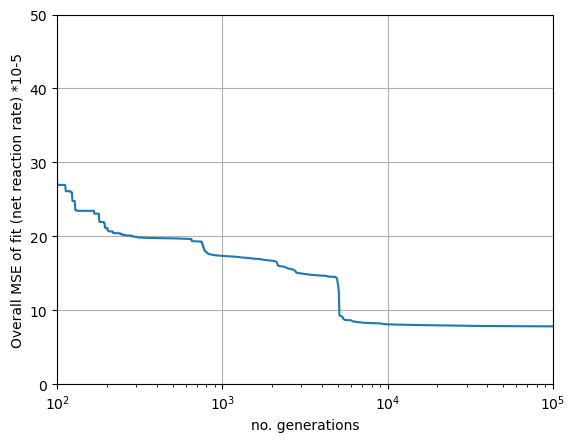

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.26768203218025
1.475088188680458
0.7262820210086813
-4.331841491075827
0.5057182170353085
5.994690101731282e-07
0.41466319775953925
-4.784783035421383
0.3401454506665739
4.713345365712345
3.455578975594467
3.626335582581322
0.4153145277476504
0.04478607553759407
2.9925396994112443
1.8703015708611923e-07
0.4784553944142115
-11.656239934987823
1.8375877628076287
1.557315861301987
-9.487156346823777
0.9573524490811383
3.1192335235105375
0.07143183204726808
3.130430244764299
3.0127480080296154
1.0961521547122008
6.567848562064119
-8.547808434185233
2.3552311783066706
1.5577689249546824
3.027506115558948
-4.276227601014777
0.535378139173954
0.957431810361853
-1.3010294463746832


In [37]:
res.X

array([-1.12676820e+01,  1.47508819e+00,  7.26282021e-01, -4.33184149e+00,
        5.05718217e-01,  5.99469010e-07,  4.14663198e-01, -4.78478304e+00,
        3.40145451e-01,  4.71334537e+00,  3.45557898e+00,  3.62633558e+00,
        4.15314528e-01,  4.47860755e-02,  2.99253970e+00,  1.87030157e-07,
        4.78455394e-01, -1.16562399e+01,  1.83758776e+00,  1.55731586e+00,
       -9.48715635e+00,  9.57352449e-01,  3.11923352e+00,  7.14318320e-02,
        3.13043024e+00,  3.01274801e+00,  1.09615215e+00,  6.56784856e+00,
       -8.54780843e+00,  2.35523118e+00,  1.55776892e+00,  3.02750612e+00,
       -4.27622760e+00,  5.35378139e-01,  9.57431810e-01, -1.30102945e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )


-12.0: -11.26768203218025
1.6: 1.475088188680458
0.9: 0.7262820210086813
-4.3: -4.331841491075827
0.5: 0.5057182170353085
0.003: 5.994690101731282e-07
0.4: 0.41466319775953925
-7.9: -4.784783035421383
0.7: 0.3401454506665739
7.2: 4.713345365712345
5.7: 3.455578975594467
5.7: 3.626335582581322
0.8: 0.4153145277476504
0.03: 0.04478607553759407
3.1: 2.9925396994112443
6.000000000000001e-09: 1.8703015708611923e-07
0.1: 0.4784553944142115
-12.0: -11.656239934987823
1.9: 1.8375877628076287
1.6: 1.557315861301987
-11.6: -9.487156346823777
1.2: 0.9573524490811383
4.0: 3.1192335235105375
0.01: 0.07143183204726808
4.2: 3.130430244764299
5.4: 3.0127480080296154
2.2: 1.0961521547122008
11.8: 6.567848562064119
-12.0: -8.547808434185233
3.3: 2.3552311783066706
1.8: 1.5577689249546824
4.2: 3.027506115558948
-4.0: -4.276227601014777
0.5: 0.535378139173954
1.0: 0.957431810361853
coeff fit: 0.921800310826392
